In [1]:
import numpy as np
import pandas as pd

def benchmark(x1, x2):
    return (    (1.3356 * (1.5 * (1 - x1))) 
                + (np.exp((2 * x1) - 1) * np.sin((3 * np.pi) * ((x1 - 0.6) ** 2)))
                + (np.exp(3 * (x2 - 0.5)) * np.sin((4 * np.pi) * ((x2 - 0.9) ** 2)))
            )

def getData(grid):
    x1 = np.linspace(0, 1, grid)
    x2 = np.linspace(0, 1, grid)
    x1, x2 = np.meshgrid(x1, x2)
    f_x1_x2 = benchmark(x1, x2)
    data = {'x1': x1.flatten(), 'x2': x2.flatten(), 'f(x1,x2)': f_x1_x2.flatten()}
    df = pd.DataFrame(data)
    return df


df_1000 = getData(32)
df_test = pd.read_excel("../Kriging-data.xlsx", sheet_name="Test")
df_training = pd.read_excel("../Kriging-data.xlsx", sheet_name="Training")
df_virtual = pd.read_excel("../VirtualSamples.xlsx", sheet_name="Exponential")

/tmp/ipykernel_11851/1816033590.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


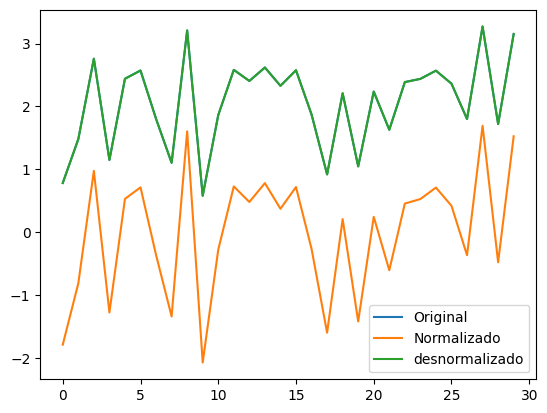

In [2]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def show_norm(df, label="data", plot=False):
    df_norm = pd.DataFrame(scaler.transform(df), columns=df.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df_norm), columns=df_norm.columns)

    if (plot):
        df.plot(title=f"{label}: Original data")
        df_norm.plot(title=f"{label}: Normalized data")
        df_denorm.plot(title=f"{label}: Denormalized data")
    return (df_norm)


def test_out_scaler(df):
    out = df["f(x1,x2)"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()

scaler.fit(df_training)
test_out_scaler(df_training)

df_training_norm = show_norm(df_training, "Training")
df_1000_norm = show_norm(df_1000)
df_test_norm = show_norm(df_test)
df_virtual_norm = show_norm(pd.concat([df_training, df_virtual]))

In [3]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

Cloning into 'tf-levenberg-marquardt'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 53 (delta 31), reused 29 (delta 14), pack-reused 0 (from 0)
Receiving objects: 100% (53/53), 32.99 KiB | 3.67 MiB/s, done.
Resolving deltas: 100% (31/31), done.


In [4]:
def split_df(df):
    _input = np.vstack([df['x1'], df['x2']]).T
    _output = np.array(df['f(x1,x2)'])
    return (_input, _output)

In [5]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def compute_k(self):
        total_parameters = 0
        for layer in self.model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:  
                for w in weights:
                    total_parameters += np.prod(w.shape)
        return total_parameters
        
    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer

        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-09-10 10:20:17.865771: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-10 10:20:17.865827: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-10 10:20:17.867389: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-10 10:20:17.905755: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-10 10:20:24.182669: W tensorflow/compiler/tf2

In [6]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error 

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
        self.k = 0

    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)
      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, tester):
      input_train, input_val, output_train, output_val = train_test_split(tester.input, tester.output, test_size=0.2, shuffle = True)

      self.dataset, self.input, self.output = self.create_dataset(tester.input, tester.output)
      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(tester.input_test, tester.output_test)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.sup_dataset, self.sup_input, self.sup_output = self.create_dataset(tester.input_1000, tester.output_1000)

      self._train = (input_train, output_train)
      self._val = (input_val, output_val)
      self._test = (tester.input_test, tester.output_test)
      self._data = (tester.input, tester.output)
      self._sup = (tester.input_1000, tester.output_1000)


    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)
      
      self.lm_model.save_weights('./initial-.weights.h5')
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)
    
    def get_new_metrics(self, orig, pred, r2, mse):
      n = len(orig) # N: quantidade de saidas
      k = self.k
      waste = (orig.flatten() - pred.flatten())

      mape = mean_absolute_percentage_error(orig, pred)  
      r2_adj = 1 - (((n - 1)/(n - k - 1)) * (1 - r2))
      rsd = np.sqrt(np.sum(waste ** 2) / (n - 2))
      rmse = root_mean_squared_error(orig, pred)          
      aic = (-2 * np.log(mse)) + (2 * k)
      bic = (-2 * np.log(mse)) + (k * np.log(n))
      return (mape, r2_adj, rsd, rmse, aic, bic)
      

    def get_metrics(self):
          # Calculando a saida com os dados normalizados
          pred = self.lm_model.predict(self.input).flatten()
          test_pred = self.lm_model.predict(self.test_input).flatten()
          val_pred = self.lm_model.predict(self.val_input).flatten()
          sup_pred = self.lm_model.predict(self.sup_input).flatten()

          # Calculando as metricas com a saida desnormalizada
          pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
          test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
          val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
          sup_pred_denorm = out_scaler.inverse_transform(sup_pred.reshape(-1, 1))

          out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
          test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
          val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
          sup_denorm = out_scaler.inverse_transform(self._sup[1].reshape(-1, 1))

          r2 = r2_score(out_denorm, pred_denorm)
          r2_test = r2_score(test_denorm, test_pred_denorm)
          r2_val = r2_score(val_denorm, val_pred_denorm)
          r2_sup = r2_score(sup_denorm,  sup_pred_denorm)

          mse = mean_squared_error(out_denorm, pred_denorm)
          mse_test = mean_squared_error(test_denorm, test_pred_denorm)
          mse_val = mean_squared_error(val_denorm, val_pred_denorm)
          mse_sup = mean_squared_error(sup_denorm,  sup_pred_denorm)
          
          mape, r2_adj, rsd, rmse, aic, bic = self.get_new_metrics(out_denorm, pred_denorm, r2, mse)
          metrics = {
                          'r2': r2,
                          'r2_sup': r2_sup,
                          'r2_test': r2_test,
                          'r2_val': r2_val,
                          'mse': mse,
                          'mse_sup': mse_sup,
                          'mse_test': mse_test,
                          'mse_val': mse_val,
                          'mape': mape,
                          'rmse': rmse,
                          'r2_adj': r2_adj,
                          'rsd': rsd,
                          'aic': aic,
                          'bic': bic
                          }

          return metrics

In [7]:
import pickle
from itertools import product
import shutil

class Tester:
  def __init__(self, _df, _df_1000, _df_test,  run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = split_df(_df)
    self.input_1000, self.output_1000 = split_df(_df_1000)
    self.input_test, self.output_test = split_df(_df_test)
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=2,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)
    trainer.k = shuffler.compute_k()

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path)
    shutil.move("./initial-.weights.h5",
                f"../models/initial-weights/{fileName}.keras")

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._val, trainer._test), f)
      
  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] <= boundarie): # should be >= to acsending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    return(save)

  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinacao{count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults('mse_sup', header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

# Treinando apenas com dados originais


In [8]:
tester = Tester(
                _df=df_virtual_norm,
                _df_1000=df_1000_norm,
                _df_test = df_test_norm,
                run_times=10, dataset_run_times=50)
tester.Loop(sort_by='mse',
            boundarie = 0.5,
            hidden_sizes = [[4], [8], [12], [24], [36],
                            [4, 2], [8, 4], [12, 6], [24, 12], [36, 18]],
            regularizers=[0.02],
            learning_rate=[0.01])

Testando combinacao1: Hidden Size=[4], regularizer=0.02, learning_rate=0.01
+++++++++++ [1_0] | 1 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_0] | 5 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_0] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_0] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_0] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_0_9  0.581127  0.492897  0.494085  0.570768  0.133048  0.301038   
model_1_0_8  0.541020  0.460023  0.462734  0.526832  0.145788  0.320554   
model_1_0_7  0.528138  0.433336  0.432492  0.509365  0.149879  0.336396   
model_1_0_6  0.472531  0.385413  0.386284  0.448262  0.167542  0.364845   
model_1_0_5  0.433844  0.341077  0.341227  0.403858  0.179830  0.391165   
model_1_0_4  0.415785  0.322129  0.321953  0.383794  0.185567  0.402414   
model_1_0_3  0.257740  0.096206  0.051522  0.242979  0.235767  0.536531   
model_1_0_2  0.196052  0.073279  0.037289  0.171193  0.255361  0.550142   
model_1_0_1  0.183576  0.066844  0.031046  0.158765  0.259324  0.553962   
model_1_0_0  0.171868  0.059281  0.024057  0.147033  0.263043  0.558451   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_0_9  0.354404  0.164769  0.158225  0.364758  0.517548  0.367597   
model_1_0_8  0.376366  0.181634  0.167849  0.381822  0.471353  0.384793   
model_1_0_7  0.397551  0.188339  0.175290  0.387143  0.456516  0.390156   
model_1_0_6  0.429921  0.211795  0.188341  0.409319  0.392469  0.412505   
model_1_0_5  0.461484  0.228840  0.200079  0.424064  0.347910  0.427364   
model_1_0_4  0.474986  0.236542  0.205092  0.430775  0.327109  0.434127   
model_1_0_3  0.664429  0.290597  0.245308  0.485559  0.145075  0.489337   
model_1_0_2  0.674399  0.318153  0.254899  0.505333  0.074024  0.509266   
model_1_0_1  0.678772  0.322924  0.256821  0.509239  0.059655  0.513202   
model_1_0_0  0.683668  0.327427  0.258711  0.512877  0.046169  0.516869   

                   aic        bic  
model_1_0_9  38.034084  86.782169  
model_1_0_8  37.851205  86.599291  
model_1_0_7  37.795848  86.543934  
model_1_0_6  37.573040  86.321126  
model_1_0_5  37.431482  86.179567  
model_1_0_4  37.368680  86.116765  
model_1_0_3  36.889820  85.637906  
model_1_0_2  36.730150  85.478236  
model_1_0_1  36.699352  85.447438  
model_1_0_0  36.670873  85.418959

DataFrame salvo em ../results/metrics_1_0
+++++++++++ [1_1] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_1] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_1] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_1] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_1] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_1_9  0.726649  0.616714  0.612321  0.708387  0.086826  0.227535   
model_1_1_8  0.723245  0.613515  0.609210  0.705517  0.087907  0.229434   
model_1_1_7  0.720041  0.611700  0.607702  0.702090  0.088925  0.230512   
model_1_1_6  0.717721  0.600730  0.595019  0.705169  0.089661  0.237024   
model_1_1_5  0.677782  0.583789  0.582903  0.659233  0.102348  0.247081   
model_1_1_4  0.645988  0.560310  0.561540  0.628415  0.112446  0.261019   
model_1_1_3  0.641507  0.557593  0.559237  0.623745  0.113870  0.262632   
model_1_1_2  0.637931  0.554987  0.556883  0.620336  0.115005  0.264179   
model_1_1_1  0.614990  0.536136  0.539198  0.599222  0.122292  0.275370   
model_1_1_0  0.585214  0.514356  0.519439  0.570248  0.131750  0.288299   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_1_9  0.271577  0.065833  0.123525  0.294662  0.685159  0.296955   
model_1_1_8  0.273756  0.066481  0.124338  0.296491  0.681237  0.298799   
model_1_1_7  0.274813  0.067254  0.124984  0.298202  0.677547  0.300523   
model_1_1_6  0.283698  0.066559  0.126686  0.299435  0.674875  0.301765   
model_1_1_5  0.292185  0.076929  0.133824  0.319918  0.628873  0.322408   
model_1_1_4  0.307150  0.083887  0.140601  0.335330  0.592254  0.337940   
model_1_1_3  0.308764  0.084941  0.141445  0.337446  0.587093  0.340072   
model_1_1_2  0.310412  0.085710  0.142176  0.339125  0.582974  0.341764   
model_1_1_1  0.322801  0.090477  0.147168  0.349703  0.556551  0.352425   
model_1_1_0  0.336643  0.097018  0.153299  0.362974  0.522256  0.365799   

                   aic        bic  
model_1_1_9  38.887710  87.635795  
model_1_1_8  38.862952  87.611037  
model_1_1_7  38.839932  87.588017  
model_1_1_6  38.823429  87.571515  
model_1_1_5  38.558760  87.306846  
model_1_1_4  38.370558  87.118644  
model_1_1_3  38.345402  87.093487  
model_1_1_2  38.325552  87.073637  
model_1_1_1  38.202682  86.950768  
model_1_1_0  38.053695  86.801780

DataFrame salvo em ../results/metrics_1_1
+++++++++++ [1_2] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_2] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_2] | 3 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_2] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_2] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_2] | 7 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_2] | 8 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_2] | 9 +++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_2_9  0.869217  0.679996  0.658759  0.834536  0.041541  0.189968   
model_1_2_8  0.865192  0.678849  0.658511  0.830429  0.042820  0.190649   
model_1_2_7  0.845071  0.674717  0.658613  0.809163  0.049211  0.193102   
model_1_2_6  0.833378  0.671707  0.657721  0.796656  0.052925  0.194889   
model_1_2_5  0.815100  0.664139  0.652711  0.777297  0.058731  0.199381   
model_1_2_4  0.813252  0.663617  0.652469  0.775275  0.059317  0.199691   
model_1_2_3  0.804104  0.659011  0.648799  0.765623  0.062223  0.202426   
model_1_2_2  0.795574  0.655681  0.646521  0.756414  0.064933  0.204402   
model_1_2_1  0.769409  0.642823  0.636049  0.728526  0.073244  0.212036   
model_1_2_0  0.761276  0.635641  0.628519  0.720397  0.075827  0.216300   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_2_9  0.239046  0.048604  0.087720  0.203817  0.849366  0.205403   
model_1_2_8  0.239220  0.049810  0.088802  0.206929  0.844730  0.208539   
model_1_2_7  0.239149  0.056057  0.094172  0.221835  0.821555  0.223561   
model_1_2_6  0.239774  0.059731  0.097195  0.230054  0.808087  0.231845   
model_1_2_5  0.243283  0.065417  0.102183  0.242344  0.787035  0.244230   
model_1_2_4  0.243453  0.066011  0.102646  0.243552  0.784907  0.245447   
model_1_2_3  0.246024  0.068847  0.105037  0.249446  0.774370  0.251387   
model_1_2_2  0.247619  0.071552  0.107087  0.254819  0.764545  0.256802   
model_1_2_1  0.254955  0.079744  0.113490  0.270636  0.734408  0.272742   
model_1_2_0  0.260230  0.082131  0.115897  0.275367  0.725041  0.277510   

                   aic        bic  
model_1_2_9  40.362140  89.110225  
model_1_2_8  40.301518  89.049603  
model_1_2_7  40.023288  88.771373  
model_1_2_6  39.877761  88.625847  
model_1_2_5  39.669588  88.417674  
model_1_2_4  39.649704  88.397789  
model_1_2_3  39.554052  88.302137  
model_1_2_2  39.468806  88.216891  
model_1_2_1  39.227925  87.976011  
model_1_2_0  39.158604  87.906690

DataFrame salvo em ../results/metrics_1_2
+++++++++++ [1_3] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_3] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_3] | 5 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_3] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_3] | 9 ++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_3_9  0.895702  0.705338  0.679400  0.885668  0.033128  0.174924   
model_1_3_8  0.893996  0.703885  0.678356  0.884546  0.033670  0.175786   
model_1_3_7  0.892759  0.702767  0.677512  0.883767  0.034064  0.176450   
model_1_3_5  0.887921  0.701110  0.677030  0.879784  0.035600  0.177434   
model_1_3_6  0.892180  0.700987  0.675746  0.883904  0.034247  0.177507   
model_1_3_4  0.885730  0.698807  0.675152  0.878600  0.036296  0.178801   
model_1_3_3  0.881695  0.694409  0.671422  0.876592  0.037578  0.181412   
model_1_3_2  0.874997  0.693299  0.671729  0.870898  0.039705  0.182071   
model_1_3_1  0.874137  0.688962  0.667275  0.871907  0.039978  0.184645   
model_1_3_0  0.871531  0.685206  0.663862  0.871077  0.040806  0.186875   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_3_9  0.224587  0.045698  0.080521  0.182012  0.879872  0.183429   
model_1_3_8  0.225318  0.046147  0.080992  0.183495  0.877906  0.184923   
model_1_3_7  0.225909  0.046458  0.081327  0.184563  0.876481  0.185999   
model_1_3_5  0.226247  0.048050  0.082401  0.188680  0.870909  0.190149   
model_1_3_6  0.227147  0.046403  0.081563  0.185061  0.875814  0.186501   
model_1_3_4  0.227563  0.048523  0.083000  0.190515  0.868386  0.191998   
model_1_3_3  0.230176  0.049326  0.084112  0.193850  0.863738  0.195358   
model_1_3_2  0.229961  0.051602  0.085639  0.199262  0.856023  0.200812   
model_1_3_1  0.233081  0.051199  0.086051  0.199946  0.855033  0.201502   
model_1_3_0  0.235472  0.051530  0.086844  0.202005  0.852032  0.203577   

                   aic        bic  
model_1_3_9  40.814724  89.562810  
model_1_3_8  40.782270  89.530356  
model_1_3_7  40.759054  89.507140  
model_1_3_5  40.670806  89.418892  
model_1_3_6  40.748284  89.496370  
model_1_3_4  40.632092  89.380178  
model_1_3_3  40.562691  89.310777  
model_1_3_2  40.452546  89.200632  
model_1_3_1  40.438835  89.186920  
model_1_3_0  40.397850  89.145935

DataFrame salvo em ../results/metrics_1_3
+++++++++++ [1_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_4] | 2 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_4] | 4 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_4] | 7 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_4] | 8 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_4] | 9 ++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_4_0  0.895900  0.705269  0.679310  0.866552  0.033066  0.174965   
model_1_4_1  0.897274  0.704718  0.678637  0.867318  0.032629  0.175292   
model_1_4_2  0.900142  0.702561  0.675705  0.869928  0.031718  0.176573   
model_1_4_3  0.901920  0.701353  0.674341  0.870796  0.031154  0.177290   
model_1_4_4  0.903399  0.699878  0.672499  0.871925  0.030684  0.178165   
model_1_4_5  0.903455  0.699859  0.672494  0.871899  0.030666  0.178177   
model_1_4_7  0.905266  0.697951  0.670532  0.872143  0.030091  0.179310   
model_1_4_6  0.905124  0.697896  0.670115  0.872996  0.030136  0.179342   
model_1_4_8  0.905465  0.697692  0.670394  0.871844  0.030027  0.179463   
model_1_4_9  0.905721  0.697322  0.670107  0.871639  0.029946  0.179683   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_4_0  0.224650  0.049297  0.080467  0.181840  0.880099  0.183255   
model_1_4_1  0.225122  0.049014  0.080090  0.180636  0.881682  0.182041   
model_1_4_2  0.227175  0.048050  0.079515  0.178097  0.884985  0.179483   
model_1_4_3  0.228131  0.047729  0.079045  0.176504  0.887033  0.177877   
model_1_4_4  0.229421  0.047312  0.078736  0.175168  0.888737  0.176531   
model_1_4_5  0.229425  0.047322  0.078715  0.175117  0.888801  0.176479   
model_1_4_7  0.230799  0.047232  0.078218  0.173467  0.890886  0.174817   
model_1_4_6  0.231091  0.046917  0.078411  0.173597  0.890723  0.174948   
model_1_4_8  0.230896  0.047342  0.078109  0.173284  0.891116  0.174633   
model_1_4_9  0.231097  0.047418  0.078013  0.173049  0.891411  0.174396   

                   aic        bic  
model_1_4_0  40.818517  89.566603  
model_1_4_1  40.845093  89.593178  
model_1_4_2  40.901714  89.649800  
model_1_4_3  40.937657  89.685743  
model_1_4_4  40.968046  89.716132  
model_1_4_5  40.969211  89.717296  
model_1_4_7  41.007067  89.755153  
model_1_4_6  41.004068  89.752154  
model_1_4_8  41.011284  89.759370  
model_1_4_9  41.016713  89.764799

DataFrame salvo em ../results/metrics_1_4
+++++++++++ [1_5] | 1 ++++++++++++++++++
Stopped at epoch:  48
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_5] | 2 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_5] | 5 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_5] | 7 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_5] | 9 ++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_5_0  0.906952  0.690052  0.661111  0.836616  0.029555  0.183999   
model_1_5_3  0.905758  0.689356  0.661639  0.825620  0.029935  0.184411   
model_1_5_1  0.906537  0.688809  0.660368  0.830048  0.029687  0.184737   
model_1_5_2  0.906470  0.688785  0.660409  0.829488  0.029708  0.184751   
model_1_5_4  0.905019  0.687516  0.660523  0.816826  0.030169  0.185504   
model_1_5_5  0.904807  0.686495  0.659698  0.813724  0.030237  0.186110   
model_1_5_6  0.904299  0.685213  0.658712  0.808691  0.030398  0.186871   
model_1_5_7  0.904250  0.685191  0.658709  0.808367  0.030414  0.186884   
model_1_5_8  0.902887  0.681137  0.654753  0.796030  0.030846  0.189291   
model_1_5_9  0.902600  0.680421  0.653958  0.793844  0.030938  0.189716   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_5_0  0.237399  0.052166  0.078887  0.171916  0.892829  0.173254   
model_1_5_3  0.237029  0.055677  0.079156  0.173016  0.891453  0.174363   
model_1_5_1  0.237919  0.054263  0.079091  0.172300  0.892350  0.173641   
model_1_5_2  0.237891  0.054442  0.079105  0.172361  0.892274  0.173702   
model_1_5_4  0.237811  0.058485  0.079475  0.173693  0.890602  0.175045   
model_1_5_5  0.238389  0.059475  0.079617  0.173887  0.890358  0.175240   
model_1_5_6  0.239079  0.061082  0.079926  0.174350  0.889773  0.175707   
model_1_5_7  0.239082  0.061186  0.079939  0.174395  0.889716  0.175752   
model_1_5_8  0.241852  0.065125  0.080972  0.175631  0.888147  0.176998   
model_1_5_9  0.242410  0.065823  0.081175  0.175891  0.887816  0.177260   

                   aic        bic  
model_1_5_0  41.042996  89.791081  
model_1_5_3  41.017482  89.765568  
model_1_5_1  41.034081  89.782167  
model_1_5_2  41.032663  89.780748  
model_1_5_4  41.001860  89.749946  
model_1_5_5  40.997410  89.745495  
model_1_5_6  40.986758  89.734843  
model_1_5_7  40.985729  89.733815  
model_1_5_8  40.957479  89.705565  
model_1_5_9  40.951568  89.699654

DataFrame salvo em ../results/metrics_1_5
+++++++++++ [1_6] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_6] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_6] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_6] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_6] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_6_0  0.903080  0.680755  0.652458  0.904708  0.030785  0.189518   
model_1_6_2  0.903359  0.680630  0.651405  0.904896  0.030696  0.189592   
model_1_6_1  0.903231  0.680565  0.651777  0.904782  0.030737  0.189630   
model_1_6_3  0.903828  0.680563  0.649584  0.905214  0.030548  0.189632   
model_1_6_4  0.904279  0.680319  0.647667  0.905475  0.030404  0.189776   
model_1_6_7  0.904661  0.680253  0.646162  0.905710  0.030283  0.189816   
model_1_6_5  0.904385  0.680201  0.647168  0.905521  0.030371  0.189847   
model_1_6_8  0.904762  0.680118  0.645661  0.905748  0.030251  0.189895   
model_1_6_6  0.904496  0.680098  0.646682  0.905578  0.030335  0.189907   
model_1_6_9  0.904860  0.679979  0.645165  0.905782  0.030220  0.189978   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_6_0  0.243461  0.044291  0.081014  0.175457  0.888369  0.176822   
model_1_6_2  0.244198  0.044204  0.080982  0.175204  0.888691  0.176567   
model_1_6_1  0.243937  0.044257  0.081015  0.175320  0.888543  0.176685   
model_1_6_3  0.245474  0.044056  0.080899  0.174779  0.889230  0.176139   
model_1_6_4  0.246817  0.043935  0.080853  0.174368  0.889750  0.175725   
model_1_6_7  0.247871  0.043825  0.080794  0.174020  0.890190  0.175374   
model_1_6_5  0.247166  0.043914  0.080850  0.174272  0.889872  0.175628   
model_1_6_8  0.248222  0.043808  0.080797  0.173928  0.890306  0.175281   
model_1_6_6  0.247506  0.043887  0.080846  0.174171  0.890000  0.175526   
model_1_6_9  0.248569  0.043792  0.080801  0.173838  0.890419  0.175191   

                   aic        bic  
model_1_6_0  40.961453  89.709539  
model_1_6_2  40.967221  89.715307  
model_1_6_1  40.964563  89.712648  
model_1_6_3  40.976934  89.725020  
model_1_6_4  40.986342  89.734428  
model_1_6_7  40.994348  89.742434  
model_1_6_5  40.988560  89.736645  
model_1_6_8  40.996459  89.744544  
model_1_6_6  40.990881  89.738967  
model_1_6_9  40.998521  89.746607

DataFrame salvo em ../results/metrics_1_6
+++++++++++ [1_7] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_7] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_7] | 4 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_7] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_7] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_7_7  0.908427  0.684272  0.647491  0.913723  0.029087  0.187430   
model_1_7_8  0.908701  0.683877  0.647569  0.912649  0.029000  0.187664   
model_1_7_6  0.908688  0.682610  0.645001  0.915528  0.029004  0.188416   
model_1_7_5  0.908486  0.682117  0.644065  0.916913  0.029068  0.188709   
model_1_7_4  0.908304  0.681962  0.643719  0.917635  0.029126  0.188801   
model_1_7_9  0.909426  0.681869  0.645824  0.912032  0.028769  0.188856   
model_1_7_2  0.906795  0.680878  0.643085  0.921376  0.029605  0.189444   
model_1_7_1  0.905350  0.680868  0.645250  0.923010  0.030064  0.189450   
model_1_7_3  0.908054  0.680612  0.642082  0.919206  0.029205  0.189603   
model_1_7_0  0.905207  0.680311  0.644881  0.923312  0.030110  0.189781   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_7_7  0.246940  0.022809  0.079154  0.170548  0.894528  0.171875   
model_1_7_8  0.246885  0.023093  0.079042  0.170293  0.894843  0.171618   
model_1_7_6  0.248684  0.022332  0.079349  0.170305  0.894828  0.171631   
model_1_7_5  0.249340  0.021966  0.079533  0.170494  0.894595  0.171821   
model_1_7_4  0.249582  0.021775  0.079637  0.170663  0.894386  0.171991   
model_1_7_9  0.248108  0.023256  0.078999  0.169616  0.895678  0.170936   
model_1_7_2  0.250026  0.020786  0.080201  0.172061  0.892648  0.173400   
model_1_7_1  0.248510  0.020354  0.080503  0.173390  0.890983  0.174740   
model_1_7_3  0.250729  0.021360  0.079891  0.170895  0.894098  0.172225   
model_1_7_0  0.248768  0.020274  0.080626  0.173521  0.890819  0.174871   

                   aic        bic  
model_1_7_7  41.074952  89.823038  
model_1_7_8  41.080937  89.829022  
model_1_7_6  41.080653  89.828738  
model_1_7_5  41.076226  89.824311  
model_1_7_4  41.072260  89.820345  
model_1_7_9  41.096883  89.844969  
model_1_7_2  41.039625  89.787710  
model_1_7_1  41.008840  89.756926  
model_1_7_3  41.066824  89.814910  
model_1_7_0  41.005826  89.753912

DataFrame salvo em ../results/metrics_1_7
+++++++++++ [1_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_8] | 2 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_8] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_8] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_8] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_8] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_8_9  0.910691  0.683578  0.648874  0.881922  0.028368  0.187842   
model_1_8_6  0.910574  0.683533  0.648671  0.882637  0.028405  0.187868   
model_1_8_8  0.910613  0.683508  0.648671  0.882486  0.028392  0.187883   
model_1_8_7  0.910599  0.683496  0.648642  0.882565  0.028397  0.187890   
model_1_8_5  0.910484  0.683439  0.648456  0.883222  0.028433  0.187924   
model_1_8_2  0.910096  0.683089  0.647647  0.885137  0.028556  0.188132   
model_1_8_4  0.910429  0.683089  0.647879  0.883929  0.028451  0.188132   
model_1_8_3  0.910184  0.683086  0.647695  0.884855  0.028529  0.188134   
model_1_8_1  0.910001  0.682963  0.647428  0.885552  0.028587  0.188207   
model_1_8_0  0.909422  0.682058  0.646053  0.887970  0.028771  0.188744   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_8_9  0.245971  0.032182  0.078783  0.168427  0.897135  0.169738   
model_1_8_6  0.246114  0.031987  0.078793  0.168537  0.897001  0.169848   
model_1_8_8  0.246113  0.032028  0.078789  0.168500  0.897045  0.169812   
model_1_8_7  0.246134  0.032007  0.078792  0.168513  0.897030  0.169825   
model_1_8_5  0.246264  0.031828  0.078811  0.168622  0.896897  0.169934   
model_1_8_2  0.246830  0.031306  0.078861  0.168987  0.896450  0.170302   
model_1_8_4  0.246668  0.031635  0.078835  0.168673  0.896834  0.169986   
model_1_8_3  0.246797  0.031383  0.078855  0.168904  0.896551  0.170219   
model_1_8_1  0.246984  0.031193  0.078871  0.169077  0.896340  0.170392   
model_1_8_0  0.247947  0.030534  0.078985  0.169619  0.895674  0.170939   

                   aic        bic  
model_1_8_9  41.125004  89.873090  
model_1_8_6  41.122407  89.870493  
model_1_8_8  41.123271  89.871356  
model_1_8_7  41.122962  89.871048  
model_1_8_5  41.120391  89.868476  
model_1_8_2  41.111746  89.859831  
model_1_8_4  41.119162  89.867247  
model_1_8_3  41.113691  89.861777  
model_1_8_1  41.109613  89.857699  
model_1_8_0  41.096797  89.844883

DataFrame salvo em ../results/metrics_1_8
+++++++++++ [1_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_9] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_9] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_9_9  0.911591  0.692104  0.650903  0.791224  0.028082  0.182780   
model_1_9_8  0.911635  0.690547  0.649807  0.794439  0.028068  0.183705   
model_1_9_7  0.911654  0.689272  0.648493  0.795462  0.028062  0.184462   
model_1_9_4  0.911915  0.684467  0.645507  0.804964  0.027979  0.187314   
model_1_9_5  0.911958  0.684461  0.645202  0.804315  0.027965  0.187317   
model_1_9_6  0.911990  0.684434  0.644875  0.803636  0.027955  0.187334   
model_1_9_0  0.910904  0.683566  0.648420  0.810320  0.028300  0.187849   
model_1_9_3  0.911959  0.681485  0.642201  0.806488  0.027965  0.189084   
model_1_9_1  0.911911  0.681396  0.642748  0.807991  0.027980  0.189137   
model_1_9_2  0.911941  0.681244  0.642225  0.807253  0.027971  0.189227   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_9_9  0.244549  0.032631  0.079366  0.167576  0.898172  0.168880   
model_1_9_8  0.245318  0.032129  0.079352  0.167534  0.898223  0.168838   
model_1_9_7  0.246238  0.031969  0.079385  0.167516  0.898245  0.168820   
model_1_9_4  0.248330  0.030484  0.079013  0.167269  0.898545  0.168571   
model_1_9_5  0.248544  0.030585  0.079017  0.167228  0.898594  0.168529   
model_1_9_6  0.248772  0.030691  0.079024  0.167198  0.898631  0.168499   
model_1_9_0  0.246289  0.029646  0.078793  0.168226  0.897380  0.169536   
model_1_9_3  0.250646  0.030245  0.079156  0.167227  0.898596  0.168528   
model_1_9_1  0.250262  0.030010  0.079108  0.167272  0.898541  0.168574   
model_1_9_2  0.250629  0.030126  0.079156  0.167244  0.898575  0.168546   

                   aic        bic  
model_1_9_9  41.145276  89.893362  
model_1_9_8  41.146273  89.894359  
model_1_9_7  41.146709  89.894794  
model_1_9_4  41.152612  89.900698  
model_1_9_5  41.153590  89.901675  
model_1_9_6  41.154317  89.902403  
model_1_9_0  41.129780  89.877866  
model_1_9_3  41.153613  89.901698  
model_1_9_1  41.152533  89.900619  
model_1_9_2  41.153206  89.901292

DataFrame salvo em ../results/metrics_1_9
+++++++++++ [1_10] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_10] | 2 ++++++++++++++++++
Stopped at epoch:  44
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_10] | 3 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_10] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_10] | 5 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_10] | 6 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_10] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_10] | 8 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_10] | 9 +

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_10_1  0.912119  0.694147  0.658676  0.930685  0.027914  0.181568   
model_1_10_3  0.912029  0.694088  0.660329  0.927790  0.027942  0.181603   
model_1_10_2  0.912043  0.694023  0.660098  0.928045  0.027938  0.181641   
model_1_10_6  0.911709  0.693807  0.662332  0.923628  0.028044  0.181769   
model_1_10_4  0.911882  0.693696  0.661101  0.925510  0.027989  0.181836   
model_1_10_5  0.911740  0.693645  0.661942  0.923873  0.028034  0.181866   
model_1_10_7  0.911565  0.693563  0.662756  0.922219  0.028090  0.181914   
model_1_10_8  0.911450  0.693471  0.663139  0.921260  0.028126  0.181969   
model_1_10_9  0.911307  0.693343  0.663578  0.920137  0.028172  0.182045   
model_1_10_0  0.911739  0.692842  0.652527  0.937763  0.028035  0.182342   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_10_1  0.239104  0.024784  0.079005  0.167075  0.898780  0.168375   
model_1_10_3  0.237946  0.025819  0.079057  0.167160  0.898677  0.168461   
model_1_10_2  0.238109  0.025728  0.079056  0.167148  0.898692  0.168448   
model_1_10_6  0.236544  0.027308  0.079215  0.167464  0.898308  0.168767   
model_1_10_4  0.237406  0.026635  0.079174  0.167300  0.898507  0.168602   
model_1_10_5  0.236817  0.027220  0.079223  0.167435  0.898344  0.168738   
model_1_10_7  0.236246  0.027811  0.079267  0.167601  0.898142  0.168905   
model_1_10_8  0.235978  0.028154  0.079303  0.167709  0.898010  0.169014   
model_1_10_9  0.235671  0.028556  0.079351  0.167845  0.897845  0.169151   
model_1_10_0  0.243412  0.022254  0.079294  0.167435  0.898343  0.168738   

                    aic        bic  
model_1_10_1  41.157259  89.905345  
model_1_10_3  41.155213  89.903299  
model_1_10_2  41.155512  89.903598  
model_1_10_6  41.147946  89.896031  
model_1_10_4  41.151867  89.899952  
model_1_10_5  41.148648  89.896734  
model_1_10_7  41.144684  89.892770  
model_1_10_8  41.142092  89.890178  
model_1_10_9  41.138858  89.886943  
model_1_10_0  41.148632  89.896718

DataFrame salvo em ../results/metrics_1_10
+++++++++++ [1_11] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_11] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_11] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_11] | 4 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_11] | 5 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_11] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_11] | 7 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_11] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_11] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_11_7  0.912300  0.695847  0.669818  0.944517  0.027857  0.180558   
model_1_11_6  0.912290  0.695712  0.669450  0.944796  0.027860  0.180638   
model_1_11_5  0.912237  0.695701  0.669076  0.945263  0.027877  0.180645   
model_1_11_8  0.912349  0.695443  0.669735  0.943998  0.027841  0.180798   
model_1_11_9  0.912353  0.695423  0.669761  0.943925  0.027840  0.180810   
model_1_11_4  0.912174  0.694370  0.666947  0.945495  0.027897  0.181435   
model_1_11_3  0.911975  0.693811  0.665569  0.946181  0.027960  0.181767   
model_1_11_2  0.911500  0.693302  0.663865  0.947218  0.028111  0.182069   
model_1_11_0  0.911425  0.693284  0.663706  0.947355  0.028135  0.182080   
model_1_11_1  0.911462  0.693260  0.663748  0.947275  0.028123  0.182094   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_11_7  0.231300  0.019445  0.078902  0.166903  0.898988  0.168202   
model_1_11_6  0.231557  0.019347  0.078917  0.166912  0.898977  0.168211   
model_1_11_5  0.231819  0.019183  0.078937  0.166963  0.898915  0.168262   
model_1_11_8  0.231358  0.019627  0.078919  0.166856  0.899045  0.168155   
model_1_11_9  0.231340  0.019652  0.078919  0.166852  0.899049  0.168151   
model_1_11_4  0.233311  0.019102  0.079096  0.167023  0.898843  0.168323   
model_1_11_3  0.234276  0.018861  0.079189  0.167211  0.898614  0.168513   
model_1_11_2  0.235470  0.018498  0.079319  0.167662  0.898067  0.168967   
model_1_11_0  0.235581  0.018450  0.079334  0.167734  0.897980  0.169039   
model_1_11_1  0.235551  0.018478  0.079329  0.167698  0.898024  0.169003   

                    aic        bic  
model_1_11_7  41.161376  89.909461  
model_1_11_6  41.161144  89.909230  
model_1_11_5  41.159930  89.908016  
model_1_11_8  41.162492  89.910578  
model_1_11_9  41.162583  89.910669  
model_1_11_4  41.158494  89.906579  
model_1_11_3  41.153986  89.902071  
model_1_11_2  41.143212  89.891297  
model_1_11_0  41.141515  89.889601  
model_1_11_1  41.142362  89.890448

DataFrame salvo em ../results/metrics_1_11
+++++++++++ [1_12] | 1 ++++++++++++++++++
Stopped at epoch:  56
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_12] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_12] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_12] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_12] | 5 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_12] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_12] | 7 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_12] | 8 ++++++++++++++++++
Stopped at epoch:  33
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_12] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_12_0  0.912403  0.685365  0.658988  0.901883  0.027824  0.186781   
model_1_12_1  0.912333  0.683206  0.656447  0.900432  0.027846  0.188063   
model_1_12_2  0.912320  0.683002  0.656209  0.900260  0.027850  0.188184   
model_1_12_3  0.912195  0.681551  0.654537  0.898831  0.027890  0.189045   
model_1_12_4  0.911899  0.678857  0.651443  0.896115  0.027984  0.190644   
model_1_12_5  0.911747  0.677327  0.649658  0.894828  0.028032  0.191553   
model_1_12_6  0.911566  0.675977  0.648057  0.893481  0.028090  0.192354   
model_1_12_7  0.911014  0.672535  0.643816  0.889921  0.028265  0.194398   
model_1_12_8  0.910896  0.672401  0.643588  0.889351  0.028302  0.194477   
model_1_12_9  0.910792  0.671515  0.642487  0.888659  0.028336  0.195003   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_12_0  0.238886  0.035804  0.078998  0.166804  0.899107  0.168103   
model_1_12_1  0.240666  0.036334  0.079125  0.166872  0.899026  0.168170   
model_1_12_2  0.240833  0.036396  0.079131  0.166884  0.899012  0.168182   
model_1_12_3  0.242004  0.036918  0.079162  0.167002  0.898868  0.168302   
model_1_12_4  0.244172  0.037909  0.079226  0.167284  0.898527  0.168586   
model_1_12_5  0.245422  0.038378  0.079297  0.167428  0.898351  0.168731   
model_1_12_6  0.246544  0.038870  0.079338  0.167600  0.898143  0.168904   
model_1_12_7  0.249514  0.040169  0.079436  0.168122  0.897507  0.169430   
model_1_12_8  0.249674  0.040377  0.079398  0.168233  0.897371  0.169543   
model_1_12_9  0.250445  0.040629  0.079447  0.168332  0.897251  0.169642   

                    aic        bic  
model_1_12_0  41.163733  89.911819  
model_1_12_1  41.162118  89.910203  
model_1_12_2  41.161836  89.909922  
model_1_12_3  41.158992  89.907077  
model_1_12_4  41.152257  89.900343  
model_1_12_5  41.148796  89.896881  
model_1_12_6  41.144702  89.892787  
model_1_12_7  41.132261  89.880346  
model_1_12_8  41.129614  89.877700  
model_1_12_9  41.127275  89.875360

DataFrame salvo em ../results/metrics_1_12
+++++++++++ [1_13] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_13] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_13] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_13] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_13] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_13] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_13] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_13] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_13] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_13_9  0.909871  0.682526  0.643014  0.876547  0.028628  0.188467   
model_1_13_8  0.909795  0.680280  0.641549  0.877885  0.028652  0.189799   
model_1_13_7  0.909867  0.680162  0.641664  0.878592  0.028629  0.189870   
model_1_13_6  0.909887  0.678363  0.640623  0.880336  0.028623  0.190937   
model_1_13_5  0.910003  0.677925  0.640621  0.881725  0.028586  0.191198   
model_1_13_2  0.911086  0.676153  0.644128  0.896893  0.028242  0.192250   
model_1_13_3  0.910622  0.675245  0.640760  0.889708  0.028390  0.192789   
model_1_13_4  0.909794  0.674796  0.638083  0.882781  0.028653  0.193055   
model_1_13_1  0.911020  0.674293  0.643231  0.899364  0.028263  0.193354   
model_1_13_0  0.911006  0.674109  0.643346  0.900178  0.028267  0.193463   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_13_9  0.250076  0.044839  0.079938  0.169198  0.896191  0.170515   
model_1_13_8  0.251102  0.044353  0.080114  0.169270  0.896103  0.170587   
model_1_13_7  0.251022  0.044096  0.080097  0.169202  0.896186  0.170519   
model_1_13_6  0.251751  0.043462  0.080192  0.169183  0.896209  0.170500   
model_1_13_5  0.251753  0.042958  0.080179  0.169075  0.896342  0.170390   
model_1_13_2  0.249296  0.037449  0.079513  0.168054  0.897590  0.169362   
model_1_13_3  0.251655  0.040059  0.079966  0.168492  0.897055  0.169803   
model_1_13_4  0.253531  0.042575  0.080401  0.169271  0.896101  0.170588   
model_1_13_1  0.249924  0.036551  0.079514  0.168116  0.897515  0.169424   
model_1_13_0  0.249843  0.036256  0.079485  0.168129  0.897498  0.169438   

                    aic        bic  
model_1_13_9  41.106736  89.854822  
model_1_13_8  41.105049  89.853135  
model_1_13_7  41.106638  89.854724  
model_1_13_6  41.107097  89.855183  
model_1_13_5  41.109660  89.857746  
model_1_13_2  41.133875  89.881961  
model_1_13_3  41.123466  89.871551  
model_1_13_4  41.105017  89.853103  
model_1_13_1  41.132405  89.880490  
model_1_13_0  41.132090  89.880175

DataFrame salvo em ../results/metrics_1_13
+++++++++++ [1_14] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_14] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_14] | 3 ++++++++++++++++++
Stopped at epoch:  40
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_14] | 4 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_14] | 5 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_14] | 6 ++++++++++++++++++
Stopped at epoch:  32
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_14] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_14] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_14] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_14_3  0.910869  0.706762  0.677040  0.922647  0.028311  0.174078   
model_1_14_2  0.910881  0.706432  0.675685  0.924852  0.028307  0.174274   
model_1_14_4  0.910875  0.706323  0.677145  0.920527  0.028309  0.174339   
model_1_14_5  0.910689  0.705041  0.676010  0.916552  0.028368  0.175100   
model_1_14_7  0.910603  0.704685  0.675600  0.915492  0.028396  0.175312   
model_1_14_6  0.910626  0.704648  0.675553  0.915620  0.028388  0.175334   
model_1_14_8  0.910558  0.704097  0.674877  0.914592  0.028410  0.175661   
model_1_14_1  0.910365  0.702699  0.666934  0.931420  0.028471  0.176491   
model_1_14_9  0.910473  0.700490  0.670497  0.911421  0.028437  0.177802   
model_1_14_0  0.909960  0.682886  0.643552  0.933439  0.028600  0.188253   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_14_3  0.226240  0.026262  0.078343  0.168259  0.897341  0.169568   
model_1_14_2  0.227189  0.025513  0.078373  0.168248  0.897353  0.169557   
model_1_14_4  0.226166  0.026982  0.078293  0.168253  0.897347  0.169563   
model_1_14_5  0.226962  0.028331  0.078166  0.168428  0.897133  0.169739   
model_1_14_7  0.227249  0.028691  0.078126  0.168510  0.897034  0.169821   
model_1_14_6  0.227282  0.028647  0.078130  0.168488  0.897061  0.169799   
model_1_14_8  0.227755  0.028996  0.078085  0.168552  0.896982  0.169864   
model_1_14_1  0.233320  0.023283  0.078602  0.168734  0.896759  0.170048   
model_1_14_9  0.230824  0.030073  0.078057  0.168632  0.896884  0.169944   
model_1_14_0  0.249699  0.022598  0.079908  0.169115  0.896293  0.170431   

                    aic        bic  
model_1_14_3  41.129014  89.877100  
model_1_14_2  41.129263  89.877349  
model_1_14_4  41.129135  89.877221  
model_1_14_5  41.124979  89.873065  
model_1_14_7  41.123041  89.871127  
model_1_14_6  41.123567  89.871653  
model_1_14_8  41.122045  89.870131  
model_1_14_1  41.117717  89.865802  
model_1_14_9  41.120146  89.868231  
model_1_14_0  41.108709  89.856795

DataFrame salvo em ../results/metrics_1_14
+++++++++++ [1_15] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_15] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_15] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_15] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_15] | 5 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_15] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_15] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_15] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_15] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_15_1  0.910391  0.700923  0.671310  0.865371  0.028463  0.177545   
model_1_15_0  0.910420  0.700789  0.670998  0.865736  0.028454  0.177625   
model_1_15_2  0.910409  0.700659  0.671569  0.864505  0.028457  0.177702   
model_1_15_3  0.910429  0.700526  0.671532  0.864381  0.028451  0.177781   
model_1_15_5  0.910336  0.700237  0.672564  0.862128  0.028480  0.177952   
model_1_15_4  0.910394  0.700171  0.672116  0.862797  0.028462  0.177991   
model_1_15_6  0.910379  0.699577  0.672284  0.861605  0.028467  0.178344   
model_1_15_7  0.910431  0.698991  0.671907  0.861373  0.028450  0.178692   
model_1_15_8  0.910443  0.698549  0.671768  0.860953  0.028446  0.178955   
model_1_15_9  0.910410  0.698377  0.671888  0.860466  0.028457  0.179056   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_15_1  0.230254  0.029289  0.078037  0.168709  0.896790  0.170022   
model_1_15_0  0.230473  0.029210  0.078044  0.168682  0.896823  0.169995   
model_1_15_2  0.230072  0.029478  0.078022  0.168692  0.896810  0.170005   
model_1_15_3  0.230098  0.029505  0.078017  0.168674  0.896833  0.169986   
model_1_15_5  0.229376  0.029995  0.077957  0.168761  0.896726  0.170075   
model_1_15_4  0.229690  0.029850  0.077981  0.168707  0.896793  0.170020   
model_1_15_6  0.229572  0.030109  0.077996  0.168721  0.896775  0.170034   
model_1_15_7  0.229836  0.030159  0.078044  0.168672  0.896836  0.169984   
model_1_15_8  0.229933  0.030251  0.078083  0.168661  0.896849  0.169973   
model_1_15_9  0.229849  0.030357  0.078106  0.168691  0.896812  0.170004   

                    aic        bic  
model_1_15_1  41.118315  89.866401  
model_1_15_0  41.118949  89.867034  
model_1_15_2  41.118711  89.866797  
model_1_15_3  41.119156  89.867242  
model_1_15_5  41.117078  89.865163  
model_1_15_4  41.118371  89.866457  
model_1_15_6  41.118033  89.866118  
model_1_15_7  41.119208  89.867294  
model_1_15_8  41.119468  89.867554  
model_1_15_9  41.118736  89.866822

DataFrame salvo em ../results/metrics_1_15
+++++++++++ [1_16] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_16] | 2 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_16] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_16] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_16] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_16] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_16] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_16] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_16] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_16_9  0.910779  0.707788  0.675486  0.781025  0.028340  0.173470   
model_1_16_8  0.910782  0.707566  0.675399  0.781376  0.028339  0.173601   
model_1_16_7  0.910787  0.707327  0.675291  0.781745  0.028337  0.173744   
model_1_16_6  0.910808  0.706884  0.674945  0.782042  0.028330  0.174006   
model_1_16_5  0.910809  0.706237  0.674737  0.783165  0.028330  0.174390   
model_1_16_4  0.910808  0.705789  0.674588  0.783947  0.028331  0.174656   
model_1_16_3  0.910796  0.705364  0.674481  0.784715  0.028334  0.174909   
model_1_16_2  0.910788  0.705155  0.674435  0.785101  0.028337  0.175033   
model_1_16_1  0.910779  0.704937  0.674383  0.785484  0.028340  0.175162   
model_1_16_0  0.910626  0.700492  0.672524  0.791266  0.028388  0.177801   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_16_9  0.227329  0.048300  0.077679  0.168344  0.897237  0.169654   
model_1_16_8  0.227390  0.048223  0.077692  0.168341  0.897240  0.169651   
model_1_16_7  0.227465  0.048141  0.077703  0.168336  0.897246  0.169646   
model_1_16_6  0.227708  0.048076  0.077730  0.168316  0.897270  0.169626   
model_1_16_5  0.227854  0.047828  0.077762  0.168316  0.897271  0.169626   
model_1_16_4  0.227958  0.047656  0.077781  0.168317  0.897270  0.169627   
model_1_16_3  0.228033  0.047486  0.077800  0.168328  0.897256  0.169638   
model_1_16_2  0.228065  0.047401  0.077809  0.168335  0.897247  0.169645   
model_1_16_1  0.228102  0.047316  0.077819  0.168344  0.897236  0.169654   
model_1_16_0  0.229404  0.046041  0.078022  0.168488  0.897060  0.169800   

                    aic        bic  
model_1_16_9  41.126992  89.875077  
model_1_16_8  41.127051  89.875137  
model_1_16_7  41.127176  89.875262  
model_1_16_6  41.127647  89.875733  
model_1_16_5  41.127656  89.875741  
model_1_16_4  41.127631  89.875717  
model_1_16_3  41.127367  89.875453  
model_1_16_2  41.127188  89.875274  
model_1_16_1  41.126976  89.875062  
model_1_16_0  41.123553  89.871639

DataFrame salvo em ../results/metrics_1_16
+++++++++++ [1_17] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_17] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_17] | 3 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_17] | 4 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_17] | 5 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_17] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_17] | 7 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_17] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_17] | 9 +

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_17_1  0.909466  0.711262  0.679530  0.856434  0.028757  0.171407   
model_1_17_0  0.910652  0.707396  0.674791  0.864026  0.028380  0.173702   
model_1_17_2  0.908713  0.707205  0.674470  0.846800  0.028996  0.173816   
model_1_17_3  0.908224  0.705616  0.672666  0.842514  0.029151  0.174759   
model_1_17_4  0.907146  0.704278  0.671305  0.835728  0.029494  0.175553   
model_1_17_5  0.907033  0.703577  0.670491  0.834620  0.029529  0.175969   
model_1_17_6  0.906929  0.701676  0.668275  0.832698  0.029562  0.177098   
model_1_17_7  0.906528  0.699599  0.665915  0.829314  0.029690  0.178331   
model_1_17_8  0.906376  0.696979  0.662863  0.826898  0.029738  0.179886   
model_1_17_9  0.906357  0.696264  0.662025  0.826377  0.029744  0.180311   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_17_1  0.224496  0.040891  0.077343  0.169578  0.895725  0.170897   
model_1_17_0  0.227816  0.038729  0.077442  0.168463  0.897091  0.169774   
model_1_17_2  0.228040  0.043636  0.077259  0.170282  0.894857  0.171607   
model_1_17_3  0.229304  0.044857  0.077303  0.170738  0.894293  0.172066   
model_1_17_4  0.230258  0.046789  0.077394  0.171737  0.893052  0.173073   
model_1_17_5  0.230828  0.047105  0.077400  0.171841  0.892922  0.173179   
model_1_17_6  0.232380  0.047652  0.077397  0.171937  0.892802  0.173276   
model_1_17_7  0.234033  0.048616  0.077412  0.172307  0.892341  0.173648   
model_1_17_8  0.236172  0.049304  0.077413  0.172448  0.892165  0.173790   
model_1_17_9  0.236759  0.049453  0.077415  0.172465  0.892143  0.173807   

                    aic        bic  
model_1_17_1  41.097775  89.845860  
model_1_17_0  41.124147  89.872233  
model_1_17_2  41.081196  89.829282  
model_1_17_3  41.070509  89.818594  
model_1_17_4  41.047169  89.795254  
model_1_17_5  41.044732  89.792817  
model_1_17_6  41.042498  89.790584  
model_1_17_7  41.033901  89.781987  
model_1_17_8  41.030636  89.778722  
model_1_17_9  41.030240  89.778326

DataFrame salvo em ../results/metrics_1_17
+++++++++++ [1_18] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_18] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_18] | 3 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_18] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_18] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_18] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_18] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_18] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_18] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_18_8  0.909743  0.696724  0.662103  0.877076  0.028669  0.180037   
model_1_18_9  0.909931  0.696686  0.662056  0.876908  0.028609  0.180060   
model_1_18_7  0.909527  0.696587  0.661953  0.877421  0.028737  0.180119   
model_1_18_5  0.909055  0.696519  0.661935  0.877740  0.028887  0.180159   
model_1_18_6  0.909392  0.696362  0.661681  0.877755  0.028780  0.180252   
model_1_18_0  0.907227  0.696228  0.661819  0.878137  0.029468  0.180332   
model_1_18_1  0.907909  0.696116  0.661551  0.878375  0.029251  0.180398   
model_1_18_4  0.908955  0.696066  0.661363  0.878267  0.028919  0.180428   
model_1_18_2  0.908762  0.695997  0.661293  0.878404  0.028980  0.180469   
model_1_18_3  0.908808  0.695990  0.661288  0.878383  0.028966  0.180473   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_18_8  0.236704  0.026039  0.077280  0.169318  0.896043  0.170636   
model_1_18_9  0.236737  0.026074  0.077271  0.169142  0.896259  0.170459   
model_1_18_7  0.236809  0.025966  0.077285  0.169521  0.895795  0.170840   
model_1_18_5  0.236822  0.025898  0.077294  0.169963  0.895251  0.171285   
model_1_18_6  0.236999  0.025895  0.077284  0.169647  0.895639  0.170967   
model_1_18_0  0.236903  0.025814  0.077325  0.171662  0.893145  0.172998   
model_1_18_1  0.237090  0.025763  0.077314  0.171030  0.893931  0.172361   
model_1_18_4  0.237222  0.025786  0.077287  0.170056  0.895135  0.171380   
model_1_18_2  0.237272  0.025757  0.077292  0.170236  0.894914  0.171561   
model_1_18_3  0.237275  0.025762  0.077290  0.170193  0.894967  0.171517   

                    aic        bic  
model_1_18_8  41.103900  89.851986  
model_1_18_9  41.108061  89.856147  
model_1_18_7  41.099121  89.847206  
model_1_18_5  41.088706  89.836792  
model_1_18_6  41.096139  89.844225  
model_1_18_0  41.048909  89.796994  
model_1_18_1  41.063660  89.811746  
model_1_18_4  41.086502  89.834587  
model_1_18_2  41.082285  89.830371  
model_1_18_3  41.083290  89.831376

DataFrame salvo em ../results/metrics_1_18
+++++++++++ [1_19] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_19] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_19] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_19] | 4 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_19] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_19] | 6 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_19] | 7 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_19] | 8 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_19] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_19_0  0.909942  0.696681  0.662049  0.915432  0.028606  0.180063   
model_1_19_1  0.909991  0.696538  0.661886  0.915340  0.028590  0.180148   
model_1_19_2  0.910093  0.696194  0.661579  0.914441  0.028558  0.180352   
model_1_19_3  0.910473  0.694432  0.659751  0.912591  0.028437  0.181399   
model_1_19_4  0.910498  0.694311  0.659618  0.912505  0.028429  0.181470   
model_1_19_5  0.910458  0.693860  0.659305  0.911112  0.028442  0.181738   
model_1_19_6  0.910495  0.693405  0.658860  0.910551  0.028430  0.182008   
model_1_19_7  0.910796  0.691227  0.656522  0.909366  0.028334  0.183301   
model_1_19_8  0.910828  0.689090  0.654359  0.907371  0.028324  0.184570   
model_1_19_9  0.910832  0.689004  0.654273  0.907315  0.028323  0.184621   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_19_0  0.236741  0.028674  0.077295  0.169132  0.896272  0.170448   
model_1_19_1  0.236856  0.028705  0.077314  0.169086  0.896328  0.170402   
model_1_19_2  0.237071  0.029010  0.077459  0.168990  0.896446  0.170305   
model_1_19_3  0.238351  0.029637  0.077870  0.168632  0.896884  0.169945   
model_1_19_4  0.238445  0.029666  0.077893  0.168609  0.896913  0.169921   
model_1_19_5  0.238664  0.030138  0.078159  0.168646  0.896867  0.169959   
model_1_19_6  0.238976  0.030329  0.078278  0.168612  0.896909  0.169924   
model_1_19_7  0.240613  0.030730  0.078599  0.168328  0.897256  0.169638   
model_1_19_8  0.242129  0.031407  0.079010  0.168297  0.897293  0.169607   
model_1_19_9  0.242189  0.031426  0.079023  0.168294  0.897297  0.169604   

                    aic        bic  
model_1_19_0  41.108308  89.856393  
model_1_19_1  41.109390  89.857476  
model_1_19_2  41.111667  89.859753  
model_1_19_3  41.120140  89.868226  
model_1_19_4  41.120703  89.868789  
model_1_19_5  41.119810  89.867896  
model_1_19_6  41.120622  89.868707  
model_1_19_7  41.127362  89.875447  
model_1_19_8  41.128090  89.876176  
model_1_19_9  41.128165  89.876251

DataFrame salvo em ../results/metrics_1_19
+++++++++++ [1_20] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_20] | 2 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_20] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_20] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_20] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_20] | 6 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_20] | 7 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_20] | 8 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_20] | 9 +

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_20_1  0.911242  0.689290  0.657696  0.906140  0.028193  0.184451   
model_1_20_2  0.911270  0.689243  0.657775  0.906024  0.028184  0.184479   
model_1_20_3  0.911334  0.689231  0.658296  0.905577  0.028163  0.184486   
model_1_20_0  0.910996  0.688907  0.654962  0.907785  0.028271  0.184678   
model_1_20_4  0.911645  0.687938  0.657719  0.904501  0.028064  0.185253   
model_1_20_9  0.911868  0.687030  0.661857  0.899007  0.027994  0.185793   
model_1_20_8  0.911888  0.687018  0.661130  0.899813  0.027987  0.185799   
model_1_20_7  0.911909  0.686857  0.660286  0.900484  0.027981  0.185895   
model_1_20_5  0.911921  0.686493  0.657868  0.902426  0.027977  0.186112   
model_1_20_6  0.911947  0.686413  0.658648  0.901523  0.027969  0.186159   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_20_1  0.239791  0.023603  0.078749  0.167906  0.897770  0.169213   
model_1_20_2  0.239736  0.023632  0.078742  0.167880  0.897802  0.169186   
model_1_20_3  0.239371  0.023745  0.078712  0.167819  0.897876  0.169125   
model_1_20_0  0.241706  0.023190  0.078953  0.168139  0.897486  0.169448   
model_1_20_4  0.239775  0.024015  0.078707  0.167525  0.898234  0.168828   
model_1_20_9  0.236876  0.025397  0.078478  0.167313  0.898491  0.168616   
model_1_20_8  0.237385  0.025194  0.078511  0.167294  0.898514  0.168596   
model_1_20_7  0.237977  0.025026  0.078550  0.167275  0.898538  0.168576   
model_1_20_5  0.239670  0.024537  0.078657  0.167263  0.898552  0.168565   
model_1_20_6  0.239124  0.024764  0.078622  0.167238  0.898582  0.168540   

                    aic        bic  
model_1_20_1  41.137393  89.885479  
model_1_20_2  41.138026  89.886111  
model_1_20_3  41.139470  89.887556  
model_1_20_0  41.131852  89.879938  
model_1_20_4  41.146501  89.894586  
model_1_20_9  41.151545  89.899631  
model_1_20_8  41.152003  89.900088  
model_1_20_7  41.152474  89.900559  
model_1_20_5  41.152751  89.900837  
model_1_20_6  41.153341  89.901427

DataFrame salvo em ../results/metrics_1_20
+++++++++++ [1_21] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_21] | 2 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_21] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_21] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_21] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_21] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_21] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_21] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_21] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_21_0  0.911851  0.687037  0.661788  0.897809  0.027999  0.185788   
model_1_21_1  0.911905  0.685731  0.660034  0.895429  0.027982  0.186563   
model_1_21_2  0.911823  0.685482  0.659581  0.893296  0.028008  0.186712   
model_1_21_3  0.911783  0.685170  0.659116  0.892220  0.028021  0.186897   
model_1_21_4  0.911783  0.684986  0.658878  0.891958  0.028021  0.187006   
model_1_21_5  0.911784  0.684798  0.658634  0.891699  0.028020  0.187117   
model_1_21_6  0.911743  0.683777  0.657297  0.889828  0.028034  0.187724   
model_1_21_7  0.911700  0.683337  0.656695  0.888867  0.028047  0.187985   
model_1_21_8  0.911648  0.682018  0.655026  0.887159  0.028064  0.188768   
model_1_21_9  0.911624  0.681776  0.654708  0.886724  0.028071  0.188911   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_21_0  0.236924  0.031512  0.078487  0.167330  0.898471  0.168632   
model_1_21_1  0.238153  0.032246  0.078584  0.167278  0.898534  0.168580   
model_1_21_2  0.238471  0.032904  0.078653  0.167356  0.898439  0.168658   
model_1_21_3  0.238796  0.033235  0.078689  0.167394  0.898393  0.168697   
model_1_21_4  0.238963  0.033316  0.078702  0.167394  0.898393  0.168697   
model_1_21_5  0.239134  0.033396  0.078715  0.167393  0.898394  0.168696   
model_1_21_6  0.240071  0.033973  0.078827  0.167432  0.898347  0.168735   
model_1_21_7  0.240492  0.034269  0.078871  0.167473  0.898298  0.168776   
model_1_21_8  0.241661  0.034796  0.078992  0.167522  0.898238  0.168825   
model_1_21_9  0.241884  0.034930  0.079016  0.167545  0.898209  0.168849   

                    aic        bic  
model_1_21_0  41.151155  89.899240  
model_1_21_1  41.152391  89.900477  
model_1_21_2  41.150527  89.898612  
model_1_21_3  41.149615  89.897701  
model_1_21_4  41.149621  89.897706  
model_1_21_5  41.149647  89.897733  
model_1_21_6  41.148708  89.896794  
model_1_21_7  41.147744  89.895830  
model_1_21_8  41.146571  89.894656  
model_1_21_9  41.146010  89.894096

DataFrame salvo em ../results/metrics_1_21
+++++++++++ [1_22] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_22] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_22] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_22] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_22] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_22] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_22] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_22] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_22] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_22_9  0.911793  0.690428  0.650033  0.838215  0.028018  0.183776   
model_1_22_8  0.911883  0.689328  0.649917  0.839898  0.027989  0.184428   
model_1_22_7  0.912023  0.688902  0.650858  0.842681  0.027945  0.184681   
model_1_22_6  0.912126  0.688709  0.652240  0.845840  0.027912  0.184796   
model_1_22_5  0.912129  0.686794  0.651559  0.847328  0.027911  0.185932   
model_1_22_4  0.912098  0.683883  0.650571  0.849656  0.027921  0.187661   
model_1_22_3  0.912028  0.683412  0.652209  0.852934  0.027943  0.187940   
model_1_22_2  0.912010  0.683287  0.652350  0.853296  0.027949  0.188015   
model_1_22_1  0.911835  0.682921  0.654083  0.856445  0.028004  0.188232   
model_1_22_0  0.911668  0.681918  0.654535  0.858178  0.028057  0.188827   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_22_9  0.245159  0.037933  0.078683  0.167384  0.898404  0.168687   
model_1_22_8  0.245240  0.037538  0.078692  0.167299  0.898509  0.168601   
model_1_22_7  0.244581  0.036886  0.078694  0.167166  0.898669  0.168467   
model_1_22_6  0.243613  0.036145  0.078675  0.167068  0.898788  0.168369   
model_1_22_5  0.244090  0.035796  0.078757  0.167066  0.898791  0.168366   
model_1_22_4  0.244782  0.035250  0.078868  0.167095  0.898756  0.168395   
model_1_22_3  0.243635  0.034482  0.078875  0.167162  0.898675  0.168463   
model_1_22_2  0.243536  0.034397  0.078885  0.167179  0.898654  0.168480   
model_1_22_1  0.242322  0.033659  0.078931  0.167345  0.898453  0.168647   
model_1_22_0  0.242005  0.033252  0.079004  0.167503  0.898261  0.168806   

                    aic        bic  
model_1_22_9  41.149848  89.897934  
model_1_22_8  41.151897  89.899983  
model_1_22_7  41.155064  89.903150  
model_1_22_6  41.157409  89.905494  
model_1_22_5  41.157477  89.905563  
model_1_22_4  41.156781  89.904867  
model_1_22_3  41.155175  89.903261  
model_1_22_2  41.154763  89.902849  
model_1_22_1  41.150796  89.898881  
model_1_22_0  41.147022  89.895108

DataFrame salvo em ../results/metrics_1_22
+++++++++++ [1_23] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_23] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_23] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_23] | 4 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_23] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_23] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_23] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_23] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_23] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_23_4  0.911717  0.690234  0.646489  0.911485  0.028042  0.183890   
model_1_23_6  0.911663  0.689635  0.644783  0.909306  0.028059  0.184246   
model_1_23_7  0.911604  0.689371  0.644390  0.908892  0.028078  0.184403   
model_1_23_8  0.911568  0.689129  0.644034  0.908531  0.028089  0.184546   
model_1_23_3  0.911531  0.688989  0.645611  0.911917  0.028101  0.184630   
model_1_23_0  0.911414  0.688810  0.647043  0.914235  0.028138  0.184736   
model_1_23_9  0.911480  0.688562  0.643326  0.907965  0.028117  0.184883   
model_1_23_1  0.911390  0.688523  0.646528  0.913853  0.028146  0.184906   
model_1_23_5  0.911475  0.688266  0.643344  0.908755  0.028118  0.185059   
model_1_23_2  0.911332  0.688093  0.645826  0.913380  0.028164  0.185161   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_23_4  0.247642  0.042869  0.078945  0.167456  0.898317  0.168760   
model_1_23_6  0.248837  0.043924  0.079062  0.167508  0.898255  0.168811   
model_1_23_7  0.249112  0.044125  0.079135  0.167563  0.898187  0.168867   
model_1_23_8  0.249361  0.044299  0.079176  0.167597  0.898146  0.168902   
model_1_23_3  0.248257  0.042659  0.079006  0.167633  0.898103  0.168937   
model_1_23_0  0.247254  0.041537  0.078909  0.167744  0.897968  0.169049   
model_1_23_9  0.249857  0.044573  0.079264  0.167682  0.898043  0.168987   
model_1_23_1  0.247614  0.041722  0.078943  0.167766  0.897941  0.169072   
model_1_23_5  0.249845  0.044191  0.079201  0.167686  0.898039  0.168991   
model_1_23_2  0.248106  0.041951  0.078999  0.167821  0.897874  0.169127   

                    aic        bic  
model_1_23_4  41.148129  89.896215  
model_1_23_6  41.146906  89.894992  
model_1_23_7  41.145572  89.893658  
model_1_23_8  41.144760  89.892846  
model_1_23_3  41.143917  89.892003  
model_1_23_0  41.141266  89.889352  
model_1_23_9  41.142751  89.890837  
model_1_23_1  41.140735  89.888821  
model_1_23_5  41.142659  89.890744  
model_1_23_2  41.139426  89.887512

DataFrame salvo em ../results/metrics_1_23
+++++++++++ [1_24] | 1 ++++++++++++++++++
Stopped at epoch:  29
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_24] | 2 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_24] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_24] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_24] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_24] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_24] | 7 ++++++++++++++++++
Stopped at epoch:  30
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_24] | 8 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_24] | 9 +

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_24_4  0.911343  0.695769  0.649729  0.857780  0.028161  0.180604   
model_1_24_5  0.911242  0.695496  0.649395  0.856915  0.028193  0.180767   
model_1_24_3  0.911373  0.695213  0.649093  0.857965  0.028151  0.180935   
model_1_24_2  0.911471  0.695013  0.648931  0.858910  0.028120  0.181054   
model_1_24_6  0.910985  0.694164  0.647733  0.854767  0.028274  0.181557   
model_1_24_1  0.911500  0.694004  0.647859  0.859456  0.028111  0.181652   
model_1_24_7  0.910931  0.693733  0.647186  0.854304  0.028291  0.181813   
model_1_24_8  0.910871  0.693203  0.646532  0.853809  0.028311  0.182128   
model_1_24_9  0.910798  0.692953  0.646221  0.853329  0.028334  0.182276   
model_1_24_0  0.911536  0.692726  0.646666  0.860947  0.028099  0.182411   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_24_4  0.245372  0.046627  0.078244  0.167811  0.897886  0.169117   
model_1_24_5  0.245606  0.046911  0.078206  0.167906  0.897770  0.169213   
model_1_24_3  0.245817  0.046566  0.078321  0.167782  0.897921  0.169088   
model_1_24_2  0.245931  0.046256  0.078397  0.167690  0.898033  0.168995   
model_1_24_6  0.246771  0.047615  0.078166  0.168149  0.897474  0.169458   
model_1_24_1  0.246682  0.046078  0.078552  0.167662  0.898067  0.168967   
model_1_24_7  0.247153  0.047767  0.078163  0.168200  0.897412  0.169509   
model_1_24_8  0.247612  0.047929  0.078180  0.168257  0.897342  0.169567   
model_1_24_9  0.247830  0.048086  0.078151  0.168326  0.897259  0.169636   
model_1_24_0  0.247518  0.045589  0.078850  0.167628  0.898108  0.168933   

                    aic        bic  
model_1_24_4  41.139666  89.887751  
model_1_24_5  41.137395  89.885481  
model_1_24_3  41.140348  89.888434  
model_1_24_2  41.142551  89.890637  
model_1_24_6  41.131620  89.879706  
model_1_24_1  41.143211  89.891297  
model_1_24_7  41.130408  89.878493  
model_1_24_8  41.129044  89.877130  
model_1_24_9  41.127416  89.875502  
model_1_24_0  41.144020  89.892106

DataFrame salvo em ../results/metrics_1_24
+++++++++++ [1_25] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_25] | 2 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_25] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_25] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_25] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_25] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_25] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_25] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_25] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_25_9  0.911509  0.706114  0.667588  0.938822  0.028108  0.174463   
model_1_25_8  0.911811  0.702823  0.662995  0.940476  0.028012  0.176417   
model_1_25_7  0.911795  0.702396  0.662116  0.941068  0.028017  0.176671   
model_1_25_6  0.911731  0.701971  0.660945  0.942070  0.028037  0.176923   
model_1_25_5  0.911559  0.701664  0.659588  0.943443  0.028092  0.177105   
model_1_25_4  0.911567  0.701057  0.658660  0.943834  0.028089  0.177466   
model_1_25_1  0.911279  0.700020  0.656206  0.945588  0.028181  0.178081   
model_1_25_2  0.911317  0.700006  0.656292  0.945463  0.028169  0.178089   
model_1_25_3  0.911564  0.699776  0.656708  0.944611  0.028090  0.178226   
model_1_25_0  0.910848  0.692984  0.646365  0.948261  0.028318  0.182258   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_25_9  0.232861  0.020248  0.078094  0.167654  0.898077  0.168959   
model_1_25_8  0.236079  0.019701  0.078028  0.167367  0.898425  0.168670   
model_1_25_7  0.236695  0.019505  0.078011  0.167382  0.898407  0.168685   
model_1_25_6  0.237515  0.019173  0.077982  0.167443  0.898333  0.168746   
model_1_25_5  0.238466  0.018719  0.077938  0.167607  0.898135  0.168911   
model_1_25_4  0.239116  0.018589  0.077928  0.167599  0.898144  0.168903   
model_1_25_1  0.240835  0.018009  0.077886  0.167871  0.897812  0.169178   
model_1_25_2  0.240774  0.018050  0.077890  0.167835  0.897856  0.169142   
model_1_25_3  0.240483  0.018332  0.077932  0.167602  0.898141  0.168906   
model_1_25_0  0.247729  0.017124  0.078157  0.168279  0.897315  0.169589   

                    aic        bic  
model_1_25_9  41.143409  89.891495  
model_1_25_8  41.150254  89.898340  
model_1_25_7  41.149902  89.897988  
model_1_25_6  41.148447  89.896533  
model_1_25_5  41.144542  89.892628  
model_1_25_4  41.144735  89.892821  
model_1_25_1  41.138226  89.886312  
model_1_25_2  41.139084  89.887170  
model_1_25_3  41.144661  89.892747  
model_1_25_0  41.128524  89.876610

DataFrame salvo em ../results/metrics_1_25
+++++++++++ [1_26] | 1 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_26] | 2 ++++++++++++++++++
Stopped at epoch:  37
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_26] | 3 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_26] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_26] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_26] | 6 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_26] | 7 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_26] | 8 ++++++++++++++++++
Stopped at epoch:  25
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_26] | 9 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_26_0  0.912016  0.699012  0.661962  0.932969  0.027947  0.178679   
model_1_26_1  0.912064  0.682614  0.649701  0.925902  0.027931  0.188414   
model_1_26_2  0.911984  0.680729  0.648772  0.924818  0.027957  0.189533   
model_1_26_3  0.911955  0.680092  0.648490  0.924445  0.027966  0.189911   
model_1_26_4  0.911942  0.679801  0.648308  0.924296  0.027970  0.190084   
model_1_26_5  0.911778  0.676769  0.646706  0.922599  0.028022  0.191884   
model_1_26_6  0.911713  0.675815  0.646318  0.922010  0.028043  0.192450   
model_1_26_7  0.911441  0.672622  0.645247  0.919914  0.028129  0.194346   
model_1_26_8  0.911339  0.671506  0.644821  0.919202  0.028162  0.195008   
model_1_26_9  0.911311  0.671214  0.644725  0.919007  0.028171  0.195182   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_26_0  0.236803  0.027327  0.078106  0.167173  0.898661  0.168474   
model_1_26_1  0.245392  0.030208  0.079039  0.167127  0.898717  0.168428   
model_1_26_2  0.246042  0.030650  0.079130  0.167204  0.898624  0.168505   
model_1_26_3  0.246240  0.030802  0.079153  0.167231  0.898591  0.168532   
model_1_26_4  0.246368  0.030862  0.079171  0.167243  0.898576  0.168544   
model_1_26_5  0.247490  0.031554  0.079331  0.167399  0.898387  0.168702   
model_1_26_6  0.247762  0.031794  0.079375  0.167461  0.898312  0.168764   
model_1_26_7  0.248512  0.032649  0.079504  0.167718  0.897999  0.169023   
model_1_26_8  0.248810  0.032939  0.079556  0.167814  0.897882  0.169120   
model_1_26_9  0.248877  0.033019  0.079569  0.167842  0.897849  0.169148   

                    aic        bic  
model_1_26_0  41.154904  89.902990  
model_1_26_1  41.156004  89.904090  
model_1_26_2  41.154172  89.902258  
model_1_26_3  41.153526  89.901611  
model_1_26_4  41.153234  89.901320  
model_1_26_5  41.149503  89.897589  
model_1_26_6  41.148025  89.896111  
model_1_26_7  41.141882  89.889968  
model_1_26_8  41.139588  89.887674  
model_1_26_9  41.138938  89.887023

DataFrame salvo em ../results/metrics_1_26
+++++++++++ [1_27] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_27] | 2 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_27] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_27] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_27] | 5 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_27] | 6 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_27] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_27] | 8 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_27] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_27_9  0.911415  0.676194  0.652845  0.859702  0.028138  0.192225   
model_1_27_8  0.911417  0.676180  0.652797  0.859836  0.028137  0.192233   
model_1_27_7  0.911418  0.676176  0.652762  0.859971  0.028137  0.192236   
model_1_27_6  0.911440  0.675877  0.652090  0.861479  0.028130  0.192413   
model_1_27_5  0.911436  0.675873  0.652020  0.861778  0.028131  0.192416   
model_1_27_4  0.911493  0.674751  0.650530  0.863024  0.028113  0.193082   
model_1_27_3  0.911479  0.674071  0.649500  0.864333  0.028117  0.193486   
model_1_27_2  0.911455  0.673927  0.649212  0.864879  0.028125  0.193571   
model_1_27_1  0.911444  0.673914  0.649156  0.865055  0.028129  0.193579   
model_1_27_0  0.911291  0.671360  0.645696  0.867765  0.028177  0.195095   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_27_9  0.243189  0.034730  0.078353  0.167743  0.897969  0.169048   
model_1_27_8  0.243223  0.034697  0.078364  0.167741  0.897971  0.169047   
model_1_27_7  0.243248  0.034664  0.078375  0.167740  0.897972  0.169046   
model_1_27_6  0.243718  0.034290  0.078511  0.167719  0.897998  0.169024   
model_1_27_5  0.243767  0.034216  0.078537  0.167723  0.897993  0.169029   
model_1_27_4  0.244811  0.033908  0.078698  0.167669  0.898059  0.168974   
model_1_27_3  0.245532  0.033584  0.078842  0.167682  0.898043  0.168987   
model_1_27_2  0.245734  0.033449  0.078898  0.167705  0.898015  0.169010   
model_1_27_1  0.245774  0.033405  0.078914  0.167716  0.898002  0.169021   
model_1_27_0  0.248197  0.032734  0.079449  0.167860  0.897826  0.169167   

                    aic        bic  
model_1_27_9  41.141296  89.889382  
model_1_27_8  41.141330  89.889416  
model_1_27_7  41.141357  89.889443  
model_1_27_6  41.141858  89.889944  
model_1_27_5  41.141759  89.889845  
model_1_27_4  41.143058  89.891143  
model_1_27_3  41.142737  89.890822  
model_1_27_2  41.142193  89.890279  
model_1_27_1  41.141943  89.890029  
model_1_27_0  41.138490  89.886575

DataFrame salvo em ../results/metrics_1_27
+++++++++++ [1_28] | 1 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_28] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_28] | 3 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_28] | 4 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_28] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_28] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_28] | 7 ++++++++++++++++++
Stopped at epoch:  26
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_28] | 8 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_28] | 9 +

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_28_9  0.910630  0.685283  0.654485  0.886167  0.028387  0.186830   
model_1_28_8  0.910680  0.685036  0.654663  0.886710  0.028371  0.186976   
model_1_28_7  0.910691  0.684925  0.654962  0.887074  0.028367  0.187042   
model_1_28_6  0.910876  0.683955  0.654794  0.888691  0.028309  0.187618   
model_1_28_5  0.911114  0.682319  0.654721  0.891397  0.028233  0.188589   
model_1_28_4  0.911127  0.682165  0.654744  0.891644  0.028229  0.188681   
model_1_28_3  0.911127  0.682118  0.654786  0.891731  0.028229  0.188708   
model_1_28_2  0.911360  0.679871  0.653839  0.894706  0.028155  0.190042   
model_1_28_1  0.911523  0.677596  0.652548  0.897400  0.028103  0.191393   
model_1_28_0  0.911515  0.677518  0.652596  0.897512  0.028106  0.191439   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_28_9  0.242041  0.031089  0.078257  0.168485  0.897065  0.169796   
model_1_28_8  0.241916  0.030941  0.078226  0.168437  0.897122  0.169748   
model_1_28_7  0.241706  0.030842  0.078196  0.168427  0.897136  0.169737   
model_1_28_6  0.241824  0.030400  0.078129  0.168253  0.897348  0.169562   
model_1_28_5  0.241875  0.029661  0.078054  0.168027  0.897623  0.169335   
model_1_28_4  0.241859  0.029593  0.078055  0.168015  0.897638  0.169323   
model_1_28_3  0.241830  0.029570  0.078053  0.168016  0.897637  0.169323   
model_1_28_2  0.242493  0.028757  0.078099  0.167794  0.897906  0.169100   
model_1_28_1  0.243398  0.028021  0.078205  0.167640  0.898094  0.168945   
model_1_28_0  0.243364  0.027991  0.078210  0.167648  0.898085  0.168952   

                    aic        bic  
model_1_28_9  41.123644  89.871729  
model_1_28_8  41.124768  89.872853  
model_1_28_7  41.125023  89.873109  
model_1_28_6  41.129154  89.877239  
model_1_28_5  41.134521  89.882607  
model_1_28_4  41.134807  89.882892  
model_1_28_3  41.134792  89.882877  
model_1_28_2  41.140062  89.888148  
model_1_28_1  41.143745  89.891831  
model_1_28_0  41.143561  89.891647

DataFrame salvo em ../results/metrics_1_28
+++++++++++ [1_29] | 1 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_29] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_29] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_29] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_29] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_29] | 6 ++++++++++++++++++
Stopped at epoch:  28
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_29] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_29] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_29] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_29_9  0.910718  0.689217  0.654103  0.858663  0.028359  0.184494   
model_1_29_8  0.910721  0.689162  0.654148  0.858848  0.028358  0.184527   
model_1_29_7  0.910751  0.688904  0.654094  0.859405  0.028348  0.184680   
model_1_29_6  0.910775  0.688695  0.654135  0.859964  0.028341  0.184804   
model_1_29_5  0.910790  0.688593  0.654052  0.860092  0.028336  0.184865   
model_1_29_4  0.910800  0.687599  0.654384  0.862712  0.028333  0.185455   
model_1_29_3  0.910794  0.687250  0.654414  0.863504  0.028335  0.185662   
model_1_29_2  0.910811  0.687116  0.654319  0.863685  0.028329  0.185741   
model_1_29_1  0.910783  0.686625  0.654384  0.864767  0.028338  0.186033   
model_1_29_0  0.910792  0.686422  0.654289  0.865078  0.028336  0.186154   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_29_9  0.242308  0.030235  0.078245  0.168401  0.897167  0.169712   
model_1_29_8  0.242276  0.030196  0.078245  0.168398  0.897170  0.169709   
model_1_29_7  0.242315  0.030076  0.078244  0.168370  0.897205  0.169680   
model_1_29_6  0.242286  0.029957  0.078244  0.168348  0.897232  0.169658   
model_1_29_5  0.242344  0.029930  0.078244  0.168334  0.897249  0.169644   
model_1_29_4  0.242111  0.029369  0.078233  0.168324  0.897260  0.169634   
model_1_29_3  0.242090  0.029200  0.078229  0.168330  0.897253  0.169640   
model_1_29_2  0.242157  0.029161  0.078229  0.168313  0.897274  0.169623   
model_1_29_1  0.242111  0.028929  0.078221  0.168340  0.897241  0.169650   
model_1_29_0  0.242177  0.028863  0.078220  0.168332  0.897251  0.169642   

                    aic        bic  
model_1_29_9  41.125625  89.873710  
model_1_29_8  41.125690  89.873775  
model_1_29_7  41.126369  89.874454  
model_1_29_6  41.126890  89.874975  
model_1_29_5  41.127224  89.875309  
model_1_29_4  41.127452  89.875538  
model_1_29_3  41.127314  89.875400  
model_1_29_2  41.127714  89.875800  
model_1_29_1  41.127077  89.875163  
model_1_29_0  41.127271  89.875357

DataFrame salvo em ../results/metrics_1_29
+++++++++++ [1_30] | 1 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_30] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_30] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_30] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_30] | 5 ++++++++++++++++++
Stopped at epoch:  48
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_30] | 6 ++++++++++++++++++
Stopped at epoch:  34
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_30] | 7 ++++++++++++++++++
Stopped at epoch:  25
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_30] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_30] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_30_0  0.910794  0.688334  0.651768  0.892842  0.028335  0.185019   
model_1_30_1  0.910796  0.688271  0.651602  0.892690  0.028334  0.185056   
model_1_30_3  0.910762  0.688222  0.651199  0.892018  0.028345  0.185085   
model_1_30_2  0.910795  0.688178  0.651315  0.892386  0.028335  0.185111   
model_1_30_4  0.910591  0.685954  0.645470  0.886683  0.028399  0.186431   
model_1_30_5  0.910294  0.685266  0.643341  0.883816  0.028494  0.186839   
model_1_30_6  0.910062  0.684734  0.641893  0.881866  0.028567  0.187156   
model_1_30_7  0.910052  0.684728  0.641865  0.881798  0.028571  0.187159   
model_1_30_8  0.909994  0.684548  0.641465  0.881311  0.028589  0.187266   
model_1_30_9  0.909989  0.684512  0.641406  0.881256  0.028591  0.187287   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_30_0  0.243944  0.032642  0.078097  0.168330  0.897254  0.169640   
model_1_30_1  0.244060  0.032688  0.078086  0.168327  0.897257  0.169637   
model_1_30_3  0.244342  0.032893  0.078040  0.168360  0.897216  0.169670   
model_1_30_2  0.244261  0.032781  0.078063  0.168329  0.897255  0.169639   
model_1_30_4  0.248356  0.034518  0.077689  0.168521  0.897020  0.169832   
model_1_30_5  0.249847  0.035391  0.077557  0.168801  0.896678  0.170115   
model_1_30_6  0.250862  0.035985  0.077471  0.169019  0.896410  0.170334   
model_1_30_7  0.250881  0.036006  0.077468  0.169028  0.896399  0.170344   
model_1_30_8  0.251162  0.036154  0.077448  0.169083  0.896332  0.170399   
model_1_30_9  0.251203  0.036171  0.077446  0.169088  0.896326  0.170404   

                    aic        bic  
model_1_30_0  41.127318  89.875403  
model_1_30_1  41.127379  89.875465  
model_1_30_3  41.126597  89.874682  
model_1_30_2  41.127344  89.875430  
model_1_30_4  41.122784  89.870869  
model_1_30_5  41.116137  89.864223  
model_1_30_6  41.110975  89.859060  
model_1_30_7  41.110760  89.858846  
model_1_30_8  41.109463  89.857549  
model_1_30_9  41.109345  89.857431

DataFrame salvo em ../results/metrics_1_30
+++++++++++ [1_31] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_31] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_31] | 3 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_31] | 4 ++++++++++++++++++
Stopped at epoch:  25
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_31] | 5 ++++++++++++++++++
Stopped at epoch:  28
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_31] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_31] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_31] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_31] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_31_5  0.910481  0.688074  0.666934  0.897967  0.028434  0.185172   
model_1_31_6  0.910466  0.688074  0.667303  0.897690  0.028439  0.185173   
model_1_31_4  0.910602  0.687780  0.664568  0.899629  0.028396  0.185347   
model_1_31_8  0.910444  0.687646  0.669642  0.895838  0.028446  0.185427   
model_1_31_9  0.910440  0.687626  0.669779  0.895733  0.028447  0.185439   
model_1_31_7  0.910523  0.687590  0.668215  0.896917  0.028421  0.185460   
model_1_31_3  0.910661  0.687275  0.657243  0.904423  0.028377  0.185647   
model_1_31_2  0.910425  0.685852  0.648161  0.909333  0.028452  0.186492   
model_1_31_1  0.910158  0.684123  0.641822  0.912045  0.028537  0.187518   
model_1_31_0  0.910146  0.683843  0.641141  0.912290  0.028541  0.187685   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_31_5  0.233320  0.024997  0.077828  0.168625  0.896893  0.169937   
model_1_31_6  0.233061  0.025065  0.077847  0.168639  0.896876  0.169951   
model_1_31_4  0.234977  0.024590  0.077748  0.168511  0.897033  0.169822   
model_1_31_8  0.231422  0.025519  0.078026  0.168660  0.896851  0.169972   
model_1_31_9  0.231327  0.025545  0.078035  0.168663  0.896847  0.169976   
model_1_31_7  0.232422  0.025255  0.077945  0.168585  0.896942  0.169897   
model_1_31_3  0.240108  0.023416  0.077491  0.168455  0.897101  0.169766   
model_1_31_2  0.246470  0.022213  0.077355  0.168677  0.896829  0.169990   
model_1_31_1  0.250911  0.021548  0.077438  0.168929  0.896521  0.170244   
model_1_31_0  0.251388  0.021488  0.077453  0.168940  0.896508  0.170255   

                    aic        bic  
model_1_31_5  41.120312  89.868398  
model_1_31_6  41.119988  89.868074  
model_1_31_4  41.123025  89.871111  
model_1_31_8  41.119488  89.867574  
model_1_31_9  41.119412  89.867497  
model_1_31_7  41.121262  89.869348  
model_1_31_3  41.124354  89.872439  
model_1_31_2  41.119067  89.867152  
model_1_31_1  41.113105  89.861191  
model_1_31_0  41.112851  89.860936

DataFrame salvo em ../results/metrics_1_31
+++++++++++ [1_32] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_32] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_32] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_32] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_32] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_32] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_32] | 7 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_32] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_32] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_32_7  0.912074  0.687729  0.662632  0.894975  0.027928  0.185378   
model_1_32_0  0.910536  0.687717  0.669524  0.901761  0.028417  0.185385   
model_1_32_6  0.912019  0.687565  0.662935  0.895484  0.027946  0.185475   
model_1_32_5  0.911860  0.686978  0.663562  0.896698  0.027996  0.185823   
model_1_32_1  0.911601  0.686946  0.664930  0.898218  0.028079  0.185843   
model_1_32_2  0.911663  0.686917  0.664607  0.897891  0.028059  0.185860   
model_1_32_3  0.911720  0.686889  0.664291  0.897572  0.028041  0.185876   
model_1_32_4  0.911775  0.686862  0.663978  0.897248  0.028023  0.185892   
model_1_32_9  0.912226  0.686839  0.659173  0.891562  0.027880  0.185906   
model_1_32_8  0.912201  0.686424  0.659307  0.892203  0.027888  0.186152   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_32_7  0.236333  0.043146  0.078176  0.167118  0.898728  0.168418   
model_1_32_0  0.231505  0.040359  0.078019  0.168573  0.896957  0.169885   
model_1_32_6  0.236121  0.042937  0.078165  0.167170  0.898665  0.168471   
model_1_32_5  0.235682  0.042438  0.078144  0.167321  0.898482  0.168623   
model_1_32_1  0.234724  0.041814  0.078117  0.167566  0.898183  0.168871   
model_1_32_2  0.234949  0.041949  0.078122  0.167508  0.898255  0.168811   
model_1_32_3  0.235171  0.042080  0.078126  0.167453  0.898321  0.168757   
model_1_32_4  0.235391  0.042213  0.078130  0.167402  0.898383  0.168705   
model_1_32_9  0.238756  0.044548  0.078479  0.166973  0.898904  0.168272   
model_1_32_8  0.238663  0.044285  0.078457  0.166997  0.898875  0.168296   

                    aic        bic  
model_1_32_7  41.156232  89.904317  
model_1_32_0  41.121548  89.869634  
model_1_32_6  41.154986  89.903072  
model_1_32_5  41.151371  89.899457  
model_1_32_1  41.145500  89.893586  
model_1_32_2  41.146901  89.894987  
model_1_32_3  41.148201  89.896287  
model_1_32_4  41.149430  89.897515  
model_1_32_9  41.159698  89.907784  
model_1_32_8  41.159127  89.907213

DataFrame salvo em ../results/metrics_1_32
+++++++++++ [1_33] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_33] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_33] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_33] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_33] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_33] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_33] | 7 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_33] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_33] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_33_6  0.912249  0.687151  0.655184  0.761351  0.027873  0.185721   
model_1_33_7  0.912240  0.687088  0.654908  0.760693  0.027876  0.185758   
model_1_33_8  0.912130  0.687011  0.653109  0.755141  0.027910  0.185804   
model_1_33_9  0.912115  0.686953  0.652862  0.754526  0.027915  0.185838   
model_1_33_0  0.912235  0.686777  0.658853  0.773050  0.027877  0.185943   
model_1_33_1  0.912242  0.686715  0.658539  0.772314  0.027875  0.185979   
model_1_33_2  0.912247  0.686653  0.658224  0.771584  0.027873  0.186016   
model_1_33_3  0.912253  0.686596  0.657919  0.770862  0.027872  0.186050   
model_1_33_4  0.912260  0.686432  0.657024  0.768717  0.027869  0.186148   
model_1_33_5  0.912259  0.686276  0.656161  0.766607  0.027870  0.186240   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_33_6  0.241551  0.035439  0.077947  0.166951  0.898930  0.168251   
model_1_33_7  0.241744  0.035537  0.077930  0.166960  0.898919  0.168259   
model_1_33_8  0.243004  0.036362  0.077788  0.167064  0.898793  0.168364   
model_1_33_9  0.243177  0.036453  0.077778  0.167078  0.898776  0.168379   
model_1_33_0  0.238980  0.033702  0.078456  0.166965  0.898913  0.168264   
model_1_33_1  0.239201  0.033811  0.078435  0.166958  0.898921  0.168258   
model_1_33_2  0.239421  0.033920  0.078413  0.166953  0.898928  0.168252   
model_1_33_3  0.239635  0.034027  0.078391  0.166948  0.898934  0.168247   
model_1_33_4  0.240262  0.034346  0.078324  0.166941  0.898943  0.168240   
model_1_33_5  0.240866  0.034659  0.078260  0.166942  0.898941  0.168241   

                    aic        bic  
model_1_33_6  41.160213  89.908299  
model_1_33_7  41.160004  89.908090  
model_1_33_8  41.157509  89.905594  
model_1_33_9  41.157170  89.905256  
model_1_33_0  41.159890  89.907976  
model_1_33_1  41.160046  89.908132  
model_1_33_2  41.160178  89.908264  
model_1_33_3  41.160296  89.908381  
model_1_33_4  41.160470  89.908556  
model_1_33_5  41.160431  89.908516

DataFrame salvo em ../results/metrics_1_33
+++++++++++ [1_34] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_34] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_34] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_34] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_34] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_34] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_34] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_34] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_34] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_34_4  0.912121  0.687342  0.653483  0.928910  0.027913  0.185607   
model_1_34_5  0.912112  0.687262  0.653417  0.928613  0.027916  0.185655   
model_1_34_3  0.912138  0.687226  0.653306  0.929224  0.027908  0.185676   
model_1_34_0  0.912125  0.686731  0.652561  0.931901  0.027912  0.185970   
model_1_34_1  0.912134  0.686489  0.652272  0.931573  0.027909  0.186114   
model_1_34_2  0.912140  0.686243  0.651993  0.931237  0.027907  0.186259   
model_1_34_6  0.912083  0.685355  0.651413  0.926511  0.027925  0.186787   
model_1_34_7  0.912027  0.683673  0.649758  0.924592  0.027943  0.187786   
model_1_34_8  0.911881  0.683597  0.649927  0.922841  0.027990  0.187831   
model_1_34_9  0.911690  0.681433  0.648123  0.919818  0.028050  0.189115   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_34_4  0.242742  0.020234  0.078001  0.167073  0.898782  0.168373   
model_1_34_5  0.242789  0.020319  0.078023  0.167081  0.898772  0.168382   
model_1_34_3  0.242866  0.020145  0.077976  0.167057  0.898801  0.168357   
model_1_34_0  0.243388  0.019383  0.077803  0.167069  0.898787  0.168369   
model_1_34_1  0.243591  0.019476  0.077833  0.167061  0.898797  0.168361   
model_1_34_2  0.243786  0.019572  0.077864  0.167055  0.898805  0.168355   
model_1_34_6  0.244192  0.020917  0.078205  0.167109  0.898739  0.168409   
model_1_34_7  0.245352  0.021463  0.078371  0.167162  0.898674  0.168463   
model_1_34_8  0.245233  0.021962  0.078441  0.167301  0.898506  0.168603   
model_1_34_9  0.246497  0.022822  0.078640  0.167483  0.898285  0.168786   

                    aic        bic  
model_1_34_4  41.157296  89.905381  
model_1_34_5  41.157095  89.905181  
model_1_34_3  41.157674  89.905760  
model_1_34_0  41.157395  89.905481  
model_1_34_1  41.157595  89.905681  
model_1_34_2  41.157740  89.905825  
model_1_34_6  41.156443  89.904529  
model_1_34_7  41.155163  89.903248  
model_1_34_8  41.151850  89.899936  
model_1_34_9  41.147503  89.895589

DataFrame salvo em ../results/metrics_1_34
+++++++++++ [1_35] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_35] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_35] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_35] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_35] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_35] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_35] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_35] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_35] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_35_5  0.911926  0.685110  0.650061  0.895730  0.027975  0.186932   
model_1_35_6  0.911925  0.685071  0.649931  0.895195  0.027976  0.186956   
model_1_35_4  0.911914  0.684910  0.649905  0.896101  0.027979  0.187051   
model_1_35_7  0.911899  0.684786  0.649471  0.894416  0.027984  0.187125   
model_1_35_8  0.911870  0.684519  0.649051  0.893683  0.027993  0.187283   
model_1_35_3  0.911906  0.684419  0.649617  0.897010  0.027982  0.187342   
model_1_35_2  0.911902  0.682833  0.648096  0.897951  0.027983  0.188284   
model_1_35_1  0.911837  0.682596  0.648990  0.902542  0.028004  0.188425   
model_1_35_0  0.911738  0.681535  0.648097  0.903603  0.028035  0.189055   
model_1_35_9  0.911192  0.680948  0.644156  0.887140  0.028208  0.189403   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_35_5  0.245140  0.030216  0.079055  0.167258  0.898557  0.168560   
model_1_35_6  0.245231  0.030371  0.079078  0.167259  0.898557  0.168561   
model_1_35_4  0.245249  0.030108  0.079044  0.167270  0.898544  0.168571   
model_1_35_7  0.245553  0.030597  0.079120  0.167284  0.898526  0.168586   
model_1_35_8  0.245847  0.030809  0.079159  0.167312  0.898493  0.168614   
model_1_35_3  0.245451  0.029845  0.079022  0.167277  0.898535  0.168579   
model_1_35_2  0.246516  0.029572  0.078997  0.167281  0.898530  0.168583   
model_1_35_1  0.245889  0.028242  0.078682  0.167343  0.898455  0.168645   
model_1_35_0  0.246515  0.027934  0.078661  0.167436  0.898341  0.168739   
model_1_35_9  0.249276  0.032705  0.079693  0.167954  0.897712  0.169261   

                    aic        bic  
model_1_35_5  41.152859  89.900945  
model_1_35_6  41.152843  89.900928  
model_1_35_4  41.152593  89.900679  
model_1_35_7  41.152246  89.900332  
model_1_35_8  41.151589  89.899675  
model_1_35_3  41.152411  89.900496  
model_1_35_2  41.152317  89.900403  
model_1_35_1  41.150835  89.898921  
model_1_35_0  41.148608  89.896693  
model_1_35_9  41.136264  89.884350

DataFrame salvo em ../results/metrics_1_35
+++++++++++ [1_36] | 1 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_36] | 2 ++++++++++++++++++
Stopped at epoch:  26
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_36] | 3 ++++++++++++++++++


2024-09-10 10:31:12.676501: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_36] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_36] | 5 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_36] | 6 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_36] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_36] | 8 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_36] | 9 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_36] | 10 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 3ms/step


r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_36_0  0.911905  0.683744  0.647631  0.933480  0.027982  0.187743   
model_1_36_1  0.911646  0.683372  0.647585  0.926789  0.028064  0.187964   
model_1_36_2  0.911412  0.682713  0.646867  0.925084  0.028138  0.188355   
model_1_36_3  0.911360  0.682297  0.646396  0.924589  0.028155  0.188602   
model_1_36_4  0.910845  0.679462  0.643147  0.920946  0.028319  0.190285   
model_1_36_5  0.910307  0.675454  0.638604  0.917050  0.028489  0.192665   
model_1_36_6  0.910034  0.673694  0.636640  0.915336  0.028576  0.193709   
model_1_36_7  0.909611  0.670540  0.633098  0.912550  0.028711  0.195582   
model_1_36_8  0.908800  0.665874  0.628005  0.907982  0.028968  0.198351   
model_1_36_9  0.908032  0.661660  0.623525  0.903819  0.029212  0.200853   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_36_0  0.246842  0.025146  0.079507  0.167278  0.898533  0.168580   
model_1_36_1  0.246874  0.027676  0.079846  0.167524  0.898236  0.168827   
model_1_36_2  0.247377  0.028320  0.079992  0.167745  0.897966  0.169051   
model_1_36_3  0.247707  0.028507  0.080050  0.167795  0.897905  0.169101   
model_1_36_4  0.249983  0.029884  0.080441  0.168281  0.897313  0.169591   
model_1_36_5  0.253166  0.031357  0.080896  0.168788  0.896693  0.170102   
model_1_36_6  0.254541  0.032005  0.081081  0.169045  0.896379  0.170360   
model_1_36_7  0.257023  0.033058  0.081393  0.169442  0.895891  0.170761   
model_1_36_8  0.260590  0.034785  0.081840  0.170200  0.894957  0.171525   
model_1_36_9  0.263729  0.036359  0.082225  0.170916  0.894073  0.172246   

                    aic        bic  
model_1_36_0  41.152387  89.900472  
model_1_36_1  41.146525  89.894611  
model_1_36_2  41.141236  89.889322  
model_1_36_3  41.140043  89.888129  
model_1_36_4  41.128469  89.876555  
model_1_36_5  41.116440  89.864526  
model_1_36_6  41.110366  89.858452  
model_1_36_7  41.100970  89.849056  
model_1_36_8  41.083115  89.831200  
model_1_36_9  41.066343  89.814428

DataFrame salvo em ../results/metrics_1_36
+++++++++++ [1_37] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_37] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_37] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_37] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_37] | 5 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_37] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_37] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_37] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_37] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_37_0  0.907572  0.659965  0.622131  0.848940  0.029358  0.201860   
model_1_37_1  0.907454  0.659822  0.622097  0.847842  0.029396  0.201944   
model_1_37_2  0.907063  0.658447  0.621039  0.843591  0.029520  0.202760   
model_1_37_3  0.906858  0.658105  0.620910  0.841821  0.029585  0.202964   
model_1_37_4  0.904498  0.649850  0.614979  0.817066  0.030335  0.207864   
model_1_37_5  0.904332  0.649363  0.614678  0.815416  0.030387  0.208154   
model_1_37_6  0.903233  0.645945  0.612438  0.804339  0.030737  0.210182   
model_1_37_7  0.902680  0.645032  0.612184  0.799579  0.030912  0.210724   
model_1_37_8  0.902440  0.644266  0.611654  0.797111  0.030989  0.211179   
model_1_37_9  0.902290  0.643797  0.611341  0.795601  0.031036  0.211458   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_37_0  0.264705  0.029822  0.082275  0.171342  0.893543  0.172676   
model_1_37_1  0.264729  0.030038  0.082261  0.171452  0.893406  0.172787   
model_1_37_2  0.265470  0.030878  0.082309  0.171814  0.892957  0.173151   
model_1_37_3  0.265561  0.031227  0.082328  0.172003  0.892721  0.173341   
model_1_37_4  0.269715  0.036114  0.082817  0.174168  0.890002  0.175524   
model_1_37_5  0.269926  0.036440  0.082843  0.174320  0.889811  0.175677   
model_1_37_6  0.271495  0.038626  0.083033  0.175319  0.888545  0.176683   
model_1_37_7  0.271673  0.039566  0.083095  0.175819  0.887908  0.177187   
model_1_37_8  0.272045  0.040054  0.083129  0.176036  0.887631  0.177405   
model_1_37_9  0.272264  0.040352  0.083157  0.176171  0.887459  0.177542   

                    aic        bic  
model_1_37_0  41.056367  89.804453  
model_1_37_1  41.053799  89.801885  
model_1_37_2  41.045377  89.793463  
model_1_37_3  41.040978  89.789064  
model_1_37_4  40.990931  89.739016  
model_1_37_5  40.987449  89.735535  
model_1_37_6  40.964600  89.712685  
model_1_37_7  40.953206  89.701292  
model_1_37_8  40.948277  89.696363  
model_1_37_9  40.945207  89.693292

DataFrame salvo em ../results/metrics_1_37
+++++++++++ [1_38] | 1 ++++++++++++++++++
Stopped at epoch:  29
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_38] | 2 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_38] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_38] | 4 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_38] | 5 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_38] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_38] | 7 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_38] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_38] | 9 +

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_38_9  0.910110  0.672754  0.634774  0.936459  0.028552  0.194267   
model_1_38_8  0.910027  0.671216  0.633087  0.936616  0.028579  0.195180   
model_1_38_6  0.909127  0.669954  0.632283  0.936618  0.028864  0.195930   
model_1_38_7  0.909827  0.668994  0.630751  0.936801  0.028642  0.196500   
model_1_38_5  0.908881  0.668518  0.630968  0.936823  0.028942  0.196782   
model_1_38_4  0.908849  0.668300  0.630760  0.936877  0.028953  0.196912   
model_1_38_3  0.908306  0.665832  0.628738  0.937220  0.029125  0.198377   
model_1_38_2  0.907053  0.662887  0.626903  0.937848  0.029523  0.200125   
model_1_38_1  0.906971  0.662505  0.626635  0.937901  0.029549  0.200352   
model_1_38_0  0.906113  0.659800  0.624898  0.938509  0.029822  0.201958   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_38_9  0.255848  0.031854  0.079989  0.168974  0.896466  0.170289   
model_1_38_8  0.257030  0.031776  0.080157  0.169052  0.896370  0.170368   
model_1_38_6  0.257593  0.031775  0.080465  0.169895  0.895333  0.171218   
model_1_38_7  0.258667  0.031683  0.080427  0.169239  0.896140  0.170556   
model_1_38_5  0.258515  0.031672  0.080641  0.170125  0.895051  0.171449   
model_1_38_4  0.258660  0.031645  0.080663  0.170155  0.895013  0.171479   
model_1_38_3  0.260077  0.031473  0.080977  0.170661  0.894388  0.171989   
model_1_38_2  0.261362  0.031158  0.081400  0.171823  0.892944  0.173161   
model_1_38_1  0.261550  0.031131  0.081444  0.171898  0.892851  0.173236   
model_1_38_0  0.262767  0.030827  0.081768  0.172689  0.891863  0.174033   

                    aic        bic  
model_1_38_9  41.112045  89.860131  
model_1_38_8  41.110190  89.858276  
model_1_38_6  41.090287  89.838373  
model_1_38_7  41.105763  89.853849  
model_1_38_5  41.084892  89.832977  
model_1_38_4  41.084179  89.832265  
model_1_38_3  41.072305  89.820390  
model_1_38_2  41.045151  89.793237  
model_1_38_1  41.043408  89.791493  
model_1_38_0  41.025041  89.773126

DataFrame salvo em ../results/metrics_1_38
+++++++++++ [1_39] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_39] | 2 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_39] | 3 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_39] | 4 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_39] | 5 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_39] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_39] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_39] | 8 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_39] | 9 +

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_39_9  0.910440  0.689337  0.664525  0.906862  0.028447  0.184423   
model_1_39_8  0.910406  0.688457  0.662733  0.907337  0.028458  0.184945   
model_1_39_7  0.910472  0.687545  0.661069  0.907814  0.028437  0.185487   
model_1_39_6  0.910450  0.685638  0.657420  0.908762  0.028444  0.186619   
model_1_39_5  0.910421  0.685596  0.657273  0.908778  0.028453  0.186644   
model_1_39_4  0.910404  0.685502  0.657066  0.908815  0.028459  0.186700   
model_1_39_3  0.910435  0.683246  0.653007  0.909854  0.028449  0.188039   
model_1_39_2  0.910304  0.680459  0.647797  0.910969  0.028490  0.189693   
model_1_39_1  0.910391  0.676806  0.641829  0.912364  0.028463  0.191862   
model_1_39_0  0.910116  0.673295  0.635593  0.913436  0.028550  0.193946   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_39_9  0.235007  0.029722  0.078189  0.168664  0.896846  0.169976   
model_1_39_8  0.236263  0.029570  0.078243  0.168695  0.896807  0.170008   
model_1_39_7  0.237428  0.029418  0.078286  0.168633  0.896883  0.169945   
model_1_39_6  0.239985  0.029115  0.078395  0.168654  0.896858  0.169966   
model_1_39_5  0.240088  0.029110  0.078404  0.168681  0.896824  0.169994   
model_1_39_4  0.240232  0.029098  0.078417  0.168697  0.896805  0.170010   
model_1_39_3  0.243076  0.028767  0.078677  0.168668  0.896840  0.169981   
model_1_39_2  0.246726  0.028411  0.079070  0.168791  0.896690  0.170105   
model_1_39_1  0.250906  0.027966  0.079477  0.168710  0.896789  0.170023   
model_1_39_0  0.255274  0.027624  0.079927  0.168968  0.896473  0.170283   

                    aic        bic  
model_1_39_9  41.119394  89.867479  
model_1_39_8  41.118643  89.866729  
model_1_39_7  41.120118  89.868204  
model_1_39_6  41.119627  89.867713  
model_1_39_5  41.118975  89.867061  
model_1_39_4  41.118608  89.866694  
model_1_39_3  41.119282  89.867368  
model_1_39_2  41.116375  89.864461  
model_1_39_1  41.118300  89.866385  
model_1_39_0  41.112178  89.860264

DataFrame salvo em ../results/metrics_1_39
+++++++++++ [1_40] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_40] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_40] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_40] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_40] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_40] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_40] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_40] | 8 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_40] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_40_9  0.911910  0.698713  0.668189  0.892665  0.027980  0.178857   
model_1_40_8  0.911945  0.696666  0.667001  0.896923  0.027969  0.180072   
model_1_40_7  0.911937  0.696483  0.666917  0.897378  0.027972  0.180181   
model_1_40_6  0.911972  0.694923  0.665919  0.899969  0.027961  0.181107   
model_1_40_5  0.911759  0.693926  0.665782  0.903564  0.028028  0.181699   
model_1_40_4  0.911303  0.692276  0.665474  0.908779  0.028173  0.182678   
model_1_40_3  0.911240  0.692128  0.665481  0.909330  0.028193  0.182766   
model_1_40_2  0.911190  0.691905  0.665402  0.909846  0.028209  0.182899   
model_1_40_1  0.911133  0.691711  0.665353  0.910377  0.028227  0.183014   
model_1_40_0  0.910438  0.689830  0.664888  0.915164  0.028448  0.184130   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_40_9  0.232441  0.025891  0.077956  0.167274  0.898539  0.168575   
model_1_40_8  0.233272  0.024864  0.078012  0.167240  0.898579  0.168542   
model_1_40_7  0.233331  0.024754  0.078017  0.167248  0.898571  0.168549   
model_1_40_6  0.234030  0.024129  0.078058  0.167215  0.898610  0.168516   
model_1_40_5  0.234127  0.023262  0.078089  0.167417  0.898365  0.168720   
model_1_40_4  0.234342  0.022004  0.078132  0.167848  0.897840  0.169155   
model_1_40_3  0.234338  0.021871  0.078137  0.167908  0.897768  0.169215   
model_1_40_2  0.234393  0.021747  0.078142  0.167955  0.897710  0.169262   
model_1_40_1  0.234427  0.021619  0.078148  0.168010  0.897644  0.169317   
model_1_40_0  0.234753  0.020464  0.078182  0.168665  0.896844  0.169978   

                    aic        bic  
model_1_40_9  41.152496  89.900582  
model_1_40_8  41.153295  89.901381  
model_1_40_7  41.153122  89.901207  
model_1_40_6  41.153899  89.901985  
model_1_40_5  41.149077  89.897162  
model_1_40_4  41.138776  89.886861  
model_1_40_3  41.137351  89.885437  
model_1_40_2  41.136230  89.884316  
model_1_40_1  41.134933  89.883019  
model_1_40_0  41.119357  89.867443

DataFrame salvo em ../results/metrics_1_40
+++++++++++ [1_41] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_41] | 2 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_41] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_41] | 4 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_41] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_41] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_41] | 7 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_41] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_41] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_41_0  0.911929  0.699235  0.667979  0.929568  0.027974  0.178547   
model_1_41_1  0.911944  0.698623  0.666765  0.928587  0.027970  0.178910   
model_1_41_2  0.911953  0.698494  0.666566  0.928500  0.027967  0.178987   
model_1_41_3  0.911937  0.697671  0.665035  0.927264  0.027972  0.179475   
model_1_41_4  0.911943  0.697549  0.664849  0.927185  0.027970  0.179548   
model_1_41_5  0.911895  0.697077  0.663952  0.926302  0.027985  0.179828   
model_1_41_6  0.911881  0.696697  0.663303  0.925862  0.027990  0.180053   
model_1_41_7  0.911878  0.696632  0.663191  0.925778  0.027991  0.180092   
model_1_41_8  0.911761  0.696110  0.662111  0.924573  0.028028  0.180402   
model_1_41_9  0.911763  0.695318  0.660884  0.924016  0.028027  0.180872   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_41_0  0.232588  0.021455  0.077958  0.167256  0.898561  0.168557   
model_1_41_1  0.233438  0.021754  0.078081  0.167241  0.898579  0.168542   
model_1_41_2  0.233577  0.021781  0.078093  0.167232  0.898589  0.168534   
model_1_41_3  0.234650  0.022157  0.078238  0.167248  0.898570  0.168550   
model_1_41_4  0.234780  0.022182  0.078249  0.167243  0.898577  0.168544   
model_1_41_5  0.235409  0.022450  0.078357  0.167288  0.898521  0.168590   
model_1_41_6  0.235863  0.022584  0.078413  0.167301  0.898506  0.168603   
model_1_41_7  0.235942  0.022610  0.078424  0.167304  0.898502  0.168606   
model_1_41_8  0.236698  0.022977  0.078551  0.167415  0.898367  0.168718   
model_1_41_9  0.237558  0.023147  0.078635  0.167413  0.898370  0.168715   

                    aic        bic  
model_1_41_0  41.152926  89.901011  
model_1_41_1  41.153278  89.901364  
model_1_41_2  41.153485  89.901570  
model_1_41_3  41.153108  89.901193  
model_1_41_4  41.153240  89.901326  
model_1_41_5  41.152152  89.900237  
model_1_41_6  41.151847  89.899933  
model_1_41_7  41.151769  89.899855  
model_1_41_8  41.149120  89.897205  
model_1_41_9  41.149177  89.897263

DataFrame salvo em ../results/metrics_1_41
+++++++++++ [1_42] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_42] | 2 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_42] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_42] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_42] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_42] | 6 ++++++++++++++++++
Stopped at epoch:  25
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_42] | 7 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_42] | 8 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_42] | 9 +

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_42_4  0.911615  0.695690  0.660418  0.927967  0.028074  0.180652   
model_1_42_2  0.911679  0.695646  0.660525  0.929096  0.028054  0.180678   
model_1_42_3  0.911670  0.695619  0.660451  0.928756  0.028057  0.180694   
model_1_42_1  0.911732  0.695437  0.660442  0.929954  0.028037  0.180802   
model_1_42_0  0.911743  0.695291  0.660421  0.930843  0.028033  0.180889   
model_1_42_5  0.911514  0.694879  0.659180  0.925583  0.028106  0.181133   
model_1_42_6  0.911489  0.694557  0.658747  0.925036  0.028114  0.181324   
model_1_42_7  0.911469  0.693883  0.657866  0.924252  0.028120  0.181725   
model_1_42_8  0.911427  0.693603  0.657502  0.923769  0.028134  0.181890   
model_1_42_9  0.911426  0.693534  0.657415  0.923707  0.028134  0.181931   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_42_4  0.237884  0.030872  0.078548  0.167553  0.898199  0.168857   
model_1_42_2  0.237809  0.030388  0.078571  0.167493  0.898273  0.168796   
model_1_42_3  0.237861  0.030534  0.078563  0.167501  0.898263  0.168805   
model_1_42_1  0.237868  0.030020  0.078606  0.167443  0.898334  0.168746   
model_1_42_0  0.237882  0.029639  0.078636  0.167431  0.898347  0.168734   
model_1_42_5  0.238751  0.031894  0.078648  0.167649  0.898083  0.168954   
model_1_42_6  0.239055  0.032128  0.078676  0.167673  0.898054  0.168978   
model_1_42_7  0.239672  0.032464  0.078726  0.167692  0.898031  0.168997   
model_1_42_8  0.239927  0.032671  0.078771  0.167731  0.897983  0.169036   
model_1_42_9  0.239988  0.032698  0.078779  0.167732  0.897982  0.169037   

                    aic        bic  
model_1_42_4  41.145815  89.893901  
model_1_42_2  41.147259  89.895345  
model_1_42_3  41.147063  89.895149  
model_1_42_1  41.148460  89.896545  
model_1_42_0  41.148724  89.896810  
model_1_42_5  41.143526  89.891612  
model_1_42_6  41.142964  89.891050  
model_1_42_7  41.142516  89.890602  
model_1_42_8  41.141573  89.889659  
model_1_42_9  41.141549  89.889635

DataFrame salvo em ../results/metrics_1_42
+++++++++++ [1_43] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_43] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_43] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_43] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_43] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_43] | 6 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_43] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_43] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_43] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_43_0  0.911471  0.693378  0.657267  0.911876  0.028120  0.182024   
model_1_43_1  0.911804  0.692218  0.656338  0.910189  0.028014  0.182712   
model_1_43_2  0.911953  0.691380  0.655734  0.908723  0.027967  0.183210   
model_1_43_3  0.911973  0.691224  0.655593  0.908539  0.027960  0.183303   
model_1_43_4  0.911991  0.691074  0.655453  0.908347  0.027955  0.183392   
model_1_43_5  0.911973  0.690440  0.655486  0.904290  0.027960  0.183768   
model_1_43_6  0.911990  0.690118  0.655155  0.904078  0.027955  0.183959   
model_1_43_7  0.912001  0.689885  0.654917  0.903885  0.027951  0.184098   
model_1_43_8  0.912002  0.689795  0.654849  0.903680  0.027951  0.184151   
model_1_43_9  0.912018  0.689393  0.654461  0.903362  0.027946  0.184390   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_43_0  0.240091  0.026915  0.078760  0.167690  0.898033  0.168995   
model_1_43_1  0.240742  0.027430  0.078627  0.167374  0.898417  0.168677   
model_1_43_2  0.241166  0.027878  0.078553  0.167232  0.898589  0.168534   
model_1_43_3  0.241264  0.027934  0.078544  0.167213  0.898612  0.168515   
model_1_43_4  0.241362  0.027993  0.078535  0.167197  0.898632  0.168498   
model_1_43_5  0.241339  0.029232  0.078371  0.167214  0.898612  0.168515   
model_1_43_6  0.241571  0.029297  0.078368  0.167197  0.898632  0.168498   
model_1_43_7  0.241738  0.029356  0.078361  0.167187  0.898644  0.168488   
model_1_43_8  0.241785  0.029419  0.078351  0.167186  0.898645  0.168487   
model_1_43_9  0.242057  0.029516  0.078357  0.167171  0.898664  0.168472   

                    aic        bic  
model_1_43_0  41.142556  89.890642  
model_1_43_1  41.150090  89.898176  
model_1_43_2  41.153489  89.901575  
model_1_43_3  41.153937  89.902022  
model_1_43_4  41.154337  89.902423  
model_1_43_5  41.153935  89.902021  
model_1_43_6  41.154325  89.902410  
model_1_43_7  41.154572  89.902657  
model_1_43_8  41.154589  89.902675  
model_1_43_9  41.154954  89.903039

DataFrame salvo em ../results/metrics_1_43
+++++++++++ [1_44] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_44] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_44] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_44] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_44] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_44] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_44] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_44] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_44] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_44_9  0.911362  0.689878  0.655924  0.859220  0.028155  0.184102   
model_1_44_3  0.911911  0.688602  0.654015  0.865663  0.027980  0.184859   
model_1_44_4  0.911905  0.688386  0.653788  0.864739  0.027982  0.184987   
model_1_44_0  0.912017  0.688372  0.653655  0.869421  0.027946  0.184996   
model_1_44_1  0.912027  0.688299  0.653599  0.868756  0.027943  0.185039   
model_1_44_8  0.911768  0.688247  0.653762  0.861878  0.028026  0.185070   
model_1_44_6  0.911835  0.688218  0.653662  0.862858  0.028004  0.185087   
model_1_44_7  0.911812  0.688192  0.653668  0.862524  0.028011  0.185102   
model_1_44_5  0.911888  0.688172  0.653564  0.863823  0.027987  0.185114   
model_1_44_2  0.912037  0.688135  0.653415  0.868435  0.027940  0.185137   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_44_9  0.241033  0.037214  0.077816  0.167793  0.897908  0.169099   
model_1_44_3  0.242370  0.035511  0.078104  0.167273  0.898540  0.168574   
model_1_44_4  0.242529  0.035756  0.078057  0.167279  0.898533  0.168580   
model_1_44_0  0.242622  0.034518  0.078306  0.167172  0.898662  0.168473   
model_1_44_1  0.242661  0.034694  0.078269  0.167163  0.898674  0.168464   
model_1_44_8  0.242547  0.036512  0.077918  0.167408  0.898375  0.168711   
model_1_44_6  0.242617  0.036253  0.077965  0.167344  0.898453  0.168647   
model_1_44_7  0.242613  0.036341  0.077950  0.167366  0.898427  0.168669   
model_1_44_5  0.242685  0.035998  0.078012  0.167294  0.898514  0.168596   
model_1_44_2  0.242790  0.034779  0.078253  0.167152  0.898686  0.168453   

                    aic        bic  
model_1_44_9  41.140093  89.888179  
model_1_44_3  41.152521  89.900607  
model_1_44_4  41.152377  89.900462  
model_1_44_0  41.154931  89.903017  
model_1_44_1  41.155152  89.903238  
model_1_44_8  41.149276  89.897361  
model_1_44_6  41.150809  89.898895  
model_1_44_7  41.150285  89.898370  
model_1_44_5  41.152010  89.900096  
model_1_44_2  41.155396  89.903482

DataFrame salvo em ../results/metrics_1_44
+++++++++++ [1_45] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_45] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_45] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_45] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_45] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_45] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_45] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_45] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_45] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_45_0  0.911471  0.688772  0.654401  0.859223  0.028120  0.184758   
model_1_45_1  0.911546  0.687729  0.652989  0.858129  0.028096  0.185378   
model_1_45_2  0.911571  0.680136  0.642927  0.846986  0.028088  0.189885   
model_1_45_3  0.910573  0.675258  0.636340  0.835935  0.028405  0.192781   
model_1_45_4  0.910468  0.675013  0.635709  0.834760  0.028439  0.192926   
model_1_45_5  0.910357  0.674705  0.635153  0.833662  0.028474  0.193109   
model_1_45_6  0.910229  0.674255  0.634444  0.832415  0.028514  0.193376   
model_1_45_9  0.909905  0.673962  0.633043  0.829260  0.028617  0.193550   
model_1_45_7  0.910089  0.673893  0.633639  0.831044  0.028559  0.193591   
model_1_45_8  0.909991  0.673842  0.633248  0.830081  0.028590  0.193621   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_45_0  0.242099  0.045978  0.077912  0.167690  0.898034  0.168995   
model_1_45_1  0.243088  0.046335  0.078009  0.167618  0.898120  0.168923   
model_1_45_2  0.250137  0.049975  0.078842  0.167595  0.898149  0.168899   
model_1_45_3  0.254751  0.053584  0.079659  0.168538  0.896999  0.169850   
model_1_45_4  0.255193  0.053968  0.079715  0.168637  0.896878  0.169950   
model_1_45_5  0.255583  0.054326  0.079774  0.168741  0.896751  0.170055   
model_1_45_6  0.256079  0.054734  0.079844  0.168862  0.896603  0.170176   
model_1_45_9  0.257061  0.055764  0.079999  0.169167  0.896230  0.170483   
model_1_45_7  0.256643  0.055181  0.079920  0.168993  0.896442  0.170309   
model_1_45_8  0.256917  0.055496  0.079963  0.169086  0.896329  0.170401   

                    aic        bic  
model_1_45_0  41.142558  89.890644  
model_1_45_1  41.144259  89.892345  
model_1_45_2  41.144824  89.892909  
model_1_45_3  41.122378  89.870463  
model_1_45_4  41.120022  89.868108  
model_1_45_5  41.117551  89.865637  
model_1_45_6  41.114688  89.862774  
model_1_45_9  41.107484  89.855570  
model_1_45_7  41.111582  89.859667  
model_1_45_8  41.109403  89.857488

DataFrame salvo em ../results/metrics_1_45
+++++++++++ [1_46] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_46] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_46] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_46] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_46] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_46] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_46] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_46] | 8 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_46] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_46_9  0.910692  0.681353  0.646534  0.863110  0.028367  0.189162   
model_1_46_8  0.910677  0.680325  0.644315  0.866182  0.028372  0.189773   
model_1_46_7  0.910672  0.680222  0.644012  0.866577  0.028374  0.189834   
model_1_46_6  0.910565  0.678995  0.641539  0.869958  0.028408  0.190563   
model_1_46_5  0.910484  0.678386  0.640183  0.871643  0.028433  0.190924   
model_1_46_4  0.910375  0.676841  0.637907  0.873447  0.028468  0.191841   
model_1_46_3  0.910320  0.676348  0.637163  0.874162  0.028485  0.192134   
model_1_46_2  0.910133  0.675012  0.635107  0.876094  0.028545  0.192927   
model_1_46_1  0.910089  0.674808  0.634710  0.876517  0.028559  0.193048   
model_1_46_0  0.910010  0.674405  0.633983  0.877106  0.028584  0.193288   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_46_9  0.247610  0.029994  0.079388  0.168426  0.897137  0.169736   
model_1_46_8  0.249165  0.029321  0.079471  0.168440  0.897119  0.169751   
model_1_46_7  0.249377  0.029235  0.079482  0.168445  0.897113  0.169756   
model_1_46_6  0.251109  0.028494  0.079605  0.168545  0.896990  0.169857   
model_1_46_5  0.252059  0.028125  0.079666  0.168622  0.896897  0.169934   
model_1_46_4  0.253654  0.027729  0.079755  0.168725  0.896771  0.170038   
model_1_46_3  0.254175  0.027573  0.079788  0.168776  0.896708  0.170090   
model_1_46_2  0.255615  0.027149  0.079885  0.168952  0.896493  0.170267   
model_1_46_1  0.255893  0.027057  0.079904  0.168993  0.896442  0.170308   
model_1_46_0  0.256403  0.026928  0.079946  0.169067  0.896351  0.170383   

                    aic        bic  
model_1_46_9  41.125044  89.873130  
model_1_46_8  41.124709  89.872795  
model_1_46_7  41.124581  89.872666  
model_1_46_6  41.122199  89.870285  
model_1_46_5  41.120393  89.868479  
model_1_46_4  41.117951  89.866037  
model_1_46_3  41.116726  89.864812  
model_1_46_2  41.112560  89.860645  
model_1_46_1  41.111584  89.859670  
model_1_46_0  41.109830  89.857916

DataFrame salvo em ../results/metrics_1_46
+++++++++++ [1_47] | 1 ++++++++++++++++++
Stopped at epoch:  80
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_47] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_47] | 3 ++++++++++++++++++
Stopped at epoch:  33
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_47] | 4 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_47] | 5 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_47] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_47] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_47] | 8 ++++++++++++++++++


2024-09-10 10:34:26.835123: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  25
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_47] | 9 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_47] | 10 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step


r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_47_0  0.906322  0.653667  0.621187  0.933018  0.029755  0.205598   
model_1_47_1  0.906063  0.652717  0.620583  0.931715  0.029838  0.206162   
model_1_47_2  0.904025  0.645541  0.614414  0.921898  0.030485  0.210422   
model_1_47_3  0.903172  0.642486  0.611584  0.917936  0.030756  0.212236   
model_1_47_4  0.902685  0.640247  0.609679  0.915608  0.030911  0.213565   
model_1_47_5  0.902634  0.640081  0.609449  0.915378  0.030927  0.213664   
model_1_47_6  0.902357  0.639066  0.608583  0.914125  0.031015  0.214266   
model_1_47_7  0.901354  0.634284  0.603873  0.909535  0.031333  0.217105   
model_1_47_8  0.901325  0.634202  0.603795  0.909409  0.031343  0.217154   
model_1_47_9  0.901301  0.634119  0.603749  0.909303  0.031350  0.217203   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_47_0  0.265366  0.026720  0.081486  0.172497  0.892103  0.173840   
model_1_47_1  0.265790  0.027240  0.081578  0.172735  0.891805  0.174080   
model_1_47_2  0.270111  0.031156  0.082246  0.174600  0.889457  0.175958   
model_1_47_3  0.272094  0.032736  0.082513  0.175374  0.888475  0.176738   
model_1_47_4  0.273428  0.033665  0.082701  0.175814  0.887914  0.177183   
model_1_47_5  0.273589  0.033757  0.082716  0.175860  0.887855  0.177229   
model_1_47_6  0.274196  0.034257  0.082796  0.176110  0.887536  0.177481   
model_1_47_7  0.277495  0.036088  0.083202  0.177012  0.886381  0.178390   
model_1_47_8  0.277550  0.036138  0.083207  0.177038  0.886347  0.178416   
model_1_47_9  0.277582  0.036180  0.083212  0.177060  0.886320  0.178438   

                    aic        bic  
model_1_47_0  41.029497  89.777583  
model_1_47_1  41.023975  89.772061  
model_1_47_2  40.981040  89.729126  
model_1_47_3  40.963347  89.711432  
model_1_47_4  40.953306  89.701392  
model_1_47_5  40.952257  89.700343  
model_1_47_6  40.946578  89.694664  
model_1_47_7  40.926147  89.674233  
model_1_47_8  40.925555  89.673641  
model_1_47_9  40.925069  89.673155

DataFrame salvo em ../results/metrics_1_47
+++++++++++ [1_48] | 1 ++++++++++++++++++
Stopped at epoch:  39
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_48] | 2 ++++++++++++++++++
Stopped at epoch:  47
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_48] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_48] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_48] | 5 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_48] | 6 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_48] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_48] | 8 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_48] | 9 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_48_9  0.911087  0.676594  0.639799  0.895004  0.028242  0.191988   
model_1_48_8  0.911016  0.675413  0.638850  0.895451  0.028265  0.192689   
model_1_48_7  0.910936  0.675092  0.638863  0.896080  0.028290  0.192879   
model_1_48_6  0.910812  0.673652  0.637779  0.896558  0.028329  0.193734   
model_1_48_5  0.910798  0.673414  0.637550  0.896563  0.028334  0.193876   
model_1_48_4  0.910647  0.672251  0.636755  0.897010  0.028382  0.194566   
model_1_48_3  0.910216  0.668520  0.633824  0.897675  0.028518  0.196781   
model_1_48_2  0.910047  0.667157  0.632712  0.897781  0.028572  0.197590   
model_1_48_1  0.909966  0.666289  0.631894  0.897711  0.028598  0.198105   
model_1_48_0  0.906993  0.654000  0.622379  0.900943  0.029542  0.205401   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_48_9  0.252328  0.032884  0.080215  0.168053  0.897591  0.169361   
model_1_48_8  0.252993  0.032744  0.080266  0.168121  0.897509  0.169429   
model_1_48_7  0.252984  0.032547  0.080252  0.168195  0.897418  0.169504   
model_1_48_6  0.253743  0.032398  0.080318  0.168313  0.897274  0.169623   
model_1_48_5  0.253904  0.032396  0.080334  0.168326  0.897259  0.169636   
model_1_48_4  0.254460  0.032256  0.080391  0.168468  0.897085  0.169779   
model_1_48_3  0.256514  0.032048  0.080608  0.168874  0.896588  0.170188   
model_1_48_2  0.257293  0.032015  0.080698  0.169033  0.896393  0.170349   
model_1_48_1  0.257866  0.032037  0.080759  0.169109  0.896300  0.170425   
model_1_48_0  0.264531  0.031024  0.081468  0.171879  0.892876  0.173216   

                    aic        bic  
model_1_48_9  41.133896  89.881981  
model_1_48_8  41.132297  89.880383  
model_1_48_7  41.130515  89.878600  
model_1_48_6  41.127716  89.875802  
model_1_48_5  41.127415  89.875501  
model_1_48_4  41.124032  89.872117  
model_1_48_3  41.114411  89.862497  
model_1_48_2  41.110642  89.858728  
model_1_48_1  41.108851  89.856937  
model_1_48_0  41.043867  89.791952

DataFrame salvo em ../results/metrics_1_48
+++++++++++ [1_49] | 1 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_49] | 2 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_49] | 3 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_49] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_49] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_49] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_49] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_49] | 8 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_49] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_49_1  0.911235  0.678627  0.642096  0.925972  0.028195  0.190781   
model_1_49_3  0.910954  0.677909  0.641114  0.922647  0.028284  0.191207   
model_1_49_0  0.911296  0.677793  0.641168  0.927887  0.028176  0.191276   
model_1_49_2  0.910982  0.677692  0.640853  0.922756  0.028275  0.191336   
model_1_49_4  0.910791  0.677317  0.640236  0.921309  0.028336  0.191559   
model_1_49_6  0.910755  0.677256  0.640164  0.921071  0.028347  0.191595   
model_1_49_5  0.910777  0.677222  0.640116  0.921183  0.028340  0.191615   
model_1_49_7  0.910616  0.676748  0.639497  0.920115  0.028391  0.191896   
model_1_49_8  0.910490  0.676379  0.639010  0.919346  0.028431  0.192116   
model_1_49_9  0.910321  0.676011  0.638508  0.918442  0.028485  0.192334   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_49_1  0.250720  0.037732  0.080354  0.167914  0.897761  0.169220   
model_1_49_3  0.251407  0.039427  0.080585  0.168179  0.897438  0.169487   
model_1_49_0  0.251369  0.036756  0.080303  0.167856  0.897832  0.169162   
model_1_49_2  0.251590  0.039372  0.080597  0.168152  0.897471  0.169461   
model_1_49_4  0.252022  0.040109  0.080690  0.168332  0.897250  0.169642   
model_1_49_6  0.252072  0.040230  0.080707  0.168366  0.897209  0.169677   
model_1_49_5  0.252106  0.040173  0.080704  0.168346  0.897234  0.169656   
model_1_49_7  0.252540  0.040717  0.080793  0.168497  0.897049  0.169809   
model_1_49_8  0.252881  0.041109  0.080861  0.168616  0.896904  0.169928   
model_1_49_9  0.253233  0.041570  0.080930  0.168775  0.896709  0.170088   

                    aic        bic  
model_1_49_1  41.137224  89.885309  
model_1_49_3  41.130917  89.879002  
model_1_49_0  41.138603  89.886689  
model_1_49_2  41.131547  89.879632  
model_1_49_4  41.127258  89.875343  
model_1_49_6  41.126450  89.874536  
model_1_49_5  41.126933  89.875018  
model_1_49_7  41.123338  89.871423  
model_1_49_8  41.120529  89.868615  
model_1_49_9  41.116755  89.864841

DataFrame salvo em ../results/metrics_1_49
Testando combinacao2: Hidden Size=[8], regularizer=0.02, learning_rate=0.01
+++++++++++ [2_0] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_0] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_0] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_0] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [======

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_0_8  0.383406  0.251818  0.105018  0.367010  0.195851  0.444153   
model_2_0_9  0.407352  0.246849  0.099204  0.397477  0.188245  0.447103   
model_2_0_7  0.301997  0.240815  0.131459  0.274517  0.221710  0.450685   
model_2_0_6  0.271692  0.239657  0.160468  0.225867  0.231336  0.451372   
model_2_0_4  0.233288  0.129861  0.042700  0.222192  0.243534  0.516552   
model_2_0_5  0.245249  0.129510  0.054650  0.234691  0.239735  0.516760   
model_2_0_3  0.232705  0.124174  0.049901  0.219877  0.243719  0.519928   
model_2_0_2  0.202974  0.084677  0.035710  0.195009  0.253163  0.543375   
model_2_0_1  0.172014  0.065347  0.061776  0.154259  0.262997  0.554850   
model_2_0_0  0.029104 -0.057467 -0.130292  0.021230  0.308390  0.627758   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_0_8  0.626953  0.226001  0.213314  0.442551  0.171452  0.445995   
model_2_0_9  0.631026  0.215123  0.213068  0.433872  0.203630  0.437249   
model_2_0_7  0.608431  0.259024  0.220266  0.470861  0.062059  0.474525   
model_2_0_6  0.588110  0.276394  0.224636  0.480974  0.021336  0.484717   
model_2_0_4  0.670609  0.277706  0.243425  0.493492 -0.030269  0.497332   
model_2_0_5  0.662237  0.273244  0.241554  0.489627 -0.014197  0.493438   
model_2_0_3  0.665564  0.278533  0.243828  0.493679 -0.031052  0.497521   
model_2_0_2  0.675505  0.287412  0.251394  0.503153 -0.071003  0.507068   
model_2_0_1  0.657246  0.301961  0.254392  0.512832 -0.112606  0.516823   
model_2_0_0  0.791793  0.349457  0.281285  0.555329 -0.304642  0.559650   

                   aic         bic  
model_2_0_8  69.260798  163.889435  
model_2_0_9  69.340019  163.968656  
model_2_0_7  69.012773  163.641410  
model_2_0_6  68.927772  163.556408  
model_2_0_4  68.824997  163.453634  
model_2_0_5  68.856443  163.485080  
model_2_0_3  68.823477  163.452114  
model_2_0_2  68.747446  163.376082  
model_2_0_1  68.671227  163.299864  
model_2_0_0  68.352780  162.981417

DataFrame salvo em ../results/metrics_2_0
+++++++++++ [2_1] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_1] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_1] | 3 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_1] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_1] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_1] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_1] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_1_9  0.727985  0.370666  0.214204  0.674322  0.086401  0.373600   
model_2_1_8  0.724809  0.368142  0.211671  0.670971  0.087410  0.375098   
model_2_1_7  0.724668  0.366677  0.213323  0.672671  0.087455  0.375968   
model_2_1_6  0.679989  0.340653  0.160964  0.632403  0.101646  0.391417   
model_2_1_5  0.660430  0.326600  0.141756  0.615419  0.107859  0.399759   
model_2_1_4  0.633752  0.319275  0.134101  0.580538  0.116333  0.404108   
model_2_1_3  0.627054  0.318259  0.130503  0.567923  0.118460  0.404711   
model_2_1_2  0.552359  0.284501  0.095507  0.464691  0.142186  0.424751   
model_2_1_1  0.512031  0.262343  0.103758  0.438478  0.154996  0.437905   
model_2_1_0  0.448410  0.243627  0.088082  0.326905  0.175204  0.449015   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_1_9  0.550466  0.086761  0.145686  0.293941  0.634480  0.296228   
model_2_1_8  0.552241  0.087654  0.146683  0.295652  0.630212  0.297953   
model_2_1_7  0.551084  0.087201  0.147389  0.295728  0.630023  0.298029   
model_2_1_6  0.587762  0.097929  0.162618  0.318820  0.569985  0.321302   
model_2_1_5  0.601217  0.102453  0.167888  0.328419  0.543703  0.330975   
model_2_1_4  0.606580  0.111746  0.171618  0.341076  0.507854  0.343731   
model_2_1_3  0.609101  0.115106  0.172508  0.344181  0.498854  0.346859   
model_2_1_2  0.633616  0.142607  0.188882  0.377076  0.398482  0.380010   
model_2_1_1  0.627836  0.149591  0.197963  0.393695  0.344291  0.396759   
model_2_1_0  0.638817  0.179314  0.208497  0.418574  0.258801  0.421831   

                   aic         bic  
model_2_1_9  70.897505  165.526142  
model_2_1_8  70.874289  165.502926  
model_2_1_7  70.873266  165.501902  
model_2_1_6  70.572509  165.201146  
model_2_1_5  70.453861  165.082498  
model_2_1_4  70.302597  164.931234  
model_2_1_3  70.266355  164.894992  
model_2_1_2  69.901236  164.529873  
model_2_1_1  69.728715  164.357352  
model_2_1_0  69.483610  164.112247

DataFrame salvo em ../results/metrics_2_1
+++++++++++ [2_2] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_2] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_2] | 5 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_2] | 9 ++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_2_9  0.844641  0.411632  0.305807  0.829854  0.049347  0.349281   
model_2_2_8  0.841167  0.406850  0.302478  0.825433  0.050451  0.352119   
model_2_2_6  0.828614  0.402747  0.297349  0.812440  0.054438  0.354555   
model_2_2_7  0.836868  0.402577  0.299964  0.819392  0.051816  0.354656   
model_2_2_5  0.826581  0.401538  0.295728  0.810423  0.055084  0.355273   
model_2_2_4  0.803785  0.384893  0.275201  0.785883  0.062325  0.365154   
model_2_2_3  0.785441  0.384125  0.254248  0.784145  0.068151  0.365610   
model_2_2_2  0.763514  0.376680  0.235610  0.768650  0.075116  0.370030   
model_2_2_1  0.760737  0.374118  0.232443  0.766262  0.075998  0.371551   
model_2_2_0  0.743255  0.373868  0.223554  0.757031  0.081551  0.371699   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_2_9  0.486297  0.047313  0.114991  0.222142  0.791237  0.223871   
model_2_2_8  0.488629  0.048542  0.117080  0.224613  0.786568  0.226361   
model_2_2_6  0.492221  0.052155  0.119048  0.233320  0.769700  0.235135   
model_2_2_7  0.490390  0.050222  0.118966  0.227632  0.780791  0.229404   
model_2_2_5  0.493357  0.052716  0.119498  0.234700  0.766968  0.236526   
model_2_2_4  0.507737  0.059539  0.125081  0.249649  0.736336  0.251592   
model_2_2_3  0.522415  0.060023  0.131191  0.261058  0.711687  0.263089   
model_2_2_2  0.535471  0.064331  0.136612  0.274073  0.682221  0.276206   
model_2_2_1  0.537690  0.064995  0.137777  0.275677  0.678491  0.277823   
model_2_2_0  0.543916  0.067562  0.141927  0.285572  0.654999  0.287794   

                   aic         bic  
model_2_2_9  72.017748  166.646385  
model_2_2_8  71.973507  166.602144  
model_2_2_6  71.821383  166.450019  
model_2_2_7  71.920099  166.548735  
model_2_2_5  71.797794  166.426431  
model_2_2_4  71.550800  166.179437  
model_2_2_3  71.372053  166.000690  
model_2_2_2  71.177439  165.806075  
model_2_2_1  71.154094  165.782731  
model_2_2_0  71.013051  165.641688

DataFrame salvo em ../results/metrics_2_2
+++++++++++ [2_3] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_3] | 4 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_3] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_3] | 7 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_3] | 9 ++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_3_9  0.933724  0.528076  0.473008  0.918259  0.021052  0.280155   
model_2_3_8  0.926886  0.516558  0.458250  0.912447  0.023224  0.286992   
model_2_3_7  0.925823  0.515036  0.456192  0.911591  0.023561  0.287895   
model_2_3_6  0.924687  0.513360  0.454104  0.910676  0.023922  0.288891   
model_2_3_5  0.917055  0.504263  0.435602  0.904319  0.026346  0.294291   
model_2_3_4  0.915809  0.502628  0.433355  0.903319  0.026742  0.295261   
model_2_3_3  0.898530  0.476264  0.400786  0.890201  0.032230  0.310912   
model_2_3_2  0.853646  0.421801  0.318788  0.853366  0.046487  0.343244   
model_2_3_1  0.851216  0.418791  0.315323  0.851404  0.047259  0.345031   
model_2_3_0  0.849607  0.417526  0.312584  0.850234  0.047770  0.345782   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_3_9  0.369169  0.024304  0.070647  0.145092  0.910941  0.146221   
model_2_3_8  0.379507  0.026033  0.074981  0.152393  0.901753  0.153579   
model_2_3_7  0.380949  0.026287  0.075554  0.153496  0.900325  0.154691   
model_2_3_6  0.382412  0.026559  0.076176  0.154667  0.898798  0.155871   
model_2_3_5  0.395373  0.028449  0.079606  0.162315  0.888543  0.163578   
model_2_3_4  0.396946  0.028747  0.080208  0.163529  0.886869  0.164802   
model_2_3_3  0.419762  0.032647  0.090487  0.179528  0.863650  0.180925   
model_2_3_2  0.477203  0.043599  0.111367  0.215609  0.803337  0.217287   
model_2_3_1  0.479630  0.044183  0.112449  0.217391  0.800072  0.219083   
model_2_3_0  0.481549  0.044531  0.112845  0.218564  0.797909  0.220264   

                   aic         bic  
model_2_3_9  73.721559  168.350196  
model_2_3_8  73.525172  168.153809  
model_2_3_7  73.496324  168.124961  
model_2_3_6  73.465913  168.094550  
model_2_3_5  73.272865  167.901502  
model_2_3_4  73.243052  167.871689  
model_2_3_3  72.869699  167.498336  
model_2_3_2  72.137162  166.765799  
model_2_3_1  72.104231  166.732868  
model_2_3_0  72.082715  166.711351

DataFrame salvo em ../results/metrics_2_3
+++++++++++ [2_4] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_4] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_4] | 4 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_4] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_4_9  0.963756  0.586255  0.557884  0.952664  0.011512  0.245617   
model_2_4_8  0.963390  0.585444  0.556749  0.952286  0.011629  0.246098   
model_2_4_7  0.962963  0.584491  0.555604  0.951837  0.011764  0.246664   
model_2_4_6  0.960034  0.578057  0.547132  0.948760  0.012695  0.250484   
model_2_4_5  0.959815  0.577290  0.545949  0.948273  0.012764  0.250939   
model_2_4_4  0.959485  0.576739  0.544879  0.948017  0.012869  0.251266   
model_2_4_3  0.955691  0.568908  0.534870  0.944162  0.014074  0.255915   
model_2_4_2  0.948871  0.556907  0.514507  0.938347  0.016240  0.263039   
model_2_4_1  0.948164  0.555637  0.512818  0.937677  0.016465  0.263793   
model_2_4_0  0.942692  0.546526  0.498097  0.932624  0.018203  0.269202   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_4_9  0.309711  0.021649  0.049716  0.107296  0.951297  0.108131   
model_2_4_8  0.310506  0.021822  0.050029  0.107836  0.950806  0.108675   
model_2_4_7  0.311309  0.022027  0.050406  0.108464  0.950231  0.109308   
model_2_4_6  0.317244  0.023434  0.052841  0.112670  0.946296  0.113547   
model_2_4_5  0.318072  0.023657  0.053029  0.112978  0.946002  0.113857   
model_2_4_4  0.318822  0.023774  0.053245  0.113441  0.945558  0.114324   
model_2_4_3  0.325833  0.025537  0.056272  0.118634  0.940460  0.119557   
model_2_4_2  0.340098  0.028196  0.060705  0.127438  0.931295  0.128430   
model_2_4_1  0.341281  0.028503  0.061183  0.128316  0.930345  0.129314   
model_2_4_0  0.351594  0.030814  0.064411  0.134918  0.922993  0.135968   

                   aic         bic  
model_2_4_9  74.928666  169.557302  
model_2_4_8  74.908584  169.537221  
model_2_4_7  74.885365  169.514002  
model_2_4_6  74.733158  169.361795  
model_2_4_5  74.722252  169.350889  
model_2_4_4  74.705884  169.334520  
model_2_4_3  74.526848  169.155485  
model_2_4_2  74.240500  168.869137  
model_2_4_1  74.213051  168.841688  
model_2_4_0  74.012350  168.640987

DataFrame salvo em ../results/metrics_2_4
+++++++++++ [2_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_5] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_5] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_5_9  0.973716  0.617928  0.582304  0.965775  0.008349  0.226815   
model_2_5_8  0.973394  0.616794  0.582469  0.966257  0.008451  0.227488   
model_2_5_7  0.973196  0.616400  0.581931  0.966147  0.008514  0.227721   
model_2_5_6  0.971315  0.613219  0.578478  0.965264  0.009111  0.229610   
model_2_5_5  0.968844  0.609123  0.575445  0.964674  0.009896  0.232042   
model_2_5_4  0.966742  0.602616  0.570074  0.965187  0.010564  0.235905   
model_2_5_3  0.966307  0.602300  0.569718  0.964889  0.010702  0.236092   
model_2_5_2  0.966239  0.601367  0.568618  0.965064  0.010724  0.236646   
model_2_5_1  0.965815  0.600774  0.568003  0.964830  0.010858  0.236998   
model_2_5_0  0.964252  0.587019  0.558572  0.968209  0.011355  0.245163   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_5_9  0.292604  0.013796  0.036567  0.091371  0.964681  0.092082   
model_2_5_8  0.292489  0.013602  0.037027  0.091928  0.964249  0.092644   
model_2_5_7  0.292866  0.013646  0.037186  0.092270  0.963983  0.092988   
model_2_5_6  0.295285  0.014002  0.038819  0.095453  0.961455  0.096196   
model_2_5_5  0.297409  0.014240  0.041204  0.099480  0.958134  0.100254   
model_2_5_4  0.301172  0.014033  0.043716  0.102781  0.955310  0.103581   
model_2_5_3  0.301421  0.014154  0.044079  0.103450  0.954726  0.104255   
model_2_5_2  0.302192  0.014083  0.044268  0.103555  0.954633  0.104361   
model_2_5_1  0.302623  0.014177  0.044670  0.104204  0.954063  0.105015   
model_2_5_0  0.309229  0.012815  0.049275  0.106559  0.951964  0.107388   

                   aic         bic  
model_2_5_9  75.571298  170.199935  
model_2_5_8  75.546982  170.175618  
model_2_5_7  75.532143  170.160779  
model_2_5_6  75.396473  170.025110  
model_2_5_5  75.231202  169.859839  
model_2_5_4  75.100631  169.729268  
model_2_5_3  75.074668  169.703305  
model_2_5_2  75.070597  169.699234  
model_2_5_1  75.045617  169.674254  
model_2_5_0  74.956229  169.584866

DataFrame salvo em ../results/metrics_2_5
+++++++++++ [2_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_6] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_6_9  0.981819  0.625116  0.595164  0.982206  0.005775  0.222548   
model_2_6_8  0.981323  0.623954  0.593947  0.983100  0.005932  0.223237   
model_2_6_3  0.977056  0.622467  0.587876  0.980730  0.007288  0.224120   
model_2_6_2  0.976881  0.622134  0.587558  0.980660  0.007343  0.224318   
model_2_6_1  0.975334  0.619982  0.585289  0.979436  0.007835  0.225595   
model_2_6_0  0.975096  0.619632  0.584903  0.979228  0.007910  0.225803   
model_2_6_7  0.980121  0.618629  0.587388  0.984933  0.006314  0.226398   
model_2_6_6  0.980005  0.618280  0.587112  0.984988  0.006351  0.226605   
model_2_6_5  0.979058  0.616916  0.585658  0.984514  0.006652  0.227415   
model_2_6_4  0.978920  0.616447  0.585294  0.984550  0.006696  0.227694   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_6_9  0.283596  0.004240  0.032088  0.075993  0.975569  0.076585   
model_2_6_8  0.284448  0.004027  0.032399  0.077022  0.974903  0.077621   
model_2_6_3  0.288701  0.004592  0.034430  0.085368  0.969169  0.086032   
model_2_6_2  0.288924  0.004609  0.034534  0.085694  0.968934  0.086361   
model_2_6_1  0.290514  0.004900  0.035539  0.088515  0.966855  0.089204   
model_2_6_0  0.290784  0.004950  0.035713  0.088941  0.966535  0.089633   
model_2_6_7  0.289043  0.003591  0.033298  0.079461  0.973288  0.080080   
model_2_6_6  0.289236  0.003577  0.033422  0.079694  0.973132  0.080314   
model_2_6_5  0.290255  0.003690  0.034185  0.081560  0.971859  0.082195   
model_2_6_4  0.290510  0.003682  0.034326  0.081828  0.971673  0.082465   

                   aic         bic  
model_2_6_9  76.308444  170.937081  
model_2_6_8  76.254664  170.883301  
model_2_6_3  75.843131  170.471768  
model_2_6_2  75.827903  170.456540  
model_2_6_1  75.698339  170.326976  
model_2_6_0  75.679141  170.307778  
model_2_6_7  76.129936  170.758573  
model_2_6_6  76.118264  170.746901  
model_2_6_5  76.025664  170.654301  
model_2_6_4  76.012523  170.641160

DataFrame salvo em ../results/metrics_2_6
+++++++++++ [2_7] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_7] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_7] | 8 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_7] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_7_9  0.983075  0.632237  0.607246  0.981140  0.005376  0.218320   
model_2_7_8  0.983055  0.631897  0.606961  0.981254  0.005382  0.218522   
model_2_7_7  0.982965  0.629930  0.604420  0.982218  0.005411  0.219690   
model_2_7_2  0.982504  0.627577  0.598884  0.983902  0.005557  0.221086   
model_2_7_4  0.982811  0.627158  0.600535  0.983379  0.005460  0.221335   
model_2_7_6  0.982815  0.626910  0.601345  0.983006  0.005459  0.221482   
model_2_7_3  0.982559  0.626785  0.598772  0.983899  0.005540  0.221557   
model_2_7_5  0.982764  0.626753  0.601093  0.983078  0.005475  0.221576   
model_2_7_1  0.982038  0.624748  0.595932  0.984564  0.005705  0.222766   
model_2_7_0  0.981985  0.624257  0.595349  0.984686  0.005722  0.223057   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_7_9  0.275133  0.006647  0.031059  0.073321  0.977257  0.073892   
model_2_7_8  0.275332  0.006606  0.031090  0.073363  0.977231  0.073934   
model_2_7_7  0.277112  0.006267  0.031258  0.073560  0.977109  0.074132   
model_2_7_2  0.280990  0.005673  0.031443  0.074547  0.976490  0.075127   
model_2_7_4  0.279833  0.005858  0.031357  0.073890  0.976902  0.074465   
model_2_7_6  0.279266  0.005989  0.031532  0.073883  0.976907  0.074458   
model_2_7_3  0.281069  0.005674  0.031507  0.074429  0.976564  0.075009   
model_2_7_5  0.279443  0.005964  0.031572  0.073991  0.976840  0.074566   
model_2_7_1  0.283058  0.005440  0.032048  0.075535  0.975863  0.076122   
model_2_7_0  0.283466  0.005397  0.032100  0.075646  0.975792  0.076234   

                   aic         bic  
model_2_7_9  76.451625  171.080262  
model_2_7_8  76.449326  171.077963  
model_2_7_7  76.438639  171.067275  
model_2_7_2  76.385304  171.013941  
model_2_7_4  76.420691  171.049328  
model_2_7_6  76.421102  171.049739  
model_2_7_3  76.391613  171.020250  
model_2_7_5  76.415265  171.043902  
model_2_7_1  76.332660  170.961297  
model_2_7_0  76.326786  170.955423

DataFrame salvo em ../results/metrics_2_7
+++++++++++ [2_8] | 1 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_8] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_8] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_8] | 5 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_8] | 9 +++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_8_9  0.984554  0.637354  0.618730  0.968831  0.004906  0.215282   
model_2_8_8  0.984421  0.635761  0.616822  0.969381  0.004948  0.216228   
model_2_8_7  0.984342  0.635271  0.616048  0.969664  0.004973  0.216519   
model_2_8_6  0.984319  0.635126  0.615909  0.969663  0.004981  0.216605   
model_2_8_4  0.984295  0.635020  0.615701  0.969783  0.004988  0.216668   
model_2_8_5  0.984298  0.634989  0.615764  0.969681  0.004988  0.216686   
model_2_8_1  0.983762  0.633261  0.611483  0.971315  0.005158  0.217712   
model_2_8_0  0.983481  0.633116  0.609942  0.972282  0.005247  0.217798   
model_2_8_3  0.983908  0.632736  0.613526  0.969700  0.005111  0.218024   
model_2_8_2  0.983726  0.631482  0.612000  0.970182  0.005169  0.218768   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_8_9  0.267088  0.006926  0.030889  0.070043  0.979245  0.070588   
model_2_8_8  0.268424  0.006804  0.030947  0.070345  0.979065  0.070893   
model_2_8_7  0.268966  0.006741  0.030983  0.070522  0.978960  0.071071   
model_2_8_6  0.269064  0.006741  0.031007  0.070575  0.978929  0.071124   
model_2_8_4  0.269209  0.006715  0.031007  0.070628  0.978897  0.071178   
model_2_8_5  0.269165  0.006737  0.031024  0.070622  0.978900  0.071172   
model_2_8_1  0.272164  0.006374  0.031015  0.071817  0.978180  0.072376   
model_2_8_0  0.273244  0.006159  0.030941  0.072437  0.977802  0.073001   
model_2_8_3  0.270733  0.006733  0.031362  0.071494  0.978376  0.072050   
model_2_8_2  0.271802  0.006626  0.031376  0.071897  0.978132  0.072457   

                   aic         bic  
model_2_8_9  76.634581  171.263218  
model_2_8_8  76.617346  171.245983  
model_2_8_7  76.607304  171.235941  
model_2_8_6  76.604336  171.232973  
model_2_8_4  76.601312  171.229949  
model_2_8_5  76.601640  171.230276  
model_2_8_1  76.534511  171.163148  
model_2_8_0  76.500138  171.128775  
model_2_8_3  76.552581  171.181217  
model_2_8_2  76.530071  171.158707

DataFrame salvo em ../results/metrics_2_8
+++++++++++ [2_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_9] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_9] | 5 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_9] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_9] | 7 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_9] | 9 ++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_9_9  0.985446  0.645317  0.635164  0.980160  0.004623  0.210555   
model_2_9_8  0.985493  0.645011  0.634505  0.981073  0.004608  0.210737   
model_2_9_7  0.985469  0.643949  0.632264  0.981557  0.004616  0.211368   
model_2_9_6  0.985388  0.642976  0.630733  0.982153  0.004641  0.211945   
model_2_9_5  0.985340  0.642348  0.629210  0.982572  0.004657  0.212318   
model_2_9_4  0.985223  0.641647  0.626886  0.983385  0.004694  0.212734   
model_2_9_3  0.984906  0.640438  0.622896  0.984760  0.004794  0.213451   
model_2_9_2  0.984866  0.640357  0.622663  0.984856  0.004807  0.213499   
model_2_9_1  0.984786  0.638256  0.619542  0.985407  0.004832  0.214747   
model_2_9_0  0.984566  0.637815  0.619357  0.985838  0.004902  0.215009   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_9_9  0.255575  0.007218  0.029069  0.067992  0.980443  0.068521   
model_2_9_8  0.256037  0.006886  0.029410  0.067881  0.980507  0.068409   
model_2_9_7  0.257607  0.006709  0.029369  0.067938  0.980474  0.068466   
model_2_9_6  0.258680  0.006492  0.029529  0.068127  0.980365  0.068657   
model_2_9_5  0.259746  0.006340  0.029587  0.068240  0.980300  0.068771   
model_2_9_4  0.261374  0.006044  0.029721  0.068511  0.980143  0.069044   
model_2_9_3  0.264169  0.005544  0.030202  0.069242  0.979717  0.069781   
model_2_9_2  0.264333  0.005509  0.030267  0.069333  0.979663  0.069873   
model_2_9_1  0.266519  0.005309  0.030403  0.069515  0.979557  0.070056   
model_2_9_0  0.266648  0.005152  0.030907  0.070016  0.979261  0.070561   

                   aic         bic  
model_2_9_9  76.753470  171.382107  
model_2_9_8  76.760009  171.388646  
model_2_9_7  76.756666  171.385303  
model_2_9_6  76.745512  171.374148  
model_2_9_5  76.738912  171.367549  
model_2_9_4  76.723041  171.351678  
model_2_9_3  76.680584  171.309221  
model_2_9_2  76.675310  171.303947  
model_2_9_1  76.664849  171.293486  
model_2_9_0  76.636103  171.264740

DataFrame salvo em ../results/metrics_2_9
+++++++++++ [2_10] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_10] | 2 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_10] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_10] | 4 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_10] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_10] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_10] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_10] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_10] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_10_9  0.985810  0.652773  0.629970  0.987489  0.004507  0.206129   
model_2_10_8  0.985800  0.652379  0.630018  0.987569  0.004510  0.206363   
model_2_10_7  0.985775  0.649774  0.631203  0.988414  0.004518  0.207909   
model_2_10_6  0.985774  0.649677  0.631282  0.988455  0.004519  0.207967   
model_2_10_5  0.985770  0.649567  0.631351  0.988495  0.004520  0.208032   
model_2_10_4  0.985758  0.649228  0.631551  0.988615  0.004524  0.208233   
model_2_10_3  0.985744  0.648938  0.631814  0.988722  0.004528  0.208406   
model_2_10_2  0.985636  0.646956  0.632890  0.989327  0.004563  0.209582   
model_2_10_1  0.985627  0.646860  0.633019  0.989366  0.004565  0.209639   
model_2_10_0  0.985437  0.645292  0.634822  0.989798  0.004626  0.210570   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_10_9  0.259214  0.003395  0.029185  0.067136  0.980932  0.067659   
model_2_10_8  0.259180  0.003373  0.029178  0.067159  0.980919  0.067682   
model_2_10_7  0.258350  0.003144  0.029076  0.067219  0.980885  0.067742   
model_2_10_6  0.258294  0.003133  0.029064  0.067222  0.980883  0.067745   
model_2_10_5  0.258246  0.003122  0.029060  0.067230  0.980879  0.067753   
model_2_10_4  0.258106  0.003090  0.029049  0.067258  0.980863  0.067782   
model_2_10_3  0.257922  0.003061  0.029042  0.067292  0.980843  0.067816   
model_2_10_2  0.257168  0.002897  0.028998  0.067547  0.980698  0.068073   
model_2_10_1  0.257078  0.002886  0.029001  0.067567  0.980687  0.068092   
model_2_10_0  0.255815  0.002769  0.029032  0.068012  0.980432  0.068541   

                    aic         bic  
model_2_10_9  76.804136  171.432773  
model_2_10_8  76.802772  171.431409  
model_2_10_7  76.799182  171.427819  
model_2_10_6  76.799034  171.427671  
model_2_10_5  76.798530  171.427167  
model_2_10_4  76.796855  171.425492  
model_2_10_3  76.794846  171.423483  
model_2_10_2  76.779716  171.408352  
model_2_10_1  76.778566  171.407203  
model_2_10_0  76.752310  171.380947

DataFrame salvo em ../results/metrics_2_10
+++++++++++ [2_11] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_11] | 2 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_11] | 3 ++++++++++++++++++
Stopped at epoch:  35
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_11] | 4 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_11] | 5 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_11] | 6 ++++++++++++++++++
Stopped at epoch:  25
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_11] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_11] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_11] | 9 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_11_9  0.986541  0.667528  0.637352  0.983586  0.004275  0.197370   
model_2_11_8  0.986588  0.667024  0.636695  0.984072  0.004260  0.197669   
model_2_11_7  0.986635  0.666448  0.636054  0.984589  0.004245  0.198011   
model_2_11_6  0.986687  0.666029  0.636292  0.985275  0.004229  0.198260   
model_2_11_5  0.986666  0.665970  0.637022  0.985601  0.004235  0.198295   
model_2_11_3  0.986488  0.665543  0.638552  0.986678  0.004292  0.198548   
model_2_11_4  0.986587  0.665487  0.637435  0.986462  0.004260  0.198581   
model_2_11_2  0.986445  0.664317  0.638026  0.987166  0.004306  0.199276   
model_2_11_1  0.986108  0.658963  0.636821  0.988683  0.004413  0.202454   
model_2_11_0  0.985901  0.654391  0.632134  0.989678  0.004478  0.205169   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_11_9  0.254043  0.003066  0.029249  0.065385  0.981914  0.065893   
model_2_11_8  0.254502  0.002975  0.029170  0.065269  0.981978  0.065777   
model_2_11_7  0.254952  0.002878  0.029092  0.065154  0.982041  0.065661   
model_2_11_6  0.254785  0.002750  0.029014  0.065028  0.982111  0.065534   
model_2_11_5  0.254274  0.002689  0.029068  0.065080  0.982082  0.065586   
model_2_11_3  0.253202  0.002488  0.029052  0.065513  0.981843  0.066023   
model_2_11_4  0.253984  0.002529  0.028802  0.065271  0.981977  0.065779   
model_2_11_2  0.253570  0.002397  0.028935  0.065617  0.981785  0.066127   
model_2_11_1  0.254415  0.002114  0.028958  0.066428  0.981332  0.066944   
model_2_11_0  0.257698  0.001928  0.029144  0.066921  0.981054  0.067442   

                    aic         bic  
model_2_11_9  76.909876  171.538513  
model_2_11_8  76.916962  171.545599  
model_2_11_7  76.923995  171.552632  
model_2_11_6  76.931731  171.560368  
model_2_11_5  76.928576  171.557213  
model_2_11_3  76.902040  171.530677  
model_2_11_4  76.916825  171.545462  
model_2_11_2  76.895704  171.524341  
model_2_11_1  76.846574  171.475211  
model_2_11_0  76.816966  171.445603

DataFrame salvo em ../results/metrics_2_11
+++++++++++ [2_12] | 1 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_12] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_12] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_12] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_12] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_12] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_12] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_12] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_12] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_12_0  0.986771  0.665247  0.636997  0.988214  0.004202  0.198724   
model_2_12_1  0.986839  0.663866  0.636999  0.987458  0.004180  0.199543   
model_2_12_2  0.986842  0.663780  0.637046  0.987406  0.004179  0.199595   
model_2_12_3  0.986854  0.663429  0.637023  0.987239  0.004176  0.199803   
model_2_12_4  0.986843  0.663391  0.637052  0.987177  0.004179  0.199826   
model_2_12_5  0.986878  0.662610  0.637155  0.986786  0.004168  0.200289   
model_2_12_6  0.986876  0.662537  0.637190  0.986737  0.004168  0.200333   
model_2_12_7  0.986873  0.662467  0.637203  0.986686  0.004170  0.200374   
model_2_12_8  0.986848  0.662047  0.637514  0.986319  0.004178  0.200624   
model_2_12_9  0.986854  0.661779  0.637500  0.986161  0.004176  0.200783   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_12_0  0.254291  0.003556  0.028860  0.064824  0.982223  0.065328   
model_2_12_1  0.254290  0.003784  0.028701  0.064655  0.982315  0.065158   
model_2_12_2  0.254257  0.003800  0.028699  0.064649  0.982319  0.065152   
model_2_12_3  0.254273  0.003850  0.028671  0.064619  0.982335  0.065122   
model_2_12_4  0.254253  0.003869  0.028687  0.064645  0.982321  0.065148   
model_2_12_5  0.254181  0.003987  0.028601  0.064561  0.982367  0.065063   
model_2_12_6  0.254156  0.004002  0.028601  0.064564  0.982365  0.065066   
model_2_12_7  0.254147  0.004017  0.028604  0.064572  0.982361  0.065074   
model_2_12_8  0.253929  0.004128  0.028624  0.064634  0.982327  0.065137   
model_2_12_9  0.253939  0.004175  0.028600  0.064620  0.982335  0.065123   

                    aic         bic  
model_2_12_0  76.944333  171.572970  
model_2_12_1  76.954758  171.583395  
model_2_12_2  76.955160  171.583797  
model_2_12_3  76.956980  171.585617  
model_2_12_4  76.955385  171.584022  
model_2_12_5  76.960576  171.589213  
model_2_12_6  76.960408  171.589045  
model_2_12_7  76.959905  171.588542  
model_2_12_8  76.956071  171.584708  
model_2_12_9  76.956927  171.585564

DataFrame salvo em ../results/metrics_2_12
+++++++++++ [2_13] | 1 ++++++++++++++++++
Stopped at epoch:  38
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_13] | 2 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_13] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_13] | 4 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_13] | 5 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_13] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_13] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_13] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_13] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_13_9  0.986700  0.671527  0.648366  0.975046  0.004225  0.194996   
model_2_13_8  0.986710  0.671303  0.648150  0.975222  0.004221  0.195129   
model_2_13_7  0.986728  0.670938  0.647831  0.975585  0.004216  0.195345   
model_2_13_6  0.986762  0.670428  0.647302  0.975944  0.004205  0.195648   
model_2_13_5  0.986772  0.670323  0.647206  0.976015  0.004202  0.195710   
model_2_13_4  0.986782  0.670171  0.647066  0.976127  0.004199  0.195801   
model_2_13_3  0.986831  0.669247  0.646030  0.976716  0.004183  0.196349   
model_2_13_2  0.986846  0.668543  0.645252  0.977120  0.004178  0.196767   
model_2_13_1  0.986923  0.667430  0.644152  0.977782  0.004154  0.197428   
model_2_13_0  0.986966  0.665425  0.642087  0.978882  0.004140  0.198618   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_13_9  0.246327  0.006463  0.028721  0.064997  0.982128  0.065503   
model_2_13_8  0.246478  0.006418  0.028716  0.064971  0.982142  0.065476   
model_2_13_7  0.246702  0.006324  0.028733  0.064928  0.982166  0.065433   
model_2_13_6  0.247072  0.006231  0.028694  0.064846  0.982211  0.065350   
model_2_13_5  0.247140  0.006212  0.028680  0.064820  0.982225  0.065324   
model_2_13_4  0.247238  0.006183  0.028671  0.064797  0.982238  0.065301   
model_2_13_3  0.247963  0.006031  0.028591  0.064675  0.982304  0.065178   
model_2_13_2  0.248508  0.005926  0.028581  0.064638  0.982325  0.065141   
model_2_13_1  0.249279  0.005755  0.028416  0.064449  0.982428  0.064951   
model_2_13_0  0.250725  0.005470  0.028438  0.064344  0.982485  0.064844   

                    aic         bic  
model_2_13_9  76.933660  171.562297  
model_2_13_8  76.935270  171.563907  
model_2_13_7  76.937919  171.566556  
model_2_13_6  76.942985  171.571622  
model_2_13_5  76.944586  171.573223  
model_2_13_4  76.946006  171.574642  
model_2_13_3  76.953518  171.582155  
model_2_13_2  76.955795  171.584432  
model_2_13_1  76.967514  171.596151  
model_2_13_0  76.974063  171.602700

DataFrame salvo em ../results/metrics_2_13
+++++++++++ [2_14] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_14] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_14] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_14] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_14] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_14] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_14] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_14] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_14] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_14_7  0.986445  0.672469  0.647085  0.982402  0.004306  0.194437   
model_2_14_9  0.986407  0.672453  0.646638  0.981227  0.004318  0.194446   
model_2_14_8  0.986456  0.672375  0.646665  0.981747  0.004302  0.194492   
model_2_14_6  0.986541  0.672217  0.647242  0.983262  0.004275  0.194586   
model_2_14_5  0.986538  0.672216  0.647254  0.983330  0.004276  0.194587   
model_2_14_4  0.986540  0.672199  0.647255  0.983411  0.004275  0.194597   
model_2_14_3  0.986640  0.671888  0.647460  0.984132  0.004244  0.194781   
model_2_14_1  0.986644  0.671840  0.647582  0.984284  0.004242  0.194810   
model_2_14_2  0.986655  0.671820  0.647471  0.984257  0.004239  0.194822   
model_2_14_0  0.986787  0.671175  0.647510  0.985378  0.004197  0.195205   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_14_7  0.247224  0.004537  0.029020  0.065616  0.981786  0.066127   
model_2_14_9  0.247538  0.004840  0.029134  0.065708  0.981735  0.066220   
model_2_14_8  0.247518  0.004706  0.029037  0.065591  0.981800  0.066101   
model_2_14_6  0.247114  0.004315  0.028858  0.065385  0.981914  0.065893   
model_2_14_5  0.247106  0.004298  0.028855  0.065392  0.981910  0.065900   
model_2_14_4  0.247105  0.004277  0.028846  0.065387  0.981913  0.065895   
model_2_14_3  0.246962  0.004091  0.028736  0.065142  0.982048  0.065649   
model_2_14_1  0.246876  0.004052  0.028726  0.065133  0.982053  0.065640   
model_2_14_2  0.246954  0.004058  0.028707  0.065105  0.982068  0.065612   
model_2_14_0  0.246927  0.003770  0.028450  0.064784  0.982245  0.065288   

                    aic         bic  
model_2_14_7  76.895712  171.524349  
model_2_14_9  76.890122  171.518759  
model_2_14_8  76.897271  171.525908  
model_2_14_6  76.909872  171.538509  
model_2_14_5  76.909451  171.538088  
model_2_14_4  76.909749  171.538386  
model_2_14_3  76.924724  171.553361  
model_2_14_1  76.925315  171.553952  
model_2_14_2  76.926999  171.555636  
model_2_14_0  76.946814  171.575451

DataFrame salvo em ../results/metrics_2_14
+++++++++++ [2_15] | 1 ++++++++++++++++++
Stopped at epoch:  24
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_15] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_15] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_15] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_15] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_15] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_15] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_15] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_15] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_15_0  0.986604  0.668008  0.641352  0.983759  0.004255  0.197085   
model_2_15_1  0.986599  0.666465  0.639012  0.983273  0.004257  0.198001   
model_2_15_2  0.986609  0.666276  0.638814  0.983229  0.004254  0.198113   
model_2_15_3  0.986627  0.665889  0.638394  0.983145  0.004248  0.198343   
model_2_15_4  0.986641  0.665518  0.637961  0.983061  0.004243  0.198563   
model_2_15_5  0.986647  0.665342  0.637778  0.983010  0.004241  0.198667   
model_2_15_6  0.986701  0.663994  0.636225  0.982722  0.004224  0.199468   
model_2_15_7  0.986703  0.663843  0.636056  0.982673  0.004224  0.199557   
model_2_15_8  0.986706  0.663707  0.635917  0.982631  0.004223  0.199638   
model_2_15_9  0.986709  0.663554  0.635746  0.982582  0.004222  0.199729   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_15_0  0.251241  0.004091  0.028926  0.065230  0.981999  0.065738   
model_2_15_1  0.252880  0.004214  0.028922  0.065244  0.981992  0.065751   
model_2_15_2  0.253018  0.004225  0.028915  0.065220  0.982005  0.065727   
model_2_15_3  0.253312  0.004246  0.028898  0.065174  0.982030  0.065681   
model_2_15_4  0.253616  0.004267  0.028881  0.065140  0.982049  0.065646   
model_2_15_5  0.253744  0.004280  0.028879  0.065127  0.982056  0.065634   
model_2_15_6  0.254832  0.004353  0.028829  0.064993  0.982130  0.065499   
model_2_15_7  0.254950  0.004365  0.028830  0.064989  0.982132  0.065495   
model_2_15_8  0.255048  0.004376  0.028828  0.064982  0.982136  0.065487   
model_2_15_9  0.255167  0.004388  0.028828  0.064974  0.982140  0.065480   

                    aic         bic  
model_2_15_0  76.919334  171.547971  
model_2_15_1  76.918510  171.547147  
model_2_15_2  76.919986  171.548623  
model_2_15_3  76.922781  171.551418  
model_2_15_4  76.924893  171.553530  
model_2_15_5  76.925682  171.554319  
model_2_15_6  76.933873  171.562510  
model_2_15_7  76.934146  171.562783  
model_2_15_8  76.934609  171.563246  
model_2_15_9  76.935050  171.563686

DataFrame salvo em ../results/metrics_2_15
+++++++++++ [2_16] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_16] | 2 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_16] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_16] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_16] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_16] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_16] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_16] | 8 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_16] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_16_1  0.986492  0.663831  0.635074  0.984264  0.004291  0.199564   
model_2_16_2  0.986475  0.663785  0.635004  0.984024  0.004296  0.199592   
model_2_16_5  0.986348  0.663762  0.635178  0.981611  0.004336  0.199605   
model_2_16_6  0.986073  0.663761  0.635197  0.979184  0.004424  0.199606   
model_2_16_4  0.986387  0.663730  0.635192  0.981997  0.004324  0.199624   
model_2_16_3  0.986474  0.663730  0.635231  0.983024  0.004296  0.199624   
model_2_16_8  0.985611  0.663681  0.634974  0.974143  0.004571  0.199654   
model_2_16_7  0.985921  0.663674  0.635099  0.977298  0.004472  0.199658   
model_2_16_9  0.985490  0.663655  0.634982  0.972808  0.004609  0.199669   
model_2_16_0  0.986691  0.663623  0.635687  0.988259  0.004227  0.199688   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_16_1  0.255638  0.002955  0.029292  0.065503  0.981848  0.066013   
model_2_16_2  0.255688  0.003001  0.029296  0.065544  0.981826  0.066054   
model_2_16_5  0.255566  0.003454  0.029375  0.065851  0.981655  0.066363   
model_2_16_6  0.255552  0.003909  0.029588  0.066510  0.981286  0.067028   
model_2_16_4  0.255556  0.003381  0.029343  0.065756  0.981708  0.066267   
model_2_16_3  0.255528  0.003188  0.029274  0.065546  0.981825  0.066056   
model_2_16_8  0.255708  0.004856  0.029817  0.067606  0.980664  0.068132   
model_2_16_7  0.255621  0.004264  0.029658  0.066872  0.981082  0.067393   
model_2_16_9  0.255702  0.005107  0.029860  0.067890  0.980502  0.068418   
model_2_16_0  0.255209  0.002205  0.028879  0.065017  0.982117  0.065523   

                    aic         bic  
model_2_16_1  76.902610  171.531247  
model_2_16_2  76.900155  171.528792  
model_2_16_5  76.881460  171.510097  
model_2_16_6  76.841603  171.470240  
model_2_16_4  76.887233  171.515870  
model_2_16_3  76.900037  171.528674  
model_2_16_8  76.776251  171.404888  
model_2_16_7  76.819870  171.448507  
model_2_16_9  76.759490  171.388127  
model_2_16_0  76.932396  171.561033

DataFrame salvo em ../results/metrics_2_16
+++++++++++ [2_17] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_17] | 2 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_17] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_17] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_17] | 5 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_17] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_17] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_17] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_17] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_17_2  0.985801  0.663644  0.635573  0.976428  0.004510  0.199676   
model_2_17_1  0.985823  0.663585  0.635531  0.976588  0.004503  0.199711   
model_2_17_0  0.985427  0.663534  0.634754  0.977804  0.004629  0.199741   
model_2_17_3  0.985828  0.663507  0.635552  0.976170  0.004502  0.199757   
model_2_17_4  0.985919  0.662970  0.635319  0.975233  0.004473  0.200076   
model_2_17_5  0.985939  0.662886  0.635155  0.975160  0.004466  0.200125   
model_2_17_8  0.985868  0.662477  0.634677  0.973957  0.004489  0.200368   
model_2_17_6  0.985954  0.662443  0.634775  0.974464  0.004461  0.200388   
model_2_17_7  0.985893  0.662437  0.634684  0.974130  0.004481  0.200392   
model_2_17_9  0.985684  0.661694  0.634617  0.972398  0.004547  0.200833   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_17_2  0.255288  0.007350  0.029554  0.067157  0.980920  0.067680   
model_2_17_1  0.255318  0.007300  0.029540  0.067106  0.980949  0.067628   
model_2_17_0  0.255862  0.006921  0.029799  0.068035  0.980418  0.068565   
model_2_17_3  0.255304  0.007431  0.029521  0.067093  0.980956  0.067615   
model_2_17_4  0.255467  0.007723  0.029414  0.066878  0.981078  0.067399   
model_2_17_5  0.255581  0.007745  0.029378  0.066831  0.981105  0.067351   
model_2_17_8  0.255916  0.008121  0.029340  0.066998  0.981011  0.067519   
model_2_17_6  0.255848  0.007962  0.029292  0.066794  0.981126  0.067313   
model_2_17_7  0.255911  0.008067  0.029326  0.066938  0.981044  0.067459   
model_2_17_9  0.255958  0.008607  0.029433  0.067434  0.980762  0.067959   

                    aic         bic  
model_2_17_2  76.802870  171.431507  
model_2_17_1  76.805915  171.434552  
model_2_17_0  76.750907  171.379544  
model_2_17_3  76.806682  171.435319  
model_2_17_4  76.819531  171.448167  
model_2_17_5  76.822371  171.451008  
model_2_17_8  76.812391  171.441028  
model_2_17_6  76.824588  171.453225  
model_2_17_7  76.815936  171.444572  
model_2_17_9  76.786398  171.415035

DataFrame salvo em ../results/metrics_2_17
+++++++++++ [2_18] | 1 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_18] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_18] | 3 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_18] | 4 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_18] | 5 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_18] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_18] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_18] | 8 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_18] | 9 +

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_18_6  0.986547  0.664722  0.632917  0.989613  0.004273  0.199035   
model_2_18_5  0.986541  0.664719  0.632944  0.989637  0.004275  0.199037   
model_2_18_7  0.986658  0.664693  0.632427  0.989092  0.004238  0.199053   
model_2_18_8  0.986695  0.664526  0.632245  0.988955  0.004226  0.199152   
model_2_18_9  0.986709  0.664425  0.632106  0.988824  0.004222  0.199212   
model_2_18_4  0.986560  0.664365  0.633106  0.989855  0.004269  0.199247   
model_2_18_3  0.986448  0.663914  0.633432  0.990330  0.004304  0.199515   
model_2_18_2  0.986370  0.662785  0.633704  0.990846  0.004329  0.200186   
model_2_18_1  0.985994  0.661679  0.634437  0.991471  0.004449  0.200842   
model_2_18_0  0.985932  0.661590  0.634528  0.991529  0.004469  0.200895   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_18_6  0.257150  0.003605  0.028895  0.065368  0.981923  0.065877   
model_2_18_5  0.257131  0.003597  0.028898  0.065383  0.981915  0.065892   
model_2_18_7  0.257492  0.003786  0.028830  0.065100  0.982071  0.065606   
model_2_18_8  0.257620  0.003834  0.028769  0.065009  0.982121  0.065515   
model_2_18_9  0.257717  0.003879  0.028751  0.064974  0.982140  0.065480   
model_2_18_4  0.257017  0.003521  0.028859  0.065337  0.981940  0.065845   
model_2_18_3  0.256788  0.003357  0.028926  0.065608  0.981790  0.066119   
model_2_18_2  0.256598  0.003177  0.028906  0.065798  0.981685  0.066310   
model_2_18_1  0.256084  0.002961  0.029186  0.066699  0.981180  0.067218   
model_2_18_0  0.256021  0.002940  0.029220  0.066847  0.981096  0.067367   

                    aic         bic  
model_2_18_6  76.910862  171.539499  
model_2_18_5  76.909962  171.538599  
model_2_18_7  76.927333  171.555969  
model_2_18_8  76.932912  171.561549  
model_2_18_9  76.935071  171.563708  
model_2_18_4  76.912794  171.541430  
model_2_18_3  76.896215  171.524852  
model_2_18_2  76.884687  171.513324  
model_2_18_1  76.830267  171.458904  
model_2_18_0  76.821392  171.450029

DataFrame salvo em ../results/metrics_2_18
+++++++++++ [2_19] | 1 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_19] | 2 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_19] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_19] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_19] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_19] | 6 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_19] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_19] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_19] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_19_9  0.986673  0.672347  0.650240  0.982672  0.004233  0.194509   
model_2_19_8  0.986669  0.671844  0.649114  0.983096  0.004234  0.194807   
model_2_19_7  0.986792  0.670517  0.646281  0.984366  0.004195  0.195596   
model_2_19_6  0.986813  0.670332  0.646051  0.984502  0.004189  0.195705   
model_2_19_5  0.986810  0.670255  0.645850  0.984556  0.004190  0.195751   
model_2_19_4  0.986818  0.668741  0.642659  0.985462  0.004187  0.196649   
model_2_19_3  0.986814  0.668641  0.642419  0.985514  0.004188  0.196709   
model_2_19_2  0.986789  0.667893  0.640578  0.985900  0.004196  0.197153   
model_2_19_1  0.986803  0.666954  0.638561  0.986441  0.004192  0.197710   
model_2_19_0  0.986794  0.665977  0.636259  0.986943  0.004195  0.198290   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_19_9  0.245014  0.004900  0.028021  0.065062  0.982092  0.065569   
model_2_19_8  0.245803  0.004780  0.028166  0.065073  0.982086  0.065579   
model_2_19_7  0.247788  0.004421  0.028232  0.064772  0.982251  0.065276   
model_2_19_6  0.247949  0.004382  0.028219  0.064720  0.982280  0.065223   
model_2_19_5  0.248090  0.004367  0.028233  0.064726  0.982276  0.065230   
model_2_19_4  0.250325  0.004111  0.028383  0.064707  0.982287  0.065210   
model_2_19_3  0.250493  0.004096  0.028398  0.064718  0.982281  0.065221   
model_2_19_2  0.251782  0.003987  0.028491  0.064780  0.982247  0.065284   
model_2_19_1  0.253195  0.003834  0.028528  0.064744  0.982267  0.065248   
model_2_19_0  0.254808  0.003692  0.028606  0.064767  0.982254  0.065271   

                    aic         bic  
model_2_19_9  76.929640  171.558277  
model_2_19_8  76.929002  171.557639  
model_2_19_7  76.947502  171.576139  
model_2_19_6  76.950769  171.579405  
model_2_19_5  76.950342  171.578979  
model_2_19_4  76.951550  171.580187  
model_2_19_3  76.950891  171.579528  
model_2_19_2  76.947055  171.575692  
model_2_19_1  76.949254  171.577891  
model_2_19_0  76.947812  171.576449

DataFrame salvo em ../results/metrics_2_19
+++++++++++ [2_20] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_20] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_20] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_20] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_20] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_20] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_20] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_20] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_20] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_20_0  0.986704  0.671937  0.650097  0.983117  0.004223  0.194752   
model_2_20_1  0.986831  0.670811  0.649689  0.982907  0.004183  0.195421   
model_2_20_2  0.986841  0.670723  0.649668  0.982883  0.004180  0.195473   
model_2_20_3  0.986856  0.670581  0.649629  0.982872  0.004175  0.195557   
model_2_20_4  0.986921  0.669610  0.649342  0.982635  0.004154  0.196134   
model_2_20_5  0.987094  0.668527  0.648877  0.982808  0.004100  0.196777   
model_2_20_6  0.987104  0.667769  0.648652  0.982506  0.004096  0.197227   
model_2_20_7  0.987100  0.667737  0.648651  0.982456  0.004098  0.197246   
model_2_20_8  0.987098  0.667369  0.648605  0.982221  0.004098  0.197464   
model_2_20_9  0.987101  0.667053  0.648580  0.982017  0.004097  0.197652   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_20_0  0.245114  0.004659  0.027987  0.064988  0.982133  0.065493   
model_2_20_1  0.245400  0.004717  0.027869  0.064675  0.982305  0.065178   
model_2_20_2  0.245415  0.004724  0.027862  0.064650  0.982318  0.065153   
model_2_20_3  0.245442  0.004726  0.027851  0.064614  0.982338  0.065117   
model_2_20_4  0.245643  0.004792  0.027815  0.064453  0.982426  0.064955   
model_2_20_5  0.245969  0.004744  0.027774  0.064028  0.982657  0.064526   
model_2_20_6  0.246126  0.004827  0.027801  0.064001  0.982671  0.064499   
model_2_20_7  0.246127  0.004841  0.027806  0.064012  0.982666  0.064510   
model_2_20_8  0.246159  0.004906  0.027838  0.064016  0.982663  0.064514   
model_2_20_9  0.246177  0.004963  0.027867  0.064008  0.982667  0.064506   

                    aic         bic  
model_2_20_0  76.934233  171.562870  
model_2_20_1  76.953549  171.582186  
model_2_20_2  76.955050  171.583687  
model_2_20_3  76.957278  171.585915  
model_2_20_4  76.967256  171.595892  
model_2_20_5  76.993762  171.622399  
model_2_20_6  76.995409  171.624046  
model_2_20_7  76.994755  171.623391  
model_2_20_8  76.994498  171.623135  
model_2_20_9  76.994977  171.623614

DataFrame salvo em ../results/metrics_2_20
+++++++++++ [2_21] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_21] | 2 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_21] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_21] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_21] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_21] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_21] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_21] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_21] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_21_0  0.987131  0.666223  0.648056  0.983720  0.004088  0.198144   
model_2_21_1  0.987261  0.662010  0.643918  0.982917  0.004046  0.200646   
model_2_21_2  0.987343  0.659502  0.641600  0.982435  0.004020  0.202135   
model_2_21_3  0.987332  0.659301  0.641367  0.982338  0.004024  0.202254   
model_2_21_4  0.987336  0.658994  0.641080  0.982269  0.004023  0.202436   
model_2_21_5  0.987340  0.658334  0.640289  0.982080  0.004021  0.202828   
model_2_21_6  0.987321  0.657821  0.639945  0.981925  0.004027  0.203132   
model_2_21_7  0.987325  0.657589  0.639673  0.981865  0.004026  0.203270   
model_2_21_8  0.987318  0.655289  0.637671  0.981359  0.004028  0.204635   
model_2_21_9  0.987323  0.655142  0.637480  0.981299  0.004027  0.204722   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_21_0  0.246544  0.005406  0.027856  0.063936  0.982707  0.064433   
model_2_21_1  0.249443  0.005673  0.027589  0.063612  0.982882  0.064107   
model_2_21_2  0.251067  0.005833  0.027504  0.063405  0.982992  0.063899   
model_2_21_3  0.251230  0.005865  0.027484  0.063433  0.982978  0.063927   
model_2_21_4  0.251431  0.005888  0.027476  0.063424  0.982982  0.063918   
model_2_21_5  0.251985  0.005951  0.027443  0.063414  0.982988  0.063908   
model_2_21_6  0.252226  0.006002  0.027470  0.063461  0.982963  0.063954   
model_2_21_7  0.252417  0.006022  0.027457  0.063452  0.982967  0.063946   
model_2_21_8  0.253819  0.006190  0.027544  0.063469  0.982958  0.063963   
model_2_21_9  0.253953  0.006210  0.027508  0.063457  0.982965  0.063951   

                    aic         bic  
model_2_21_0  76.999507  171.628144  
model_2_21_1  77.019830  171.648467  
model_2_21_2  77.032825  171.661462  
model_2_21_3  77.031082  171.659719  
model_2_21_4  77.031651  171.660288  
model_2_21_5  77.032269  171.660906  
model_2_21_6  77.029350  171.657987  
model_2_21_7  77.029898  171.658535  
model_2_21_8  77.028833  171.657470  
model_2_21_9  77.029577  171.658214

DataFrame salvo em ../results/metrics_2_21
+++++++++++ [2_22] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_22] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_22] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_22] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_22] | 5 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_22] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_22] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_22] | 8 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_22] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_22_4  0.987069  0.655582  0.630532  0.979403  0.004107  0.204462   
model_2_22_5  0.987067  0.655571  0.630380  0.979323  0.004108  0.204468   
model_2_22_6  0.987066  0.655569  0.630198  0.979227  0.004108  0.204469   
model_2_22_1  0.987331  0.655520  0.636994  0.982848  0.004024  0.204498   
model_2_22_2  0.987337  0.655447  0.636764  0.982762  0.004022  0.204541   
model_2_22_8  0.987021  0.655416  0.627990  0.978050  0.004123  0.204560   
model_2_22_7  0.987033  0.655404  0.628375  0.978261  0.004119  0.204567   
model_2_22_3  0.987225  0.655400  0.634431  0.981653  0.004058  0.204569   
model_2_22_9  0.987015  0.655310  0.627546  0.977851  0.004124  0.204623   
model_2_22_0  0.987321  0.655152  0.637099  0.982955  0.004027  0.204716   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_22_4  0.258820  0.005879  0.027459  0.064088  0.982624  0.064587   
model_2_22_5  0.258926  0.005902  0.027460  0.064094  0.982621  0.064592   
model_2_22_6  0.259054  0.005929  0.027458  0.064097  0.982619  0.064596   
model_2_22_1  0.254293  0.004896  0.027411  0.063436  0.982976  0.063930   
model_2_22_2  0.254455  0.004920  0.027399  0.063421  0.982984  0.063915   
model_2_22_8  0.260601  0.006265  0.027506  0.064208  0.982559  0.064708   
model_2_22_7  0.260331  0.006205  0.027494  0.064178  0.982575  0.064678   
model_2_22_3  0.256089  0.005237  0.027440  0.063700  0.982834  0.064196   
model_2_22_9  0.260911  0.006322  0.027512  0.064221  0.982552  0.064721   
model_2_22_0  0.254220  0.004865  0.027501  0.063461  0.982963  0.063954   

                    aic         bic  
model_2_22_4  76.989997  171.618634  
model_2_22_5  76.989640  171.618277  
model_2_22_6  76.989436  171.618072  
model_2_22_1  77.030865  171.659502  
model_2_22_2  77.031810  171.660447  
model_2_22_8  76.982496  171.611133  
model_2_22_7  76.984353  171.612990  
model_2_22_3  77.014264  171.642901  
model_2_22_9  76.981702  171.610339  
model_2_22_0  77.029343  171.657980

DataFrame salvo em ../results/metrics_2_22
+++++++++++ [2_23] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_23] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_23] | 3 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_23] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_23] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_23] | 6 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_23] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_23] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_23] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_23_0  0.987029  0.655229  0.627688  0.987424  0.004120  0.204671   
model_2_23_6  0.987154  0.655229  0.634804  0.985444  0.004080  0.204671   
model_2_23_9  0.987153  0.655221  0.635928  0.985143  0.004081  0.204676   
model_2_23_7  0.987155  0.655185  0.635690  0.985209  0.004080  0.204697   
model_2_23_8  0.987159  0.655160  0.635806  0.985185  0.004079  0.204712   
model_2_23_1  0.987057  0.655088  0.628012  0.987365  0.004111  0.204755   
model_2_23_2  0.987159  0.654483  0.629550  0.987023  0.004079  0.205114   
model_2_23_4  0.987180  0.654423  0.630651  0.986694  0.004072  0.205149   
model_2_23_3  0.987177  0.654342  0.630291  0.986808  0.004073  0.205197   
model_2_23_5  0.987260  0.654216  0.633563  0.986037  0.004047  0.205273   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_23_0  0.260812  0.004864  0.027508  0.064187  0.982570  0.064687   
model_2_23_6  0.255827  0.005630  0.027505  0.063877  0.982738  0.064374   
model_2_23_9  0.255040  0.005746  0.027552  0.063879  0.982737  0.064376   
model_2_23_7  0.255207  0.005721  0.027541  0.063875  0.982740  0.064372   
model_2_23_8  0.255126  0.005730  0.027544  0.063864  0.982745  0.064361   
model_2_23_1  0.260586  0.004887  0.027492  0.064119  0.982608  0.064618   
model_2_23_2  0.259508  0.005019  0.027450  0.063864  0.982745  0.064361   
model_2_23_4  0.258737  0.005146  0.027431  0.063813  0.982773  0.064309   
model_2_23_3  0.258989  0.005102  0.027437  0.063821  0.982769  0.064318   
model_2_23_5  0.256696  0.005401  0.027420  0.063613  0.982881  0.064108   

                    aic         bic  
model_2_23_0  76.983799  171.612436  
model_2_23_6  77.003161  171.631798  
model_2_23_9  77.003048  171.631684  
model_2_23_7  77.003333  171.631970  
model_2_23_8  77.003975  171.632612  
model_2_23_1  76.988076  171.616713  
model_2_23_2  77.003994  171.632631  
model_2_23_4  77.007207  171.635843  
model_2_23_3  77.006699  171.635336  
model_2_23_5  77.019724  171.648361

DataFrame salvo em ../results/metrics_2_23
+++++++++++ [2_24] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_24] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_24] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_24] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_24] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_24] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_24] | 7 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_24] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_24] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_24_9  0.987323  0.657652  0.637100  0.986035  0.004027  0.203232   
model_2_24_8  0.987318  0.657581  0.637073  0.986116  0.004028  0.203275   
model_2_24_7  0.987302  0.657119  0.636858  0.986479  0.004033  0.203549   
model_2_24_6  0.987299  0.657070  0.636834  0.986523  0.004034  0.203578   
model_2_24_5  0.987212  0.655849  0.636221  0.987476  0.004062  0.204303   
model_2_24_4  0.987204  0.655810  0.636211  0.987513  0.004065  0.204326   
model_2_24_3  0.987197  0.655752  0.636191  0.987562  0.004067  0.204360   
model_2_24_2  0.987189  0.655713  0.636168  0.987607  0.004069  0.204384   
model_2_24_1  0.987171  0.655513  0.636081  0.987695  0.004075  0.204502   
model_2_24_0  0.987155  0.655354  0.635998  0.987793  0.004080  0.204597   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_24_9  0.254219  0.002996  0.027924  0.063456  0.982965  0.063950   
model_2_24_8  0.254238  0.002979  0.027908  0.063468  0.982959  0.063962   
model_2_24_7  0.254388  0.002901  0.027832  0.063507  0.982938  0.064002   
model_2_24_6  0.254405  0.002891  0.027822  0.063516  0.982933  0.064010   
model_2_24_5  0.254835  0.002687  0.027625  0.063733  0.982816  0.064229   
model_2_24_4  0.254842  0.002679  0.027620  0.063754  0.982805  0.064250   
model_2_24_3  0.254856  0.002668  0.027611  0.063769  0.982797  0.064266   
model_2_24_2  0.254872  0.002659  0.027603  0.063789  0.982786  0.064286   
model_2_24_1  0.254933  0.002640  0.027585  0.063835  0.982761  0.064332   
model_2_24_0  0.254991  0.002619  0.027566  0.063876  0.982739  0.064373   

                    aic         bic  
model_2_24_9  77.029627  171.658264  
model_2_24_8  77.028891  171.657528  
model_2_24_7  77.026393  171.655030  
model_2_24_6  77.025853  171.654490  
model_2_24_5  77.012189  171.640826  
model_2_24_4  77.010898  171.639535  
model_2_24_3  77.009924  171.638561  
model_2_24_2  77.008687  171.637324  
model_2_24_1  77.005789  171.634426  
model_2_24_0  77.003254  171.631891

DataFrame salvo em ../results/metrics_2_24
+++++++++++ [2_25] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_25] | 2 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_25] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_25] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_25] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_25] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_25] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_25] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_25] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_25_0  0.987327  0.657601  0.637196  0.984598  0.004026  0.203263   
model_2_25_1  0.987332  0.657346  0.637831  0.984041  0.004024  0.203414   
model_2_25_2  0.987331  0.657284  0.637888  0.983966  0.004024  0.203451   
model_2_25_3  0.987331  0.657247  0.637966  0.983885  0.004024  0.203473   
model_2_25_4  0.987321  0.656845  0.638688  0.983164  0.004027  0.203712   
model_2_25_5  0.987319  0.656818  0.638783  0.983082  0.004028  0.203727   
model_2_25_6  0.987316  0.656781  0.638868  0.983001  0.004029  0.203750   
model_2_25_7  0.987305  0.656566  0.639118  0.982700  0.004032  0.203877   
model_2_25_8  0.987301  0.656541  0.639186  0.982625  0.004034  0.203892   
model_2_25_9  0.987236  0.655894  0.639943  0.981574  0.004054  0.204276   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_25_0  0.254152  0.005158  0.027931  0.063447  0.982970  0.063941   
model_2_25_1  0.253707  0.005344  0.027987  0.063433  0.982977  0.063927   
model_2_25_2  0.253667  0.005370  0.027993  0.063437  0.982976  0.063930   
model_2_25_3  0.253612  0.005397  0.028000  0.063435  0.982977  0.063929   
model_2_25_4  0.253106  0.005638  0.028056  0.063460  0.982963  0.063954   
model_2_25_5  0.253040  0.005666  0.028062  0.063467  0.982959  0.063961   
model_2_25_6  0.252980  0.005693  0.028068  0.063474  0.982955  0.063968   
model_2_25_7  0.252805  0.005794  0.028088  0.063501  0.982941  0.063995   
model_2_25_8  0.252758  0.005819  0.028093  0.063511  0.982935  0.064006   
model_2_25_9  0.252228  0.006171  0.028163  0.063673  0.982849  0.064168   

                    aic         bic  
model_2_25_0  77.030204  171.658841  
model_2_25_1  77.031063  171.659700  
model_2_25_2  77.030861  171.659498  
model_2_25_3  77.030964  171.659601  
model_2_25_4  77.029368  171.658004  
model_2_25_5  77.028933  171.657570  
model_2_25_6  77.028481  171.657118  
model_2_25_7  77.026785  171.655422  
model_2_25_8  77.026146  171.654783  
model_2_25_9  77.015981  171.644618

DataFrame salvo em ../results/metrics_2_25
+++++++++++ [2_26] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_26] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_26] | 3 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_26] | 4 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_26] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_26] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_26] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_26] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_26] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_26_0  0.987285  0.654809  0.639478  0.983996  0.004039  0.204920   
model_2_26_1  0.987286  0.654798  0.639459  0.983921  0.004039  0.204927   
model_2_26_2  0.987319  0.653898  0.639066  0.983407  0.004028  0.205461   
model_2_26_3  0.987329  0.652165  0.638423  0.982100  0.004025  0.206490   
model_2_26_5  0.987157  0.651104  0.637738  0.980836  0.004079  0.207120   
model_2_26_6  0.987161  0.651076  0.637710  0.980795  0.004078  0.207136   
model_2_26_4  0.987152  0.650994  0.637705  0.980965  0.004081  0.207185   
model_2_26_7  0.987072  0.650568  0.637504  0.980237  0.004106  0.207438   
model_2_26_8  0.987104  0.650550  0.637448  0.980030  0.004096  0.207449   
model_2_26_9  0.987114  0.650202  0.637277  0.979858  0.004093  0.207655   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_26_0  0.252553  0.004227  0.027995  0.063552  0.982914  0.064046   
model_2_26_1  0.252567  0.004247  0.027979  0.063549  0.982915  0.064044   
model_2_26_2  0.252842  0.004383  0.027828  0.063465  0.982961  0.063959   
model_2_26_3  0.253292  0.004728  0.027672  0.063441  0.982973  0.063935   
model_2_26_5  0.253772  0.005062  0.027877  0.063870  0.982742  0.064367   
model_2_26_6  0.253792  0.005073  0.027864  0.063859  0.982748  0.064356   
model_2_26_4  0.253795  0.005028  0.027932  0.063883  0.982735  0.064380   
model_2_26_7  0.253936  0.005220  0.027905  0.064081  0.982628  0.064580   
model_2_26_8  0.253975  0.005274  0.027750  0.064002  0.982671  0.064500   
model_2_26_9  0.254095  0.005320  0.027713  0.063977  0.982684  0.064475   

                    aic         bic  
model_2_26_0  77.023601  171.652238  
model_2_26_1  77.023763  171.652400  
model_2_26_2  77.029085  171.657722  
model_2_26_3  77.030587  171.659223  
model_2_26_5  77.003607  171.632244  
model_2_26_6  77.004322  171.632959  
model_2_26_4  77.002795  171.631432  
model_2_26_7  76.990423  171.619060  
model_2_26_8  76.995388  171.624025  
model_2_26_9  76.996936  171.625573

DataFrame salvo em ../results/metrics_2_26
+++++++++++ [2_27] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_27] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_27] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_27] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_27] | 5 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_27] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_27] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_27] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_27] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_27_9  0.987334  0.654521  0.636360  0.986513  0.004023  0.205091   
model_2_27_8  0.987322  0.653396  0.636420  0.987219  0.004027  0.205759   
model_2_27_7  0.987296  0.652899  0.636362  0.987543  0.004035  0.206054   
model_2_27_6  0.987290  0.652855  0.636359  0.987601  0.004037  0.206080   
model_2_27_5  0.987286  0.652803  0.636360  0.987663  0.004038  0.206111   
model_2_27_4  0.987284  0.652610  0.636361  0.987670  0.004039  0.206225   
model_2_27_3  0.987200  0.651107  0.637119  0.988784  0.004066  0.207118   
model_2_27_2  0.987172  0.650929  0.637189  0.988914  0.004074  0.207224   
model_2_27_1  0.987159  0.650855  0.637197  0.988979  0.004079  0.207268   
model_2_27_0  0.987143  0.650789  0.637216  0.989042  0.004084  0.207307   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_27_9  0.254737  0.004722  0.027427  0.063428  0.982980  0.063922   
model_2_27_8  0.254695  0.004475  0.027436  0.063458  0.982964  0.063952   
model_2_27_7  0.254736  0.004362  0.027494  0.063524  0.982929  0.064018   
model_2_27_6  0.254738  0.004342  0.027501  0.063538  0.982921  0.064032   
model_2_27_5  0.254737  0.004320  0.027510  0.063548  0.982916  0.064042   
model_2_27_4  0.254737  0.004318  0.027527  0.063552  0.982913  0.064047   
model_2_27_3  0.254206  0.003927  0.027623  0.063763  0.982800  0.064260   
model_2_27_2  0.254156  0.003882  0.027647  0.063832  0.982763  0.064329   
model_2_27_1  0.254151  0.003859  0.027658  0.063865  0.982745  0.064362   
model_2_27_0  0.254138  0.003837  0.027674  0.063904  0.982724  0.064402   

                    aic         bic  
model_2_27_9  77.031391  171.660028  
model_2_27_8  77.029511  171.658148  
model_2_27_7  77.025364  171.654000  
model_2_27_6  77.024482  171.653118  
model_2_27_5  77.023847  171.652484  
model_2_27_4  77.023565  171.652202  
model_2_27_3  77.010302  171.638939  
model_2_27_2  77.006017  171.634654  
model_2_27_1  77.003942  171.632579  
model_2_27_0  77.001480  171.630117

DataFrame salvo em ../results/metrics_2_27
+++++++++++ [2_28] | 1 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_28] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_28] | 3 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_28] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_28] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_28] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_28] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_28] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_28] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_28_1  0.987332  0.654376  0.636807  0.988289  0.004024  0.205177   
model_2_28_0  0.987355  0.654229  0.636562  0.988562  0.004016  0.205265   
model_2_28_2  0.987296  0.653822  0.636809  0.987454  0.004035  0.205506   
model_2_28_3  0.987289  0.653742  0.636822  0.987402  0.004037  0.205554   
model_2_28_4  0.987286  0.653674  0.636820  0.987349  0.004038  0.205594   
model_2_28_5  0.987237  0.653535  0.636987  0.986845  0.004054  0.205676   
model_2_28_6  0.987221  0.653365  0.636951  0.986713  0.004059  0.205778   
model_2_28_7  0.987209  0.653279  0.636968  0.986595  0.004063  0.205828   
model_2_28_8  0.987204  0.653238  0.636971  0.986546  0.004064  0.205853   
model_2_28_9  0.987162  0.653068  0.637038  0.986234  0.004078  0.205954   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_28_1  0.254424  0.005416  0.027415  0.063434  0.982977  0.063928   
model_2_28_0  0.254596  0.005290  0.027427  0.063375  0.983009  0.063868   
model_2_28_2  0.254423  0.005802  0.027460  0.063524  0.982929  0.064018   
model_2_28_3  0.254414  0.005827  0.027468  0.063540  0.982920  0.064034   
model_2_28_4  0.254415  0.005851  0.027473  0.063548  0.982916  0.064043   
model_2_28_5  0.254298  0.006084  0.027550  0.063671  0.982849  0.064167   
model_2_28_6  0.254323  0.006145  0.027550  0.063711  0.982828  0.064206   
model_2_28_7  0.254312  0.006200  0.027558  0.063742  0.982811  0.064238   
model_2_28_8  0.254309  0.006222  0.027561  0.063753  0.982805  0.064249   
model_2_28_9  0.254262  0.006367  0.027607  0.063858  0.982749  0.064355   

                    aic         bic  
model_2_28_1  77.030998  171.659635  
model_2_28_0  77.034759  171.663395  
model_2_28_2  77.025364  171.654000  
model_2_28_3  77.024357  171.652994  
model_2_28_4  77.023820  171.652456  
model_2_28_5  77.016091  171.644728  
model_2_28_6  77.013620  171.642257  
model_2_28_7  77.011666  171.640303  
model_2_28_8  77.010964  171.639600  
model_2_28_9  77.004367  171.633004

DataFrame salvo em ../results/metrics_2_28
+++++++++++ [2_29] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_29] | 2 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_29] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_29] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_29] | 5 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_29] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_29] | 7 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_29] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_29] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_29_2  0.987301  0.653236  0.638655  0.988100  0.004034  0.205854   
model_2_29_1  0.987298  0.653230  0.638595  0.988180  0.004035  0.205858   
model_2_29_3  0.987287  0.653163  0.638678  0.987964  0.004038  0.205898   
model_2_29_0  0.987200  0.653029  0.637310  0.989783  0.004066  0.205977   
model_2_29_4  0.987302  0.652942  0.638944  0.987356  0.004033  0.206029   
model_2_29_5  0.987304  0.652822  0.639494  0.986736  0.004033  0.206100   
model_2_29_6  0.987259  0.652221  0.640113  0.985644  0.004047  0.206457   
model_2_29_7  0.987259  0.652164  0.640148  0.985583  0.004047  0.206490   
model_2_29_8  0.987223  0.651613  0.640473  0.984806  0.004058  0.206818   
model_2_29_9  0.987218  0.651528  0.640529  0.984692  0.004060  0.206868   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_29_2  0.253129  0.003511  0.027382  0.063510  0.982936  0.064004   
model_2_29_1  0.253172  0.003487  0.027388  0.063518  0.982932  0.064012   
model_2_29_3  0.253114  0.003551  0.027397  0.063546  0.982917  0.064040   
model_2_29_0  0.254072  0.003015  0.027572  0.063763  0.982800  0.064259   
model_2_29_4  0.252928  0.003731  0.027371  0.063509  0.982937  0.064004   
model_2_29_5  0.252542  0.003914  0.027383  0.063503  0.982940  0.063998   
model_2_29_6  0.252108  0.004236  0.027417  0.063616  0.982879  0.064112   
model_2_29_7  0.252084  0.004254  0.027418  0.063617  0.982879  0.064112   
model_2_29_8  0.251856  0.004483  0.027443  0.063706  0.982831  0.064202   
model_2_29_9  0.251817  0.004517  0.027445  0.063719  0.982824  0.064214   

                    aic         bic  
model_2_29_2  77.026227  171.654864  
model_2_29_1  77.025743  171.654380  
model_2_29_3  77.023969  171.652606  
model_2_29_0  77.010355  171.638992  
model_2_29_4  77.026268  171.654905  
model_2_29_5  77.026650  171.655287  
model_2_29_6  77.019532  171.648169  
model_2_29_7  77.019508  171.648145  
model_2_29_8  77.013910  171.642547  
model_2_29_9  77.013114  171.641751

DataFrame salvo em ../results/metrics_2_29
+++++++++++ [2_30] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_30] | 2 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_30] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_30] | 4 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_30] | 5 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_30] | 6 ++++++++++++++++++
Stopped at epoch:  27
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_30] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_30] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_30] | 9 +

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_30_6  0.987298  0.653370  0.638131  0.981749  0.004035  0.205775   
model_2_30_5  0.987298  0.653368  0.638158  0.981783  0.004034  0.205776   
model_2_30_9  0.987293  0.653366  0.637884  0.981527  0.004036  0.205777   
model_2_30_8  0.987298  0.653318  0.638039  0.981691  0.004035  0.205806   
model_2_30_7  0.987298  0.653310  0.638065  0.981723  0.004035  0.205810   
model_2_30_4  0.987296  0.652863  0.638886  0.982560  0.004035  0.206076   
model_2_30_3  0.987291  0.652617  0.639186  0.982898  0.004037  0.206222   
model_2_30_2  0.987291  0.652462  0.639395  0.983248  0.004037  0.206313   
model_2_30_1  0.987289  0.652423  0.639434  0.983294  0.004038  0.206337   
model_2_30_0  0.987257  0.651848  0.640199  0.984216  0.004048  0.206678   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_30_6  0.253497  0.004139  0.027048  0.063518  0.982932  0.064013   
model_2_30_5  0.253478  0.004131  0.027051  0.063517  0.982932  0.064012   
model_2_30_9  0.253669  0.004189  0.027028  0.063531  0.982925  0.064025   
model_2_30_8  0.253561  0.004152  0.027039  0.063519  0.982931  0.064014   
model_2_30_7  0.253543  0.004145  0.027041  0.063519  0.982931  0.064013   
model_2_30_4  0.252968  0.003955  0.027187  0.063523  0.982929  0.064017   
model_2_30_3  0.252758  0.003879  0.027244  0.063536  0.982922  0.064030   
model_2_30_2  0.252611  0.003799  0.027274  0.063537  0.982922  0.064031   
model_2_30_1  0.252584  0.003789  0.027282  0.063541  0.982919  0.064036   
model_2_30_0  0.252048  0.003580  0.027390  0.063620  0.982877  0.064115   

                    aic         bic  
model_2_30_6  77.025714  171.654351  
model_2_30_5  77.025767  171.654404  
model_2_30_9  77.024935  171.653572  
model_2_30_8  77.025651  171.654288  
model_2_30_7  77.025669  171.654305  
model_2_30_4  77.025423  171.654059  
model_2_30_3  77.024619  171.653256  
model_2_30_2  77.024541  171.653178  
model_2_30_1  77.024256  171.652893  
model_2_30_0  77.019307  171.647943

DataFrame salvo em ../results/metrics_2_30
+++++++++++ [2_31] | 1 ++++++++++++++++++
Stopped at epoch:  32
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_31] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_31] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_31] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_31] | 5 ++++++++++++++++++


2024-09-10 10:43:51.494985: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_31] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_31] | 7 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_31] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_31] | 9 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_31] | 10 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step


r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_31_0  0.987477  0.651845  0.634697  0.985669  0.003978  0.206680   
model_2_31_1  0.987460  0.651801  0.633954  0.985205  0.003983  0.206706   
model_2_31_2  0.987465  0.651720  0.633842  0.985149  0.003982  0.206754   
model_2_31_3  0.987460  0.651381  0.633374  0.984873  0.003983  0.206955   
model_2_31_4  0.987462  0.651330  0.633287  0.984831  0.003983  0.206985   
model_2_31_5  0.987455  0.651153  0.633026  0.984705  0.003985  0.207090   
model_2_31_6  0.987451  0.650502  0.632058  0.984270  0.003986  0.207477   
model_2_31_7  0.987379  0.649895  0.631395  0.983852  0.004009  0.207838   
model_2_31_8  0.987381  0.649817  0.631325  0.983824  0.004008  0.207883   
model_2_31_9  0.987359  0.649689  0.631123  0.983715  0.004015  0.207960   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_31_0  0.255903  0.004856  0.026738  0.063070  0.983172  0.063561   
model_2_31_1  0.256423  0.005014  0.026717  0.063111  0.983150  0.063602   
model_2_31_2  0.256502  0.005033  0.026704  0.063100  0.983156  0.063591   
model_2_31_3  0.256829  0.005126  0.026647  0.063112  0.983149  0.063603   
model_2_31_4  0.256890  0.005141  0.026642  0.063107  0.983152  0.063599   
model_2_31_5  0.257073  0.005183  0.026625  0.063125  0.983143  0.063616   
model_2_31_6  0.257751  0.005331  0.026594  0.063134  0.983138  0.063625   
model_2_31_7  0.258216  0.005472  0.026668  0.063315  0.983041  0.063807   
model_2_31_8  0.258265  0.005482  0.026665  0.063312  0.983043  0.063804   
model_2_31_9  0.258406  0.005519  0.026687  0.063366  0.983014  0.063859   

                    aic         bic  
model_2_31_0  77.054024  171.682660  
model_2_31_1  77.051451  171.680088  
model_2_31_2  77.052110  171.680747  
model_2_31_3  77.051368  171.680005  
model_2_31_4  77.051666  171.680303  
model_2_31_5  77.050584  171.679220  
model_2_31_6  77.049997  171.678634  
model_2_31_7  77.038547  171.667184  
model_2_31_8  77.038748  171.667385  
model_2_31_9  77.035332  171.663969

DataFrame salvo em ../results/metrics_2_31
+++++++++++ [2_32] | 1 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_32] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_32] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_32] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_32] | 5 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_32] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_32] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_32] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_32] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_32_9  0.987282  0.651415  0.627605  0.989357  0.004040  0.206935   
model_2_32_8  0.987284  0.651295  0.627952  0.989594  0.004039  0.207006   
model_2_32_6  0.987282  0.651290  0.628080  0.989667  0.004040  0.207009   
model_2_32_7  0.987285  0.651276  0.628022  0.989636  0.004039  0.207018   
model_2_32_5  0.987320  0.650952  0.628307  0.990010  0.004028  0.207210   
model_2_32_4  0.987380  0.650349  0.628776  0.990532  0.004009  0.207568   
model_2_32_3  0.987384  0.649956  0.629547  0.991057  0.004007  0.207801   
model_2_32_1  0.987388  0.649946  0.629756  0.991152  0.004006  0.207807   
model_2_32_2  0.987382  0.649930  0.629628  0.991101  0.004008  0.207817   
model_2_32_0  0.987385  0.649858  0.629925  0.991248  0.004007  0.207859   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_32_9  0.260870  0.002462  0.027138  0.063557  0.982911  0.064052   
model_2_32_8  0.260627  0.002407  0.027088  0.063553  0.982913  0.064048   
model_2_32_6  0.260538  0.002391  0.027079  0.063558  0.982911  0.064052   
model_2_32_7  0.260578  0.002398  0.027080  0.063551  0.982914  0.064045   
model_2_32_5  0.260379  0.002311  0.026977  0.063463  0.982961  0.063957   
model_2_32_4  0.260050  0.002190  0.026842  0.063314  0.983041  0.063807   
model_2_32_3  0.259510  0.002069  0.026779  0.063302  0.983048  0.063795   
model_2_32_1  0.259364  0.002047  0.026755  0.063292  0.983053  0.063784   
model_2_32_2  0.259453  0.002059  0.026774  0.063308  0.983044  0.063801   
model_2_32_0  0.259245  0.002025  0.026741  0.063301  0.983048  0.063793   

                    aic         bic  
model_2_32_9  77.023247  171.651883  
model_2_32_8  77.023522  171.652159  
model_2_32_6  77.023225  171.651862  
model_2_32_7  77.023655  171.652292  
model_2_32_5  77.029174  171.657811  
model_2_32_4  77.038578  171.667215  
model_2_32_3  77.039331  171.667968  
model_2_32_1  77.039996  171.668633  
model_2_32_2  77.038951  171.667588  
model_2_32_0  77.039428  171.668065

DataFrame salvo em ../results/metrics_2_32
+++++++++++ [2_33] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_33] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_33] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_33] | 4 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_33] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_33] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_33] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_33] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_33] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_33_9  0.987022  0.656773  0.640202  0.986900  0.004122  0.203755   
model_2_33_8  0.987025  0.656075  0.637330  0.987513  0.004121  0.204169   
model_2_33_7  0.987037  0.655990  0.637124  0.987602  0.004117  0.204219   
model_2_33_6  0.987039  0.655956  0.636930  0.987653  0.004117  0.204240   
model_2_33_5  0.987009  0.655638  0.635453  0.987940  0.004126  0.204428   
model_2_33_4  0.987005  0.655602  0.635235  0.987986  0.004128  0.204449   
model_2_33_3  0.987005  0.655301  0.634291  0.988222  0.004128  0.204628   
model_2_33_2  0.986959  0.654868  0.632422  0.988557  0.004142  0.204885   
model_2_33_1  0.987313  0.651915  0.629152  0.990197  0.004030  0.206638   
model_2_33_0  0.987295  0.651646  0.628288  0.990353  0.004036  0.206798   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_33_9  0.252046  0.004514  0.027896  0.064204  0.982561  0.064704   
model_2_33_8  0.254058  0.004303  0.027788  0.064196  0.982565  0.064696   
model_2_33_7  0.254202  0.004272  0.027763  0.064167  0.982581  0.064666   
model_2_33_6  0.254338  0.004254  0.027753  0.064164  0.982583  0.064663   
model_2_33_5  0.255373  0.004156  0.027731  0.064236  0.982544  0.064736   
model_2_33_4  0.255525  0.004140  0.027726  0.064246  0.982539  0.064746   
model_2_33_3  0.256187  0.004058  0.027693  0.064247  0.982538  0.064747   
model_2_33_2  0.257496  0.003943  0.027666  0.064361  0.982476  0.064862   
model_2_33_1  0.259787  0.003378  0.027183  0.063480  0.982952  0.063974   
model_2_33_0  0.260392  0.003324  0.027150  0.063526  0.982927  0.064021   

                    aic         bic  
model_2_33_9  76.982754  171.611391  
model_2_33_8  76.983229  171.611866  
model_2_33_7  76.985077  171.613713  
model_2_33_6  76.985259  171.613896  
model_2_33_5  76.980737  171.609374  
model_2_33_4  76.980167  171.608803  
model_2_33_3  76.980051  171.608688  
model_2_33_2  76.972977  171.601614  
model_2_33_1  77.028113  171.656750  
model_2_33_0  77.025208  171.653845

DataFrame salvo em ../results/metrics_2_33
+++++++++++ [2_34] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_34] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_34] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_34] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_34] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_34] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_34] | 7 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_34] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_34] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_34_0  0.986982  0.655308  0.638226  0.974700  0.004135  0.204624   
model_2_34_1  0.986981  0.654782  0.637670  0.974516  0.004135  0.204936   
model_2_34_2  0.986970  0.654767  0.637501  0.974440  0.004139  0.204945   
model_2_34_3  0.986978  0.654448  0.637170  0.974333  0.004136  0.205135   
model_2_34_4  0.986938  0.653500  0.635813  0.973892  0.004149  0.205697   
model_2_34_5  0.986971  0.652248  0.634675  0.973606  0.004139  0.206440   
model_2_34_6  0.986994  0.650513  0.632809  0.973022  0.004131  0.207471   
model_2_34_7  0.986939  0.649725  0.631731  0.972640  0.004149  0.207939   
model_2_34_8  0.986939  0.649613  0.631607  0.972595  0.004149  0.208005   
model_2_34_9  0.986971  0.648609  0.630721  0.972493  0.004139  0.208601   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_34_0  0.253430  0.007139  0.027800  0.064304  0.982507  0.064804   
model_2_34_1  0.253819  0.007191  0.027742  0.064307  0.982505  0.064808   
model_2_34_2  0.253938  0.007213  0.027747  0.064333  0.982491  0.064834   
model_2_34_3  0.254170  0.007243  0.027716  0.064313  0.982502  0.064813   
model_2_34_4  0.255121  0.007367  0.027704  0.064413  0.982447  0.064914   
model_2_34_5  0.255918  0.007448  0.027588  0.064332  0.982492  0.064832   
model_2_34_6  0.257225  0.007613  0.027442  0.064274  0.982523  0.064774   
model_2_34_7  0.257980  0.007721  0.027417  0.064411  0.982449  0.064912   
model_2_34_8  0.258067  0.007733  0.027409  0.064410  0.982449  0.064911   
model_2_34_9  0.258688  0.007762  0.027330  0.064331  0.982492  0.064832   

                    aic         bic  
model_2_34_0  76.976561  171.605197  
model_2_34_1  76.976338  171.604975  
model_2_34_2  76.974701  171.603338  
model_2_34_3  76.975991  171.604628  
model_2_34_4  76.969754  171.598391  
model_2_34_5  76.974809  171.603446  
model_2_34_6  76.978416  171.607053  
model_2_34_7  76.969883  171.598520  
model_2_34_8  76.969950  171.598586  
model_2_34_9  76.974830  171.603467

DataFrame salvo em ../results/metrics_2_34
+++++++++++ [2_35] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_35] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_35] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_35] | 4 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_35] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_35] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_35] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_35] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_35] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_35_8  0.987218  0.653889  0.638461  0.983239  0.004060  0.205466   
model_2_35_9  0.987225  0.653887  0.638571  0.983222  0.004058  0.205467   
model_2_35_7  0.987150  0.652713  0.636258  0.983610  0.004082  0.206164   
model_2_35_6  0.987140  0.652692  0.636143  0.983628  0.004085  0.206177   
model_2_35_5  0.987130  0.652637  0.635997  0.983646  0.004088  0.206209   
model_2_35_4  0.987061  0.651796  0.634668  0.983800  0.004110  0.206709   
model_2_35_3  0.987073  0.651569  0.634471  0.983850  0.004106  0.206844   
model_2_35_2  0.987040  0.649731  0.632216  0.984203  0.004117  0.207935   
model_2_35_1  0.987023  0.649648  0.632046  0.984218  0.004122  0.207984   
model_2_35_0  0.986994  0.649150  0.631405  0.984287  0.004131  0.208280   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_35_8  0.253265  0.006986  0.027276  0.063719  0.982824  0.064215   
model_2_35_9  0.253189  0.006993  0.027285  0.063702  0.982833  0.064197   
model_2_35_7  0.254809  0.006832  0.027278  0.063888  0.982733  0.064385   
model_2_35_6  0.254889  0.006824  0.027283  0.063913  0.982719  0.064410   
model_2_35_5  0.254992  0.006816  0.027285  0.063937  0.982706  0.064434   
model_2_35_4  0.255922  0.006752  0.027303  0.064108  0.982613  0.064607   
model_2_35_3  0.256061  0.006732  0.027298  0.064080  0.982629  0.064578   
model_2_35_2  0.257640  0.006584  0.027282  0.064160  0.982585  0.064659   
model_2_35_1  0.257760  0.006578  0.027293  0.064202  0.982563  0.064701   
model_2_35_0  0.258209  0.006549  0.027308  0.064273  0.982524  0.064774   

                    aic         bic  
model_2_35_8  77.013107  171.641744  
model_2_35_9  77.014180  171.642817  
model_2_35_7  77.002523  171.631160  
model_2_35_6  77.000944  171.629581  
model_2_35_5  76.999438  171.628075  
model_2_35_4  76.988732  171.617369  
model_2_35_3  76.990515  171.619152  
model_2_35_2  76.985497  171.614134  
model_2_35_1  76.982902  171.611539  
model_2_35_0  76.978439  171.607076

DataFrame salvo em ../results/metrics_2_35
+++++++++++ [2_36] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_36] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_36] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_36] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_36] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_36] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_36] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_36] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_36] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_36_0  0.987237  0.654307  0.640058  0.987901  0.004054  0.205218   
model_2_36_1  0.987234  0.654282  0.641107  0.987421  0.004055  0.205233   
model_2_36_3  0.987125  0.654239  0.642145  0.986533  0.004090  0.205259   
model_2_36_4  0.987124  0.654205  0.642214  0.986490  0.004090  0.205279   
model_2_36_2  0.987226  0.654089  0.641601  0.987091  0.004057  0.205348   
model_2_36_5  0.987092  0.653936  0.642721  0.986036  0.004100  0.205438   
model_2_36_6  0.987085  0.653878  0.642746  0.985980  0.004102  0.205473   
model_2_36_7  0.987097  0.653470  0.643040  0.985854  0.004098  0.205715   
model_2_36_8  0.987054  0.653011  0.643286  0.985417  0.004112  0.205987   
model_2_36_9  0.987049  0.652992  0.643352  0.985374  0.004114  0.205999   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_36_0  0.252147  0.004969  0.027226  0.063672  0.982849  0.064167   
model_2_36_1  0.251412  0.005166  0.027154  0.063677  0.982846  0.064173   
model_2_36_3  0.250685  0.005531  0.027164  0.063951  0.982699  0.064448   
model_2_36_4  0.250636  0.005548  0.027161  0.063953  0.982698  0.064450   
model_2_36_2  0.251066  0.005301  0.027124  0.063698  0.982835  0.064194   
model_2_36_5  0.250282  0.005735  0.027158  0.064031  0.982655  0.064529   
model_2_36_6  0.250264  0.005758  0.027159  0.064048  0.982646  0.064547   
model_2_36_7  0.250058  0.005809  0.027111  0.064018  0.982662  0.064517   
model_2_36_8  0.249886  0.005989  0.027093  0.064127  0.982603  0.064626   
model_2_36_9  0.249839  0.006007  0.027093  0.064138  0.982597  0.064637   

                    aic         bic  
model_2_36_0  77.016051  171.644688  
model_2_36_1  77.015715  171.644352  
model_2_36_3  76.998569  171.627205  
model_2_36_4  76.998457  171.627094  
model_2_36_2  77.014388  171.643025  
model_2_36_5  76.993563  171.622200  
model_2_36_6  76.992479  171.621116  
model_2_36_7  76.994336  171.622973  
model_2_36_8  76.987580  171.616217  
model_2_36_9  76.986896  171.615533

DataFrame salvo em ../results/metrics_2_36
+++++++++++ [2_37] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_37] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_37] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_37] | 4 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_37] | 5 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_37] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_37] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_37] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_37] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_37_6  0.986368  0.654137  0.642553  0.973062  0.004330  0.205319   
model_2_37_5  0.986423  0.654065  0.642604  0.973452  0.004313  0.205362   
model_2_37_4  0.986664  0.654015  0.642202  0.976071  0.004236  0.205392   
model_2_37_3  0.987038  0.653137  0.642333  0.980042  0.004117  0.205913   
model_2_37_0  0.987050  0.653133  0.643134  0.982513  0.004113  0.205915   
model_2_37_2  0.987092  0.653110  0.642867  0.981815  0.004100  0.205929   
model_2_37_1  0.987066  0.653076  0.643010  0.982357  0.004108  0.205949   
model_2_37_7  0.986153  0.652163  0.640284  0.970302  0.004398  0.206491   
model_2_37_8  0.986115  0.652126  0.640231  0.969956  0.004410  0.206513   
model_2_37_9  0.986053  0.651868  0.639853  0.969326  0.004430  0.206666   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_37_6  0.250399  0.007363  0.027339  0.065802  0.981682  0.066314   
model_2_37_5  0.250363  0.007256  0.027326  0.065671  0.981755  0.066182   
model_2_37_4  0.250645  0.006541  0.027197  0.065085  0.982079  0.065592   
model_2_37_3  0.250553  0.005455  0.027025  0.064164  0.982583  0.064664   
model_2_37_0  0.249992  0.004780  0.027092  0.064136  0.982598  0.064635   
model_2_37_2  0.250179  0.004971  0.027036  0.064033  0.982654  0.064531   
model_2_37_1  0.250079  0.004822  0.027071  0.064097  0.982619  0.064596   
model_2_37_7  0.251989  0.008117  0.027322  0.066319  0.981393  0.066836   
model_2_37_8  0.252025  0.008212  0.027333  0.066411  0.981341  0.066928   
model_2_37_9  0.252290  0.008384  0.027384  0.066559  0.981259  0.067077   

                    aic         bic  
model_2_37_6  76.884431  171.513068  
model_2_37_5  76.892406  171.521043  
model_2_37_4  76.928242  171.556878  
model_2_37_3  76.985221  171.613858  
model_2_37_0  76.986979  171.615616  
model_2_37_2  76.993449  171.622086  
model_2_37_1  76.989446  171.618083  
model_2_37_7  76.853091  171.481728  
model_2_37_8  76.847542  171.476179  
model_2_37_9  76.838668  171.467305

DataFrame salvo em ../results/metrics_2_37
+++++++++++ [2_38] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_38] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_38] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_38] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_38] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_38] | 6 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_38] | 7 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_38] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_38] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_38_3  0.985845  0.652153  0.638913  0.994336  0.004496  0.206497   
model_2_38_4  0.986015  0.651690  0.638482  0.994203  0.004442  0.206772   
model_2_38_0  0.985792  0.651639  0.639544  0.995505  0.004513  0.206802   
model_2_38_1  0.985832  0.651557  0.639503  0.995485  0.004500  0.206851   
model_2_38_5  0.986232  0.650815  0.637927  0.994000  0.004373  0.207292   
model_2_38_2  0.985498  0.650693  0.638969  0.994190  0.004606  0.207364   
model_2_38_6  0.986552  0.649504  0.636994  0.993890  0.004272  0.208070   
model_2_38_7  0.986653  0.648896  0.636526  0.993787  0.004239  0.208431   
model_2_38_8  0.986776  0.648067  0.636037  0.993703  0.004200  0.208923   
model_2_38_9  0.986792  0.647935  0.635974  0.993688  0.004195  0.209001   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_38_3  0.252949  0.002391  0.028224  0.067053  0.980979  0.067574   
model_2_38_4  0.253251  0.002447  0.028105  0.066650  0.981207  0.067169   
model_2_38_0  0.252507  0.001897  0.027457  0.067178  0.980908  0.067700   
model_2_38_1  0.252536  0.001906  0.027444  0.067085  0.980961  0.067607   
model_2_38_5  0.253640  0.002533  0.027886  0.066131  0.981499  0.066646   
model_2_38_2  0.252910  0.002452  0.028705  0.067870  0.980513  0.068398   
model_2_38_6  0.254293  0.002579  0.027526  0.065357  0.981929  0.065865   
model_2_38_7  0.254621  0.002622  0.027365  0.065110  0.982066  0.065617   
model_2_38_8  0.254964  0.002658  0.027263  0.064810  0.982231  0.065314   
model_2_38_9  0.255008  0.002664  0.027250  0.064770  0.982252  0.065274   

                    aic         bic  
model_2_38_3  76.809109  171.437746  
model_2_38_4  76.833207  171.461844  
model_2_38_0  76.801658  171.430294  
model_2_38_1  76.807205  171.435842  
model_2_38_5  76.864476  171.493113  
model_2_38_2  76.760643  171.389280  
model_2_38_6  76.911577  171.540214  
model_2_38_7  76.926708  171.555345  
model_2_38_8  76.945206  171.573843  
model_2_38_9  76.947626  171.576263

DataFrame salvo em ../results/metrics_2_38
+++++++++++ [2_39] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_39] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_39] | 3 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_39] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_39] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_39] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_39] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_39] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_39] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_39_0  0.986801  0.647824  0.635762  0.989184  0.004193  0.209067   
model_2_39_1  0.986808  0.647739  0.635610  0.989141  0.004190  0.209118   
model_2_39_2  0.986839  0.646393  0.633577  0.988239  0.004180  0.209916   
model_2_39_3  0.986902  0.645426  0.632454  0.987927  0.004160  0.210490   
model_2_39_4  0.986903  0.645333  0.632248  0.987851  0.004160  0.210546   
model_2_39_5  0.986914  0.645101  0.631967  0.987783  0.004157  0.210683   
model_2_39_6  0.986926  0.644931  0.631765  0.987733  0.004153  0.210784   
model_2_39_7  0.986948  0.644572  0.631333  0.987628  0.004146  0.210997   
model_2_39_8  0.986965  0.644188  0.630861  0.987502  0.004140  0.211225   
model_2_39_9  0.986984  0.643858  0.630458  0.987394  0.004134  0.211421   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_39_0  0.255156  0.003546  0.027229  0.064750  0.982264  0.065254   
model_2_39_1  0.255263  0.003560  0.027217  0.064732  0.982273  0.065236   
model_2_39_2  0.256687  0.003856  0.027350  0.064655  0.982316  0.065158   
model_2_39_3  0.257473  0.003959  0.027309  0.064501  0.982400  0.065003   
model_2_39_4  0.257618  0.003984  0.027313  0.064498  0.982401  0.065000   
model_2_39_5  0.257815  0.004006  0.027305  0.064471  0.982416  0.064973   
model_2_39_6  0.257957  0.004022  0.027295  0.064443  0.982431  0.064944   
model_2_39_7  0.258259  0.004056  0.027274  0.064387  0.982461  0.064888   
model_2_39_8  0.258590  0.004098  0.027255  0.064345  0.982485  0.064845   
model_2_39_9  0.258872  0.004133  0.027237  0.064300  0.982509  0.064800   

                    aic         bic  
model_2_39_0  76.948900  171.577536  
model_2_39_1  76.949985  171.578622  
model_2_39_2  76.954778  171.583415  
model_2_39_3  76.964326  171.592963  
model_2_39_4  76.964468  171.593105  
model_2_39_5  76.966132  171.594769  
model_2_39_6  76.967906  171.596543  
model_2_39_7  76.971350  171.599987  
model_2_39_8  76.974014  171.602651  
model_2_39_9  76.976787  171.605424

DataFrame salvo em ../results/metrics_2_39
+++++++++++ [2_40] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_40] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_40] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_40] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_40] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_40] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_40] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_40] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_40] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_40_9  0.987065  0.651387  0.641774  0.989314  0.004109  0.206952   
model_2_40_8  0.987060  0.651196  0.641439  0.989346  0.004110  0.207065   
model_2_40_7  0.987053  0.650989  0.641093  0.989387  0.004112  0.207188   
model_2_40_6  0.987048  0.650766  0.640710  0.989437  0.004114  0.207320   
model_2_40_5  0.987028  0.649989  0.639574  0.989641  0.004120  0.207781   
model_2_40_4  0.987048  0.648230  0.636557  0.989811  0.004114  0.208826   
model_2_40_3  0.987038  0.648030  0.636179  0.989851  0.004117  0.208944   
model_2_40_2  0.987023  0.647326  0.635002  0.989918  0.004122  0.209362   
model_2_40_1  0.987013  0.647111  0.634586  0.989946  0.004125  0.209490   
model_2_40_0  0.986996  0.644091  0.630882  0.990713  0.004130  0.211283   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_40_9  0.250945  0.003173  0.027051  0.064098  0.982619  0.064597   
model_2_40_8  0.251179  0.003163  0.027063  0.064112  0.982611  0.064611   
model_2_40_7  0.251422  0.003151  0.027077  0.064129  0.982602  0.064628   
model_2_40_6  0.251690  0.003136  0.027087  0.064142  0.982595  0.064641   
model_2_40_5  0.252486  0.003076  0.027133  0.064189  0.982570  0.064688   
model_2_40_4  0.254599  0.003025  0.027058  0.064141  0.982595  0.064640   
model_2_40_3  0.254864  0.003013  0.027074  0.064165  0.982582  0.064665   
model_2_40_2  0.255688  0.002993  0.027088  0.064202  0.982562  0.064701   
model_2_40_1  0.255980  0.002985  0.027099  0.064226  0.982549  0.064726   
model_2_40_0  0.258575  0.002757  0.027220  0.064269  0.982526  0.064769   

                    aic         bic  
model_2_40_9  76.989377  171.618014  
model_2_40_8  76.988506  171.617143  
model_2_40_7  76.987463  171.616100  
model_2_40_6  76.986648  171.615285  
model_2_40_5  76.983707  171.612344  
model_2_40_4  76.986684  171.615321  
model_2_40_3  76.985178  171.613814  
model_2_40_2  76.982901  171.611538  
model_2_40_1  76.981392  171.610029  
model_2_40_0  76.978727  171.607364

DataFrame salvo em ../results/metrics_2_40
+++++++++++ [2_41] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_41] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_41] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_41] | 4 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_41] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_41] | 6 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_41] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_41] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_41] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_41_0  0.987080  0.651288  0.641618  0.989389  0.004104  0.207010   
model_2_41_1  0.987093  0.651183  0.641464  0.989357  0.004100  0.207073   
model_2_41_2  0.987120  0.651038  0.641189  0.989266  0.004091  0.207159   
model_2_41_3  0.987220  0.650260  0.639855  0.988858  0.004059  0.207621   
model_2_41_4  0.987227  0.650101  0.639617  0.988841  0.004057  0.207715   
model_2_41_5  0.987259  0.649670  0.638818  0.988610  0.004047  0.207971   
model_2_41_6  0.987268  0.649616  0.638651  0.988559  0.004044  0.208003   
model_2_41_7  0.987276  0.649540  0.638525  0.988520  0.004042  0.208048   
model_2_41_8  0.987324  0.648655  0.636827  0.987939  0.004026  0.208574   
model_2_41_9  0.987329  0.648602  0.636728  0.987902  0.004025  0.208605   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_41_0  0.251054  0.002892  0.027030  0.064061  0.982639  0.064560   
model_2_41_1  0.251162  0.002901  0.027013  0.064028  0.982657  0.064526   
model_2_41_2  0.251355  0.002926  0.026973  0.063961  0.982693  0.064459   
model_2_41_3  0.252289  0.003037  0.026846  0.063712  0.982827  0.064208   
model_2_41_4  0.252456  0.003041  0.026831  0.063695  0.982837  0.064191   
model_2_41_5  0.253015  0.003104  0.026787  0.063615  0.982880  0.064110   
model_2_41_6  0.253132  0.003118  0.026762  0.063594  0.982891  0.064089   
model_2_41_7  0.253221  0.003129  0.026749  0.063574  0.982902  0.064069   
model_2_41_8  0.254411  0.003287  0.026609  0.063453  0.982967  0.063947   
model_2_41_9  0.254480  0.003297  0.026601  0.063441  0.982973  0.063935   

                    aic         bic  
model_2_41_0  76.991679  171.620316  
model_2_41_1  76.993743  171.622380  
model_2_41_2  76.997928  171.626564  
model_2_41_3  77.013504  171.642141  
model_2_41_4  77.014604  171.643241  
model_2_41_5  77.019609  171.648246  
model_2_41_6  77.020951  171.649588  
model_2_41_7  77.022194  171.650831  
model_2_41_8  77.029830  171.658467  
model_2_41_9  77.030551  171.659188

DataFrame salvo em ../results/metrics_2_41
+++++++++++ [2_42] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_42] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_42] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_42] | 4 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_42] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_42] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_42] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_42] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_42] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_42_0  0.987363  0.648243  0.636016  0.988689  0.004014  0.208818   
model_2_42_1  0.987397  0.648134  0.636154  0.988601  0.004003  0.208883   
model_2_42_2  0.987403  0.648105  0.636174  0.988595  0.004001  0.208900   
model_2_42_6  0.987450  0.647916  0.636474  0.988234  0.003986  0.209012   
model_2_42_3  0.987451  0.647876  0.636370  0.988469  0.003986  0.209036   
model_2_42_4  0.987456  0.647837  0.636365  0.988467  0.003984  0.209059   
model_2_42_7  0.987462  0.647827  0.636510  0.988213  0.003982  0.209065   
model_2_42_5  0.987464  0.647801  0.636374  0.988459  0.003982  0.209081   
model_2_42_8  0.987476  0.647643  0.636552  0.988173  0.003978  0.209174   
model_2_42_9  0.987522  0.647324  0.636849  0.988078  0.003963  0.209364   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_42_0  0.254978  0.002643  0.026539  0.063356  0.983019  0.063849   
model_2_42_1  0.254881  0.002663  0.026520  0.063270  0.983065  0.063762   
model_2_42_2  0.254868  0.002665  0.026519  0.063255  0.983073  0.063747   
model_2_42_6  0.254658  0.002749  0.026506  0.063138  0.983136  0.063629   
model_2_42_3  0.254730  0.002694  0.026515  0.063134  0.983138  0.063625   
model_2_42_4  0.254734  0.002695  0.026513  0.063122  0.983144  0.063614   
model_2_42_7  0.254633  0.002754  0.026507  0.063106  0.983152  0.063597   
model_2_42_5  0.254728  0.002696  0.026512  0.063102  0.983155  0.063593   
model_2_42_8  0.254603  0.002763  0.026509  0.063071  0.983171  0.063562   
model_2_42_9  0.254395  0.002786  0.026536  0.062956  0.983233  0.063446   

                    aic         bic  
model_2_42_0  77.035931  171.664568  
model_2_42_1  77.041385  171.670022  
model_2_42_2  77.042336  171.670973  
model_2_42_6  77.049730  171.678367  
model_2_42_3  77.050013  171.678650  
model_2_42_4  77.050723  171.679360  
model_2_42_7  77.051734  171.680371  
model_2_42_5  77.052008  171.680644  
model_2_42_8  77.053958  171.682595  
model_2_42_9  77.061273  171.689910

DataFrame salvo em ../results/metrics_2_42
+++++++++++ [2_43] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_43] | 2 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_43] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_43] | 4 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_43] | 5 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_43] | 6 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_43] | 7 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_43] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_43] | 9 +

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_43_0  0.987557  0.646989  0.636288  0.981843  0.003952  0.209562   
model_2_43_1  0.987625  0.645521  0.633057  0.981075  0.003931  0.210434   
model_2_43_2  0.987629  0.645420  0.632853  0.981021  0.003929  0.210494   
model_2_43_3  0.987636  0.644884  0.631457  0.980615  0.003927  0.210812   
model_2_43_4  0.987633  0.643200  0.627944  0.979768  0.003928  0.211812   
model_2_43_5  0.987620  0.642691  0.626609  0.979402  0.003932  0.212114   
model_2_43_6  0.987607  0.642386  0.625731  0.979144  0.003937  0.212295   
model_2_43_7  0.987611  0.642324  0.625587  0.979155  0.003935  0.212332   
model_2_43_8  0.987583  0.641730  0.624328  0.978736  0.003944  0.212684   
model_2_43_9  0.987528  0.641078  0.622553  0.978162  0.003962  0.213072   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_43_0  0.254788  0.006585  0.026486  0.062868  0.983279  0.063357   
model_2_43_1  0.257051  0.006864  0.026257  0.062696  0.983371  0.063184   
model_2_43_2  0.257194  0.006884  0.026238  0.062685  0.983377  0.063173   
model_2_43_3  0.258172  0.007031  0.026136  0.062668  0.983386  0.063155   
model_2_43_4  0.260633  0.007338  0.025907  0.062674  0.983382  0.063162   
model_2_43_5  0.261568  0.007471  0.025857  0.062708  0.983364  0.063196   
model_2_43_6  0.262184  0.007564  0.025853  0.062742  0.983346  0.063230   
model_2_43_7  0.262284  0.007560  0.025844  0.062730  0.983353  0.063218   
model_2_43_8  0.263166  0.007712  0.025809  0.062802  0.983315  0.063291   
model_2_43_9  0.264410  0.007920  0.025790  0.062941  0.983240  0.063431   

                    aic         bic  
model_2_43_0  77.066866  171.695503  
model_2_43_1  77.077802  171.706438  
model_2_43_2  77.078543  171.707180  
model_2_43_3  77.079643  171.708280  
model_2_43_4  77.079230  171.707867  
model_2_43_5  77.077067  171.705703  
model_2_43_6  77.074887  171.703524  
model_2_43_7  77.075658  171.704295  
model_2_43_8  77.071084  171.699721  
model_2_43_9  77.062207  171.690843

DataFrame salvo em ../results/metrics_2_43
+++++++++++ [2_44] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_44] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_44] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_44] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_44] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_44] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_44] | 7 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_44] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_44] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_44_0  0.987593  0.640408  0.621968  0.988974  0.003941  0.213469   
model_2_44_1  0.987599  0.640295  0.621945  0.988963  0.003939  0.213536   
model_2_44_2  0.987617  0.640013  0.621761  0.988891  0.003933  0.213704   
model_2_44_3  0.987627  0.639842  0.621636  0.988850  0.003930  0.213805   
model_2_44_4  0.987634  0.639729  0.621573  0.988816  0.003928  0.213873   
model_2_44_5  0.987640  0.639614  0.621514  0.988782  0.003926  0.213941   
model_2_44_6  0.987704  0.637755  0.620003  0.987988  0.003906  0.215044   
model_2_44_7  0.987705  0.637646  0.619949  0.987960  0.003905  0.215109   
model_2_44_8  0.987709  0.637389  0.619749  0.987868  0.003904  0.215261   
model_2_44_9  0.987711  0.637304  0.619681  0.987843  0.003903  0.215312   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_44_0  0.264819  0.003535  0.025748  0.062777  0.983328  0.063265   
model_2_44_1  0.264835  0.003539  0.025756  0.062761  0.983336  0.063249   
model_2_44_2  0.264964  0.003561  0.025749  0.062717  0.983360  0.063205   
model_2_44_3  0.265052  0.003574  0.025741  0.062690  0.983374  0.063178   
model_2_44_4  0.265096  0.003585  0.025739  0.062674  0.983383  0.063162   
model_2_44_5  0.265137  0.003597  0.025737  0.062658  0.983391  0.063146   
model_2_44_6  0.266196  0.003851  0.025704  0.062496  0.983477  0.062982   
model_2_44_7  0.266234  0.003860  0.025708  0.062493  0.983478  0.062979   
model_2_44_8  0.266374  0.003889  0.025727  0.062483  0.983483  0.062970   
model_2_44_9  0.266421  0.003897  0.025728  0.062477  0.983487  0.062963   

                    aic         bic  
model_2_44_0  77.072674  171.701311  
model_2_44_1  77.073686  171.702323  
model_2_44_2  77.076500  171.705137  
model_2_44_3  77.078192  171.706829  
model_2_44_4  77.079249  171.707886  
model_2_44_5  77.080259  171.708896  
model_2_44_6  77.090624  171.719261  
model_2_44_7  77.090811  171.719448  
model_2_44_8  77.091420  171.720057  
model_2_44_9  77.091850  171.720487

DataFrame salvo em ../results/metrics_2_44
+++++++++++ [2_45] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_45] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_45] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_45] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_45] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_45] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_45] | 7 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_45] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_45] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_45_1  0.987714  0.636814  0.620126  0.987901  0.003902  0.215603   
model_2_45_0  0.987711  0.636747  0.619949  0.987953  0.003903  0.215642   
model_2_45_2  0.987716  0.636734  0.620410  0.987782  0.003902  0.215651   
model_2_45_3  0.987718  0.636720  0.620574  0.987729  0.003901  0.215659   
model_2_45_4  0.987721  0.636656  0.620948  0.987648  0.003900  0.215697   
model_2_45_5  0.987723  0.636550  0.621374  0.987482  0.003900  0.215760   
model_2_45_6  0.987725  0.636374  0.623272  0.986817  0.003899  0.215864   
model_2_45_7  0.987723  0.636342  0.623541  0.986706  0.003900  0.215883   
model_2_45_8  0.987694  0.636149  0.624997  0.986012  0.003909  0.215998   
model_2_45_9  0.987526  0.635250  0.628847  0.983784  0.003962  0.216531   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_45_1  0.266110  0.003130  0.025696  0.062470  0.983491  0.062956   
model_2_45_0  0.266234  0.003116  0.025705  0.062477  0.983487  0.062963   
model_2_45_2  0.265910  0.003160  0.025693  0.062464  0.983494  0.062950   
model_2_45_3  0.265796  0.003174  0.025690  0.062458  0.983497  0.062944   
model_2_45_4  0.265534  0.003195  0.025686  0.062453  0.983500  0.062939   
model_2_45_5  0.265235  0.003238  0.025682  0.062447  0.983503  0.062933   
model_2_45_6  0.263906  0.003410  0.025704  0.062441  0.983506  0.062927   
model_2_45_7  0.263717  0.003439  0.025715  0.062447  0.983503  0.062933   
model_2_45_8  0.262698  0.003618  0.025794  0.062519  0.983464  0.063006   
model_2_45_9  0.260000  0.004195  0.026120  0.062945  0.983239  0.063435   

                    aic         bic  
model_2_45_1  77.092300  171.720937  
model_2_45_0  77.091849  171.720486  
model_2_45_2  77.092682  171.721319  
model_2_45_3  77.093022  171.721659  
model_2_45_4  77.093374  171.722011  
model_2_45_5  77.093741  171.722377  
model_2_45_6  77.094108  171.722745  
model_2_45_7  77.093765  171.722402  
model_2_45_8  77.089109  171.717745  
model_2_45_9  77.061989  171.690626

DataFrame salvo em ../results/metrics_2_45
+++++++++++ [2_46] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_46] | 2 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_46] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_46] | 4 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_46] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_46] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_46] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_46] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_46] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_46_1  0.987617  0.635289  0.627901  0.989746  0.003933  0.216508   
model_2_46_2  0.987624  0.635258  0.627813  0.989686  0.003931  0.216526   
model_2_46_0  0.987582  0.635213  0.628225  0.989975  0.003944  0.216553   
model_2_46_3  0.987648  0.635138  0.626961  0.989185  0.003923  0.216598   
model_2_46_4  0.987644  0.634791  0.626198  0.989051  0.003925  0.216804   
model_2_46_5  0.987644  0.634778  0.626161  0.989025  0.003925  0.216812   
model_2_46_6  0.987644  0.634755  0.626122  0.988997  0.003925  0.216825   
model_2_46_7  0.987636  0.634702  0.625844  0.988785  0.003927  0.216856   
model_2_46_8  0.987635  0.634696  0.625823  0.988759  0.003927  0.216860   
model_2_46_9  0.987633  0.634627  0.625686  0.988744  0.003928  0.216901   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_46_1  0.260663  0.003792  0.025926  0.062716  0.983360  0.063204   
model_2_46_2  0.260724  0.003814  0.025910  0.062699  0.983369  0.063187   
model_2_46_0  0.260436  0.003707  0.026002  0.062805  0.983313  0.063294   
model_2_46_3  0.261321  0.003999  0.025825  0.062637  0.983402  0.063125   
model_2_46_4  0.261856  0.004049  0.025828  0.062647  0.983397  0.063134   
model_2_46_5  0.261882  0.004058  0.025826  0.062647  0.983397  0.063135   
model_2_46_6  0.261909  0.004069  0.025823  0.062648  0.983396  0.063136   
model_2_46_7  0.262104  0.004147  0.025761  0.062668  0.983386  0.063156   
model_2_46_8  0.262119  0.004157  0.025760  0.062670  0.983385  0.063157   
model_2_46_9  0.262215  0.004162  0.025762  0.062676  0.983382  0.063164   

                    aic         bic  
model_2_46_1  77.076547  171.705184  
model_2_46_2  77.077652  171.706289  
model_2_46_0  77.070880  171.699517  
model_2_46_3  77.081577  171.710214  
model_2_46_4  77.080966  171.709603  
model_2_46_5  77.080941  171.709578  
model_2_46_6  77.080871  171.709508  
model_2_46_7  77.079618  171.708255  
model_2_46_8  77.079518  171.708155  
model_2_46_9  77.079120  171.707757

DataFrame salvo em ../results/metrics_2_46
+++++++++++ [2_47] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_47] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_47] | 3 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_47] | 4 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_47] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_47] | 6 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_47] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_47] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_47] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_47_9  0.987420  0.642662  0.625815  0.983023  0.003996  0.212132   
model_2_47_8  0.987594  0.640420  0.625906  0.984503  0.003941  0.213462   
model_2_47_7  0.987608  0.640063  0.625968  0.984712  0.003936  0.213674   
model_2_47_6  0.987611  0.639954  0.625927  0.984774  0.003935  0.213739   
model_2_47_5  0.987614  0.639851  0.625915  0.984828  0.003934  0.213800   
model_2_47_4  0.987646  0.638132  0.625834  0.985597  0.003924  0.214821   
model_2_47_3  0.987645  0.638002  0.625842  0.985650  0.003924  0.214897   
model_2_47_2  0.987654  0.636686  0.625935  0.986209  0.003921  0.215679   
model_2_47_1  0.987644  0.635661  0.626079  0.986640  0.003925  0.216287   
model_2_47_0  0.987641  0.634919  0.625689  0.986890  0.003926  0.216728   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_47_9  0.262124  0.005807  0.025606  0.063213  0.983096  0.063704   
model_2_47_8  0.262061  0.005301  0.025605  0.062774  0.983329  0.063263   
model_2_47_7  0.262017  0.005229  0.025597  0.062740  0.983348  0.063228   
model_2_47_6  0.262046  0.005208  0.025601  0.062730  0.983353  0.063218   
model_2_47_5  0.262055  0.005190  0.025601  0.062724  0.983356  0.063212   
model_2_47_4  0.262111  0.004927  0.025595  0.062643  0.983399  0.063130   
model_2_47_3  0.262106  0.004909  0.025592  0.062645  0.983398  0.063133   
model_2_47_2  0.262040  0.004717  0.025611  0.062621  0.983411  0.063108   
model_2_47_1  0.261939  0.004570  0.025667  0.062648  0.983396  0.063135   
model_2_47_0  0.262213  0.004484  0.025747  0.062655  0.983393  0.063143   

                    aic         bic  
model_2_47_9  77.045012  171.673649  
model_2_47_8  77.072830  171.701467  
model_2_47_7  77.075046  171.703682  
model_2_47_6  77.075664  171.704301  
model_2_47_5  77.076063  171.704700  
model_2_47_4  77.081237  171.709874  
model_2_47_3  77.081061  171.709698  
model_2_47_2  77.082630  171.711266  
model_2_47_1  77.080918  171.709555  
model_2_47_0  77.080450  171.709086

DataFrame salvo em ../results/metrics_2_47
+++++++++++ [2_48] | 1 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_48] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_48] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_48] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_48] | 5 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_48] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_48] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_48] | 8 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_48] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_48_9  0.987535  0.645359  0.632307  0.991267  0.003959  0.210530   
model_2_48_8  0.987535  0.645326  0.632195  0.991287  0.003959  0.210550   
model_2_48_7  0.987536  0.645216  0.631861  0.991349  0.003959  0.210615   
model_2_48_5  0.987526  0.644701  0.630419  0.991621  0.003962  0.210921   
model_2_48_6  0.987530  0.644664  0.630418  0.991618  0.003961  0.210943   
model_2_48_4  0.987525  0.644656  0.630287  0.991645  0.003963  0.210947   
model_2_48_3  0.987509  0.644238  0.629203  0.991839  0.003968  0.211196   
model_2_48_2  0.987503  0.643845  0.628805  0.991998  0.003970  0.211429   
model_2_48_1  0.987472  0.643437  0.627655  0.992183  0.003979  0.211671   
model_2_48_0  0.987467  0.643371  0.627487  0.992210  0.003981  0.211711   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_48_9  0.257577  0.004283  0.025852  0.062922  0.983251  0.063412   
model_2_48_8  0.257655  0.004273  0.025846  0.062922  0.983251  0.063412   
model_2_48_7  0.257889  0.004243  0.025827  0.062920  0.983252  0.063410   
model_2_48_5  0.258899  0.004109  0.025761  0.062946  0.983238  0.063436   
model_2_48_6  0.258900  0.004110  0.025760  0.062935  0.983244  0.063425   
model_2_48_4  0.258991  0.004098  0.025756  0.062949  0.983236  0.063439   
model_2_48_3  0.259751  0.004003  0.025712  0.062989  0.983215  0.063479   
model_2_48_2  0.260030  0.003924  0.025689  0.063005  0.983207  0.063495   
model_2_48_1  0.260835  0.003833  0.025652  0.063081  0.983166  0.063572   
model_2_48_0  0.260953  0.003820  0.025647  0.063095  0.983159  0.063586   

                    aic         bic  
model_2_48_9  77.063412  171.692048  
model_2_48_8  77.063417  171.692053  
model_2_48_7  77.063542  171.692179  
model_2_48_5  77.061916  171.690553  
model_2_48_6  77.062614  171.691250  
model_2_48_4  77.061734  171.690371  
model_2_48_3  77.059211  171.687848  
model_2_48_2  77.058179  171.686816  
model_2_48_1  77.053322  171.681959  
model_2_48_0  77.052474  171.681110

DataFrame salvo em ../results/metrics_2_48
+++++++++++ [2_49] | 1 ++++++++++++++++++
Stopped at epoch:  41
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_49] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_49] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_49] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_49] | 5 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_49] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_49] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_49] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_49] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_49_0  0.987026  0.639633  0.625862  0.982392  0.004121  0.213929   
model_2_49_1  0.987006  0.639540  0.625622  0.982251  0.004127  0.213985   
model_2_49_2  0.986838  0.637833  0.624104  0.980699  0.004181  0.214998   
model_2_49_3  0.986790  0.637441  0.623763  0.980240  0.004196  0.215231   
model_2_49_4  0.986515  0.635650  0.621741  0.977887  0.004283  0.216294   
model_2_49_5  0.986475  0.635373  0.621414  0.977617  0.004296  0.216458   
model_2_49_6  0.986454  0.635255  0.621312  0.977444  0.004303  0.216528   
model_2_49_7  0.986422  0.634963  0.621043  0.977189  0.004313  0.216702   
model_2_49_8  0.986258  0.633967  0.620083  0.975833  0.004365  0.217293   
model_2_49_9  0.986001  0.632909  0.618470  0.974022  0.004447  0.217921   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_49_0  0.262091  0.004403  0.026374  0.064194  0.982567  0.064694   
model_2_49_1  0.262260  0.004439  0.026386  0.064245  0.982539  0.064745   
model_2_49_2  0.263323  0.004827  0.026531  0.064659  0.982313  0.065162   
model_2_49_3  0.263562  0.004942  0.026569  0.064776  0.982249  0.065280   
model_2_49_4  0.264978  0.005530  0.026751  0.065446  0.981880  0.065956   
model_2_49_5  0.265207  0.005598  0.026778  0.065544  0.981826  0.066054   
model_2_49_6  0.265279  0.005641  0.026793  0.065595  0.981798  0.066105   
model_2_49_7  0.265467  0.005705  0.026819  0.065672  0.981755  0.066183   
model_2_49_8  0.266140  0.006044  0.026926  0.066068  0.981534  0.066583   
model_2_49_9  0.267270  0.006497  0.027047  0.066684  0.981188  0.067203   

                    aic         bic  
model_2_49_0  76.983376  171.612013  
model_2_49_1  76.980188  171.608824  
model_2_49_2  76.954497  171.583134  
model_2_49_3  76.947307  171.575944  
model_2_49_4  76.906105  171.534742  
model_2_49_5  76.900158  171.528795  
model_2_49_6  76.897044  171.525681  
model_2_49_7  76.892317  171.520954  
model_2_49_8  76.868258  171.496895  
model_2_49_9  76.831179  171.459815

DataFrame salvo em ../results/metrics_2_49
Testando combinacao3: Hidden Size=[12], regularizer=0.02, learning_rate=0.01
+++++++++++ [3_0] | 1 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_0] | 4 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_0] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [====

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_0_9  0.612595  0.318045  0.276944  0.688140  0.123053  0.404838   
model_3_0_6  0.511985  0.276253  0.362877  0.615656  0.155010  0.429647   
model_3_0_7  0.517762  0.267323  0.365541  0.616676  0.153175  0.434949   
model_3_0_5  0.481577  0.253648  0.330446  0.586342  0.164669  0.443067   
model_3_0_4  0.471324  0.248622  0.331061  0.576945  0.167926  0.446050   
model_3_0_8  0.595543  0.212593  0.182610  0.629858  0.128469  0.467439   
model_3_0_3  0.043029 -0.090475 -0.190430  0.233378  0.303967  0.647353   
model_3_0_2 -0.464341 -0.173371 -0.304336 -0.596225  0.465125  0.696564   
model_3_0_1 -0.492856 -0.185561 -0.314499 -0.630716  0.474182  0.703800   
model_3_0_0 -0.515344 -0.197485 -0.327381 -0.656750  0.481325  0.710879   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_0_9  0.506516  0.101824  0.167741  0.350789  0.375309  0.353519   
model_3_0_6  0.446318  0.125491  0.191143  0.393713  0.213076  0.396777   
model_3_0_7  0.444452  0.125158  0.193075  0.391376  0.222392  0.394422   
model_3_0_5  0.469036  0.135062  0.199348  0.405794  0.164042  0.408952   
model_3_0_4  0.468606  0.138130  0.201182  0.409787  0.147510  0.412976   
model_3_0_8  0.572598  0.120854  0.189331  0.358426  0.347814  0.361215   
model_3_0_3  0.833921  0.250307  0.282222  0.551332 -0.543115  0.555622   
model_3_0_2  0.913714  0.521178  0.305259  0.682001 -1.361250  0.687308   
model_3_0_1  0.920834  0.532440  0.307835  0.688609 -1.407231  0.693968   
model_3_0_0  0.929858  0.540940  0.310652  0.693776 -1.443492  0.699175   

                    aic         bic  
model_3_0_9  102.190278  242.699466  
model_3_0_6  101.728529  242.237717  
model_3_0_7  101.752346  242.261534  
model_3_0_5  101.607635  242.116823  
model_3_0_4  101.568469  242.077657  
model_3_0_8  102.104131  242.613319  
model_3_0_3  100.381674  240.890862  
model_3_0_2   99.530898  240.040086  
model_3_0_1   99.492327  240.001515  
model_3_0_0   99.462424  239.971612

DataFrame salvo em ../results/metrics_3_0
+++++++++++ [3_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_1] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_1] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_1] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_1] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_1] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_1_9  0.728166  0.430954  0.563196  0.539035  0.086344  0.337810   
model_3_1_8  0.724272  0.428273  0.560931  0.533415  0.087581  0.339402   
model_3_1_7  0.700894  0.414098  0.546038  0.504114  0.095006  0.347817   
model_3_1_4  0.645196  0.391907  0.559444  0.366872  0.112698  0.360991   
model_3_1_3  0.642151  0.390925  0.560413  0.353474  0.113665  0.361573   
model_3_1_6  0.664678  0.388299  0.530717  0.448047  0.106510  0.363132   
model_3_1_5  0.658860  0.384096  0.528107  0.439553  0.108358  0.365627   
model_3_1_2  0.630987  0.383946  0.562843  0.326855  0.117211  0.365716   
model_3_1_1  0.624984  0.361987  0.492966  0.351360  0.119118  0.378752   
model_3_1_0  0.630247  0.300001  0.348233  0.514241  0.117446  0.415550   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_1_9  0.305991  0.098690  0.133306  0.293843  0.561668  0.296130   
model_3_1_8  0.307577  0.099893  0.134275  0.295940  0.555388  0.298243   
model_3_1_7  0.318010  0.106167  0.139657  0.308231  0.517692  0.310629   
model_3_1_4  0.308619  0.135549  0.146943  0.335705  0.427878  0.338318   
model_3_1_3  0.307940  0.138418  0.146351  0.337142  0.422969  0.339766   
model_3_1_6  0.328743  0.118170  0.148304  0.326359  0.459293  0.328898   
model_3_1_5  0.330571  0.119989  0.149766  0.329178  0.449911  0.331739   
model_3_1_2  0.306238  0.144117  0.148498  0.342361  0.404967  0.345026   
model_3_1_1  0.355188  0.138870  0.151579  0.345134  0.395287  0.347820   
model_3_1_0  0.456576  0.103998  0.169508  0.342704  0.403773  0.345371   

                    aic         bic  
model_3_1_9  102.898836  243.408024  
model_3_1_8  102.870389  243.379577  
model_3_1_7  102.707627  243.216815  
model_3_1_4  102.366088  242.875276  
model_3_1_3  102.348999  242.858187  
model_3_1_6  102.479035  242.988223  
model_3_1_5  102.444633  242.953821  
model_3_1_2  102.287556  242.796744  
model_3_1_1  102.255284  242.764472  
model_3_1_0  102.283550  242.792738

DataFrame salvo em ../results/metrics_3_1
+++++++++++ [3_2] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_2] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_2] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_2] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_2_9  0.841515  0.516509  0.618932  0.844003  0.050340  0.287021   
model_3_2_8  0.833800  0.512074  0.617459  0.835245  0.052791  0.289654   
model_3_2_7  0.830781  0.509736  0.616864  0.832095  0.053750  0.291042   
model_3_2_6  0.822671  0.502656  0.606484  0.821555  0.056326  0.295245   
model_3_2_5  0.813964  0.496950  0.599074  0.793154  0.059091  0.298632   
model_3_2_4  0.808664  0.493379  0.596085  0.782564  0.060775  0.300752   
model_3_2_3  0.805238  0.490702  0.594952  0.778135  0.061863  0.302341   
model_3_2_2  0.802026  0.488781  0.593913  0.773764  0.062883  0.303482   
model_3_2_1  0.785695  0.472050  0.584572  0.747168  0.068071  0.313414   
model_3_2_0  0.762423  0.456482  0.575346  0.705823  0.075463  0.322656   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_2_9  0.266946  0.034768  0.099726  0.224366  0.744444  0.226112   
model_3_2_8  0.267978  0.036720  0.102104  0.229763  0.732002  0.231551   
model_3_2_7  0.268394  0.037422  0.103034  0.231840  0.727135  0.233644   
model_3_2_6  0.275666  0.039771  0.104677  0.237330  0.714057  0.239177   
model_3_2_5  0.280857  0.046101  0.107998  0.243087  0.700018  0.244979   
model_3_2_4  0.282951  0.048462  0.109593  0.246526  0.691471  0.248444   
model_3_2_3  0.283744  0.049449  0.110622  0.248723  0.685946  0.250659   
model_3_2_2  0.284472  0.050423  0.111290  0.250766  0.680767  0.252717   
model_3_2_1  0.291016  0.056351  0.117043  0.260903  0.654433  0.262934   
model_3_2_0  0.297479  0.065566  0.123064  0.274705  0.616907  0.276843   

                    aic         bic  
model_3_2_9  103.977904  244.487092  
model_3_2_8  103.882833  244.392022  
model_3_2_7  103.846834  244.356022  
model_3_2_6  103.753208  244.262396  
model_3_2_5  103.657344  244.166532  
model_3_2_4  103.601159  244.110347  
model_3_2_3  103.565662  244.074850  
model_3_2_2  103.532946  244.042134  
model_3_2_1  103.374419  243.883607  
model_3_2_0  103.168234  243.677422

DataFrame salvo em ../results/metrics_3_2
+++++++++++ [3_3] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_3] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_3] | 6 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_3] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_3_9  0.905972  0.585896  0.667791  0.909930  0.029866  0.245830   
model_3_3_8  0.890553  0.567541  0.658070  0.895471  0.034764  0.256726   
model_3_3_7  0.880701  0.555960  0.652272  0.885538  0.037893  0.263601   
model_3_3_6  0.878724  0.554528  0.651829  0.883841  0.038521  0.264452   
model_3_3_5  0.876969  0.553073  0.651164  0.882287  0.039079  0.265315   
model_3_3_4  0.857087  0.531663  0.632605  0.865392  0.045394  0.278025   
model_3_3_3  0.855308  0.528401  0.630337  0.863267  0.045959  0.279962   
model_3_3_2  0.852933  0.526145  0.629103  0.861019  0.046713  0.281301   
model_3_3_1  0.851798  0.524978  0.624901  0.860157  0.047074  0.281994   
model_3_3_0  0.846817  0.521097  0.621951  0.855587  0.048656  0.284298   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_3_9  0.232719  0.030728  0.069680  0.172819  0.848380  0.174164   
model_3_3_8  0.239529  0.035660  0.077778  0.186451  0.823517  0.187902   
model_3_3_7  0.243591  0.039049  0.084139  0.194662  0.807631  0.196177   
model_3_3_6  0.243901  0.039628  0.084846  0.196269  0.804442  0.197796   
model_3_3_5  0.244367  0.040158  0.085565  0.197684  0.801612  0.199222   
model_3_3_4  0.257368  0.045922  0.093692  0.213059  0.769552  0.214717   
model_3_3_3  0.258956  0.046647  0.095149  0.214381  0.766684  0.216049   
model_3_3_2  0.259821  0.047413  0.096098  0.216133  0.762855  0.217815   
model_3_3_1  0.262765  0.047708  0.096183  0.216965  0.761025  0.218654   
model_3_3_0  0.264831  0.049267  0.097722  0.220581  0.752993  0.222298   

                    aic         bic  
model_3_3_9  105.022038  245.531226  
model_3_3_8  104.718338  245.227526  
model_3_3_7  104.545956  245.055145  
model_3_3_6  104.513080  245.022268  
model_3_3_5  104.484345  244.993533  
model_3_3_4  104.184744  244.693932  
model_3_3_3  104.160006  244.669194  
model_3_3_2  104.127448  244.636636  
model_3_3_1  104.112069  244.621257  
model_3_3_0  104.045959  244.555147

DataFrame salvo em ../results/metrics_3_3
+++++++++++ [3_4] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_4] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_4] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_4_9  0.931777  0.608956  0.679320  0.923231  0.021670  0.232141   
model_3_4_8  0.931064  0.608279  0.679141  0.922596  0.021897  0.232543   
model_3_4_7  0.922759  0.602665  0.677489  0.913826  0.024534  0.235875   
model_3_4_6  0.921467  0.601898  0.677537  0.912500  0.024945  0.236330   
model_3_4_5  0.920765  0.601209  0.677399  0.911906  0.025168  0.236740   
model_3_4_4  0.914088  0.596851  0.675373  0.905104  0.027288  0.239327   
model_3_4_3  0.911578  0.595124  0.674986  0.902634  0.028086  0.240352   
model_3_4_2  0.909500  0.589979  0.669964  0.897896  0.028746  0.243406   
model_3_4_1  0.908913  0.589164  0.669421  0.897297  0.028932  0.243890   
model_3_4_0  0.907422  0.588144  0.669308  0.895837  0.029406  0.244496   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_4_9  0.224643  0.018554  0.061285  0.147207  0.889991  0.148352   
model_3_4_8  0.224769  0.018707  0.061548  0.147975  0.888840  0.149126   
model_3_4_7  0.225926  0.020827  0.064704  0.156635  0.875449  0.157854   
model_3_4_6  0.225892  0.021148  0.065248  0.157940  0.873365  0.159169   
model_3_4_5  0.225988  0.021291  0.065434  0.158644  0.872233  0.159878   
model_3_4_4  0.227408  0.022935  0.067599  0.165192  0.861468  0.166478   
model_3_4_3  0.227679  0.023532  0.068481  0.167589  0.857419  0.168893   
model_3_4_2  0.231197  0.024677  0.068562  0.169546  0.854069  0.170865   
model_3_4_1  0.231577  0.024822  0.068597  0.170095  0.853122  0.171419   
model_3_4_0  0.231656  0.025175  0.069168  0.171482  0.850718  0.172816   

                    aic         bic  
model_3_4_9  105.663668  246.172856  
model_3_4_8  105.642855  246.152043  
model_3_4_7  105.415355  245.924543  
model_3_4_6  105.382169  245.891357  
model_3_4_5  105.364376  245.873564  
model_3_4_4  105.202582  245.711770  
model_3_4_3  105.144975  245.654163  
model_3_4_2  105.098528  245.607716  
model_3_4_1  105.085592  245.594780  
model_3_4_0  105.053117  245.562305

DataFrame salvo em ../results/metrics_3_4
+++++++++++ [3_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_5] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_5] | 8 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_5] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_5_9  0.960876  0.628499  0.674790  0.962809  0.012427  0.220539   
model_3_5_8  0.952013  0.622598  0.676379  0.954522  0.015242  0.224042   
model_3_5_7  0.947231  0.619814  0.678674  0.951097  0.016761  0.225695   
model_3_5_6  0.943586  0.615976  0.678654  0.949370  0.017919  0.227974   
model_3_5_5  0.938108  0.612248  0.678910  0.945572  0.019659  0.230186   
model_3_5_4  0.937215  0.611993  0.679393  0.944557  0.019943  0.230338   
model_3_5_3  0.936138  0.611191  0.679492  0.943741  0.020285  0.230814   
model_3_5_2  0.933583  0.609845  0.679775  0.941920  0.021096  0.231613   
model_3_5_0  0.932562  0.609541  0.679433  0.940926  0.021421  0.231793   
model_3_5_1  0.932667  0.609530  0.679943  0.940944  0.021387  0.231800   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_5_9  0.227817  0.010164  0.047011  0.111476  0.936913  0.112344   
model_3_5_8  0.226703  0.012429  0.052126  0.123460  0.922621  0.124421   
model_3_5_7  0.225096  0.013365  0.054585  0.129466  0.914909  0.130473   
model_3_5_6  0.225110  0.013837  0.056307  0.133862  0.909032  0.134904   
model_3_5_5  0.224930  0.014875  0.058698  0.140211  0.900199  0.141302   
model_3_5_4  0.224592  0.015152  0.059171  0.141219  0.898758  0.142318   
model_3_5_3  0.224523  0.015375  0.059676  0.142425  0.897023  0.143533   
model_3_5_2  0.224324  0.015873  0.060744  0.145246  0.892902  0.146376   
model_3_5_0  0.224564  0.016144  0.061035  0.146358  0.891256  0.147497   
model_3_5_1  0.224206  0.016139  0.061168  0.146244  0.891426  0.147382   

                    aic         bic  
model_3_5_9  106.775766  247.284954  
model_3_5_8  106.367361  246.876549  
model_3_5_7  106.177356  246.686544  
model_3_5_6  106.043783  246.552971  
model_3_5_5  105.858427  246.367615  
model_3_5_4  105.829772  246.338960  
model_3_5_3  105.795770  246.304958  
model_3_5_2  105.717310  246.226498  
model_3_5_0  105.686800  246.195988  
model_3_5_1  105.689929  246.199117

DataFrame salvo em ../results/metrics_3_5
+++++++++++ [3_6] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_6] | 6 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_6] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_6] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_6_9  0.968597  0.633458  0.671230  0.966906  0.009975  0.217595   
model_3_6_8  0.968170  0.633228  0.671520  0.966576  0.010110  0.217732   
model_3_6_7  0.967767  0.632873  0.671762  0.966290  0.010238  0.217942   
model_3_6_6  0.967333  0.632579  0.672059  0.965961  0.010376  0.218117   
model_3_6_5  0.966455  0.631989  0.672603  0.965297  0.010655  0.218467   
model_3_6_4  0.963647  0.630499  0.674419  0.963053  0.011547  0.219352   
model_3_6_3  0.963196  0.630199  0.674685  0.962677  0.011690  0.219530   
model_3_6_2  0.962682  0.629941  0.674994  0.962262  0.011854  0.219683   
model_3_6_1  0.962128  0.629448  0.674932  0.961989  0.012030  0.219976   
model_3_6_0  0.961594  0.629043  0.675076  0.961599  0.012199  0.220216   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_6_9  0.230310  0.012474  0.042663  0.099874  0.949362  0.100651   
model_3_6_8  0.230107  0.012598  0.042947  0.100550  0.948675  0.101332   
model_3_6_7  0.229937  0.012706  0.043198  0.101184  0.948024  0.101972   
model_3_6_6  0.229729  0.012830  0.043472  0.101863  0.947325  0.102656   
model_3_6_5  0.229349  0.013080  0.044017  0.103223  0.945909  0.104026   
model_3_6_4  0.228076  0.013926  0.045744  0.107457  0.941381  0.108293   
model_3_6_3  0.227890  0.014068  0.045997  0.108121  0.940654  0.108962   
model_3_6_2  0.227674  0.014224  0.046306  0.108874  0.939824  0.109722   
model_3_6_1  0.227717  0.014327  0.046581  0.109679  0.938931  0.110533   
model_3_6_0  0.227616  0.014474  0.046880  0.110450  0.938070  0.111309   

                    aic         bic  
model_3_6_9  107.215382  247.724570  
model_3_6_8  107.188416  247.697604  
model_3_6_7  107.163244  247.672432  
model_3_6_6  107.136496  247.645684  
model_3_6_5  107.083471  247.592659  
model_3_6_4  106.922666  247.431855  
model_3_6_3  106.898032  247.407220  
model_3_6_2  106.870245  247.379433  
model_3_6_1  106.840777  247.349965  
model_3_6_0  106.812780  247.321968

DataFrame salvo em ../results/metrics_3_6
+++++++++++ [3_7] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_7] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_7] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_7] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_7] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_7] | 8 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_7] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_7_9  0.975823  0.641703  0.669547  0.943159  0.007679  0.212701   
model_3_7_8  0.975108  0.640726  0.669840  0.942215  0.007906  0.213280   
model_3_7_7  0.974854  0.640497  0.670021  0.941862  0.007987  0.213417   
model_3_7_6  0.972991  0.638835  0.669836  0.939332  0.008579  0.214403   
model_3_7_5  0.972528  0.637969  0.670363  0.938688  0.008726  0.214917   
model_3_7_4  0.971664  0.637089  0.670954  0.937504  0.009001  0.215440   
model_3_7_3  0.970742  0.635467  0.671419  0.936391  0.009293  0.216402   
model_3_7_2  0.970325  0.635401  0.671374  0.935793  0.009426  0.216442   
model_3_7_1  0.969669  0.634346  0.671899  0.934982  0.009634  0.217068   
model_3_7_0  0.969332  0.634122  0.671315  0.934513  0.009741  0.217201   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_7_9  0.231489  0.015771  0.037540  0.087633  0.961014  0.088315   
model_3_7_8  0.231284  0.016033  0.038072  0.088918  0.959862  0.089610   
model_3_7_7  0.231157  0.016131  0.038259  0.089372  0.959451  0.090068   
model_3_7_6  0.231286  0.016833  0.039653  0.092623  0.956448  0.093344   
model_3_7_5  0.230918  0.017012  0.039927  0.093414  0.955701  0.094141   
model_3_7_4  0.230504  0.017340  0.040493  0.094871  0.954308  0.095610   
model_3_7_3  0.230178  0.017649  0.041062  0.096403  0.952821  0.097153   
model_3_7_2  0.230209  0.017815  0.041566  0.097086  0.952150  0.097842   
model_3_7_1  0.229841  0.018040  0.041960  0.098153  0.951092  0.098917   
model_3_7_0  0.230251  0.018170  0.042190  0.098697  0.950549  0.099465   

                    aic         bic  
model_3_7_9  107.738406  248.247594  
model_3_7_8  107.680152  248.189340  
model_3_7_7  107.659783  248.168971  
model_3_7_6  107.516860  248.026048  
model_3_7_5  107.482849  247.992037  
model_3_7_4  107.420940  247.930128  
model_3_7_3  107.356883  247.866072  
model_3_7_2  107.328631  247.837819  
model_3_7_1  107.284906  247.794094  
model_3_7_0  107.262807  247.771995

DataFrame salvo em ../results/metrics_3_7
+++++++++++ [3_8] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_8] | 3 ++++++++++++++++++
Stopped at epoch:  17
5/5 [==============================] - 0s 5ms/step


2024-09-10 10:51:08.184401: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_8] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_8] | 6 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_8] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_8] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_8] | 9 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_8] | 10 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step


r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_8_9  0.981867  0.645509  0.661672  0.978907  0.005760  0.210441   
model_3_8_8  0.981711  0.645473  0.661954  0.978746  0.005809  0.210463   
model_3_8_7  0.981549  0.645430  0.662242  0.978576  0.005861  0.210488   
model_3_8_6  0.981214  0.645266  0.662773  0.978238  0.005967  0.210585   
model_3_8_5  0.980871  0.645046  0.663346  0.977909  0.006076  0.210716   
model_3_8_4  0.979994  0.644453  0.664692  0.977301  0.006355  0.211068   
model_3_8_3  0.979400  0.644028  0.665435  0.976728  0.006543  0.211321   
model_3_8_2  0.979202  0.643949  0.665753  0.976553  0.006606  0.211367   
model_3_8_1  0.976749  0.642389  0.668649  0.974657  0.007385  0.212293   
model_3_8_0  0.976491  0.642253  0.668954  0.974407  0.007467  0.212374   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_8_9  0.237006  0.005673  0.032341  0.075892  0.970761  0.076483   
model_3_8_8  0.236808  0.005716  0.032487  0.076218  0.970509  0.076811   
model_3_8_7  0.236607  0.005762  0.032643  0.076556  0.970247  0.077152   
model_3_8_6  0.236235  0.005853  0.032966  0.077247  0.969707  0.077848   
model_3_8_5  0.235833  0.005941  0.033297  0.077949  0.969154  0.078556   
model_3_8_4  0.234890  0.006105  0.034101  0.079715  0.967741  0.080336   
model_3_8_3  0.234370  0.006259  0.034630  0.080890  0.966783  0.081520   
model_3_8_2  0.234147  0.006306  0.034806  0.081278  0.966464  0.081910   
model_3_8_1  0.232119  0.006816  0.036835  0.085938  0.962507  0.086607   
model_3_8_0  0.231905  0.006883  0.037040  0.086413  0.962092  0.087086   

                    aic         bic  
model_3_8_9  108.313761  248.822949  
model_3_8_8  108.296616  248.805804  
model_3_8_7  108.278942  248.788130  
model_3_8_6  108.242973  248.752161  
model_3_8_5  108.206799  248.715987  
model_3_8_4  108.117166  248.626354  
model_3_8_3  108.058660  248.567848  
model_3_8_2  108.039527  248.548715  
model_3_8_1  107.816504  248.325692  
model_3_8_0  107.794453  248.303641

DataFrame salvo em ../results/metrics_3_8
+++++++++++ [3_9] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_9] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_9] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_9] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_9] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_9] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_9] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_9_9  0.984803  0.648158  0.660476  0.972462  0.004827  0.208869   
model_3_9_8  0.984499  0.647878  0.660584  0.972503  0.004924  0.209035   
model_3_9_7  0.984284  0.647758  0.660731  0.972516  0.004992  0.209106   
model_3_9_5  0.983945  0.647743  0.660853  0.972585  0.005100  0.209115   
model_3_9_6  0.984060  0.647567  0.660836  0.972534  0.005063  0.209220   
model_3_9_4  0.983532  0.647496  0.660936  0.972703  0.005231  0.209262   
model_3_9_3  0.983402  0.647428  0.660965  0.972707  0.005272  0.209302   
model_3_9_1  0.982451  0.645846  0.661936  0.973329  0.005574  0.210241   
model_3_9_0  0.982177  0.645668  0.661803  0.973452  0.005661  0.210347   
model_3_9_2  0.982864  0.645599  0.661624  0.973196  0.005443  0.210388   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_9_9  0.237844  0.006890  0.029403  0.069477  0.975495  0.070018   
model_3_9_8  0.237768  0.006880  0.029714  0.070169  0.975005  0.070715   
model_3_9_7  0.237665  0.006877  0.029926  0.070654  0.974658  0.071204   
model_3_9_5  0.237579  0.006860  0.030278  0.071411  0.974112  0.071967   
model_3_9_6  0.237592  0.006872  0.030145  0.071155  0.974297  0.071709   
model_3_9_4  0.237521  0.006830  0.030702  0.072324  0.973445  0.072887   
model_3_9_3  0.237501  0.006829  0.030830  0.072609  0.973236  0.073174   
model_3_9_1  0.236821  0.006673  0.031759  0.074659  0.971703  0.075240   
model_3_9_0  0.236914  0.006642  0.032035  0.075241  0.971260  0.075827   
model_3_9_2  0.237039  0.006707  0.031329  0.073777  0.972368  0.074351   

                    aic         bic  
model_3_9_9  108.667032  249.176220  
model_3_9_8  108.627417  249.136605  
model_3_9_7  108.599848  249.109036  
model_3_9_5  108.557222  249.066410  
model_3_9_6  108.571570  249.080758  
model_3_9_4  108.506388  249.015576  
model_3_9_3  108.490691  248.999879  
model_3_9_1  108.379277  248.888466  
model_3_9_0  108.348224  248.857413  
model_3_9_2  108.426857  248.936045

DataFrame salvo em ../results/metrics_3_9
+++++++++++ [3_10] | 1 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_10] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_10] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_10] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_10] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_10] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_10] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_10] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_10] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_10_1  0.985864  0.649092  0.655720  0.975297  0.004490  0.208314   
model_3_10_0  0.985583  0.648848  0.657334  0.975786  0.004579  0.208459   
model_3_10_9  0.986803  0.648091  0.653036  0.975520  0.004192  0.208908   
model_3_10_8  0.986538  0.647969  0.653518  0.975590  0.004276  0.208981   
model_3_10_7  0.986479  0.647952  0.653637  0.975591  0.004295  0.208991   
model_3_10_6  0.986422  0.647951  0.653755  0.975603  0.004313  0.208992   
model_3_10_5  0.986225  0.647712  0.653990  0.975663  0.004375  0.209133   
model_3_10_4  0.986159  0.647680  0.654084  0.975668  0.004396  0.209152   
model_3_10_3  0.986022  0.647658  0.654325  0.975666  0.004440  0.209166   
model_3_10_2  0.985962  0.647641  0.654395  0.975679  0.004459  0.209175   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_10_1  0.241175  0.007972  0.028208  0.067008  0.977206  0.067529   
model_3_10_0  0.240045  0.007814  0.028521  0.067672  0.976752  0.068198   
model_3_10_9  0.243056  0.007900  0.027163  0.064745  0.978719  0.065249   
model_3_10_8  0.242718  0.007877  0.027476  0.065391  0.978292  0.065900   
model_3_10_7  0.242635  0.007877  0.027544  0.065535  0.978197  0.066045   
model_3_10_6  0.242552  0.007873  0.027608  0.065673  0.978105  0.066184   
model_3_10_5  0.242387  0.007854  0.027821  0.066146  0.977788  0.066661   
model_3_10_4  0.242321  0.007852  0.027895  0.066304  0.977682  0.066820   
model_3_10_3  0.242152  0.007853  0.028046  0.066633  0.977460  0.067152   
model_3_10_2  0.242104  0.007849  0.028107  0.066775  0.977364  0.067295   

                     aic         bic  
model_3_10_1  108.811791  249.320979  
model_3_10_0  108.772357  249.281545  
model_3_10_9  108.949183  249.458371  
model_3_10_8  108.909457  249.418645  
model_3_10_7  108.900713  249.409901  
model_3_10_6  108.892297  249.401485  
model_3_10_5  108.863550  249.372738  
model_3_10_4  108.854009  249.363197  
model_3_10_3  108.834211  249.343399  
model_3_10_2  108.825715  249.334903

DataFrame salvo em ../results/metrics_3_10
+++++++++++ [3_11] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_11] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_11] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_11] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_11] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_11] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_11] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_11] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_11] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_11_1  0.986846  0.648281  0.654496  0.980075  0.004178  0.208796   
model_3_11_0  0.986803  0.648190  0.653876  0.980624  0.004192  0.208850   
model_3_11_2  0.986979  0.647870  0.654353  0.979577  0.004136  0.209039   
model_3_11_3  0.986965  0.647678  0.654712  0.978920  0.004141  0.209153   
model_3_11_4  0.987251  0.647390  0.653898  0.978604  0.004050  0.209324   
model_3_11_5  0.987539  0.646964  0.652814  0.978466  0.003958  0.209578   
model_3_11_6  0.987584  0.646898  0.652638  0.978486  0.003944  0.209617   
model_3_11_7  0.988006  0.646715  0.651069  0.978767  0.003810  0.209725   
model_3_11_8  0.988369  0.645528  0.648247  0.977856  0.003694  0.210430   
model_3_11_9  0.988490  0.645241  0.647333  0.977637  0.003656  0.210600   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_11_1  0.242033  0.004859  0.027186  0.064639  0.978789  0.065142   
model_3_11_0  0.242467  0.004725  0.027209  0.064744  0.978720  0.065248   
model_3_11_2  0.242133  0.004981  0.027087  0.064312  0.979003  0.064813   
model_3_11_3  0.241882  0.005141  0.027233  0.064347  0.978980  0.064848   
model_3_11_4  0.242452  0.005218  0.026923  0.063636  0.979442  0.064132   
model_3_11_5  0.243211  0.005252  0.026562  0.062913  0.979906  0.063403   
model_3_11_6  0.243334  0.005247  0.026500  0.062800  0.979979  0.063289   
model_3_11_7  0.244433  0.005178  0.025866  0.061722  0.980660  0.062202   
model_3_11_8  0.246410  0.005400  0.025300  0.060782  0.981245  0.061255   
model_3_11_9  0.247050  0.005454  0.025090  0.060464  0.981440  0.060935   

                     aic         bic  
model_3_11_1  108.955734  249.464922  
model_3_11_0  108.949252  249.458441  
model_3_11_2  108.976031  249.485219  
model_3_11_3  108.973873  249.483061  
model_3_11_4  109.018275  249.527463  
model_3_11_5  109.063988  249.573176  
model_3_11_6  109.071193  249.580381  
model_3_11_7  109.140473  249.649661  
model_3_11_8  109.201858  249.711047  
model_3_11_9  109.222806  249.731994

DataFrame salvo em ../results/metrics_3_11
+++++++++++ [3_12] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_12] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_12] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_12] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_12] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_12] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_12] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_12] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_12] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_12_7  0.988758  0.646074  0.649754  0.984231  0.003571  0.210106   
model_3_12_6  0.988739  0.646009  0.649641  0.984269  0.003577  0.210145   
model_3_12_5  0.988631  0.646006  0.649876  0.984658  0.003611  0.210146   
model_3_12_9  0.988861  0.645932  0.648741  0.983616  0.003538  0.210190   
model_3_12_8  0.988845  0.645844  0.648690  0.983697  0.003543  0.210242   
model_3_12_4  0.988707  0.645631  0.648583  0.985325  0.003587  0.210369   
model_3_12_3  0.988636  0.645448  0.648085  0.985710  0.003609  0.210477   
model_3_12_2  0.988594  0.645166  0.647648  0.986069  0.003623  0.210645   
model_3_12_0  0.988545  0.645159  0.647310  0.986226  0.003638  0.210649   
model_3_12_1  0.988562  0.645076  0.647548  0.986153  0.003633  0.210698   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_12_7  0.245354  0.005276  0.024961  0.059757  0.981872  0.060222   
model_3_12_6  0.245434  0.005263  0.024983  0.059807  0.981842  0.060272   
model_3_12_5  0.245269  0.005133  0.025113  0.060093  0.981667  0.060561   
model_3_12_9  0.246064  0.005482  0.024877  0.059483  0.982038  0.059946   
model_3_12_8  0.246100  0.005454  0.024901  0.059524  0.982013  0.059987   
model_3_12_4  0.246175  0.004910  0.024918  0.059891  0.981791  0.060357   
model_3_12_3  0.246524  0.004781  0.025002  0.060079  0.981676  0.060546   
model_3_12_2  0.246830  0.004661  0.024976  0.060191  0.981608  0.060659   
model_3_12_0  0.247066  0.004608  0.025030  0.060319  0.981530  0.060788   
model_3_12_1  0.246900  0.004633  0.024990  0.060274  0.981557  0.060743   

                     aic         bic  
model_3_12_7  109.269867  249.779055  
model_3_12_6  109.266547  249.775735  
model_3_12_5  109.247416  249.756604  
model_3_12_9  109.288264  249.797452  
model_3_12_8  109.285489  249.794678  
model_3_12_4  109.260925  249.770113  
model_3_12_3  109.248406  249.757594  
model_3_12_2  109.240940  249.750128  
model_3_12_0  109.232445  249.741633  
model_3_12_1  109.235411  249.744599

DataFrame salvo em ../results/metrics_3_12
+++++++++++ [3_13] | 1 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_13] | 2 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_13] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_13] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_13] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_13] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_13] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_13] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_13] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_13_0  0.989087  0.644719  0.644893  0.984972  0.003466  0.210910   
model_3_13_1  0.989254  0.643509  0.640929  0.984231  0.003413  0.211628   
model_3_13_2  0.989264  0.643368  0.640609  0.984164  0.003410  0.211712   
model_3_13_3  0.989279  0.643283  0.640339  0.984111  0.003405  0.211763   
model_3_13_4  0.989292  0.643179  0.640031  0.984056  0.003401  0.211824   
model_3_13_5  0.989275  0.643051  0.639956  0.983945  0.003407  0.211900   
model_3_13_6  0.989271  0.642835  0.639562  0.983836  0.003408  0.212028   
model_3_13_7  0.989284  0.642710  0.639239  0.983705  0.003404  0.212103   
model_3_13_8  0.989294  0.642465  0.638578  0.983566  0.003400  0.212248   
model_3_13_9  0.989383  0.641415  0.634885  0.982867  0.003372  0.212871   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_13_0  0.248760  0.006139  0.024487  0.058875  0.982403  0.059334   
model_3_13_1  0.251537  0.006441  0.024247  0.058425  0.982671  0.058879   
model_3_13_2  0.251761  0.006469  0.024237  0.058396  0.982689  0.058850   
model_3_13_3  0.251950  0.006490  0.024222  0.058356  0.982712  0.058810   
model_3_13_4  0.252166  0.006513  0.024208  0.058319  0.982734  0.058773   
model_3_13_5  0.252218  0.006558  0.024240  0.058367  0.982705  0.058821   
model_3_13_6  0.252494  0.006603  0.024253  0.058377  0.982700  0.058831   
model_3_13_7  0.252720  0.006656  0.024233  0.058341  0.982721  0.058795   
model_3_13_8  0.253184  0.006713  0.024232  0.058314  0.982737  0.058767   
model_3_13_9  0.255771  0.006999  0.024084  0.058071  0.982881  0.058523   

                     aic         bic  
model_3_13_0  109.329323  249.838511  
model_3_13_1  109.360062  249.869250  
model_3_13_2  109.362054  249.871242  
model_3_13_3  109.364805  249.873994  
model_3_13_4  109.367314  249.876502  
model_3_13_5  109.364011  249.873199  
model_3_13_6  109.363324  249.872512  
model_3_13_7  109.365829  249.875017  
model_3_13_8  109.367681  249.876869  
model_3_13_9  109.384374  249.893562

DataFrame salvo em ../results/metrics_3_13
+++++++++++ [3_14] | 1 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_14] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_14] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_14] | 4 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_14] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_14] | 6 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_14] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_14] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_14] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_14_9  0.989888  0.646244  0.637158  0.988728  0.003212  0.210005   
model_3_14_8  0.989884  0.646225  0.637164  0.988757  0.003213  0.210016   
model_3_14_7  0.989872  0.645868  0.636564  0.989298  0.003217  0.210228   
model_3_14_6  0.989875  0.645655  0.636452  0.989346  0.003216  0.210355   
model_3_14_4  0.989870  0.644670  0.636398  0.989785  0.003218  0.210939   
model_3_14_5  0.989938  0.644658  0.636294  0.989703  0.003196  0.210946   
model_3_14_3  0.989867  0.644567  0.636381  0.989835  0.003219  0.211001   
model_3_14_2  0.989758  0.643809  0.635850  0.990411  0.003253  0.211451   
model_3_14_1  0.989760  0.643551  0.635801  0.990485  0.003253  0.211603   
model_3_14_0  0.989654  0.642416  0.634826  0.991008  0.003286  0.212277   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_14_9  0.254178  0.004062  0.024345  0.056675  0.983694  0.057116   
model_3_14_8  0.254174  0.004051  0.024340  0.056686  0.983688  0.057127   
model_3_14_7  0.254594  0.003857  0.024150  0.056720  0.983668  0.057161   
model_3_14_6  0.254673  0.003839  0.024127  0.056710  0.983674  0.057151   
model_3_14_4  0.254711  0.003681  0.023982  0.056725  0.983665  0.057167   
model_3_14_5  0.254784  0.003710  0.023914  0.056533  0.983775  0.056973   
model_3_14_3  0.254723  0.003663  0.023968  0.056732  0.983661  0.057174   
model_3_14_2  0.255095  0.003456  0.023946  0.057037  0.983485  0.057481   
model_3_14_1  0.255129  0.003429  0.023922  0.057032  0.983487  0.057476   
model_3_14_0  0.255812  0.003240  0.023899  0.057325  0.983317  0.057771   

                     aic         bic  
model_3_14_9  109.481695  249.990883  
model_3_14_8  109.480944  249.990133  
model_3_14_7  109.478535  249.987723  
model_3_14_6  109.479215  249.988403  
model_3_14_4  109.478143  249.987331  
model_3_14_5  109.491737  250.000925  
model_3_14_3  109.477646  249.986834  
model_3_14_2  109.456195  249.965383  
model_3_14_1  109.456537  249.965725  
model_3_14_0  109.436058  249.945246

DataFrame salvo em ../results/metrics_3_14
+++++++++++ [3_15] | 1 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_15] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_15] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_15] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_15] | 5 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_15] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_15] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_15] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_15] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_15_0  0.990046  0.644813  0.635325  0.993289  0.003162  0.210854   
model_3_15_1  0.990024  0.644732  0.634800  0.993116  0.003169  0.210902   
model_3_15_2  0.989950  0.643947  0.633354  0.992148  0.003192  0.211368   
model_3_15_3  0.989949  0.643858  0.633166  0.992070  0.003192  0.211422   
model_3_15_4  0.989859  0.641875  0.630979  0.990752  0.003221  0.212599   
model_3_15_5  0.989838  0.641543  0.630368  0.990513  0.003228  0.212796   
model_3_15_6  0.989818  0.641245  0.629898  0.990298  0.003234  0.212972   
model_3_15_7  0.989789  0.640979  0.629547  0.990067  0.003243  0.213131   
model_3_15_8  0.989726  0.640315  0.628519  0.989506  0.003263  0.213524   
model_3_15_9  0.989461  0.638766  0.626784  0.988001  0.003348  0.214444   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_15_0  0.255462  0.002748  0.024377  0.056229  0.983949  0.056667   
model_3_15_1  0.255830  0.002819  0.024447  0.056292  0.983913  0.056730   
model_3_15_2  0.256843  0.003216  0.024660  0.056501  0.983794  0.056941   
model_3_15_3  0.256974  0.003247  0.024669  0.056502  0.983793  0.056941   
model_3_15_4  0.258507  0.003787  0.024897  0.056756  0.983647  0.057197   
model_3_15_5  0.258935  0.003885  0.024911  0.056814  0.983614  0.057256   
model_3_15_6  0.259264  0.003973  0.024928  0.056870  0.983581  0.057312   
model_3_15_7  0.259510  0.004068  0.024958  0.056951  0.983535  0.057394   
model_3_15_8  0.260230  0.004297  0.025008  0.057127  0.983433  0.057572   
model_3_15_9  0.261445  0.004914  0.025184  0.057858  0.983006  0.058308   

                     aic         bic  
model_3_15_0  109.513277  250.022465  
model_3_15_1  109.508816  250.018004  
model_3_15_2  109.493991  250.003179  
model_3_15_3  109.493939  250.003127  
model_3_15_4  109.475997  249.985185  
model_3_15_5  109.471878  249.981066  
model_3_15_6  109.467962  249.977150  
model_3_15_7  109.462278  249.971466  
model_3_15_8  109.449912  249.959100  
model_3_15_9  109.399073  249.908261

DataFrame salvo em ../results/metrics_3_15
+++++++++++ [3_16] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_16] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_16] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_16] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_16] | 5 ++++++++++++++++++
Stopped at epoch:  28
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_16] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_16] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_16] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_16] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_16_9  0.989789  0.641852  0.633644  0.983388  0.003243  0.212612   
model_3_16_8  0.989813  0.641633  0.633083  0.983558  0.003236  0.212742   
model_3_16_7  0.989877  0.641194  0.631515  0.984883  0.003215  0.213003   
model_3_16_6  0.989886  0.640272  0.630558  0.985146  0.003212  0.213550   
model_3_16_5  0.989887  0.640248  0.630431  0.985286  0.003212  0.213564   
model_3_16_4  0.989887  0.639737  0.629876  0.985406  0.003212  0.213868   
model_3_16_3  0.989604  0.639343  0.628374  0.988112  0.003302  0.214102   
model_3_16_2  0.989570  0.639214  0.628046  0.988319  0.003313  0.214178   
model_3_16_1  0.989552  0.639156  0.627896  0.988425  0.003319  0.214212   
model_3_16_0  0.989515  0.639010  0.627453  0.988645  0.003330  0.214299   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_16_9  0.256640  0.004106  0.024520  0.056952  0.983534  0.057395   
model_3_16_8  0.257033  0.004064  0.024491  0.056885  0.983573  0.057328   
model_3_16_7  0.258132  0.003736  0.024477  0.056704  0.983677  0.057146   
model_3_16_6  0.258802  0.003671  0.024491  0.056679  0.983692  0.057120   
model_3_16_5  0.258891  0.003637  0.024502  0.056677  0.983692  0.057118   
model_3_16_4  0.259280  0.003607  0.024544  0.056678  0.983692  0.057119   
model_3_16_3  0.260331  0.002938  0.025063  0.057465  0.983236  0.057912   
model_3_16_2  0.260562  0.002887  0.025098  0.057557  0.983182  0.058005   
model_3_16_1  0.260666  0.002861  0.025117  0.057608  0.983152  0.058057   
model_3_16_0  0.260977  0.002807  0.025147  0.057710  0.983092  0.058159   

                     aic         bic  
model_3_16_9  109.462220  249.971408  
model_3_16_8  109.466904  249.976092  
model_3_16_7  109.479619  249.988807  
model_3_16_6  109.481427  249.990615  
model_3_16_5  109.481529  249.990717  
model_3_16_4  109.481508  249.990696  
model_3_16_3  109.426303  249.935491  
model_3_16_2  109.419934  249.929122  
model_3_16_1  109.416348  249.925536  
model_3_16_0  109.409276  249.918464

DataFrame salvo em ../results/metrics_3_16
+++++++++++ [3_17] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_17] | 2 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_17] | 3 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_17] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_17] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_17] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_17] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_17] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_17] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_17_0  0.989734  0.642650  0.635469  0.989119  0.003261  0.212138   
model_3_17_9  0.990237  0.639879  0.634428  0.987345  0.003101  0.213783   
model_3_17_8  0.990223  0.639688  0.634204  0.987352  0.003106  0.213897   
model_3_17_5  0.990189  0.639682  0.634147  0.987514  0.003116  0.213900   
model_3_17_6  0.990198  0.639641  0.634078  0.987471  0.003113  0.213925   
model_3_17_4  0.990147  0.639640  0.634340  0.987632  0.003129  0.213925   
model_3_17_7  0.990203  0.639525  0.634118  0.987400  0.003112  0.213993   
model_3_17_3  0.990133  0.639476  0.634090  0.987630  0.003134  0.214022   
model_3_17_2  0.989948  0.639246  0.635082  0.987914  0.003193  0.214159   
model_3_17_1  0.989840  0.639123  0.635192  0.988075  0.003227  0.214232   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_17_0  0.255362  0.003203  0.024553  0.057104  0.983446  0.057548   
model_3_17_9  0.256090  0.003725  0.023834  0.055687  0.984257  0.056121   
model_3_17_8  0.256248  0.003723  0.023867  0.055728  0.984234  0.056162   
model_3_17_5  0.256288  0.003675  0.023926  0.055825  0.984179  0.056260   
model_3_17_6  0.256336  0.003688  0.023911  0.055798  0.984194  0.056232   
model_3_17_4  0.256153  0.003641  0.023987  0.055942  0.984113  0.056377   
model_3_17_7  0.256308  0.003709  0.023905  0.055784  0.984202  0.056218   
model_3_17_3  0.256328  0.003641  0.024010  0.055983  0.984090  0.056419   
model_3_17_2  0.255632  0.003558  0.024302  0.056507  0.983790  0.056947   
model_3_17_1  0.255555  0.003510  0.024433  0.056809  0.983617  0.057251   

                     aic         bic  
model_3_17_0  109.451555  249.960743  
model_3_17_9  109.552007  250.061195  
model_3_17_8  109.549086  250.058274  
model_3_17_5  109.542110  250.051298  
model_3_17_6  109.544054  250.053242  
model_3_17_4  109.533769  250.042957  
model_3_17_7  109.545075  250.054263  
model_3_17_3  109.530838  250.040026  
model_3_17_2  109.493579  250.002768  
model_3_17_1  109.472245  249.981433

DataFrame salvo em ../results/metrics_3_17
+++++++++++ [3_18] | 1 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_18] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_18] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_18] | 4 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_18] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_18] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_18] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_18] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_18] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_18_9  0.990482  0.643674  0.624468  0.987911  0.003023  0.211530   
model_3_18_8  0.990451  0.643034  0.627036  0.988320  0.003033  0.211910   
model_3_18_7  0.990458  0.642922  0.626756  0.988431  0.003031  0.211977   
model_3_18_6  0.990464  0.642846  0.626786  0.988491  0.003029  0.212022   
model_3_18_5  0.990457  0.642780  0.627214  0.988605  0.003031  0.212061   
model_3_18_4  0.990438  0.642591  0.629289  0.989036  0.003037  0.212173   
model_3_18_3  0.990426  0.642496  0.629901  0.989142  0.003041  0.212230   
model_3_18_2  0.990381  0.642230  0.632360  0.989493  0.003055  0.212388   
model_3_18_1  0.990372  0.642151  0.632632  0.989545  0.003058  0.212435   
model_3_18_0  0.990333  0.641156  0.634144  0.990067  0.003071  0.213025   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_18_9  0.263068  0.004074  0.023662  0.054984  0.984652  0.055412   
model_3_18_8  0.261269  0.003936  0.023711  0.055073  0.984603  0.055501   
model_3_18_7  0.261465  0.003899  0.023714  0.055054  0.984613  0.055483   
model_3_18_6  0.261444  0.003879  0.023702  0.055036  0.984623  0.055465   
model_3_18_5  0.261145  0.003840  0.023721  0.055056  0.984612  0.055484   
model_3_18_4  0.259691  0.003695  0.023741  0.055111  0.984581  0.055540   
model_3_18_3  0.259262  0.003659  0.023761  0.055145  0.984562  0.055574   
model_3_18_2  0.257539  0.003541  0.023808  0.055276  0.984489  0.055706   
model_3_18_1  0.257349  0.003523  0.023818  0.055300  0.984475  0.055730   
model_3_18_0  0.256290  0.003348  0.023763  0.055413  0.984412  0.055844   

                     aic         bic  
model_3_18_9  109.602822  250.112010  
model_3_18_8  109.596398  250.105586  
model_3_18_7  109.597759  250.106947  
model_3_18_6  109.599051  250.108239  
model_3_18_5  109.597651  250.106839  
model_3_18_4  109.593625  250.102813  
model_3_18_3  109.591134  250.100322  
model_3_18_2  109.581684  250.090872  
model_3_18_1  109.579928  250.089116  
model_3_18_0  109.571797  250.080985

DataFrame salvo em ../results/metrics_3_18
+++++++++++ [3_19] | 1 ++++++++++++++++++
Stopped at epoch:  24
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_19] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_19] | 3 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_19] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_19] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_19] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_19] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_19] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_19] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_19_9  0.990384  0.644613  0.628140  0.987200  0.003054  0.210973   
model_3_19_2  0.990507  0.644559  0.628547  0.988639  0.003015  0.211005   
model_3_19_1  0.990540  0.644462  0.627126  0.989046  0.003005  0.211063   
model_3_19_0  0.990539  0.644454  0.626841  0.989109  0.003005  0.211067   
model_3_19_3  0.990497  0.644447  0.628650  0.988577  0.003019  0.211072   
model_3_19_4  0.990491  0.644420  0.628653  0.988517  0.003020  0.211088   
model_3_19_7  0.990462  0.644413  0.628906  0.988151  0.003030  0.211092   
model_3_19_5  0.990480  0.644413  0.628700  0.988448  0.003024  0.211092   
model_3_19_6  0.990472  0.644322  0.628964  0.988217  0.003026  0.211146   
model_3_19_8  0.990418  0.644108  0.629077  0.987619  0.003044  0.211273   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_19_9  0.260496  0.004795  0.023899  0.055265  0.984495  0.055695   
model_3_19_2  0.260210  0.004255  0.023732  0.054911  0.984693  0.055338   
model_3_19_1  0.261206  0.004103  0.023645  0.054815  0.984747  0.055241   
model_3_19_0  0.261406  0.004079  0.023646  0.054820  0.984744  0.055246   
model_3_19_3  0.260139  0.004279  0.023752  0.054941  0.984676  0.055369   
model_3_19_4  0.260137  0.004301  0.023762  0.054958  0.984666  0.055386   
model_3_19_7  0.259959  0.004438  0.023800  0.055043  0.984619  0.055471   
model_3_19_5  0.260103  0.004327  0.023777  0.054989  0.984650  0.055417   
model_3_19_6  0.259918  0.004413  0.023782  0.055013  0.984636  0.055441   
model_3_19_8  0.259839  0.004638  0.023852  0.055169  0.984549  0.055599   

                     aic         bic  
model_3_19_9  109.582452  250.091640  
model_3_19_2  109.608192  250.117381  
model_3_19_1  109.615173  250.124361  
model_3_19_0  109.614811  250.123999  
model_3_19_3  109.605962  250.115150  
model_3_19_4  109.604710  250.113898  
model_3_19_7  109.598583  250.107771  
model_3_19_5  109.602513  250.111701  
model_3_19_6  109.600717  250.109905  
model_3_19_8  109.589387  250.098575

DataFrame salvo em ../results/metrics_3_19
+++++++++++ [3_20] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_20] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_20] | 3 ++++++++++++++++++
Stopped at epoch:  34
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_20] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_20] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_20] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_20] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_20] | 8 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_20] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_20_1  0.990406  0.644707  0.628070  0.992667  0.003047  0.210917   
model_3_20_0  0.990396  0.644656  0.628107  0.992705  0.003051  0.210948   
model_3_20_2  0.990511  0.643042  0.628526  0.991127  0.003014  0.211905   
model_3_20_3  0.990510  0.643023  0.628617  0.991067  0.003014  0.211917   
model_3_20_4  0.990473  0.642998  0.628727  0.990713  0.003026  0.211932   
model_3_20_5  0.990477  0.642946  0.628872  0.990627  0.003025  0.211963   
model_3_20_6  0.990473  0.642878  0.628848  0.990499  0.003026  0.212003   
model_3_20_7  0.990432  0.642673  0.628842  0.990030  0.003039  0.212125   
model_3_20_8  0.990374  0.642362  0.629137  0.989508  0.003057  0.212309   
model_3_20_9  0.990369  0.642335  0.629181  0.989442  0.003059  0.212325   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_20_1  0.260545  0.002503  0.023865  0.055202  0.984530  0.055631   
model_3_20_0  0.260519  0.002490  0.023882  0.055232  0.984513  0.055662   
model_3_20_2  0.260225  0.003028  0.023615  0.054900  0.984699  0.055327   
model_3_20_3  0.260162  0.003049  0.023610  0.054902  0.984698  0.055330   
model_3_20_4  0.260084  0.003170  0.023603  0.055010  0.984638  0.055438   
model_3_20_5  0.259983  0.003199  0.023590  0.055000  0.984644  0.055428   
model_3_20_6  0.260000  0.003243  0.023578  0.055011  0.984637  0.055439   
model_3_20_7  0.260004  0.003403  0.023572  0.055129  0.984571  0.055558   
model_3_20_8  0.259797  0.003581  0.023607  0.055294  0.984479  0.055724   
model_3_20_9  0.259766  0.003603  0.023604  0.055308  0.984471  0.055739   

                     aic         bic  
model_3_20_1  109.587048  250.096236  
model_3_20_0  109.584840  250.094028  
model_3_20_2  109.608967  250.118156  
model_3_20_3  109.608793  250.117981  
model_3_20_4  109.600990  250.110178  
model_3_20_5  109.601723  250.110911  
model_3_20_6  109.600880  250.110068  
model_3_20_7  109.592323  250.101511  
model_3_20_8  109.580388  250.089576  
model_3_20_9  109.579320  250.088508

DataFrame salvo em ../results/metrics_3_20
+++++++++++ [3_21] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_21] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_21] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_21] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_21] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_21] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_21] | 7 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_21] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_21] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_21_0  0.990382  0.642210  0.629373  0.993387  0.003055  0.212399   
model_3_21_1  0.990394  0.642205  0.629299  0.993318  0.003051  0.212402   
model_3_21_2  0.990392  0.641481  0.629460  0.992887  0.003052  0.212832   
model_3_21_4  0.990425  0.641386  0.629391  0.991982  0.003041  0.212889   
model_3_21_5  0.990425  0.641348  0.629252  0.991915  0.003041  0.212911   
model_3_21_3  0.990417  0.641227  0.628962  0.992111  0.003044  0.212983   
model_3_21_7  0.990380  0.640388  0.628018  0.990358  0.003056  0.213481   
model_3_21_6  0.990384  0.640329  0.627918  0.990523  0.003054  0.213516   
model_3_21_8  0.990301  0.640255  0.627419  0.989480  0.003081  0.213560   
model_3_21_9  0.990295  0.640126  0.627342  0.989389  0.003083  0.213637   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_21_0  0.259632  0.002515  0.023560  0.055273  0.984491  0.055703   
model_3_21_1  0.259684  0.002541  0.023530  0.055239  0.984510  0.055669   
model_3_21_2  0.259571  0.002705  0.023475  0.055244  0.984507  0.055674   
model_3_21_4  0.259619  0.003049  0.023265  0.055149  0.984560  0.055578   
model_3_21_5  0.259716  0.003074  0.023257  0.055148  0.984561  0.055577   
model_3_21_3  0.259920  0.003000  0.023338  0.055172  0.984547  0.055602   
model_3_21_7  0.260581  0.003667  0.023158  0.055277  0.984488  0.055707   
model_3_21_6  0.260651  0.003604  0.023216  0.055267  0.984494  0.055697   
model_3_21_8  0.261000  0.004001  0.023189  0.055503  0.984361  0.055935   
model_3_21_9  0.261055  0.004035  0.023201  0.055522  0.984351  0.055954   

                     aic         bic  
model_3_21_0  109.581905  250.091093  
model_3_21_1  109.584366  250.093554  
model_3_21_2  109.583998  250.093186  
model_3_21_4  109.590861  250.100049  
model_3_21_5  109.590965  250.100153  
model_3_21_3  109.589169  250.098357  
model_3_21_7  109.581623  250.090811  
model_3_21_6  109.582328  250.091516  
model_3_21_8  109.565261  250.074449  
model_3_21_9  109.563934  250.073122

DataFrame salvo em ../results/metrics_3_21
+++++++++++ [3_22] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_22] | 2 ++++++++++++++++++
Stopped at epoch:  32
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_22] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_22] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_22] | 5 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_22] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_22] | 7 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_22] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_22] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_22_9  0.989945  0.644782  0.623127  0.984421  0.003194  0.210872   
model_3_22_8  0.989953  0.644597  0.623506  0.984743  0.003191  0.210983   
model_3_22_7  0.989967  0.644531  0.623610  0.984820  0.003187  0.211022   
model_3_22_6  0.989956  0.644462  0.623483  0.984928  0.003190  0.211063   
model_3_22_4  0.989932  0.644405  0.623117  0.984959  0.003198  0.211097   
model_3_22_5  0.989947  0.644403  0.623315  0.984982  0.003193  0.211098   
model_3_22_3  0.989862  0.644096  0.623207  0.985345  0.003220  0.211280   
model_3_22_2  0.990056  0.643095  0.624330  0.986348  0.003159  0.211874   
model_3_22_1  0.990066  0.642830  0.624661  0.986714  0.003155  0.212031   
model_3_22_0  0.990319  0.640594  0.627146  0.989568  0.003075  0.213359   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_22_9  0.264007  0.005552  0.023946  0.056515  0.983786  0.056955   
model_3_22_8  0.263742  0.005437  0.023977  0.056491  0.983799  0.056931   
model_3_22_7  0.263669  0.005410  0.023957  0.056451  0.983822  0.056890   
model_3_22_6  0.263758  0.005372  0.024001  0.056482  0.983805  0.056921   
model_3_22_4  0.264014  0.005360  0.024041  0.056549  0.983766  0.056989   
model_3_22_5  0.263875  0.005352  0.024020  0.056509  0.983789  0.056949   
model_3_22_3  0.263951  0.005223  0.024150  0.056747  0.983652  0.057189   
model_3_22_2  0.263165  0.004865  0.023825  0.056202  0.983965  0.056640   
model_3_22_1  0.262932  0.004735  0.023818  0.056173  0.983981  0.056610   
model_3_22_0  0.261192  0.003718  0.023289  0.055453  0.984389  0.055884   

                     aic         bic  
model_3_22_9  109.492991  250.002179  
model_3_22_8  109.494673  250.003861  
model_3_22_7  109.497519  250.006707  
model_3_22_6  109.495351  250.004539  
model_3_22_4  109.490569  249.999757  
model_3_22_5  109.493422  250.002610  
model_3_22_3  109.476576  249.985764  
model_3_22_2  109.515191  250.024379  
model_3_22_1  109.517256  250.026444  
model_3_22_0  109.568886  250.078074

DataFrame salvo em ../results/metrics_3_22
+++++++++++ [3_23] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_23] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_23] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_23] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_23] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_23] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_23] | 7 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_23] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_23] | 9 +++++

2024-09-10 10:55:25.419653: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  40
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_23] | 10 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step


r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_23_6  0.989992  0.647840  0.631949  0.988925  0.003179  0.209057   
model_3_23_7  0.989935  0.647810  0.633009  0.988595  0.003197  0.209075   
model_3_23_8  0.990019  0.647469  0.634407  0.987403  0.003170  0.209278   
model_3_23_9  0.990015  0.647408  0.634804  0.987018  0.003172  0.209314   
model_3_23_5  0.990081  0.646330  0.629976  0.990504  0.003151  0.209954   
model_3_23_4  0.990070  0.646022  0.629768  0.990566  0.003154  0.210137   
model_3_23_3  0.990084  0.645365  0.627462  0.990918  0.003150  0.210527   
model_3_23_1  0.990011  0.644926  0.623743  0.991206  0.003173  0.210787   
model_3_23_2  0.990020  0.644905  0.624347  0.991191  0.003170  0.210800   
model_3_23_0  0.989981  0.644855  0.623269  0.991227  0.003182  0.210829   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_23_6  0.257828  0.004675  0.024275  0.056382  0.983862  0.056821   
model_3_23_7  0.257085  0.004814  0.024442  0.056541  0.983771  0.056981   
model_3_23_8  0.256106  0.005317  0.024445  0.056307  0.983905  0.056745   
model_3_23_9  0.255827  0.005479  0.024453  0.056316  0.983899  0.056755   
model_3_23_5  0.259210  0.004008  0.024178  0.056130  0.984006  0.056567   
model_3_23_4  0.259355  0.003982  0.024190  0.056161  0.983988  0.056598   
model_3_23_3  0.260971  0.003833  0.024043  0.056123  0.984010  0.056560   
model_3_23_1  0.263576  0.003712  0.023869  0.056327  0.983893  0.056765   
model_3_23_2  0.263153  0.003718  0.023910  0.056302  0.983908  0.056740   
model_3_23_0  0.263908  0.003703  0.023880  0.056411  0.983845  0.056850   

                     aic         bic  
model_3_23_6  109.502417  250.011605  
model_3_23_7  109.491163  250.000351  
model_3_23_8  109.507774  250.016962  
model_3_23_9  109.507080  250.016268  
model_3_23_5  109.520338  250.029526  
model_3_23_4  109.518163  250.027351  
model_3_23_3  109.520845  250.030033  
model_3_23_1  109.506344  250.015532  
model_3_23_2  109.508129  250.017317  
model_3_23_0  109.500349  250.009537

DataFrame salvo em ../results/metrics_3_23
+++++++++++ [3_24] | 1 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_24] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_24] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_24] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_24] | 5 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_24] | 6 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_24] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_24] | 8 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_24] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_24_0  0.990227  0.643938  0.635173  0.992877  0.003104  0.211374   
model_3_24_1  0.990220  0.642805  0.634272  0.992318  0.003107  0.212046   
model_3_24_2  0.990226  0.642547  0.633824  0.992209  0.003105  0.212199   
model_3_24_3  0.990216  0.642458  0.633822  0.992120  0.003108  0.212252   
model_3_24_4  0.990188  0.641403  0.631831  0.991617  0.003117  0.212879   
model_3_24_6  0.990075  0.638861  0.628155  0.990129  0.003152  0.214388   
model_3_24_5  0.990086  0.638819  0.627612  0.990236  0.003149  0.214412   
model_3_24_7  0.989989  0.637740  0.626204  0.989357  0.003180  0.215053   
model_3_24_8  0.989915  0.636720  0.624850  0.988615  0.003203  0.215658   
model_3_24_9  0.989896  0.636493  0.624527  0.988435  0.003209  0.215793   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_24_0  0.255569  0.002565  0.024417  0.055717  0.984240  0.056150   
model_3_24_1  0.256200  0.002767  0.024454  0.055737  0.984229  0.056170   
model_3_24_2  0.256514  0.002806  0.024455  0.055720  0.984239  0.056153   
model_3_24_3  0.256515  0.002838  0.024485  0.055748  0.984223  0.056181   
model_3_24_4  0.257910  0.003019  0.024552  0.055827  0.984178  0.056261   
model_3_24_6  0.260485  0.003555  0.024753  0.056146  0.983997  0.056583   
model_3_24_5  0.260866  0.003517  0.024742  0.056117  0.984013  0.056554   
model_3_24_7  0.261852  0.003833  0.024904  0.056390  0.983857  0.056829   
model_3_24_8  0.262800  0.004100  0.025009  0.056598  0.983738  0.057039   
model_3_24_9  0.263027  0.004165  0.025038  0.056650  0.983708  0.057091   

                     aic         bic  
model_3_24_0  109.549889  250.059077  
model_3_24_1  109.548475  250.057663  
model_3_24_2  109.549688  250.058876  
model_3_24_3  109.547685  250.056873  
model_3_24_4  109.541996  250.051184  
model_3_24_6  109.519184  250.028372  
model_3_24_5  109.521247  250.030435  
model_3_24_7  109.501840  250.011028  
model_3_24_8  109.487102  249.996290  
model_3_24_9  109.483431  249.992619

DataFrame salvo em ../results/metrics_3_24
+++++++++++ [3_25] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_25] | 2 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_25] | 3 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_25] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_25] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_25] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_25] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_25] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_25] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_25_9  0.990306  0.646110  0.638926  0.988026  0.003079  0.210084   
model_3_25_8  0.990283  0.645289  0.636242  0.988296  0.003086  0.210572   
model_3_25_7  0.990250  0.644125  0.633792  0.988653  0.003097  0.211263   
model_3_25_6  0.990266  0.642636  0.633393  0.989028  0.003092  0.212147   
model_3_25_5  0.990264  0.642472  0.633213  0.989103  0.003093  0.212244   
model_3_25_4  0.990260  0.642306  0.632981  0.989170  0.003094  0.212342   
model_3_25_3  0.990256  0.642139  0.632779  0.989244  0.003095  0.212442   
model_3_25_2  0.990252  0.641965  0.632524  0.989336  0.003096  0.212545   
model_3_25_1  0.990019  0.639588  0.629726  0.989489  0.003170  0.213956   
model_3_25_0  0.989852  0.636251  0.624484  0.990486  0.003223  0.215937   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_25_9  0.252940  0.004051  0.024662  0.055491  0.984368  0.055923   
model_3_25_8  0.254820  0.003960  0.024765  0.055556  0.984331  0.055988   
model_3_25_7  0.256536  0.003839  0.024859  0.055651  0.984277  0.056084   
model_3_25_6  0.256816  0.003712  0.024752  0.055603  0.984305  0.056036   
model_3_25_5  0.256942  0.003687  0.024749  0.055611  0.984300  0.056043   
model_3_25_4  0.257104  0.003664  0.024749  0.055621  0.984294  0.056054   
model_3_25_3  0.257246  0.003639  0.024747  0.055632  0.984289  0.056065   
model_3_25_2  0.257425  0.003608  0.024741  0.055643  0.984282  0.056076   
model_3_25_1  0.259384  0.003556  0.025058  0.056304  0.983906  0.056742   
model_3_25_0  0.263057  0.003219  0.025109  0.056773  0.983637  0.057215   

                     aic         bic  
model_3_25_9  109.566157  250.075345  
model_3_25_8  109.561471  250.070659  
model_3_25_7  109.554600  250.063788  
model_3_25_6  109.558066  250.067254  
model_3_25_5  109.557525  250.066713  
model_3_25_4  109.556743  250.065932  
model_3_25_3  109.556017  250.065205  
model_3_25_2  109.555190  250.064378  
model_3_25_1  109.507945  250.017133  
model_3_25_0  109.474759  249.983947

DataFrame salvo em ../results/metrics_3_25
+++++++++++ [3_26] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_26] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_26] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_26] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_26] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_26] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_26] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_26] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_26] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_26_9  0.990475  0.646619  0.635417  0.991383  0.003026  0.209782   
model_3_26_8  0.990468  0.646498  0.635604  0.991524  0.003028  0.209854   
model_3_26_7  0.990451  0.646407  0.635998  0.991683  0.003033  0.209908   
model_3_26_6  0.990441  0.646362  0.636163  0.991759  0.003036  0.209935   
model_3_26_5  0.990427  0.646334  0.636394  0.991834  0.003041  0.209951   
model_3_26_4  0.990401  0.646305  0.636641  0.991960  0.003049  0.209968   
model_3_26_3  0.990385  0.646281  0.636834  0.992032  0.003054  0.209983   
model_3_26_2  0.990374  0.646192  0.637424  0.992159  0.003058  0.210036   
model_3_26_0  0.990342  0.646154  0.638497  0.992417  0.003068  0.210058   
model_3_26_1  0.990358  0.646144  0.637972  0.992287  0.003063  0.210064   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_26_9  0.255398  0.003197  0.024549  0.055005  0.984640  0.055434   
model_3_26_8  0.255267  0.003145  0.024534  0.055023  0.984630  0.055452   
model_3_26_7  0.254991  0.003086  0.024548  0.055073  0.984602  0.055502   
model_3_26_6  0.254876  0.003058  0.024555  0.055102  0.984586  0.055531   
model_3_26_5  0.254714  0.003030  0.024573  0.055142  0.984564  0.055571   
model_3_26_4  0.254540  0.002983  0.024611  0.055216  0.984522  0.055646   
model_3_26_3  0.254405  0.002956  0.024631  0.055262  0.984497  0.055692   
model_3_26_2  0.253992  0.002909  0.024614  0.055296  0.984478  0.055726   
model_3_26_0  0.253240  0.002814  0.024615  0.055387  0.984427  0.055818   
model_3_26_1  0.253608  0.002862  0.024610  0.055341  0.984452  0.055772   

                     aic         bic  
model_3_26_9  109.601293  250.110481  
model_3_26_8  109.599986  250.109174  
model_3_26_7  109.596360  250.105548  
model_3_26_6  109.594297  250.103485  
model_3_26_5  109.591392  250.100580  
model_3_26_4  109.585979  250.095167  
model_3_26_3  109.582665  250.091853  
model_3_26_2  109.580225  250.089413  
model_3_26_0  109.573661  250.082849  
model_3_26_1  109.576953  250.086141

DataFrame salvo em ../results/metrics_3_26
+++++++++++ [3_27] | 1 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_27] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_27] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_27] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_27] | 5 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_27] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_27] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_27] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_27] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_27_9  0.990536  0.650586  0.636714  0.991371  0.003006  0.207427   
model_3_27_8  0.990597  0.649847  0.636464  0.992110  0.002987  0.207866   
model_3_27_7  0.990602  0.649799  0.636425  0.992158  0.002985  0.207894   
model_3_27_6  0.990623  0.649418  0.636261  0.992479  0.002978  0.208121   
model_3_27_5  0.990624  0.649366  0.636258  0.992530  0.002978  0.208152   
model_3_27_4  0.990664  0.648718  0.636238  0.993187  0.002965  0.208536   
model_3_27_3  0.990639  0.646874  0.634908  0.994234  0.002974  0.209631   
model_3_27_2  0.990632  0.646735  0.634764  0.994290  0.002976  0.209713   
model_3_27_1  0.990636  0.646587  0.634559  0.994337  0.002974  0.209801   
model_3_27_0  0.990629  0.646459  0.634475  0.994391  0.002977  0.209877   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_27_9  0.254489  0.002266  0.023428  0.054829  0.984739  0.055255   
model_3_27_8  0.254664  0.002072  0.023493  0.054650  0.984838  0.055075   
model_3_27_7  0.254692  0.002059  0.023496  0.054637  0.984845  0.055063   
model_3_27_6  0.254806  0.001975  0.023551  0.054575  0.984880  0.054999   
model_3_27_5  0.254809  0.001961  0.023565  0.054571  0.984882  0.054996   
model_3_27_4  0.254823  0.001789  0.023650  0.054456  0.984946  0.054880   
model_3_27_3  0.255755  0.001514  0.023993  0.054530  0.984905  0.054954   
model_3_27_2  0.255855  0.001499  0.024023  0.054550  0.984893  0.054975   
model_3_27_1  0.255999  0.001487  0.024025  0.054538  0.984900  0.054962   
model_3_27_0  0.256058  0.001473  0.024053  0.054559  0.984889  0.054983   

                     aic         bic  
model_3_27_9  109.614167  250.123355  
model_3_27_8  109.627225  250.136413  
model_3_27_7  109.628149  250.137337  
model_3_27_6  109.632735  250.141923  
model_3_27_5  109.632985  250.142173  
model_3_27_4  109.641462  250.150650  
model_3_27_3  109.636028  250.145216  
model_3_27_2  109.634521  250.143709  
model_3_27_1  109.635438  250.144626  
model_3_27_0  109.633924  250.143112

DataFrame salvo em ../results/metrics_3_27
+++++++++++ [3_28] | 1 ++++++++++++++++++
Stopped at epoch:  38
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_28] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_28] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_28] | 4 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_28] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_28] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_28] | 7 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_28] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_28] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_28_1  0.990391  0.650239  0.620617  0.985917  0.003052  0.207633   
model_3_28_0  0.990425  0.650164  0.621236  0.986210  0.003041  0.207678   
model_3_28_2  0.990399  0.649962  0.620127  0.985867  0.003050  0.207797   
model_3_28_3  0.990302  0.648617  0.615716  0.984575  0.003080  0.208596   
model_3_28_4  0.990275  0.648472  0.615168  0.984342  0.003089  0.208682   
model_3_28_5  0.990266  0.647816  0.614015  0.984125  0.003092  0.209072   
model_3_28_6  0.990065  0.646723  0.611470  0.982772  0.003156  0.209720   
model_3_28_7  0.990065  0.646537  0.611170  0.982708  0.003156  0.209831   
model_3_28_8  0.990058  0.646414  0.610975  0.982631  0.003158  0.209904   
model_3_28_9  0.990057  0.646236  0.610677  0.982562  0.003158  0.210010   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_28_1  0.265766  0.004480  0.024181  0.055246  0.984506  0.055676   
model_3_28_0  0.265332  0.004387  0.024130  0.055149  0.984560  0.055579   
model_3_28_2  0.266109  0.004496  0.024176  0.055225  0.984518  0.055654   
model_3_28_3  0.269199  0.004907  0.024340  0.055502  0.984362  0.055934   
model_3_28_4  0.269583  0.004981  0.024376  0.055578  0.984319  0.056011   
model_3_28_5  0.270391  0.005050  0.024388  0.055605  0.984303  0.056038   
model_3_28_6  0.272173  0.005480  0.024636  0.056176  0.983980  0.056613   
model_3_28_7  0.272383  0.005501  0.024625  0.056175  0.983980  0.056613   
model_3_28_8  0.272520  0.005525  0.024629  0.056197  0.983968  0.056634   
model_3_28_9  0.272729  0.005547  0.024618  0.056199  0.983966  0.056637   

                     aic         bic  
model_3_28_1  109.583840  250.093028  
model_3_28_0  109.590836  250.100024  
model_3_28_2  109.585391  250.094579  
model_3_28_3  109.565366  250.074554  
model_3_28_4  109.559856  250.069044  
model_3_28_5  109.557900  250.067088  
model_3_28_6  109.517093  250.026281  
model_3_28_7  109.517105  250.026293  
model_3_28_8  109.515602  250.024790  
model_3_28_9  109.515396  250.024584

DataFrame salvo em ../results/metrics_3_28
+++++++++++ [3_29] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_29] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_29] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_29] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_29] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_29] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_29] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_29] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_29] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_29_2  0.990121  0.646335  0.610526  0.991729  0.003138  0.209951   
model_3_29_1  0.990100  0.646261  0.610623  0.991834  0.003144  0.209995   
model_3_29_0  0.990082  0.646198  0.610544  0.992015  0.003150  0.210032   
model_3_29_3  0.990204  0.646188  0.610381  0.990900  0.003111  0.210038   
model_3_29_4  0.990219  0.646120  0.610322  0.990807  0.003107  0.210079   
model_3_29_5  0.990297  0.646071  0.609956  0.990014  0.003082  0.210108   
model_3_29_6  0.990310  0.646018  0.609884  0.989926  0.003078  0.210139   
model_3_29_7  0.990334  0.645953  0.609752  0.989732  0.003070  0.210177   
model_3_29_8  0.990347  0.645905  0.609688  0.989654  0.003066  0.210206   
model_3_29_9  0.990368  0.645866  0.609571  0.989447  0.003060  0.210229   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_29_2  0.272834  0.000894  0.024625  0.056018  0.984070  0.056454   
model_3_29_1  0.272767  0.000883  0.024633  0.056076  0.984037  0.056512   
model_3_29_0  0.272822  0.000863  0.024603  0.056127  0.984008  0.056563   
model_3_29_3  0.272937  0.000984  0.024629  0.055781  0.984204  0.056215   
model_3_29_4  0.272978  0.000994  0.024615  0.055739  0.984228  0.056173   
model_3_29_5  0.273234  0.001080  0.024556  0.055515  0.984354  0.055947   
model_3_29_6  0.273284  0.001089  0.024539  0.055478  0.984375  0.055910   
model_3_29_7  0.273377  0.001110  0.024505  0.055409  0.984414  0.055840   
model_3_29_8  0.273422  0.001118  0.024485  0.055372  0.984435  0.055803   
model_3_29_9  0.273504  0.001141  0.024456  0.055313  0.984468  0.055743   

                     aic         bic  
model_3_29_2  109.528358  250.037546  
model_3_29_1  109.524209  250.033397  
model_3_29_0  109.520587  250.029775  
model_3_29_3  109.545322  250.054511  
model_3_29_4  109.548287  250.057475  
model_3_29_5  109.564408  250.073596  
model_3_29_6  109.567049  250.076237  
model_3_29_7  109.572039  250.081227  
model_3_29_8  109.574698  250.083886  
model_3_29_9  109.579006  250.088195

DataFrame salvo em ../results/metrics_3_29
+++++++++++ [3_30] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_30] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_30] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_30] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_30] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_30] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_30] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_30] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_30] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_30_0  0.990378  0.645859  0.609492  0.985743  0.003056  0.210233   
model_3_30_1  0.990412  0.645836  0.609200  0.985416  0.003046  0.210247   
model_3_30_2  0.990421  0.645824  0.609106  0.985329  0.003043  0.210254   
model_3_30_3  0.990435  0.645778  0.608938  0.985149  0.003038  0.210281   
model_3_30_8  0.990465  0.645660  0.608102  0.984539  0.003029  0.210352   
model_3_30_4  0.990438  0.645659  0.608706  0.984867  0.003037  0.210352   
model_3_30_5  0.990445  0.645645  0.608602  0.984782  0.003035  0.210360   
model_3_30_6  0.990450  0.645630  0.608492  0.984698  0.003033  0.210369   
model_3_30_7  0.990457  0.645629  0.608275  0.984612  0.003031  0.210370   
model_3_30_9  0.990465  0.645540  0.607722  0.984179  0.003029  0.210423   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_30_0  0.273559  0.005525  0.024431  0.055285  0.984484  0.055715   
model_3_30_1  0.273764  0.005651  0.024342  0.055186  0.984539  0.055616   
model_3_30_2  0.273830  0.005685  0.024317  0.055159  0.984554  0.055589   
model_3_30_3  0.273947  0.005755  0.024270  0.055119  0.984577  0.055548   
model_3_30_8  0.274533  0.005991  0.024134  0.055034  0.984625  0.055462   
model_3_30_4  0.274110  0.005864  0.024228  0.055111  0.984581  0.055540   
model_3_30_5  0.274183  0.005897  0.024206  0.055092  0.984592  0.055521   
model_3_30_6  0.274259  0.005930  0.024183  0.055075  0.984601  0.055504   
model_3_30_7  0.274412  0.005963  0.024160  0.055057  0.984612  0.055485   
model_3_30_9  0.274799  0.006131  0.024068  0.055034  0.984625  0.055462   

                     aic         bic  
model_3_30_0  109.581043  250.090231  
model_3_30_1  109.588151  250.097339  
model_3_30_2  109.590120  250.099308  
model_3_30_3  109.593053  250.102241  
model_3_30_8  109.599244  250.108432  
model_3_30_4  109.593595  250.102783  
model_3_30_5  109.594990  250.104178  
model_3_30_6  109.596210  250.105398  
model_3_30_7  109.597558  250.106747  
model_3_30_9  109.599242  250.108430

DataFrame salvo em ../results/metrics_3_30
+++++++++++ [3_31] | 1 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_31] | 2 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_31] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_31] | 4 ++++++++++++++++++
Stopped at epoch:  28
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_31] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_31] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_31] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_31] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_31] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_31_0  0.990447  0.644456  0.605170  0.988581  0.003034  0.211066   
model_3_31_1  0.990434  0.644408  0.604399  0.988190  0.003038  0.211095   
model_3_31_2  0.990432  0.644241  0.603427  0.987899  0.003039  0.211194   
model_3_31_3  0.990282  0.643917  0.600803  0.986607  0.003087  0.211386   
model_3_31_4  0.990275  0.643914  0.600766  0.986565  0.003089  0.211388   
model_3_31_5  0.990271  0.643884  0.600697  0.986534  0.003090  0.211406   
model_3_31_6  0.990262  0.643829  0.600309  0.986422  0.003093  0.211438   
model_3_31_7  0.990242  0.643721  0.599068  0.986092  0.003100  0.211503   
model_3_31_8  0.990213  0.643626  0.598219  0.985825  0.003109  0.211559   
model_3_31_9  0.990198  0.643476  0.597293  0.985616  0.003113  0.211648   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_31_0  0.276586  0.004255  0.024146  0.055084  0.984596  0.055513   
model_3_31_1  0.277127  0.004401  0.024163  0.055121  0.984576  0.055550   
model_3_31_2  0.277808  0.004509  0.024168  0.055129  0.984571  0.055558   
model_3_31_3  0.279645  0.004990  0.024496  0.055559  0.984330  0.055991   
model_3_31_4  0.279672  0.005006  0.024513  0.055580  0.984318  0.056013   
model_3_31_5  0.279720  0.005018  0.024521  0.055591  0.984312  0.056024   
model_3_31_6  0.279992  0.005059  0.024538  0.055615  0.984298  0.056048   
model_3_31_7  0.280861  0.005182  0.024569  0.055673  0.984265  0.056107   
model_3_31_8  0.281456  0.005282  0.024614  0.055755  0.984219  0.056189   
model_3_31_9  0.282105  0.005360  0.024622  0.055799  0.984194  0.056233   

                     aic         bic  
model_3_31_0  109.595561  250.104749  
model_3_31_1  109.592883  250.102071  
model_3_31_2  109.592290  250.101478  
model_3_31_3  109.561241  250.070429  
model_3_31_4  109.559721  250.068909  
model_3_31_5  109.558936  250.068124  
model_3_31_6  109.557214  250.066402  
model_3_31_7  109.553014  250.062202  
model_3_31_8  109.547147  250.056335  
model_3_31_9  109.544026  250.053214

DataFrame salvo em ../results/metrics_3_31
+++++++++++ [3_32] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_32] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_32] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_32] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_32] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_32] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_32] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_32] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_32] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_32_0  0.990209  0.643365  0.597453  0.994020  0.003110  0.211714   
model_3_32_1  0.990219  0.643291  0.597603  0.993970  0.003107  0.211758   
model_3_32_2  0.990228  0.643185  0.597774  0.993916  0.003104  0.211821   
model_3_32_3  0.990236  0.643163  0.597924  0.993865  0.003101  0.211834   
model_3_32_4  0.990243  0.643088  0.598086  0.993808  0.003099  0.211878   
model_3_32_5  0.990259  0.642892  0.598871  0.993568  0.003094  0.211995   
model_3_32_8  0.990271  0.642807  0.599403  0.993392  0.003090  0.212045   
model_3_32_6  0.990263  0.642805  0.599048  0.993502  0.003093  0.212047   
model_3_32_7  0.990267  0.642725  0.599228  0.993436  0.003092  0.212094   
model_3_32_9  0.990272  0.642700  0.599597  0.993319  0.003090  0.212109   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_32_0  0.281993  0.001937  0.024597  0.055768  0.984212  0.056202   
model_3_32_1  0.281887  0.001954  0.024574  0.055740  0.984228  0.056173   
model_3_32_2  0.281767  0.001971  0.024549  0.055714  0.984242  0.056147   
model_3_32_3  0.281663  0.001988  0.024529  0.055690  0.984255  0.056124   
model_3_32_4  0.281549  0.002006  0.024506  0.055669  0.984267  0.056102   
model_3_32_5  0.280999  0.002084  0.024444  0.055624  0.984293  0.056057   
model_3_32_8  0.280626  0.002141  0.024394  0.055591  0.984311  0.056024   
model_3_32_6  0.280876  0.002105  0.024422  0.055612  0.984299  0.056045   
model_3_32_7  0.280749  0.002127  0.024402  0.055602  0.984305  0.056035   
model_3_32_9  0.280491  0.002165  0.024373  0.055586  0.984314  0.056019   

                     aic         bic  
model_3_32_0  109.546243  250.055431  
model_3_32_1  109.548259  250.057447  
model_3_32_2  109.550103  250.059291  
model_3_32_3  109.551786  250.060974  
model_3_32_4  109.553311  250.062499  
model_3_32_5  109.556571  250.065759  
model_3_32_8  109.558900  250.068089  
model_3_32_6  109.557392  250.066580  
model_3_32_7  109.558127  250.067315  
model_3_32_9  109.559266  250.068454

DataFrame salvo em ../results/metrics_3_32
+++++++++++ [3_33] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_33] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_33] | 3 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_33] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_33] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_33] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_33] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_33] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_33] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_33_0  0.990279  0.642496  0.599647  0.993142  0.003088  0.212230   
model_3_33_1  0.990293  0.642261  0.599464  0.993040  0.003083  0.212369   
model_3_33_2  0.990320  0.640834  0.598766  0.992236  0.003075  0.213217   
model_3_33_3  0.990325  0.640559  0.598949  0.992120  0.003073  0.213379   
model_3_33_4  0.990326  0.640355  0.598841  0.991997  0.003073  0.213501   
model_3_33_5  0.990333  0.640130  0.598642  0.991882  0.003071  0.213635   
model_3_33_6  0.990283  0.638408  0.598028  0.990434  0.003086  0.214657   
model_3_33_7  0.990285  0.638238  0.597790  0.990324  0.003086  0.214758   
model_3_33_8  0.990288  0.638104  0.597454  0.990234  0.003085  0.214837   
model_3_33_9  0.990283  0.637941  0.597339  0.990118  0.003087  0.214934   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_33_0  0.280455  0.002050  0.024368  0.055566  0.984326  0.055998   
model_3_33_1  0.280584  0.002081  0.024345  0.055527  0.984347  0.055960   
model_3_33_2  0.281073  0.002321  0.024292  0.055451  0.984391  0.055882   
model_3_33_3  0.280945  0.002356  0.024310  0.055435  0.984399  0.055866   
model_3_33_4  0.281020  0.002393  0.024310  0.055432  0.984401  0.055864   
model_3_33_5  0.281160  0.002427  0.024298  0.055412  0.984412  0.055844   
model_3_33_6  0.281589  0.002860  0.024402  0.055556  0.984331  0.055988   
model_3_33_7  0.281756  0.002893  0.024394  0.055551  0.984334  0.055984   
model_3_33_8  0.281992  0.002920  0.024385  0.055542  0.984339  0.055975   
model_3_33_9  0.282072  0.002954  0.024390  0.055557  0.984331  0.055990   

                     aic         bic  
model_3_33_0  109.560733  250.069921  
model_3_33_1  109.563510  250.072698  
model_3_33_2  109.569043  250.078231  
model_3_33_3  109.570172  250.079360  
model_3_33_4  109.570369  250.079557  
model_3_33_5  109.571803  250.080991  
model_3_33_6  109.561484  250.070672  
model_3_33_7  109.561780  250.070968  
model_3_33_8  109.562438  250.071626  
model_3_33_9  109.561365  250.070553

DataFrame salvo em ../results/metrics_3_33
+++++++++++ [3_34] | 1 ++++++++++++++++++
Stopped at epoch:  45
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_34] | 2 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_34] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_34] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_34] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_34] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_34] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_34] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_34] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_34_9  0.990349  0.641068  0.609948  0.985278  0.003066  0.213077   
model_3_34_8  0.990350  0.641038  0.609802  0.985310  0.003065  0.213096   
model_3_34_7  0.990353  0.640897  0.609241  0.985450  0.003064  0.213179   
model_3_34_6  0.990354  0.640862  0.609093  0.985484  0.003064  0.213200   
model_3_34_5  0.990355  0.640821  0.608952  0.985522  0.003064  0.213224   
model_3_34_4  0.990356  0.640746  0.608646  0.985596  0.003063  0.213269   
model_3_34_3  0.990357  0.640705  0.608501  0.985633  0.003063  0.213293   
model_3_34_2  0.990360  0.640661  0.608303  0.985678  0.003062  0.213319   
model_3_34_1  0.990360  0.640618  0.608152  0.985717  0.003062  0.213345   
model_3_34_0  0.990379  0.640214  0.606867  0.986112  0.003056  0.213585   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_34_9  0.273240  0.004134  0.024236  0.055367  0.984437  0.055798   
model_3_34_8  0.273342  0.004125  0.024236  0.055365  0.984439  0.055796   
model_3_34_7  0.273735  0.004085  0.024236  0.055354  0.984445  0.055785   
model_3_34_6  0.273838  0.004076  0.024237  0.055353  0.984446  0.055784   
model_3_34_5  0.273937  0.004065  0.024237  0.055350  0.984447  0.055781   
model_3_34_4  0.274152  0.004044  0.024237  0.055346  0.984450  0.055776   
model_3_34_3  0.274253  0.004034  0.024238  0.055344  0.984451  0.055775   
model_3_34_2  0.274392  0.004021  0.024235  0.055337  0.984455  0.055767   
model_3_34_1  0.274498  0.004010  0.024236  0.055335  0.984456  0.055765   
model_3_34_0  0.275398  0.003899  0.024208  0.055282  0.984485  0.055712   

                     aic         bic  
model_3_34_9  109.575058  250.084246  
model_3_34_8  109.575201  250.084389  
model_3_34_7  109.575998  250.085186  
model_3_34_6  109.576099  250.085287  
model_3_34_5  109.576288  250.085476  
model_3_34_4  109.576629  250.085818  
model_3_34_3  109.576755  250.085943  
model_3_34_2  109.577284  250.086472  
model_3_34_1  109.577419  250.086607  
model_3_34_0  109.581220  250.090408

DataFrame salvo em ../results/metrics_3_34
+++++++++++ [3_35] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_35] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_35] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_35] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_35] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_35] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_35] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_35] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_35] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_35_0  0.990354  0.641041  0.609666  0.989584  0.003064  0.213094   
model_3_35_1  0.990389  0.640783  0.608768  0.989448  0.003053  0.213247   
model_3_35_2  0.990393  0.640743  0.608626  0.989429  0.003051  0.213270   
model_3_35_3  0.990396  0.640707  0.608479  0.989403  0.003051  0.213292   
model_3_35_4  0.990397  0.640677  0.608230  0.989370  0.003050  0.213310   
model_3_35_5  0.990392  0.640626  0.607861  0.989286  0.003052  0.213340   
model_3_35_6  0.990390  0.640499  0.607558  0.989157  0.003052  0.213415   
model_3_35_7  0.990390  0.640461  0.607378  0.989123  0.003052  0.213438   
model_3_35_8  0.990389  0.640344  0.606793  0.989016  0.003053  0.213507   
model_3_35_9  0.990388  0.640258  0.606370  0.988945  0.003053  0.213558   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_35_0  0.273437  0.003688  0.024229  0.055353  0.984445  0.055784   
model_3_35_1  0.274066  0.003736  0.024145  0.055252  0.984502  0.055682   
model_3_35_2  0.274165  0.003743  0.024134  0.055240  0.984509  0.055669   
model_3_35_3  0.274269  0.003752  0.024128  0.055232  0.984513  0.055662   
model_3_35_4  0.274443  0.003764  0.024125  0.055229  0.984515  0.055659   
model_3_35_5  0.274702  0.003794  0.024136  0.055243  0.984507  0.055673   
model_3_35_6  0.274913  0.003839  0.024133  0.055248  0.984504  0.055678   
model_3_35_7  0.275040  0.003851  0.024130  0.055248  0.984504  0.055678   
model_3_35_8  0.275449  0.003889  0.024126  0.055252  0.984503  0.055681   
model_3_35_9  0.275746  0.003914  0.024122  0.055254  0.984501  0.055684   

                     aic         bic  
model_3_35_0  109.576072  250.085260  
model_3_35_1  109.583390  250.092578  
model_3_35_2  109.584301  250.093489  
model_3_35_3  109.584836  250.094024  
model_3_35_4  109.585045  250.094233  
model_3_35_5  109.584078  250.093266  
model_3_35_6  109.583659  250.092848  
model_3_35_7  109.583666  250.092855  
model_3_35_8  109.583439  250.092627  
model_3_35_9  109.583270  250.092458

DataFrame salvo em ../results/metrics_3_35
+++++++++++ [3_36] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_36] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_36] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_36] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_36] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_36] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_36] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_36] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_36] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_36_0  0.990379  0.640252  0.606674  0.991341  0.003056  0.213562   
model_3_36_1  0.990391  0.640210  0.607233  0.991111  0.003052  0.213587   
model_3_36_2  0.990375  0.640159  0.607406  0.990982  0.003057  0.213617   
model_3_36_8  0.990351  0.640155  0.612568  0.988989  0.003065  0.213620   
model_3_36_9  0.990321  0.640022  0.613917  0.988093  0.003074  0.213699   
model_3_36_7  0.990347  0.639962  0.611510  0.989102  0.003066  0.213734   
model_3_36_6  0.990343  0.639958  0.611215  0.989221  0.003067  0.213737   
model_3_36_5  0.990341  0.639957  0.610946  0.989352  0.003068  0.213737   
model_3_36_3  0.990384  0.639932  0.607037  0.990725  0.003054  0.213752   
model_3_36_4  0.990396  0.639911  0.608299  0.990252  0.003051  0.213765   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_36_0  0.275533  0.002187  0.024180  0.055282  0.984486  0.055712   
model_3_36_1  0.275141  0.002245  0.024192  0.055245  0.984506  0.055675   
model_3_36_2  0.275020  0.002278  0.024246  0.055291  0.984480  0.055722   
model_3_36_8  0.271404  0.002781  0.024454  0.055360  0.984442  0.055791   
model_3_36_9  0.270459  0.003007  0.024523  0.055447  0.984392  0.055879   
model_3_36_7  0.272146  0.002753  0.024465  0.055372  0.984435  0.055803   
model_3_36_6  0.272352  0.002722  0.024471  0.055383  0.984429  0.055814   
model_3_36_5  0.272541  0.002689  0.024473  0.055391  0.984424  0.055822   
model_3_36_3  0.275279  0.002343  0.024249  0.055267  0.984494  0.055697   
model_3_36_4  0.274395  0.002462  0.024270  0.055233  0.984513  0.055663   

                     aic         bic  
model_3_36_0  109.581258  250.090446  
model_3_36_1  109.583876  250.093065  
model_3_36_2  109.580555  250.089744  
model_3_36_8  109.575599  250.084787  
model_3_36_9  109.569287  250.078475  
model_3_36_7  109.574743  250.083931  
model_3_36_6  109.573914  250.083102  
model_3_36_5  109.573369  250.082557  
model_3_36_3  109.582349  250.091537  
model_3_36_4  109.584786  250.093975

DataFrame salvo em ../results/metrics_3_36
+++++++++++ [3_37] | 1 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_37] | 2 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_37] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_37] | 4 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_37] | 5 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_37] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_37] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_37] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_37] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_37_9  0.990286  0.653456  0.643371  0.985539  0.003085  0.205724   
model_3_37_8  0.990288  0.653291  0.642979  0.985589  0.003085  0.205821   
model_3_37_7  0.990338  0.650960  0.638001  0.986491  0.003069  0.207205   
model_3_37_6  0.990342  0.650712  0.637500  0.986585  0.003068  0.207353   
model_3_37_5  0.990363  0.649965  0.635524  0.986846  0.003061  0.207796   
model_3_37_4  0.990365  0.649719  0.634993  0.986932  0.003060  0.207942   
model_3_37_3  0.990387  0.646812  0.628791  0.987877  0.003053  0.209668   
model_3_37_2  0.990383  0.645171  0.625168  0.988376  0.003055  0.210642   
model_3_37_1  0.990385  0.644868  0.624630  0.988473  0.003054  0.210822   
model_3_37_0  0.990372  0.642585  0.619887  0.989185  0.003058  0.212177   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_37_9  0.249826  0.003774  0.024947  0.055547  0.984336  0.055979   
model_3_37_8  0.250101  0.003761  0.024939  0.055541  0.984340  0.055973   
model_3_37_7  0.253588  0.003525  0.024871  0.055398  0.984420  0.055829   
model_3_37_6  0.253939  0.003501  0.024867  0.055388  0.984426  0.055819   
model_3_37_5  0.255323  0.003433  0.024822  0.055326  0.984460  0.055757   
model_3_37_4  0.255695  0.003410  0.024818  0.055320  0.984464  0.055751   
model_3_37_3  0.260039  0.003164  0.024770  0.055258  0.984499  0.055688   
model_3_37_2  0.262578  0.003034  0.024735  0.055268  0.984493  0.055698   
model_3_37_1  0.262954  0.003008  0.024722  0.055264  0.984496  0.055694   
model_3_37_0  0.266277  0.002822  0.024637  0.055301  0.984475  0.055732   

                     aic         bic  
model_3_37_9  109.562113  250.071302  
model_3_37_8  109.562552  250.071740  
model_3_37_7  109.572855  250.082043  
model_3_37_6  109.573593  250.082781  
model_3_37_5  109.578017  250.087205  
model_3_37_4  109.578475  250.087663  
model_3_37_3  109.582986  250.092174  
model_3_37_2  109.582247  250.091435  
model_3_37_1  109.582561  250.091749  
model_3_37_0  109.579835  250.089023

DataFrame salvo em ../results/metrics_3_37
+++++++++++ [3_38] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_38] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_38] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_38] | 4 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_38] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_38] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_38] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_38] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_38] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_38_1  0.990283  0.653559  0.643744  0.990729  0.003086  0.205662   
model_3_38_2  0.990303  0.653522  0.643664  0.990654  0.003080  0.205684   
model_3_38_0  0.990295  0.653467  0.643425  0.990837  0.003083  0.205717   
model_3_38_9  0.990353  0.651671  0.641298  0.989063  0.003064  0.206783   
model_3_38_8  0.990358  0.651652  0.641257  0.989136  0.003063  0.206794   
model_3_38_7  0.990359  0.651645  0.641271  0.989193  0.003062  0.206799   
model_3_38_6  0.990377  0.651595  0.641087  0.989333  0.003057  0.206829   
model_3_38_5  0.990375  0.651591  0.641121  0.989375  0.003057  0.206831   
model_3_38_4  0.990369  0.651572  0.641115  0.989457  0.003059  0.206842   
model_3_38_3  0.990367  0.651549  0.641128  0.989536  0.003060  0.206855   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_38_1  0.249564  0.003567  0.024869  0.055555  0.984332  0.055987   
model_3_38_2  0.249621  0.003595  0.024814  0.055498  0.984364  0.055929   
model_3_38_0  0.249789  0.003525  0.024913  0.055522  0.984350  0.055955   
model_3_38_9  0.251278  0.004207  0.024606  0.055355  0.984444  0.055786   
model_3_38_8  0.251307  0.004179  0.024601  0.055341  0.984452  0.055772   
model_3_38_7  0.251297  0.004157  0.024602  0.055338  0.984454  0.055768   
model_3_38_6  0.251426  0.004103  0.024562  0.055286  0.984483  0.055717   
model_3_38_5  0.251402  0.004087  0.024567  0.055292  0.984480  0.055722   
model_3_38_4  0.251406  0.004056  0.024578  0.055309  0.984470  0.055739   
model_3_38_3  0.251398  0.004025  0.024584  0.055315  0.984467  0.055745   

                     aic         bic  
model_3_38_1  109.561557  250.070745  
model_3_38_2  109.565662  250.074850  
model_3_38_0  109.563872  250.073060  
model_3_38_9  109.575956  250.085144  
model_3_38_8  109.576952  250.086140  
model_3_38_7  109.577199  250.086387  
model_3_38_6  109.580912  250.090100  
model_3_38_5  109.580496  250.089684  
model_3_38_4  109.579296  250.088484  
model_3_38_3  109.578853  250.088041

DataFrame salvo em ../results/metrics_3_38
+++++++++++ [3_39] | 1 ++++++++++++++++++
Stopped at epoch:  24
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_39] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_39] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_39] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_39] | 5 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_39] | 6 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_39] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_39] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_39] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_39_1  0.990411  0.650696  0.637743  0.987655  0.003046  0.207362   
model_3_39_0  0.990418  0.650666  0.638087  0.987785  0.003043  0.207380   
model_3_39_2  0.990424  0.650377  0.635343  0.986610  0.003042  0.207552   
model_3_39_3  0.990437  0.650116  0.635269  0.986581  0.003037  0.207706   
model_3_39_4  0.990418  0.649478  0.633985  0.985918  0.003044  0.208085   
model_3_39_8  0.990214  0.649071  0.628090  0.983058  0.003108  0.208326   
model_3_39_5  0.990250  0.649037  0.629451  0.983637  0.003097  0.208347   
model_3_39_7  0.990234  0.648933  0.628468  0.983277  0.003102  0.208408   
model_3_39_6  0.990246  0.648894  0.628847  0.983437  0.003098  0.208432   
model_3_39_9  0.990179  0.648470  0.626265  0.982212  0.003119  0.208683   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_39_1  0.253769  0.003016  0.024424  0.055188  0.984538  0.055617   
model_3_39_0  0.253528  0.002984  0.024412  0.055168  0.984549  0.055597   
model_3_39_2  0.255450  0.003271  0.024277  0.055150  0.984559  0.055579   
model_3_39_3  0.255502  0.003278  0.024245  0.055113  0.984580  0.055542   
model_3_39_4  0.256401  0.003440  0.024215  0.055169  0.984549  0.055598   
model_3_39_8  0.260531  0.004139  0.024277  0.055752  0.984220  0.056186   
model_3_39_5  0.259577  0.003998  0.024286  0.055651  0.984278  0.056084   
model_3_39_7  0.260266  0.004086  0.024269  0.055695  0.984253  0.056129   
model_3_39_6  0.260000  0.004047  0.024268  0.055662  0.984271  0.056095   
model_3_39_9  0.261809  0.004346  0.024230  0.055852  0.984164  0.056287   

                     aic         bic  
model_3_39_1  109.588043  250.097231  
model_3_39_0  109.589501  250.098689  
model_3_39_2  109.590794  250.099982  
model_3_39_3  109.593504  250.102692  
model_3_39_4  109.589442  250.098630  
model_3_39_8  109.547362  250.056550  
model_3_39_5  109.554626  250.063814  
model_3_39_7  109.551449  250.060637  
model_3_39_6  109.553814  250.063002  
model_3_39_9  109.540191  250.049379

DataFrame salvo em ../results/metrics_3_39
+++++++++++ [3_40] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_40] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_40] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_40] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_40] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_40] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_40] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_40] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_40] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_40_4  0.990131  0.648567  0.628692  0.992164  0.003135  0.208626   
model_3_40_2  0.990211  0.648532  0.627630  0.993088  0.003109  0.208646   
model_3_40_0  0.990211  0.648505  0.627305  0.993232  0.003109  0.208663   
model_3_40_6  0.990160  0.648494  0.628536  0.991960  0.003126  0.208669   
model_3_40_3  0.990215  0.648489  0.627611  0.993010  0.003108  0.208672   
model_3_40_5  0.990160  0.648488  0.628494  0.992024  0.003126  0.208673   
model_3_40_1  0.990213  0.648487  0.627426  0.993151  0.003109  0.208673   
model_3_40_7  0.990171  0.648443  0.628413  0.991924  0.003122  0.208699   
model_3_40_8  0.990183  0.648412  0.628288  0.991883  0.003118  0.208718   
model_3_40_9  0.990186  0.648374  0.628209  0.991819  0.003117  0.208740   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_40_4  0.260109  0.001846  0.024691  0.055987  0.984087  0.056423   
model_3_40_2  0.260853  0.001628  0.024361  0.055762  0.984215  0.056196   
model_3_40_0  0.261080  0.001594  0.024323  0.055760  0.984216  0.056194   
model_3_40_6  0.260218  0.001894  0.024685  0.055907  0.984133  0.056342   
model_3_40_3  0.260866  0.001647  0.024376  0.055751  0.984221  0.056185   
model_3_40_5  0.260248  0.001879  0.024674  0.055907  0.984132  0.056343   
model_3_40_1  0.260996  0.001613  0.024341  0.055756  0.984218  0.056190   
model_3_40_7  0.260305  0.001903  0.024677  0.055875  0.984151  0.056310   
model_3_40_8  0.260392  0.001912  0.024665  0.055842  0.984170  0.056276   
model_3_40_9  0.260447  0.001927  0.024673  0.055833  0.984174  0.056268   

                     aic         bic  
model_3_40_4  109.530522  250.039710  
model_3_40_2  109.546644  250.055832  
model_3_40_0  109.546790  250.055978  
model_3_40_6  109.536291  250.045479  
model_3_40_3  109.547418  250.056606  
model_3_40_5  109.536228  250.045417  
model_3_40_1  109.547100  250.056288  
model_3_40_7  109.538527  250.047715  
model_3_40_8  109.540940  250.050128  
model_3_40_9  109.541525  250.050713

DataFrame salvo em ../results/metrics_3_40
+++++++++++ [3_41] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_41] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_41] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_41] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_41] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_41] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_41] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_41] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_41] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_41_0  0.990198  0.648317  0.628472  0.988621  0.003113  0.208774   
model_3_41_1  0.990207  0.648250  0.628387  0.988529  0.003111  0.208814   
model_3_41_2  0.990148  0.647817  0.628566  0.987706  0.003129  0.209071   
model_3_41_3  0.990160  0.647698  0.628442  0.987517  0.003126  0.209141   
model_3_41_4  0.990025  0.647165  0.628811  0.986366  0.003168  0.209458   
model_3_41_5  0.990035  0.646881  0.628458  0.985993  0.003165  0.209626   
model_3_41_6  0.990035  0.646795  0.628309  0.985900  0.003165  0.209678   
model_3_41_7  0.990042  0.646709  0.628143  0.985814  0.003163  0.209729   
model_3_41_8  0.989895  0.645871  0.626917  0.984913  0.003210  0.210226   
model_3_41_9  0.989906  0.644836  0.625964  0.983543  0.003206  0.210841   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_41_0  0.260263  0.003715  0.024650  0.055797  0.984195  0.056232   
model_3_41_1  0.260323  0.003745  0.024634  0.055772  0.984209  0.056206   
model_3_41_2  0.260197  0.004013  0.024756  0.055942  0.984113  0.056377   
model_3_41_3  0.260284  0.004075  0.024723  0.055907  0.984133  0.056342   
model_3_41_4  0.260026  0.004450  0.024897  0.056289  0.983915  0.056727   
model_3_41_5  0.260273  0.004572  0.024844  0.056261  0.983931  0.056699   
model_3_41_6  0.260377  0.004603  0.024835  0.056259  0.983932  0.056697   
model_3_41_7  0.260494  0.004631  0.024815  0.056241  0.983943  0.056678   
model_3_41_8  0.261352  0.004925  0.024946  0.056653  0.983706  0.057094   
model_3_41_9  0.262020  0.005372  0.024669  0.056625  0.983723  0.057065   

                     aic         bic  
model_3_41_0  109.544105  250.053293  
model_3_41_1  109.545925  250.055113  
model_3_41_2  109.533785  250.042973  
model_3_41_3  109.536270  250.045458  
model_3_41_4  109.509025  250.018213  
model_3_41_5  109.511000  250.020188  
model_3_41_6  109.511127  250.020315  
model_3_41_7  109.512451  250.021639  
model_3_41_8  109.483244  249.992432  
model_3_41_9  109.485241  249.994429

DataFrame salvo em ../results/metrics_3_41
+++++++++++ [3_42] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_42] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_42] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_42] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_42] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_42] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_42] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_42] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_42] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_42_9  0.989898  0.647759  0.629409  0.983907  0.003209  0.209106   
model_3_42_8  0.989888  0.647013  0.627916  0.984369  0.003212  0.209548   
model_3_42_7  0.989858  0.646647  0.627112  0.984678  0.003222  0.209766   
model_3_42_6  0.989851  0.646576  0.626983  0.984725  0.003224  0.209808   
model_3_42_5  0.989851  0.645952  0.625598  0.985069  0.003224  0.210178   
model_3_42_4  0.989840  0.645848  0.625487  0.985113  0.003227  0.210240   
model_3_42_3  0.989837  0.645757  0.625310  0.985158  0.003228  0.210294   
model_3_42_2  0.989924  0.644799  0.624890  0.986353  0.003200  0.210863   
model_3_42_1  0.989858  0.644571  0.624448  0.986519  0.003221  0.210998   
model_3_42_0  0.989854  0.644425  0.624339  0.986595  0.003223  0.211085   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_42_9  0.259607  0.004206  0.024547  0.056646  0.983710  0.057087   
model_3_42_8  0.260653  0.004085  0.024576  0.056675  0.983694  0.057116   
model_3_42_7  0.261216  0.004004  0.024624  0.056759  0.983645  0.057201   
model_3_42_6  0.261306  0.003992  0.024634  0.056778  0.983634  0.057220   
model_3_42_5  0.262277  0.003902  0.024634  0.056777  0.983635  0.057219   
model_3_42_4  0.262354  0.003891  0.024651  0.056809  0.983617  0.057251   
model_3_42_3  0.262478  0.003879  0.024658  0.056816  0.983613  0.057258   
model_3_42_2  0.262773  0.003567  0.024528  0.056572  0.983753  0.057012   
model_3_42_1  0.263082  0.003523  0.024650  0.056758  0.983646  0.057200   
model_3_42_0  0.263159  0.003503  0.024644  0.056768  0.983640  0.057210   

                     aic         bic  
model_3_42_9  109.483734  249.992923  
model_3_42_8  109.481682  249.990870  
model_3_42_7  109.475768  249.984956  
model_3_42_6  109.474393  249.983581  
model_3_42_5  109.474468  249.983656  
model_3_42_4  109.472275  249.981463  
model_3_42_3  109.471764  249.980952  
model_3_42_2  109.488950  249.998138  
model_3_42_1  109.475848  249.985036  
model_3_42_0  109.475107  249.984295

DataFrame salvo em ../results/metrics_3_42
+++++++++++ [3_43] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_43] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_43] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_43] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_43] | 5 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_43] | 6 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_43] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_43] | 8 ++++++++++++++++++


2024-09-10 11:00:39.718740: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_43] | 9 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_43] | 10 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 3ms/step


r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_43_9  0.989124  0.663602  0.652638  0.984347  0.003455  0.199700   
model_3_43_4  0.989379  0.662717  0.648554  0.988046  0.003373  0.200226   
model_3_43_5  0.989191  0.662527  0.651291  0.986396  0.003433  0.200339   
model_3_43_0  0.989331  0.660400  0.644619  0.990416  0.003389  0.201601   
model_3_43_8  0.989182  0.659602  0.651965  0.985277  0.003436  0.202075   
model_3_43_7  0.989188  0.659383  0.637497  0.985577  0.003434  0.202205   
model_3_43_6  0.989205  0.659344  0.635766  0.985687  0.003429  0.202228   
model_3_43_1  0.989317  0.650162  0.631748  0.990017  0.003393  0.207679   
model_3_43_2  0.989883  0.646302  0.631902  0.992048  0.003214  0.209970   
model_3_43_3  0.989864  0.644633  0.632856  0.991090  0.003220  0.210961   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_43_9  0.243334  0.006484  0.025650  0.058776  0.982462  0.059234   
model_3_43_4  0.246195  0.004952  0.025431  0.058082  0.982874  0.058534   
model_3_43_5  0.244278  0.005635  0.025741  0.058595  0.982570  0.059051   
model_3_43_0  0.248952  0.003970  0.025319  0.058213  0.982796  0.058666   
model_3_43_8  0.243806  0.006099  0.025655  0.058619  0.982556  0.059075   
model_3_43_7  0.253941  0.005975  0.025673  0.058603  0.982566  0.059059   
model_3_43_6  0.255154  0.005929  0.025648  0.058556  0.982593  0.059011   
model_3_43_1  0.257968  0.004135  0.025398  0.058251  0.982774  0.058704   
model_3_43_2  0.257860  0.003294  0.024641  0.056688  0.983686  0.057129   
model_3_43_3  0.257192  0.003691  0.024718  0.056741  0.983655  0.057183   

                     aic         bic  
model_3_43_9  109.336070  249.845258  
model_3_43_4  109.383624  249.892813  
model_3_43_5  109.348406  249.857594  
model_3_43_0  109.374563  249.883751  
model_3_43_8  109.346787  249.855975  
model_3_43_7  109.347911  249.857099  
model_3_43_6  109.351102  249.860291  
model_3_43_1  109.372002  249.881191  
model_3_43_2  109.480781  249.989969  
model_3_43_3  109.476998  249.986186

DataFrame salvo em ../results/metrics_3_43
+++++++++++ [3_44] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_44] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_44] | 3 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_44] | 4 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_44] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_44] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_44] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_44] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_44] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_44_3  0.989329  0.664437  0.652931  0.986027  0.003390  0.199205   
model_3_44_4  0.989327  0.664428  0.653085  0.985934  0.003390  0.199210   
model_3_44_5  0.989365  0.664326  0.653307  0.985594  0.003378  0.199271   
model_3_44_6  0.989369  0.664298  0.653377  0.985504  0.003377  0.199287   
model_3_44_7  0.989377  0.664268  0.653430  0.985414  0.003374  0.199305   
model_3_44_8  0.989398  0.664245  0.653596  0.985143  0.003368  0.199318   
model_3_44_9  0.989396  0.664160  0.653906  0.984846  0.003368  0.199369   
model_3_44_2  0.989255  0.662926  0.652738  0.986653  0.003413  0.200102   
model_3_44_1  0.989164  0.658933  0.636225  0.987078  0.003442  0.202472   
model_3_44_0  0.989144  0.658398  0.636137  0.987141  0.003448  0.202790   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_44_3  0.243129  0.004340  0.025497  0.058220  0.982793  0.058673   
model_3_44_4  0.243021  0.004369  0.025513  0.058226  0.982789  0.058679   
model_3_44_5  0.242865  0.004474  0.025475  0.058122  0.982850  0.058575   
model_3_44_6  0.242817  0.004502  0.025474  0.058109  0.982858  0.058561   
model_3_44_7  0.242780  0.004530  0.025465  0.058088  0.982871  0.058540   
model_3_44_8  0.242663  0.004615  0.025435  0.058031  0.982904  0.058482   
model_3_44_9  0.242446  0.004707  0.025450  0.058037  0.982901  0.058488   
model_3_44_2  0.243264  0.004145  0.025555  0.058420  0.982674  0.058875   
model_3_44_1  0.254832  0.004013  0.025618  0.058668  0.982526  0.059125   
model_3_44_0  0.254894  0.003994  0.025634  0.058721  0.982495  0.059178   

                     aic         bic  
model_3_44_3  109.374101  249.883289  
model_3_44_4  109.373719  249.882908  
model_3_44_5  109.380828  249.890016  
model_3_44_6  109.381729  249.890917  
model_3_44_7  109.383214  249.892402  
model_3_44_8  109.387144  249.896332  
model_3_44_9  109.386723  249.895911  
model_3_44_2  109.360360  249.869548  
model_3_44_1  109.343418  249.852606  
model_3_44_0  109.339797  249.848986

DataFrame salvo em ../results/metrics_3_44
+++++++++++ [3_45] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_45] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_45] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_45] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_45] | 5 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_45] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_45] | 7 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_45] | 8 ++++++++++++++++++
Stopped at epoch:  25
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_45] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_45_0  0.989426  0.663971  0.653480  0.990253  0.003359  0.199481   
model_3_45_1  0.989479  0.663607  0.652656  0.990139  0.003342  0.199698   
model_3_45_2  0.989506  0.663424  0.652216  0.990080  0.003333  0.199806   
model_3_45_3  0.989522  0.663242  0.651858  0.990016  0.003328  0.199914   
model_3_45_4  0.989710  0.661313  0.647788  0.989315  0.003268  0.201059   
model_3_45_5  0.989756  0.660817  0.646636  0.989116  0.003254  0.201354   
model_3_45_6  0.989895  0.657820  0.640206  0.987881  0.003210  0.203133   
model_3_45_7  0.989896  0.654254  0.632433  0.986038  0.003209  0.205250   
model_3_45_8  0.989808  0.653481  0.630937  0.985497  0.003237  0.205709   
model_3_45_9  0.989805  0.653380  0.630684  0.985429  0.003238  0.205769   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_45_0  0.242744  0.003953  0.025419  0.057954  0.982949  0.058405   
model_3_45_1  0.243322  0.003999  0.025373  0.057808  0.983035  0.058257   
model_3_45_2  0.243630  0.004024  0.025347  0.057735  0.983078  0.058184   
model_3_45_3  0.243880  0.004050  0.025343  0.057689  0.983105  0.058138   
model_3_45_4  0.246732  0.004334  0.025207  0.057170  0.983408  0.057615   
model_3_45_5  0.247539  0.004414  0.025156  0.057042  0.983482  0.057486   
model_3_45_6  0.252043  0.004915  0.025006  0.056654  0.983706  0.057095   
model_3_45_7  0.257488  0.005663  0.024957  0.056651  0.983707  0.057092   
model_3_45_8  0.258536  0.005882  0.025126  0.056896  0.983566  0.057339   
model_3_45_9  0.258714  0.005910  0.025130  0.056907  0.983560  0.057350   

                     aic         bic  
model_3_45_0  109.392399  249.901587  
model_3_45_1  109.402544  249.911732  
model_3_45_2  109.407600  249.916788  
model_3_45_3  109.410731  249.919919  
model_3_45_4  109.446919  249.956107  
model_3_45_5  109.455838  249.965026  
model_3_45_6  109.483145  249.992333  
model_3_45_7  109.483377  249.992565  
model_3_45_8  109.466109  249.975297  
model_3_45_9  109.465353  249.974541

DataFrame salvo em ../results/metrics_3_45
+++++++++++ [3_46] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_46] | 2 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_46] | 3 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_46] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_46] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_46] | 6 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_46] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_46] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_46] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_46_9  0.990133  0.655577  0.629687  0.988497  0.003134  0.204464   
model_3_46_8  0.990136  0.655514  0.629640  0.988621  0.003133  0.204501   
model_3_46_7  0.990138  0.655396  0.629583  0.988842  0.003133  0.204572   
model_3_46_6  0.990132  0.655024  0.629566  0.989585  0.003135  0.204793   
model_3_46_5  0.990126  0.654986  0.629615  0.989667  0.003136  0.204815   
model_3_46_4  0.990088  0.654778  0.629989  0.990121  0.003148  0.204939   
model_3_46_3  0.990032  0.654354  0.630221  0.990918  0.003166  0.205190   
model_3_46_2  0.990007  0.654260  0.630337  0.991068  0.003174  0.205246   
model_3_46_1  0.989923  0.653901  0.630574  0.991660  0.003201  0.205459   
model_3_46_0  0.989853  0.653446  0.630493  0.992311  0.003223  0.205729   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_46_9  0.259412  0.003151  0.025105  0.055983  0.984089  0.056419   
model_3_46_8  0.259445  0.003117  0.025096  0.055974  0.984094  0.056410   
model_3_46_7  0.259485  0.003056  0.025088  0.055970  0.984097  0.056405   
model_3_46_6  0.259497  0.002852  0.025051  0.055987  0.984087  0.056423   
model_3_46_5  0.259462  0.002830  0.025056  0.056003  0.984078  0.056439   
model_3_46_4  0.259200  0.002706  0.025092  0.056110  0.984017  0.056547   
model_3_46_3  0.259038  0.002487  0.025095  0.056267  0.983927  0.056705   
model_3_46_2  0.258956  0.002446  0.025112  0.056339  0.983887  0.056777   
model_3_46_1  0.258791  0.002284  0.025124  0.056575  0.983751  0.057015   
model_3_46_0  0.258847  0.002106  0.025084  0.056773  0.983637  0.057215   

                     aic         bic  
model_3_46_9  109.530825  250.040013  
model_3_46_8  109.531437  250.040625  
model_3_46_7  109.531781  250.040969  
model_3_46_6  109.530556  250.039744  
model_3_46_5  109.529405  250.038593  
model_3_46_4  109.521775  250.030963  
model_3_46_3  109.510555  250.019743  
model_3_46_2  109.505479  250.014667  
model_3_46_1  109.488742  249.997930  
model_3_46_0  109.474773  249.983961

DataFrame salvo em ../results/metrics_3_46
+++++++++++ [3_47] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_47] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_47] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_47] | 4 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_47] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_47] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_47] | 7 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_47] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_47] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_47_9  0.990088  0.657698  0.646110  0.981577  0.003148  0.203206   
model_3_47_8  0.990146  0.657394  0.643589  0.982588  0.003130  0.203386   
model_3_47_7  0.990162  0.657252  0.642446  0.983055  0.003125  0.203470   
model_3_47_6  0.990165  0.657215  0.642154  0.983172  0.003124  0.203492   
model_3_47_5  0.990185  0.656713  0.638379  0.984645  0.003118  0.203790   
model_3_47_4  0.990184  0.656667  0.638050  0.984761  0.003118  0.203817   
model_3_47_3  0.990221  0.656276  0.635216  0.985543  0.003106  0.204050   
model_3_47_2  0.990166  0.655699  0.630596  0.987000  0.003124  0.204392   
model_3_47_1  0.990156  0.655658  0.630291  0.987093  0.003127  0.204416   
model_3_47_0  0.990145  0.655617  0.629989  0.987184  0.003130  0.204440   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_47_9  0.247908  0.004585  0.025079  0.056109  0.984018  0.056546   
model_3_47_8  0.249673  0.004334  0.025039  0.055946  0.984111  0.056381   
model_3_47_7  0.250474  0.004217  0.025037  0.055901  0.984136  0.056336   
model_3_47_6  0.250679  0.004188  0.025037  0.055891  0.984142  0.056326   
model_3_47_5  0.253323  0.003822  0.025067  0.055836  0.984173  0.056270   
model_3_47_4  0.253553  0.003793  0.025070  0.055837  0.984172  0.056271   
model_3_47_3  0.255539  0.003598  0.025005  0.055732  0.984232  0.056165   
model_3_47_2  0.258775  0.003235  0.025067  0.055889  0.984143  0.056324   
model_3_47_1  0.258989  0.003212  0.025079  0.055918  0.984126  0.056354   
model_3_47_0  0.259200  0.003190  0.025090  0.055950  0.984108  0.056385   

                     aic         bic  
model_3_47_9  109.521819  250.031007  
model_3_47_8  109.533501  250.042690  
model_3_47_7  109.536716  250.045904  
model_3_47_6  109.537412  250.046600  
model_3_47_5  109.541371  250.050559  
model_3_47_4  109.541289  250.050477  
model_3_47_3  109.548819  250.058007  
model_3_47_2  109.537581  250.046769  
model_3_47_1  109.535452  250.044640  
model_3_47_0  109.533217  250.042405

DataFrame salvo em ../results/metrics_3_47
+++++++++++ [3_48] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_48] | 2 ++++++++++++++++++
Stopped at epoch:  25
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_48] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_48] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_48] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_48] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_48] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_48] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_48] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_48_0  0.990149  0.657483  0.645011  0.988490  0.003129  0.203333   
model_3_48_1  0.990225  0.656953  0.642522  0.987214  0.003105  0.203648   
model_3_48_2  0.990224  0.656940  0.642469  0.987145  0.003105  0.203655   
model_3_48_3  0.990225  0.656909  0.642336  0.987084  0.003105  0.203673   
model_3_48_4  0.990229  0.656857  0.642130  0.987037  0.003104  0.203704   
model_3_48_5  0.990229  0.656811  0.641929  0.986904  0.003104  0.203732   
model_3_48_6  0.990229  0.656792  0.641839  0.986839  0.003104  0.203743   
model_3_48_7  0.990222  0.656738  0.641654  0.986653  0.003106  0.203775   
model_3_48_9  0.990165  0.656649  0.641286  0.985920  0.003124  0.203828   
model_3_48_8  0.990220  0.656615  0.641167  0.986409  0.003106  0.203848   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_48_0  0.248677  0.002811  0.024993  0.055939  0.984115  0.056374   
model_3_48_1  0.250421  0.003123  0.024841  0.055723  0.984237  0.056156   
model_3_48_2  0.250458  0.003140  0.024838  0.055725  0.984236  0.056159   
model_3_48_3  0.250551  0.003155  0.024833  0.055720  0.984239  0.056154   
model_3_48_4  0.250695  0.003166  0.024827  0.055711  0.984244  0.056145   
model_3_48_5  0.250836  0.003199  0.024820  0.055709  0.984245  0.056143   
model_3_48_6  0.250899  0.003215  0.024818  0.055710  0.984244  0.056143   
model_3_48_7  0.251029  0.003260  0.024820  0.055730  0.984233  0.056163   
model_3_48_9  0.251287  0.003439  0.024859  0.055891  0.984142  0.056326   
model_3_48_8  0.251370  0.003320  0.024809  0.055735  0.984230  0.056169   

                     aic         bic  
model_3_48_0  109.533998  250.043186  
model_3_48_1  109.549469  250.058657  
model_3_48_2  109.549315  250.058503  
model_3_48_3  109.549658  250.058846  
model_3_48_4  109.550289  250.059477  
model_3_48_5  109.550444  250.059633  
model_3_48_6  109.550400  250.059588  
model_3_48_7  109.548966  250.058154  
model_3_48_9  109.537413  250.046601  
model_3_48_8  109.548594  250.057782

DataFrame salvo em ../results/metrics_3_48
+++++++++++ [3_49] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_49] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_49] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_49] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_49] | 5 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_49] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_49] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_49] | 8 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_49] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_49_3  0.988990  0.660524  0.640325  0.976995  0.003497  0.201528   
model_3_49_1  0.989004  0.659611  0.642034  0.977824  0.003493  0.202069   
model_3_49_4  0.988792  0.659555  0.638579  0.974988  0.003560  0.202103   
model_3_49_2  0.988991  0.659120  0.640692  0.977172  0.003497  0.202361   
model_3_49_5  0.988296  0.658612  0.637253  0.971438  0.003718  0.202663   
model_3_49_6  0.988290  0.658595  0.637054  0.971342  0.003719  0.202673   
model_3_49_0  0.989073  0.658559  0.641887  0.978457  0.003471  0.202694   
model_3_49_7  0.988883  0.657422  0.635850  0.974875  0.003531  0.203369   
model_3_49_9  0.988675  0.656758  0.633759  0.972886  0.003597  0.203763   
model_3_49_8  0.988887  0.656522  0.635517  0.974797  0.003530  0.203903   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_49_3  0.251960  0.005612  0.026101  0.059138  0.982246  0.059598   
model_3_49_1  0.250763  0.005410  0.026189  0.059100  0.982268  0.059560   
model_3_49_4  0.253183  0.006102  0.026305  0.059666  0.981927  0.060130   
model_3_49_2  0.251702  0.005569  0.026116  0.059133  0.982249  0.059593   
model_3_49_5  0.254112  0.006968  0.026815  0.060972  0.981127  0.061447   
model_3_49_6  0.254251  0.006991  0.026817  0.060987  0.981118  0.061462   
model_3_49_0  0.250865  0.005256  0.026134  0.058912  0.982381  0.059371   
model_3_49_7  0.255094  0.006130  0.026315  0.059424  0.982073  0.059887   
model_3_49_9  0.256559  0.006615  0.026451  0.059976  0.981739  0.060443   
model_3_49_8  0.255328  0.006149  0.026318  0.059413  0.982080  0.059875   

                     aic         bic  
model_3_49_3  109.311532  249.820720  
model_3_49_1  109.314099  249.823287  
model_3_49_4  109.275972  249.785160  
model_3_49_2  109.311879  249.821067  
model_3_49_5  109.189334  249.698522  
model_3_49_6  109.188368  249.697556  
model_3_49_0  109.326820  249.836008  
model_3_49_7  109.292210  249.801398  
model_3_49_9  109.255236  249.764424  
model_3_49_8  109.292996  249.802185

DataFrame salvo em ../results/metrics_3_49
Testando combinacao4: Hidden Size=[24], regularizer=0.02, learning_rate=0.01
+++++++++++ [4_0] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_0] | 2 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_0] | 3 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [===

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_0_5  0.692636  0.563721  0.676677  0.873395  0.097629  0.258994   
model_4_0_4  0.327072  0.270789  0.335300  0.535706  0.213745  0.432891   
model_4_0_3  0.313156  0.261820  0.328322  0.525502  0.218165  0.438215   
model_4_0_2  0.299085  0.253652  0.322188  0.515047  0.222635  0.443064   
model_4_0_1  0.292957  0.247200  0.317704  0.511380  0.224581  0.446895   
model_4_0_0  0.030716  0.173255  0.129292  0.149127  0.307878  0.490791   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_0_5  0.226494  0.047809  0.140388  0.312457 -0.239062  0.314889   
model_4_0_4  0.465636  0.175328  0.222143  0.462326 -1.712740  0.465924   
model_4_0_3  0.470525  0.179181  0.224573  0.467082 -1.768840  0.470717   
model_4_0_2  0.474821  0.183129  0.226887  0.471842 -1.825563  0.475514   
model_4_0_1  0.477963  0.184514  0.228145  0.473900 -1.850266  0.477588   
model_4_0_0  0.609949  0.321309  0.237147  0.554867 -2.907425  0.559185   

                    aic         bic  
model_4_0_5  198.653153  476.803995  
model_4_0_4  197.085943  475.236785  
model_4_0_3  197.045005  475.195847  
model_4_0_2  197.004447  475.155288  
model_4_0_1  196.987037  475.137879  
model_4_0_0  196.356105  474.506946

DataFrame salvo em ../results/metrics_4_0
+++++++++++ [4_1] | 1 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_1] | 2 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_1] | 3 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_1] | 4 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_1] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_1] | 7 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_1] | 8 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_1] | 9 ++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_1_9  0.930010  0.686849  0.729956  0.834255  0.022231  0.185900   
model_4_1_8  0.924675  0.682687  0.714749  0.809041  0.023926  0.188371   
model_4_1_6  0.912939  0.682157  0.700643  0.816408  0.027653  0.188685   
model_4_1_5  0.892067  0.681465  0.702628  0.776567  0.034283  0.189096   
model_4_1_7  0.914797  0.680331  0.708790  0.795802  0.027064  0.189769   
model_4_1_4  0.872231  0.671990  0.695067  0.753906  0.040584  0.194721   
model_4_1_3  0.856089  0.659627  0.693510  0.739014  0.045711  0.202060   
model_4_1_2  0.839263  0.645190  0.679897  0.724752  0.051056  0.210630   
model_4_1_1  0.790517  0.626120  0.684345  0.668164  0.066539  0.221951   
model_4_1_0  0.770172  0.620041  0.682463  0.637834  0.073001  0.225560   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_1_9  0.189171  0.045305  0.055200  0.149101  0.717853  0.150262   
model_4_1_8  0.199824  0.052197  0.056982  0.154679  0.696347  0.155883   
model_4_1_6  0.209706  0.050183  0.064200  0.166293  0.649036  0.167588   
model_4_1_5  0.208315  0.061073  0.069510  0.185157  0.564895  0.186598   
model_4_1_7  0.203998  0.055815  0.061588  0.164510  0.656524  0.165790   
model_4_1_4  0.213612  0.067267  0.081572  0.201455  0.484929  0.203022   
model_4_1_3  0.214702  0.071338  0.090319  0.213802  0.419857  0.215466   
model_4_1_2  0.224239  0.075236  0.098149  0.225955  0.352028  0.227713   
model_4_1_1  0.221123  0.090704  0.105645  0.257952  0.155520  0.259959   
model_4_1_0  0.222441  0.098994  0.109933  0.270187  0.073507  0.272290   

                    aic         bic  
model_4_1_9  201.612519  479.763361  
model_4_1_8  201.465601  479.616443  
model_4_1_6  201.176007  479.326849  
model_4_1_5  200.746197  478.897038  
model_4_1_7  201.219136  479.369977  
model_4_1_4  200.408764  478.559606  
model_4_1_3  200.170824  478.321666  
model_4_1_2  199.949679  478.100521  
model_4_1_1  199.419931  477.570772  
model_4_1_0  199.234561  477.385402

DataFrame salvo em ../results/metrics_4_1
+++++++++++ [4_2] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_2] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_2] | 5 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_2] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_2] | 7 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_2] | 8 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_2] | 9 +++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_2_6  0.950553  0.692312  0.733071  0.865222  0.015706  0.182657   
model_4_2_5  0.946343  0.691487  0.733164  0.847793  0.017043  0.183147   
model_4_2_8  0.957964  0.691153  0.729657  0.883461  0.013352  0.183345   
model_4_2_9  0.959707  0.690923  0.730091  0.891412  0.012798  0.183481   
model_4_2_7  0.957422  0.690903  0.729811  0.880230  0.013524  0.183494   
model_4_2_2  0.935590  0.687877  0.730105  0.859189  0.020459  0.185290   
model_4_2_0  0.932272  0.687865  0.731185  0.854713  0.021513  0.185297   
model_4_2_1  0.933017  0.687854  0.730993  0.854614  0.021276  0.185303   
model_4_2_3  0.936278  0.687202  0.728968  0.859547  0.020240  0.185690   
model_4_2_4  0.943383  0.687108  0.722603  0.851517  0.017983  0.185746   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_2_6  0.186990  0.024675  0.047905  0.125324  0.800668  0.126299   
model_4_2_5  0.186924  0.027865  0.049246  0.130550  0.783697  0.131566   
model_4_2_8  0.189381  0.021336  0.045916  0.115552  0.830541  0.116451   
model_4_2_9  0.189077  0.019880  0.045235  0.113130  0.837569  0.114011   
model_4_2_7  0.189273  0.021927  0.045861  0.116293  0.828358  0.117198   
model_4_2_2  0.189067  0.025779  0.052758  0.143034  0.740347  0.144147   
model_4_2_0  0.188311  0.026599  0.054164  0.146672  0.726972  0.147813   
model_4_2_1  0.188445  0.026617  0.053787  0.145863  0.729976  0.146998   
model_4_2_3  0.189863  0.025714  0.052435  0.142269  0.743119  0.143376   
model_4_2_4  0.194322  0.027184  0.048941  0.134102  0.771764  0.135146   

                    aic         bic  
model_4_2_6  202.307424  480.458266  
model_4_2_5  202.144008  480.294850  
model_4_2_8  202.632147  480.782989  
model_4_2_9  202.716867  480.867708  
model_4_2_7  202.606555  480.757397  
model_4_2_2  201.778681  479.929523  
model_4_2_0  201.678227  479.829069  
model_4_2_1  201.700348  479.851190  
model_4_2_3  201.800145  479.950986  
model_4_2_4  202.036613  480.187454

DataFrame salvo em ../results/metrics_4_2
+++++++++++ [4_3] | 1 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_3] | 4 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_3] | 5 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_3] | 6 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_3] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_3] | 9 ++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_3_0  0.966296  0.692195  0.731582  0.952551  0.010705  0.182726   
model_4_3_1  0.966387  0.692103  0.731539  0.952181  0.010677  0.182781   
model_4_3_2  0.966277  0.691883  0.731337  0.949976  0.010712  0.182912   
model_4_3_3  0.971846  0.691087  0.738085  0.951448  0.008943  0.183384   
model_4_3_4  0.975864  0.686309  0.743470  0.951608  0.007667  0.186221   
model_4_3_5  0.977389  0.684370  0.750141  0.943300  0.007182  0.187372   
model_4_3_6  0.978531  0.683218  0.749396  0.940273  0.006819  0.188055   
model_4_3_8  0.979574  0.682555  0.751549  0.940545  0.006488  0.188449   
model_4_3_7  0.979329  0.682096  0.749398  0.940801  0.006566  0.188722   
model_4_3_9  0.980517  0.680725  0.751085  0.939409  0.006189  0.189535   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_3_0  0.188032  0.010555  0.042352  0.103467  0.864132  0.104272   
model_4_3_1  0.188063  0.010638  0.042698  0.103328  0.864497  0.104132   
model_4_3_2  0.188204  0.011128  0.042733  0.103498  0.864052  0.104303   
model_4_3_3  0.183477  0.010801  0.038869  0.094566  0.886503  0.095302   
model_4_3_4  0.179705  0.010765  0.035823  0.087559  0.902700  0.088240   
model_4_3_5  0.175031  0.012613  0.033571  0.084748  0.908848  0.085407   
model_4_3_6  0.175553  0.013287  0.032399  0.082580  0.913451  0.083223   
model_4_3_8  0.174045  0.013226  0.031624  0.080549  0.917657  0.081175   
model_4_3_7  0.175552  0.013169  0.031751  0.081029  0.916672  0.081660   
model_4_3_9  0.174370  0.013479  0.030479  0.078667  0.921459  0.079279   

                    aic         bic  
model_4_3_0  203.074007  481.224849  
model_4_3_1  203.079391  481.230233  
model_4_3_2  203.072831  481.223673  
model_4_3_3  203.433823  481.584665  
model_4_3_4  203.741771  481.892613  
model_4_3_5  203.872313  482.023155  
model_4_3_6  203.975954  482.126796  
model_4_3_8  204.075579  482.226421  
model_4_3_7  204.051793  482.202634  
model_4_3_9  204.170120  482.320962

DataFrame salvo em ../results/metrics_4_3
+++++++++++ [4_4] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_4] | 2 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_4] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_4] | 4 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_4] | 6 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_4] | 8 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_4] | 9 ++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_4_1  0.984986  0.677284  0.746874  0.986884  0.004769  0.191578   
model_4_4_4  0.985926  0.676067  0.752486  0.983125  0.004470  0.192300   
model_4_4_0  0.982397  0.675898  0.744490  0.987119  0.005591  0.192401   
model_4_4_2  0.985203  0.675787  0.748639  0.986563  0.004700  0.192467   
model_4_4_3  0.985841  0.675611  0.752511  0.983124  0.004497  0.192571   
model_4_4_7  0.989523  0.675088  0.751487  0.982617  0.003328  0.192882   
model_4_4_6  0.988587  0.674967  0.752064  0.981919  0.003625  0.192953   
model_4_4_5  0.987699  0.674757  0.752327  0.982594  0.003907  0.193078   
model_4_4_8  0.990264  0.673847  0.751217  0.982506  0.003092  0.193618   
model_4_4_9  0.990062  0.672385  0.748645  0.980802  0.003157  0.194486   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_4_1  0.177320  0.004163  0.026536  0.069057  0.939477  0.069594   
model_4_4_4  0.173389  0.005357  0.026616  0.066860  0.943266  0.067380   
model_4_4_0  0.178990  0.004089  0.028233  0.074775  0.929039  0.075357   
model_4_4_2  0.176084  0.004265  0.026328  0.068557  0.940349  0.069091   
model_4_4_3  0.173371  0.005357  0.026718  0.067061  0.942923  0.067583   
model_4_4_7  0.174089  0.005518  0.023129  0.057688  0.957765  0.058137   
model_4_4_6  0.173684  0.005739  0.024103  0.060209  0.953992  0.060677   
model_4_4_5  0.173500  0.005525  0.024656  0.062509  0.950410  0.062995   
model_4_4_8  0.174278  0.005553  0.022116  0.055609  0.960753  0.056042   
model_4_4_9  0.176079  0.006094  0.022207  0.056183  0.959938  0.056621   

                    aic         bic  
model_4_4_1  204.691314  482.842156  
model_4_4_4  204.820624  482.971466  
model_4_4_0  204.373104  482.523946  
model_4_4_2  204.720349  482.871190  
model_4_4_3  204.808583  482.959425  
model_4_4_7  205.410851  483.561693  
model_4_4_6  205.239748  483.390589  
model_4_4_5  205.089787  483.240629  
model_4_4_8  205.557615  483.708457  
model_4_4_9  205.516538  483.667379

DataFrame salvo em ../results/metrics_4_4
+++++++++++ [4_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_5] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_5] | 3 ++++++++++++++++++


2024-09-10 11:03:56.679540: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_5] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_5] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_5] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_5] | 9 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_5] | 10 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step


r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_5_1  0.992482  0.671911  0.756495  0.992436  0.002388  0.194768   
model_4_5_2  0.992980  0.671873  0.758880  0.992957  0.002230  0.194790   
model_4_5_0  0.990516  0.671792  0.749758  0.989617  0.003012  0.194839   
model_4_5_3  0.992934  0.671531  0.758580  0.992732  0.002244  0.194994   
model_4_5_5  0.992742  0.669078  0.754515  0.991215  0.002305  0.196450   
model_4_5_4  0.992575  0.669007  0.754319  0.990842  0.002358  0.196492   
model_4_5_6  0.992573  0.667493  0.755359  0.989955  0.002359  0.197390   
model_4_5_7  0.992497  0.665351  0.758066  0.989104  0.002383  0.198662   
model_4_5_8  0.992311  0.665065  0.758508  0.988348  0.002442  0.198832   
model_4_5_9  0.992479  0.664547  0.759287  0.987205  0.002389  0.199140   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_5_1  0.170580  0.003059  0.019386  0.048865  0.969695  0.049246   
model_4_5_2  0.168910  0.002849  0.018867  0.047221  0.971701  0.047588   
model_4_5_0  0.175300  0.004200  0.021484  0.054885  0.961769  0.055312   
model_4_5_3  0.169120  0.002940  0.019008  0.047374  0.971517  0.047742   
model_4_5_5  0.171967  0.003553  0.019608  0.048014  0.970742  0.048387   
model_4_5_4  0.172105  0.003704  0.019752  0.048564  0.970068  0.048942   
model_4_5_6  0.171376  0.004063  0.019490  0.048570  0.970060  0.048948   
model_4_5_7  0.169480  0.004407  0.020304  0.048818  0.969754  0.049198   
model_4_5_8  0.169170  0.004713  0.020289  0.049418  0.969005  0.049803   
model_4_5_9  0.168625  0.005175  0.019443  0.048876  0.969682  0.049256   

                    aic         bic  
model_4_5_1  206.074739  484.225581  
model_4_5_2  206.211709  484.362550  
model_4_5_0  205.610085  483.760927  
model_4_5_3  206.198760  484.349602  
model_4_5_5  206.145090  484.295931  
model_4_5_4  206.099509  484.250351  
model_4_5_6  206.098962  484.249803  
model_4_5_7  206.078649  484.229490  
model_4_5_8  206.029732  484.180574  
model_4_5_9  206.073911  484.224753

DataFrame salvo em ../results/metrics_4_5
+++++++++++ [4_6] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_6] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_6] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_6] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_6] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_6] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_6] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_6_2  0.992567  0.664990  0.761028  0.981067  0.002361  0.198876   
model_4_6_1  0.992533  0.664735  0.760520  0.981108  0.002372  0.199028   
model_4_6_0  0.992543  0.664571  0.760334  0.981635  0.002369  0.199125   
model_4_6_3  0.992225  0.662244  0.757454  0.977889  0.002470  0.200506   
model_4_6_5  0.992247  0.660746  0.757631  0.976152  0.002463  0.201396   
model_4_6_4  0.992184  0.660502  0.756795  0.976253  0.002483  0.201541   
model_4_6_6  0.992313  0.652087  0.750106  0.974372  0.002442  0.206536   
model_4_6_8  0.992154  0.651031  0.754503  0.971303  0.002492  0.207163   
model_4_6_7  0.992006  0.650763  0.751842  0.972310  0.002539  0.207322   
model_4_6_9  0.992324  0.649715  0.753505  0.971264  0.002438  0.207944   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_6_2  0.167405  0.005162  0.018695  0.048590  0.970035  0.048968   
model_4_6_1  0.167761  0.005151  0.018748  0.048702  0.969898  0.049081   
model_4_6_0  0.167891  0.005007  0.018807  0.048668  0.969940  0.049047   
model_4_6_3  0.169908  0.006029  0.018654  0.049695  0.968658  0.050081   
model_4_6_5  0.169785  0.006502  0.018391  0.049626  0.968744  0.050012   
model_4_6_4  0.170370  0.006475  0.018520  0.049826  0.968492  0.050213   
model_4_6_6  0.175056  0.006988  0.017503  0.049412  0.969013  0.049797   
model_4_6_8  0.171976  0.007824  0.017208  0.049922  0.968371  0.050310   
model_4_6_7  0.173840  0.007550  0.017844  0.050389  0.967776  0.050781   
model_4_6_9  0.172675  0.007835  0.016743  0.049377  0.969057  0.049761   

                    aic         bic  
model_4_6_2  206.097333  484.248174  
model_4_6_1  206.088169  484.239011  
model_4_6_0  206.090951  484.241793  
model_4_6_3  206.007443  484.158285  
model_4_6_5  206.012956  484.163798  
model_4_6_4  205.996902  484.147743  
model_4_6_6  206.030209  484.181051  
model_4_6_8  205.989208  484.140049  
model_4_6_7  205.951919  484.102761  
model_4_6_9  206.033092  484.183933

DataFrame salvo em ../results/metrics_4_6
+++++++++++ [4_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_7] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_7] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_7] | 4 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_7] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_7] | 8 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_7] | 9 ++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_7_6  0.992811  0.656406  0.754347  0.986399  0.002284  0.203972   
model_4_7_8  0.993242  0.655619  0.750882  0.986308  0.002147  0.204439   
model_4_7_7  0.993309  0.655529  0.750376  0.986992  0.002125  0.204493   
model_4_7_5  0.992887  0.655158  0.754158  0.989190  0.002259  0.204713   
model_4_7_4  0.992855  0.654841  0.753926  0.989619  0.002270  0.204901   
model_4_7_9  0.993761  0.654414  0.749873  0.986169  0.001982  0.205155   
model_4_7_3  0.992896  0.654252  0.753744  0.990309  0.002257  0.205251   
model_4_7_2  0.992582  0.653145  0.751980  0.991227  0.002356  0.205908   
model_4_7_1  0.992447  0.650543  0.752219  0.991879  0.002399  0.207453   
model_4_7_0  0.992379  0.650463  0.753434  0.991979  0.002421  0.207501   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_7_6  0.172085  0.002744  0.017928  0.047787  0.971018  0.048159   
model_4_7_8  0.174512  0.002762  0.017543  0.046332  0.972756  0.046693   
model_4_7_7  0.174867  0.002624  0.017458  0.046102  0.973026  0.046460   
model_4_7_5  0.172218  0.002181  0.017333  0.047534  0.971324  0.047904   
model_4_7_4  0.172380  0.002094  0.017322  0.047641  0.971195  0.048012   
model_4_7_9  0.175219  0.002790  0.017050  0.044517  0.974849  0.044863   
model_4_7_3  0.172508  0.001955  0.017140  0.047503  0.971361  0.047873   
model_4_7_2  0.173743  0.001770  0.017054  0.048539  0.970098  0.048917   
model_4_7_1  0.173576  0.001638  0.016985  0.048980  0.969552  0.049361   
model_4_7_0  0.172724  0.001618  0.016771  0.049200  0.969279  0.049583   

                    aic         bic  
model_4_7_6  206.164019  484.314860  
model_4_7_8  206.287683  484.438525  
model_4_7_7  206.307639  484.458480  
model_4_7_5  206.185240  484.336082  
model_4_7_4  206.176256  484.327098  
model_4_7_9  206.447551  484.598393  
model_4_7_3  206.187860  484.338701  
model_4_7_2  206.101517  484.252359  
model_4_7_1  206.065352  484.216193  
model_4_7_0  206.047452  484.198294

DataFrame salvo em ../results/metrics_4_7
+++++++++++ [4_8] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_8] | 2 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_8] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_8] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_8] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_8] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_8_9  0.993732  0.662237  0.738613  0.987506  0.001991  0.200510   
model_4_8_8  0.993887  0.660762  0.737716  0.989286  0.001942  0.201387   
model_4_8_7  0.993871  0.660545  0.737340  0.989454  0.001947  0.201515   
model_4_8_6  0.994065  0.658334  0.740161  0.992052  0.001885  0.202828   
model_4_8_5  0.994111  0.657392  0.739313  0.993134  0.001870  0.203387   
model_4_8_3  0.994263  0.656202  0.743861  0.995180  0.001822  0.204093   
model_4_8_4  0.994240  0.656063  0.742372  0.994948  0.001830  0.204176   
model_4_8_2  0.994240  0.655753  0.744467  0.995423  0.001829  0.204360   
model_4_8_1  0.994174  0.655630  0.745311  0.995477  0.001851  0.204433   
model_4_8_0  0.993900  0.654655  0.748672  0.996146  0.001937  0.205012   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_8_9  0.183107  0.004457  0.016751  0.044618  0.974734  0.044965   
model_4_8_8  0.183736  0.003822  0.016825  0.044064  0.975358  0.044407   
model_4_8_7  0.183999  0.003762  0.016892  0.044121  0.975294  0.044464   
model_4_8_6  0.182022  0.002835  0.016746  0.043418  0.976075  0.043756   
model_4_8_5  0.182617  0.002449  0.016790  0.043248  0.976262  0.043585   
model_4_8_3  0.179430  0.001720  0.016625  0.042688  0.976873  0.043020   
model_4_8_4  0.180474  0.001802  0.016641  0.042773  0.976781  0.043106   
model_4_8_2  0.179006  0.001633  0.016619  0.042772  0.976782  0.043105   
model_4_8_1  0.178415  0.001613  0.016713  0.043018  0.976513  0.043353   
model_4_8_0  0.176060  0.001375  0.016967  0.044017  0.975411  0.044359   

                    aic         bic  
model_4_8_9  206.438459  484.589301  
model_4_8_8  206.488460  484.639301  
model_4_8_7  206.483293  484.634134  
model_4_8_6  206.547532  484.698374  
model_4_8_5  206.563199  484.714041  
model_4_8_3  206.615384  484.766226  
model_4_8_4  206.607410  484.758252  
model_4_8_2  206.607492  484.758334  
model_4_8_1  206.584520  484.735362  
model_4_8_0  206.492758  484.643600

DataFrame salvo em ../results/metrics_4_8
+++++++++++ [4_9] | 1 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_9] | 2 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_9] | 3 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_9] | 4 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_9] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_9] | 9 ++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_9_2  0.994493  0.667424  0.733917  0.988233  0.001749  0.197431   
model_4_9_3  0.993057  0.666405  0.721947  0.979885  0.002205  0.198036   
model_4_9_1  0.994595  0.666295  0.735901  0.993160  0.001717  0.198102   
model_4_9_4  0.992916  0.666146  0.720838  0.978932  0.002250  0.198190   
model_4_9_5  0.992521  0.665855  0.718741  0.976681  0.002375  0.198363   
model_4_9_6  0.992279  0.665491  0.716896  0.975242  0.002452  0.198579   
model_4_9_7  0.991825  0.665127  0.715457  0.972149  0.002597  0.198795   
model_4_9_0  0.994566  0.664551  0.734700  0.995375  0.001726  0.199137   
model_4_9_9  0.992123  0.664549  0.719224  0.973070  0.002502  0.199138   
model_4_9_8  0.991472  0.664137  0.713374  0.970161  0.002709  0.199383   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_9_2  0.186397  0.003562  0.016114  0.041825  0.977798  0.042151   
model_4_9_3  0.194782  0.006089  0.016889  0.046962  0.972010  0.047328   
model_4_9_1  0.185007  0.002071  0.015578  0.041433  0.978212  0.041756   
model_4_9_4  0.195559  0.006378  0.016917  0.047436  0.971442  0.047805   
model_4_9_5  0.197028  0.007059  0.017004  0.048739  0.969852  0.049118   
model_4_9_6  0.198320  0.007495  0.017057  0.049522  0.968875  0.049907   
model_4_9_7  0.199328  0.008431  0.017116  0.050958  0.967044  0.051354   
model_4_9_0  0.185848  0.001400  0.015565  0.041545  0.978095  0.041868   
model_4_9_9  0.196689  0.008152  0.017195  0.050019  0.968247  0.050408   
model_4_9_8  0.200787  0.009033  0.017288  0.052046  0.965621  0.052451   

                    aic         bic  
model_4_9_2  206.697023  484.847865  
model_4_9_3  206.233655  484.384497  
model_4_9_1  206.734690  484.885531  
model_4_9_4  206.193517  484.344359  
model_4_9_5  206.085110  484.235952  
model_4_9_6  206.021351  484.172192  
model_4_9_7  205.907053  484.057894  
model_4_9_0  206.723941  484.874783  
model_4_9_9  205.981393  484.132234  
model_4_9_8  205.822505  483.973346

DataFrame salvo em ../results/metrics_4_9
+++++++++++ [4_10] | 1 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_10] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_10] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_10] | 4 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_10] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_10] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_10] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_10] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_10] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_10_0  0.993548  0.658904  0.717997  0.986561  0.002049  0.202489   
model_4_10_1  0.993627  0.658537  0.717309  0.986615  0.002024  0.202707   
model_4_10_2  0.993762  0.656616  0.714034  0.986529  0.001982  0.203847   
model_4_10_3  0.993988  0.652573  0.711782  0.986312  0.001910  0.206248   
model_4_10_4  0.994045  0.652326  0.711962  0.986152  0.001892  0.206394   
model_4_10_5  0.994121  0.650769  0.710966  0.986066  0.001867  0.207318   
model_4_10_6  0.994314  0.647689  0.704293  0.985935  0.001806  0.209147   
model_4_10_7  0.994431  0.646760  0.703383  0.985920  0.001769  0.209698   
model_4_10_8  0.994789  0.644378  0.700021  0.985721  0.001655  0.211113   
model_4_10_9  0.995121  0.640771  0.692999  0.986225  0.001550  0.213254   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_10_0  0.197549  0.003014  0.018326  0.045271  0.973989  0.045624   
model_4_10_1  0.198031  0.003002  0.018212  0.044991  0.974310  0.045341   
model_4_10_2  0.200325  0.003022  0.018274  0.044515  0.974851  0.044861   
model_4_10_3  0.201903  0.003070  0.018331  0.043701  0.975763  0.044041   
model_4_10_4  0.201776  0.003106  0.018292  0.043492  0.975994  0.043830   
model_4_10_5  0.202474  0.003125  0.018256  0.043214  0.976299  0.043550   
model_4_10_6  0.207149  0.003155  0.018206  0.042499  0.977077  0.042830   
model_4_10_7  0.207786  0.003158  0.018117  0.042058  0.977551  0.042385   
model_4_10_8  0.210142  0.003203  0.017575  0.040684  0.978993  0.041000   
model_4_10_9  0.215061  0.003090  0.016898  0.039368  0.980330  0.039675   

                     aic         bic  
model_4_10_0  206.380322  484.531164  
model_4_10_1  206.405155  484.555997  
model_4_10_2  206.447749  484.598590  
model_4_10_3  206.521574  484.672415  
model_4_10_4  206.540755  484.691597  
model_4_10_5  206.566365  484.717207  
model_4_10_6  206.633116  484.783958  
model_4_10_7  206.674859  484.825700  
model_4_10_8  206.807701  484.958543  
model_4_10_9  206.939168  485.090010

DataFrame salvo em ../results/metrics_4_10
+++++++++++ [4_11] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_11] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_11] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_11] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_11] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_11] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_11] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_11] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_11] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_11_4  0.995594  0.642189  0.698932  0.994347  0.001400  0.212412   
model_4_11_0  0.995182  0.641968  0.692588  0.996899  0.001530  0.212543   
model_4_11_1  0.995676  0.641832  0.694805  0.996264  0.001373  0.212624   
model_4_11_2  0.995721  0.641253  0.696876  0.995233  0.001359  0.212968   
model_4_11_5  0.995528  0.640679  0.697108  0.992255  0.001420  0.213308   
model_4_11_3  0.995672  0.640632  0.696419  0.994919  0.001375  0.213336   
model_4_11_6  0.995483  0.640482  0.696804  0.991793  0.001435  0.213425   
model_4_11_9  0.994651  0.640090  0.696756  0.985237  0.001699  0.213658   
model_4_11_7  0.995284  0.640013  0.695685  0.989417  0.001498  0.213704   
model_4_11_8  0.995142  0.639707  0.694586  0.988662  0.001543  0.213886   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_11_4  0.210905  0.001711  0.015703  0.037410  0.982238  0.037701   
model_4_11_0  0.215348  0.000938  0.016704  0.039121  0.980576  0.039425   
model_4_11_1  0.213796  0.001131  0.015741  0.037059  0.982570  0.037348   
model_4_11_2  0.212345  0.001443  0.015673  0.036867  0.982750  0.037154   
model_4_11_5  0.212182  0.002344  0.015527  0.037687  0.981974  0.037980   
model_4_11_3  0.212665  0.001538  0.015758  0.037077  0.982553  0.037365   
model_4_11_6  0.212395  0.002484  0.015527  0.037880  0.981789  0.038174   
model_4_11_9  0.212429  0.004468  0.015616  0.041217  0.978439  0.041538   
model_4_11_7  0.213179  0.003203  0.015388  0.038703  0.980989  0.039004   
model_4_11_8  0.213949  0.003431  0.015544  0.039284  0.980415  0.039589   

                     aic         bic  
model_4_11_4  207.143231  485.294073  
model_4_11_0  206.964398  485.115239  
model_4_11_1  207.180955  485.331797  
model_4_11_2  207.201751  485.352593  
model_4_11_5  207.113757  485.264598  
model_4_11_3  207.179062  485.329903  
model_4_11_6  207.093366  485.244208  
model_4_11_9  206.755584  484.906426  
model_4_11_7  207.007350  485.158192  
model_4_11_8  206.947796  485.098638

DataFrame salvo em ../results/metrics_4_11
+++++++++++ [4_12] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_12] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_12] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_12] | 4 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_12] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_12] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_12] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_12] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_12] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_12_9  0.996262  0.658684  0.714055  0.995975  0.001187  0.202620   
model_4_12_8  0.996249  0.657104  0.710291  0.997101  0.001191  0.203558   
model_4_12_7  0.996092  0.656739  0.709652  0.997280  0.001241  0.203775   
model_4_12_6  0.995820  0.654484  0.706045  0.997314  0.001328  0.205113   
model_4_12_4  0.995857  0.650180  0.702780  0.997808  0.001316  0.207668   
model_4_12_5  0.995808  0.648736  0.702544  0.997559  0.001331  0.208525   
model_4_12_3  0.995844  0.647756  0.700049  0.998146  0.001320  0.209107   
model_4_12_2  0.994907  0.644424  0.699007  0.998252  0.001618  0.211085   
model_4_12_1  0.994918  0.642961  0.698341  0.998376  0.001614  0.211954   
model_4_12_0  0.994860  0.641743  0.697396  0.998471  0.001633  0.212677   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_12_9  0.200310  0.001416  0.014957  0.034459  0.984930  0.034727   
model_4_12_8  0.202947  0.001020  0.015065  0.034516  0.984880  0.034785   
model_4_12_7  0.203395  0.000957  0.015368  0.035233  0.984245  0.035507   
model_4_12_6  0.205922  0.000945  0.015872  0.036440  0.983148  0.036723   
model_4_12_4  0.208208  0.000771  0.015399  0.036277  0.983298  0.036559   
model_4_12_5  0.208374  0.000859  0.015611  0.036488  0.983103  0.036772   
model_4_12_3  0.210122  0.000652  0.015271  0.036335  0.983244  0.036618   
model_4_12_2  0.210852  0.000615  0.015678  0.040221  0.979469  0.040534   
model_4_12_1  0.211318  0.000572  0.015630  0.040178  0.979513  0.040490   
model_4_12_0  0.211980  0.000538  0.015494  0.040407  0.979279  0.040721   

                     aic         bic  
model_4_12_9  207.471983  485.622824  
model_4_12_8  207.465304  485.616145  
model_4_12_7  207.383084  485.533925  
model_4_12_6  207.248400  485.399242  
model_4_12_4  207.266269  485.417111  
model_4_12_5  207.243068  485.393910  
model_4_12_3  207.259892  485.410734  
model_4_12_2  206.853502  485.004343  
model_4_12_1  206.857789  485.008631  
model_4_12_0  206.835036  484.985878

DataFrame salvo em ../results/metrics_4_12
+++++++++++ [4_13] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_13] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_13] | 3 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_13] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_13] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_13] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_13] | 7 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_13] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_13] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_13_0  0.996203  0.659587  0.714518  0.994799  0.001206  0.202084   
model_4_13_1  0.996244  0.659535  0.715167  0.994786  0.001193  0.202115   
model_4_13_2  0.996532  0.657793  0.719890  0.994189  0.001102  0.203149   
model_4_13_3  0.996543  0.657110  0.721150  0.993087  0.001098  0.203555   
model_4_13_4  0.996470  0.655743  0.722392  0.991761  0.001121  0.204366   
model_4_13_5  0.996463  0.655608  0.722584  0.991538  0.001123  0.204446   
model_4_13_6  0.996366  0.653457  0.724941  0.989231  0.001154  0.205723   
model_4_13_7  0.996121  0.652374  0.726076  0.987177  0.001232  0.206366   
model_4_13_8  0.995849  0.651379  0.727608  0.984934  0.001318  0.206956   
model_4_13_9  0.995794  0.651190  0.727857  0.984569  0.001336  0.207069   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_13_0  0.199986  0.001415  0.014935  0.034730  0.984692  0.035001   
model_4_13_1  0.199532  0.001418  0.014845  0.034539  0.984860  0.034808   
model_4_13_2  0.196223  0.001580  0.014016  0.033190  0.986020  0.033448   
model_4_13_3  0.195340  0.001880  0.013888  0.033139  0.986063  0.033397   
model_4_13_4  0.194470  0.002241  0.013912  0.033484  0.985770  0.033745   
model_4_13_5  0.194335  0.002301  0.013864  0.033518  0.985742  0.033779   
model_4_13_6  0.192684  0.002929  0.013424  0.033974  0.985351  0.034238   
model_4_13_7  0.191889  0.003487  0.013366  0.035100  0.984364  0.035374   
model_4_13_8  0.190816  0.004097  0.013322  0.036310  0.983267  0.036593   
model_4_13_9  0.190642  0.004197  0.013346  0.036553  0.983043  0.036837   

                     aic         bic  
model_4_13_0  207.440575  485.591416  
model_4_13_1  207.462655  485.613496  
model_4_13_2  207.622063  485.772905  
model_4_13_3  207.628222  485.779063  
model_4_13_4  207.586716  485.737558  
model_4_13_5  207.582666  485.733508  
model_4_13_6  207.528678  485.679520  
model_4_13_7  207.398162  485.549003  
model_4_13_8  207.262656  485.413497  
model_4_13_9  207.236018  485.386859

DataFrame salvo em ../results/metrics_4_13
+++++++++++ [4_14] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_14] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_14] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_14] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_14] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_14] | 6 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_14] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_14] | 8 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_14] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_14_1  0.995687  0.650410  0.729007  0.992919  0.001370  0.207532   
model_4_14_0  0.995545  0.650382  0.729149  0.993025  0.001415  0.207548   
model_4_14_2  0.995702  0.650174  0.728842  0.992781  0.001365  0.207672   
model_4_14_3  0.995651  0.648234  0.726628  0.992373  0.001381  0.208823   
model_4_14_9  0.995873  0.647639  0.711345  0.986028  0.001311  0.209177   
model_4_14_8  0.996053  0.647300  0.714404  0.987975  0.001254  0.209378   
model_4_14_7  0.996070  0.646938  0.715785  0.988577  0.001248  0.209593   
model_4_14_4  0.995754  0.646610  0.724346  0.991444  0.001349  0.209788   
model_4_14_6  0.995905  0.646555  0.717941  0.988543  0.001301  0.209820   
model_4_14_5  0.995994  0.645857  0.720231  0.989552  0.001273  0.210234   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_14_1  0.189836  0.002193  0.013051  0.037011  0.982615  0.037299   
model_4_14_0  0.189736  0.002160  0.013234  0.037617  0.982041  0.037910   
model_4_14_2  0.189952  0.002236  0.013041  0.036949  0.982673  0.037236   
model_4_14_3  0.191503  0.002362  0.013327  0.037165  0.982470  0.037455   
model_4_14_9  0.202209  0.004327  0.013641  0.036208  0.983361  0.036490   
model_4_14_8  0.200066  0.003724  0.013068  0.035406  0.984091  0.035681   
model_4_14_7  0.199098  0.003538  0.013075  0.035331  0.984158  0.035606   
model_4_14_4  0.193102  0.002650  0.013301  0.036726  0.982882  0.037012   
model_4_14_6  0.197588  0.003548  0.013323  0.036066  0.983492  0.036346   
model_4_14_5  0.195984  0.003236  0.013039  0.035672  0.983850  0.035950   

                     aic         bic  
model_4_14_1  207.186152  485.336994  
model_4_14_0  207.121203  485.272044  
model_4_14_2  207.192882  485.343724  
model_4_14_3  207.169499  485.320341  
model_4_14_9  207.273894  485.424735  
model_4_14_8  207.363541  485.514382  
model_4_14_7  207.371981  485.522823  
model_4_14_4  207.217078  485.367920  
model_4_14_6  207.289645  485.440487  
model_4_14_5  207.333538  485.484380

DataFrame salvo em ../results/metrics_4_14
+++++++++++ [4_15] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_15] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_15] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_15] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_15] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_15] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_15] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_15] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_15] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_15_9  0.996325  0.654141  0.731845  0.989869  0.001167  0.205317   
model_4_15_8  0.996424  0.653380  0.727586  0.990893  0.001136  0.205769   
model_4_15_7  0.996323  0.652798  0.726479  0.990646  0.001168  0.206114   
model_4_15_6  0.996351  0.652490  0.725850  0.990836  0.001159  0.206297   
model_4_15_5  0.996333  0.651278  0.721694  0.991529  0.001165  0.207017   
model_4_15_4  0.996235  0.650078  0.718625  0.991761  0.001196  0.207729   
model_4_15_3  0.996188  0.650031  0.717622  0.991729  0.001211  0.207757   
model_4_15_2  0.996136  0.649028  0.715327  0.991810  0.001227  0.208352   
model_4_15_1  0.996103  0.648666  0.714241  0.991812  0.001238  0.208567   
model_4_15_0  0.996025  0.647895  0.712914  0.991812  0.001263  0.209025   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_15_9  0.187848  0.003109  0.013981  0.034166  0.985185  0.034432   
model_4_15_8  0.190831  0.002795  0.013670  0.033701  0.985586  0.033963   
model_4_15_7  0.191607  0.002871  0.013740  0.034177  0.985175  0.034443   
model_4_15_6  0.192048  0.002813  0.013659  0.034044  0.985291  0.034309   
model_4_15_5  0.194959  0.002600  0.013638  0.034129  0.985217  0.034395   
model_4_15_4  0.197109  0.002529  0.013566  0.034580  0.984824  0.034849   
model_4_15_3  0.197811  0.002538  0.013623  0.034797  0.984633  0.035067   
model_4_15_2  0.199420  0.002514  0.013432  0.035031  0.984425  0.035304   
model_4_15_1  0.200180  0.002513  0.013415  0.035181  0.984291  0.035455   
model_4_15_0  0.201109  0.002513  0.013397  0.035532  0.983977  0.035809   

                     aic         bic  
model_4_15_9  207.506048  485.656890  
model_4_15_8  207.560926  485.711767  
model_4_15_7  207.504797  485.655639  
model_4_15_6  207.520398  485.671239  
model_4_15_5  207.510392  485.661234  
model_4_15_4  207.457908  485.608750  
model_4_15_3  207.432938  485.583780  
model_4_15_2  207.406059  485.556901  
model_4_15_1  207.388962  485.539803  
model_4_15_0  207.349262  485.500104

DataFrame salvo em ../results/metrics_4_15
+++++++++++ [4_16] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_16] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_16] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_16] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_16] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_16] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_16] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_16] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_16] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_16_9  0.995899  0.667000  0.721052  0.990112  0.001302  0.197683   
model_4_16_8  0.996128  0.666069  0.724855  0.992040  0.001230  0.198236   
model_4_16_7  0.996164  0.665766  0.724523  0.992344  0.001218  0.198416   
model_4_16_6  0.996241  0.664700  0.727241  0.993776  0.001194  0.199049   
model_4_16_5  0.996494  0.662703  0.729090  0.995593  0.001114  0.200234   
model_4_16_4  0.996516  0.662404  0.728954  0.995815  0.001107  0.200412   
model_4_16_3  0.996553  0.659726  0.732589  0.997047  0.001095  0.202001   
model_4_16_2  0.996471  0.659066  0.731843  0.996955  0.001121  0.202393   
model_4_16_1  0.996365  0.655206  0.733210  0.997772  0.001155  0.204684   
model_4_16_0  0.996380  0.654846  0.734638  0.997898  0.001150  0.204898   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_16_9  0.195409  0.003287  0.014127  0.036090  0.983470  0.036371   
model_4_16_8  0.192745  0.002646  0.014096  0.035071  0.984389  0.035344   
model_4_16_7  0.192977  0.002545  0.014087  0.034906  0.984536  0.035178   
model_4_16_6  0.191073  0.002069  0.014321  0.034556  0.984845  0.034825   
model_4_16_5  0.189778  0.001465  0.014119  0.033370  0.985868  0.033629   
model_4_16_4  0.189873  0.001391  0.014095  0.033266  0.985955  0.033525   
model_4_16_3  0.187327  0.000982  0.013995  0.033088  0.986105  0.033346   
model_4_16_2  0.187850  0.001012  0.014018  0.033482  0.985773  0.033742   
model_4_16_1  0.186892  0.000741  0.013916  0.033981  0.985345  0.034245   
model_4_16_0  0.185891  0.000699  0.013756  0.033910  0.985406  0.034174   

                     aic         bic  
model_4_16_9  207.286960  485.437802  
model_4_16_8  207.401484  485.552326  
model_4_16_7  207.420393  485.571234  
model_4_16_6  207.460651  485.611492  
model_4_16_5  207.600421  485.751263  
model_4_16_4  207.612826  485.763668  
model_4_16_3  207.634303  485.785145  
model_4_16_2  207.587037  485.737878  
model_4_16_1  207.527811  485.678653  
model_4_16_0  207.536130  485.686972

DataFrame salvo em ../results/metrics_4_16
+++++++++++ [4_17] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_17] | 2 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_17] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_17] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_17] | 5 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_17] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_17] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_17] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_17] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_17_0  0.995796  0.666832  0.719971  0.993404  0.001335  0.197783   
model_4_17_1  0.995987  0.666375  0.720986  0.992997  0.001275  0.198054   
model_4_17_2  0.996134  0.665710  0.721363  0.992057  0.001228  0.198449   
model_4_17_3  0.996154  0.665477  0.721707  0.991797  0.001222  0.198587   
model_4_17_4  0.996003  0.662964  0.726937  0.987686  0.001269  0.200079   
model_4_17_6  0.995855  0.662655  0.729331  0.985720  0.001317  0.200263   
model_4_17_5  0.995869  0.662635  0.729139  0.985916  0.001312  0.200275   
model_4_17_7  0.995844  0.662366  0.728924  0.985542  0.001320  0.200434   
model_4_17_8  0.995449  0.660318  0.727689  0.981995  0.001446  0.201650   
model_4_17_9  0.995145  0.659300  0.727572  0.979266  0.001542  0.202254   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_17_0  0.196166  0.001923  0.014049  0.036544  0.983051  0.036828   
model_4_17_1  0.195455  0.002041  0.013705  0.035704  0.983822  0.035981   
model_4_17_2  0.195191  0.002316  0.013792  0.035041  0.984417  0.035314   
model_4_17_3  0.194950  0.002391  0.013765  0.034953  0.984495  0.035225   
model_4_17_4  0.191286  0.003590  0.013667  0.035630  0.983888  0.035907   
model_4_17_6  0.189610  0.004163  0.013633  0.036284  0.983291  0.036567   
model_4_17_5  0.189743  0.004106  0.013660  0.036224  0.983346  0.036506   
model_4_17_7  0.189894  0.004215  0.013610  0.036332  0.983247  0.036615   
model_4_17_8  0.190760  0.005249  0.013591  0.038022  0.981652  0.038318   
model_4_17_9  0.190841  0.006044  0.013381  0.039269  0.980430  0.039574   

                     aic         bic  
model_4_17_0  207.237000  485.387842  
model_4_17_1  207.330012  485.480854  
model_4_17_2  207.404953  485.555794  
model_4_17_3  207.415026  485.565867  
model_4_17_4  207.338295  485.489137  
model_4_17_6  207.265490  485.416332  
model_4_17_5  207.272080  485.422922  
model_4_17_7  207.260231  485.411073  
model_4_17_8  207.078333  485.229175  
model_4_17_9  206.949327  485.100169

DataFrame salvo em ../results/metrics_4_17
+++++++++++ [4_18] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_18] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_18] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_18] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_18] | 5 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_18] | 6 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_18] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_18] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_18] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_18_0  0.995158  0.658796  0.727101  0.978362  0.001538  0.202554   
model_4_18_1  0.995190  0.658686  0.726960  0.978402  0.001528  0.202619   
model_4_18_2  0.995218  0.658560  0.727083  0.978414  0.001519  0.202693   
model_4_18_3  0.995236  0.658181  0.727041  0.978408  0.001513  0.202918   
model_4_18_4  0.995494  0.656377  0.726074  0.978699  0.001431  0.203989   
model_4_18_5  0.995484  0.653700  0.729058  0.977262  0.001434  0.205579   
model_4_18_7  0.995516  0.653605  0.729311  0.977303  0.001424  0.205635   
model_4_18_6  0.995485  0.653495  0.729199  0.977157  0.001434  0.205701   
model_4_18_8  0.995563  0.653108  0.728557  0.976802  0.001409  0.205930   
model_4_18_9  0.995537  0.650964  0.727151  0.976221  0.001418  0.207203   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_18_0  0.191171  0.004896  0.013308  0.039216  0.980482  0.039521   
model_4_18_1  0.191270  0.004887  0.013265  0.039087  0.980610  0.039392   
model_4_18_2  0.191184  0.004884  0.013201  0.038975  0.980721  0.039278   
model_4_18_3  0.191214  0.004885  0.013181  0.038899  0.980796  0.039201   
model_4_18_4  0.191891  0.004819  0.012846  0.037833  0.981834  0.038127   
model_4_18_5  0.189801  0.005144  0.012576  0.037873  0.981795  0.038168   
model_4_18_7  0.189623  0.005135  0.012544  0.037740  0.981923  0.038034   
model_4_18_6  0.189702  0.005168  0.012555  0.037869  0.981800  0.038164   
model_4_18_8  0.190152  0.005249  0.012293  0.037542  0.982113  0.037834   
model_4_18_9  0.191137  0.005380  0.012105  0.037650  0.982010  0.037943   

                     aic         bic  
model_4_18_0  206.954689  485.105531  
model_4_18_1  206.967820  485.118662  
model_4_18_2  206.979365  485.130207  
model_4_18_3  206.987179  485.138021  
model_4_18_4  207.098304  485.249145  
model_4_18_5  207.094017  485.244858  
model_4_18_7  207.108111  485.258953  
model_4_18_6  207.094494  485.245336  
model_4_18_8  207.129186  485.280028  
model_4_18_9  207.117693  485.268534

DataFrame salvo em ../results/metrics_4_18
+++++++++++ [4_19] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_19] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_19] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_19] | 4 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_19] | 5 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_19] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_19] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_19] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_19] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_19_9  0.996388  0.658371  0.733103  0.994082  0.001147  0.202805   
model_4_19_8  0.996385  0.658294  0.732785  0.994195  0.001148  0.202851   
model_4_19_7  0.996368  0.658282  0.732866  0.994297  0.001154  0.202859   
model_4_19_5  0.996491  0.656743  0.730289  0.995764  0.001115  0.203772   
model_4_19_4  0.996433  0.656508  0.730741  0.995902  0.001133  0.203912   
model_4_19_6  0.996528  0.656360  0.730251  0.995688  0.001103  0.203999   
model_4_19_3  0.996340  0.654048  0.730134  0.997180  0.001163  0.205372   
model_4_19_2  0.995969  0.653834  0.730881  0.998415  0.001280  0.205499   
model_4_19_1  0.995916  0.652225  0.728811  0.998482  0.001297  0.206454   
model_4_19_0  0.995560  0.650875  0.727135  0.998738  0.001410  0.207256   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_19_9  0.186967  0.001392  0.013988  0.033871  0.985440  0.034134   
model_4_19_8  0.187189  0.001365  0.013963  0.033888  0.985425  0.034152   
model_4_19_7  0.187133  0.001341  0.013955  0.033964  0.985359  0.034229   
model_4_19_5  0.188938  0.000996  0.013433  0.033386  0.985854  0.033646   
model_4_19_4  0.188622  0.000964  0.013518  0.033660  0.985621  0.033922   
model_4_19_6  0.188965  0.001014  0.013343  0.033209  0.986004  0.033467   
model_4_19_3  0.189047  0.000663  0.013139  0.034098  0.985244  0.034364   
model_4_19_2  0.188524  0.000373  0.012705  0.035782  0.983751  0.036060   
model_4_19_1  0.189974  0.000357  0.012480  0.036015  0.983538  0.036295   
model_4_19_0  0.191147  0.000297  0.012213  0.037552  0.982103  0.037845   

                     aic         bic  
model_4_19_9  207.540828  485.691670  
model_4_19_8  207.538797  485.689639  
model_4_19_7  207.529762  485.680604  
model_4_19_5  207.598461  485.749303  
model_4_19_4  207.565805  485.716646  
model_4_19_6  207.619780  485.770622  
model_4_19_3  207.514031  485.664873  
model_4_19_2  207.321256  485.472098  
model_4_19_1  207.295281  485.446123  
model_4_19_0  207.128080  485.278921

DataFrame salvo em ../results/metrics_4_19
+++++++++++ [4_20] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_20] | 2 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_20] | 3 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_20] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_20] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_20] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_20] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_20] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_20] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_20_2  0.996815  0.659318  0.709991  0.995536  0.001012  0.202244   
model_4_20_1  0.996829  0.657676  0.723165  0.997008  0.001007  0.203218   
model_4_20_0  0.996675  0.657451  0.728779  0.997251  0.001056  0.203352   
model_4_20_3  0.996840  0.657223  0.703298  0.994946  0.001004  0.203487   
model_4_20_4  0.996813  0.657158  0.702417  0.994779  0.001012  0.203526   
model_4_20_5  0.996815  0.656108  0.696418  0.994305  0.001012  0.204149   
model_4_20_6  0.996877  0.653937  0.688540  0.993880  0.000992  0.205438   
model_4_20_7  0.996886  0.653542  0.686747  0.993885  0.000989  0.205673   
model_4_20_8  0.996860  0.652360  0.681813  0.993455  0.000997  0.206374   
model_4_20_9  0.996887  0.651698  0.688662  0.993425  0.000989  0.206767   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_20_2  0.203157  0.001906  0.013311  0.031807  0.987160  0.032055   
model_4_20_1  0.193928  0.001277  0.012819  0.031735  0.987218  0.031982   
model_4_20_0  0.189996  0.001173  0.013303  0.032499  0.986595  0.032752   
model_4_20_3  0.207846  0.002157  0.013123  0.031682  0.987261  0.031928   
model_4_20_4  0.208463  0.002229  0.013187  0.031816  0.987153  0.032064   
model_4_20_5  0.212665  0.002431  0.013238  0.031805  0.987162  0.032053   
model_4_20_6  0.218184  0.002613  0.012997  0.031494  0.987412  0.031739   
model_4_20_7  0.219440  0.002611  0.013050  0.031449  0.987447  0.031694   
model_4_20_8  0.222897  0.002794  0.013034  0.031581  0.987342  0.031827   
model_4_20_9  0.218098  0.002807  0.013184  0.031444  0.987452  0.031689   

                     aic         bic  
model_4_20_2  207.792223  485.943065  
model_4_20_1  207.801313  485.952155  
model_4_20_0  207.706139  485.856980  
model_4_20_3  207.808052  485.958894  
model_4_20_4  207.791135  485.941977  
model_4_20_5  207.792518  485.943359  
model_4_20_6  207.831893  485.982735  
model_4_20_7  207.837519  485.988361  
model_4_20_8  207.820808  485.971650  
model_4_20_9  207.838211  485.989053

DataFrame salvo em ../results/metrics_4_20
+++++++++++ [4_21] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_21] | 2 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_21] | 3 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_21] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_21] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_21] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_21] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_21] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_21] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_21_9  0.994885  0.651172  0.679221  0.987062  0.001625  0.207080   
model_4_21_0  0.996816  0.651074  0.687872  0.997297  0.001011  0.207138   
model_4_21_8  0.994993  0.650993  0.679547  0.987501  0.001591  0.207186   
model_4_21_1  0.997031  0.650858  0.685923  0.996969  0.000943  0.207266   
model_4_21_7  0.995648  0.650770  0.678011  0.990250  0.001382  0.207318   
model_4_21_4  0.996545  0.650745  0.678656  0.994222  0.001097  0.207333   
model_4_21_5  0.996359  0.650735  0.679482  0.993259  0.001157  0.207339   
model_4_21_6  0.996322  0.650721  0.679438  0.993054  0.001168  0.207347   
model_4_21_3  0.996679  0.650644  0.680863  0.994818  0.001055  0.207393   
model_4_21_2  0.996815  0.650519  0.682674  0.995381  0.001012  0.207467   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_21_9  0.224712  0.005726  0.012897  0.040306  0.979382  0.040620   
model_4_21_0  0.218652  0.001196  0.013239  0.031799  0.987166  0.032047   
model_4_21_8  0.224484  0.005532  0.012879  0.039882  0.979814  0.040192   
model_4_21_1  0.220018  0.001341  0.012662  0.030709  0.988032  0.030948   
model_4_21_7  0.225560  0.004315  0.012934  0.037180  0.982456  0.037469   
model_4_21_4  0.225108  0.002557  0.012868  0.033128  0.986072  0.033385   
model_4_21_5  0.224529  0.002984  0.012779  0.034009  0.985321  0.034273   
model_4_21_6  0.224560  0.003074  0.012758  0.034181  0.985172  0.034447   
model_4_21_3  0.223562  0.002293  0.012739  0.032477  0.986614  0.032730   
model_4_21_2  0.222293  0.002044  0.012535  0.031807  0.987161  0.032054   

                     aic         bic  
model_4_21_9  206.845024  484.995865  
model_4_21_0  207.793252  485.944093  
model_4_21_8  206.887356  485.038198  
model_4_21_1  207.932836  486.083678  
model_4_21_7  207.167979  485.318821  
model_4_21_4  207.629543  485.780385  
model_4_21_5  207.524554  485.675395  
model_4_21_6  207.504320  485.655161  
model_4_21_3  207.708882  485.859724  
model_4_21_2  207.792324  485.943166

DataFrame salvo em ../results/metrics_4_21
+++++++++++ [4_22] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_22] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_22] | 3 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_22] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_22] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_22] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_22] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_22] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_22] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_22_4  0.996154  0.653151  0.686243  0.993292  0.001222  0.205905   
model_4_22_5  0.996192  0.653000  0.686169  0.993315  0.001210  0.205994   
model_4_22_6  0.996362  0.652685  0.686805  0.993352  0.001156  0.206181   
model_4_22_7  0.996371  0.652615  0.687059  0.993325  0.001153  0.206223   
model_4_22_3  0.996169  0.651867  0.685462  0.993513  0.001217  0.206667   
model_4_22_0  0.994960  0.651508  0.680592  0.992549  0.001601  0.206880   
model_4_22_8  0.996426  0.651028  0.687818  0.993167  0.001135  0.207165   
model_4_22_9  0.996587  0.650474  0.687122  0.993139  0.001084  0.207494   
model_4_22_2  0.995901  0.650319  0.684563  0.993650  0.001302  0.207586   
model_4_22_1  0.995540  0.649938  0.681457  0.993465  0.001417  0.207812   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_22_4  0.219794  0.002183  0.013263  0.034951  0.984496  0.035223   
model_4_22_5  0.219845  0.002176  0.013219  0.034780  0.984647  0.035051   
model_4_22_6  0.219399  0.002164  0.013170  0.033995  0.985333  0.034260   
model_4_22_7  0.219221  0.002172  0.013220  0.033950  0.985372  0.034214   
model_4_22_3  0.220341  0.002111  0.013012  0.034882  0.984557  0.035154   
model_4_22_0  0.223752  0.002425  0.013037  0.040010  0.979683  0.040322   
model_4_22_8  0.218690  0.002224  0.013393  0.033695  0.985590  0.033958   
model_4_22_9  0.219178  0.002233  0.013110  0.032925  0.986241  0.033182   
model_4_22_2  0.220970  0.002067  0.013249  0.036082  0.983477  0.036362   
model_4_22_1  0.223146  0.002127  0.012939  0.037640  0.982019  0.037933   

                     aic         bic  
model_4_22_4  207.415201  485.566042  
model_4_22_5  207.434803  485.585645  
model_4_22_6  207.526165  485.677006  
model_4_22_7  207.531466  485.682308  
model_4_22_3  207.423104  485.573946  
model_4_22_0  206.874467  485.025308  
model_4_22_8  207.561576  485.712417  
model_4_22_9  207.654047  485.804889  
model_4_22_2  207.287884  485.438726  
model_4_22_1  207.118793  485.269634

DataFrame salvo em ../results/metrics_4_22
+++++++++++ [4_23] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_23] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_23] | 3 ++++++++++++++++++
Stopped at epoch:  25
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_23] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_23] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_23] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_23] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_23] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_23] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_23_0  0.996846  0.648880  0.686094  0.992768  0.001002  0.208440   
model_4_23_1  0.996868  0.648319  0.685444  0.992469  0.000995  0.208773   
model_4_23_2  0.997073  0.644422  0.686017  0.990715  0.000930  0.211086   
model_4_23_3  0.997098  0.644272  0.686386  0.990777  0.000922  0.211176   
model_4_23_4  0.997213  0.642948  0.686342  0.990457  0.000885  0.211962   
model_4_23_5  0.997239  0.642584  0.685995  0.990434  0.000877  0.212177   
model_4_23_6  0.997189  0.642125  0.684365  0.989849  0.000893  0.212450   
model_4_23_7  0.997216  0.642039  0.684891  0.989916  0.000884  0.212501   
model_4_23_8  0.997238  0.641999  0.685402  0.989946  0.000877  0.212525   
model_4_23_9  0.997340  0.641340  0.688641  0.989456  0.000845  0.212916   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_23_0  0.219897  0.001320  0.012643  0.031651  0.987286  0.031897   
model_4_23_1  0.220353  0.001374  0.012647  0.031542  0.987373  0.031788   
model_4_23_2  0.219952  0.001694  0.012589  0.030492  0.988200  0.030729   
model_4_23_3  0.219693  0.001683  0.012539  0.030359  0.988303  0.030595   
model_4_23_4  0.219724  0.001741  0.012223  0.029755  0.988764  0.029986   
model_4_23_5  0.219967  0.001745  0.012169  0.029615  0.988869  0.029846   
model_4_23_6  0.221109  0.001852  0.012224  0.029882  0.988667  0.030115   
model_4_23_7  0.220740  0.001840  0.012154  0.029736  0.988778  0.029967   
model_4_23_8  0.220382  0.001834  0.012096  0.029620  0.988866  0.029850   
model_4_23_9  0.218113  0.001924  0.011703  0.029068  0.989276  0.029294   

                     aic         bic  
model_4_23_0  207.811934  485.962776  
model_4_23_1  207.825731  485.976572  
model_4_23_2  207.961163  486.112004  
model_4_23_3  207.978667  486.129509  
model_4_23_4  208.059098  486.209940  
model_4_23_5  208.077880  486.228722  
model_4_23_6  208.041949  486.192791  
model_4_23_7  208.061625  486.212467  
model_4_23_8  208.077277  486.228119  
model_4_23_9  208.152493  486.303334

DataFrame salvo em ../results/metrics_4_23
+++++++++++ [4_24] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_24] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_24] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_24] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_24] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_24] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_24] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_24] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_24] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_24_9  0.997685  0.649970  0.712376  0.994837  0.000735  0.207793   
model_4_24_8  0.997758  0.649797  0.709819  0.995565  0.000712  0.207895   
model_4_24_7  0.997744  0.649126  0.707862  0.995843  0.000717  0.208294   
model_4_24_6  0.997731  0.648509  0.705645  0.996163  0.000721  0.208660   
model_4_24_5  0.997734  0.647703  0.702859  0.996532  0.000720  0.209139   
model_4_24_4  0.997709  0.647189  0.701083  0.996841  0.000728  0.209444   
model_4_24_3  0.997654  0.646265  0.698779  0.997079  0.000745  0.209992   
model_4_24_2  0.997674  0.645823  0.696860  0.997811  0.000739  0.210255   
model_4_24_1  0.997579  0.645093  0.693964  0.998101  0.000769  0.210688   
model_4_24_0  0.997489  0.643068  0.692079  0.998904  0.000797  0.211890   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_24_9  0.201487  0.001346  0.010685  0.027115  0.990669  0.027326   
model_4_24_8  0.203278  0.001156  0.010546  0.026684  0.990964  0.026891   
model_4_24_7  0.204649  0.001084  0.010634  0.026769  0.990906  0.026977   
model_4_24_6  0.206202  0.001000  0.010733  0.026849  0.990851  0.027058   
model_4_24_5  0.208153  0.000904  0.010681  0.026826  0.990867  0.027035   
model_4_24_4  0.209398  0.000824  0.010824  0.026973  0.990766  0.027183   
model_4_24_3  0.211011  0.000762  0.010908  0.027297  0.990543  0.027510   
model_4_24_2  0.212356  0.000571  0.011001  0.027182  0.990623  0.027393   
model_4_24_1  0.214384  0.000495  0.011289  0.027731  0.990240  0.027947   
model_4_24_0  0.215705  0.000286  0.011323  0.028239  0.989879  0.028459   

                     aic         bic  
model_4_24_9  208.430658  486.581499  
model_4_24_8  208.494833  486.645675  
model_4_24_7  208.482074  486.632916  
model_4_24_6  208.470120  486.620962  
model_4_24_5  208.473508  486.624350  
model_4_24_4  208.451667  486.602509  
model_4_24_3  208.403850  486.554692  
model_4_24_2  208.420853  486.571694  
model_4_24_1  208.340788  486.491629  
model_4_24_0  208.268148  486.418990

DataFrame salvo em ../results/metrics_4_24
+++++++++++ [4_25] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_25] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_25] | 3 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_25] | 4 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_25] | 5 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_25] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_25] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_25] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_25] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_25_2  0.997582  0.650078  0.727191  0.995068  0.000768  0.207729   
model_4_25_0  0.997706  0.649904  0.713515  0.996962  0.000729  0.207832   
model_4_25_1  0.997705  0.649805  0.720100  0.996515  0.000729  0.207891   
model_4_25_3  0.997506  0.649526  0.729781  0.993856  0.000792  0.208057   
model_4_25_4  0.997402  0.647978  0.731172  0.992442  0.000825  0.208976   
model_4_25_5  0.997348  0.647752  0.732215  0.991936  0.000842  0.209109   
model_4_25_6  0.997320  0.647692  0.732513  0.991789  0.000851  0.209145   
model_4_25_7  0.997258  0.647353  0.733093  0.991438  0.000871  0.209346   
model_4_25_8  0.997240  0.647063  0.732642  0.991244  0.000877  0.209518   
model_4_25_9  0.997192  0.646664  0.733457  0.990791  0.000892  0.209755   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_25_2  0.191109  0.001514  0.010906  0.027714  0.990252  0.027929   
model_4_25_0  0.200689  0.000933  0.010561  0.026994  0.990752  0.027204   
model_4_25_1  0.196076  0.001070  0.010609  0.027001  0.990747  0.027211   
model_4_25_3  0.189294  0.001886  0.010937  0.028144  0.989947  0.028363   
model_4_25_4  0.188320  0.002320  0.010854  0.028726  0.989527  0.028950   
model_4_25_5  0.187589  0.002476  0.010949  0.029023  0.989309  0.029249   
model_4_25_6  0.187380  0.002521  0.011006  0.029177  0.989195  0.029405   
model_4_25_7  0.186974  0.002629  0.011100  0.029511  0.988947  0.029741   
model_4_25_8  0.187290  0.002688  0.011087  0.029610  0.988872  0.029841   
model_4_25_9  0.186719  0.002827  0.011076  0.029865  0.988680  0.030098   

                     aic         bic  
model_4_25_2  208.343305  486.494147  
model_4_25_0  208.448534  486.599376  
model_4_25_1  208.447543  486.598384  
model_4_25_3  208.281706  486.432548  
model_4_25_4  208.199818  486.350659  
model_4_25_5  208.158609  486.309451  
model_4_25_6  208.137433  486.288275  
model_4_25_7  208.091930  486.242771  
model_4_25_8  208.078531  486.229373  
model_4_25_9  208.044253  486.195094

DataFrame salvo em ../results/metrics_4_25
+++++++++++ [4_26] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_26] | 2 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_26] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_26] | 4 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_26] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_26] | 6 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_26] | 7 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_26] | 8 ++++++++++++++++++
Stopped at epoch:  25
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_26] | 9 +

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_26_0  0.997256  0.646940  0.733339  0.998480  0.000872  0.209592   
model_4_26_1  0.997376  0.646260  0.730427  0.998168  0.000834  0.209996   
model_4_26_2  0.997422  0.645683  0.729751  0.998063  0.000819  0.210338   
model_4_26_3  0.997489  0.644923  0.728366  0.997736  0.000797  0.210789   
model_4_26_4  0.997500  0.644621  0.727953  0.997680  0.000794  0.210968   
model_4_26_5  0.997547  0.641911  0.724536  0.997058  0.000779  0.212577   
model_4_26_6  0.997562  0.641200  0.723890  0.996816  0.000774  0.212999   
model_4_26_7  0.997291  0.636450  0.718738  0.994893  0.000861  0.215819   
model_4_26_8  0.997282  0.636289  0.718655  0.994807  0.000863  0.215915   
model_4_26_9  0.997228  0.634660  0.717985  0.994156  0.000880  0.216882   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_26_0  0.186801  0.000651  0.011046  0.029524  0.988937  0.029754   
model_4_26_1  0.188841  0.000784  0.011035  0.028871  0.989421  0.029096   
model_4_26_2  0.189315  0.000829  0.010978  0.028614  0.989609  0.028836   
model_4_26_3  0.190285  0.000969  0.010948  0.028240  0.989879  0.028459   
model_4_26_4  0.190575  0.000993  0.010934  0.028182  0.989920  0.028402   
model_4_26_5  0.192969  0.001259  0.010768  0.027916  0.990110  0.028133   
model_4_26_6  0.193421  0.001362  0.010768  0.027828  0.990171  0.028045   
model_4_26_7  0.197030  0.002185  0.011570  0.029336  0.989078  0.029564   
model_4_26_8  0.197088  0.002222  0.011558  0.029383  0.989043  0.029611   
model_4_26_9  0.197558  0.002501  0.011344  0.029673  0.988826  0.029904   

                     aic         bic  
model_4_26_0  208.090141  486.240983  
model_4_26_1  208.179683  486.330525  
model_4_26_2  208.215502  486.366344  
model_4_26_3  208.268114  486.418956  
model_4_26_4  208.276238  486.427080  
model_4_26_5  208.314267  486.465108  
model_4_26_6  208.326793  486.477635  
model_4_26_7  208.115818  486.266660  
model_4_26_8  208.109398  486.260239  
model_4_26_9  208.070127  486.220968

DataFrame salvo em ../results/metrics_4_26
+++++++++++ [4_27] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_27] | 2 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_27] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_27] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_27] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_27] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_27] | 7 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_27] | 8 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_27] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_27_6  0.994266  0.639041  0.689915  0.974354  0.001821  0.214281   
model_4_27_7  0.993170  0.638759  0.688718  0.967311  0.002170  0.214448   
model_4_27_5  0.995171  0.638520  0.694712  0.980367  0.001534  0.214590   
model_4_27_9  0.992181  0.638164  0.685773  0.960999  0.002484  0.214801   
model_4_27_8  0.992596  0.638158  0.687594  0.963637  0.002352  0.214805   
model_4_27_4  0.995725  0.637951  0.694114  0.983887  0.001358  0.214928   
model_4_27_2  0.996542  0.637853  0.696513  0.989666  0.001098  0.214986   
model_4_27_3  0.995923  0.637714  0.694455  0.985180  0.001295  0.215068   
model_4_27_1  0.996818  0.636634  0.698103  0.993075  0.001011  0.215709   
model_4_27_0  0.997306  0.635124  0.710170  0.997660  0.000856  0.216606   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_27_6  0.217221  0.007062  0.012864  0.042677  0.976885  0.043009   
model_4_27_7  0.218059  0.009001  0.012902  0.046579  0.972465  0.046941   
model_4_27_5  0.213860  0.005406  0.012572  0.039166  0.980531  0.039471   
model_4_27_9  0.220123  0.010739  0.012993  0.049835  0.968480  0.050223   
model_4_27_8  0.218847  0.010013  0.012900  0.048494  0.970154  0.048871   
model_4_27_4  0.214279  0.004437  0.012354  0.036848  0.982768  0.037135   
model_4_27_2  0.212599  0.002846  0.012240  0.033143  0.986059  0.033400   
model_4_27_3  0.214041  0.004081  0.012224  0.035985  0.983566  0.036265   
model_4_27_1  0.211485  0.001907  0.012201  0.031793  0.987172  0.032040   
model_4_27_0  0.203032  0.000644  0.011196  0.029255  0.989138  0.029482   

                     aic         bic  
model_4_27_6  206.616370  484.767212  
model_4_27_7  206.266430  484.417272  
model_4_27_5  206.959756  485.110597  
model_4_27_9  205.996119  484.146961  
model_4_27_8  206.105296  484.256138  
model_4_27_4  207.203786  485.354627  
model_4_27_2  207.627752  485.778594  
model_4_27_3  207.298658  485.449500  
model_4_27_1  207.794057  485.944899  
model_4_27_0  208.126885  486.277726

DataFrame salvo em ../results/metrics_4_27
+++++++++++ [4_28] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_28] | 2 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_28] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_28] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_28] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_28] | 6 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_28] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_28] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_28] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_28_9  0.995409  0.645992  0.706821  0.995443  0.001458  0.210154   
model_4_28_5  0.994745  0.644116  0.706905  0.995734  0.001669  0.211268   
model_4_28_4  0.994470  0.644007  0.703926  0.996411  0.001756  0.211333   
model_4_28_7  0.995065  0.643836  0.706437  0.996368  0.001568  0.211434   
model_4_28_6  0.995056  0.643764  0.706387  0.996332  0.001570  0.211477   
model_4_28_3  0.994369  0.643688  0.702864  0.996497  0.001789  0.211522   
model_4_28_8  0.995095  0.643279  0.704962  0.996358  0.001558  0.211765   
model_4_28_1  0.993596  0.643076  0.694132  0.996769  0.002034  0.211885   
model_4_28_2  0.994349  0.642510  0.701437  0.996624  0.001795  0.212221   
model_4_28_0  0.992293  0.638429  0.686389  0.998401  0.002448  0.214644   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_28_9  0.205378  0.001430  0.013447  0.038187  0.981493  0.038484   
model_4_28_5  0.205319  0.001339  0.013442  0.040854  0.978817  0.041172   
model_4_28_4  0.207406  0.001126  0.013787  0.041910  0.977708  0.042236   
model_4_28_7  0.205647  0.001140  0.013210  0.039593  0.980105  0.039901   
model_4_28_6  0.205682  0.001151  0.013006  0.039628  0.980069  0.039937   
model_4_28_3  0.208150  0.001099  0.013810  0.042293  0.977299  0.042622   
model_4_28_8  0.206680  0.001143  0.013251  0.039470  0.980228  0.039777   
model_4_28_1  0.214267  0.001014  0.014330  0.045103  0.974182  0.045454   
model_4_28_2  0.209149  0.001060  0.013626  0.042365  0.977221  0.042695   
model_4_28_0  0.219691  0.000502  0.012943  0.049479  0.968930  0.049864   

                     aic         bic  
model_4_28_9  207.061071  485.211912  
model_4_28_5  206.791019  484.941861  
model_4_28_4  206.688944  484.839786  
model_4_28_7  206.916409  485.067251  
model_4_28_6  206.912860  485.063702  
model_4_28_3  206.652513  484.803355  
model_4_28_8  206.928854  485.079696  
model_4_28_1  206.395230  484.546071  
model_4_28_2  206.645710  484.796552  
model_4_28_0  206.024858  484.175700

DataFrame salvo em ../results/metrics_4_28
+++++++++++ [4_29] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_29] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_29] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_29] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_29] | 5 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_29] | 6 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_29] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_29] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_29] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_29_9  0.996533  0.653838  0.715348  0.991061  0.001101  0.205497   
model_4_29_8  0.996400  0.653375  0.715940  0.991122  0.001143  0.205772   
model_4_29_7  0.996324  0.652872  0.715426  0.991050  0.001168  0.206070   
model_4_29_6  0.996333  0.652134  0.714527  0.991235  0.001165  0.206508   
model_4_29_5  0.996342  0.651953  0.713852  0.991391  0.001162  0.206616   
model_4_29_4  0.995987  0.648255  0.712266  0.991149  0.001275  0.208811   
model_4_29_3  0.995725  0.647263  0.711746  0.990286  0.001358  0.209400   
model_4_29_2  0.995696  0.646977  0.711085  0.990240  0.001367  0.209569   
model_4_29_1  0.995631  0.646774  0.710869  0.989964  0.001388  0.209690   
model_4_29_0  0.995579  0.646493  0.710344  0.989859  0.001404  0.209857   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_29_9  0.199405  0.002617  0.012651  0.033184  0.986025  0.033442   
model_4_29_8  0.198990  0.002599  0.013042  0.033813  0.985489  0.034077   
model_4_29_7  0.199350  0.002620  0.013197  0.034169  0.985182  0.034435   
model_4_29_6  0.199980  0.002566  0.013013  0.034127  0.985218  0.034393   
model_4_29_5  0.200453  0.002520  0.013052  0.034088  0.985252  0.034353   
model_4_29_4  0.201563  0.002591  0.013440  0.035701  0.983824  0.035978   
model_4_29_3  0.201928  0.002844  0.013642  0.036849  0.982767  0.037136   
model_4_29_2  0.202391  0.002857  0.013651  0.036974  0.982649  0.037262   
model_4_29_1  0.202542  0.002938  0.013660  0.037252  0.982388  0.037542   
model_4_29_0  0.202910  0.002968  0.013726  0.037473  0.982178  0.037765   

                     aic         bic  
model_4_29_9  207.622801  485.773643  
model_4_29_8  207.547590  485.698432  
model_4_29_7  207.505728  485.656570  
model_4_29_6  207.510618  485.661460  
model_4_29_5  207.515220  485.666062  
model_4_29_4  207.330362  485.481204  
model_4_29_3  207.203693  485.354535  
model_4_29_2  207.190118  485.340960  
model_4_29_1  207.160204  485.311046  
model_4_29_0  207.136510  485.287351

DataFrame salvo em ../results/metrics_4_29
+++++++++++ [4_30] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_30] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_30] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_30] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_30] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_30] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_30] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_30] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_30] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_30_0  0.996644  0.654515  0.715628  0.998501  0.001066  0.205095   
model_4_30_1  0.996524  0.652327  0.717606  0.997379  0.001104  0.206393   
model_4_30_2  0.996677  0.650730  0.717729  0.996883  0.001055  0.207342   
model_4_30_3  0.996719  0.649734  0.717672  0.996672  0.001042  0.207933   
model_4_30_4  0.996881  0.647141  0.718380  0.996284  0.000991  0.209472   
model_4_30_5  0.996968  0.645743  0.718970  0.995852  0.000963  0.210302   
model_4_30_6  0.996997  0.644170  0.718396  0.995149  0.000954  0.211236   
model_4_30_7  0.996934  0.642919  0.718741  0.994140  0.000974  0.211979   
model_4_30_8  0.996858  0.641664  0.717943  0.993243  0.000998  0.212724   
model_4_30_9  0.996786  0.640872  0.717590  0.992466  0.001021  0.213194   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_30_0  0.199208  0.000559  0.012684  0.032650  0.986470  0.032904   
model_4_30_1  0.197823  0.000977  0.013549  0.033228  0.985987  0.033487   
model_4_30_2  0.197737  0.001162  0.013265  0.032487  0.986605  0.032740   
model_4_30_3  0.197777  0.001241  0.013207  0.032280  0.986775  0.032532   
model_4_30_4  0.197281  0.001385  0.013082  0.031475  0.987427  0.031719   
model_4_30_5  0.196867  0.001546  0.013030  0.031035  0.987776  0.031277   
model_4_30_6  0.197269  0.001808  0.012968  0.030883  0.987895  0.031123   
model_4_30_7  0.197028  0.002184  0.013150  0.031205  0.987642  0.031448   
model_4_30_8  0.197587  0.002518  0.013233  0.031593  0.987333  0.031839   
model_4_30_9  0.197834  0.002808  0.013234  0.031953  0.987042  0.032201   

                     aic         bic  
model_4_30_0  207.687624  485.838466  
model_4_30_1  207.617424  485.768265  
model_4_30_2  207.707656  485.858498  
model_4_30_3  207.733176  485.884018  
model_4_30_4  207.834310  485.985152  
model_4_30_5  207.890534  486.041376  
model_4_30_6  207.910181  486.061023  
model_4_30_7  207.868685  486.019527  
model_4_30_8  207.819306  485.970148  
model_4_30_9  207.773983  485.924824

DataFrame salvo em ../results/metrics_4_30
+++++++++++ [4_31] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_31] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_31] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_31] | 4 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_31] | 5 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_31] | 6 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_31] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_31] | 8 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_31] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_31_0  0.996899  0.640916  0.717825  0.997756  0.000985  0.213168   
model_4_31_1  0.996930  0.640778  0.716907  0.997731  0.000975  0.213250   
model_4_31_2  0.996952  0.640443  0.716744  0.997690  0.000968  0.213448   
model_4_31_4  0.997252  0.639293  0.708086  0.996104  0.000873  0.214131   
model_4_31_3  0.997120  0.638239  0.707906  0.996589  0.000915  0.214757   
model_4_31_8  0.997570  0.638069  0.708483  0.994858  0.000772  0.214858   
model_4_31_7  0.997556  0.638026  0.708345  0.994883  0.000776  0.214884   
model_4_31_5  0.997505  0.637829  0.708528  0.995286  0.000792  0.215000   
model_4_31_6  0.997517  0.637719  0.708584  0.995249  0.000789  0.215066   
model_4_31_9  0.997571  0.637054  0.708558  0.994480  0.000772  0.215460   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_31_0  0.197669  0.000492  0.013143  0.031384  0.987499  0.031628   
model_4_31_1  0.198312  0.000498  0.013149  0.031226  0.987625  0.031469   
model_4_31_2  0.198427  0.000507  0.013098  0.031116  0.987712  0.031358   
model_4_31_4  0.204492  0.000855  0.013404  0.029546  0.988921  0.029776   
model_4_31_3  0.204618  0.000748  0.013585  0.030246  0.988389  0.030482   
model_4_31_8  0.204214  0.001128  0.012485  0.027784  0.990203  0.028000   
model_4_31_7  0.204310  0.001122  0.012534  0.027864  0.990146  0.028081   
model_4_31_5  0.204182  0.001034  0.012667  0.028150  0.989943  0.028369   
model_4_31_6  0.204143  0.001042  0.012626  0.028083  0.989991  0.028301   
model_4_31_9  0.204161  0.001211  0.012298  0.027779  0.990206  0.027995   

                     aic         bic  
model_4_31_0  207.845802  485.996643  
model_4_31_1  207.865961  486.016803  
model_4_31_2  207.880107  486.030949  
model_4_31_4  208.087185  486.238027  
model_4_31_3  207.993502  486.144344  
model_4_31_8  208.333238  486.484080  
model_4_31_7  208.321692  486.472534  
model_4_31_5  208.280835  486.431677  
model_4_31_6  208.290403  486.441245  
model_4_31_9  208.333934  486.484776

DataFrame salvo em ../results/metrics_4_31
+++++++++++ [4_32] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_32] | 2 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_32] | 3 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_32] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_32] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_32] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_32] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_32] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_32] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_32_3  0.997545  0.640054  0.713869  0.996153  0.000780  0.213680   
model_4_32_5  0.997404  0.639924  0.714778  0.994975  0.000825  0.213757   
model_4_32_6  0.997399  0.639755  0.714927  0.994931  0.000826  0.213857   
model_4_32_9  0.997353  0.639744  0.716837  0.994160  0.000841  0.213864   
model_4_32_2  0.997544  0.639684  0.713078  0.996657  0.000780  0.213899   
model_4_32_4  0.997409  0.639652  0.714210  0.995405  0.000823  0.213918   
model_4_32_7  0.997417  0.639425  0.715189  0.994962  0.000820  0.214053   
model_4_32_8  0.997371  0.639279  0.715952  0.994568  0.000835  0.214139   
model_4_32_1  0.997628  0.638689  0.710740  0.997513  0.000754  0.214490   
model_4_32_0  0.997602  0.637504  0.710819  0.998144  0.000762  0.215193   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_32_3  0.200441  0.001504  0.012277  0.027925  0.990103  0.028142   
model_4_32_5  0.199804  0.001964  0.012244  0.028717  0.989534  0.028941   
model_4_32_6  0.199699  0.001981  0.012227  0.028743  0.989515  0.028967   
model_4_32_9  0.198361  0.002283  0.012006  0.028997  0.989329  0.029223   
model_4_32_2  0.200995  0.001306  0.012463  0.027929  0.990100  0.028146   
model_4_32_4  0.200202  0.001796  0.012436  0.028685  0.989557  0.028909   
model_4_32_7  0.199516  0.001969  0.012262  0.028641  0.989589  0.028864   
model_4_32_8  0.198982  0.002123  0.012172  0.028898  0.989401  0.029123   
model_4_32_1  0.202633  0.000972  0.012242  0.027450  0.990437  0.027664   
model_4_32_0  0.202577  0.000726  0.012190  0.027598  0.990334  0.027813   

                     aic         bic  
model_4_32_3  208.312924  486.463766  
model_4_32_5  208.201059  486.351901  
model_4_32_6  208.197454  486.348296  
model_4_32_9  208.162245  486.313086  
model_4_32_2  208.312385  486.463226  
model_4_32_4  208.205473  486.356314  
model_4_32_7  208.211595  486.362437  
model_4_32_8  208.175917  486.326758  
model_4_32_1  208.381553  486.532395  
model_4_32_0  208.360087  486.510929

DataFrame salvo em ../results/metrics_4_32
+++++++++++ [4_33] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_33] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_33] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_33] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_33] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_33] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_33] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_33] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_33] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_33_9  0.997441  0.644622  0.722600  0.993621  0.000813  0.210968   
model_4_33_8  0.997436  0.644207  0.719822  0.994519  0.000814  0.211214   
model_4_33_7  0.997438  0.644106  0.719927  0.994676  0.000814  0.211274   
model_4_33_6  0.997437  0.644100  0.719769  0.994796  0.000814  0.211278   
model_4_33_5  0.997475  0.643640  0.719455  0.995239  0.000802  0.211551   
model_4_33_4  0.997535  0.642155  0.719364  0.996617  0.000783  0.212432   
model_4_33_3  0.997522  0.642069  0.719246  0.996702  0.000787  0.212483   
model_4_33_2  0.997502  0.642037  0.718937  0.996764  0.000793  0.212502   
model_4_33_1  0.997411  0.640281  0.717240  0.997335  0.000822  0.213545   
model_4_33_0  0.997319  0.640002  0.717744  0.997497  0.000852  0.213710   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_33_9  0.194325  0.001384  0.012041  0.028508  0.989685  0.028730   
model_4_33_8  0.196270  0.001189  0.012153  0.028537  0.989664  0.028759   
model_4_33_7  0.196197  0.001155  0.012163  0.028529  0.989670  0.028752   
model_4_33_6  0.196308  0.001129  0.012171  0.028533  0.989667  0.028756   
model_4_33_5  0.196528  0.001033  0.012078  0.028319  0.989822  0.028539   
model_4_33_4  0.196591  0.000734  0.011559  0.027979  0.990064  0.028197   
model_4_33_3  0.196674  0.000715  0.011556  0.028056  0.990010  0.028274   
model_4_33_2  0.196890  0.000702  0.011586  0.028166  0.989931  0.028386   
model_4_33_1  0.198079  0.000578  0.011727  0.028678  0.989562  0.028901   
model_4_33_0  0.197727  0.000543  0.011897  0.029182  0.989192  0.029409   

                     aic         bic  
model_4_33_9  208.230234  486.381076  
model_4_33_8  208.226171  486.377013  
model_4_33_7  208.227270  486.378111  
model_4_33_6  208.226708  486.377550  
model_4_33_5  208.256931  486.407773  
model_4_33_4  208.305138  486.455980  
model_4_33_3  208.294263  486.445105  
model_4_33_2  208.278490  486.429332  
model_4_33_1  208.206517  486.357358  
model_4_33_0  208.136809  486.287651

DataFrame salvo em ../results/metrics_4_33
+++++++++++ [4_34] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_34] | 2 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_34] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_34] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_34] | 5 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_34] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_34] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_34] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_34] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_34_0  0.997457  0.644551  0.717987  0.997431  0.000808  0.211010   
model_4_34_1  0.997526  0.644358  0.718364  0.996581  0.000786  0.211125   
model_4_34_3  0.997452  0.644088  0.718670  0.995765  0.000809  0.211285   
model_4_34_2  0.997442  0.643884  0.717208  0.995919  0.000812  0.211406   
model_4_34_5  0.997389  0.643632  0.718286  0.994960  0.000829  0.211556   
model_4_34_4  0.997428  0.643450  0.718864  0.995194  0.000817  0.211663   
model_4_34_6  0.997411  0.642677  0.717724  0.994674  0.000822  0.212122   
model_4_34_7  0.997296  0.641545  0.717092  0.993796  0.000859  0.212795   
model_4_34_8  0.997162  0.639473  0.714010  0.992666  0.000901  0.214024   
model_4_34_9  0.997063  0.638922  0.712605  0.991918  0.000933  0.214352   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_34_0  0.197556  0.000842  0.012059  0.028421  0.989748  0.028642   
model_4_34_1  0.197292  0.001120  0.011764  0.028031  0.990028  0.028249   
model_4_34_3  0.197078  0.001388  0.011966  0.028448  0.989729  0.028669   
model_4_34_2  0.198101  0.001337  0.011970  0.028504  0.989688  0.028726   
model_4_34_5  0.197346  0.001651  0.012040  0.028797  0.989475  0.029021   
model_4_34_4  0.196942  0.001574  0.011961  0.028580  0.989633  0.028802   
model_4_34_6  0.197740  0.001745  0.011872  0.028675  0.989564  0.028899   
model_4_34_7  0.198183  0.002032  0.011895  0.029305  0.989100  0.029534   
model_4_34_8  0.200342  0.002402  0.011838  0.030023  0.988560  0.030256   
model_4_34_9  0.201326  0.002648  0.011805  0.030541  0.988162  0.030779   

                     aic         bic  
model_4_34_0  208.242514  486.393355  
model_4_34_1  208.297732  486.448574  
model_4_34_3  208.238745  486.389587  
model_4_34_2  208.230850  486.381692  
model_4_34_5  208.189958  486.340799  
model_4_34_4  208.220199  486.371041  
model_4_34_6  208.206858  486.357700  
model_4_34_7  208.119922  486.270764  
model_4_34_8  208.023220  486.174062  
model_4_34_9  207.954760  486.105602

DataFrame salvo em ../results/metrics_4_34
+++++++++++ [4_35] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_35] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_35] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_35] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_35] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_35] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_35] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_35] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_35] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_35_0  0.997068  0.638748  0.712541  0.994141  0.000931  0.214455   
model_4_35_2  0.997115  0.638121  0.715298  0.992823  0.000916  0.214827   
model_4_35_1  0.997105  0.638003  0.714537  0.992871  0.000919  0.214897   
model_4_35_3  0.997112  0.637919  0.715120  0.992487  0.000917  0.214947   
model_4_35_4  0.997148  0.637740  0.716129  0.991858  0.000906  0.215053   
model_4_35_5  0.997131  0.637537  0.716390  0.991562  0.000911  0.215174   
model_4_35_6  0.997138  0.637462  0.716824  0.991378  0.000909  0.215218   
model_4_35_7  0.997150  0.637429  0.717191  0.991218  0.000905  0.215238   
model_4_35_8  0.997092  0.636938  0.719113  0.989327  0.000924  0.215529   
model_4_35_9  0.997082  0.636888  0.719497  0.989108  0.000927  0.215559   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_35_0  0.201371  0.001118  0.011811  0.030516  0.988181  0.030754   
model_4_35_2  0.199440  0.001369  0.011874  0.030272  0.988370  0.030507   
model_4_35_1  0.199973  0.001360  0.011882  0.030322  0.988331  0.030558   
model_4_35_3  0.199565  0.001433  0.011867  0.030287  0.988358  0.030523   
model_4_35_4  0.198857  0.001553  0.011770  0.030096  0.988504  0.030330   
model_4_35_5  0.198674  0.001610  0.011786  0.030188  0.988434  0.030423   
model_4_35_6  0.198370  0.001645  0.011768  0.030151  0.988463  0.030385   
model_4_35_7  0.198114  0.001675  0.011730  0.030085  0.988512  0.030320   
model_4_35_8  0.196767  0.002036  0.011712  0.030390  0.988278  0.030627   
model_4_35_9  0.196498  0.002078  0.011717  0.030445  0.988236  0.030682   

                     aic         bic  
model_4_35_0  207.957992  486.108834  
model_4_35_2  207.990175  486.141016  
model_4_35_1  207.983470  486.134312  
model_4_35_3  207.988093  486.138935  
model_4_35_4  208.013456  486.164298  
model_4_35_5  208.001241  486.152082  
model_4_35_6  208.006188  486.157029  
model_4_35_7  208.014848  486.165690  
model_4_35_8  207.974507  486.125349  
model_4_35_9  207.967300  486.118142

DataFrame salvo em ../results/metrics_4_35
+++++++++++ [4_36] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_36] | 2 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_36] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_36] | 4 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_36] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_36] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_36] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_36] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_36] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_36_0  0.997281  0.635121  0.723197  0.997042  0.000864  0.216608   
model_4_36_2  0.997574  0.634972  0.729534  0.995528  0.000771  0.216696   
model_4_36_1  0.997547  0.634853  0.726449  0.996432  0.000779  0.216767   
model_4_36_4  0.997306  0.633673  0.730224  0.993120  0.000856  0.217468   
model_4_36_5  0.997283  0.633391  0.730206  0.992908  0.000863  0.217635   
model_4_36_6  0.997275  0.633308  0.730404  0.992807  0.000865  0.217684   
model_4_36_3  0.997483  0.632411  0.729462  0.994150  0.000799  0.218217   
model_4_36_7  0.997062  0.632364  0.731216  0.991494  0.000933  0.218245   
model_4_36_8  0.997042  0.632061  0.731127  0.991322  0.000939  0.218424   
model_4_36_9  0.997023  0.631849  0.730172  0.991143  0.000946  0.218550   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_36_0  0.193906  0.000919  0.011311  0.029389  0.989038  0.029618   
model_4_36_2  0.189467  0.001389  0.010989  0.027759  0.990220  0.027975   
model_4_36_1  0.191628  0.001108  0.011057  0.027911  0.990113  0.028128   
model_4_36_4  0.188984  0.002137  0.011415  0.029252  0.989140  0.029480   
model_4_36_5  0.188997  0.002203  0.011434  0.029375  0.989049  0.029604   
model_4_36_6  0.188858  0.002234  0.011439  0.029419  0.989016  0.029648   
model_4_36_3  0.189518  0.001817  0.011362  0.028275  0.989854  0.028495   
model_4_36_7  0.188288  0.002642  0.011765  0.030547  0.988158  0.030784   
model_4_36_8  0.188351  0.002695  0.011770  0.030650  0.988077  0.030888   
model_4_36_9  0.189020  0.002751  0.011782  0.030752  0.987998  0.030992   

                     aic         bic  
model_4_36_0  208.108551  486.259392  
model_4_36_2  208.336771  486.487613  
model_4_36_1  208.314969  486.465811  
model_4_36_4  208.127185  486.278027  
model_4_36_5  208.110444  486.261285  
model_4_36_6  208.104508  486.255350  
model_4_36_3  208.263152  486.413994  
model_4_36_7  207.954004  486.104845  
model_4_36_8  207.940497  486.091339  
model_4_36_9  207.927147  486.077988

DataFrame salvo em ../results/metrics_4_36
+++++++++++ [4_37] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_37] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_37] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_37] | 4 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_37] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_37] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_37] | 7 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_37] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_37] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_37_5  0.997241  0.632885  0.726575  0.994885  0.000876  0.217935   
model_4_37_6  0.997264  0.632829  0.725405  0.993037  0.000869  0.217968   
model_4_37_7  0.997264  0.632493  0.725569  0.992904  0.000869  0.218168   
model_4_37_4  0.997144  0.632248  0.727046  0.995411  0.000907  0.218313   
model_4_37_3  0.997196  0.632051  0.727026  0.996054  0.000891  0.218430   
model_4_37_8  0.997210  0.631502  0.724775  0.992292  0.000886  0.218756   
model_4_37_9  0.997203  0.631313  0.724678  0.992119  0.000889  0.218868   
model_4_37_2  0.997103  0.631246  0.729240  0.996465  0.000920  0.218908   
model_4_37_1  0.996998  0.631047  0.730028  0.996478  0.000953  0.219026   
model_4_37_0  0.996877  0.630563  0.730285  0.996546  0.000992  0.219314   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_37_5  0.191540  0.001316  0.011988  0.029603  0.988878  0.029833   
model_4_37_6  0.192359  0.001791  0.011823  0.029478  0.988971  0.029708   
model_4_37_7  0.192245  0.001825  0.011807  0.029481  0.988969  0.029711   
model_4_37_4  0.191210  0.001181  0.012174  0.030120  0.988486  0.030354   
model_4_37_3  0.191224  0.001015  0.011873  0.029843  0.988697  0.030075   
model_4_37_8  0.192801  0.001983  0.011917  0.029769  0.988753  0.030000   
model_4_37_9  0.192869  0.002027  0.011915  0.029808  0.988723  0.030040   
model_4_37_2  0.189673  0.000909  0.011648  0.030337  0.988320  0.030573   
model_4_37_1  0.189121  0.000906  0.011693  0.030878  0.987899  0.031118   
model_4_37_0  0.188941  0.000889  0.011857  0.031497  0.987409  0.031742   

                     aic         bic  
model_4_37_5  208.079564  486.230406  
model_4_37_6  208.096403  486.247244  
model_4_37_7  208.095989  486.246831  
model_4_37_4  208.010258  486.161100  
model_4_37_3  208.047221  486.198062  
model_4_37_8  208.057203  486.208044  
model_4_37_9  208.051862  486.202703  
model_4_37_2  207.981545  486.132387  
model_4_37_1  207.910868  486.061709  
model_4_37_0  207.831411  485.982252

DataFrame salvo em ../results/metrics_4_37
+++++++++++ [4_38] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_38] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_38] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_38] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_38] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_38] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_38] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_38] | 8 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_38] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_38_9  0.997478  0.639410  0.725251  0.993663  0.000801  0.214062   
model_4_38_8  0.997567  0.636379  0.724687  0.995368  0.000773  0.215861   
model_4_38_7  0.997549  0.635154  0.724198  0.995891  0.000779  0.216588   
model_4_38_6  0.997468  0.633211  0.725311  0.997306  0.000804  0.217742   
model_4_38_5  0.997356  0.632256  0.724245  0.997603  0.000840  0.218309   
model_4_38_4  0.997339  0.632028  0.723816  0.997627  0.000845  0.218444   
model_4_38_2  0.997302  0.631889  0.724957  0.997686  0.000857  0.218526   
model_4_38_3  0.997326  0.631878  0.724633  0.997660  0.000849  0.218533   
model_4_38_1  0.997271  0.631649  0.724719  0.997698  0.000867  0.218669   
model_4_38_0  0.997237  0.631609  0.724050  0.997694  0.000878  0.218693   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_38_9  0.192468  0.001919  0.011176  0.028306  0.989831  0.028526   
model_4_38_8  0.192862  0.001403  0.011219  0.027798  0.990193  0.028014   
model_4_38_7  0.193205  0.001244  0.011362  0.027903  0.990118  0.028121   
model_4_38_6  0.192425  0.000816  0.011591  0.028360  0.989793  0.028580   
model_4_38_5  0.193172  0.000726  0.011806  0.028981  0.989341  0.029206   
model_4_38_4  0.193473  0.000719  0.011808  0.029073  0.989272  0.029300   
model_4_38_2  0.192673  0.000701  0.011825  0.029275  0.989123  0.029503   
model_4_38_3  0.192900  0.000708  0.011793  0.029142  0.989222  0.029369   
model_4_38_1  0.192840  0.000697  0.011873  0.029443  0.988998  0.029672   
model_4_38_0  0.193308  0.000698  0.011923  0.029626  0.988861  0.029856   

                     aic         bic  
model_4_38_9  208.258729  486.409571  
model_4_38_8  208.331230  486.482071  
model_4_38_7  208.316033  486.466875  
model_4_38_6  208.251156  486.401998  
model_4_38_5  208.164511  486.315353  
model_4_38_4  208.151737  486.302579  
model_4_38_2  208.124073  486.274914  
model_4_38_3  208.142336  486.293177  
model_4_38_1  208.101219  486.252061  
model_4_38_0  208.076443  486.227284

DataFrame salvo em ../results/metrics_4_38
+++++++++++ [4_39] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_39] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_39] | 3 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_39] | 4 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_39] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_39] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_39] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_39] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_39] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_39_2  0.997266  0.638851  0.724844  0.992672  0.000868  0.214394   
model_4_39_3  0.997313  0.638595  0.726979  0.990916  0.000853  0.214546   
model_4_39_5  0.996885  0.638299  0.729614  0.987443  0.000989  0.214721   
model_4_39_4  0.997285  0.638290  0.729735  0.990563  0.000862  0.214727   
model_4_39_1  0.997208  0.638102  0.723206  0.993489  0.000887  0.214838   
model_4_39_6  0.996611  0.637649  0.730810  0.984765  0.001077  0.215107   
model_4_39_7  0.996260  0.637355  0.731729  0.981746  0.001188  0.215282   
model_4_39_8  0.996225  0.637232  0.731863  0.981406  0.001199  0.215355   
model_4_39_0  0.997275  0.637119  0.720662  0.995013  0.000866  0.215422   
model_4_39_9  0.995939  0.636412  0.732574  0.978487  0.001290  0.215841   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_39_2  0.192752  0.001634  0.011221  0.029466  0.988980  0.029696   
model_4_39_3  0.191257  0.002025  0.010839  0.029214  0.989168  0.029442   
model_4_39_5  0.189411  0.002799  0.011535  0.031453  0.987444  0.031698   
model_4_39_4  0.189326  0.002104  0.011157  0.029367  0.989055  0.029595   
model_4_39_1  0.193900  0.001451  0.011352  0.029782  0.988743  0.030014   
model_4_39_6  0.188573  0.003396  0.011489  0.032810  0.986337  0.033066   
model_4_39_7  0.187929  0.004069  0.011545  0.034466  0.984924  0.034734   
model_4_39_8  0.187836  0.004145  0.011535  0.034626  0.984784  0.034895   
model_4_39_0  0.195682  0.001112  0.011375  0.029420  0.989015  0.029649   
model_4_39_9  0.187337  0.004796  0.011374  0.035915  0.983630  0.036194   

                     aic         bic  
model_4_39_2  208.098032  486.248873  
model_4_39_3  208.132408  486.283249  
model_4_39_5  207.837002  485.987844  
model_4_39_4  208.111570  486.262412  
model_4_39_1  208.055430  486.206271  
model_4_39_6  207.668029  485.818871  
model_4_39_7  207.471154  485.621996  
model_4_39_8  207.452627  485.603469  
model_4_39_0  208.104347  486.255189  
model_4_39_9  207.306418  485.457259

DataFrame salvo em ../results/metrics_4_39
+++++++++++ [4_40] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_40] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_40] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_40] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_40] | 5 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_40] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_40] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_40] | 8 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_40] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_40_4  0.996602  0.638490  0.739024  0.996438  0.001079  0.214608   
model_4_40_5  0.996629  0.638428  0.739302  0.996366  0.001071  0.214645   
model_4_40_6  0.996531  0.636738  0.739444  0.995786  0.001102  0.215648   
model_4_40_3  0.996452  0.636410  0.737066  0.997233  0.001127  0.215843   
model_4_40_2  0.996421  0.636210  0.736903  0.997260  0.001137  0.215962   
model_4_40_0  0.996261  0.635906  0.735324  0.997703  0.001188  0.216142   
model_4_40_1  0.996365  0.635686  0.736449  0.997232  0.001155  0.216273   
model_4_40_7  0.996660  0.634675  0.739207  0.995619  0.001061  0.216873   
model_4_40_9  0.996668  0.633487  0.738752  0.994471  0.001058  0.217578   
model_4_40_8  0.996657  0.632968  0.738300  0.994515  0.001062  0.217886   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_40_4  0.182819  0.001129  0.012238  0.032851  0.986303  0.033107   
model_4_40_5  0.182624  0.001152  0.012203  0.032724  0.986409  0.032979   
model_4_40_6  0.182525  0.001336  0.012710  0.033194  0.986016  0.033453   
model_4_40_3  0.184191  0.000877  0.012003  0.033572  0.985696  0.033833   
model_4_40_2  0.184305  0.000869  0.011982  0.033718  0.985571  0.033981   
model_4_40_0  0.185411  0.000728  0.011901  0.034463  0.984926  0.034732   
model_4_40_1  0.184623  0.000877  0.012036  0.033982  0.985344  0.034246   
model_4_40_7  0.182691  0.001388  0.012651  0.032571  0.986536  0.032824   
model_4_40_9  0.183010  0.001752  0.012868  0.032533  0.986568  0.032786   
model_4_40_8  0.183327  0.001738  0.012894  0.032588  0.986522  0.032841   

                     aic         bic  
model_4_40_4  207.663061  485.813903  
model_4_40_5  207.678603  485.829445  
model_4_40_6  207.621501  485.772343  
model_4_40_3  207.576309  485.727151  
model_4_40_2  207.558875  485.709717  
model_4_40_0  207.471437  485.622279  
model_4_40_1  207.527733  485.678575  
model_4_40_7  207.697388  485.848229  
model_4_40_9  207.702033  485.852875  
model_4_40_8  207.695261  485.846102

DataFrame salvo em ../results/metrics_4_40
+++++++++++ [4_41] | 1 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_41] | 2 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_41] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_41] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_41] | 5 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_41] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_41] | 7 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_41] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_41] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_41_0  0.996319  0.637920  0.740088  0.994021  0.001169  0.214946   
model_4_41_1  0.996472  0.637399  0.738267  0.993429  0.001121  0.215256   
model_4_41_2  0.996555  0.636482  0.737041  0.993006  0.001094  0.215800   
model_4_41_3  0.996576  0.636203  0.736570  0.992937  0.001088  0.215965   
model_4_41_4  0.996723  0.636052  0.735138  0.992714  0.001041  0.216055   
model_4_41_6  0.996804  0.635814  0.733681  0.991902  0.001015  0.216197   
model_4_41_7  0.996809  0.635802  0.733540  0.991828  0.001014  0.216203   
model_4_41_5  0.996737  0.635786  0.735209  0.992710  0.001036  0.216213   
model_4_41_9  0.996811  0.635486  0.733100  0.991683  0.001013  0.216391   
model_4_41_8  0.996815  0.635476  0.733299  0.991763  0.001012  0.216397   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_41_0  0.182074  0.001783  0.014689  0.034193  0.985162  0.034459   
model_4_41_1  0.183349  0.001959  0.014417  0.033474  0.985779  0.033735   
model_4_41_2  0.184208  0.002086  0.014103  0.033079  0.986112  0.033337   
model_4_41_3  0.184539  0.002106  0.014001  0.032978  0.986197  0.033235   
model_4_41_4  0.185541  0.002172  0.013668  0.032261  0.986791  0.032512   
model_4_41_6  0.186562  0.002415  0.013190  0.031863  0.987115  0.032111   
model_4_41_7  0.186661  0.002437  0.013150  0.031836  0.987137  0.032084   
model_4_41_5  0.185492  0.002174  0.013588  0.032193  0.986847  0.032443   
model_4_41_9  0.186969  0.002480  0.013102  0.031825  0.987146  0.032073   
model_4_41_8  0.186829  0.002456  0.013108  0.031806  0.987161  0.032054   

                     aic         bic  
model_4_41_0  207.502945  485.653787  
model_4_41_1  207.587900  485.738741  
model_4_41_2  207.635389  485.786231  
model_4_41_3  207.647626  485.798467  
model_4_41_4  207.735570  485.886412  
model_4_41_6  207.785290  485.936131  
model_4_41_7  207.788648  485.939490  
model_4_41_5  207.744050  485.894892  
model_4_41_9  207.790008  485.940850  
model_4_41_8  207.792364  485.943206

DataFrame salvo em ../results/metrics_4_41
+++++++++++ [4_42] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_42] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_42] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_42] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_42] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_42] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_42] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_42] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_42] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_42_0  0.997012  0.634895  0.732148  0.996275  0.000949  0.216742   
model_4_42_3  0.997268  0.633974  0.734492  0.995631  0.000868  0.217289   
model_4_42_4  0.997329  0.633691  0.733486  0.995326  0.000849  0.217457   
model_4_42_5  0.997381  0.633527  0.731858  0.995185  0.000832  0.217554   
model_4_42_2  0.997074  0.633286  0.733350  0.995594  0.000930  0.217697   
model_4_42_6  0.997416  0.633230  0.731441  0.994835  0.000821  0.217730   
model_4_42_7  0.997428  0.633219  0.730378  0.994715  0.000817  0.217737   
model_4_42_1  0.997099  0.632988  0.732324  0.995821  0.000921  0.217874   
model_4_42_8  0.997298  0.631061  0.731545  0.993873  0.000858  0.219018   
model_4_42_9  0.997246  0.631045  0.732221  0.993568  0.000875  0.219028   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_42_0  0.187636  0.001016  0.012533  0.030807  0.987955  0.031047   
model_4_42_3  0.185994  0.001192  0.012251  0.029456  0.988988  0.029686   
model_4_42_4  0.186699  0.001275  0.012117  0.029130  0.989231  0.029356   
model_4_42_5  0.187839  0.001314  0.012030  0.028844  0.989441  0.029068   
model_4_42_2  0.186794  0.001202  0.012488  0.030488  0.988203  0.030725   
model_4_42_6  0.188131  0.001409  0.011926  0.028647  0.989585  0.028870   
model_4_42_7  0.188876  0.001442  0.011911  0.028583  0.989631  0.028805   
model_4_42_1  0.187513  0.001140  0.012484  0.030356  0.988305  0.030592   
model_4_42_8  0.188058  0.001672  0.012209  0.029295  0.989108  0.029523   
model_4_42_9  0.187585  0.001755  0.012261  0.029574  0.988900  0.029804   

                     aic         bic  
model_4_42_0  207.920029  486.070870  
model_4_42_3  208.099373  486.250215  
model_4_42_4  208.143979  486.294821  
model_4_42_5  208.183420  486.334262  
model_4_42_2  207.961696  486.112538  
model_4_42_6  208.210804  486.361646  
model_4_42_7  208.219781  486.370622  
model_4_42_1  207.979086  486.129927  
model_4_42_8  208.121356  486.272198  
model_4_42_9  208.083423  486.234265

DataFrame salvo em ../results/metrics_4_42
+++++++++++ [4_43] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_43] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_43] | 3 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_43] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_43] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_43] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_43] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_43] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_43] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_43_0  0.997259  0.631245  0.730796  0.996135  0.000871  0.218909   
model_4_43_2  0.997246  0.631039  0.729124  0.995369  0.000875  0.219031   
model_4_43_1  0.997273  0.630910  0.730481  0.996073  0.000866  0.219108   
model_4_43_3  0.997228  0.630735  0.728567  0.995245  0.000881  0.219212   
model_4_43_4  0.997230  0.630614  0.728227  0.995127  0.000880  0.219283   
model_4_43_7  0.997297  0.628668  0.724965  0.993787  0.000859  0.220438   
model_4_43_5  0.997168  0.628594  0.723426  0.993990  0.000899  0.220483   
model_4_43_6  0.997201  0.627488  0.721466  0.993494  0.000889  0.221139   
model_4_43_8  0.997219  0.625900  0.719586  0.993035  0.000883  0.222082   
model_4_43_9  0.997201  0.623457  0.716915  0.992323  0.000889  0.223532   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_43_0  0.188583  0.001107  0.012447  0.029509  0.988949  0.029738   
model_4_43_2  0.189754  0.001326  0.012433  0.029574  0.988899  0.029805   
model_4_43_1  0.188803  0.001124  0.012404  0.029432  0.989006  0.029662   
model_4_43_3  0.190145  0.001361  0.012462  0.029674  0.988825  0.029905   
model_4_43_4  0.190383  0.001395  0.012439  0.029661  0.988834  0.029892   
model_4_43_7  0.192668  0.001779  0.012014  0.029300  0.989104  0.029528   
model_4_43_5  0.193746  0.001721  0.012410  0.029991  0.988584  0.030225   
model_4_43_6  0.195119  0.001863  0.012213  0.029819  0.988715  0.030051   
model_4_43_8  0.196436  0.001994  0.012041  0.029723  0.988788  0.029954   
model_4_43_9  0.198307  0.002198  0.011855  0.029819  0.988715  0.030051   

                     aic         bic  
model_4_43_0  208.092268  486.243109  
model_4_43_2  208.083374  486.234216  
model_4_43_1  208.102629  486.253471  
model_4_43_3  208.069991  486.220833  
model_4_43_4  208.071676  486.222518  
model_4_43_7  208.120646  486.271487  
model_4_43_5  208.027396  486.178238  
model_4_43_6  208.050402  486.201244  
model_4_43_8  208.063375  486.214216  
model_4_43_9  208.050411  486.201253

DataFrame salvo em ../results/metrics_4_43
+++++++++++ [4_44] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_44] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_44] | 3 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_44] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_44] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_44] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_44] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_44] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_44] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_44_6  0.997392  0.628900  0.733682  0.990740  0.000828  0.220301   
model_4_44_7  0.997406  0.628844  0.734070  0.990717  0.000824  0.220334   
model_4_44_5  0.997392  0.628359  0.733132  0.990871  0.000828  0.220622   
model_4_44_9  0.997471  0.627837  0.737434  0.990225  0.000803  0.220932   
model_4_44_8  0.997408  0.627593  0.735174  0.990663  0.000823  0.221077   
model_4_44_4  0.997332  0.627301  0.730175  0.991024  0.000848  0.221250   
model_4_44_3  0.997300  0.625504  0.725411  0.991327  0.000858  0.222317   
model_4_44_2  0.997296  0.625474  0.724796  0.991362  0.000859  0.222335   
model_4_44_1  0.997279  0.624742  0.722137  0.991748  0.000864  0.222770   
model_4_44_0  0.997267  0.624700  0.721481  0.991757  0.000868  0.222794   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_44_6  0.186561  0.001594  0.012009  0.028782  0.989486  0.029006   
model_4_44_7  0.186290  0.001598  0.011975  0.028707  0.989541  0.028930   
model_4_44_5  0.186947  0.001571  0.011977  0.028783  0.989485  0.029007   
model_4_44_9  0.183933  0.001683  0.011737  0.028342  0.989806  0.028562   
model_4_44_8  0.185516  0.001607  0.011910  0.028694  0.989550  0.028918   
model_4_44_4  0.189018  0.001545  0.011948  0.029113  0.989243  0.029340   
model_4_44_3  0.192356  0.001493  0.011992  0.029284  0.989116  0.029512   
model_4_44_2  0.192786  0.001487  0.011996  0.029307  0.989099  0.029535   
model_4_44_1  0.194649  0.001420  0.011867  0.029399  0.989031  0.029628   
model_4_44_0  0.195109  0.001419  0.011873  0.029464  0.988982  0.029693   

                     aic         bic  
model_4_44_6  208.191963  486.342804  
model_4_44_7  208.202482  486.353324  
model_4_44_5  208.191851  486.342693  
model_4_44_9  208.253705  486.404547  
model_4_44_8  208.204211  486.355053  
model_4_44_4  208.146288  486.297129  
model_4_44_3  208.122791  486.273633  
model_4_44_2  208.119747  486.270588  
model_4_44_1  208.107214  486.258056  
model_4_44_0  208.098368  486.249210

DataFrame salvo em ../results/metrics_4_44
+++++++++++ [4_45] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_45] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_45] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_45] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_45] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_45] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_45] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_45] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_45] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_45_0  0.997473  0.629859  0.738932  0.998671  0.000803  0.219732   
model_4_45_3  0.997516  0.629324  0.742225  0.998213  0.000789  0.220049   
model_4_45_1  0.997504  0.629123  0.741840  0.998330  0.000793  0.220168   
model_4_45_2  0.997506  0.629071  0.741872  0.998261  0.000792  0.220199   
model_4_45_4  0.997574  0.626938  0.743801  0.997718  0.000770  0.221466   
model_4_45_5  0.997584  0.626485  0.745218  0.997232  0.000767  0.221735   
model_4_45_8  0.997491  0.624698  0.748060  0.996470  0.000797  0.222796   
model_4_45_7  0.997496  0.624401  0.748030  0.996544  0.000795  0.222972   
model_4_45_9  0.997491  0.624150  0.749190  0.996041  0.000797  0.223121   
model_4_45_6  0.997505  0.624141  0.748079  0.996613  0.000792  0.223126   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_45_0  0.182884  0.000477  0.012139  0.028330  0.989814  0.028550   
model_4_45_3  0.180577  0.000641  0.012124  0.028090  0.989986  0.028308   
model_4_45_1  0.180846  0.000599  0.012157  0.028156  0.989939  0.028375   
model_4_45_2  0.180824  0.000624  0.012146  0.028145  0.989947  0.028364   
model_4_45_4  0.179473  0.000819  0.011811  0.027757  0.990222  0.027973   
model_4_45_5  0.178480  0.000993  0.011665  0.027703  0.990260  0.027919   
model_4_45_8  0.176489  0.001267  0.011910  0.028229  0.989887  0.028449   
model_4_45_7  0.176510  0.001240  0.011949  0.028200  0.989907  0.028419   
model_4_45_9  0.175698  0.001420  0.011828  0.028231  0.989885  0.028450   
model_4_45_6  0.176476  0.001215  0.011967  0.028150  0.989943  0.028369   

                     aic         bic  
model_4_45_0  208.255404  486.406245  
model_4_45_3  208.289436  486.440278  
model_4_45_1  208.279998  486.430840  
model_4_45_2  208.281568  486.432409  
model_4_45_4  208.337047  486.487888  
model_4_45_5  208.344841  486.495683  
model_4_45_8  208.269640  486.420481  
model_4_45_7  208.273761  486.424603  
model_4_45_9  208.269387  486.420229  
model_4_45_6  208.280790  486.431632

DataFrame salvo em ../results/metrics_4_45
+++++++++++ [4_46] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_46] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_46] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_46] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_46] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_46] | 6 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_46] | 7 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_46] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_46] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_46_9  0.995152  0.628129  0.751073  0.987205  0.001540  0.220759   
model_4_46_6  0.996387  0.627372  0.751417  0.992043  0.001148  0.221208   
model_4_46_5  0.996672  0.626651  0.751753  0.993313  0.001057  0.221636   
model_4_46_8  0.996310  0.626431  0.751912  0.991709  0.001172  0.221767   
model_4_46_7  0.996381  0.626115  0.751762  0.991997  0.001149  0.221955   
model_4_46_3  0.997278  0.624675  0.751889  0.996153  0.000865  0.222809   
model_4_46_4  0.997273  0.624565  0.752524  0.996063  0.000866  0.222874   
model_4_46_2  0.997433  0.623745  0.752526  0.996966  0.000815  0.223361   
model_4_46_0  0.997461  0.623395  0.749208  0.997834  0.000807  0.223569   
model_4_46_1  0.997477  0.623385  0.749491  0.997793  0.000802  0.223575   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_46_9  0.174379  0.005973  0.011949  0.039242  0.980456  0.039547   
model_4_46_6  0.174137  0.003715  0.011782  0.033878  0.985433  0.034142   
model_4_46_5  0.173902  0.003122  0.011662  0.032513  0.986584  0.032766   
model_4_46_8  0.173791  0.003871  0.011764  0.034235  0.985125  0.034502   
model_4_46_7  0.173896  0.003736  0.011742  0.033904  0.985412  0.034167   
model_4_46_3  0.173807  0.001796  0.011708  0.029403  0.989028  0.029632   
model_4_46_4  0.173362  0.001838  0.011692  0.029429  0.989008  0.029658   
model_4_46_2  0.173361  0.001417  0.011643  0.028555  0.989652  0.028777   
model_4_46_0  0.175685  0.001011  0.011740  0.028401  0.989763  0.028622   
model_4_46_1  0.175487  0.001031  0.011704  0.028311  0.989827  0.028532   

                     aic         bic  
model_4_46_9  206.952077  485.102919  
model_4_46_6  207.539919  485.690760  
model_4_46_5  207.704456  485.855298  
model_4_46_8  207.498012  485.648854  
model_4_46_7  207.536944  485.687786  
model_4_46_3  208.106622  486.257464  
model_4_46_4  208.103043  486.253885  
model_4_46_2  208.223707  486.374549  
model_4_46_0  208.245352  486.396194  
model_4_46_1  208.257963  486.408805

DataFrame salvo em ../results/metrics_4_46
+++++++++++ [4_47] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_47] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_47] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_47] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_47] | 5 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_47] | 6 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_47] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_47] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_47] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_47_0  0.995192  0.627913  0.752630  0.997000  0.001527  0.220887   
model_4_47_1  0.995146  0.626376  0.754547  0.996496  0.001542  0.221799   
model_4_47_2  0.995139  0.626161  0.753683  0.995867  0.001544  0.221927   
model_4_47_3  0.995185  0.626022  0.753847  0.995692  0.001529  0.222010   
model_4_47_4  0.994986  0.621689  0.760442  0.990519  0.001592  0.224582   
model_4_47_5  0.995130  0.618887  0.757515  0.989086  0.001547  0.226245   
model_4_47_6  0.995044  0.617120  0.757646  0.986886  0.001574  0.227294   
model_4_47_7  0.995081  0.617076  0.757494  0.986643  0.001562  0.227320   
model_4_47_8  0.995066  0.616625  0.757798  0.986416  0.001567  0.227588   
model_4_47_9  0.994846  0.612219  0.756676  0.983378  0.001637  0.230204   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_47_0  0.173288  0.000738  0.012087  0.039080  0.980617  0.039384   
model_4_47_1  0.171945  0.000862  0.012495  0.039264  0.980434  0.039570   
model_4_47_2  0.172550  0.001017  0.012822  0.039296  0.980402  0.039602   
model_4_47_3  0.172435  0.001060  0.012813  0.039107  0.980591  0.039411   
model_4_47_4  0.167815  0.002332  0.013940  0.039906  0.979789  0.040216   
model_4_47_5  0.169866  0.002685  0.014079  0.039332  0.980367  0.039638   
model_4_47_6  0.169774  0.003226  0.014321  0.039675  0.980022  0.039984   
model_4_47_7  0.169881  0.003286  0.014315  0.039528  0.980170  0.039836   
model_4_47_8  0.169668  0.003342  0.014388  0.039590  0.980108  0.039898   
model_4_47_9  0.170454  0.004089  0.014655  0.040461  0.979223  0.040776   

                     aic         bic  
model_4_47_0  206.968584  485.119425  
model_4_47_1  206.949783  485.100625  
model_4_47_2  206.946538  485.097380  
model_4_47_3  206.965853  485.116695  
model_4_47_4  206.884939  485.035781  
model_4_47_5  206.942912  485.093754  
model_4_47_6  206.908136  485.058978  
model_4_47_7  206.922983  485.073824  
model_4_47_8  206.916738  485.067580  
model_4_47_9  206.829677  484.980519

DataFrame salvo em ../results/metrics_4_47
+++++++++++ [4_48] | 1 ++++++++++++++++++
Stopped at epoch:  33
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_48] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_48] | 3 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_48] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_48] | 5 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_48] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_48] | 7 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_48] | 8 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_48] | 9 +

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_48_9  0.996591  0.632315  0.736312  0.989696  0.001083  0.218274   
model_4_48_8  0.996592  0.632115  0.736528  0.989761  0.001083  0.218392   
model_4_48_7  0.996632  0.631957  0.737210  0.989973  0.001070  0.218486   
model_4_48_6  0.996617  0.630634  0.736473  0.990473  0.001075  0.219272   
model_4_48_5  0.996602  0.629169  0.734786  0.990953  0.001079  0.220141   
model_4_48_4  0.996616  0.628919  0.735156  0.991161  0.001075  0.220290   
model_4_48_3  0.996718  0.623962  0.740928  0.993375  0.001042  0.223232   
model_4_48_2  0.996695  0.623177  0.739844  0.993765  0.001050  0.223698   
model_4_48_1  0.996586  0.621008  0.739279  0.994892  0.001084  0.224986   
model_4_48_0  0.996406  0.620249  0.742177  0.995267  0.001142  0.225437   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_48_9  0.184719  0.003094  0.012160  0.032908  0.986256  0.033164   
model_4_48_8  0.184567  0.003075  0.012188  0.032902  0.986261  0.033158   
model_4_48_7  0.184090  0.003011  0.012137  0.032708  0.986422  0.032963   
model_4_48_6  0.184606  0.002861  0.012438  0.032782  0.986361  0.033038   
model_4_48_5  0.185788  0.002717  0.012772  0.032854  0.986301  0.033110   
model_4_48_4  0.185529  0.002654  0.012787  0.032788  0.986356  0.033043   
model_4_48_3  0.181485  0.001990  0.013017  0.032285  0.986771  0.032537   
model_4_48_2  0.182244  0.001873  0.013102  0.032401  0.986676  0.032653   
model_4_48_1  0.182640  0.001534  0.013386  0.032930  0.986238  0.033186   
model_4_48_0  0.180610  0.001421  0.013486  0.033788  0.985511  0.034051   

                     aic         bic  
model_4_48_9  207.656112  485.806954  
model_4_48_8  207.656932  485.807774  
model_4_48_7  207.680527  485.831368  
model_4_48_6  207.671452  485.822294  
model_4_48_5  207.662679  485.813521  
model_4_48_4  207.670823  485.821665  
model_4_48_3  207.732569  485.883411  
model_4_48_2  207.718282  485.869124  
model_4_48_1  207.653481  485.804323  
model_4_48_0  207.550550  485.701391

DataFrame salvo em ../results/metrics_4_48
+++++++++++ [4_49] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_49] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_49] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_49] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_49] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_49] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_49] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_49] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_49] | 9 +++++

2024-09-10 11:16:19.336060: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  24
32/32 [==============================] - 0s 7ms/step


r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_49_0  0.996693  0.632748  0.738834  0.990663  0.001050  0.218017   
model_4_49_1  0.996688  0.631718  0.737768  0.989889  0.001052  0.218628   
model_4_49_2  0.996685  0.631199  0.739486  0.989245  0.001053  0.218936   
model_4_49_3  0.996676  0.630706  0.740239  0.989159  0.001056  0.219229   
model_4_49_5  0.996628  0.630563  0.740846  0.988367  0.001071  0.219314   
model_4_49_4  0.996655  0.630520  0.740228  0.988595  0.001063  0.219339   
model_4_49_6  0.996623  0.630365  0.741578  0.988257  0.001073  0.219431   
model_4_49_7  0.996650  0.629664  0.744684  0.987898  0.001064  0.219848   
model_4_49_8  0.996629  0.626034  0.741221  0.986875  0.001071  0.222002   
model_4_49_9  0.996410  0.625233  0.738279  0.984579  0.001140  0.222478   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_49_0  0.182953  0.002551  0.011871  0.032410  0.986669  0.032662   
model_4_49_1  0.183699  0.002763  0.011745  0.032433  0.986649  0.032686   
model_4_49_2  0.182495  0.002939  0.011647  0.032449  0.986637  0.032701   
model_4_49_3  0.181968  0.002962  0.011716  0.032491  0.986602  0.032744   
model_4_49_5  0.181543  0.003178  0.011826  0.032728  0.986406  0.032983   
model_4_49_4  0.181976  0.003116  0.011822  0.032596  0.986515  0.032850   
model_4_49_6  0.181030  0.003209  0.011804  0.032750  0.986388  0.033005   
model_4_49_7  0.178854  0.003306  0.011659  0.032620  0.986496  0.032874   
model_4_49_8  0.181280  0.003586  0.011544  0.032720  0.986412  0.032975   
model_4_49_9  0.183341  0.004213  0.011260  0.033767  0.985529  0.034030   

                     aic         bic  
model_4_49_0  207.717190  485.868032  
model_4_49_1  207.714257  485.865099  
model_4_49_2  207.712400  485.863242  
model_4_49_3  207.707123  485.857964  
model_4_49_5  207.678055  485.828896  
model_4_49_4  207.694245  485.845087  
model_4_49_6  207.675403  485.826245  
model_4_49_7  207.691340  485.842182  
model_4_49_8  207.679069  485.829911  
model_4_49_9  207.553035  485.703877

DataFrame salvo em ../results/metrics_4_49
Testando combinacao5: Hidden Size=[36], regularizer=0.02, learning_rate=0.01
+++++++++++ [5_0] | 1 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_0] | 2 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_0] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [====

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_0_9  0.656289  0.411091  0.526219  0.613810  0.109174  0.349602   
model_5_0_8  0.618952  0.371358  0.482374  0.562305  0.121034  0.373189   
model_5_0_7  0.578171  0.349842  0.462527  0.513670  0.133987  0.385962   
model_5_0_6  0.497662  0.309766  0.442183  0.446208  0.159560  0.409753   
model_5_0_5  0.457434  0.289358  0.427816  0.366702  0.172338  0.421868   
model_5_0_4  0.409442  0.259297  0.411823  0.296340  0.187582  0.439713   
model_5_0_3  0.323259  0.224135  0.374621  0.204154  0.214956  0.460587   
model_5_0_2  0.317070  0.214019  0.352859  0.183618  0.216922  0.466592   
model_5_0_1  0.090189  0.154315  0.027337 -0.143773  0.288987  0.502035   
model_5_0_0 -0.553373 -0.266087 -0.687848 -1.133757  0.493405  0.751604   

             mse_test   mse_val      mape      rmse     r2_adj       rsd  \
model_5_0_9  0.331893  0.125971  0.160909  0.330416   3.771172  0.332987   
model_5_0_8  0.362608  0.142771  0.171600  0.347899   4.072203  0.350607   
model_5_0_7  0.376511  0.158635  0.178346  0.366043   4.400997  0.368892   
model_5_0_6  0.390762  0.180640  0.190053  0.399449   5.050098  0.402558   
model_5_0_5  0.400827  0.206574  0.193789  0.415136   5.374438  0.418366   
model_5_0_4  0.412030  0.229525  0.196549  0.433107   5.761375  0.436477   
model_5_0_3  0.438091  0.259595  0.210247  0.463634   6.456226  0.467242   
model_5_0_2  0.453336  0.266294  0.212593  0.465749   6.506126  0.469374   
model_5_0_1  0.681371  0.373085  0.245821  0.537575   8.335354  0.541759   
model_5_0_0  1.182373  0.696005  0.330064  0.702428  13.524072  0.707894   

                    aic         bic  
model_5_0_9  294.429616  710.222111  
model_5_0_8  294.223367  710.015862  
model_5_0_7  294.020019  709.812514  
model_5_0_6  293.670674  709.463169  
model_5_0_5  293.516600  709.309096  
model_5_0_4  293.347083  709.139579  
model_5_0_3  293.074642  708.867137  
model_5_0_2  293.056434  708.848929  
model_5_0_1  292.482745  708.275240  
model_5_0_0  291.412851  707.205347

DataFrame salvo em ../results/metrics_5_0
+++++++++++ [5_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_1] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_1] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_1] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_1] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_1_9  0.915115  0.544101  0.522973  0.827426  0.026962  0.270641   
model_5_1_8  0.904028  0.536454  0.511146  0.811239  0.030484  0.275181   
model_5_1_5  0.872910  0.530921  0.511894  0.762407  0.040368  0.278465   
model_5_1_7  0.891618  0.529434  0.500533  0.794102  0.034426  0.279349   
model_5_1_6  0.890000  0.527608  0.500749  0.792366  0.034940  0.280433   
model_5_1_4  0.858206  0.523581  0.497437  0.742512  0.045039  0.282823   
model_5_1_2  0.805058  0.505759  0.474286  0.659131  0.061920  0.293403   
model_5_1_3  0.838657  0.505123  0.466325  0.700233  0.051248  0.293780   
model_5_1_1  0.732987  0.460992  0.556361  0.577648  0.084812  0.319979   
model_5_1_0  0.701673  0.441625  0.551163  0.531609  0.094759  0.331476   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_1_9  0.334167  0.045767  0.071438  0.164202  1.684387  0.165480   
model_5_1_8  0.342452  0.050060  0.076218  0.174597  1.773773  0.175955   
model_5_1_5  0.341928  0.063010  0.087144  0.200918  2.024664  0.202482   
model_5_1_7  0.349887  0.054604  0.081243  0.185542  1.873829  0.186986   
model_5_1_6  0.349735  0.055065  0.081650  0.186922  1.886874  0.188376   
model_5_1_4  0.352056  0.068286  0.092170  0.212223  2.143213  0.213875   
model_5_1_2  0.368273  0.090399  0.109406  0.248838  2.571717  0.250774   
model_5_1_3  0.373850  0.079498  0.099534  0.226380  2.300827  0.228142   
model_5_1_1  0.310779  0.112008  0.138663  0.291226  3.152791  0.293492   
model_5_1_0  0.314419  0.124217  0.148298  0.307829  3.405263  0.310225   

                    aic         bic  
model_5_1_9  297.226620  713.019115  
model_5_1_8  296.981109  712.773605  
model_5_1_5  296.419427  712.211923  
model_5_1_7  296.737899  712.530394  
model_5_1_6  296.708262  712.500757  
model_5_1_4  296.200471  711.992966  
model_5_1_2  295.563819  711.356314  
model_5_1_3  295.942156  711.734651  
model_5_1_1  294.934627  710.727122  
model_5_1_0  294.712838  710.505333

DataFrame salvo em ../results/metrics_5_1
+++++++++++ [5_2] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [5_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_2] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_2_7  0.969234  0.601245  0.583324  0.949318  0.009772  0.236718   
model_5_2_6  0.965575  0.597312  0.577015  0.946173  0.010935  0.239053   
model_5_2_9  0.970105  0.595901  0.585409  0.941958  0.009496  0.239891   
model_5_2_8  0.970473  0.595520  0.581988  0.944653  0.009379  0.240117   
model_5_2_5  0.961412  0.592942  0.571510  0.942691  0.012257  0.241647   
model_5_2_4  0.956511  0.589860  0.568221  0.938081  0.013814  0.243477   
model_5_2_3  0.950617  0.584619  0.562771  0.932659  0.015686  0.246588   
model_5_2_2  0.944083  0.576219  0.552154  0.927005  0.017761  0.251575   
model_5_2_1  0.936508  0.565419  0.541409  0.919790  0.020167  0.257986   
model_5_2_0  0.927588  0.555995  0.532980  0.910524  0.023000  0.263581   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_2_7  0.291890  0.016343  0.042470  0.098856  1.248053  0.099625   
model_5_2_6  0.296310  0.017358  0.045036  0.104569  1.277552  0.105382   
model_5_2_9  0.290429  0.018717  0.042247  0.097445  1.241027  0.098204   
model_5_2_8  0.292826  0.017848  0.041901  0.096843  1.238058  0.097597   
model_5_2_5  0.300166  0.018480  0.047778  0.110711  1.311118  0.111573   
model_5_2_4  0.302470  0.019967  0.050734  0.117532  1.350632  0.118446   
model_5_2_3  0.306288  0.021716  0.054127  0.125243  1.398153  0.126218   
model_5_2_2  0.313725  0.023539  0.057646  0.133271  1.450831  0.134308   
model_5_2_1  0.321253  0.025865  0.061594  0.142011  1.511902  0.143116   
model_5_2_0  0.327157  0.028854  0.066188  0.151659  1.583818  0.152839   

                    aic         bic  
model_5_2_7  299.256379  715.048874  
model_5_2_6  299.031651  714.824146  
model_5_2_9  299.313848  715.106343  
model_5_2_8  299.338637  715.131132  
model_5_2_5  298.803324  714.595820  
model_5_2_4  298.564191  714.356687  
model_5_2_3  298.309996  714.102491  
model_5_2_2  298.061483  713.853978  
model_5_2_1  297.807400  713.599895  
model_5_2_0  297.544489  713.336984

DataFrame salvo em ../results/metrics_5_2
+++++++++++ [5_3] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_3] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_3_5  0.983376  0.597113  0.583454  0.983956  0.005280  0.239171   
model_5_3_8  0.986010  0.595872  0.586919  0.985031  0.004444  0.239908   
model_5_3_6  0.984649  0.595724  0.586246  0.984512  0.004876  0.239996   
model_5_3_7  0.984843  0.595297  0.584779  0.984510  0.004814  0.240249   
model_5_3_4  0.981160  0.594704  0.578799  0.982852  0.005984  0.240601   
model_5_3_0  0.970641  0.593794  0.580556  0.978008  0.009326  0.241142   
model_5_3_1  0.973856  0.593034  0.577849  0.979919  0.008304  0.241592   
model_5_3_9  0.987224  0.592609  0.583757  0.984830  0.004058  0.241845   
model_5_3_3  0.978730  0.592568  0.575482  0.981900  0.006756  0.241869   
model_5_3_2  0.976129  0.591738  0.576569  0.981095  0.007582  0.242362   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_3_5  0.291799  0.005703  0.031801  0.072666  1.134032  0.073232   
model_5_3_8  0.289371  0.005321  0.029486  0.066660  1.112791  0.067179   
model_5_3_6  0.289843  0.005505  0.030748  0.069829  1.123769  0.070372   
model_5_3_7  0.290871  0.005506  0.030548  0.069385  1.122202  0.069925   
model_5_3_4  0.295060  0.006095  0.033703  0.077358  1.151899  0.077960   
model_5_3_0  0.293830  0.007817  0.041957  0.096569  1.236709  0.097320   
model_5_3_1  0.295725  0.007138  0.039310  0.091128  1.210789  0.091837   
model_5_3_9  0.291587  0.005392  0.028402  0.063704  1.103008  0.064199   
model_5_3_3  0.297384  0.006433  0.035718  0.082196  1.171491  0.082835   
model_5_3_2  0.296622  0.006720  0.037553  0.087076  1.192457  0.087753   

                    aic         bic  
model_5_3_5  300.487505  716.280000  
model_5_3_8  300.832586  716.625081  
model_5_3_6  300.646827  716.439323  
model_5_3_7  300.672311  716.464806  
model_5_3_4  300.237233  716.029728  
model_5_3_0  299.350000  715.142495  
model_5_3_1  299.581954  715.374449  
model_5_3_9  301.014062  716.806557  
model_5_3_3  299.994609  715.787105  
model_5_3_2  299.763918  715.556413

DataFrame salvo em ../results/metrics_5_3
+++++++++++ [5_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [5_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [5_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_4] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_4_0  0.988652  0.594308  0.586621  0.987621  0.003605  0.240836   
model_5_4_1  0.988985  0.590965  0.583653  0.986916  0.003499  0.242821   
model_5_4_2  0.989095  0.586968  0.575746  0.985872  0.003464  0.245194   
model_5_4_3  0.989412  0.579729  0.557928  0.984430  0.003363  0.249491   
model_5_4_4  0.990029  0.578135  0.552617  0.983232  0.003167  0.250437   
model_5_4_5  0.990440  0.577219  0.547627  0.981849  0.003037  0.250981   
model_5_4_9  0.991881  0.576622  0.539323  0.981141  0.002579  0.251335   
model_5_4_6  0.990551  0.576569  0.544517  0.982278  0.003001  0.251367   
model_5_4_8  0.991433  0.575698  0.540122  0.981154  0.002721  0.251884   
model_5_4_7  0.990966  0.575544  0.541378  0.981369  0.002870  0.251975   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_4_0  0.289581  0.004649  0.026886  0.060039  1.091496  0.060506   
model_5_4_1  0.291660  0.004914  0.026137  0.059149  1.088805  0.059609   
model_5_4_2  0.297199  0.005306  0.025688  0.058855  1.087923  0.059313   
model_5_4_3  0.309680  0.005848  0.025157  0.057992  1.085366  0.058444   
model_5_4_4  0.313401  0.006298  0.024087  0.056278  1.080393  0.056716   
model_5_4_5  0.316896  0.006817  0.023225  0.055106  1.077081  0.055535   
model_5_4_9  0.322713  0.007083  0.020994  0.050783  1.065460  0.051178   
model_5_4_6  0.319076  0.006656  0.023125  0.054785  1.076184  0.055211   
model_5_4_8  0.322154  0.007078  0.021699  0.052163  1.069067  0.052569   
model_5_4_7  0.321274  0.006998  0.022376  0.053568  1.072837  0.053985   

                    aic         bic  
model_5_4_0  301.251070  717.043566  
model_5_4_1  301.310771  717.103266  
model_5_4_2  301.330745  717.123240  
model_5_4_3  301.389773  717.182268  
model_5_4_4  301.509805  717.302300  
model_5_4_5  301.593962  717.386457  
model_5_4_9  301.920775  717.713270  
model_5_4_6  301.617375  717.409870  
model_5_4_8  301.813500  717.605995  
model_5_4_7  301.707227  717.499723

DataFrame salvo em ../results/metrics_5_4
+++++++++++ [5_5] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_5] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_5_9  0.980777  0.622280  0.578554  0.923672  0.006106  0.224231   
model_5_5_8  0.980859  0.621695  0.578580  0.924504  0.006080  0.224578   
model_5_5_7  0.981596  0.619122  0.581380  0.930583  0.005846  0.226106   
model_5_5_6  0.981621  0.617409  0.580049  0.931214  0.005838  0.227122   
model_5_5_5  0.982334  0.612963  0.581646  0.937343  0.005611  0.229762   
model_5_5_4  0.985260  0.607354  0.579032  0.952687  0.004682  0.233091   
model_5_5_3  0.987564  0.599998  0.575161  0.965758  0.003950  0.237459   
model_5_5_2  0.989457  0.594990  0.562375  0.977513  0.003349  0.240431   
model_5_5_1  0.991374  0.588537  0.542946  0.988721  0.002740  0.244262   
model_5_5_0  0.992312  0.578537  0.523938  0.994914  0.002442  0.250198   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_5_9  0.295232  0.023422  0.025420  0.078140  1.154985  0.078748   
model_5_5_8  0.295213  0.023167  0.025447  0.077973  1.154322  0.078579   
model_5_5_7  0.293252  0.021301  0.024860  0.076457  1.148380  0.077052   
model_5_5_6  0.294184  0.021108  0.024839  0.076406  1.148185  0.077001   
model_5_5_5  0.293066  0.019227  0.024875  0.074909  1.142431  0.075492   
model_5_5_4  0.294897  0.014518  0.023801  0.068426  1.118845  0.068958   
model_5_5_3  0.297609  0.010507  0.022894  0.062849  1.100262  0.063338   
model_5_5_2  0.306565  0.006900  0.021972  0.057869  1.085004  0.058320   
model_5_5_1  0.320175  0.003461  0.020873  0.052345  1.069549  0.052752   
model_5_5_0  0.333491  0.001561  0.020154  0.049415  1.061982  0.049800   

                    aic         bic  
model_5_5_9  300.197004  715.989500  
model_5_5_8  300.205588  715.998083  
model_5_5_7  300.284118  716.076613  
model_5_5_6  300.286750  716.079245  
model_5_5_5  300.365945  716.158441  
model_5_5_4  300.728031  716.520526  
model_5_5_3  301.068084  716.860579  
model_5_5_2  301.398272  717.190767  
model_5_5_1  301.799593  717.592088  
model_5_5_0  302.029990  717.822485

DataFrame salvo em ../results/metrics_5_5
+++++++++++ [5_6] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_6] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_6] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_6_0  0.981609  0.620651  0.573998  0.995455  0.005841  0.225198   
model_5_6_1  0.983640  0.615633  0.567688  0.994576  0.005196  0.228177   
model_5_6_2  0.983898  0.611326  0.563137  0.993908  0.005115  0.230733   
model_5_6_3  0.985123  0.606590  0.553232  0.992219  0.004725  0.233545   
model_5_6_4  0.985203  0.605564  0.550706  0.991645  0.004700  0.234154   
model_5_6_5  0.985416  0.605311  0.551113  0.991629  0.004632  0.234304   
model_5_6_6  0.985555  0.604863  0.551099  0.991400  0.004588  0.234571   
model_5_6_7  0.985660  0.603054  0.546469  0.988289  0.004555  0.235644   
model_5_6_8  0.985763  0.602608  0.545824  0.987842  0.004522  0.235909   
model_5_6_9  0.985861  0.602104  0.544944  0.987322  0.004491  0.236208   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_6_0  0.298424  0.001689  0.024085  0.076430  1.148274  0.077024   
model_5_6_1  0.302843  0.002016  0.023714  0.072086  1.131901  0.072647   
model_5_6_2  0.306032  0.002264  0.024925  0.071517  1.129825  0.072073   
model_5_6_3  0.312970  0.002891  0.024810  0.068741  1.119943  0.069276   
model_5_6_4  0.314740  0.003105  0.024750  0.068558  1.119303  0.069091   
model_5_6_5  0.314455  0.003111  0.024551  0.068061  1.117581  0.068590   
model_5_6_6  0.314465  0.003195  0.024517  0.067737  1.116463  0.068264   
model_5_6_7  0.317708  0.004352  0.024918  0.067490  1.115618  0.068016   
model_5_6_8  0.318159  0.004518  0.024829  0.067247  1.114785  0.067770   
model_5_6_9  0.318776  0.004711  0.024712  0.067014  1.113992  0.067536   

                    aic         bic  
model_5_6_0  300.285540  716.078036  
model_5_6_1  300.519559  716.312055  
model_5_6_2  300.551292  716.343787  
model_5_6_3  300.709636  716.502131  
model_5_6_4  300.720327  716.512822  
model_5_6_5  300.749418  716.541914  
model_5_6_6  300.768517  716.561012  
model_5_6_7  300.783076  716.575571  
model_5_6_8  300.797538  716.590034  
model_5_6_9  300.811407  716.603903

DataFrame salvo em ../results/metrics_5_6
+++++++++++ [5_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_7] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_7] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_7_0  0.986072  0.603022  0.543895  0.983920  0.004424  0.235663   
model_5_7_3  0.987038  0.597334  0.520493  0.981160  0.004117  0.239040   
model_5_7_4  0.987147  0.596843  0.516272  0.980776  0.004083  0.239332   
model_5_7_1  0.985829  0.596794  0.532487  0.982376  0.004501  0.239360   
model_5_7_2  0.985996  0.596399  0.531265  0.982637  0.004448  0.239595   
model_5_7_5  0.987360  0.596379  0.514382  0.981082  0.004015  0.239607   
model_5_7_6  0.987479  0.595360  0.511316  0.980780  0.003977  0.240212   
model_5_7_7  0.987941  0.588074  0.492533  0.981608  0.003830  0.244537   
model_5_7_8  0.988063  0.586926  0.487440  0.981424  0.003792  0.245218   
model_5_7_9  0.988207  0.585365  0.482857  0.981402  0.003746  0.246145   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_7_0  0.319511  0.004601  0.024407  0.066513  1.112294  0.067031   
model_5_7_3  0.335905  0.005391  0.024415  0.064165  1.104504  0.064664   
model_5_7_4  0.338862  0.005501  0.024369  0.063896  1.103631  0.064393   
model_5_7_1  0.327503  0.005043  0.024958  0.067091  1.114255  0.067614   
model_5_7_2  0.328359  0.004968  0.025009  0.066695  1.112907  0.067214   
model_5_7_5  0.340185  0.005413  0.024217  0.063363  1.101910  0.063856   
model_5_7_6  0.342333  0.005500  0.024203  0.063065  1.100953  0.063556   
model_5_7_7  0.355491  0.005263  0.024412  0.061890  1.097225  0.062371   
model_5_7_8  0.359059  0.005315  0.024351  0.061575  1.096240  0.062055   
model_5_7_9  0.362270  0.005322  0.024234  0.061204  1.095082  0.061680   

                    aic         bic  
model_5_7_0  300.841428  716.633923  
model_5_7_3  300.985209  716.777704  
model_5_7_4  301.001998  716.794493  
model_5_7_1  300.806795  716.599291  
model_5_7_2  300.830530  716.623026  
model_5_7_5  301.035495  716.827990  
model_5_7_6  301.054351  716.846847  
model_5_7_7  301.129618  716.922114  
model_5_7_8  301.149976  716.942472  
model_5_7_9  301.174191  716.966686

DataFrame salvo em ../results/metrics_5_7
+++++++++++ [5_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_8] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_8_2  0.988264  0.585966  0.482460  0.986563  0.003728  0.245789   
model_5_8_3  0.988206  0.585211  0.480727  0.986150  0.003746  0.246237   
model_5_8_0  0.988263  0.585135  0.481514  0.987071  0.003728  0.246282   
model_5_8_1  0.988353  0.584782  0.481332  0.986930  0.003699  0.246492   
model_5_8_4  0.987713  0.584099  0.492340  0.983390  0.003903  0.246897   
model_5_8_5  0.987915  0.580530  0.495541  0.982871  0.003839  0.249015   
model_5_8_6  0.987911  0.579804  0.495546  0.982577  0.003840  0.249446   
model_5_8_7  0.987977  0.579395  0.494970  0.982414  0.003819  0.249689   
model_5_8_8  0.987627  0.572841  0.493250  0.979138  0.003930  0.253580   
model_5_8_9  0.987644  0.570864  0.492562  0.978766  0.003925  0.254753   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_8_2  0.362548  0.005467  0.024191  0.061056  1.094624  0.061531   
model_5_8_3  0.363762  0.005634  0.024196  0.061207  1.095092  0.061683   
model_5_8_0  0.363210  0.005260  0.024169  0.061059  1.094632  0.061534   
model_5_8_1  0.363338  0.005317  0.024040  0.060823  1.093904  0.061297   
model_5_8_4  0.355627  0.006758  0.025644  0.062472  1.099063  0.062958   
model_5_8_5  0.353384  0.006969  0.025554  0.061956  1.097433  0.062438   
model_5_8_6  0.353381  0.007088  0.025546  0.061968  1.097472  0.062450   
model_5_8_7  0.353784  0.007155  0.025464  0.061796  1.096932  0.062277   
model_5_8_8  0.354989  0.008487  0.025844  0.062689  1.099754  0.063177   
model_5_8_9  0.355471  0.008639  0.025764  0.062648  1.099623  0.063136   

                    aic         bic  
model_5_8_2  301.183840  716.976335  
model_5_8_3  301.173971  716.966467  
model_5_8_0  301.183675  716.976171  
model_5_8_1  301.199124  716.991619  
model_5_8_4  301.092151  716.884646  
model_5_8_5  301.125333  716.917828  
model_5_8_6  301.124547  716.917042  
model_5_8_7  301.135641  716.928137  
model_5_8_8  301.078258  716.870753  
model_5_8_9  301.080878  716.873373

DataFrame salvo em ../results/metrics_5_8
+++++++++++ [5_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [5_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [5_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_9] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_9_0  0.987611  0.569772  0.490860  0.985365  0.003935  0.255402   
model_5_9_1  0.987725  0.569195  0.490418  0.985161  0.003899  0.255744   
model_5_9_2  0.987861  0.568973  0.490010  0.985020  0.003856  0.255876   
model_5_9_3  0.988012  0.568576  0.489206  0.984950  0.003808  0.256112   
model_5_9_4  0.987746  0.567801  0.489333  0.983507  0.003892  0.256572   
model_5_9_5  0.987897  0.567384  0.488501  0.983483  0.003844  0.256819   
model_5_9_6  0.988031  0.567145  0.488077  0.983347  0.003802  0.256962   
model_5_9_7  0.988241  0.566719  0.487228  0.983524  0.003735  0.257214   
model_5_9_8  0.988386  0.566298  0.486562  0.983471  0.003689  0.257464   
model_5_9_9  0.988494  0.565835  0.485904  0.983272  0.003655  0.257739   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_9_0  0.356663  0.004676  0.025927  0.062731  1.099886  0.063219   
model_5_9_1  0.356973  0.004741  0.025847  0.062441  1.098967  0.062927   
model_5_9_2  0.357258  0.004787  0.025692  0.062095  1.097872  0.062579   
model_5_9_3  0.357822  0.004809  0.025520  0.061706  1.096650  0.062186   
model_5_9_4  0.357733  0.005270  0.026014  0.062388  1.098796  0.062873   
model_5_9_5  0.358316  0.005278  0.025875  0.062002  1.097580  0.062485   
model_5_9_6  0.358613  0.005321  0.025711  0.061659  1.096501  0.062138   
model_5_9_7  0.359207  0.005265  0.025458  0.061116  1.094809  0.061591   
model_5_9_8  0.359674  0.005282  0.025285  0.060737  1.093637  0.061210   
model_5_9_9  0.360135  0.005345  0.025179  0.060454  1.092766  0.060924   

                    aic         bic  
model_5_9_0  301.075617  716.868113  
model_5_9_1  301.094102  716.886597  
model_5_9_2  301.116337  716.908833  
model_5_9_3  301.141483  716.933978  
model_5_9_4  301.097559  716.890054  
model_5_9_5  301.122325  716.914820  
model_5_9_6  301.144570  716.937066  
model_5_9_7  301.179945  716.972441  
model_5_9_8  301.204816  716.997312  
model_5_9_9  301.223504  717.016000

DataFrame salvo em ../results/metrics_5_9
+++++++++++ [5_10] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_10] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_10] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_10] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_10] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_10] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_10] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_10] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_10] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_10_9  0.989293  0.579177  0.500677  0.975034  0.003401  0.249818   
model_5_10_8  0.989358  0.578853  0.500528  0.976319  0.003380  0.250011   
model_5_10_7  0.989377  0.578317  0.500181  0.977284  0.003374  0.250329   
model_5_10_6  0.989390  0.577819  0.499761  0.978274  0.003370  0.250625   
model_5_10_5  0.989385  0.577210  0.499050  0.979164  0.003372  0.250986   
model_5_10_4  0.989364  0.576586  0.498596  0.979997  0.003378  0.251357   
model_5_10_3  0.989366  0.576102  0.498810  0.981011  0.003378  0.251644   
model_5_10_2  0.989362  0.575415  0.498621  0.982033  0.003379  0.252052   
model_5_10_1  0.989326  0.574723  0.498123  0.982831  0.003391  0.252463   
model_5_10_0  0.989229  0.573706  0.496223  0.983275  0.003421  0.253066   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_10_9  0.349786  0.006322  0.022573  0.058318  1.086328  0.058772   
model_5_10_8  0.349891  0.005996  0.022698  0.058141  1.085803  0.058593   
model_5_10_7  0.350134  0.005752  0.022829  0.058089  1.085651  0.058541   
model_5_10_6  0.350428  0.005501  0.022963  0.058052  1.085540  0.058503   
model_5_10_5  0.350926  0.005276  0.023108  0.058066  1.085582  0.058518   
model_5_10_4  0.351244  0.005065  0.023268  0.058124  1.085754  0.058576   
model_5_10_3  0.351094  0.004808  0.023422  0.058118  1.085737  0.058570   
model_5_10_2  0.351226  0.004550  0.023584  0.058129  1.085768  0.058581   
model_5_10_1  0.351575  0.004347  0.023744  0.058228  1.086061  0.058681   
model_5_10_0  0.352906  0.004235  0.023924  0.058493  1.086845  0.058948   

                     aic         bic  
model_5_10_9  301.367364  717.159860  
model_5_10_8  301.379563  717.172058  
model_5_10_7  301.383108  717.175603  
model_5_10_6  301.385694  717.178189  
model_5_10_5  301.384711  717.177206  
model_5_10_4  301.380706  717.173202  
model_5_10_3  301.381107  717.173602  
model_5_10_2  301.380372  717.172868  
model_5_10_1  301.373544  717.166039  
model_5_10_0  301.355420  717.147916

DataFrame salvo em ../results/metrics_5_10
+++++++++++ [5_11] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_11] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_11] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_11] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_11] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_11] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_11] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_11] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [5_11] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_11_0  0.989459  0.578416  0.500929  0.987160  0.003348  0.250271   
model_5_11_1  0.989637  0.578110  0.502134  0.987254  0.003292  0.250452   
model_5_11_2  0.989780  0.577159  0.502400  0.987201  0.003246  0.251017   
model_5_11_3  0.989911  0.576087  0.502480  0.987106  0.003204  0.251653   
model_5_11_4  0.990034  0.575069  0.502808  0.986985  0.003166  0.252257   
model_5_11_5  0.990143  0.573970  0.503104  0.986801  0.003131  0.252910   
model_5_11_6  0.990227  0.572604  0.502820  0.986507  0.003104  0.253721   
model_5_11_7  0.990302  0.571555  0.503075  0.986164  0.003081  0.254344   
model_5_11_8  0.990385  0.570735  0.503465  0.985904  0.003054  0.254830   
model_5_11_9  0.990463  0.569835  0.503866  0.985628  0.003029  0.255364   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_11_0  0.349609  0.003978  0.022385  0.057863  1.084986  0.058313   
model_5_11_1  0.348765  0.003949  0.022195  0.057373  1.083552  0.057819   
model_5_11_2  0.348579  0.003965  0.022044  0.056975  1.082397  0.057418   
model_5_11_3  0.348523  0.003995  0.021902  0.056608  1.081339  0.057049   
model_5_11_4  0.348294  0.004032  0.021755  0.056264  1.080353  0.056702   
model_5_11_5  0.348086  0.004089  0.021611  0.055954  1.079469  0.056389   
model_5_11_6  0.348285  0.004180  0.021479  0.055716  1.078796  0.056150   
model_5_11_7  0.348106  0.004286  0.021336  0.055502  1.078193  0.055934   
model_5_11_8  0.347833  0.004367  0.021215  0.055263  1.077520  0.055693   
model_5_11_9  0.347552  0.004452  0.021109  0.055040  1.076894  0.055468   

                     aic         bic  
model_5_11_0  301.398702  717.191198  
model_5_11_1  301.432730  717.225225  
model_5_11_2  301.460573  717.253068  
model_5_11_3  301.486421  717.278916  
model_5_11_4  301.510814  717.303309  
model_5_11_5  301.532921  717.325416  
model_5_11_6  301.549934  717.342429  
model_5_11_7  301.565312  717.357807  
model_5_11_8  301.582605  717.375100  
model_5_11_9  301.598813  717.391309

DataFrame salvo em ../results/metrics_5_11
+++++++++++ [5_12] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [5_12] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_12] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_12] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_12] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_12] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_12] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [5_12] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_12] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_12_9  0.991223  0.573589  0.537212  0.991899  0.002788  0.253136   
model_5_12_8  0.991161  0.572821  0.534999  0.991987  0.002807  0.253592   
model_5_12_7  0.991233  0.572798  0.532696  0.992478  0.002785  0.253605   
model_5_12_6  0.991191  0.572650  0.530857  0.992725  0.002798  0.253693   
model_5_12_5  0.991125  0.572438  0.529193  0.992889  0.002819  0.253819   
model_5_12_4  0.991071  0.572166  0.527265  0.993125  0.002836  0.253981   
model_5_12_3  0.990972  0.571914  0.525108  0.993220  0.002867  0.254131   
model_5_12_2  0.990894  0.571397  0.523434  0.993381  0.002892  0.254437   
model_5_12_1  0.990837  0.571328  0.521043  0.993619  0.002911  0.254478   
model_5_12_0  0.990563  0.570231  0.505441  0.995026  0.002998  0.255130   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_12_9  0.324192  0.003981  0.021326  0.052801  1.070767  0.053212   
model_5_12_8  0.325743  0.003938  0.021287  0.052985  1.071261  0.053398   
model_5_12_7  0.327356  0.003697  0.021200  0.052770  1.070682  0.053180   
model_5_12_6  0.328645  0.003575  0.021207  0.052897  1.071023  0.053308   
model_5_12_5  0.329810  0.003495  0.021233  0.053095  1.071556  0.053508   
model_5_12_4  0.331161  0.003379  0.021245  0.053257  1.071994  0.053671   
model_5_12_3  0.332671  0.003332  0.021332  0.053549  1.072785  0.053966   
model_5_12_2  0.333844  0.003253  0.021373  0.053781  1.073418  0.054200   
model_5_12_1  0.335519  0.003136  0.021409  0.053949  1.073877  0.054369   
model_5_12_0  0.346449  0.002444  0.021120  0.054750  1.076086  0.055176   

                     aic         bic  
model_5_12_9  301.764881  717.557377  
model_5_12_8  301.750965  717.543460  
model_5_12_7  301.767271  717.559766  
model_5_12_6  301.757647  717.550143  
model_5_12_5  301.742702  717.535197  
model_5_12_4  301.730504  717.522999  
model_5_12_3  301.708644  717.501139  
model_5_12_2  301.691328  717.483823  
model_5_12_1  301.678861  717.471356  
model_5_12_0  301.619931  717.412427

DataFrame salvo em ../results/metrics_5_12
+++++++++++ [5_13] | 1 ++++++++++++++++++


2024-09-10 11:19:27.123238: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_13] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_13] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_13] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_13] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_13] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_13] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_13] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_13] | 9 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/st

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_13_0  0.992068  0.577535  0.554153  0.983103  0.002519  0.250793   
model_5_13_1  0.991967  0.577301  0.557281  0.981197  0.002552  0.250932   
model_5_13_9  0.984959  0.574868  0.570746  0.910064  0.004777  0.252377   
model_5_13_8  0.985029  0.574782  0.570204  0.911194  0.004755  0.252428   
model_5_13_7  0.985110  0.574538  0.569371  0.912459  0.004729  0.252573   
model_5_13_6  0.985151  0.574214  0.568543  0.913411  0.004716  0.252765   
model_5_13_5  0.986587  0.573205  0.564029  0.929103  0.004260  0.253364   
model_5_13_2  0.988092  0.573145  0.563558  0.943004  0.003782  0.253400   
model_5_13_4  0.987196  0.572927  0.564004  0.934536  0.004067  0.253529   
model_5_13_3  0.987578  0.572773  0.563600  0.938265  0.003946  0.253621   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_13_0  0.312325  0.003367  0.020541  0.050193  1.063948  0.050584   
model_5_13_1  0.310134  0.003747  0.020683  0.050512  1.064765  0.050906   
model_5_13_9  0.300702  0.017923  0.020152  0.069119  1.121267  0.069657   
model_5_13_8  0.301081  0.017698  0.020237  0.068960  1.120707  0.069496   
model_5_13_7  0.301665  0.017446  0.020326  0.068771  1.120047  0.069306   
model_5_13_6  0.302245  0.017256  0.020422  0.068676  1.119716  0.069210   
model_5_13_5  0.305407  0.014129  0.020939  0.065272  1.108142  0.065780   
model_5_13_2  0.305736  0.011359  0.020952  0.061500  1.096005  0.061979   
model_5_13_4  0.305425  0.013046  0.020903  0.063773  1.103231  0.064269   
model_5_13_3  0.305707  0.012303  0.020944  0.062815  1.100153  0.063304   

                     aic         bic  
model_5_13_0  301.967524  717.760019  
model_5_13_1  301.942139  717.734634  
model_5_13_9  300.687685  716.480180  
model_5_13_8  300.696926  716.489422  
model_5_13_7  300.707892  716.500387  
model_5_13_6  300.713419  716.505915  
model_5_13_5  300.916772  716.709267  
model_5_13_2  301.154858  716.947353  
model_5_13_4  301.009726  716.802221  
model_5_13_3  301.070266  716.862761

DataFrame salvo em ../results/metrics_5_13
+++++++++++ [5_14] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [5_14] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_14] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_14] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_14] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_14] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_14] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_14] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_14] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_14_0  0.985155  0.573238  0.567796  0.983286  0.004715  0.253344   
model_5_14_1  0.985584  0.570803  0.564623  0.983342  0.004579  0.254790   
model_5_14_2  0.985757  0.569962  0.562941  0.983283  0.004524  0.255289   
model_5_14_3  0.985919  0.568727  0.561242  0.983163  0.004473  0.256022   
model_5_14_4  0.986136  0.567496  0.559739  0.983177  0.004404  0.256753   
model_5_14_5  0.986311  0.566640  0.558466  0.983100  0.004348  0.257261   
model_5_14_6  0.986497  0.565789  0.557557  0.983040  0.004289  0.257767   
model_5_14_7  0.986646  0.565121  0.556812  0.982904  0.004242  0.258163   
model_5_14_8  0.986777  0.564296  0.556435  0.982687  0.004200  0.258653   
model_5_14_9  0.986903  0.563500  0.556084  0.982444  0.004160  0.259125   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_14_0  0.302768  0.006003  0.020093  0.068669  1.119691  0.069203   
model_5_14_1  0.304991  0.005983  0.019806  0.067668  1.116227  0.068195   
model_5_14_2  0.306169  0.006004  0.019756  0.067261  1.114835  0.067785   
model_5_14_3  0.307359  0.006047  0.019675  0.066877  1.113527  0.067398   
model_5_14_4  0.308412  0.006042  0.019503  0.066360  1.111779  0.066877   
model_5_14_5  0.309304  0.006070  0.019395  0.065939  1.110365  0.066452   
model_5_14_6  0.309940  0.006091  0.019283  0.065490  1.108867  0.066000   
model_5_14_7  0.310462  0.006140  0.019210  0.065128  1.107665  0.065635   
model_5_14_8  0.310727  0.006218  0.019158  0.064809  1.106612  0.065313   
model_5_14_9  0.310972  0.006305  0.019078  0.064498  1.105593  0.065000   

                     aic         bic  
model_5_14_0  300.713838  716.506333  
model_5_14_1  300.772572  716.565067  
model_5_14_2  300.796676  716.589172  
model_5_14_3  300.819581  716.612076  
model_5_14_4  300.850616  716.643111  
model_5_14_5  300.876081  716.668577  
model_5_14_6  300.903415  716.695911  
model_5_14_7  300.925617  716.718113  
model_5_14_8  300.945271  716.737766  
model_5_14_9  300.964476  716.756972

DataFrame salvo em ../results/metrics_5_14
+++++++++++ [5_15] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [5_15] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_15] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_15] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_15] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_15] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_15] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_15] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_15] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_15_9  0.987077  0.568206  0.564331  0.974726  0.004105  0.256331   
model_5_15_8  0.987056  0.567805  0.563678  0.975130  0.004111  0.256569   
model_5_15_7  0.987010  0.567361  0.562897  0.975436  0.004126  0.256833   
model_5_15_6  0.986972  0.567031  0.562339  0.975788  0.004138  0.257029   
model_5_15_5  0.986977  0.566653  0.561553  0.976292  0.004137  0.257254   
model_5_15_4  0.987042  0.565968  0.559699  0.977040  0.004116  0.257660   
model_5_15_3  0.986975  0.565482  0.558851  0.977291  0.004137  0.257949   
model_5_15_2  0.986752  0.565417  0.560357  0.976772  0.004208  0.257987   
model_5_15_1  0.986668  0.564958  0.559215  0.976987  0.004235  0.258259   
model_5_15_0  0.987050  0.563804  0.556359  0.978873  0.004113  0.258945   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_15_9  0.305195  0.010453  0.018590  0.064069  1.104193  0.064568   
model_5_15_8  0.305653  0.010286  0.018639  0.064120  1.104358  0.064619   
model_5_15_7  0.306200  0.010160  0.018696  0.064234  1.104732  0.064734   
model_5_15_6  0.306591  0.010014  0.018759  0.064330  1.105042  0.064830   
model_5_15_5  0.307141  0.009806  0.018779  0.064316  1.104999  0.064817   
model_5_15_4  0.308440  0.009496  0.018818  0.064156  1.104477  0.064656   
model_5_15_3  0.309034  0.009393  0.018878  0.064322  1.105017  0.064823   
model_5_15_2  0.307979  0.009607  0.018834  0.064870  1.106814  0.065375   
model_5_15_1  0.308779  0.009518  0.018917  0.065074  1.107486  0.065580   
model_5_15_0  0.310779  0.008738  0.018938  0.064135  1.104407  0.064634   

                     aic         bic  
model_5_15_9  300.991172  716.783668  
model_5_15_8  300.988013  716.780508  
model_5_15_7  300.980864  716.773359  
model_5_15_6  300.974944  716.767439  
model_5_15_5  300.975759  716.768254  
model_5_15_4  300.985735  716.778230  
model_5_15_3  300.975417  716.767912  
model_5_15_2  300.941496  716.733992  
model_5_15_1  300.928945  716.721440  
model_5_15_0  300.987073  716.779569

DataFrame salvo em ../results/metrics_5_15
+++++++++++ [5_16] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_16] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_16] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_16] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_16] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_16] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_16] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_16] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_16] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_16_9  0.988924  0.572525  0.569362  0.993944  0.003518  0.253768   
model_5_16_8  0.988763  0.572217  0.569140  0.994038  0.003569  0.253950   
model_5_16_7  0.988617  0.571564  0.567501  0.994168  0.003616  0.254338   
model_5_16_5  0.988371  0.571410  0.565817  0.994409  0.003694  0.254430   
model_5_16_6  0.988505  0.570784  0.564480  0.994316  0.003651  0.254801   
model_5_16_4  0.988184  0.570734  0.563545  0.994451  0.003753  0.254831   
model_5_16_3  0.988007  0.570340  0.561927  0.994518  0.003809  0.255065   
model_5_16_2  0.987807  0.570179  0.562693  0.994539  0.003873  0.255160   
model_5_16_1  0.987615  0.569346  0.561357  0.994642  0.003934  0.255655   
model_5_16_0  0.987404  0.568925  0.560604  0.994680  0.004001  0.255905   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_16_9  0.301671  0.002788  0.018511  0.059314  1.089300  0.059775   
model_5_16_8  0.301827  0.002745  0.018595  0.059744  1.090601  0.060209   
model_5_16_7  0.302974  0.002685  0.018593  0.060130  1.091775  0.060598   
model_5_16_5  0.304154  0.002574  0.018497  0.060776  1.093759  0.061249   
model_5_16_6  0.305091  0.002617  0.018487  0.060424  1.092675  0.060894   
model_5_16_4  0.305746  0.002555  0.018589  0.061263  1.095267  0.061740   
model_5_16_3  0.306880  0.002524  0.018666  0.061719  1.096691  0.062200   
model_5_16_2  0.306343  0.002514  0.018694  0.062232  1.098303  0.062716   
model_5_16_1  0.307279  0.002467  0.018749  0.062721  1.099854  0.063209   
model_5_16_0  0.307806  0.002450  0.018825  0.063253  1.101556  0.063745   

                     aic         bic  
model_5_16_9  301.299672  717.092167  
model_5_16_8  301.270734  717.063229  
model_5_16_7  301.244988  717.037484  
model_5_16_5  301.202213  716.994708  
model_5_16_6  301.225463  717.017958  
model_5_16_4  301.170307  716.962802  
model_5_16_3  301.140634  716.933129  
model_5_16_2  301.107565  716.900060  
model_5_16_1  301.076251  716.868746  
model_5_16_0  301.042452  716.834947

DataFrame salvo em ../results/metrics_5_16
+++++++++++ [5_17] | 1 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_17] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_17] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_17] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_17] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_17] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_17] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_17] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_17] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_17_5  0.988927  0.587084  0.605668  0.979828  0.003517  0.245125   
model_5_17_4  0.989090  0.587011  0.605000  0.981301  0.003466  0.245168   
model_5_17_9  0.987378  0.586939  0.611718  0.966092  0.004009  0.245211   
model_5_17_8  0.987424  0.586923  0.611443  0.966904  0.003994  0.245220   
model_5_17_6  0.988856  0.586641  0.605650  0.978783  0.003540  0.245388   
model_5_17_7  0.988727  0.586613  0.606158  0.977465  0.003581  0.245404   
model_5_17_3  0.989723  0.581853  0.601847  0.987371  0.003264  0.248230   
model_5_17_2  0.989771  0.581486  0.600783  0.988382  0.003249  0.248448   
model_5_17_1  0.990361  0.579591  0.593370  0.992220  0.003062  0.249573   
model_5_17_0  0.990402  0.579191  0.591980  0.993209  0.003049  0.249810   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_17_5  0.276238  0.006455  0.020006  0.059305  1.089274  0.059766   
model_5_17_4  0.276706  0.005984  0.019947  0.058869  1.087965  0.059327   
model_5_17_9  0.272000  0.010851  0.020492  0.063318  1.101764  0.063811   
model_5_17_8  0.272192  0.010590  0.020509  0.063202  1.101392  0.063694   
model_5_17_6  0.276250  0.006789  0.020099  0.059495  1.089846  0.059958   
model_5_17_7  0.275895  0.007211  0.020147  0.059838  1.090885  0.060303   
model_5_17_3  0.278914  0.004041  0.018030  0.057134  1.082858  0.057579   
model_5_17_2  0.279660  0.003718  0.018049  0.057000  1.082470  0.057444   
model_5_17_1  0.284853  0.002490  0.017604  0.055332  1.077714  0.055763   
model_5_17_0  0.285826  0.002173  0.017642  0.055214  1.077383  0.055644   

                     aic         bic  
model_5_17_5  301.300254  717.092749  
model_5_17_4  301.329782  717.122277  
model_5_17_9  301.038351  716.830847  
model_5_17_8  301.045680  716.838175  
model_5_17_6  301.287478  717.079973  
model_5_17_7  301.264486  717.056981  
model_5_17_3  301.449411  717.241907  
model_5_17_2  301.458804  717.251299  
model_5_17_1  301.577601  717.370097  
model_5_17_0  301.586136  717.378632

DataFrame salvo em ../results/metrics_5_17
+++++++++++ [5_18] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_18] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_18] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_18] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_18] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_18] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_18] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_18] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_18] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_18_9  0.990371  0.594350  0.630586  0.995749  0.003059  0.240812   
model_5_18_8  0.990205  0.593893  0.629488  0.995787  0.003111  0.241082   
model_5_18_7  0.990058  0.593636  0.628395  0.995907  0.003158  0.241236   
model_5_18_6  0.989869  0.592961  0.626696  0.995886  0.003218  0.241636   
model_5_18_5  0.989682  0.592489  0.625501  0.995883  0.003277  0.241916   
model_5_18_4  0.989478  0.591953  0.624106  0.995825  0.003342  0.242234   
model_5_18_3  0.989261  0.591439  0.622879  0.995733  0.003411  0.242540   
model_5_18_2  0.989024  0.590787  0.621482  0.995566  0.003486  0.242927   
model_5_18_1  0.988760  0.590028  0.619229  0.995294  0.003570  0.243377   
model_5_18_0  0.988239  0.588864  0.616532  0.994858  0.003736  0.244068   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_18_9  0.258782  0.001611  0.018850  0.055304  1.077634  0.055734   
model_5_18_8  0.259551  0.001597  0.018968  0.055778  1.078970  0.056212   
model_5_18_7  0.260317  0.001551  0.019056  0.056196  1.080158  0.056633   
model_5_18_6  0.261507  0.001559  0.019169  0.056726  1.081680  0.057168   
model_5_18_5  0.262344  0.001560  0.019278  0.057249  1.083190  0.057694   
model_5_18_4  0.263321  0.001582  0.019401  0.057811  1.084833  0.058261   
model_5_18_3  0.264181  0.001617  0.019534  0.058403  1.086580  0.058858   
model_5_18_2  0.265160  0.001681  0.019671  0.059046  1.088495  0.059505   
model_5_18_1  0.266738  0.001783  0.019760  0.059750  1.090620  0.060215   
model_5_18_0  0.268628  0.001949  0.020036  0.061121  1.094825  0.061597   

                     aic         bic  
model_5_18_9  301.579649  717.372144  
model_5_18_8  301.545534  717.338030  
model_5_18_7  301.515672  717.308167  
model_5_18_6  301.478059  717.270554  
model_5_18_5  301.441412  717.233907  
model_5_18_4  301.402300  717.194795  
model_5_18_3  301.361533  717.154028  
model_5_18_2  301.317769  717.110265  
model_5_18_1  301.270326  717.062821  
model_5_18_0  301.179609  716.972104

DataFrame salvo em ../results/metrics_5_18
+++++++++++ [5_19] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_19] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [5_19] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [5_19] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_19] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_19] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_19] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_19] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_19] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_19_9  0.990351  0.599550  0.619699  0.965479  0.003065  0.237725   
model_5_19_8  0.990473  0.599131  0.620708  0.966707  0.003026  0.237973   
model_5_19_7  0.990532  0.598745  0.621710  0.967561  0.003007  0.238203   
model_5_19_6  0.990536  0.596374  0.626854  0.970781  0.003006  0.239610   
model_5_19_5  0.990499  0.596211  0.627506  0.971142  0.003018  0.239707   
model_5_19_4  0.990499  0.595633  0.627850  0.971644  0.003018  0.240050   
model_5_19_3  0.990477  0.595472  0.628559  0.972102  0.003025  0.240145   
model_5_19_2  0.990374  0.595232  0.629022  0.972080  0.003057  0.240288   
model_5_19_1  0.990240  0.595077  0.629505  0.971844  0.003100  0.240380   
model_5_19_0  0.990336  0.595011  0.629753  0.972941  0.003070  0.240419   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_19_9  0.266409  0.008703  0.017913  0.055361  1.077794  0.055791   
model_5_19_8  0.265702  0.008394  0.017959  0.055009  1.076808  0.055437   
model_5_19_7  0.265000  0.008178  0.018013  0.054839  1.076335  0.055266   
model_5_19_6  0.261396  0.007367  0.018404  0.054827  1.076302  0.055254   
model_5_19_5  0.260939  0.007276  0.018496  0.054934  1.076599  0.055361   
model_5_19_4  0.260699  0.007149  0.018536  0.054934  1.076600  0.055362   
model_5_19_3  0.260202  0.007033  0.018622  0.055000  1.076783  0.055428   
model_5_19_2  0.259878  0.007039  0.018712  0.055294  1.077606  0.055724   
model_5_19_1  0.259540  0.007099  0.018789  0.055678  1.078688  0.056111   
model_5_19_0  0.259366  0.006822  0.018863  0.055405  1.077918  0.055836   

                     aic         bic  
model_5_19_9  301.575547  717.368043  
model_5_19_8  301.601041  717.393536  
model_5_19_7  301.613404  717.405900  
model_5_19_6  301.614278  717.406773  
model_5_19_5  301.606494  717.398990  
model_5_19_4  301.606484  717.398979  
model_5_19_3  301.601705  717.394200  
model_5_19_2  301.580369  717.372865  
model_5_19_1  301.552693  717.345188  
model_5_19_0  301.572341  717.364837

DataFrame salvo em ../results/metrics_5_19
+++++++++++ [5_20] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_20] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_20] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_20] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [5_20] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_20] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_20] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_20] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_20] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_20_7  0.990501  0.613863  0.646710  0.988220  0.003017  0.229228   
model_5_20_2  0.990201  0.613658  0.642095  0.990855  0.003113  0.229349   
model_5_20_1  0.990120  0.613370  0.640708  0.991313  0.003138  0.229520   
model_5_20_6  0.990518  0.613290  0.645661  0.989130  0.003012  0.229568   
model_5_20_9  0.990835  0.613088  0.648466  0.987657  0.002911  0.229688   
model_5_20_8  0.990750  0.613027  0.648263  0.987946  0.002938  0.229724   
model_5_20_5  0.990528  0.612761  0.644429  0.990011  0.003009  0.229882   
model_5_20_4  0.990470  0.612141  0.642842  0.990538  0.003027  0.230250   
model_5_20_3  0.990421  0.611910  0.642271  0.991120  0.003043  0.230387   
model_5_20_0  0.990477  0.599920  0.620984  0.996200  0.003025  0.237505   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_20_7  0.247487  0.003405  0.018236  0.054930  1.076589  0.055358   
model_5_20_2  0.250720  0.002644  0.018577  0.055791  1.079007  0.056225   
model_5_20_1  0.251692  0.002511  0.018668  0.056020  1.079659  0.056456   
model_5_20_6  0.248222  0.003142  0.018201  0.054880  1.076448  0.055307   
model_5_20_9  0.246257  0.003568  0.017862  0.053956  1.073896  0.054376   
model_5_20_8  0.246399  0.003485  0.017937  0.054205  1.074579  0.054626   
model_5_20_5  0.249085  0.002888  0.018177  0.054850  1.076366  0.055277   
model_5_20_4  0.250197  0.002735  0.018247  0.055020  1.076839  0.055448   
model_5_20_3  0.250597  0.002567  0.018310  0.055161  1.077233  0.055590   
model_5_20_0  0.265509  0.001098  0.017871  0.054999  1.076780  0.055427   

                     aic         bic  
model_5_20_7  301.606759  717.399255  
model_5_20_2  301.544600  717.337095  
model_5_20_1  301.528168  717.320664  
model_5_20_6  301.610433  717.402928  
model_5_20_9  301.678357  717.470852  
model_5_20_8  301.659957  717.452452  
model_5_20_5  301.612592  717.405088  
model_5_20_4  301.600234  717.392729  
model_5_20_3  301.590014  717.382510  
model_5_20_0  301.601771  717.394266

DataFrame salvo em ../results/metrics_5_20
+++++++++++ [5_21] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [5_21] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_21] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_21] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_21] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_21] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_21] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_21] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_21] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_21_9  0.992067  0.616953  0.649614  0.991552  0.002520  0.227393   
model_5_21_8  0.991994  0.616388  0.649118  0.991944  0.002543  0.227729   
model_5_21_7  0.991930  0.615548  0.649423  0.992401  0.002563  0.228227   
model_5_21_6  0.991810  0.615430  0.648873  0.992465  0.002601  0.228298   
model_5_21_4  0.991654  0.615243  0.649255  0.992949  0.002651  0.228408   
model_5_21_5  0.991798  0.615079  0.649327  0.993015  0.002605  0.228506   
model_5_21_3  0.991530  0.614719  0.648761  0.993010  0.002690  0.228719   
model_5_21_2  0.991377  0.614069  0.648095  0.992925  0.002739  0.229105   
model_5_21_1  0.991223  0.613926  0.648468  0.992807  0.002788  0.229190   
model_5_21_0  0.991032  0.613497  0.648418  0.992581  0.002849  0.229445   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_21_9  0.245453  0.002073  0.017085  0.050198  1.063960  0.050588   
model_5_21_8  0.245800  0.001977  0.017120  0.050427  1.064546  0.050819   
model_5_21_7  0.245586  0.001865  0.017124  0.050628  1.065062  0.051022   
model_5_21_6  0.245972  0.001849  0.017200  0.051005  1.066033  0.051402   
model_5_21_4  0.245704  0.001731  0.017077  0.051486  1.067287  0.051887   
model_5_21_5  0.245654  0.001714  0.016995  0.051041  1.066127  0.051438   
model_5_21_3  0.246050  0.001715  0.017138  0.051870  1.068293  0.052274   
model_5_21_2  0.246517  0.001736  0.017285  0.052336  1.069525  0.052743   
model_5_21_1  0.246256  0.001765  0.017450  0.052799  1.070762  0.053210   
model_5_21_0  0.246291  0.001821  0.017678  0.053372  1.072304  0.053787   

                     aic         bic  
model_5_21_9  301.967154  717.759649  
model_5_21_8  301.948922  717.741417  
model_5_21_7  301.932991  717.725486  
model_5_21_6  301.903345  717.695841  
model_5_21_4  301.865747  717.658242  
model_5_21_5  301.900511  717.693007  
model_5_21_3  301.836064  717.628560  
model_5_21_2  301.800302  717.592797  
model_5_21_1  301.765016  717.557511  
model_5_21_0  301.721905  717.514401

DataFrame salvo em ../results/metrics_5_21
+++++++++++ [5_22] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_22] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_22] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_22] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_22] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_22] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_22] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_22] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_22] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_22_0  0.992242  0.616072  0.647906  0.991315  0.002464  0.227916   
model_5_22_1  0.992380  0.615090  0.645797  0.991395  0.002420  0.228499   
model_5_22_2  0.992493  0.614313  0.644203  0.991354  0.002385  0.228960   
model_5_22_3  0.992566  0.613536  0.642676  0.991098  0.002361  0.229422   
model_5_22_4  0.992618  0.612612  0.640882  0.990736  0.002345  0.229970   
model_5_22_5  0.992599  0.611669  0.637957  0.990033  0.002351  0.230530   
model_5_22_6  0.992626  0.611016  0.636405  0.989557  0.002342  0.230918   
model_5_22_7  0.992647  0.610218  0.634724  0.989054  0.002336  0.231392   
model_5_22_8  0.992655  0.609530  0.633073  0.988492  0.002333  0.231800   
model_5_22_9  0.992661  0.608782  0.631491  0.987931  0.002331  0.232244   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_22_0  0.246649  0.002413  0.016890  0.049640  1.062546  0.050026   
model_5_22_1  0.248127  0.002391  0.016664  0.049196  1.061433  0.049579   
model_5_22_2  0.249243  0.002402  0.016491  0.048832  1.060527  0.049212   
model_5_22_3  0.250313  0.002473  0.016420  0.048592  1.059935  0.048970   
model_5_22_4  0.251569  0.002574  0.016350  0.048423  1.059517  0.048800   
model_5_22_5  0.253619  0.002769  0.016372  0.048485  1.059670  0.048862   
model_5_22_6  0.254706  0.002901  0.016336  0.048397  1.059453  0.048773   
model_5_22_7  0.255883  0.003041  0.016309  0.048328  1.059284  0.048704   
model_5_22_8  0.257040  0.003197  0.016294  0.048301  1.059219  0.048677   
model_5_22_9  0.258148  0.003353  0.016278  0.048282  1.059171  0.048658   

                     aic         bic  
model_5_22_0  302.011860  717.804356  
model_5_22_1  302.047758  717.840253  
model_5_22_2  302.077489  717.869984  
model_5_22_3  302.097158  717.889654  
model_5_22_4  302.111147  717.903642  
model_5_22_5  302.106022  717.898517  
model_5_22_6  302.113308  717.905803  
model_5_22_7  302.119005  717.911500  
model_5_22_8  302.121186  717.913681  
model_5_22_9  302.122794  717.915289

DataFrame salvo em ../results/metrics_5_22
+++++++++++ [5_23] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_23] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_23] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_23] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_23] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [5_23] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_23] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_23] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_23] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_23_0  0.992721  0.607643  0.629328  0.997924  0.002312  0.232920   
model_5_23_1  0.992769  0.606795  0.627307  0.997551  0.002297  0.233423   
model_5_23_2  0.992794  0.605748  0.624769  0.997089  0.002289  0.234045   
model_5_23_3  0.992807  0.604898  0.622298  0.996608  0.002285  0.234550   
model_5_23_4  0.992819  0.604312  0.620141  0.996135  0.002281  0.234898   
model_5_23_5  0.992818  0.603940  0.618116  0.995588  0.002281  0.235119   
model_5_23_6  0.992803  0.603223  0.616164  0.994959  0.002286  0.235544   
model_5_23_7  0.992716  0.602473  0.613518  0.994164  0.002314  0.235989   
model_5_23_8  0.992673  0.601435  0.610896  0.993366  0.002327  0.236605   
model_5_23_9  0.992606  0.600095  0.609101  0.992485  0.002349  0.237401   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_23_0  0.259664  0.000593  0.016283  0.048084  1.058686  0.048458   
model_5_23_1  0.261079  0.000699  0.016308  0.047924  1.058297  0.048297   
model_5_23_2  0.262857  0.000831  0.016412  0.047841  1.058094  0.048213   
model_5_23_3  0.264588  0.000968  0.016533  0.047799  1.057995  0.048171   
model_5_23_4  0.266099  0.001103  0.016627  0.047760  1.057898  0.048131   
model_5_23_5  0.267518  0.001260  0.016699  0.047762  1.057904  0.048134   
model_5_23_6  0.268885  0.001439  0.016792  0.047814  1.058029  0.048186   
model_5_23_7  0.270739  0.001666  0.017016  0.048101  1.058728  0.048475   
model_5_23_8  0.272576  0.001894  0.017123  0.048241  1.059070  0.048616   
model_5_23_9  0.273833  0.002145  0.017238  0.048463  1.059616  0.048840   

                     aic         bic  
model_5_23_0  302.139254  717.931749  
model_5_23_1  302.152579  717.945074  
model_5_23_2  302.159529  717.952025  
model_5_23_3  302.162966  717.955461  
model_5_23_4  302.166288  717.958783  
model_5_23_5  302.166088  717.958583  
model_5_23_6  302.161788  717.954284  
model_5_23_7  302.137830  717.930325  
model_5_23_8  302.126213  717.918708  
model_5_23_9  302.107810  717.900306

DataFrame salvo em ../results/metrics_5_23
+++++++++++ [5_24] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_24] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [5_24] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_24] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_24] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_24] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_24] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_24] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_24] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_24_0  0.993104  0.598786  0.592220  0.993097  0.002190  0.238178   
model_5_24_1  0.993177  0.598389  0.592340  0.992882  0.002167  0.238414   
model_5_24_2  0.993252  0.597453  0.591766  0.992633  0.002144  0.238969   
model_5_24_3  0.993285  0.596715  0.592043  0.992242  0.002133  0.239407   
model_5_24_4  0.993285  0.596069  0.588411  0.992042  0.002133  0.239791   
model_5_24_5  0.992865  0.593178  0.578592  0.987990  0.002266  0.241507   
model_5_24_6  0.992671  0.591351  0.571636  0.986827  0.002328  0.242592   
model_5_24_7  0.992545  0.590794  0.572255  0.985713  0.002368  0.242922   
model_5_24_8  0.992465  0.587774  0.575691  0.982791  0.002393  0.244715   
model_5_24_9  0.992489  0.586919  0.577907  0.982557  0.002386  0.245223   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_24_0  0.285658  0.002318  0.017391  0.046801  1.055596  0.047165   
model_5_24_1  0.285574  0.002390  0.017267  0.046552  1.055007  0.046914   
model_5_24_2  0.285976  0.002474  0.017071  0.046298  1.054410  0.046659   
model_5_24_3  0.285783  0.002605  0.016984  0.046184  1.054141  0.046543   
model_5_24_4  0.288326  0.002673  0.017227  0.046183  1.054139  0.046543   
model_5_24_5  0.295205  0.004033  0.017997  0.047606  1.057526  0.047976   
model_5_24_6  0.300078  0.004424  0.018155  0.048249  1.059090  0.048624   
model_5_24_7  0.299645  0.004798  0.018336  0.048663  1.060108  0.049041   
model_5_24_8  0.297237  0.005779  0.017946  0.048923  1.060754  0.049304   
model_5_24_9  0.295685  0.005858  0.017888  0.048846  1.060561  0.049226   

                     aic         bic  
model_5_24_0  302.247434  718.039929  
model_5_24_1  302.268758  718.061253  
model_5_24_2  302.290588  718.083084  
model_5_24_3  302.300490  718.092985  
model_5_24_4  302.300566  718.093061  
model_5_24_5  302.179195  717.971690  
model_5_24_6  302.125536  717.918032  
model_5_24_7  302.091371  717.883866  
model_5_24_8  302.070015  717.862510  
model_5_24_9  302.076358  717.868853

DataFrame salvo em ../results/metrics_5_24
+++++++++++ [5_25] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_25] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_25] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_25] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_25] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_25] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_25] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [5_25] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_25] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_25_7  0.993302  0.589358  0.579245  0.994982  0.002128  0.243775   
model_5_25_6  0.993244  0.589156  0.579369  0.995176  0.002146  0.243895   
model_5_25_5  0.993147  0.588930  0.579209  0.995239  0.002177  0.244029   
model_5_25_4  0.993043  0.588702  0.578962  0.995272  0.002210  0.244164   
model_5_25_3  0.992942  0.588504  0.578990  0.995314  0.002242  0.244282   
model_5_25_2  0.992823  0.588119  0.578682  0.995307  0.002280  0.244510   
model_5_25_1  0.992726  0.587518  0.578131  0.995386  0.002310  0.244867   
model_5_25_9  0.994035  0.587436  0.583358  0.994143  0.001895  0.244916   
model_5_25_8  0.993950  0.587288  0.583118  0.994171  0.001922  0.245004   
model_5_25_0  0.992616  0.587282  0.578081  0.995433  0.002346  0.245007   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_25_7  0.294748  0.001686  0.017043  0.046125  1.054004  0.046484   
model_5_25_6  0.294661  0.001620  0.017095  0.046323  1.054467  0.046683   
model_5_25_5  0.294773  0.001599  0.017201  0.046655  1.055251  0.047018   
model_5_25_4  0.294946  0.001588  0.017314  0.047007  1.056088  0.047373   
model_5_25_3  0.294926  0.001574  0.017420  0.047349  1.056907  0.047718   
model_5_25_2  0.295142  0.001576  0.017553  0.047747  1.057867  0.048118   
model_5_25_1  0.295528  0.001550  0.017645  0.048068  1.058647  0.048442   
model_5_25_9  0.291866  0.001967  0.017416  0.043527  1.048090  0.043866   
model_5_25_8  0.292035  0.001958  0.017529  0.043837  1.048778  0.044178   
model_5_25_0  0.295563  0.001534  0.017747  0.048431  1.059537  0.048808   

                     aic         bic  
model_5_25_7  302.305568  718.098064  
model_5_25_6  302.288488  718.080984  
model_5_25_5  302.259893  718.052389  
model_5_25_4  302.229838  718.022334  
model_5_25_3  302.200816  717.993311  
model_5_25_2  302.167365  717.959861  
model_5_25_1  302.140593  717.933088  
model_5_25_9  302.537506  718.330001  
model_5_25_8  302.509112  718.301607  
model_5_25_0  302.110470  717.902965

DataFrame salvo em ../results/metrics_5_25
+++++++++++ [5_26] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_26] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_26] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_26] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_26] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_26] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_26] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_26] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_26] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_26_9  0.993584  0.599942  0.584451  0.988606  0.002038  0.237491   
model_5_26_8  0.993616  0.599723  0.584347  0.988845  0.002028  0.237622   
model_5_26_6  0.994037  0.595773  0.583000  0.991059  0.001894  0.239967   
model_5_26_7  0.994071  0.595748  0.582406  0.991012  0.001883  0.239982   
model_5_26_5  0.994051  0.595425  0.582966  0.991291  0.001890  0.240173   
model_5_26_4  0.994271  0.592058  0.583649  0.992916  0.001820  0.242172   
model_5_26_3  0.994265  0.591586  0.584023  0.993102  0.001822  0.242452   
model_5_26_2  0.994181  0.590510  0.583674  0.993208  0.001848  0.243091   
model_5_26_1  0.994212  0.590020  0.584200  0.993467  0.001839  0.243382   
model_5_26_0  0.994234  0.589612  0.585057  0.993685  0.001832  0.243624   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_26_9  0.291100  0.005724  0.016181  0.045145  1.051731  0.045496   
model_5_26_8  0.291173  0.005604  0.016202  0.045031  1.051472  0.045382   
model_5_26_6  0.292117  0.004492  0.016251  0.043522  1.048080  0.043861   
model_5_26_7  0.292533  0.004515  0.016181  0.043395  1.047799  0.043733   
model_5_26_5  0.292141  0.004375  0.016307  0.043470  1.047964  0.043808   
model_5_26_4  0.291663  0.003559  0.016666  0.042657  1.046188  0.042989   
model_5_26_3  0.291401  0.003465  0.016774  0.042681  1.046239  0.043013   
model_5_26_2  0.291645  0.003412  0.016976  0.042993  1.046917  0.043327   
model_5_26_1  0.291276  0.003282  0.017014  0.042879  1.046669  0.043213   
model_5_26_0  0.290676  0.003172  0.017072  0.042796  1.046490  0.043130   

                     aic         bic  
model_5_26_9  302.391540  718.184035  
model_5_26_8  302.401590  718.194085  
model_5_26_6  302.537930  718.330425  
model_5_26_7  302.549646  718.342142  
model_5_26_5  302.542761  718.335256  
model_5_26_4  302.618233  718.410728  
model_5_26_3  302.616030  718.408525  
model_5_26_2  302.586903  718.379398  
model_5_26_1  302.597504  718.389999  
model_5_26_0  302.605198  718.397693

DataFrame salvo em ../results/metrics_5_26
+++++++++++ [5_27] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_27] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_27] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_27] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_27] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_27] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_27] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_27] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_27] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_27_0  0.993639  0.599676  0.583975  0.995698  0.002021  0.237650   
model_5_27_1  0.993685  0.599183  0.582762  0.995532  0.002006  0.237943   
model_5_27_2  0.993718  0.598725  0.581583  0.995352  0.001995  0.238214   
model_5_27_3  0.993763  0.598342  0.580320  0.995190  0.001981  0.238441   
model_5_27_4  0.993806  0.597924  0.579091  0.995009  0.001968  0.238690   
model_5_27_5  0.993817  0.597376  0.577705  0.994765  0.001964  0.239015   
model_5_27_7  0.993916  0.597194  0.575789  0.994568  0.001933  0.239123   
model_5_27_6  0.993880  0.597009  0.576335  0.994698  0.001944  0.239233   
model_5_27_8  0.993955  0.596685  0.574330  0.994388  0.001920  0.239425   
model_5_27_9  0.994016  0.596461  0.573212  0.994307  0.001901  0.239558   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_27_0  0.291434  0.001490  0.016119  0.044951  1.051288  0.045300   
model_5_27_1  0.292284  0.001548  0.016077  0.044785  1.050911  0.045134   
model_5_27_2  0.293110  0.001610  0.016057  0.044671  1.050651  0.045018   
model_5_27_3  0.293995  0.001667  0.016007  0.044508  1.050283  0.044855   
model_5_27_4  0.294855  0.001729  0.015955  0.044357  1.049942  0.044702   
model_5_27_5  0.295826  0.001814  0.015963  0.044317  1.049852  0.044662   
model_5_27_7  0.297168  0.001882  0.015871  0.043961  1.049053  0.044303   
model_5_27_6  0.296786  0.001837  0.015901  0.044090  1.049342  0.044433   
model_5_27_8  0.298190  0.001945  0.015851  0.043819  1.048739  0.044160   
model_5_27_9  0.298974  0.001972  0.015783  0.043596  1.048243  0.043935   

                     aic         bic  
model_5_27_0  302.408763  718.201258  
model_5_27_1  302.423498  718.215993  
model_5_27_2  302.433754  718.226250  
model_5_27_3  302.448331  718.240826  
model_5_27_4  302.461932  718.254427  
model_5_27_5  302.465533  718.258028  
model_5_27_7  302.497854  718.290349  
model_5_27_6  302.486120  718.278615  
model_5_27_8  302.510722  718.303217  
model_5_27_9  302.531145  718.323640

DataFrame salvo em ../results/metrics_5_27
+++++++++++ [5_28] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_28] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_28] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_28] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_28] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_28] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_28] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [5_28] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_28] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_28_9  0.994668  0.599131  0.581575  0.996227  0.001694  0.237973   
model_5_28_8  0.994621  0.599045  0.581068  0.996356  0.001709  0.238024   
model_5_28_7  0.994574  0.598955  0.580633  0.996481  0.001723  0.238078   
model_5_28_6  0.994520  0.598788  0.579923  0.996559  0.001741  0.238177   
model_5_28_5  0.994466  0.598633  0.579207  0.996666  0.001758  0.238269   
model_5_28_4  0.994401  0.598415  0.578313  0.996719  0.001778  0.238398   
model_5_28_3  0.994340  0.598119  0.577449  0.996781  0.001798  0.238574   
model_5_28_2  0.994263  0.597725  0.576428  0.996782  0.001822  0.238808   
model_5_28_1  0.994189  0.597360  0.575382  0.996797  0.001846  0.239024   
model_5_28_0  0.994108  0.596797  0.574045  0.996792  0.001871  0.239359   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_28_9  0.293115  0.001441  0.014734  0.041155  1.042992  0.041475   
model_5_28_8  0.293471  0.001391  0.014783  0.041336  1.043371  0.041658   
model_5_28_7  0.293775  0.001344  0.014833  0.041514  1.043745  0.041837   
model_5_28_6  0.294272  0.001314  0.014914  0.041721  1.044183  0.042046   
model_5_28_5  0.294774  0.001273  0.015008  0.041925  1.044615  0.042251   
model_5_28_4  0.295401  0.001253  0.015110  0.042171  1.045142  0.042500   
model_5_28_3  0.296006  0.001229  0.015234  0.042402  1.045638  0.042732   
model_5_28_2  0.296721  0.001229  0.015371  0.042689  1.046256  0.043021   
model_5_28_1  0.297454  0.001223  0.015498  0.042963  1.046852  0.043297   
model_5_28_0  0.298390  0.001225  0.015641  0.043260  1.047502  0.043597   

                     aic         bic  
model_5_28_9  302.761633  718.554128  
model_5_28_8  302.744072  718.536567  
model_5_28_7  302.726917  718.519412  
model_5_28_6  302.706966  718.499462  
model_5_28_5  302.687526  718.480021  
model_5_28_4  302.664046  718.456541  
model_5_28_3  302.642197  718.434692  
model_5_28_2  302.615269  718.407764  
model_5_28_1  302.589687  718.382182  
model_5_28_0  302.562120  718.354616

DataFrame salvo em ../results/metrics_5_28
+++++++++++ [5_29] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_29] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_29] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_29] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_29] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_29] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_29] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_29] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_29] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_29_9  0.995135  0.603248  0.591566  0.988930  0.001545  0.235529   
model_5_29_8  0.995109  0.603140  0.591038  0.989043  0.001554  0.235593   
model_5_29_7  0.995076  0.602891  0.590134  0.989134  0.001564  0.235741   
model_5_29_5  0.994848  0.602652  0.589708  0.990022  0.001637  0.235883   
model_5_29_6  0.995044  0.602539  0.589370  0.989238  0.001574  0.235950   
model_5_29_4  0.994813  0.602222  0.588627  0.990133  0.001648  0.236138   
model_5_29_3  0.994810  0.601371  0.586581  0.990362  0.001649  0.236643   
model_5_29_2  0.994779  0.600981  0.585569  0.990499  0.001658  0.236875   
model_5_29_1  0.994732  0.600594  0.584455  0.990576  0.001673  0.237105   
model_5_29_0  0.994693  0.600072  0.583360  0.990697  0.001686  0.237414   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_29_9  0.286116  0.003725  0.013811  0.039312  1.039228  0.039618   
model_5_29_8  0.286486  0.003687  0.013870  0.039415  1.039434  0.039722   
model_5_29_7  0.287120  0.003656  0.013969  0.039549  1.039701  0.039856   
model_5_29_5  0.287418  0.003357  0.014249  0.040454  1.041540  0.040769   
model_5_29_6  0.287655  0.003621  0.014065  0.039676  1.039958  0.039985   
model_5_29_4  0.288175  0.003320  0.014307  0.040590  1.041820  0.040906   
model_5_29_3  0.289609  0.003243  0.014382  0.040602  1.041845  0.040918   
model_5_29_2  0.290318  0.003197  0.014462  0.040724  1.042096  0.041041   
model_5_29_1  0.291098  0.003171  0.014566  0.040907  1.042476  0.041226   
model_5_29_0  0.291865  0.003130  0.014660  0.041055  1.042784  0.041375   

                     aic         bic  
model_5_29_9  302.944897  718.737392  
model_5_29_8  302.934420  718.726915  
model_5_29_7  302.920905  718.713400  
model_5_29_5  302.830332  718.622828  
model_5_29_6  302.908012  718.700507  
model_5_29_4  302.816904  718.609400  
model_5_29_3  302.815712  718.608207  
model_5_29_2  302.803749  718.596244  
model_5_29_1  302.785770  718.578265  
model_5_29_0  302.771351  718.563847

DataFrame salvo em ../results/metrics_5_29
+++++++++++ [5_30] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_30] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [5_30] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_30] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [5_30] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_30] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_30] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_30] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_30] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_30_0  0.995213  0.602913  0.591100  0.998731  0.001520  0.235728   
model_5_30_1  0.995290  0.602355  0.589964  0.998699  0.001496  0.236059   
model_5_30_2  0.995361  0.602040  0.589474  0.998654  0.001473  0.236246   
model_5_30_3  0.995422  0.601770  0.589004  0.998570  0.001454  0.236406   
model_5_30_4  0.995486  0.601445  0.588672  0.998495  0.001434  0.236600   
model_5_30_5  0.995543  0.601144  0.588054  0.998394  0.001416  0.236778   
model_5_30_6  0.995595  0.600829  0.587394  0.998280  0.001399  0.236965   
model_5_30_7  0.995648  0.600251  0.586336  0.998189  0.001382  0.237308   
model_5_30_8  0.995693  0.599928  0.585580  0.998037  0.001368  0.237500   
model_5_30_9  0.995735  0.599721  0.585106  0.997891  0.001355  0.237623   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_30_0  0.286443  0.000393  0.013736  0.038993  1.038594  0.039297   
model_5_30_1  0.287239  0.000403  0.013652  0.038678  1.037973  0.038979   
model_5_30_2  0.287582  0.000417  0.013580  0.038385  1.037399  0.038683   
model_5_30_3  0.287911  0.000443  0.013524  0.038135  1.036914  0.038432   
model_5_30_4  0.288144  0.000466  0.013444  0.037864  1.036391  0.038159   
model_5_30_5  0.288576  0.000497  0.013378  0.037628  1.035938  0.037920   
model_5_30_6  0.289039  0.000533  0.013329  0.037406  1.035516  0.037697   
model_5_30_7  0.289780  0.000561  0.013290  0.037180  1.035088  0.037469   
model_5_30_8  0.290310  0.000608  0.013247  0.036988  1.034727  0.037276   
model_5_30_9  0.290642  0.000653  0.013203  0.036806  1.034386  0.037092   

                     aic         bic  
model_5_30_0  302.977448  718.769943  
model_5_30_1  303.009901  718.802396  
model_5_30_2  303.040382  718.832878  
model_5_30_3  303.066488  718.858983  
model_5_30_4  303.095008  718.887503  
model_5_30_5  303.120063  718.912558  
model_5_30_6  303.143678  718.936174  
model_5_30_7  303.167945  718.960441  
model_5_30_8  303.188613  718.981109  
model_5_30_9  303.208392  719.000887

DataFrame salvo em ../results/metrics_5_30
+++++++++++ [5_31] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [5_31] | 2 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_31] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_31] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_31] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_31] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_31] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [5_31] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_31] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_31_9  0.995713  0.607127  0.575839  0.992809  0.001362  0.233227   
model_5_31_8  0.995737  0.606897  0.576591  0.993167  0.001354  0.233363   
model_5_31_7  0.995775  0.606362  0.577195  0.993589  0.001342  0.233680   
model_5_31_6  0.995797  0.605912  0.578007  0.993946  0.001335  0.233948   
model_5_31_5  0.995815  0.605487  0.578648  0.994294  0.001329  0.234200   
model_5_31_4  0.995826  0.605214  0.579386  0.994612  0.001326  0.234362   
model_5_31_3  0.995830  0.604899  0.580284  0.994907  0.001324  0.234549   
model_5_31_2  0.995836  0.604429  0.580965  0.995210  0.001323  0.234828   
model_5_31_1  0.995835  0.604046  0.581777  0.995484  0.001323  0.235055   
model_5_31_0  0.995766  0.600381  0.584011  0.997118  0.001345  0.237231   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_31_9  0.297134  0.002477  0.012521  0.036902  1.034565  0.037189   
model_5_31_8  0.296607  0.002354  0.012561  0.036798  1.034370  0.037084   
model_5_31_7  0.296184  0.002209  0.012580  0.036635  1.034066  0.036920   
model_5_31_6  0.295615  0.002086  0.012614  0.036540  1.033891  0.036824   
model_5_31_5  0.295166  0.001966  0.012649  0.036458  1.033738  0.036742   
model_5_31_4  0.294649  0.001856  0.012697  0.036410  1.033650  0.036694   
model_5_31_3  0.294019  0.001755  0.012749  0.036393  1.033618  0.036676   
model_5_31_2  0.293543  0.001650  0.012790  0.036369  1.033574  0.036652   
model_5_31_1  0.292974  0.001556  0.012835  0.036374  1.033582  0.036657   
model_5_31_0  0.291409  0.000993  0.013139  0.036671  1.034133  0.036956   

                     aic         bic  
model_5_31_9  303.197997  718.990492  
model_5_31_8  303.209279  719.001774  
model_5_31_7  303.227048  719.019543  
model_5_31_6  303.237387  719.029883  
model_5_31_5  303.246395  719.038890  
model_5_31_4  303.251612  719.044107  
model_5_31_3  303.253542  719.046037  
model_5_31_2  303.256168  719.048663  
model_5_31_1  303.255658  719.048153  
model_5_31_0  303.223117  719.015613

DataFrame salvo em ../results/metrics_5_31
+++++++++++ [5_32] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_32] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_32] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_32] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_32] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_32] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [5_32] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_32] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_32] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_32_0  0.995496  0.603015  0.574013  0.994373  0.001431  0.235667   
model_5_32_1  0.995464  0.602343  0.573323  0.993965  0.001441  0.236066   
model_5_32_2  0.994475  0.597060  0.565901  0.988338  0.001755  0.239203   
model_5_32_3  0.994487  0.596748  0.567478  0.987901  0.001751  0.239388   
model_5_32_5  0.994328  0.596521  0.568556  0.986704  0.001802  0.239523   
model_5_32_4  0.994421  0.596515  0.568037  0.987357  0.001772  0.239526   
model_5_32_6  0.994234  0.596438  0.569286  0.986053  0.001832  0.239572   
model_5_32_7  0.994141  0.595714  0.568508  0.985393  0.001861  0.240002   
model_5_32_8  0.994066  0.595606  0.568889  0.984832  0.001885  0.240066   
model_5_32_9  0.993949  0.595091  0.568037  0.984066  0.001922  0.240372   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_32_0  0.298413  0.001955  0.012933  0.037824  1.036314  0.038118   
model_5_32_1  0.298896  0.002097  0.012927  0.037958  1.036572  0.038253   
model_5_32_2  0.304095  0.004051  0.013960  0.041892  1.044545  0.042218   
model_5_32_3  0.302990  0.004203  0.013729  0.041846  1.044449  0.042172   
model_5_32_5  0.302235  0.004619  0.013824  0.042445  1.045730  0.042776   
model_5_32_4  0.302599  0.004392  0.013720  0.042096  1.044980  0.042423   
model_5_32_6  0.301724  0.004845  0.013894  0.042796  1.046489  0.043129   
model_5_32_7  0.302269  0.005074  0.013855  0.043141  1.047241  0.043477   
model_5_32_8  0.302002  0.005269  0.013873  0.043414  1.047842  0.043752   
model_5_32_9  0.302599  0.005535  0.013895  0.043841  1.048787  0.044182   

                     aic         bic  
model_5_32_0  303.099239  718.891735  
model_5_32_1  303.085128  718.877624  
model_5_32_2  302.690669  718.483164  
model_5_32_3  302.694999  718.487495  
model_5_32_5  302.638141  718.430636  
model_5_32_4  302.671227  718.463722  
model_5_32_6  302.605216  718.397711  
model_5_32_7  302.573133  718.365628  
model_5_32_8  302.547853  718.340349  
model_5_32_9  302.508747  718.301242

DataFrame salvo em ../results/metrics_5_32
+++++++++++ [5_33] | 1 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_33] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_33] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_33] | 4 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_33] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_33] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_33] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_33] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_33] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_33_1  0.994074  0.580196  0.527860  0.991777  0.001882  0.249214   
model_5_33_2  0.994157  0.579925  0.526722  0.991796  0.001856  0.249375   
model_5_33_0  0.993850  0.579848  0.528820  0.991156  0.001953  0.249420   
model_5_33_4  0.993163  0.571474  0.509390  0.983933  0.002172  0.254392   
model_5_33_3  0.992928  0.571160  0.509968  0.983174  0.002246  0.254578   
model_5_33_5  0.993023  0.568874  0.500024  0.981402  0.002216  0.255935   
model_5_33_9  0.991594  0.564291  0.488511  0.973664  0.002670  0.258656   
model_5_33_8  0.991354  0.563993  0.489929  0.972823  0.002746  0.258832   
model_5_33_6  0.991199  0.563969  0.491585  0.972585  0.002795  0.258847   
model_5_33_7  0.991182  0.563756  0.490688  0.972279  0.002801  0.258973   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_33_1  0.330744  0.002959  0.013461  0.043385  1.047777  0.043722   
model_5_33_2  0.331541  0.002952  0.013360  0.043081  1.047109  0.043416   
model_5_33_0  0.330071  0.003183  0.013614  0.044198  1.049584  0.044542   
model_5_33_4  0.343682  0.005782  0.012987  0.046600  1.055120  0.046963   
model_5_33_3  0.343278  0.006055  0.013119  0.047394  1.057015  0.047763   
model_5_33_5  0.350243  0.006693  0.012672  0.047076  1.056252  0.047442   
model_5_33_9  0.358309  0.009477  0.013193  0.051673  1.067776  0.052076   
model_5_33_8  0.357315  0.009780  0.013253  0.052404  1.069706  0.052812   
model_5_33_6  0.356155  0.009866  0.013371  0.052871  1.070955  0.053283   
model_5_33_7  0.356784  0.009976  0.013323  0.052923  1.071094  0.053335   

                     aic         bic  
model_5_33_1  302.550585  718.343080  
model_5_33_2  302.578734  718.371229  
model_5_33_0  302.476344  718.268839  
model_5_33_4  302.264624  718.057119  
model_5_33_3  302.197052  717.989548  
model_5_33_5  302.223982  718.016477  
model_5_33_9  301.851250  717.643745  
model_5_33_8  301.795105  717.587600  
model_5_33_6  301.759588  717.552083  
model_5_33_7  301.755662  717.548158

DataFrame salvo em ../results/metrics_5_33
+++++++++++ [5_34] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_34] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_34] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_34] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_34] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_34] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_34] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_34] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_34] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_34_0  0.990194  0.553928  0.470460  0.970429  0.003115  0.264808   
model_5_34_1  0.989514  0.551427  0.467483  0.967091  0.003331  0.266292   
model_5_34_2  0.988920  0.548584  0.464920  0.964439  0.003519  0.267980   
model_5_34_3  0.986042  0.540904  0.456194  0.951591  0.004434  0.272539   
model_5_34_5  0.985260  0.539749  0.453528  0.947911  0.004682  0.273225   
model_5_34_4  0.985447  0.539271  0.453807  0.948858  0.004623  0.273508   
model_5_34_6  0.984842  0.538851  0.452934  0.945971  0.004815  0.273758   
model_5_34_8  0.981348  0.532737  0.443668  0.929431  0.005924  0.277388   
model_5_34_9  0.981314  0.532491  0.442582  0.929161  0.005935  0.277534   
model_5_34_7  0.981858  0.531825  0.443144  0.932094  0.005762  0.277929   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_34_0  0.370954  0.010968  0.013206  0.055810  1.079063  0.056245   
model_5_34_1  0.373039  0.012207  0.013337  0.057713  1.084546  0.058162   
model_5_34_2  0.374834  0.013190  0.013553  0.059324  1.089332  0.059786   
model_5_34_3  0.380947  0.017956  0.014441  0.066585  1.112537  0.067103   
model_5_34_5  0.382815  0.019321  0.014583  0.068424  1.118841  0.068957   
model_5_34_4  0.382620  0.018969  0.014544  0.067990  1.117335  0.068519   
model_5_34_6  0.383231  0.020040  0.014689  0.069388  1.122212  0.069928   
model_5_34_8  0.389722  0.026175  0.015656  0.076970  1.150379  0.077569   
model_5_34_9  0.390483  0.026275  0.015667  0.077042  1.150659  0.077641   
model_5_34_7  0.390089  0.025188  0.015213  0.075910  1.146267  0.076501   

                     aic         bic  
model_5_34_0  301.543174  717.335669  
model_5_34_1  301.409072  717.201567  
model_5_34_2  301.298959  717.091454  
model_5_34_3  300.837097  716.629593  
model_5_34_5  300.728100  716.520595  
model_5_34_4  300.753602  716.546098  
model_5_34_6  300.672152  716.464647  
model_5_34_8  300.257355  716.049850  
model_5_34_9  300.253623  716.046118  
model_5_34_7  300.312803  716.105298

DataFrame salvo em ../results/metrics_5_34
+++++++++++ [5_35] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_35] | 2 ++++++++++++++++++


2024-09-10 11:24:24.607091: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_35] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_35] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_35] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [5_35] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_35] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_35] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_35] | 9 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_35] | 10 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/st

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_35_9  0.985535  0.552102  0.470383  0.990854  0.004595  0.265892   
model_5_35_8  0.985392  0.551225  0.468807  0.991585  0.004640  0.266412   
model_5_35_7  0.985261  0.550125  0.466842  0.992385  0.004682  0.267065   
model_5_35_6  0.985064  0.549283  0.465691  0.992838  0.004744  0.267565   
model_5_35_5  0.984883  0.548306  0.464126  0.993433  0.004802  0.268145   
model_5_35_4  0.984510  0.547480  0.469111  0.992125  0.004920  0.268636   
model_5_35_3  0.984128  0.545497  0.465676  0.993320  0.005041  0.269813   
model_5_35_2  0.983915  0.544463  0.464356  0.993839  0.005109  0.270426   
model_5_35_1  0.983925  0.542972  0.460240  0.995490  0.005106  0.271312   
model_5_35_0  0.983672  0.541973  0.458830  0.995832  0.005186  0.271905   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_35_9  0.371008  0.002391  0.014976  0.067783  1.116623  0.068311   
model_5_35_8  0.372111  0.002200  0.014977  0.068118  1.117778  0.068648   
model_5_35_7  0.373488  0.001991  0.014939  0.068422  1.118831  0.068954   
model_5_35_6  0.374295  0.001872  0.014960  0.068879  1.120424  0.069415   
model_5_35_5  0.375391  0.001716  0.014973  0.069294  1.121879  0.069833   
model_5_35_4  0.371899  0.002059  0.015244  0.070144  1.124888  0.070690   
model_5_35_3  0.374305  0.001746  0.015260  0.071003  1.127967  0.071556   
model_5_35_2  0.375230  0.001610  0.015291  0.071478  1.129686  0.072035   
model_5_35_1  0.378113  0.001179  0.015014  0.071457  1.129608  0.072013   
model_5_35_0  0.379101  0.001089  0.015050  0.072016  1.131643  0.072576   

                     aic         bic  
model_5_35_9  300.765766  716.558262  
model_5_35_8  300.746064  716.538559  
model_5_35_7  300.728254  716.520749  
model_5_35_6  300.701635  716.494130  
model_5_35_5  300.677607  716.470103  
model_5_35_4  300.628834  716.421329  
model_5_35_3  300.580119  716.372615  
model_5_35_2  300.553435  716.345930  
model_5_35_1  300.554640  716.347136  
model_5_35_0  300.523482  716.315977

DataFrame salvo em ../results/metrics_5_35
+++++++++++ [5_36] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_36] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_36] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_36] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_36] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_36] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_36] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_36] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_36] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_36_9  0.987642  0.554981  0.468097  0.993652  0.003925  0.264182   
model_5_36_8  0.987476  0.554690  0.467808  0.993880  0.003978  0.264356   
model_5_36_7  0.987317  0.554563  0.468858  0.994175  0.004029  0.264431   
model_5_36_6  0.987133  0.554245  0.468881  0.994375  0.004087  0.264620   
model_5_36_3  0.986563  0.554165  0.470579  0.994843  0.004268  0.264667   
model_5_36_4  0.986764  0.553913  0.468871  0.994756  0.004204  0.264816   
model_5_36_5  0.986931  0.553886  0.468618  0.994509  0.004151  0.264833   
model_5_36_2  0.986312  0.553712  0.470521  0.994788  0.004348  0.264936   
model_5_36_1  0.986065  0.553468  0.471087  0.994693  0.004426  0.265080   
model_5_36_0  0.985803  0.552811  0.470778  0.994612  0.004510  0.265471   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_36_9  0.372609  0.002233  0.015240  0.062653  1.099639  0.063141   
model_5_36_8  0.372812  0.002153  0.015237  0.063073  1.100977  0.063563   
model_5_36_7  0.372076  0.002049  0.015039  0.063472  1.102259  0.063966   
model_5_36_6  0.372060  0.001979  0.015019  0.063930  1.103740  0.064427   
model_5_36_3  0.370870  0.001814  0.014701  0.065330  1.108335  0.065838   
model_5_36_4  0.372067  0.001845  0.014819  0.064840  1.106717  0.065345   
model_5_36_5  0.372244  0.001932  0.015001  0.064429  1.105368  0.064931   
model_5_36_2  0.370911  0.001834  0.014750  0.065937  1.110357  0.066450   
model_5_36_1  0.370515  0.001867  0.014793  0.066530  1.112353  0.067048   
model_5_36_0  0.370731  0.001895  0.014879  0.067153  1.114465  0.067676   

                     aic         bic  
model_5_36_9  301.080564  716.873059  
model_5_36_8  301.053880  716.846375  
model_5_36_7  301.028654  716.821149  
model_5_36_6  300.999888  716.792384  
model_5_36_3  300.913211  716.705706  
model_5_36_4  300.943301  716.735797  
model_5_36_5  300.968744  716.761239  
model_5_36_2  300.876218  716.668713  
model_5_36_1  300.840380  716.632875  
model_5_36_0  300.803128  716.595624

DataFrame salvo em ../results/metrics_5_36
+++++++++++ [5_37] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_37] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_37] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_37] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_37] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_37] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_37] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_37] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_37] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_37_0  0.987836  0.554804  0.467922  0.982082  0.003864  0.264287   
model_5_37_1  0.988093  0.554523  0.467838  0.982565  0.003782  0.264455   
model_5_37_2  0.988291  0.554150  0.467457  0.982730  0.003719  0.264676   
model_5_37_3  0.988467  0.553965  0.467079  0.982799  0.003663  0.264786   
model_5_37_4  0.988651  0.553750  0.466659  0.982929  0.003605  0.264913   
model_5_37_5  0.988842  0.553592  0.466280  0.983098  0.003544  0.265007   
model_5_37_6  0.989513  0.551290  0.460741  0.984334  0.003331  0.266373   
model_5_37_8  0.989877  0.551243  0.459592  0.984729  0.003215  0.266402   
model_5_37_7  0.989685  0.551226  0.460118  0.984479  0.003276  0.266412   
model_5_37_9  0.990072  0.551207  0.459008  0.985005  0.003154  0.266423   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_37_0  0.372731  0.005787  0.015116  0.062160  1.098076  0.062644   
model_5_37_1  0.372791  0.005631  0.014983  0.061499  1.096000  0.061977   
model_5_37_2  0.373058  0.005578  0.014857  0.060985  1.094402  0.061459   
model_5_37_3  0.373322  0.005556  0.014739  0.060525  1.092985  0.060996   
model_5_37_4  0.373617  0.005514  0.014624  0.060041  1.091502  0.060508   
model_5_37_5  0.373882  0.005459  0.014507  0.059533  1.089961  0.059996   
model_5_37_6  0.377762  0.005060  0.015632  0.057715  1.084552  0.058164   
model_5_37_8  0.378567  0.004932  0.015364  0.056705  1.081618  0.057146   
model_5_37_7  0.378198  0.005013  0.015506  0.057240  1.083166  0.057686   
model_5_37_9  0.378976  0.004843  0.015229  0.056156  1.080046  0.056593   

                     aic         bic  
model_5_37_0  301.112179  716.904674  
model_5_37_1  301.154969  716.947464  
model_5_37_2  301.188533  716.981028  
model_5_37_3  301.218791  717.011287  
model_5_37_4  301.250939  717.043434  
model_5_37_5  301.284918  717.077413  
model_5_37_6  301.408931  717.201426  
model_5_37_8  301.479574  717.272069  
model_5_37_7  301.441998  717.234493  
model_5_37_9  301.518472  717.310967

DataFrame salvo em ../results/metrics_5_37
+++++++++++ [5_38] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_38] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_38] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_38] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_38] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_38] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_38] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_38] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_38] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_38_9  0.990477  0.562060  0.484306  0.987324  0.003025  0.259980   
model_5_38_8  0.990505  0.560952  0.482358  0.988373  0.003016  0.260638   
model_5_38_7  0.990493  0.560137  0.480678  0.989204  0.003020  0.261122   
model_5_38_6  0.990514  0.559042  0.478312  0.990252  0.003013  0.261772   
model_5_38_5  0.990469  0.558114  0.476355  0.990956  0.003027  0.262323   
model_5_38_4  0.990511  0.557026  0.473637  0.992137  0.003014  0.262968   
model_5_38_3  0.990439  0.556197  0.471922  0.992703  0.003037  0.263460   
model_5_38_2  0.990364  0.554054  0.466736  0.994207  0.003061  0.264733   
model_5_38_1  0.990299  0.552931  0.463844  0.994849  0.003081  0.265399   
model_5_38_0  0.990187  0.552116  0.461598  0.995230  0.003117  0.265883   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_38_9  0.361254  0.003267  0.014710  0.054999  1.076779  0.055427   
model_5_38_8  0.362619  0.002996  0.014735  0.054918  1.076555  0.055345   
model_5_38_7  0.363796  0.002782  0.014766  0.054952  1.076650  0.055380   
model_5_38_6  0.365453  0.002512  0.014787  0.054893  1.076485  0.055320   
model_5_38_5  0.366824  0.002331  0.014831  0.055022  1.076845  0.055450   
model_5_38_4  0.368728  0.002026  0.014837  0.054901  1.076508  0.055329   
model_5_38_3  0.369929  0.001880  0.014881  0.055107  1.077082  0.055536   
model_5_38_2  0.373563  0.001493  0.014986  0.055324  1.077692  0.055755   
model_5_38_1  0.375588  0.001327  0.015051  0.055510  1.078214  0.055942   
model_5_38_0  0.377162  0.001229  0.015142  0.055830  1.079119  0.056265   

                     aic         bic  
model_5_38_9  301.601794  717.394290  
model_5_38_8  301.607659  717.400155  
model_5_38_7  301.605157  717.397653  
model_5_38_6  301.609484  717.401980  
model_5_38_5  301.600096  717.392591  
model_5_38_4  301.608872  717.401367  
model_5_38_3  301.593922  717.386418  
model_5_38_2  301.578166  717.370662  
model_5_38_1  301.564766  717.357262  
model_5_38_0  301.541757  717.334252

DataFrame salvo em ../results/metrics_5_38
+++++++++++ [5_39] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_39] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_39] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [5_39] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [5_39] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_39] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_39] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_39] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_39] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_39_9  0.990219  0.573471  0.509230  0.983115  0.003107  0.253206   
model_5_39_8  0.991103  0.571378  0.503111  0.990069  0.002826  0.254449   
model_5_39_7  0.991030  0.569841  0.501293  0.990053  0.002849  0.255361   
model_5_39_6  0.991050  0.569001  0.499130  0.990620  0.002843  0.255859   
model_5_39_5  0.991078  0.568559  0.497229  0.991298  0.002834  0.256122   
model_5_39_4  0.990980  0.567650  0.495498  0.991475  0.002865  0.256662   
model_5_39_3  0.990888  0.566627  0.494004  0.991636  0.002894  0.257269   
model_5_39_2  0.990852  0.565846  0.492155  0.992076  0.002906  0.257733   
model_5_39_1  0.990691  0.563764  0.488908  0.991966  0.002957  0.258968   
model_5_39_0  0.990573  0.562808  0.486693  0.992106  0.002994  0.259536   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_39_9  0.343795  0.005838  0.016460  0.055739  1.078860  0.056172   
model_5_39_8  0.348081  0.003434  0.015141  0.053159  1.071728  0.053572   
model_5_39_7  0.349355  0.003439  0.014828  0.053376  1.072317  0.053792   
model_5_39_6  0.350870  0.003244  0.014698  0.053318  1.072160  0.053733   
model_5_39_5  0.352201  0.003009  0.014590  0.053236  1.071936  0.053650   
model_5_39_4  0.353414  0.002948  0.014588  0.053526  1.072722  0.053942   
model_5_39_3  0.354461  0.002892  0.014652  0.053799  1.073466  0.054217   
model_5_39_2  0.355756  0.002740  0.014680  0.053905  1.073757  0.054325   
model_5_39_1  0.358030  0.002778  0.014670  0.054377  1.075054  0.054800   
model_5_39_0  0.359582  0.002729  0.014774  0.054720  1.076004  0.055146   

                     aic         bic  
model_5_39_9  301.548321  717.340817  
model_5_39_8  301.737896  717.530391  
model_5_39_7  301.721559  717.514054  
model_5_39_6  301.725889  717.518385  
model_5_39_5  301.732111  717.524606  
model_5_39_4  301.710387  717.502882  
model_5_39_3  301.690027  717.482523  
model_5_39_2  301.682116  717.474612  
model_5_39_1  301.647254  717.439749  
model_5_39_0  301.622093  717.414588

DataFrame salvo em ../results/metrics_5_39
+++++++++++ [5_40] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_40] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_40] | 3 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_40] | 4 ++++++++++++++++++
Stopped at epoch:  89
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_40] | 5 ++++++++++++++++++
Stopped at epoch:  26
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_40] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_40] | 7 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_40] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_40] | 9 +

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_40_9  0.987696  0.597767  0.488049  0.952865  0.003908  0.238783   
model_5_40_8  0.987722  0.597639  0.487929  0.953008  0.003900  0.238859   
model_5_40_7  0.987742  0.597502  0.487775  0.953127  0.003894  0.238940   
model_5_40_6  0.987776  0.597372  0.487638  0.953304  0.003883  0.239018   
model_5_40_5  0.987421  0.594176  0.485694  0.952709  0.003996  0.240915   
model_5_40_4  0.987434  0.593993  0.485564  0.952819  0.003991  0.241023   
model_5_40_3  0.987924  0.590199  0.484049  0.956264  0.003836  0.243275   
model_5_40_2  0.990823  0.577017  0.506588  0.986935  0.002915  0.251101   
model_5_40_1  0.990737  0.576163  0.508379  0.989572  0.002942  0.251608   
model_5_40_0  0.990572  0.575633  0.508793  0.990007  0.002995  0.251923   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_40_9  0.358632  0.018756  0.012355  0.062515  1.099198  0.063001   
model_5_40_8  0.358717  0.018700  0.012373  0.062449  1.098992  0.062935   
model_5_40_7  0.358824  0.018652  0.012395  0.062399  1.098833  0.062885   
model_5_40_6  0.358920  0.018582  0.012413  0.062313  1.098560  0.062798   
model_5_40_5  0.360282  0.018819  0.012786  0.063210  1.101418  0.063702   
model_5_40_4  0.360373  0.018775  0.012809  0.063178  1.101315  0.063670   
model_5_40_3  0.361434  0.017404  0.013160  0.061934  1.097363  0.062415   
model_5_40_2  0.345645  0.005199  0.015525  0.053991  1.073993  0.054411   
model_5_40_1  0.344390  0.004150  0.015793  0.054243  1.074685  0.054665   
model_5_40_0  0.344101  0.003977  0.015915  0.054725  1.076016  0.055150   

                     aic         bic  
model_5_40_9  301.089422  716.881917  
model_5_40_8  301.093596  716.886092  
model_5_40_7  301.096798  716.889293  
model_5_40_6  301.102342  716.894837  
model_5_40_5  301.045157  716.837653  
model_5_40_4  301.047201  716.839697  
model_5_40_3  301.126775  716.919271  
model_5_40_2  301.675733  717.468228  
model_5_40_1  301.657105  717.449600  
model_5_40_0  301.621768  717.414263

DataFrame salvo em ../results/metrics_5_40
+++++++++++ [5_41] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_41] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_41] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_41] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_41] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_41] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_41] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [5_41] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_41] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_41_0  0.987922  0.597382  0.487138  0.994628  0.003836  0.239011   
model_5_41_1  0.988119  0.596896  0.485947  0.994483  0.003774  0.239300   
model_5_41_2  0.988303  0.596589  0.485334  0.994226  0.003715  0.239482   
model_5_41_3  0.988473  0.596257  0.484885  0.993885  0.003661  0.239679   
model_5_41_4  0.988630  0.595937  0.484286  0.993503  0.003611  0.239869   
model_5_41_5  0.988801  0.595689  0.483445  0.993218  0.003557  0.240016   
model_5_41_6  0.988918  0.595138  0.482802  0.992561  0.003520  0.240343   
model_5_41_7  0.989046  0.594806  0.481984  0.992001  0.003479  0.240541   
model_5_41_8  0.989183  0.594552  0.481500  0.991545  0.003436  0.240692   
model_5_41_9  0.989312  0.594343  0.481100  0.991059  0.003395  0.240816   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_41_0  0.359270  0.001072  0.012300  0.061938  1.097378  0.062420   
model_5_41_1  0.360105  0.001102  0.012396  0.061432  1.095793  0.061910   
model_5_41_2  0.360535  0.001153  0.012457  0.060953  1.094305  0.061428   
model_5_41_3  0.360849  0.001221  0.012529  0.060508  1.092934  0.060979   
model_5_41_4  0.361268  0.001297  0.012586  0.060095  1.091670  0.060563   
model_5_41_5  0.361858  0.001354  0.012605  0.059641  1.090290  0.060105   
model_5_41_6  0.362308  0.001485  0.012718  0.059329  1.089346  0.059790   
model_5_41_7  0.362881  0.001597  0.012770  0.058987  1.088320  0.059446   
model_5_41_8  0.363220  0.001688  0.012777  0.058616  1.087212  0.059072   
model_5_41_9  0.363501  0.001785  0.012780  0.058267  1.086175  0.058720   

                     aic         bic  
model_5_41_0  301.126456  716.918952  
model_5_41_1  301.159284  716.951780  
model_5_41_2  301.190595  716.983090  
model_5_41_3  301.219890  717.012385  
model_5_41_4  301.247286  717.039781  
model_5_41_5  301.277624  717.070120  
model_5_41_6  301.298644  717.091140  
model_5_41_7  301.321737  717.114232  
model_5_41_8  301.346976  717.139471  
model_5_41_9  301.370906  717.163401

DataFrame salvo em ../results/metrics_5_41
+++++++++++ [5_42] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_42] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_42] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_42] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_42] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_42] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [5_42] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_42] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_42] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_42_0  0.989537  0.594803  0.481777  0.998935  0.003323  0.240542   
model_5_42_2  0.990241  0.593885  0.479045  0.998899  0.003100  0.241087   
model_5_42_4  0.990626  0.593753  0.478678  0.998984  0.002977  0.241166   
model_5_42_3  0.990438  0.593658  0.478647  0.998947  0.003037  0.241222   
model_5_42_5  0.990646  0.592716  0.479369  0.999095  0.002971  0.241781   
model_5_42_1  0.990022  0.592547  0.478337  0.998730  0.003169  0.241881   
model_5_42_6  0.990825  0.592300  0.478643  0.999058  0.002914  0.242028   
model_5_42_7  0.990833  0.589430  0.476788  0.998556  0.002912  0.243732   
model_5_42_9  0.991173  0.588906  0.475965  0.998555  0.002804  0.244043   
model_5_42_8  0.990997  0.588561  0.475481  0.998494  0.002860  0.244248   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_42_0  0.363026  0.000266  0.012698  0.057648  1.084355  0.058097   
model_5_42_2  0.364940  0.000275  0.012173  0.055676  1.078682  0.056109   
model_5_42_4  0.365197  0.000253  0.012016  0.054565  1.075574  0.054990   
model_5_42_3  0.365219  0.000263  0.012066  0.055112  1.077095  0.055540   
model_5_42_5  0.364713  0.000226  0.012081  0.054509  1.075419  0.054933   
model_5_42_1  0.365435  0.000317  0.012255  0.056296  1.080444  0.056734   
model_5_42_6  0.365221  0.000235  0.012005  0.053984  1.073972  0.054404   
model_5_42_7  0.366521  0.000360  0.012199  0.053960  1.073908  0.054380   
model_5_42_9  0.367097  0.000360  0.012007  0.052951  1.071170  0.053363   
model_5_42_8  0.367436  0.000376  0.012122  0.053476  1.072587  0.053892   

                     aic         bic  
model_5_42_0  301.413601  717.206096  
model_5_42_2  301.552840  717.345336  
model_5_42_4  301.633429  717.425925  
model_5_42_3  301.593585  717.386080  
model_5_42_5  301.637557  717.430052  
model_5_42_1  301.508551  717.301046  
model_5_42_6  301.676299  717.468794  
model_5_42_7  301.678036  717.470532  
model_5_42_9  301.753522  717.546018  
model_5_42_8  301.714103  717.506598

DataFrame salvo em ../results/metrics_5_42
+++++++++++ [5_43] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_43] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_43] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_43] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_43] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_43] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_43] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_43] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_43] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_43_9  0.992576  0.591323  0.480180  0.979133  0.002358  0.242608   
model_5_43_8  0.992466  0.591153  0.479857  0.978865  0.002393  0.242709   
model_5_43_7  0.992367  0.591004  0.479605  0.978640  0.002425  0.242798   
model_5_43_6  0.992256  0.590824  0.479272  0.978376  0.002460  0.242905   
model_5_43_5  0.992114  0.590588  0.478815  0.977994  0.002505  0.243045   
model_5_43_4  0.991983  0.590349  0.478385  0.977656  0.002547  0.243186   
model_5_43_3  0.991839  0.590107  0.477974  0.977276  0.002592  0.243330   
model_5_43_2  0.991684  0.589835  0.477514  0.976853  0.002642  0.243492   
model_5_43_1  0.991517  0.589529  0.477037  0.976393  0.002694  0.243673   
model_5_43_0  0.991345  0.589225  0.476451  0.975915  0.002749  0.243854   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_43_9  0.364145  0.008646  0.011129  0.048561  1.059857  0.048939   
model_5_43_8  0.364371  0.008757  0.011196  0.048918  1.060741  0.049299   
model_5_43_7  0.364548  0.008850  0.011265  0.049240  1.061543  0.049623   
model_5_43_6  0.364781  0.008959  0.011344  0.049595  1.062433  0.049981   
model_5_43_5  0.365101  0.009117  0.011429  0.050048  1.063578  0.050437   
model_5_43_4  0.365402  0.009258  0.011520  0.050464  1.064640  0.050856   
model_5_43_3  0.365690  0.009415  0.011613  0.050914  1.065798  0.051310   
model_5_43_2  0.366012  0.009590  0.011712  0.051396  1.067052  0.051796   
model_5_43_1  0.366347  0.009781  0.011805  0.051908  1.068392  0.052312   
model_5_43_0  0.366757  0.009979  0.011908  0.052432  1.069780  0.052840   

                     aic         bic  
model_5_43_9  302.099748  717.892243  
model_5_43_8  302.070428  717.862923  
model_5_43_7  302.044196  717.836691  
model_5_43_6  302.015466  717.807961  
model_5_43_5  301.979124  717.771620  
model_5_43_4  301.946002  717.738498  
model_5_43_3  301.910491  717.702986  
model_5_43_2  301.872743  717.665239  
model_5_43_1  301.833164  717.625659  
model_5_43_0  301.792983  717.585479

DataFrame salvo em ../results/metrics_5_43
+++++++++++ [5_44] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_44] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_44] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_44] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_44] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_44] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_44] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_44] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_44] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_44_0  0.992999  0.589783  0.482138  0.989443  0.002224  0.243522   
model_5_44_1  0.993002  0.589329  0.481982  0.988530  0.002223  0.243792   
model_5_44_3  0.993259  0.589275  0.476340  0.986223  0.002141  0.243824   
model_5_44_2  0.993047  0.588876  0.480697  0.988013  0.002209  0.244061   
model_5_44_4  0.993286  0.587882  0.476527  0.983973  0.002133  0.244651   
model_5_44_5  0.993218  0.587167  0.475826  0.982596  0.002154  0.245075   
model_5_44_6  0.993281  0.586862  0.474845  0.982320  0.002134  0.245256   
model_5_44_7  0.993219  0.586143  0.473465  0.980954  0.002154  0.245684   
model_5_44_8  0.993238  0.585650  0.472664  0.980347  0.002148  0.245976   
model_5_44_9  0.992941  0.583609  0.467665  0.972865  0.002242  0.247188   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_44_0  0.362773  0.001920  0.011100  0.047157  1.056447  0.047524   
model_5_44_1  0.362883  0.002086  0.011058  0.047148  1.056425  0.047515   
model_5_44_3  0.366834  0.002506  0.010957  0.046271  1.054346  0.046631   
model_5_44_2  0.363783  0.002180  0.011054  0.046996  1.056062  0.047362   
model_5_44_4  0.366704  0.002915  0.011088  0.046182  1.054136  0.046541   
model_5_44_5  0.367195  0.003166  0.011145  0.046414  1.054682  0.046776   
model_5_44_6  0.367882  0.003216  0.011125  0.046198  1.054173  0.046557   
model_5_44_7  0.368849  0.003464  0.011185  0.046411  1.054674  0.046772   
model_5_44_8  0.369410  0.003575  0.011205  0.046343  1.054515  0.046704   
model_5_44_9  0.372912  0.004936  0.011705  0.047352  1.056913  0.047720   

                     aic         bic  
model_5_44_0  302.217073  718.009569  
model_5_44_1  302.217848  718.010344  
model_5_44_3  302.292930  718.085426  
model_5_44_2  302.230741  718.023236  
model_5_44_4  302.300684  718.093179  
model_5_44_5  302.280586  718.073081  
model_5_44_6  302.299303  718.091798  
model_5_44_7  302.280883  718.073379  
model_5_44_8  302.286725  718.079220  
model_5_44_9  302.200602  717.993098

DataFrame salvo em ../results/metrics_5_44
+++++++++++ [5_45] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_45] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_45] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_45] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_45] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_45] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_45] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_45] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_45] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_45_1  0.993125  0.583841  0.464524  0.998093  0.002184  0.247050   
model_5_45_0  0.993026  0.583782  0.466433  0.998244  0.002215  0.247085   
model_5_45_2  0.994012  0.578589  0.459697  0.996676  0.001902  0.250167   
model_5_45_3  0.994087  0.578456  0.458124  0.996479  0.001878  0.250246   
model_5_45_4  0.994137  0.578300  0.456201  0.996171  0.001862  0.250339   
model_5_45_5  0.994177  0.578173  0.454943  0.995796  0.001849  0.250415   
model_5_45_6  0.994152  0.578108  0.452999  0.995190  0.001858  0.250454   
model_5_45_7  0.994185  0.577829  0.451563  0.994773  0.001847  0.250619   
model_5_45_8  0.993767  0.573474  0.433678  0.990744  0.001980  0.253204   
model_5_45_9  0.993787  0.572991  0.432878  0.990288  0.001973  0.253491   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_45_1  0.375112  0.000438  0.011672  0.046731  1.055431  0.047094   
model_5_45_0  0.373775  0.000403  0.011699  0.047066  1.056228  0.047432   
model_5_45_2  0.378493  0.000763  0.011668  0.043613  1.048280  0.043952   
model_5_45_3  0.379596  0.000809  0.011618  0.043338  1.047673  0.043675   
model_5_45_4  0.380942  0.000879  0.011550  0.043154  1.047269  0.043489   
model_5_45_5  0.381824  0.000965  0.011532  0.043005  1.046944  0.043340   
model_5_45_6  0.383186  0.001105  0.011577  0.043099  1.047150  0.043435   
model_5_45_7  0.384192  0.001200  0.011575  0.042977  1.046883  0.043312   
model_5_45_8  0.396720  0.002125  0.012027  0.044493  1.050250  0.044840   
model_5_45_9  0.397281  0.002230  0.012066  0.044424  1.050093  0.044770   

                     aic         bic  
model_5_45_1  302.253405  718.045901  
model_5_45_0  302.224839  718.017334  
model_5_45_2  302.529640  718.322135  
model_5_45_3  302.554923  718.347418  
model_5_45_4  302.571955  718.364450  
model_5_45_5  302.585749  718.378245  
model_5_45_6  302.577010  718.369506  
model_5_45_7  302.588338  718.380834  
model_5_45_8  302.449664  718.242159  
model_5_45_9  302.455902  718.248397

DataFrame salvo em ../results/metrics_5_45
+++++++++++ [5_46] | 1 ++++++++++++++++++
Stopped at epoch:  28
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_46] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_46] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_46] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_46] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_46] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_46] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_46] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_46] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_46_9  0.996143  0.575952  0.438751  0.995185  0.001225  0.251733   
model_5_46_8  0.996099  0.575942  0.438601  0.995314  0.001239  0.251739   
model_5_46_7  0.996054  0.575901  0.438400  0.995446  0.001253  0.251764   
model_5_46_6  0.996009  0.575900  0.438276  0.995578  0.001268  0.251764   
model_5_46_5  0.995961  0.575886  0.438160  0.995707  0.001283  0.251773   
model_5_46_4  0.995911  0.575836  0.437968  0.995826  0.001299  0.251802   
model_5_46_3  0.995862  0.575826  0.437735  0.995961  0.001314  0.251808   
model_5_46_2  0.995808  0.575765  0.437522  0.996072  0.001331  0.251844   
model_5_46_1  0.995754  0.575721  0.437372  0.996195  0.001349  0.251871   
model_5_46_0  0.995700  0.575693  0.437194  0.996322  0.001366  0.251887   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_46_9  0.393167  0.001161  0.010136  0.035002  1.031098  0.035274   
model_5_46_8  0.393272  0.001130  0.010170  0.035200  1.031451  0.035474   
model_5_46_7  0.393412  0.001098  0.010206  0.035401  1.031811  0.035677   
model_5_46_6  0.393500  0.001066  0.010239  0.035605  1.032178  0.035882   
model_5_46_5  0.393580  0.001035  0.010272  0.035816  1.032561  0.036095   
model_5_46_4  0.393715  0.001006  0.010309  0.036038  1.032966  0.036318   
model_5_46_3  0.393879  0.000974  0.010342  0.036252  1.033359  0.036535   
model_5_46_2  0.394028  0.000947  0.010378  0.036490  1.033797  0.036774   
model_5_46_1  0.394132  0.000917  0.010413  0.036723  1.034231  0.037009   
model_5_46_0  0.394258  0.000887  0.010445  0.036958  1.034670  0.037245   

                     aic         bic  
model_5_46_9  303.409410  719.201905  
model_5_46_8  303.386782  719.179277  
model_5_46_7  303.364049  719.156544  
model_5_46_6  303.341130  719.133626  
model_5_46_5  303.317433  719.109928  
model_5_46_4  303.292721  719.085217  
model_5_46_3  303.269001  719.061496  
model_5_46_2  303.242903  719.035398  
model_5_46_1  303.217392  719.009888  
model_5_46_0  303.191914  718.984409

DataFrame salvo em ../results/metrics_5_46
+++++++++++ [5_47] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_47] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_47] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_47] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_47] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_47] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_47] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_47] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_47] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_47_0  0.996134  0.575287  0.438156  0.995903  0.001228  0.252128   
model_5_47_1  0.996002  0.571901  0.430255  0.994625  0.001270  0.254138   
model_5_47_2  0.995908  0.571220  0.429850  0.993763  0.001300  0.254543   
model_5_47_3  0.995818  0.569907  0.428906  0.992993  0.001328  0.255322   
model_5_47_4  0.995779  0.569158  0.427917  0.992456  0.001341  0.255766   
model_5_47_5  0.995755  0.568512  0.427018  0.992040  0.001348  0.256150   
model_5_47_6  0.995708  0.568015  0.426756  0.991478  0.001363  0.256445   
model_5_47_9  0.995515  0.561431  0.416574  0.988162  0.001425  0.260354   
model_5_47_8  0.995406  0.561357  0.416074  0.987803  0.001459  0.260398   
model_5_47_7  0.994526  0.560260  0.414100  0.984304  0.001739  0.261049   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_47_0  0.393583  0.001164  0.010078  0.035041  1.031166  0.035313   
model_5_47_1  0.399118  0.001527  0.010345  0.035634  1.032232  0.035912   
model_5_47_2  0.399402  0.001772  0.010535  0.036053  1.032993  0.036333   
model_5_47_3  0.400063  0.001991  0.010753  0.036446  1.033717  0.036730   
model_5_47_4  0.400756  0.002143  0.010857  0.036615  1.034030  0.036900   
model_5_47_5  0.401386  0.002262  0.010965  0.036721  1.034227  0.037007   
model_5_47_6  0.401569  0.002421  0.011049  0.036923  1.034605  0.037211   
model_5_47_9  0.408702  0.003363  0.013046  0.037744  1.036162  0.038038   
model_5_47_8  0.409052  0.003465  0.013157  0.038199  1.037039  0.038497   
model_5_47_7  0.410435  0.004459  0.014011  0.041698  1.044135  0.042023   

                     aic         bic  
model_5_47_0  303.404992  719.197487  
model_5_47_1  303.337768  719.130263  
model_5_47_2  303.291101  719.083596  
model_5_47_3  303.247676  719.040171  
model_5_47_4  303.229155  719.021650  
model_5_47_5  303.217612  719.010107  
model_5_47_6  303.195649  718.988145  
model_5_47_9  303.107670  718.900166  
model_5_47_8  303.059748  718.852243  
model_5_47_7  302.709172  718.501667

DataFrame salvo em ../results/metrics_5_47
+++++++++++ [5_48] | 1 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_48] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_48] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_48] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_48] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_48] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_48] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_48] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_48] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_48_9  0.996799  0.567220  0.411595  0.994522  0.001017  0.256917   
model_5_48_8  0.996754  0.567014  0.411705  0.994528  0.001031  0.257039   
model_5_48_7  0.996711  0.566805  0.411823  0.994553  0.001045  0.257163   
model_5_48_6  0.996663  0.566564  0.411964  0.994556  0.001060  0.257306   
model_5_48_5  0.996609  0.566334  0.412220  0.994524  0.001077  0.257443   
model_5_48_4  0.996560  0.566107  0.412346  0.994535  0.001093  0.257578   
model_5_48_3  0.996508  0.565843  0.412558  0.994528  0.001109  0.257734   
model_5_48_2  0.996453  0.565592  0.412703  0.994516  0.001127  0.257883   
model_5_48_1  0.996399  0.565321  0.412884  0.994511  0.001144  0.258044   
model_5_48_0  0.996338  0.565046  0.413153  0.994473  0.001163  0.258207   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_48_9  0.412190  0.001456  0.010858  0.031887  1.025809  0.032135   
model_5_48_8  0.412113  0.001454  0.010936  0.032111  1.026172  0.032361   
model_5_48_7  0.412030  0.001447  0.011012  0.032322  1.026518  0.032574   
model_5_48_6  0.411932  0.001447  0.011093  0.032555  1.026902  0.032808   
model_5_48_5  0.411752  0.001455  0.011182  0.032819  1.027340  0.033075   
model_5_48_4  0.411664  0.001452  0.011271  0.033053  1.027731  0.033310   
model_5_48_3  0.411515  0.001454  0.011363  0.033305  1.028155  0.033564   
model_5_48_2  0.411414  0.001457  0.011455  0.033564  1.028594  0.033825   
model_5_48_1  0.411287  0.001459  0.011548  0.033820  1.029033  0.034083   
model_5_48_0  0.411099  0.001469  0.011643  0.034105  1.029524  0.034370   

                     aic         bic  
model_5_48_9  303.782244  719.574740  
model_5_48_8  303.754257  719.546752  
model_5_48_7  303.728025  719.520520  
model_5_48_6  303.699299  719.491795  
model_5_48_5  303.666938  719.459433  
model_5_48_4  303.638554  719.431049  
model_5_48_3  303.608235  719.400730  
model_5_48_2  303.577249  719.369745  
model_5_48_1  303.546814  719.339309  
model_5_48_0  303.513248  719.305744

DataFrame salvo em ../results/metrics_5_48
+++++++++++ [5_49] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_49] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_49] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_49] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_49] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_49] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_49] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [5_49] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_49] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_49_0  0.996837  0.566961  0.411765  0.996727  0.001005  0.257070   
model_5_49_1  0.996874  0.566760  0.411868  0.996638  0.000993  0.257190   
model_5_49_2  0.996903  0.566435  0.411557  0.996515  0.000984  0.257383   
model_5_49_3  0.996934  0.566394  0.412692  0.996408  0.000974  0.257407   
model_5_49_4  0.996957  0.566123  0.412759  0.996255  0.000966  0.257568   
model_5_49_5  0.996978  0.565831  0.412898  0.996096  0.000960  0.257742   
model_5_49_6  0.996993  0.565575  0.413172  0.995907  0.000955  0.257894   
model_5_49_7  0.997005  0.565351  0.413589  0.995714  0.000951  0.258027   
model_5_49_8  0.997012  0.565028  0.413584  0.995490  0.000949  0.258218   
model_5_49_9  0.997011  0.564726  0.413802  0.995227  0.000949  0.258397   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_49_0  0.412071  0.000895  0.010788  0.031695  1.025499  0.031942   
model_5_49_1  0.411999  0.000920  0.010717  0.031512  1.025206  0.031758   
model_5_49_2  0.412217  0.000953  0.010652  0.031362  1.024966  0.031606   
model_5_49_3  0.411421  0.000982  0.010611  0.031205  1.024716  0.031447   
model_5_49_4  0.411375  0.001024  0.010591  0.031087  1.024530  0.031329   
model_5_49_5  0.411277  0.001068  0.010577  0.030982  1.024365  0.031224   
model_5_49_6  0.411085  0.001119  0.010562  0.030907  1.024247  0.031148   
model_5_49_7  0.410793  0.001172  0.010547  0.030841  1.024144  0.031082   
model_5_49_8  0.410797  0.001233  0.010535  0.030808  1.024092  0.031048   
model_5_49_9  0.410644  0.001305  0.010526  0.030811  1.024097  0.031051   

                     aic         bic  
model_5_49_0  303.806391  719.598886  
model_5_49_1  303.829492  719.621987  
model_5_49_2  303.848605  719.641101  
model_5_49_3  303.868761  719.661257  
model_5_49_4  303.883852  719.676347  
model_5_49_5  303.897345  719.689841  
model_5_49_6  303.907053  719.699548  
model_5_49_7  303.915578  719.708073  
model_5_49_8  303.919904  719.712399  
model_5_49_9  303.919531  719.712026

DataFrame salvo em ../results/metrics_5_49
Testando combinacao6: Hidden Size=[4, 2], regularizer=0.02, learning_rate=0.01
+++++++++++ [6_0] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_0] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_0] | 3 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [6_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [=

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_0_9  0.350914  0.150977  0.089163  0.347829  0.206172  0.504017   
model_6_0_8  0.334559  0.142158  0.082820  0.335362  0.211367  0.509252   
model_6_0_6  0.237008  0.074947  0.056810  0.166379  0.242352  0.549152   
model_6_0_7  0.267060  0.074267  0.013767  0.233528  0.232807  0.549555   
model_6_0_5  0.223849  0.069811  0.058786  0.146529  0.246532  0.552200   
model_6_0_4  0.211072  0.062070  0.053666  0.131308  0.250591  0.556796   
model_6_0_3  0.202243  0.055434  0.048766  0.123774  0.253395  0.560735   
model_6_0_2  0.189102  0.046326  0.040032  0.109141  0.257569  0.566142   
model_6_0_1  0.132587 -0.005453 -0.013734  0.065300  0.275520  0.596880   
model_6_0_0  0.073516 -0.019673 -0.062967  0.079123  0.294283  0.605322   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_0_9  0.638060  0.217235  0.226514  0.454062  0.194884  0.457595   
model_6_0_8  0.642504  0.221388  0.229522  0.459747  0.174597  0.463324   
model_6_0_6  0.660724  0.277676  0.242279  0.492293  0.053597  0.496124   
model_6_0_7  0.690877  0.255308  0.240585  0.482501  0.090873  0.486256   
model_6_0_5  0.659340  0.284287  0.243279  0.496520  0.037274  0.500384   
model_6_0_4  0.662927  0.289358  0.244851  0.500590  0.021425  0.504486   
model_6_0_3  0.666360  0.291867  0.246226  0.503384  0.010474  0.507301   
model_6_0_2  0.672477  0.296741  0.247988  0.507513 -0.005825  0.511462   
model_6_0_1  0.710142  0.311345  0.257225  0.524900 -0.075926  0.528985   
model_6_0_0  0.744630  0.306740  0.274843  0.542479 -0.149196  0.546700   

                   aic         bic  
model_6_0_9  53.158090  124.846451  
model_6_0_8  53.108319  124.796681  
model_6_0_6  52.834725  124.523086  
model_6_0_7  52.915092  124.603453  
model_6_0_5  52.800525  124.488886  
model_6_0_4  52.767869  124.456230  
model_6_0_3  52.745611  124.433972  
model_6_0_2  52.712935  124.401297  
model_6_0_1  52.578188  124.266549  
model_6_0_0  52.446427  124.134788

DataFrame salvo em ../results/metrics_6_0
+++++++++++ [6_1] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_1] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 10ms/step
+++++++++++ [6_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_1] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_1] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [6_1] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_1] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_1] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_1_9  0.630063  0.457277  0.483823  0.565382  0.117505  0.322184   
model_6_1_8  0.625162  0.453427  0.480325  0.560787  0.119061  0.324470   
model_6_1_7  0.593734  0.425805  0.453930  0.534674  0.129044  0.340867   
model_6_1_6  0.588774  0.421666  0.450069  0.530409  0.130619  0.343324   
model_6_1_5  0.585597  0.388428  0.406197  0.562944  0.131629  0.363055   
model_6_1_4  0.558139  0.346765  0.355829  0.568391  0.140350  0.387789   
model_6_1_3  0.544454  0.325752  0.327146  0.573705  0.144697  0.400263   
model_6_1_2  0.534204  0.313128  0.310994  0.573807  0.147953  0.407757   
model_6_1_1  0.476310  0.289244  0.298323  0.476163  0.166342  0.421935   
model_6_1_0  0.380209  0.171329  0.108886  0.388938  0.196867  0.491935   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_1_9  0.361592  0.102559  0.145548  0.342789  0.541136  0.345457   
model_6_1_8  0.364043  0.103643  0.146661  0.345053  0.535057  0.347738   
model_6_1_7  0.382533  0.109805  0.154770  0.359227  0.496074  0.362023   
model_6_1_6  0.385238  0.110811  0.155983  0.361413  0.489922  0.364226   
model_6_1_5  0.415972  0.103134  0.165887  0.362807  0.485981  0.365630   
model_6_1_4  0.451255  0.101849  0.178241  0.374633  0.451922  0.377549   
model_6_1_3  0.471348  0.100595  0.184527  0.380391  0.434948  0.383351   
model_6_1_2  0.482663  0.100571  0.187935  0.384646  0.422234  0.387640   
model_6_1_1  0.491539  0.123612  0.194412  0.407850  0.350423  0.411024   
model_6_1_0  0.624244  0.144195  0.221345  0.443697  0.231221  0.447150   

                   aic         bic  
model_6_1_9  54.282556  125.970917  
model_6_1_8  54.256234  125.944596  
model_6_1_7  54.095203  125.783564  
model_6_1_6  54.070934  125.759295  
model_6_1_5  54.055542  125.743903  
model_6_1_4  53.927229  125.615590  
model_6_1_3  53.866226  125.554587  
model_6_1_2  53.821724  125.510085  
model_6_1_1  53.587419  125.275780  
model_6_1_0  53.250456  124.938817

DataFrame salvo em ../results/metrics_6_1
+++++++++++ [6_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_2] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_2] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_2_9  0.776727  0.551524  0.560103  0.705633  0.070919  0.266234   
model_6_2_8  0.763900  0.537321  0.547191  0.694158  0.074993  0.274666   
model_6_2_7  0.722566  0.513035  0.528950  0.658745  0.088123  0.289083   
model_6_2_6  0.718637  0.510995  0.527549  0.655369  0.089370  0.290295   
model_6_2_5  0.708310  0.504206  0.522087  0.646494  0.092651  0.294325   
model_6_2_4  0.681318  0.487045  0.508369  0.622912  0.101224  0.304512   
model_6_2_3  0.677041  0.484430  0.506328  0.619146  0.102583  0.306065   
model_6_2_2  0.673350  0.481693  0.503950  0.615856  0.103755  0.307689   
model_6_2_1  0.635908  0.462841  0.489409  0.581484  0.115648  0.318881   
model_6_2_0  0.634210  0.460183  0.486477  0.580128  0.116187  0.320459   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_2_9  0.308157  0.103385  0.111236  0.266307  0.723056  0.268379   
model_6_2_8  0.317202  0.107415  0.115547  0.273849  0.707146  0.275980   
model_6_2_7  0.329980  0.119853  0.125490  0.296855  0.655875  0.299165   
model_6_2_6  0.330962  0.121038  0.126343  0.298949  0.651002  0.301275   
model_6_2_5  0.334788  0.124155  0.128826  0.304386  0.638192  0.306755   
model_6_2_4  0.344397  0.132437  0.135092  0.318158  0.604712  0.320634   
model_6_2_3  0.345827  0.133760  0.136020  0.320286  0.599406  0.322778   
model_6_2_2  0.347494  0.134916  0.136919  0.322111  0.594828  0.324617   
model_6_2_1  0.357680  0.146987  0.143781  0.340071  0.548386  0.342717   
model_6_2_0  0.359733  0.147463  0.144547  0.340863  0.546280  0.343515   

                   aic         bic  
model_6_2_9  55.292429  126.980790  
model_6_2_8  55.180712  126.869073  
model_6_2_7  54.858050  126.546411  
model_6_2_6  54.829931  126.518293  
model_6_2_5  54.757836  126.446198  
model_6_2_4  54.580833  126.269194  
model_6_2_3  54.554167  126.242528  
model_6_2_2  54.531440  126.219802  
model_6_2_1  54.314408  126.002769  
model_6_2_0  54.305101  125.993463

DataFrame salvo em ../results/metrics_6_2
+++++++++++ [6_3] | 1 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_3] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_3] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [6_3] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_3_8  0.876373  0.627015  0.625915  0.877852  0.039268  0.221420   
model_6_3_7  0.863249  0.622384  0.626975  0.864204  0.043437  0.224169   
model_6_3_5  0.860090  0.621538  0.626621  0.862940  0.044440  0.224671   
model_6_3_6  0.862473  0.621407  0.625896  0.864670  0.043683  0.224749   
model_6_3_9  0.887971  0.614453  0.608207  0.885297  0.035584  0.228877   
model_6_3_4  0.857639  0.604346  0.607159  0.871777  0.045219  0.234877   
model_6_3_3  0.850945  0.593370  0.595396  0.874161  0.047345  0.241393   
model_6_3_2  0.849784  0.591786  0.593751  0.874302  0.047714  0.242333   
model_6_3_1  0.829548  0.589083  0.594561  0.862489  0.054142  0.243938   
model_6_3_0  0.817461  0.578356  0.583816  0.860193  0.057981  0.250306   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_3_8  0.262054  0.029402  0.084707  0.198162  0.846655  0.199704   
model_6_3_7  0.261312  0.032687  0.088084  0.208415  0.830376  0.210037   
model_6_3_5  0.261560  0.032992  0.088866  0.210808  0.826458  0.212449   
model_6_3_6  0.262067  0.032575  0.088314  0.209006  0.829413  0.210632   
model_6_3_9  0.274459  0.027610  0.082341  0.188638  0.861040  0.190106   
model_6_3_4  0.275193  0.030864  0.090561  0.212647  0.823418  0.214302   
model_6_3_3  0.283434  0.030291  0.092902  0.217589  0.815115  0.219282   
model_6_3_2  0.284586  0.030257  0.093278  0.218435  0.813674  0.220135   
model_6_3_1  0.284019  0.033100  0.097692  0.232683  0.788573  0.234494   
model_6_3_0  0.291545  0.033653  0.100878  0.240791  0.773582  0.242665   

                   aic         bic  
model_6_3_8  56.474688  128.163049  
model_6_3_7  56.272890  127.961251  
model_6_3_5  56.227224  127.915585  
model_6_3_6  56.261573  127.949934  
model_6_3_9  56.671697  128.360058  
model_6_3_4  56.192491  127.880852  
model_6_3_3  56.100590  127.788952  
model_6_3_2  56.085068  127.773430  
model_6_3_1  55.832306  127.520668  
model_6_3_0  55.695296  127.383658

DataFrame salvo em ../results/metrics_6_3
+++++++++++ [6_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_4] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_4] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_4] | 5 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_4] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_4_9  0.901466  0.671191  0.667911  0.800013  0.031298  0.195195   
model_6_4_8  0.898922  0.670685  0.668107  0.796776  0.032106  0.195496   
model_6_4_7  0.897678  0.668044  0.665619  0.796887  0.032501  0.197063   
model_6_4_6  0.896222  0.665117  0.662753  0.797090  0.032963  0.198801   
model_6_4_5  0.895463  0.660410  0.657813  0.799512  0.033204  0.201595   
model_6_4_4  0.895476  0.659342  0.656692  0.800121  0.033200  0.202229   
model_6_4_3  0.895353  0.640080  0.634265  0.815399  0.033239  0.213664   
model_6_4_2  0.894581  0.631397  0.623964  0.821552  0.033485  0.218818   
model_6_4_1  0.893547  0.629492  0.621869  0.821806  0.033813  0.219949   
model_6_4_0  0.892887  0.615625  0.604708  0.831938  0.034023  0.228181   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_4_9  0.232635  0.042897  0.076019  0.176912  0.877780  0.178289   
model_6_4_8  0.232498  0.043591  0.076909  0.179181  0.874624  0.180576   
model_6_4_7  0.234241  0.043568  0.077282  0.180281  0.873081  0.181684   
model_6_4_6  0.236249  0.043524  0.077734  0.181558  0.871275  0.182971   
model_6_4_5  0.239709  0.043005  0.078064  0.182221  0.870334  0.183639   
model_6_4_4  0.240494  0.042874  0.078046  0.182210  0.870350  0.183628   
model_6_4_3  0.256205  0.039597  0.078586  0.182317  0.870198  0.183735   
model_6_4_2  0.263421  0.038277  0.079351  0.182988  0.869240  0.184412   
model_6_4_1  0.264888  0.038222  0.079854  0.183883  0.867958  0.185314   
model_6_4_0  0.276910  0.036049  0.080545  0.184452  0.867139  0.185888   

                   aic         bic  
model_6_4_9  56.928414  128.616775  
model_6_4_8  56.877430  128.565791  
model_6_4_7  56.852962  128.541324  
model_6_4_6  56.824710  128.513071  
model_6_4_5  56.810144  128.498506  
model_6_4_4  56.810391  128.498753  
model_6_4_3  56.808043  128.496405  
model_6_4_2  56.793340  128.481701  
model_6_4_1  56.773817  128.462179  
model_6_4_0  56.761455  128.449816

DataFrame salvo em ../results/metrics_6_4
+++++++++++ [6_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_5] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [6_5] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_5_0  0.902294  0.670753  0.667099  0.874279  0.031035  0.195455   
model_6_5_9  0.914130  0.665143  0.654690  0.883626  0.027275  0.198785   
model_6_5_3  0.909661  0.664991  0.657442  0.886364  0.028695  0.198876   
model_6_5_4  0.910068  0.664682  0.656888  0.886767  0.028565  0.199059   
model_6_5_1  0.909327  0.664669  0.657251  0.887127  0.028801  0.199067   
model_6_5_2  0.909735  0.664378  0.656806  0.887461  0.028671  0.199240   
model_6_5_6  0.912503  0.663593  0.654616  0.888248  0.027792  0.199706   
model_6_5_7  0.912701  0.663548  0.654488  0.888062  0.027729  0.199732   
model_6_5_8  0.913024  0.663258  0.653944  0.888373  0.027627  0.199905   
model_6_5_5  0.912590  0.662969  0.653902  0.889308  0.027764  0.200076   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_5_0  0.233204  0.030569  0.075731  0.176167  0.878807  0.177538   
model_6_5_9  0.241896  0.028296  0.071538  0.165152  0.893489  0.166437   
model_6_5_3  0.239969  0.027630  0.072924  0.169395  0.887945  0.170713   
model_6_5_4  0.240357  0.027532  0.072762  0.169013  0.888450  0.170328   
model_6_5_1  0.240103  0.027445  0.073035  0.169708  0.887531  0.171029   
model_6_5_2  0.240414  0.027364  0.072868  0.169326  0.888037  0.170644   
model_6_5_6  0.241949  0.027172  0.071914  0.166710  0.891470  0.168007   
model_6_5_7  0.242038  0.027217  0.071850  0.166521  0.891716  0.167817   
model_6_5_8  0.242419  0.027142  0.071733  0.166212  0.892116  0.167506   
model_6_5_5  0.242449  0.026914  0.071845  0.166626  0.891579  0.167923   

                   aic         bic  
model_6_5_0  56.945287  128.633648  
model_6_5_9  57.203561  128.891922  
model_6_5_3  57.102088  128.790449  
model_6_5_4  57.111122  128.799484  
model_6_5_1  57.094707  128.783068  
model_6_5_2  57.103723  128.792084  
model_6_5_6  57.166009  128.854371  
model_6_5_7  57.170544  128.858905  
model_6_5_8  57.177956  128.866317  
model_6_5_5  57.168012  128.856373

DataFrame salvo em ../results/metrics_6_5
+++++++++++ [6_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [6_6] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [6_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [6_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_6] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_6_0  0.914381  0.666103  0.655187  0.923822  0.027195  0.198215   
model_6_6_1  0.914771  0.665905  0.654897  0.923433  0.027072  0.198333   
model_6_6_2  0.914982  0.665683  0.654486  0.923433  0.027005  0.198465   
model_6_6_3  0.915973  0.665111  0.653332  0.923087  0.026690  0.198805   
model_6_6_4  0.916164  0.664783  0.653028  0.923058  0.026629  0.198999   
model_6_6_5  0.916220  0.664696  0.653001  0.922857  0.026611  0.199051   
model_6_6_6  0.917493  0.663863  0.651192  0.922914  0.026207  0.199546   
model_6_6_7  0.918304  0.662694  0.648868  0.922157  0.025949  0.200239   
model_6_6_8  0.920119  0.658402  0.643533  0.922662  0.025373  0.202787   
model_6_6_9  0.920667  0.657423  0.641834  0.923068  0.025199  0.203369   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_6_0  0.241548  0.023984  0.071479  0.164910  0.893800  0.166194   
model_6_6_1  0.241752  0.024106  0.071306  0.164535  0.894283  0.165815   
model_6_6_2  0.242039  0.024106  0.071228  0.164331  0.894545  0.165609   
model_6_6_3  0.242848  0.024215  0.070755  0.163371  0.895774  0.164642   
model_6_6_4  0.243061  0.024224  0.070659  0.163185  0.896011  0.164455   
model_6_6_5  0.243080  0.024288  0.070620  0.163130  0.896081  0.164399   
model_6_6_6  0.244347  0.024270  0.070077  0.161886  0.897660  0.163145   
model_6_6_7  0.245975  0.024508  0.069694  0.161088  0.898665  0.162342   
model_6_6_8  0.249713  0.024349  0.068899  0.159289  0.900917  0.160529   
model_6_6_9  0.250903  0.024221  0.068681  0.158742  0.901596  0.159977   

                   aic         bic  
model_6_6_0  57.209415  128.897777  
model_6_6_1  57.218539  128.906901  
model_6_6_2  57.223501  128.911862  
model_6_6_3  57.246937  128.935299  
model_6_6_4  57.251493  128.939854  
model_6_6_5  57.252841  128.941203  
model_6_6_6  57.283464  128.971825  
model_6_6_7  57.303208  128.991569  
model_6_6_8  57.348142  129.036504  
model_6_6_9  57.361904  129.050265

DataFrame salvo em ../results/metrics_6_6
+++++++++++ [6_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [6_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_7] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_7] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_7] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_7_0  0.921116  0.657383  0.639437  0.906582  0.025056  0.203392   
model_6_7_1  0.921171  0.657197  0.638786  0.906493  0.025039  0.203503   
model_6_7_2  0.921325  0.656667  0.637838  0.906395  0.024990  0.203818   
model_6_7_3  0.921611  0.655717  0.636342  0.906163  0.024899  0.204381   
model_6_7_4  0.922364  0.652781  0.630992  0.905507  0.024660  0.206124   
model_6_7_5  0.922618  0.651575  0.628237  0.905226  0.024579  0.206840   
model_6_7_6  0.922823  0.650805  0.627052  0.905064  0.024514  0.207297   
model_6_7_7  0.923414  0.647729  0.621819  0.904374  0.024326  0.209123   
model_6_7_8  0.923745  0.645860  0.618531  0.903918  0.024221  0.210233   
model_6_7_9  0.924009  0.643686  0.614005  0.903471  0.024137  0.211523   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_7_0  0.252582  0.038384  0.068491  0.158292  0.902154  0.159523   
model_6_7_1  0.253038  0.038421  0.068478  0.158237  0.902221  0.159468   
model_6_7_2  0.253702  0.038461  0.068423  0.158082  0.902412  0.159313   
model_6_7_3  0.254750  0.038557  0.068299  0.157794  0.902768  0.159022   
model_6_7_4  0.258498  0.038826  0.067939  0.157035  0.903701  0.158257   
model_6_7_5  0.260428  0.038942  0.067839  0.156778  0.904016  0.157998   
model_6_7_6  0.261258  0.039008  0.067751  0.156570  0.904271  0.157788   
model_6_7_7  0.264924  0.039292  0.067455  0.155969  0.905004  0.157183   
model_6_7_8  0.267227  0.039479  0.067358  0.155632  0.905415  0.156843   
model_6_7_9  0.270398  0.039663  0.067253  0.155362  0.905742  0.156571   

                   aic         bic  
model_6_7_0  57.373268  129.061629  
model_6_7_1  57.374651  129.063012  
model_6_7_2  57.378557  129.066918  
model_6_7_3  57.385855  129.074216  
model_6_7_4  57.405150  129.093511  
model_6_7_5  57.411705  129.100067  
model_6_7_6  57.417017  129.105378  
model_6_7_7  57.432386  129.120747  
model_6_7_8  57.441057  129.129418  
model_6_7_9  57.447990  129.136351

DataFrame salvo em ../results/metrics_6_7
+++++++++++ [6_8] | 1 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_8] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_8] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_8] | 7 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_8] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_8] | 9 ++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_8_5  0.924748  0.648147  0.622940  0.926607  0.023903  0.208875   
model_6_8_4  0.923911  0.648026  0.625834  0.927626  0.024168  0.208947   
model_6_8_7  0.925054  0.647531  0.620749  0.922535  0.023806  0.209241   
model_6_8_8  0.925129  0.647312  0.620452  0.922533  0.023782  0.209371   
model_6_8_6  0.925173  0.647244  0.620931  0.924911  0.023768  0.209411   
model_6_8_9  0.925174  0.647128  0.619990  0.922192  0.023767  0.209480   
model_6_8_3  0.924231  0.646610  0.624016  0.930332  0.024067  0.209788   
model_6_8_2  0.924299  0.645615  0.618074  0.932681  0.024045  0.210378   
model_6_8_0  0.924173  0.645576  0.617922  0.933065  0.024085  0.210402   
model_6_8_1  0.924277  0.645462  0.617944  0.932977  0.024052  0.210469   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_8_5  0.264138  0.022176  0.068245  0.154605  0.906658  0.155808   
model_6_8_4  0.262111  0.021868  0.068363  0.155462  0.905620  0.156672   
model_6_8_7  0.265673  0.023406  0.068558  0.154291  0.907038  0.155491   
model_6_8_8  0.265882  0.023407  0.068550  0.154213  0.907131  0.155413   
model_6_8_6  0.265546  0.022688  0.068365  0.154168  0.907185  0.155368   
model_6_8_9  0.266205  0.023510  0.068562  0.154166  0.907187  0.155366   
model_6_8_3  0.263384  0.021051  0.067966  0.155135  0.906017  0.156342   
model_6_8_2  0.267547  0.020341  0.067676  0.155065  0.906102  0.156272   
model_6_8_0  0.267653  0.020225  0.067624  0.155194  0.905946  0.156402   
model_6_8_1  0.267638  0.020251  0.067636  0.155087  0.906075  0.156294   

                   aic         bic  
model_6_8_5  57.467533  129.155894  
model_6_8_4  57.445412  129.133773  
model_6_8_7  57.475672  129.164034  
model_6_8_8  57.477679  129.166040  
model_6_8_6  57.478854  129.167216  
model_6_8_9  57.478894  129.167255  
model_6_8_3  57.453834  129.142196  
model_6_8_2  57.455637  129.143999  
model_6_8_0  57.452323  129.140684  
model_6_8_1  57.455067  129.143428

DataFrame salvo em ../results/metrics_6_8
+++++++++++ [6_9] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_9] | 3 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_9] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_9] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_9_0  0.925439  0.646072  0.618063  0.897451  0.023683  0.210107   
model_6_9_1  0.926116  0.643428  0.613264  0.899094  0.023468  0.211676   
model_6_9_2  0.926439  0.640476  0.607805  0.898897  0.023366  0.213429   
model_6_9_4  0.927525  0.636793  0.601998  0.901956  0.023020  0.215615   
model_6_9_3  0.927805  0.636210  0.602039  0.904005  0.022931  0.215962   
model_6_9_7  0.927454  0.635221  0.597565  0.900809  0.023043  0.216548   
model_6_9_6  0.927638  0.634774  0.597920  0.901912  0.022985  0.216814   
model_6_9_5  0.927654  0.634741  0.597885  0.902100  0.022979  0.216833   
model_6_9_9  0.927737  0.633982  0.596401  0.900915  0.022953  0.217284   
model_6_9_8  0.927746  0.633973  0.596449  0.901034  0.022950  0.217289   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_9_0  0.267555  0.032238  0.068455  0.153894  0.907515  0.155091   
model_6_9_1  0.270917  0.031722  0.068197  0.153193  0.908356  0.154385   
model_6_9_2  0.274740  0.031783  0.068109  0.152858  0.908756  0.154048   
model_6_9_4  0.278809  0.030822  0.067626  0.151725  0.910103  0.152906   
model_6_9_3  0.278780  0.030178  0.067602  0.151431  0.910451  0.152610   
model_6_9_7  0.281914  0.031182  0.067534  0.151799  0.910015  0.152981   
model_6_9_6  0.281665  0.030836  0.067586  0.151607  0.910243  0.152787   
model_6_9_5  0.281690  0.030777  0.067587  0.151590  0.910264  0.152769   
model_6_9_9  0.282729  0.031149  0.067452  0.151504  0.910366  0.152683   
model_6_9_8  0.282696  0.031112  0.067458  0.151494  0.910377  0.152673   

                   aic         bic  
model_6_9_0  57.485973  129.174335  
model_6_9_1  57.504239  129.192600  
model_6_9_2  57.512985  129.201346  
model_6_9_4  57.542744  129.231105  
model_6_9_3  57.550491  129.238852  
model_6_9_7  57.540780  129.229141  
model_6_9_6  57.545860  129.234222  
model_6_9_5  57.546311  129.234672  
model_6_9_9  57.548583  129.236944  
model_6_9_8  57.548834  129.237195

DataFrame salvo em ../results/metrics_6_9
+++++++++++ [6_10] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_10] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [6_10] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_10] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_10] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_10] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_10] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_10] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_10] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_10_0  0.927939  0.632044  0.597533  0.940117  0.022889  0.218435   
model_6_10_1  0.927871  0.631079  0.597169  0.936837  0.022911  0.219007   
model_6_10_2  0.927851  0.630940  0.597206  0.936418  0.022917  0.219090   
model_6_10_7  0.927933  0.629552  0.596571  0.932302  0.022891  0.219914   
model_6_10_3  0.928225  0.629433  0.595366  0.936300  0.022798  0.219985   
model_6_10_8  0.927510  0.629431  0.595404  0.929527  0.023025  0.219986   
model_6_10_5  0.928124  0.629075  0.594569  0.933851  0.022830  0.220197   
model_6_10_4  0.928218  0.628874  0.593798  0.934683  0.022801  0.220317   
model_6_10_6  0.928066  0.628637  0.593522  0.933023  0.022849  0.220457   
model_6_10_9  0.927100  0.627835  0.594311  0.924624  0.023156  0.220933   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_10_0  0.281936  0.018696  0.067329  0.151292  0.910616  0.152469   
model_6_10_1  0.282191  0.019720  0.067234  0.151363  0.910532  0.152541   
model_6_10_2  0.282166  0.019851  0.067189  0.151383  0.910508  0.152562   
model_6_10_7  0.282611  0.021136  0.067170  0.151298  0.910609  0.152475   
model_6_10_3  0.283454  0.019888  0.067104  0.150990  0.910972  0.152165   
model_6_10_8  0.283428  0.022002  0.067326  0.151741  0.910085  0.152922   
model_6_10_5  0.284013  0.020652  0.067196  0.151097  0.910847  0.152272   
model_6_10_4  0.284553  0.020392  0.067197  0.150998  0.910962  0.152174   
model_6_10_6  0.284746  0.020911  0.067210  0.151157  0.910775  0.152334   
model_6_10_9  0.284193  0.023533  0.067356  0.152170  0.909575  0.153354   

                    aic         bic  
model_6_10_0  57.554186  129.242547  
model_6_10_1  57.552309  129.240670  
model_6_10_2  57.551757  129.240118  
model_6_10_7  57.554015  129.242376  
model_6_10_3  57.562156  129.250517  
model_6_10_8  57.542325  129.230686  
model_6_10_5  57.559345  129.247707  
model_6_10_4  57.561943  129.250304  
model_6_10_6  57.557734  129.246095  
model_6_10_9  57.531030  129.219391

DataFrame salvo em ../results/metrics_6_10
+++++++++++ [6_11] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_11] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_11] | 3 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_11] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_11] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_11] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_11] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_11] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_11] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_11_8  0.927088  0.627966  0.584203  0.902344  0.023159  0.220855   
model_6_11_9  0.927074  0.627873  0.583880  0.901851  0.023164  0.220910   
model_6_11_7  0.927155  0.627868  0.584220  0.903034  0.023138  0.220914   
model_6_11_2  0.927280  0.627806  0.588328  0.913502  0.023098  0.220951   
model_6_11_3  0.927378  0.627758  0.587515  0.912499  0.023067  0.220979   
model_6_11_4  0.927400  0.627575  0.585601  0.908253  0.023060  0.221087   
model_6_11_5  0.927430  0.627404  0.585261  0.907858  0.023051  0.221189   
model_6_11_6  0.927426  0.627344  0.584756  0.906943  0.023052  0.221225   
model_6_11_1  0.927388  0.625985  0.591775  0.928600  0.023064  0.222032   
model_6_11_0  0.927365  0.625853  0.592968  0.930556  0.023071  0.222110   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_11_8  0.291274  0.018815  0.067576  0.152182  0.909561  0.153366   
model_6_11_9  0.291501  0.018910  0.067581  0.152197  0.909543  0.153381   
model_6_11_7  0.291262  0.018682  0.067565  0.152112  0.909644  0.153296   
model_6_11_2  0.288384  0.016665  0.067455  0.151981  0.909799  0.153164   
model_6_11_3  0.288954  0.016858  0.067454  0.151879  0.909921  0.153061   
model_6_11_4  0.290295  0.017676  0.067467  0.151856  0.909948  0.153038   
model_6_11_5  0.290533  0.017753  0.067451  0.151824  0.909986  0.153006   
model_6_11_6  0.290887  0.017929  0.067467  0.151829  0.909980  0.153010   
model_6_11_1  0.285970  0.013756  0.067108  0.151868  0.909933  0.153050   
model_6_11_0  0.285134  0.013380  0.067112  0.151893  0.909904  0.153075   

                    aic         bic  
model_6_11_8  57.530714  129.219075  
model_6_11_9  57.530318  129.218679  
model_6_11_7  57.532556  129.220917  
model_6_11_2  57.535992  129.224353  
model_6_11_3  57.538682  129.227043  
model_6_11_4  57.539286  129.227647  
model_6_11_5  57.540129  129.228490  
model_6_11_6  57.540007  129.228368  
model_6_11_1  57.538963  129.227325  
model_6_11_0  57.538322  129.226683

DataFrame salvo em ../results/metrics_6_11
+++++++++++ [6_12] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [6_12] | 2 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_12] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_12] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_12] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [6_12] | 6 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_12] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_12] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_12] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_12_0  0.926998  0.628138  0.583922  0.944143  0.023188  0.220753   
model_6_12_1  0.927652  0.626873  0.581075  0.942964  0.022980  0.221504   
model_6_12_2  0.928186  0.624729  0.577541  0.943185  0.022810  0.222777   
model_6_12_8  0.928117  0.622718  0.572542  0.938289  0.022832  0.223971   
model_6_12_4  0.928766  0.622492  0.573899  0.942713  0.022626  0.224105   
model_6_12_3  0.928825  0.622409  0.574148  0.943971  0.022608  0.224154   
model_6_12_9  0.928187  0.619002  0.566076  0.937634  0.022810  0.226177   
model_6_12_7  0.929005  0.618279  0.567158  0.942862  0.022550  0.226606   
model_6_12_6  0.929041  0.618055  0.566921  0.943167  0.022539  0.226739   
model_6_12_5  0.929037  0.618051  0.566911  0.943259  0.022540  0.226742   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_12_0  0.291471  0.019172  0.067606  0.152276  0.909449  0.153461   
model_6_12_1  0.293466  0.019576  0.067301  0.151592  0.910261  0.152772   
model_6_12_2  0.295941  0.019501  0.067233  0.151031  0.910923  0.152207   
model_6_12_8  0.299443  0.021181  0.067069  0.151104  0.910838  0.152280   
model_6_12_4  0.298493  0.019663  0.067148  0.150421  0.911643  0.151591   
model_6_12_3  0.298318  0.019231  0.067175  0.150359  0.911715  0.151529   
model_6_12_9  0.303973  0.021406  0.067135  0.151031  0.910924  0.152207   
model_6_12_7  0.303215  0.019612  0.067017  0.150168  0.911939  0.151337   
model_6_12_6  0.303381  0.019507  0.067025  0.150130  0.911983  0.151299   
model_6_12_5  0.303388  0.019475  0.067031  0.150134  0.911979  0.151302   

                    aic         bic  
model_6_12_0  57.528243  129.216604  
model_6_12_1  57.546245  129.234606  
model_6_12_2  57.561069  129.249430  
model_6_12_8  57.559143  129.247505  
model_6_12_4  57.577281  129.265642  
model_6_12_3  57.578924  129.267286  
model_6_12_9  57.561075  129.249436  
model_6_12_7  57.583997  129.272359  
model_6_12_6  57.585002  129.273363  
model_6_12_5  57.584909  129.273271

DataFrame salvo em ../results/metrics_6_12
+++++++++++ [6_13] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_13] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_13] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_13] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_13] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_13] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_13] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_13] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_13] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_13_3  0.929023  0.616315  0.563748  0.955594  0.022545  0.227772   
model_6_13_0  0.929065  0.614524  0.561058  0.957294  0.022531  0.228835   
model_6_13_1  0.929068  0.614284  0.560958  0.956752  0.022530  0.228978   
model_6_13_2  0.929101  0.614245  0.560918  0.956663  0.022520  0.229001   
model_6_13_4  0.929458  0.614044  0.561037  0.955257  0.022407  0.229120   
model_6_13_9  0.930156  0.610668  0.558970  0.952308  0.022185  0.231124   
model_6_13_8  0.930173  0.609875  0.557869  0.952649  0.022180  0.231595   
model_6_13_7  0.929990  0.606043  0.552659  0.953780  0.022238  0.233870   
model_6_13_6  0.929962  0.605778  0.552299  0.953833  0.022246  0.234027   
model_6_13_5  0.929926  0.605455  0.551852  0.953862  0.022258  0.234219   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_13_3  0.305603  0.011664  0.067136  0.150149  0.911961  0.151318   
model_6_13_0  0.307488  0.011218  0.067049  0.150105  0.912013  0.151273   
model_6_13_1  0.307558  0.011360  0.067063  0.150101  0.912017  0.151269   
model_6_13_2  0.307586  0.011384  0.067065  0.150066  0.912058  0.151234   
model_6_13_4  0.307503  0.011753  0.067144  0.149688  0.912501  0.150853   
model_6_13_9  0.308950  0.012528  0.067348  0.148946  0.913366  0.150105   
model_6_13_8  0.309722  0.012438  0.067319  0.148928  0.913387  0.150087   
model_6_13_7  0.313372  0.012141  0.067336  0.149123  0.913160  0.150283   
model_6_13_6  0.313624  0.012127  0.067351  0.149153  0.913126  0.150313   
model_6_13_5  0.313937  0.012119  0.067372  0.149190  0.913082  0.150351   

                    aic         bic  
model_6_13_3  57.584501  129.272862  
model_6_13_0  57.585693  129.274054  
model_6_13_1  57.585779  129.274140  
model_6_13_2  57.586714  129.275075  
model_6_13_4  57.596808  129.285169  
model_6_13_9  57.616688  129.305049  
model_6_13_8  57.617168  129.305530  
model_6_13_7  57.611936  129.300298  
model_6_13_6  57.611142  129.299503  
model_6_13_5  57.610129  129.298490

DataFrame salvo em ../results/metrics_6_13
+++++++++++ [6_14] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 8ms/step
+++++++++++ [6_14] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_14] | 3 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_14] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_14] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_14] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_14] | 7 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_14] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_14] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_14_5  0.926661  0.618289  0.578704  0.882668  0.023295  0.226600   
model_6_14_3  0.927876  0.614735  0.571694  0.892020  0.022909  0.228710   
model_6_14_2  0.927966  0.614530  0.571212  0.892829  0.022881  0.228832   
model_6_14_4  0.927768  0.614288  0.571318  0.891038  0.022943  0.228975   
model_6_14_1  0.929329  0.614167  0.566908  0.907561  0.022448  0.229047   
model_6_14_0  0.929371  0.614067  0.566520  0.908549  0.022434  0.229106   
model_6_14_6  0.926262  0.613775  0.574916  0.876932  0.023422  0.229280   
model_6_14_7  0.925735  0.609193  0.572349  0.871989  0.023589  0.232000   
model_6_14_8  0.925646  0.608954  0.572501  0.871125  0.023617  0.232142   
model_6_14_9  0.924816  0.608915  0.574731  0.864594  0.023881  0.232165   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_14_5  0.295126  0.036129  0.068211  0.152626  0.909032  0.153814   
model_6_14_3  0.300037  0.033249  0.067946  0.151358  0.910538  0.152535   
model_6_14_2  0.300375  0.033000  0.067922  0.151263  0.910650  0.152440   
model_6_14_4  0.300300  0.033551  0.067987  0.151471  0.910405  0.152649   
model_6_14_1  0.303390  0.028463  0.067458  0.149825  0.912341  0.150991   
model_6_14_0  0.303661  0.028159  0.067458  0.149780  0.912393  0.150946   
model_6_14_6  0.297780  0.037895  0.068308  0.153042  0.908536  0.154233   
model_6_14_7  0.299578  0.039417  0.068422  0.153587  0.907883  0.154782   
model_6_14_8  0.299472  0.039683  0.068429  0.153680  0.907772  0.154876   
model_6_14_9  0.297910  0.041694  0.068613  0.154535  0.906743  0.155738   

                    aic         bic  
model_6_14_5  57.519048  129.207409  
model_6_14_3  57.552441  129.240802  
model_6_14_2  57.554935  129.243296  
model_6_14_4  57.549453  129.237815  
model_6_14_1  57.593147  129.281508  
model_6_14_0  57.594343  129.282704  
model_6_14_6  57.508178  129.196539  
model_6_14_7  57.493947  129.182308  
model_6_14_8  57.491537  129.179898  
model_6_14_9  57.469334  129.157695

DataFrame salvo em ../results/metrics_6_14
+++++++++++ [6_15] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_15] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_15] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [6_15] | 4 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_15] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_15] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_15] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_15] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_15] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_15_0  0.924346  0.614671  0.583572  0.957753  0.024030  0.228748   
model_6_15_1  0.924799  0.613940  0.582260  0.957018  0.023886  0.229182   
model_6_15_2  0.925753  0.611329  0.578616  0.955522  0.023583  0.230732   
model_6_15_9  0.927880  0.606533  0.566495  0.953029  0.022908  0.233579   
model_6_15_7  0.927491  0.606287  0.567767  0.953988  0.023031  0.233725   
model_6_15_8  0.927789  0.606285  0.566926  0.953434  0.022937  0.233726   
model_6_15_6  0.927173  0.605508  0.567394  0.954237  0.023132  0.234188   
model_6_15_5  0.927168  0.605025  0.566566  0.954380  0.023134  0.234474   
model_6_15_3  0.926712  0.604139  0.566222  0.954752  0.023279  0.235000   
model_6_15_4  0.926774  0.603948  0.565908  0.954589  0.023259  0.235114   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_15_0  0.291716  0.014450  0.068628  0.155017  0.906159  0.156224   
model_6_15_1  0.292636  0.014701  0.068629  0.154552  0.906722  0.155755   
model_6_15_2  0.295188  0.015213  0.068480  0.153569  0.907906  0.154764   
model_6_15_9  0.303679  0.016065  0.068139  0.151353  0.910544  0.152531   
model_6_15_7  0.302788  0.015737  0.068231  0.151760  0.910061  0.152941   
model_6_15_8  0.303377  0.015927  0.068166  0.151449  0.910430  0.152627   
model_6_15_6  0.303050  0.015652  0.068328  0.152093  0.909667  0.153276   
model_6_15_5  0.303630  0.015603  0.068329  0.152098  0.909661  0.153282   
model_6_15_3  0.303870  0.015476  0.068408  0.152574  0.909095  0.153761   
model_6_15_4  0.304090  0.015532  0.068402  0.152509  0.909172  0.153696   

                    aic         bic  
model_6_15_0  57.456869  129.145231  
model_6_15_1  57.468896  129.157257  
model_6_15_2  57.494434  129.182795  
model_6_15_9  57.552563  129.240924  
model_6_15_7  57.541808  129.230169  
model_6_15_8  57.550031  129.238393  
model_6_15_6  57.533058  129.221419  
model_6_15_5  57.532920  129.221282  
model_6_15_3  57.520431  129.208792  
model_6_15_4  57.522128  129.210489

DataFrame salvo em ../results/metrics_6_15
+++++++++++ [6_16] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_16] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_16] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_16] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_16] | 5 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_16] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_16] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_16] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_16] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_16_1  0.926528  0.611923  0.574373  0.926921  0.023337  0.230380   
model_6_16_2  0.926565  0.611766  0.574254  0.926915  0.023326  0.230473   
model_6_16_3  0.926551  0.611299  0.574317  0.926791  0.023330  0.230750   
model_6_16_5  0.927365  0.607847  0.570911  0.928347  0.023071  0.232799   
model_6_16_6  0.927395  0.607711  0.571213  0.928199  0.023062  0.232880   
model_6_16_8  0.927416  0.607559  0.571098  0.928079  0.023055  0.232970   
model_6_16_7  0.927421  0.607535  0.570894  0.928192  0.023054  0.232984   
model_6_16_9  0.927472  0.606889  0.570509  0.928200  0.023037  0.233367   
model_6_16_0  0.927896  0.606576  0.566671  0.935818  0.022903  0.233553   
model_6_16_4  0.927506  0.605895  0.567946  0.929472  0.023027  0.233958   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_16_1  0.298160  0.018318  0.068388  0.152765  0.908867  0.153954   
model_6_16_2  0.298244  0.018320  0.068382  0.152727  0.908912  0.153916   
model_6_16_3  0.298200  0.018351  0.068388  0.152742  0.908894  0.153930   
model_6_16_5  0.300586  0.017961  0.068447  0.151892  0.909905  0.153074   
model_6_16_6  0.300374  0.017998  0.068454  0.151861  0.909942  0.153043   
model_6_16_8  0.300454  0.018028  0.068457  0.151839  0.909968  0.153021   
model_6_16_7  0.300598  0.018000  0.068447  0.151835  0.909974  0.153016   
model_6_16_9  0.300867  0.017998  0.068467  0.151781  0.910037  0.152962   
model_6_16_0  0.303556  0.016088  0.068141  0.151336  0.910563  0.152514   
model_6_16_4  0.302663  0.017679  0.068384  0.151745  0.910080  0.152926   

                    aic         bic  
model_6_16_1  57.515416  129.203777  
model_6_16_2  57.516413  129.204774  
model_6_16_3  57.516025  129.204387  
model_6_16_5  57.538339  129.226701  
model_6_16_6  57.539155  129.227516  
model_6_16_8  57.539741  129.228103  
model_6_16_7  57.539855  129.228216  
model_6_16_9  57.541276  129.229637  
model_6_16_0  57.552998  129.241360  
model_6_16_4  57.542213  129.230575

DataFrame salvo em ../results/metrics_6_16
+++++++++++ [6_17] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_17] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_17] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [6_17] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_17] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_17] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_17] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_17] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_17] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_17_8  0.927680  0.608250  0.572392  0.916605  0.022971  0.232560   
model_6_17_7  0.927659  0.608165  0.572234  0.916916  0.022978  0.232610   
model_6_17_6  0.927683  0.608101  0.572286  0.917497  0.022970  0.232648   
model_6_17_5  0.927698  0.608016  0.572283  0.918144  0.022965  0.232699   
model_6_17_1  0.927740  0.607009  0.570940  0.921000  0.022952  0.233296   
model_6_17_9  0.928112  0.606839  0.571746  0.918012  0.022834  0.233398   
model_6_17_4  0.927822  0.606590  0.570340  0.919111  0.022926  0.233545   
model_6_17_3  0.927787  0.606417  0.570018  0.919288  0.022937  0.233648   
model_6_17_2  0.927779  0.606295  0.569875  0.919798  0.022940  0.233721   
model_6_17_0  0.927791  0.606282  0.569924  0.921801  0.022936  0.233728   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_17_8  0.299549  0.024650  0.068356  0.151563  0.910296  0.152742   
model_6_17_7  0.299659  0.024558  0.068372  0.151585  0.910269  0.152765   
model_6_17_6  0.299622  0.024387  0.068367  0.151560  0.910299  0.152739   
model_6_17_5  0.299625  0.024195  0.068364  0.151544  0.910318  0.152723   
model_6_17_1  0.300565  0.023351  0.068361  0.151500  0.910369  0.152679   
model_6_17_9  0.300001  0.024234  0.068235  0.151110  0.910831  0.152286   
model_6_17_4  0.300986  0.023910  0.068376  0.151414  0.910472  0.152592   
model_6_17_3  0.301211  0.023857  0.068397  0.151451  0.910428  0.152630   
model_6_17_2  0.301311  0.023706  0.068403  0.151459  0.910418  0.152638   
model_6_17_0  0.301277  0.023114  0.068375  0.151446  0.910433  0.152625   

                    aic         bic  
model_6_17_8  57.547026  129.235387  
model_6_17_7  57.546433  129.234794  
model_6_17_6  57.547098  129.235459  
model_6_17_5  57.547530  129.235891  
model_6_17_1  57.548669  129.237030  
model_6_17_9  57.558993  129.247355  
model_6_17_4  57.550958  129.239319  
model_6_17_3  57.549974  129.238335  
model_6_17_2  57.549752  129.238113  
model_6_17_0  57.550096  129.238458

DataFrame salvo em ../results/metrics_6_17
+++++++++++ [6_18] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_18] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_18] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_18] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_18] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_18] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_18] | 7 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 9ms/step
+++++++++++ [6_18] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_18] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_18_7  0.927442  0.609781  0.578226  0.882547  0.023047  0.231651   
model_6_18_8  0.927951  0.608275  0.575723  0.880601  0.022885  0.232545   
model_6_18_6  0.927752  0.608077  0.571137  0.884568  0.022949  0.232662   
model_6_18_5  0.928261  0.608034  0.574453  0.892204  0.022787  0.232688   
model_6_18_9  0.928154  0.607458  0.575703  0.879975  0.022821  0.233030   
model_6_18_4  0.928400  0.607330  0.573659  0.893244  0.022743  0.233106   
model_6_18_2  0.928235  0.607317  0.573313  0.893873  0.022795  0.233113   
model_6_18_3  0.928361  0.607278  0.573532  0.893548  0.022755  0.233137   
model_6_18_1  0.928153  0.607140  0.572481  0.894757  0.022821  0.233219   
model_6_18_0  0.928142  0.606854  0.571957  0.895040  0.022825  0.233389   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_18_7  0.295461  0.031476  0.068244  0.151812  0.910000  0.152994   
model_6_18_8  0.297215  0.031997  0.067924  0.151278  0.910632  0.152456   
model_6_18_6  0.300428  0.030934  0.068454  0.151488  0.910384  0.152667   
model_6_18_5  0.298105  0.028888  0.067981  0.150953  0.911016  0.152128   
model_6_18_9  0.297229  0.032165  0.067768  0.151065  0.910884  0.152241   
model_6_18_4  0.298660  0.028609  0.067955  0.150806  0.911189  0.151980   
model_6_18_2  0.298903  0.028441  0.068072  0.150980  0.910984  0.152155   
model_6_18_3  0.298749  0.028528  0.067996  0.150848  0.911140  0.152022   
model_6_18_1  0.299486  0.028204  0.068177  0.151067  0.910882  0.152242   
model_6_18_0  0.299853  0.028128  0.068209  0.151078  0.910868  0.152254   

                    aic         bic  
model_6_18_7  57.540445  129.228806  
model_6_18_8  57.554533  129.242894  
model_6_18_6  57.549001  129.237362  
model_6_18_5  57.563152  129.251513  
model_6_18_9  57.560174  129.248535  
model_6_18_4  57.567036  129.255397  
model_6_18_2  57.562434  129.250796  
model_6_18_3  57.565928  129.254290  
model_6_18_1  57.560137  129.248498  
model_6_18_0  57.559834  129.248195

DataFrame salvo em ../results/metrics_6_18
+++++++++++ [6_19] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_19] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_19] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_19] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_19] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_19] | 6 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 10ms/step
+++++++++++ [6_19] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_19] | 8 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_19] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_19_6  0.928469  0.608033  0.568684  0.878951  0.022721  0.232689   
model_6_19_5  0.928497  0.607808  0.568523  0.879598  0.022712  0.232822   
model_6_19_4  0.928396  0.607662  0.571072  0.884374  0.022744  0.232909   
model_6_19_7  0.928697  0.607654  0.561790  0.869910  0.022648  0.232913   
model_6_19_1  0.928271  0.607610  0.572966  0.886614  0.022783  0.232940   
model_6_19_2  0.928332  0.607453  0.572070  0.886118  0.022764  0.233033   
model_6_19_3  0.928379  0.607390  0.571539  0.885624  0.022749  0.233070   
model_6_19_0  0.928209  0.607388  0.575206  0.889274  0.022803  0.233072   
model_6_19_8  0.928911  0.606509  0.556332  0.864349  0.022580  0.233593   
model_6_19_9  0.928836  0.606409  0.553266  0.861672  0.022604  0.233653   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_19_6  0.302146  0.016776  0.067859  0.150734  0.911274  0.151907   
model_6_19_5  0.302259  0.016686  0.067853  0.150704  0.911309  0.151877   
model_6_19_4  0.300473  0.016024  0.067795  0.150810  0.911184  0.151984   
model_6_19_7  0.306975  0.018029  0.067958  0.150494  0.911557  0.151665   
model_6_19_1  0.299146  0.015714  0.067782  0.150942  0.911029  0.152117   
model_6_19_2  0.299774  0.015782  0.067785  0.150878  0.911104  0.152053   
model_6_19_3  0.300146  0.015851  0.067785  0.150829  0.911162  0.152003   
model_6_19_0  0.297577  0.015345  0.067763  0.151007  0.910952  0.152182   
model_6_19_8  0.310799  0.018799  0.068001  0.150267  0.911823  0.151437   
model_6_19_9  0.312946  0.019170  0.068049  0.150347  0.911729  0.151517   

                    aic         bic  
model_6_19_6  57.568951  129.257312  
model_6_19_5  57.569751  129.258112  
model_6_19_4  57.566929  129.255290  
model_6_19_7  57.575340  129.263702  
model_6_19_1  57.563439  129.251801  
model_6_19_2  57.565125  129.253486  
model_6_19_3  57.566429  129.254790  
model_6_19_0  57.561713  129.250074  
model_6_19_8  57.581360  129.269721  
model_6_19_9  57.579246  129.267608

DataFrame salvo em ../results/metrics_6_19
+++++++++++ [6_20] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_20] | 2 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_20] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_20] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_20] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_20] | 6 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_20] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_20] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_20] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_20_9  0.929638  0.609566  0.551460  0.907319  0.022350  0.231778   
model_6_20_1  0.929590  0.607834  0.553043  0.919932  0.022365  0.232807   
model_6_20_8  0.929693  0.607435  0.548843  0.908169  0.022332  0.233044   
model_6_20_0  0.928842  0.607128  0.553992  0.925334  0.022602  0.233226   
model_6_20_7  0.929678  0.607091  0.548200  0.908648  0.022337  0.233248   
model_6_20_4  0.929772  0.606972  0.550110  0.915431  0.022307  0.233319   
model_6_20_3  0.929698  0.606758  0.549715  0.916090  0.022330  0.233445   
model_6_20_2  0.929579  0.605021  0.546953  0.917217  0.022368  0.234476   
model_6_20_6  0.929694  0.604380  0.544272  0.909805  0.022332  0.234857   
model_6_20_5  0.929766  0.603725  0.544071  0.911301  0.022309  0.235246   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_20_9  0.314212  0.022097  0.068200  0.149498  0.912724  0.150661   
model_6_20_1  0.313103  0.019090  0.067944  0.149548  0.912664  0.150712   
model_6_20_8  0.316045  0.021894  0.068205  0.149439  0.912792  0.150602   
model_6_20_0  0.312438  0.017802  0.068026  0.150341  0.911736  0.151511   
model_6_20_7  0.316495  0.021780  0.068216  0.149454  0.912774  0.150618   
model_6_20_4  0.315157  0.020163  0.068057  0.149354  0.912891  0.150517   
model_6_20_3  0.315434  0.020006  0.068071  0.149434  0.912798  0.150597   
model_6_20_2  0.317369  0.019737  0.068127  0.149560  0.912651  0.150724   
model_6_20_6  0.319247  0.021504  0.068208  0.149437  0.912794  0.150600   
model_6_20_5  0.319388  0.021148  0.068172  0.149361  0.912883  0.150523   

                    aic         bic  
model_6_20_9  57.601901  129.290262  
model_6_20_1  57.600548  129.288909  
model_6_20_8  57.603474  129.291836  
model_6_20_0  57.579403  129.267764  
model_6_20_7  57.603054  129.291415  
model_6_20_4  57.605731  129.294092  
model_6_20_3  57.603613  129.291974  
model_6_20_2  57.600241  129.288602  
model_6_20_6  57.603513  129.291874  
model_6_20_5  57.605560  129.293921

DataFrame salvo em ../results/metrics_6_20
+++++++++++ [6_21] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [6_21] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_21] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_21] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_21] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_21] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_21] | 7 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_21] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_21] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_21_5  0.929691  0.611830  0.555407  0.909608  0.022333  0.230435   
model_6_21_7  0.929791  0.611759  0.555488  0.906433  0.022301  0.230476   
model_6_21_3  0.929633  0.611708  0.555039  0.910098  0.022351  0.230507   
model_6_21_4  0.929683  0.611703  0.555100  0.909934  0.022335  0.230510   
model_6_21_1  0.929567  0.611663  0.555064  0.910877  0.022372  0.230533   
model_6_21_6  0.929778  0.611620  0.555234  0.906970  0.022305  0.230559   
model_6_21_2  0.929608  0.611458  0.554750  0.910723  0.022359  0.230655   
model_6_21_9  0.929630  0.610939  0.553990  0.903174  0.022352  0.230963   
model_6_21_8  0.929669  0.609474  0.551364  0.905058  0.022339  0.231833   
model_6_21_0  0.929725  0.608375  0.549719  0.915438  0.022322  0.232485   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_21_5  0.311447  0.018127  0.068220  0.149441  0.912789  0.150604   
model_6_21_7  0.311390  0.018764  0.068245  0.149335  0.912914  0.150497   
model_6_21_3  0.311705  0.018029  0.068238  0.149503  0.912717  0.150666   
model_6_21_4  0.311662  0.018062  0.068223  0.149449  0.912780  0.150612   
model_6_21_1  0.311687  0.017873  0.068238  0.149573  0.912636  0.150737   
model_6_21_6  0.311568  0.018656  0.068241  0.149349  0.912897  0.150511   
model_6_21_2  0.311907  0.017903  0.068231  0.149529  0.912687  0.150693   
model_6_21_9  0.312439  0.019417  0.068329  0.149505  0.912714  0.150669   
model_6_21_8  0.314279  0.019039  0.068423  0.149464  0.912763  0.150627   
model_6_21_0  0.315431  0.016958  0.068155  0.149405  0.912831  0.150568   

                    aic         bic  
model_6_21_5  57.603411  129.291772  
model_6_21_7  57.606262  129.294623  
model_6_21_3  57.601760  129.290121  
model_6_21_4  57.603204  129.291565  
model_6_21_1  57.599896  129.288257  
model_6_21_6  57.605889  129.294251  
model_6_21_2  57.601062  129.289424  
model_6_21_9  57.601690  129.290051  
model_6_21_8  57.602808  129.291170  
model_6_21_0  57.604376  129.292737

DataFrame salvo em ../results/metrics_6_21
+++++++++++ [6_22] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_22] | 2 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_22] | 3 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_22] | 4 ++++++++++++++++++
Stopped at epoch:  35
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_22] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_22] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_22] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_22] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_22] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_22_0  0.929561  0.611901  0.555592  0.886350  0.022374  0.230392   
model_6_22_1  0.929738  0.610385  0.553534  0.885053  0.022318  0.231292   
model_6_22_2  0.930103  0.609054  0.552698  0.882299  0.022202  0.232082   
model_6_22_3  0.930170  0.608337  0.553719  0.875525  0.022180  0.232508   
model_6_22_4  0.930184  0.608251  0.553733  0.875392  0.022176  0.232559   
model_6_22_5  0.930190  0.608230  0.553779  0.875190  0.022174  0.232572   
model_6_22_6  0.930123  0.608082  0.553436  0.873432  0.022195  0.232659   
model_6_22_7  0.930139  0.607993  0.553374  0.873277  0.022190  0.232712   
model_6_22_8  0.930173  0.607659  0.553342  0.872087  0.022180  0.232911   
model_6_22_9  0.930320  0.606346  0.552272  0.869973  0.022133  0.233690   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_22_0  0.311317  0.019608  0.068344  0.149579  0.912629  0.150743   
model_6_22_1  0.312759  0.019832  0.068257  0.149391  0.912848  0.150553   
model_6_22_2  0.313344  0.020307  0.068003  0.149002  0.913301  0.150162   
model_6_22_3  0.312629  0.021475  0.067612  0.148931  0.913384  0.150090   
model_6_22_4  0.312619  0.021498  0.067595  0.148915  0.913402  0.150074   
model_6_22_5  0.312587  0.021533  0.067577  0.148910  0.913409  0.150068   
model_6_22_6  0.312827  0.021837  0.067529  0.148981  0.913325  0.150141   
model_6_22_7  0.312871  0.021863  0.067518  0.148963  0.913346  0.150123   
model_6_22_8  0.312893  0.022069  0.067436  0.148928  0.913387  0.150087   
model_6_22_9  0.313642  0.022433  0.067348  0.148771  0.913570  0.149929   

                    aic         bic  
model_6_22_0  57.599726  129.288087  
model_6_22_1  57.604760  129.293122  
model_6_22_2  57.615181  129.303543  
model_6_22_3  57.617093  129.305455  
model_6_22_4  57.617507  129.305869  
model_6_22_5  57.617664  129.306026  
model_6_22_6  57.615742  129.304103  
model_6_22_7  57.616216  129.304577  
model_6_22_8  57.617170  129.305531  
model_6_22_9  57.621392  129.309753

DataFrame salvo em ../results/metrics_6_22
+++++++++++ [6_23] | 1 ++++++++++++++++++
Stopped at epoch:  31
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_23] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_23] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_23] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_23] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_23] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_23] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_23] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_23] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_23_0  0.930498  0.605580  0.548042  0.914589  0.022076  0.234145   
model_6_23_1  0.930501  0.605498  0.547847  0.914317  0.022075  0.234194   
model_6_23_2  0.930505  0.605445  0.547739  0.914037  0.022074  0.234225   
model_6_23_3  0.930848  0.601394  0.541999  0.914324  0.021965  0.236630   
model_6_23_4  0.930846  0.601377  0.541940  0.914042  0.021966  0.236640   
model_6_23_5  0.930852  0.601222  0.541924  0.913982  0.021964  0.236732   
model_6_23_8  0.930836  0.601155  0.541462  0.913102  0.021969  0.236772   
model_6_23_6  0.930848  0.601130  0.541547  0.913695  0.021965  0.236786   
model_6_23_9  0.930828  0.601120  0.541281  0.912804  0.021971  0.236793   
model_6_23_7  0.930845  0.601108  0.541501  0.913418  0.021966  0.236799   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_23_0  0.316606  0.018128  0.067525  0.148581  0.913790  0.149737   
model_6_23_1  0.316742  0.018186  0.067530  0.148578  0.913794  0.149734   
model_6_23_2  0.316818  0.018245  0.067534  0.148573  0.913800  0.149729   
model_6_23_3  0.320839  0.018185  0.067719  0.148206  0.914225  0.149360   
model_6_23_4  0.320880  0.018244  0.067723  0.148208  0.914222  0.149362   
model_6_23_5  0.320892  0.018257  0.067718  0.148201  0.914230  0.149355   
model_6_23_8  0.321216  0.018444  0.067740  0.148219  0.914210  0.149372   
model_6_23_6  0.321156  0.018318  0.067728  0.148206  0.914225  0.149360   
model_6_23_9  0.321342  0.018507  0.067750  0.148228  0.914200  0.149381   
model_6_23_7  0.321188  0.018377  0.067731  0.148210  0.914221  0.149363   

                    aic         bic  
model_6_23_0  57.626499  129.314860  
model_6_23_1  57.626589  129.314950  
model_6_23_2  57.626721  129.315083  
model_6_23_3  57.636596  129.324958  
model_6_23_4  57.636544  129.324905  
model_6_23_5  57.636733  129.325094  
model_6_23_8  57.636263  129.324624  
model_6_23_6  57.636596  129.324958  
model_6_23_9  57.636024  129.324386  
model_6_23_7  57.636506  129.324868

DataFrame salvo em ../results/metrics_6_23
+++++++++++ [6_24] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_24] | 2 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_24] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_24] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_24] | 5 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_24] | 6 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_24] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_24] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_24] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_24_0  0.930841  0.600530  0.540521  0.941666  0.021967  0.237143   
model_6_24_1  0.928910  0.584592  0.520049  0.929015  0.022581  0.246604   
model_6_24_5  0.928516  0.584445  0.521429  0.925098  0.022706  0.246692   
model_6_24_3  0.928802  0.584444  0.520456  0.927720  0.022615  0.246692   
model_6_24_4  0.928640  0.584433  0.521063  0.926176  0.022666  0.246699   
model_6_24_2  0.928832  0.584371  0.519994  0.928407  0.022605  0.246735   
model_6_24_6  0.928431  0.584149  0.521157  0.924673  0.022733  0.246867   
model_6_24_9  0.928318  0.583992  0.521305  0.924014  0.022769  0.246960   
model_6_24_7  0.928354  0.583976  0.521077  0.924314  0.022757  0.246970   
model_6_24_8  0.928328  0.583959  0.521161  0.924140  0.022766  0.246980   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_24_0  0.321875  0.024580  0.067744  0.148213  0.914217  0.149367   
model_6_24_1  0.336215  0.029910  0.068299  0.150269  0.911821  0.151438   
model_6_24_5  0.335249  0.031561  0.068273  0.150684  0.911332  0.151857   
model_6_24_3  0.335930  0.030456  0.068221  0.150383  0.911687  0.151553   
model_6_24_4  0.335505  0.031107  0.068239  0.150553  0.911486  0.151725   
model_6_24_2  0.336254  0.030167  0.068282  0.150351  0.911725  0.151521   
model_6_24_6  0.335440  0.031740  0.068299  0.150774  0.911227  0.151947   
model_6_24_9  0.335336  0.032018  0.068290  0.150893  0.911087  0.152067   
model_6_24_7  0.335495  0.031891  0.068312  0.150855  0.911131  0.152029   
model_6_24_8  0.335437  0.031965  0.068309  0.150883  0.911099  0.152057   

                    aic         bic  
model_6_24_0  57.636416  129.324778  
model_6_24_1  57.581319  129.269681  
model_6_24_5  57.570268  129.258630  
model_6_24_3  57.578286  129.266647  
model_6_24_4  57.573751  129.262112  
model_6_24_2  57.579144  129.267505  
model_6_24_6  57.567905  129.256266  
model_6_24_9  57.564738  129.253099  
model_6_24_7  57.565734  129.254095  
model_6_24_8  57.565012  129.253373

DataFrame salvo em ../results/metrics_6_24
+++++++++++ [6_25] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_25] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_25] | 3 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_25] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_25] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_25] | 6 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_25] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_25] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_25] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_25_9  0.929214  0.596203  0.534248  0.903038  0.022484  0.239711   
model_6_25_8  0.929297  0.595064  0.531655  0.905246  0.022458  0.240388   
model_6_25_3  0.929497  0.590069  0.524644  0.910162  0.022394  0.243352   
model_6_25_2  0.929487  0.590059  0.524721  0.910580  0.022397  0.243358   
model_6_25_7  0.929159  0.588098  0.522269  0.905323  0.022502  0.244523   
model_6_25_6  0.929157  0.587969  0.522074  0.905457  0.022502  0.244599   
model_6_25_1  0.929215  0.587934  0.522731  0.912415  0.022484  0.244620   
model_6_25_5  0.929159  0.587682  0.521681  0.905912  0.022501  0.244770   
model_6_25_4  0.929134  0.586466  0.520281  0.908099  0.022509  0.245492   
model_6_25_0  0.928426  0.584118  0.521286  0.912556  0.022734  0.246886   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_25_9  0.326269  0.037112  0.066618  0.149947  0.912199  0.151113   
model_6_25_8  0.328086  0.036267  0.066848  0.149859  0.912301  0.151025   
model_6_25_3  0.332997  0.034385  0.067469  0.149647  0.912549  0.150812   
model_6_25_2  0.332943  0.034225  0.067502  0.149657  0.912537  0.150822   
model_6_25_7  0.334661  0.036237  0.067211  0.150006  0.912129  0.151173   
model_6_25_6  0.334797  0.036186  0.067229  0.150008  0.912127  0.151175   
model_6_25_1  0.334337  0.033523  0.067871  0.149946  0.912199  0.151113   
model_6_25_5  0.335073  0.036012  0.067286  0.150005  0.912130  0.151172   
model_6_25_4  0.336053  0.035175  0.067533  0.150032  0.912099  0.151199   
model_6_25_0  0.335349  0.033469  0.068200  0.150779  0.911221  0.151953   

                    aic         bic  
model_6_25_9  57.589907  129.278268  
model_6_25_8  57.592239  129.280600  
model_6_25_3  57.597901  129.286262  
model_6_25_2  57.597637  129.285998  
model_6_25_7  57.588333  129.276694  
model_6_25_6  57.588279  129.276640  
model_6_25_1  57.589911  129.278273  
model_6_25_5  57.588350  129.276712  
model_6_25_4  57.587638  129.275999  
model_6_25_0  57.567752  129.256113

DataFrame salvo em ../results/metrics_6_25
+++++++++++ [6_26] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_26] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [6_26] | 3 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_26] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_26] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_26] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_26] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [6_26] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_26] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_26_9  0.929889  0.599313  0.539515  0.913774  0.022270  0.237865   
model_6_26_8  0.929855  0.599185  0.539320  0.913838  0.022280  0.237941   
model_6_26_7  0.929839  0.599142  0.539254  0.913884  0.022286  0.237967   
model_6_26_6  0.929823  0.599071  0.539123  0.913930  0.022291  0.238009   
model_6_26_5  0.929800  0.598379  0.538208  0.913971  0.022298  0.238420   
model_6_26_4  0.929782  0.598297  0.538043  0.914011  0.022304  0.238468   
model_6_26_3  0.929755  0.598153  0.537755  0.914030  0.022312  0.238554   
model_6_26_2  0.929736  0.598097  0.537664  0.914076  0.022318  0.238587   
model_6_26_0  0.929276  0.596394  0.534547  0.914116  0.022464  0.239598   
model_6_26_1  0.929603  0.596073  0.535116  0.914337  0.022360  0.239789   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_26_9  0.322579  0.022377  0.066797  0.149231  0.913035  0.150392   
model_6_26_8  0.322716  0.022361  0.066779  0.149266  0.912993  0.150428   
model_6_26_7  0.322762  0.022349  0.066770  0.149283  0.912974  0.150445   
model_6_26_6  0.322854  0.022337  0.066762  0.149301  0.912953  0.150463   
model_6_26_5  0.323495  0.022326  0.066753  0.149325  0.912925  0.150487   
model_6_26_4  0.323611  0.022316  0.066748  0.149344  0.912902  0.150507   
model_6_26_3  0.323813  0.022311  0.066753  0.149373  0.912869  0.150536   
model_6_26_2  0.323876  0.022299  0.066745  0.149392  0.912846  0.150555   
model_6_26_0  0.326060  0.022289  0.066636  0.149881  0.912275  0.151047   
model_6_26_1  0.325661  0.022231  0.066742  0.149534  0.912681  0.150698   

                    aic         bic  
model_6_26_9  57.609048  129.297409  
model_6_26_8  57.608092  129.296453  
model_6_26_7  57.607638  129.295999  
model_6_26_6  57.607165  129.295526  
model_6_26_5  57.606521  129.294882  
model_6_26_4  57.605999  129.294360  
model_6_26_3  57.605229  129.293590  
model_6_26_2  57.604714  129.293075  
model_6_26_0  57.591659  129.280020  
model_6_26_1  57.600930  129.289291

DataFrame salvo em ../results/metrics_6_26
+++++++++++ [6_27] | 1 ++++++++++++++++++
Stopped at epoch:  48
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_27] | 2 ++++++++++++++++++
Stopped at epoch:  55
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_27] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_27] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_27] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_27] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_27] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_27] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_27] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_27_0  0.930012  0.593156  0.528515  0.955358  0.022230  0.241520   
model_6_27_1  0.929915  0.591715  0.523302  0.952908  0.022261  0.242376   
model_6_27_2  0.929911  0.591669  0.523191  0.952861  0.022263  0.242403   
model_6_27_3  0.929906  0.591621  0.523085  0.952812  0.022264  0.242431   
model_6_27_4  0.929901  0.591561  0.522960  0.952761  0.022266  0.242467   
model_6_27_5  0.929853  0.591054  0.522110  0.952462  0.022281  0.242768   
model_6_27_6  0.929849  0.591021  0.522012  0.952420  0.022282  0.242788   
model_6_27_7  0.929846  0.591014  0.521908  0.952385  0.022283  0.242792   
model_6_27_8  0.929405  0.588472  0.519028  0.950012  0.022423  0.244301   
model_6_27_9  0.929383  0.588109  0.517859  0.949615  0.022430  0.244516   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_27_0  0.330285  0.019792  0.066832  0.149099  0.913188  0.150259   
model_6_27_1  0.333937  0.020878  0.066776  0.149203  0.913067  0.150364   
model_6_27_2  0.334014  0.020899  0.066775  0.149207  0.913062  0.150368   
model_6_27_3  0.334089  0.020921  0.066774  0.149212  0.913057  0.150373   
model_6_27_4  0.334177  0.020943  0.066773  0.149217  0.913051  0.150378   
model_6_27_5  0.334772  0.021076  0.066795  0.149268  0.912991  0.150430   
model_6_27_6  0.334841  0.021095  0.066795  0.149272  0.912986  0.150434   
model_6_27_7  0.334913  0.021110  0.066797  0.149276  0.912982  0.150438   
model_6_27_8  0.336931  0.022162  0.066882  0.149744  0.912435  0.150910   
model_6_27_9  0.337750  0.022338  0.066844  0.149767  0.912408  0.150933   

                    aic         bic  
model_6_27_0  57.612582  129.300943  
model_6_27_1  57.609797  129.298159  
model_6_27_2  57.609675  129.298036  
model_6_27_3  57.609548  129.297910  
model_6_27_4  57.609416  129.297777  
model_6_27_5  57.608034  129.296396  
model_6_27_6  57.607931  129.296293  
model_6_27_7  57.607834  129.296195  
model_6_27_8  57.595301  129.283662  
model_6_27_9  57.594689  129.283051

DataFrame salvo em ../results/metrics_6_27
+++++++++++ [6_28] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_28] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_28] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_28] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [6_28] | 5 ++++++++++++++++++
Stopped at epoch:  28
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_28] | 6 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_28] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_28] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_28] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_28_9  0.929998  0.594356  0.526015  0.933936  0.022235  0.240808   
model_6_28_5  0.930011  0.594312  0.525739  0.934297  0.022231  0.240834   
model_6_28_8  0.929992  0.594199  0.525781  0.933967  0.022237  0.240901   
model_6_28_6  0.930001  0.594186  0.525739  0.934080  0.022234  0.240909   
model_6_28_7  0.929996  0.594175  0.525715  0.934022  0.022236  0.240915   
model_6_28_4  0.929999  0.594049  0.525199  0.934633  0.022235  0.240990   
model_6_28_3  0.929556  0.589067  0.519600  0.934483  0.022376  0.243947   
model_6_28_2  0.929546  0.589000  0.519477  0.934542  0.022379  0.243988   
model_6_28_1  0.929535  0.588933  0.519353  0.934590  0.022382  0.244027   
model_6_28_0  0.929513  0.588830  0.519140  0.934695  0.022389  0.244088   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_28_9  0.332037  0.024472  0.067333  0.149114  0.913171  0.150274   
model_6_28_5  0.332230  0.024339  0.067250  0.149100  0.913187  0.150260   
model_6_28_8  0.332200  0.024461  0.067319  0.149120  0.913163  0.150281   
model_6_28_6  0.332229  0.024419  0.067291  0.149111  0.913174  0.150272   
model_6_28_7  0.332246  0.024441  0.067307  0.149116  0.913168  0.150277   
model_6_28_4  0.332608  0.024214  0.067149  0.149113  0.913172  0.150274   
model_6_28_3  0.336530  0.024270  0.066922  0.149584  0.912622  0.150749   
model_6_28_2  0.336617  0.024248  0.066913  0.149595  0.912610  0.150759   
model_6_28_1  0.336703  0.024230  0.066904  0.149606  0.912596  0.150771   
model_6_28_0  0.336852  0.024191  0.066883  0.149630  0.912569  0.150794   

                    aic         bic  
model_6_28_9  57.612186  129.300547  
model_6_28_5  57.612557  129.300918  
model_6_28_8  57.612003  129.300364  
model_6_28_6  57.612247  129.300608  
model_6_28_7  57.612112  129.300473  
model_6_28_4  57.612196  129.300558  
model_6_28_3  57.599576  129.287937  
model_6_28_2  57.599294  129.287655  
model_6_28_1  57.598992  129.287353  
model_6_28_0  57.598369  129.286730

DataFrame salvo em ../results/metrics_6_28
+++++++++++ [6_29] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_29] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_29] | 3 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_29] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_29] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_29] | 6 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_29] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_29] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_29] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_29_9  0.929138  0.600213  0.542784  0.921986  0.022508  0.237331   
model_6_29_8  0.929425  0.599478  0.540352  0.925254  0.022417  0.237767   
model_6_29_7  0.929472  0.599476  0.540091  0.925795  0.022402  0.237768   
model_6_29_6  0.929505  0.599418  0.539853  0.926224  0.022392  0.237802   
model_6_29_5  0.929534  0.599329  0.539530  0.926645  0.022382  0.237855   
model_6_29_4  0.929713  0.598072  0.536842  0.928829  0.022326  0.238602   
model_6_29_3  0.929735  0.597988  0.536502  0.929284  0.022319  0.238652   
model_6_29_2  0.929888  0.596219  0.532997  0.931803  0.022270  0.239702   
model_6_29_1  0.930054  0.595069  0.529231  0.936647  0.022217  0.240385   
model_6_29_0  0.930058  0.594948  0.528813  0.937120  0.022216  0.240456   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_29_9  0.320289  0.022921  0.067636  0.150028  0.912103  0.151195   
model_6_29_8  0.321993  0.021961  0.067576  0.149723  0.912460  0.150888   
model_6_29_7  0.322176  0.021802  0.067563  0.149673  0.912518  0.150838   
model_6_29_6  0.322343  0.021676  0.067555  0.149639  0.912559  0.150803   
model_6_29_5  0.322569  0.021552  0.067549  0.149607  0.912596  0.150771   
model_6_29_4  0.324452  0.020911  0.067496  0.149417  0.912817  0.150580   
model_6_29_3  0.324690  0.020777  0.067494  0.149394  0.912845  0.150557   
model_6_29_2  0.327145  0.020037  0.067461  0.149231  0.913035  0.150392   
model_6_29_1  0.329784  0.018613  0.067392  0.149055  0.913239  0.150215   
model_6_29_0  0.330076  0.018475  0.067384  0.149050  0.913245  0.150210   

                    aic         bic  
model_6_29_9  57.587742  129.276103  
model_6_29_8  57.595873  129.284234  
model_6_29_7  57.597200  129.285562  
model_6_29_6  57.598128  129.286489  
model_6_29_5  57.598972  129.287333  
model_6_29_4  57.604047  129.292408  
model_6_29_3  57.604676  129.293037  
model_6_29_2  57.609041  129.297403  
model_6_29_1  57.613759  129.302120  
model_6_29_0  57.613883  129.302244

DataFrame salvo em ../results/metrics_6_29
+++++++++++ [6_30] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_30] | 2 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_30] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_30] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [6_30] | 5 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_30] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_30] | 7 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_30] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_30] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_30_9  0.930089  0.604745  0.548301  0.880475  0.022206  0.234640   
model_6_30_4  0.930220  0.604492  0.547738  0.885131  0.022165  0.234791   
model_6_30_8  0.930086  0.604448  0.547542  0.881663  0.022207  0.234817   
model_6_30_7  0.930090  0.604294  0.547243  0.881952  0.022206  0.234908   
model_6_30_3  0.930192  0.604293  0.547342  0.886660  0.022173  0.234909   
model_6_30_6  0.930082  0.604261  0.547108  0.882161  0.022209  0.234928   
model_6_30_5  0.930157  0.604032  0.546749  0.883909  0.022184  0.235064   
model_6_30_2  0.930249  0.601448  0.544331  0.891281  0.022155  0.236598   
model_6_30_0  0.929727  0.601289  0.544378  0.895148  0.022321  0.236692   
model_6_30_1  0.930192  0.601034  0.543656  0.891942  0.022173  0.236843   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_30_9  0.316425  0.022436  0.066864  0.149017  0.913283  0.150177   
model_6_30_4  0.316819  0.021562  0.066949  0.148878  0.913446  0.150036   
model_6_30_8  0.316956  0.022213  0.066926  0.149021  0.913280  0.150180   
model_6_30_7  0.317166  0.022159  0.066935  0.149016  0.913285  0.150176   
model_6_30_3  0.317096  0.021275  0.067019  0.148907  0.913412  0.150066   
model_6_30_6  0.317260  0.022120  0.066951  0.149025  0.913274  0.150185   
model_6_30_5  0.317512  0.021792  0.066960  0.148944  0.913368  0.150103   
model_6_30_2  0.319206  0.020408  0.067098  0.148847  0.913482  0.150005   
model_6_30_0  0.319173  0.019682  0.067346  0.149403  0.912834  0.150565   
model_6_30_1  0.319679  0.020284  0.067130  0.148907  0.913411  0.150066   

                    aic         bic  
model_6_30_9  57.614769  129.303130  
model_6_30_4  57.618518  129.306879  
model_6_30_8  57.614685  129.303046  
model_6_30_7  57.614802  129.303163  
model_6_30_3  57.617732  129.306093  
model_6_30_6  57.614559  129.302920  
model_6_30_5  57.616732  129.305094  
model_6_30_2  57.619356  129.307718  
model_6_30_0  57.604444  129.292805  
model_6_30_1  57.617721  129.306082

DataFrame salvo em ../results/metrics_6_30
+++++++++++ [6_31] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_31] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_31] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_31] | 4 ++++++++++++++++++
Stopped at epoch:  37
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_31] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_31] | 6 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_31] | 7 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 9ms/step
+++++++++++ [6_31] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_31] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_31_2  0.930214  0.605945  0.548562  0.947395  0.022166  0.233928   
model_6_31_1  0.930180  0.605834  0.548551  0.948363  0.022177  0.233994   
model_6_31_6  0.928227  0.605766  0.549877  0.927707  0.022797  0.234035   
model_6_31_5  0.928797  0.605698  0.548211  0.931285  0.022617  0.234075   
model_6_31_3  0.929425  0.605571  0.547834  0.935720  0.022417  0.234150   
model_6_31_4  0.929357  0.605522  0.547958  0.935119  0.022439  0.234179   
model_6_31_0  0.930091  0.605452  0.548618  0.949717  0.022206  0.234221   
model_6_31_9  0.927785  0.601250  0.544071  0.924348  0.022938  0.236715   
model_6_31_8  0.928101  0.600881  0.543078  0.926200  0.022838  0.236934   
model_6_31_7  0.928148  0.600747  0.542886  0.926475  0.022823  0.237014   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_31_2  0.316242  0.024391  0.066613  0.148884  0.913439  0.150042   
model_6_31_1  0.316249  0.023942  0.066739  0.148920  0.913396  0.150079   
model_6_31_6  0.315320  0.033519  0.066262  0.150988  0.910974  0.152163   
model_6_31_5  0.316487  0.031861  0.066138  0.150388  0.911681  0.151558   
model_6_31_3  0.316752  0.029804  0.066006  0.149723  0.912460  0.150888   
model_6_31_4  0.316664  0.030083  0.066000  0.149796  0.912375  0.150962   
model_6_31_0  0.316203  0.023314  0.066822  0.149015  0.913286  0.150175   
model_6_31_9  0.319388  0.035077  0.066651  0.151453  0.910426  0.152631   
model_6_31_8  0.320083  0.034218  0.066552  0.151121  0.910817  0.152297   
model_6_31_7  0.320218  0.034091  0.066542  0.151072  0.910875  0.152248   

                    aic         bic  
model_6_31_2  57.618360  129.306721  
model_6_31_1  57.617379  129.305740  
model_6_31_6  57.562209  129.250571  
model_6_31_5  57.578145  129.266506  
model_6_31_3  57.595870  129.284231  
model_6_31_4  57.593929  129.282291  
model_6_31_0  57.614830  129.303192  
model_6_31_9  57.549925  129.238287  
model_6_31_8  57.558691  129.247052  
model_6_31_7  57.559990  129.248352

DataFrame salvo em ../results/metrics_6_31
+++++++++++ [6_32] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_32] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_32] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_32] | 4 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_32] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_32] | 6 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_32] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_32] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_32] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_32_9  0.927307  0.608231  0.554789  0.884059  0.023090  0.232571   
model_6_32_8  0.927092  0.604342  0.549252  0.885429  0.023158  0.234880   
model_6_32_7  0.927383  0.604291  0.547536  0.890733  0.023065  0.234910   
model_6_32_6  0.927409  0.604122  0.547047  0.891319  0.023057  0.235011   
model_6_32_5  0.927432  0.603230  0.545788  0.892254  0.023050  0.235540   
model_6_32_2  0.928167  0.602823  0.545399  0.903708  0.022817  0.235782   
model_6_32_1  0.928168  0.602734  0.545202  0.904288  0.022816  0.235834   
model_6_32_0  0.927880  0.601425  0.543879  0.906566  0.022908  0.236611   
model_6_32_4  0.927483  0.599538  0.540071  0.896751  0.023034  0.237732   
model_6_32_3  0.927472  0.599240  0.539617  0.897027  0.023037  0.237908   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_32_9  0.311879  0.029536  0.066370  0.151953  0.909833  0.153135   
model_6_32_8  0.315758  0.029187  0.066453  0.152178  0.909566  0.153362   
model_6_32_7  0.316960  0.027835  0.066630  0.151873  0.909928  0.153055   
model_6_32_6  0.317303  0.027686  0.066644  0.151847  0.909959  0.153028   
model_6_32_5  0.318185  0.027448  0.066667  0.151823  0.909987  0.153005   
model_6_32_2  0.318457  0.024530  0.066516  0.151052  0.910899  0.152228   
model_6_32_1  0.318596  0.024382  0.066542  0.151050  0.910901  0.152226   
model_6_32_0  0.319522  0.023802  0.066628  0.151353  0.910544  0.152531   
model_6_32_4  0.322190  0.026302  0.066795  0.151769  0.910051  0.152950   
model_6_32_3  0.322508  0.026232  0.066814  0.151781  0.910038  0.152962   

                    aic         bic  
model_6_32_9  57.536740  129.225101  
model_6_32_8  57.530821  129.219182  
model_6_32_7  57.538835  129.227196  
model_6_32_6  57.539538  129.227899  
model_6_32_5  57.540160  129.228521  
model_6_32_2  57.560518  129.248880  
model_6_32_1  57.560571  129.248933  
model_6_32_0  57.552570  129.240931  
model_6_32_4  57.541575  129.229936  
model_6_32_3  57.541277  129.229638

DataFrame salvo em ../results/metrics_6_32
+++++++++++ [6_33] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_33] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_33] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_33] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_33] | 5 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_33] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_33] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_33] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_33] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_33_1  0.926334  0.611918  0.557456  0.935343  0.023399  0.230382   
model_6_33_9  0.918195  0.611495  0.569341  0.870539  0.025984  0.230634   
model_6_33_8  0.924936  0.611372  0.569104  0.909965  0.023843  0.230706   
model_6_33_7  0.923944  0.610853  0.567749  0.907047  0.024158  0.231015   
model_6_33_2  0.926650  0.610602  0.558262  0.936004  0.023299  0.231164   
model_6_33_6  0.926360  0.609782  0.562329  0.927012  0.023391  0.231650   
model_6_33_0  0.926915  0.609689  0.556538  0.941679  0.023214  0.231705   
model_6_33_5  0.926370  0.609551  0.561786  0.927988  0.023387  0.231787   
model_6_33_4  0.926416  0.609454  0.561285  0.929267  0.023373  0.231845   
model_6_33_3  0.926782  0.609361  0.559005  0.935876  0.023257  0.231900   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_33_1  0.310011  0.017920  0.067032  0.152967  0.908626  0.154157   
model_6_33_9  0.301686  0.035880  0.067917  0.161195  0.898531  0.162450   
model_6_33_8  0.301852  0.024953  0.066946  0.154412  0.906892  0.155613   
model_6_33_7  0.302801  0.025762  0.067150  0.155429  0.905661  0.156638   
model_6_33_2  0.309446  0.017736  0.066832  0.152639  0.909018  0.153826   
model_6_33_6  0.306598  0.020229  0.066747  0.152940  0.908658  0.154130   
model_6_33_0  0.310654  0.016164  0.066575  0.152362  0.909346  0.153548   
model_6_33_5  0.306978  0.019958  0.066748  0.152929  0.908671  0.154119   
model_6_33_4  0.307329  0.019604  0.066753  0.152882  0.908727  0.154071   
model_6_33_3  0.308926  0.017772  0.066646  0.152501  0.909181  0.153688   

                    aic         bic  
model_6_33_1  57.510142  129.198503  
model_6_33_9  57.300551  128.988912  
model_6_33_8  57.472536  129.160897  
model_6_33_7  57.446268  129.134629  
model_6_33_2  57.518730  129.207091  
model_6_33_6  57.510834  129.199196  
model_6_33_0  57.525972  129.214333  
model_6_33_5  57.511122  129.199483  
model_6_33_4  57.512363  129.200725  
model_6_33_3  57.522334  129.210695

DataFrame salvo em ../results/metrics_6_33
+++++++++++ [6_34] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_34] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [6_34] | 3 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_34] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_34] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [6_34] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_34] | 7 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_34] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_34] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_34_0  0.916663  0.611371  0.571938  0.863969  0.026471  0.230707   
model_6_34_1  0.924766  0.611132  0.569291  0.907564  0.023897  0.230849   
model_6_34_2  0.919522  0.610063  0.567469  0.873711  0.025563  0.231483   
model_6_34_3  0.906847  0.607225  0.567033  0.803938  0.029589  0.233168   
model_6_34_4  0.906936  0.606976  0.566594  0.803914  0.029560  0.233316   
model_6_34_5  0.907669  0.605319  0.563248  0.803349  0.029327  0.234300   
model_6_34_6  0.908073  0.603929  0.560618  0.802913  0.029199  0.235125   
model_6_34_8  0.908363  0.603828  0.559736  0.802317  0.029107  0.235185   
model_6_34_7  0.908169  0.603801  0.560267  0.802768  0.029169  0.235201   
model_6_34_9  0.908574  0.602618  0.557711  0.801980  0.029040  0.235903   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_34_0  0.299866  0.039565  0.068401  0.162698  0.896630  0.163964   
model_6_34_1  0.301720  0.026885  0.066674  0.154587  0.906680  0.155790   
model_6_34_2  0.302997  0.036731  0.067399  0.159883  0.900176  0.161127   
model_6_34_3  0.303302  0.057025  0.069751  0.172013  0.884455  0.173352   
model_6_34_4  0.303610  0.057032  0.069736  0.171931  0.884565  0.173269   
model_6_34_5  0.305954  0.057196  0.069502  0.171253  0.885474  0.172585   
model_6_34_6  0.307796  0.057323  0.069419  0.170878  0.885975  0.172207   
model_6_34_8  0.308414  0.057496  0.069318  0.170608  0.886335  0.171935   
model_6_34_7  0.308042  0.057365  0.069395  0.170789  0.886094  0.172118   
model_6_34_9  0.309832  0.057595  0.069284  0.170411  0.886596  0.171738   

                    aic         bic  
model_6_34_0  57.263432  128.951793  
model_6_34_1  57.468003  129.156364  
model_6_34_2  57.333249  129.021611  
model_6_34_3  57.040739  128.729100  
model_6_34_4  57.042646  128.731008  
model_6_34_5  57.058463  128.746824  
model_6_34_6  57.067231  128.755592  
model_6_34_8  57.073554  128.761915  
model_6_34_7  57.069309  128.757670  
model_6_34_9  57.078157  128.766518

DataFrame salvo em ../results/metrics_6_34
+++++++++++ [6_35] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_35] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_35] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_35] | 4 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_35] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_35] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_35] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_35] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_35] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_35_5  0.912079  0.605677  0.563919  0.907140  0.027927  0.234087   
model_6_35_4  0.912016  0.605639  0.563793  0.907472  0.027947  0.234110   
model_6_35_6  0.912181  0.604990  0.564168  0.906524  0.027894  0.234495   
model_6_35_3  0.911286  0.604548  0.561909  0.910607  0.028179  0.234758   
model_6_35_2  0.909201  0.602934  0.558445  0.917336  0.028841  0.235715   
model_6_35_1  0.908896  0.602797  0.558106  0.918169  0.028938  0.235797   
model_6_35_0  0.908737  0.602736  0.557957  0.918595  0.028988  0.235833   
model_6_35_9  0.915233  0.601081  0.572134  0.901272  0.026925  0.236816   
model_6_35_8  0.914788  0.599056  0.568329  0.903009  0.027066  0.238017   
model_6_35_7  0.914219  0.592485  0.565278  0.904814  0.027247  0.241918   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_35_5  0.305484  0.026417  0.068837  0.167113  0.890944  0.168414   
model_6_35_4  0.305572  0.026323  0.068843  0.167173  0.890866  0.168474   
model_6_35_6  0.305309  0.026592  0.068827  0.167016  0.891071  0.168316   
model_6_35_3  0.306892  0.025431  0.068981  0.167865  0.889960  0.169171   
model_6_35_2  0.309318  0.023517  0.069233  0.169826  0.887374  0.171148   
model_6_35_1  0.309556  0.023280  0.069257  0.170111  0.886996  0.171435   
model_6_35_0  0.309660  0.023158  0.069268  0.170259  0.886799  0.171584   
model_6_35_9  0.299729  0.028087  0.068044  0.164088  0.894856  0.165365   
model_6_35_8  0.302394  0.027592  0.068253  0.164518  0.894304  0.165799   
model_6_35_7  0.304532  0.027079  0.068412  0.165066  0.893599  0.166351   

                    aic         bic  
model_6_35_5  57.156336  128.844697  
model_6_35_4  57.154901  128.843262  
model_6_35_6  57.158662  128.847023  
model_6_35_3  57.138379  128.826740  
model_6_35_2  57.091922  128.780283  
model_6_35_1  57.085207  128.773569  
model_6_35_0  57.081727  128.770089  
model_6_35_9  57.229399  128.917760  
model_6_35_8  57.218933  128.907294  
model_6_35_7  57.205635  128.893996

DataFrame salvo em ../results/metrics_6_35
+++++++++++ [6_36] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_36] | 2 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_36] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_36] | 4 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_36] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_36] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [6_36] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_36] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_36] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_36_9  0.918300  0.608748  0.578353  0.915277  0.025951  0.232264   
model_6_36_8  0.918202  0.608676  0.578323  0.915114  0.025982  0.232307   
model_6_36_7  0.918102  0.608534  0.578195  0.914951  0.026014  0.232391   
model_6_36_6  0.918003  0.608442  0.578135  0.914785  0.026045  0.232446   
model_6_36_5  0.917906  0.608248  0.577924  0.914622  0.026076  0.232561   
model_6_36_4  0.917804  0.608177  0.577896  0.914453  0.026108  0.232603   
model_6_36_3  0.917707  0.607987  0.577707  0.914293  0.026139  0.232716   
model_6_36_2  0.916877  0.607395  0.577420  0.912922  0.026403  0.233067   
model_6_36_1  0.916768  0.607297  0.577356  0.912743  0.026437  0.233126   
model_6_36_0  0.915980  0.604973  0.574912  0.911493  0.026688  0.234505   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_36_9  0.295373  0.029429  0.067617  0.161093  0.898660  0.162346   
model_6_36_8  0.295394  0.029486  0.067635  0.161189  0.898539  0.162443   
model_6_36_7  0.295483  0.029542  0.067654  0.161287  0.898415  0.162542   
model_6_36_6  0.295526  0.029600  0.067672  0.161385  0.898292  0.162641   
model_6_36_5  0.295673  0.029656  0.067691  0.161481  0.898171  0.162737   
model_6_36_4  0.295693  0.029715  0.067708  0.161580  0.898046  0.162838   
model_6_36_3  0.295825  0.029771  0.067728  0.161676  0.897924  0.162934   
model_6_36_2  0.296026  0.030247  0.067863  0.162489  0.896895  0.163754   
model_6_36_1  0.296071  0.030309  0.067883  0.162596  0.896760  0.163861   
model_6_36_0  0.297783  0.030743  0.068087  0.163363  0.895783  0.164635   

                    aic         bic  
model_6_36_9  57.303099  128.991461  
model_6_36_8  57.300712  128.989074  
model_6_36_7  57.298278  128.986639  
model_6_36_6  57.295857  128.984218  
model_6_36_5  57.293479  128.981840  
model_6_36_4  57.291012  128.979373  
model_6_36_3  57.288637  128.976998  
model_6_36_2  57.268569  128.956930  
model_6_36_1  57.265957  128.954318  
model_6_36_0  57.247111  128.935472

DataFrame salvo em ../results/metrics_6_36
+++++++++++ [6_37] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_37] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_37] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [6_37] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_37] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_37] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [6_37] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_37] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_37] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_37_6  0.919919  0.610050  0.577238  0.902394  0.025436  0.231491   
model_6_37_5  0.919791  0.609955  0.577446  0.902567  0.025477  0.231548   
model_6_37_4  0.919654  0.609830  0.577620  0.902735  0.025521  0.231622   
model_6_37_3  0.919513  0.609722  0.577829  0.902903  0.025565  0.231686   
model_6_37_2  0.919367  0.609525  0.577942  0.903066  0.025612  0.231803   
model_6_37_1  0.919221  0.609442  0.578211  0.903227  0.025658  0.231852   
model_6_37_0  0.919063  0.609213  0.578296  0.903381  0.025708  0.231988   
model_6_37_9  0.920210  0.608372  0.574807  0.901491  0.025344  0.232487   
model_6_37_8  0.920094  0.608265  0.574994  0.901663  0.025381  0.232551   
model_6_37_7  0.919967  0.608030  0.575020  0.901828  0.025421  0.232690   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_37_6  0.296154  0.031411  0.067313  0.159488  0.900669  0.160729   
model_6_37_5  0.296008  0.031355  0.067325  0.159615  0.900510  0.160858   
model_6_37_4  0.295886  0.031301  0.067346  0.159752  0.900340  0.160995   
model_6_37_3  0.295740  0.031247  0.067366  0.159892  0.900165  0.161136   
model_6_37_2  0.295660  0.031195  0.067401  0.160037  0.899984  0.161282   
model_6_37_1  0.295472  0.031143  0.067421  0.160182  0.899802  0.161429   
model_6_37_0  0.295412  0.031093  0.067464  0.160338  0.899607  0.161586   
model_6_37_9  0.297857  0.031702  0.067419  0.159198  0.901030  0.160437   
model_6_37_8  0.297725  0.031646  0.067429  0.159314  0.900885  0.160554   
model_6_37_7  0.297707  0.031593  0.067450  0.159440  0.900729  0.160681   

                    aic         bic  
model_6_37_6  57.343148  129.031510  
model_6_37_5  57.339954  129.028315  
model_6_37_4  57.336536  129.024897  
model_6_37_3  57.333023  129.021384  
model_6_37_2  57.329401  129.017762  
model_6_37_1  57.325774  129.014135  
model_6_37_0  57.321887  129.010249  
model_6_37_9  57.350430  129.038791  
model_6_37_8  57.347507  129.035868  
model_6_37_7  57.344351  129.032712

DataFrame salvo em ../results/metrics_6_37
+++++++++++ [6_38] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_38] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_38] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_38] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_38] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_38] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_38] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [6_38] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_38] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_38_6  0.921077  0.608929  0.575419  0.919130  0.025069  0.232157   
model_6_38_5  0.920977  0.608889  0.575323  0.919409  0.025100  0.232180   
model_6_38_4  0.920872  0.608727  0.575327  0.919987  0.025134  0.232276   
model_6_38_2  0.920670  0.608710  0.575368  0.920559  0.025198  0.232287   
model_6_38_3  0.920767  0.608704  0.575241  0.920274  0.025167  0.232290   
model_6_38_1  0.920558  0.608703  0.575307  0.920848  0.025234  0.232291   
model_6_38_9  0.921431  0.608558  0.575246  0.918065  0.024956  0.232377   
model_6_38_7  0.921242  0.608417  0.574963  0.918625  0.025016  0.232460   
model_6_38_8  0.921336  0.608401  0.574961  0.918331  0.024986  0.232470   
model_6_38_0  0.920326  0.608344  0.574788  0.921458  0.025307  0.232504   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_38_6  0.297428  0.021208  0.067126  0.158331  0.902105  0.159563   
model_6_38_5  0.297495  0.021135  0.067151  0.158431  0.901982  0.159664   
model_6_38_4  0.297492  0.020983  0.067217  0.158536  0.901851  0.159770   
model_6_38_2  0.297463  0.020833  0.067279  0.158739  0.901600  0.159974   
model_6_38_3  0.297553  0.020908  0.067248  0.158641  0.901721  0.159876   
model_6_38_1  0.297507  0.020757  0.067312  0.158851  0.901461  0.160087   
model_6_38_9  0.297549  0.021487  0.067041  0.157975  0.902545  0.159204   
model_6_38_7  0.297748  0.021340  0.067092  0.158165  0.902310  0.159396   
model_6_38_8  0.297748  0.021417  0.067068  0.158071  0.902426  0.159301   
model_6_38_0  0.297870  0.020597  0.067386  0.159082  0.901174  0.160320   

                    aic         bic  
model_6_38_6  57.372262  129.060623  
model_6_38_5  57.369752  129.058113  
model_6_38_4  57.367090  129.055451  
model_6_38_2  57.361983  129.050344  
model_6_38_3  57.364435  129.052796  
model_6_38_1  57.359160  129.047521  
model_6_38_9  57.381275  129.069636  
model_6_38_7  57.376455  129.064816  
model_6_38_8  57.378845  129.067207  
model_6_38_0  57.353338  129.041699

DataFrame salvo em ../results/metrics_6_38
+++++++++++ [6_39] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_39] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_39] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_39] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_39] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_39] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_39] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_39] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_39] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_39_9  0.922513  0.614000  0.580269  0.901050  0.024613  0.229146   
model_6_39_8  0.922416  0.613168  0.579346  0.901182  0.024643  0.229640   
model_6_39_7  0.922313  0.612775  0.578993  0.901291  0.024676  0.229874   
model_6_39_6  0.922210  0.612408  0.578670  0.901401  0.024709  0.230091   
model_6_39_5  0.922111  0.612272  0.578671  0.901503  0.024740  0.230172   
model_6_39_4  0.922007  0.612038  0.578545  0.901605  0.024773  0.230311   
model_6_39_3  0.921913  0.611645  0.578225  0.901713  0.024803  0.230544   
model_6_39_2  0.921798  0.611380  0.578038  0.901808  0.024840  0.230701   
model_6_39_1  0.921674  0.609061  0.575532  0.901903  0.024879  0.232078   
model_6_39_0  0.921552  0.608815  0.575393  0.901982  0.024918  0.232224   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_39_9  0.294030  0.026679  0.066597  0.156884  0.903886  0.158105   
model_6_39_8  0.294677  0.026644  0.066617  0.156982  0.903766  0.158204   
model_6_39_7  0.294924  0.026614  0.066642  0.157086  0.903638  0.158309   
model_6_39_6  0.295150  0.026585  0.066665  0.157191  0.903510  0.158414   
model_6_39_5  0.295150  0.026557  0.066690  0.157290  0.903387  0.158515   
model_6_39_4  0.295238  0.026529  0.066715  0.157395  0.903259  0.158620   
model_6_39_3  0.295462  0.026501  0.066741  0.157490  0.903142  0.158716   
model_6_39_2  0.295593  0.026475  0.066765  0.157606  0.903000  0.158832   
model_6_39_1  0.297349  0.026449  0.066979  0.157731  0.902845  0.158959   
model_6_39_0  0.297446  0.026428  0.067007  0.157854  0.902694  0.159082   

                    aic         bic  
model_6_39_9  57.408995  129.097356  
model_6_39_8  57.406494  129.094855  
model_6_39_7  57.403842  129.092203  
model_6_39_6  57.401182  129.089544  
model_6_39_5  57.398644  129.087006  
model_6_39_4  57.395992  129.084353  
model_6_39_3  57.393572  129.081934  
model_6_39_2  57.390639  129.079000  
model_6_39_1  57.387451  129.075813  
model_6_39_0  57.384347  129.072709

DataFrame salvo em ../results/metrics_6_39
+++++++++++ [6_40] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_40] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_40] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_40] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_40] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_40] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_40] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_40] | 8 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_40] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_40_9  0.925873  0.619032  0.579730  0.897586  0.023545  0.226159   
model_6_40_7  0.924519  0.616826  0.580118  0.904551  0.023975  0.227469   
model_6_40_8  0.924941  0.616624  0.576690  0.901156  0.023841  0.227588   
model_6_40_4  0.924020  0.615717  0.581012  0.906389  0.024134  0.228127   
model_6_40_0  0.923557  0.615571  0.581530  0.907463  0.024281  0.228214   
model_6_40_1  0.923641  0.615500  0.581358  0.907272  0.024254  0.228256   
model_6_40_2  0.923714  0.615409  0.581121  0.907057  0.024231  0.228310   
model_6_40_3  0.923795  0.615358  0.580942  0.906914  0.024205  0.228340   
model_6_40_5  0.924108  0.615274  0.580431  0.906414  0.024106  0.228390   
model_6_40_6  0.924178  0.615197  0.580257  0.906177  0.024084  0.228436   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_40_9  0.294408  0.025371  0.066798  0.153444  0.908054  0.154639   
model_6_40_7  0.294136  0.023645  0.066517  0.154839  0.906375  0.156044   
model_6_40_8  0.296538  0.024486  0.066817  0.154406  0.906898  0.155608   
model_6_40_4  0.293510  0.023190  0.066429  0.155351  0.905756  0.156560   
model_6_40_0  0.293147  0.022924  0.066441  0.155823  0.905181  0.157036   
model_6_40_1  0.293267  0.022971  0.066434  0.155738  0.905285  0.156950   
model_6_40_2  0.293433  0.023025  0.066437  0.155663  0.905376  0.156874   
model_6_40_3  0.293559  0.023060  0.066438  0.155581  0.905476  0.156792   
model_6_40_5  0.293917  0.023184  0.066453  0.155261  0.905865  0.156469   
model_6_40_6  0.294039  0.023242  0.066457  0.155190  0.905951  0.156397   

                    aic         bic  
model_6_40_9  57.497668  129.186029  
model_6_40_7  57.461467  129.149828  
model_6_40_8  57.472674  129.161035  
model_6_40_4  57.448283  129.136645  
model_6_40_0  57.436125  129.124487  
model_6_40_1  57.438324  129.126685  
model_6_40_2  57.440249  129.128611  
model_6_40_3  57.442358  129.130719  
model_6_40_5  57.450596  129.138957  
model_6_40_6  57.452430  129.140791

DataFrame salvo em ../results/metrics_6_40
+++++++++++ [6_41] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_41] | 2 ++++++++++++++++++
Stopped at epoch:  31
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_41] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_41] | 4 ++++++++++++++++++
Stopped at epoch:  25
32/32 [==============================] - 0s 9ms/step
+++++++++++ [6_41] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_41] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_41] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_41] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_41] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_41_9  0.927587  0.637882  0.610142  0.905332  0.023001  0.214969   
model_6_41_8  0.927655  0.637279  0.609292  0.905755  0.022979  0.215327   
model_6_41_7  0.927656  0.636670  0.608283  0.906572  0.022979  0.215689   
model_6_41_5  0.927703  0.635803  0.606965  0.907213  0.022964  0.216203   
model_6_41_6  0.927769  0.635683  0.606865  0.907144  0.022943  0.216274   
model_6_41_4  0.927672  0.633962  0.603562  0.909412  0.022974  0.217296   
model_6_41_3  0.927667  0.633849  0.603387  0.909584  0.022976  0.217363   
model_6_41_2  0.926857  0.632859  0.599647  0.913585  0.023233  0.217951   
model_6_41_1  0.926813  0.631987  0.598139  0.914219  0.023247  0.218469   
model_6_41_0  0.925959  0.622740  0.583239  0.922763  0.023518  0.223958   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_41_9  0.273104  0.035383  0.065966  0.151660  0.910180  0.152840   
model_6_41_8  0.273699  0.035225  0.065960  0.151589  0.910264  0.152769   
model_6_41_7  0.274406  0.034920  0.066002  0.151588  0.910266  0.152767   
model_6_41_5  0.275329  0.034680  0.066015  0.151538  0.910324  0.152718   
model_6_41_6  0.275399  0.034706  0.065979  0.151470  0.910405  0.152649   
model_6_41_4  0.277713  0.033858  0.066109  0.151571  0.910285  0.152751   
model_6_41_3  0.277836  0.033794  0.066117  0.151577  0.910279  0.152756   
model_6_41_2  0.280456  0.032298  0.066569  0.152423  0.909274  0.153609   
model_6_41_1  0.281512  0.032061  0.066589  0.152469  0.909219  0.153656   
model_6_41_0  0.291950  0.028868  0.066900  0.153355  0.908161  0.154549   

                    aic         bic  
model_6_41_9  57.544453  129.232814  
model_6_41_8  57.546319  129.234681  
model_6_41_7  57.546364  129.234725  
model_6_41_5  57.547666  129.236027  
model_6_41_6  57.549474  129.237835  
model_6_41_4  57.546793  129.235154  
model_6_41_3  57.546653  129.235014  
model_6_41_2  57.524380  129.212741  
model_6_41_1  57.523173  129.211534  
model_6_41_0  57.499991  129.188353

DataFrame salvo em ../results/metrics_6_41
+++++++++++ [6_42] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_42] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_42] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_42] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_42] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_42] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_42] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_42] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_42] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_42_4  0.928145  0.638269  0.610268  0.954542  0.022824  0.214739   
model_6_42_3  0.928056  0.638227  0.610337  0.954588  0.022852  0.214764   
model_6_42_2  0.927941  0.638149  0.610288  0.954649  0.022888  0.214810   
model_6_42_1  0.927822  0.638054  0.610215  0.954707  0.022926  0.214867   
model_6_42_0  0.927705  0.637986  0.610230  0.954767  0.022963  0.214907   
model_6_42_7  0.928856  0.637973  0.609162  0.954243  0.022598  0.214915   
model_6_42_6  0.928753  0.637908  0.609119  0.954302  0.022631  0.214954   
model_6_42_5  0.928657  0.637846  0.609104  0.954356  0.022661  0.214990   
model_6_42_9  0.930000  0.636573  0.606868  0.953526  0.022234  0.215746   
model_6_42_8  0.929522  0.635611  0.605939  0.953901  0.022386  0.216317   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_42_4  0.273016  0.019680  0.065854  0.151075  0.910872  0.152250   
model_6_42_3  0.272967  0.019661  0.065862  0.151168  0.910762  0.152345   
model_6_42_2  0.273001  0.019634  0.065887  0.151289  0.910619  0.152467   
model_6_42_1  0.273052  0.019609  0.065912  0.151414  0.910472  0.152592   
model_6_42_0  0.273042  0.019583  0.065943  0.151537  0.910326  0.152716   
model_6_42_7  0.273790  0.019810  0.065708  0.150326  0.911753  0.151496   
model_6_42_6  0.273820  0.019784  0.065729  0.150435  0.911626  0.151605   
model_6_42_5  0.273831  0.019761  0.065746  0.150536  0.911507  0.151707   
model_6_42_9  0.275397  0.020120  0.065688  0.149112  0.913173  0.150272   
model_6_42_8  0.276048  0.019958  0.065788  0.149620  0.912580  0.150785   

                    aic         bic  
model_6_42_4  57.559922  129.248283  
model_6_42_3  57.557442  129.245804  
model_6_42_2  57.554247  129.242608  
model_6_42_1  57.550959  129.239320  
model_6_42_0  57.547709  129.236070  
model_6_42_7  57.579794  129.268155  
model_6_42_6  57.576907  129.265268  
model_6_42_5  57.574214  129.262576  
model_6_42_9  57.612237  129.300598  
model_6_42_8  57.598615  129.286976

DataFrame salvo em ../results/metrics_6_42
+++++++++++ [6_43] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_43] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_43] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [6_43] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_43] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_43] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_43] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_43] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_43] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_43_9  0.930693  0.637384  0.606846  0.923713  0.022014  0.215264   
model_6_43_8  0.930652  0.637289  0.606798  0.923730  0.022027  0.215321   
model_6_43_7  0.930559  0.637095  0.606749  0.923748  0.022057  0.215436   
model_6_43_3  0.930228  0.637017  0.607160  0.923810  0.022162  0.215482   
model_6_43_6  0.930509  0.637008  0.606702  0.923749  0.022073  0.215487   
model_6_43_2  0.930172  0.636901  0.607080  0.923802  0.022180  0.215551   
model_6_43_5  0.930508  0.636870  0.606760  0.923884  0.022073  0.215570   
model_6_43_1  0.930117  0.636801  0.607014  0.923805  0.022197  0.215610   
model_6_43_4  0.930456  0.636769  0.606695  0.923881  0.022090  0.215629   
model_6_43_0  0.930060  0.636685  0.606937  0.923800  0.022215  0.215680   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_43_9  0.275412  0.024235  0.065583  0.148372  0.914032  0.149527   
model_6_43_8  0.275446  0.024230  0.065588  0.148416  0.913981  0.149571   
model_6_43_7  0.275480  0.024224  0.065606  0.148516  0.913866  0.149672   
model_6_43_3  0.275193  0.024205  0.065643  0.148869  0.913456  0.150027   
model_6_43_6  0.275513  0.024224  0.065614  0.148569  0.913805  0.149725   
model_6_43_2  0.275248  0.024207  0.065653  0.148929  0.913386  0.150088   
model_6_43_5  0.275473  0.024181  0.065603  0.148571  0.913803  0.149727   
model_6_43_1  0.275295  0.024206  0.065662  0.148987  0.913318  0.150147   
model_6_43_4  0.275518  0.024182  0.065611  0.148626  0.913738  0.149782   
model_6_43_0  0.275349  0.024208  0.065674  0.149048  0.913247  0.150208   

                    aic         bic  
model_6_43_9  57.632122  129.320483  
model_6_43_8  57.630937  129.319298  
model_6_43_7  57.628255  129.316616  
model_6_43_3  57.618759  129.307121  
model_6_43_6  57.626830  129.315191  
model_6_43_2  57.617139  129.305500  
model_6_43_5  57.626783  129.315144  
model_6_43_1  57.615580  129.303941  
model_6_43_4  57.625294  129.313655  
model_6_43_0  57.613941  129.302303

DataFrame salvo em ../results/metrics_6_43
+++++++++++ [6_44] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_44] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [6_44] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_44] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_44] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_44] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_44] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_44] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_44] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_44_9  0.931892  0.642033  0.611430  0.953450  0.021633  0.212505   
model_6_44_8  0.931660  0.639010  0.607575  0.953910  0.021707  0.214299   
model_6_44_7  0.931609  0.638756  0.607285  0.953983  0.021723  0.214450   
model_6_44_6  0.931552  0.638658  0.607232  0.954068  0.021741  0.214508   
model_6_44_5  0.931495  0.638518  0.607085  0.954149  0.021760  0.214591   
model_6_44_0  0.930779  0.638443  0.607315  0.954872  0.021987  0.214636   
model_6_44_4  0.931429  0.638320  0.606844  0.954226  0.021781  0.214709   
model_6_44_3  0.931310  0.637783  0.606300  0.954357  0.021818  0.215028   
model_6_44_1  0.931007  0.637619  0.606248  0.954706  0.021915  0.215125   
model_6_44_2  0.931242  0.637583  0.606061  0.954428  0.021840  0.215146   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_44_9  0.272202  0.016281  0.065240  0.147083  0.915520  0.148228   
model_6_44_8  0.274902  0.016120  0.065336  0.147334  0.915232  0.148480   
model_6_44_7  0.275105  0.016095  0.065352  0.147389  0.915169  0.148536   
model_6_44_6  0.275142  0.016065  0.065373  0.147450  0.915098  0.148597   
model_6_44_5  0.275245  0.016036  0.065386  0.147511  0.915027  0.148659   
model_6_44_0  0.275084  0.015783  0.065618  0.148280  0.914139  0.149434   
model_6_44_4  0.275414  0.016009  0.065406  0.147582  0.914945  0.148731   
model_6_44_3  0.275795  0.015964  0.065455  0.147710  0.914798  0.148859   
model_6_44_1  0.275831  0.015842  0.065551  0.148036  0.914422  0.149188   
model_6_44_2  0.275962  0.015939  0.065478  0.147784  0.914713  0.148934   

                    aic         bic  
model_6_44_9  57.667032  129.355393  
model_6_44_8  57.660224  129.348585  
model_6_44_7  57.658731  129.347092  
model_6_44_6  57.657068  129.345430  
model_6_44_5  57.655406  129.343767  
model_6_44_0  57.634603  129.322964  
model_6_44_4  57.653473  129.341835  
model_6_44_3  57.650018  129.338380  
model_6_44_1  57.641197  129.329558  
model_6_44_2  57.648028  129.336389

DataFrame salvo em ../results/metrics_6_44
+++++++++++ [6_45] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_45] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_45] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_45] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [6_45] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_45] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_45] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_45] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_45] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_45_9  0.932116  0.643293  0.611880  0.956506  0.021562  0.211757   
model_6_45_8  0.932106  0.643141  0.611847  0.956636  0.021566  0.211847   
model_6_45_7  0.932083  0.643031  0.611787  0.956762  0.021573  0.211912   
model_6_45_6  0.932058  0.642918  0.611754  0.956884  0.021581  0.211980   
model_6_45_5  0.932027  0.642810  0.611707  0.957008  0.021591  0.212043   
model_6_45_4  0.931994  0.642721  0.611675  0.957129  0.021601  0.212096   
model_6_45_3  0.931960  0.642614  0.611630  0.957250  0.021612  0.212160   
model_6_45_2  0.931925  0.642495  0.611572  0.957373  0.021623  0.212230   
model_6_45_1  0.931891  0.642373  0.611516  0.957496  0.021634  0.212303   
model_6_45_0  0.931926  0.642151  0.611481  0.957656  0.021623  0.212434   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_45_9  0.271886  0.017238  0.065237  0.146841  0.915798  0.147984   
model_6_45_8  0.271909  0.017187  0.065234  0.146852  0.915785  0.147995   
model_6_45_7  0.271951  0.017137  0.065231  0.146877  0.915757  0.148020   
model_6_45_6  0.271974  0.017088  0.065235  0.146904  0.915726  0.148047   
model_6_45_5  0.272008  0.017039  0.065238  0.146938  0.915687  0.148081   
model_6_45_4  0.272030  0.016991  0.065241  0.146973  0.915647  0.148117   
model_6_45_3  0.272061  0.016943  0.065245  0.147010  0.915604  0.148154   
model_6_45_2  0.272102  0.016895  0.065249  0.147048  0.915561  0.148192   
model_6_45_1  0.272141  0.016846  0.065253  0.147084  0.915519  0.148228   
model_6_45_0  0.272166  0.016783  0.065237  0.147047  0.915562  0.148191   

                    aic         bic  
model_6_45_9  57.673616  129.361977  
model_6_45_8  57.673317  129.361679  
model_6_45_7  57.672648  129.361009  
model_6_45_6  57.671905  129.360267  
model_6_45_5  57.670986  129.359348  
model_6_45_4  57.670033  129.358394  
model_6_45_3  57.669018  129.357379  
model_6_45_2  57.667994  129.356356  
model_6_45_1  57.667016  129.355377  
model_6_45_0  57.668024  129.356385

DataFrame salvo em ../results/metrics_6_45
+++++++++++ [6_46] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_46] | 2 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_46] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_46] | 4 ++++++++++++++++++
Stopped at epoch:  38
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_46] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_46] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_46] | 7 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_46] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_46] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_46_0  0.932002  0.644064  0.613105  0.953248  0.021598  0.211299   
model_6_46_3  0.927811  0.641010  0.617491  0.911678  0.022930  0.213112   
model_6_46_4  0.927290  0.640798  0.617682  0.907707  0.023095  0.213238   
model_6_46_5  0.926759  0.640494  0.617751  0.903654  0.023264  0.213418   
model_6_46_2  0.931211  0.640066  0.612781  0.939250  0.021850  0.213672   
model_6_46_1  0.931862  0.635485  0.605944  0.944719  0.021643  0.216392   
model_6_46_7  0.924986  0.635136  0.613274  0.889643  0.023827  0.216599   
model_6_46_8  0.924559  0.634999  0.613069  0.886651  0.023963  0.216680   
model_6_46_6  0.925457  0.634307  0.612008  0.892755  0.023678  0.217091   
model_6_46_9  0.924224  0.634116  0.612144  0.884048  0.024069  0.217205   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_46_0  0.271028  0.012515  0.065310  0.146964  0.915657  0.148108   
model_6_46_3  0.267956  0.023643  0.066606  0.151425  0.910458  0.152604   
model_6_46_4  0.267822  0.024706  0.066721  0.151971  0.909812  0.153154   
model_6_46_5  0.267773  0.025791  0.066860  0.152525  0.909153  0.153712   
model_6_46_2  0.271255  0.016262  0.065657  0.147816  0.914675  0.148967   
model_6_46_1  0.276044  0.014798  0.065581  0.147116  0.915482  0.148261   
model_6_46_7  0.270910  0.029541  0.067170  0.154360  0.906954  0.155561   
model_6_46_8  0.271053  0.030342  0.067201  0.154798  0.906425  0.156003   
model_6_46_6  0.271797  0.028708  0.067124  0.153875  0.907537  0.155073   
model_6_46_9  0.271701  0.031039  0.067249  0.155142  0.906009  0.156349   

                    aic         bic  
model_6_46_0  57.670269  129.358630  
model_6_46_3  57.550649  129.239011  
model_6_46_4  57.536259  129.224620  
model_6_46_5  57.521713  129.210075  
model_6_46_2  57.647136  129.335498  
model_6_46_1  57.666143  129.354505  
model_6_46_7  57.473871  129.162232  
model_6_46_8  57.462529  129.150890  
model_6_46_6  57.486456  129.174817  
model_6_46_9  57.453658  129.142019

DataFrame salvo em ../results/metrics_6_46
+++++++++++ [6_47] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_47] | 2 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_47] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_47] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_47] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_47] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [6_47] | 7 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_47] | 8 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_47] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_47_9  0.929561  0.640921  0.613801  0.919398  0.022374  0.213165   
model_6_47_8  0.928811  0.638947  0.609864  0.920250  0.022612  0.214337   
model_6_47_7  0.928728  0.638742  0.609430  0.920347  0.022639  0.214458   
model_6_47_6  0.928272  0.637392  0.607934  0.920887  0.022783  0.215260   
model_6_47_5  0.927408  0.634472  0.603697  0.921747  0.023058  0.216993   
model_6_47_0  0.924400  0.634330  0.612421  0.922233  0.024013  0.217078   
model_6_47_4  0.927300  0.634206  0.603247  0.921831  0.023092  0.217151   
model_6_47_3  0.927196  0.634020  0.603028  0.921909  0.023125  0.217261   
model_6_47_2  0.926876  0.633500  0.602495  0.922150  0.023227  0.217570   
model_6_47_1  0.926756  0.633450  0.602471  0.922233  0.023265  0.217600   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_47_9  0.270540  0.026477  0.066384  0.149579  0.912629  0.150743   
model_6_47_8  0.273298  0.026197  0.066646  0.150373  0.911699  0.151543   
model_6_47_7  0.273603  0.026165  0.066678  0.150461  0.911595  0.151632   
model_6_47_6  0.274650  0.025988  0.066707  0.150941  0.911030  0.152116   
model_6_47_5  0.277619  0.025705  0.066900  0.151848  0.909957  0.153030   
model_6_47_0  0.271507  0.025545  0.067204  0.154962  0.906227  0.156168   
model_6_47_4  0.277934  0.025677  0.066933  0.151961  0.909823  0.153144   
model_6_47_3  0.278087  0.025652  0.066953  0.152070  0.909694  0.153253   
model_6_47_2  0.278460  0.025573  0.066997  0.152403  0.909298  0.153590   
model_6_47_1  0.278477  0.025546  0.067021  0.152528  0.909150  0.153715   

                    aic         bic  
model_6_47_9  57.599727  129.288089  
model_6_47_8  57.578552  129.266913  
model_6_47_7  57.576200  129.264561  
model_6_47_6  57.563453  129.251815  
model_6_47_5  57.539499  129.227860  
model_6_47_0  57.458305  129.146666  
model_6_47_4  57.536524  129.224885  
model_6_47_3  57.533666  129.222027  
model_6_47_2  57.524895  129.213256  
model_6_47_1  57.521640  129.210002

DataFrame salvo em ../results/metrics_6_47
+++++++++++ [6_48] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_48] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_48] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_48] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_48] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_48] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_48] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_48] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_48] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_48_4  0.929930  0.643595  0.614257  0.914068  0.022257  0.211577   
model_6_48_9  0.930957  0.642877  0.612356  0.912006  0.021931  0.212004   
model_6_48_8  0.930811  0.641977  0.611467  0.912453  0.021977  0.212538   
model_6_48_0  0.929605  0.641441  0.614202  0.916054  0.022360  0.212856   
model_6_48_1  0.929654  0.641375  0.613685  0.915806  0.022344  0.212895   
model_6_48_6  0.930693  0.641325  0.611081  0.912949  0.022014  0.212925   
model_6_48_2  0.929736  0.641258  0.613352  0.915697  0.022318  0.212964   
model_6_48_7  0.930757  0.641252  0.610816  0.912749  0.021994  0.212968   
model_6_48_3  0.929820  0.641246  0.613153  0.915546  0.022292  0.212972   
model_6_48_5  0.930595  0.640906  0.610609  0.913185  0.022045  0.213174   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_48_4  0.270221  0.022697  0.066591  0.149187  0.913086  0.150348   
model_6_48_9  0.271552  0.023242  0.066416  0.148090  0.914360  0.149242   
model_6_48_8  0.272175  0.023124  0.066450  0.148246  0.914179  0.149400   
model_6_48_0  0.270259  0.022173  0.066396  0.149532  0.912683  0.150696   
model_6_48_1  0.270622  0.022238  0.066421  0.149480  0.912744  0.150644   
model_6_48_6  0.272446  0.022993  0.066486  0.148372  0.914033  0.149527   
model_6_48_2  0.270855  0.022267  0.066414  0.149393  0.912845  0.150556   
model_6_48_7  0.272632  0.023046  0.066472  0.148303  0.914113  0.149457   
model_6_48_3  0.270994  0.022307  0.066401  0.149304  0.912950  0.150466   
model_6_48_5  0.272776  0.022930  0.066528  0.148477  0.913911  0.149633   

                    aic         bic  
model_6_48_4  57.610220  129.298581  
model_6_48_9  57.639749  129.328110  
model_6_48_8  57.635533  129.323894  
model_6_48_0  57.600981  129.289342  
model_6_48_1  57.602360  129.290721  
model_6_48_6  57.632133  129.320494  
model_6_48_2  57.604689  129.293050  
model_6_48_7  57.633987  129.322348  
model_6_48_3  57.607093  129.295454  
model_6_48_5  57.629294  129.317655

DataFrame salvo em ../results/metrics_6_48
+++++++++++ [6_49] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_49] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_49] | 3 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_49] | 4 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_49] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_49] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_49] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_49] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [6_49] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_49_9  0.932756  0.652544  0.627645  0.868741  0.021359  0.206265   
model_6_49_8  0.932372  0.651531  0.626411  0.870059  0.021481  0.206866   
model_6_49_7  0.931775  0.650438  0.623443  0.870031  0.021670  0.207515   
model_6_49_6  0.931727  0.650409  0.623324  0.870094  0.021686  0.207532   
model_6_49_5  0.931697  0.650252  0.623111  0.870215  0.021695  0.207626   
model_6_49_3  0.931633  0.647187  0.618236  0.872990  0.021716  0.209445   
model_6_49_4  0.931767  0.647040  0.618161  0.873231  0.021673  0.209532   
model_6_49_2  0.931350  0.645875  0.616207  0.874056  0.021805  0.210224   
model_6_49_1  0.931033  0.643415  0.613075  0.876384  0.021906  0.211684   
model_6_49_0  0.930995  0.643169  0.612757  0.876589  0.021918  0.211830   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_49_9  0.260842  0.027377  0.065560  0.146147  0.916592  0.147284   
model_6_49_8  0.261707  0.027102  0.065664  0.146563  0.916116  0.147704   
model_6_49_7  0.263786  0.027108  0.066073  0.147209  0.915375  0.148354   
model_6_49_6  0.263870  0.027094  0.066094  0.147261  0.915315  0.148407   
model_6_49_5  0.264018  0.027069  0.066109  0.147293  0.915279  0.148439   
model_6_49_3  0.267433  0.026491  0.066149  0.147362  0.915199  0.148509   
model_6_49_4  0.267486  0.026440  0.066090  0.147218  0.915364  0.148364   
model_6_49_2  0.268855  0.026268  0.066256  0.147667  0.914848  0.148816   
model_6_49_1  0.271049  0.025783  0.066380  0.148007  0.914455  0.149159   
model_6_49_0  0.271271  0.025740  0.066398  0.148049  0.914407  0.149201   

                    aic         bic  
model_6_49_9  57.692579  129.380940  
model_6_49_8  57.681188  129.369549  
model_6_49_7  57.663611  129.351973  
model_6_49_6  57.662192  129.350553  
model_6_49_5  57.661325  129.349686  
model_6_49_3  57.659449  129.347810  
model_6_49_4  57.663355  129.351716  
model_6_49_2  57.651188  129.339549  
model_6_49_1  57.641974  129.330336  
model_6_49_0  57.640855  129.329216

DataFrame salvo em ../results/metrics_6_49
Testando combinacao7: Hidden Size=[8, 4], regularizer=0.02, learning_rate=0.01
+++++++++++ [7_0] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_0] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_0] | 8 ++++++++++++++++++
Stopped at epoch:  22
32/32 [===

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_0_9  0.659173  0.409657  0.329241  0.621374  0.108258  0.350453   
model_7_0_8  0.636319  0.395973  0.323472  0.598440  0.115518  0.358577   
model_7_0_7  0.625074  0.388948  0.319171  0.586345  0.119089  0.362747   
model_7_0_6  0.443264  0.258408  0.224141  0.426508  0.176838  0.440241   
model_7_0_4  0.348798  0.193120  0.170832  0.321372  0.206844  0.478999   
model_7_0_5  0.348538  0.183450  0.151345  0.307032  0.206927  0.484739   
model_7_0_3  0.211105  0.081268  0.073992  0.175502  0.250580  0.545399   
model_7_0_2  0.174407  0.043559  0.046993  0.079284  0.262237  0.567785   
model_7_0_1  0.069084  0.030917  0.052629  0.098436  0.295691  0.575289   
model_7_0_0  0.009703 -0.014162 -0.077881 -0.012796  0.314552  0.602050   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_0_9  0.469880  0.137130  0.167098  0.329026  0.313021  0.331587   
model_7_0_8  0.473922  0.145436  0.173091  0.339879  0.266956  0.342524   
model_7_0_7  0.476935  0.149817  0.176028  0.345093  0.244291  0.347779   
model_7_0_6  0.543506  0.207706  0.214337  0.420522 -0.122171  0.423794   
model_7_0_4  0.580850  0.245784  0.232257  0.454801 -0.312580  0.458341   
model_7_0_5  0.594500  0.250978  0.232626  0.454892 -0.313104  0.458432   
model_7_0_3  0.648688  0.298615  0.252071  0.500580 -0.590117  0.504475   
model_7_0_2  0.667601  0.333463  0.258887  0.512091 -0.664087  0.516076   
model_7_0_1  0.663653  0.326527  0.269892  0.543775 -0.876377  0.548006   
model_7_0_0  0.755078  0.366812  0.282426  0.560850 -0.996068  0.565214   

                    aic         bic  
model_7_0_9  134.446471  320.836210  
model_7_0_8  134.316666  320.706406  
model_7_0_7  134.255765  320.645504  
model_7_0_6  133.465038  319.854777  
model_7_0_4  133.151579  319.541318  
model_7_0_5  133.150780  319.540519  
model_7_0_3  132.767953  319.157692  
model_7_0_2  132.677015  319.066754  
model_7_0_1  132.436882  318.826621  
model_7_0_0  132.313209  318.702948

DataFrame salvo em ../results/metrics_7_0
+++++++++++ [7_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_1] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_1] | 3 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_1] | 6 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_1] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_1] | 8 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_1] | 9 ++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_1_9  0.862846  0.547901  0.445379  0.872826  0.043565  0.268385   
model_7_1_8  0.843221  0.536401  0.443922  0.858364  0.049798  0.275212   
model_7_1_7  0.840318  0.534249  0.442740  0.855861  0.050721  0.276490   
model_7_1_6  0.818660  0.516254  0.417172  0.835775  0.057600  0.287172   
model_7_1_5  0.814922  0.511986  0.412173  0.832879  0.058787  0.289706   
model_7_1_4  0.766198  0.485729  0.401734  0.789260  0.074263  0.305293   
model_7_1_3  0.761819  0.483445  0.411028  0.786050  0.075654  0.306649   
model_7_1_2  0.757951  0.480071  0.407169  0.782035  0.076883  0.308652   
model_7_1_1  0.710711  0.441201  0.355156  0.718720  0.091888  0.331727   
model_7_1_0  0.661483  0.410736  0.328252  0.663197  0.107525  0.349813   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_1_9  0.388523  0.057058  0.099614  0.208722  0.723549  0.210346   
model_7_1_8  0.389544  0.063547  0.107815  0.223155  0.683993  0.224892   
model_7_1_7  0.390372  0.064669  0.108818  0.225212  0.678141  0.226965   
model_7_1_6  0.408283  0.073682  0.117381  0.240000  0.634486  0.241868   
model_7_1_5  0.411785  0.074981  0.118735  0.242461  0.626952  0.244348   
model_7_1_4  0.419098  0.094551  0.135266  0.272513  0.528743  0.274634   
model_7_1_3  0.412587  0.095991  0.136817  0.275054  0.519916  0.277194   
model_7_1_2  0.415290  0.097793  0.138046  0.277278  0.512120  0.279436   
model_7_1_1  0.451727  0.126199  0.153224  0.303130  0.416903  0.305489   
model_7_1_0  0.470573  0.151111  0.166050  0.327910  0.317676  0.330461   

                    aic         bic  
model_7_1_9  136.267010  322.656749  
model_7_1_8  135.999549  322.389288  
model_7_1_7  135.962848  322.352587  
model_7_1_6  135.708468  322.098207  
model_7_1_5  135.667662  322.057402  
model_7_1_4  135.200272  321.590011  
model_7_1_3  135.163157  321.552896  
model_7_1_2  135.130941  321.520680  
model_7_1_1  134.774370  321.164110  
model_7_1_0  134.460069  320.849808

DataFrame salvo em ../results/metrics_7_1
+++++++++++ [7_2] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_2] | 3 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_2] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_2] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_2] | 8 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_2] | 9 +++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_2_8  0.927822  0.580462  0.465443  0.907416  0.022926  0.249056   
model_7_2_7  0.916261  0.579167  0.465743  0.896155  0.026598  0.249824   
model_7_2_9  0.929753  0.578221  0.455372  0.909408  0.022313  0.250386   
model_7_2_5  0.890116  0.572003  0.474519  0.873719  0.034903  0.254077   
model_7_2_4  0.888990  0.570647  0.474104  0.872607  0.035261  0.254883   
model_7_2_6  0.896166  0.570518  0.471202  0.880845  0.032981  0.254959   
model_7_2_3  0.888150  0.568260  0.469782  0.872229  0.035527  0.256299   
model_7_2_2  0.882097  0.562266  0.462374  0.866037  0.037450  0.259858   
model_7_2_1  0.874720  0.556809  0.454733  0.858557  0.039793  0.263097   
model_7_2_0  0.872649  0.554963  0.453109  0.856347  0.040451  0.264193   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_2_8  0.374468  0.028062  0.070872  0.151415  0.854515  0.152593   
model_7_2_7  0.374258  0.031475  0.075771  0.163090  0.831214  0.164359   
model_7_2_9  0.381523  0.027458  0.069540  0.149375  0.858408  0.150538   
model_7_2_5  0.368111  0.038275  0.087952  0.186823  0.778516  0.188277   
model_7_2_4  0.368401  0.038612  0.088319  0.187778  0.776246  0.189239   
model_7_2_6  0.370434  0.036115  0.085478  0.181607  0.790710  0.183021   
model_7_2_3  0.371429  0.038727  0.089015  0.188487  0.774553  0.189954   
model_7_2_2  0.376618  0.040603  0.091454  0.193520  0.762351  0.195026   
model_7_2_1  0.381971  0.042870  0.094700  0.199483  0.747482  0.201035   
model_7_2_0  0.383108  0.043540  0.095572  0.201125  0.743307  0.202690   

                    aic         bic  
model_7_2_8  137.550936  323.940676  
model_7_2_7  137.253810  323.643549  
model_7_2_9  137.605175  323.994914  
model_7_2_5  136.710378  323.100117  
model_7_2_4  136.689981  323.079720  
model_7_2_6  136.823637  323.213376  
model_7_2_3  136.674909  323.064648  
model_7_2_2  136.569493  322.959232  
model_7_2_1  136.448112  322.837851  
model_7_2_0  136.415318  322.805057

DataFrame salvo em ../results/metrics_7_2
+++++++++++ [7_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_3] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_3] | 6 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_3] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_3] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_3] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_3_9  0.956202  0.586874  0.475882  0.940849  0.013912  0.245250   
model_7_3_8  0.953776  0.585889  0.467273  0.938754  0.014682  0.245834   
model_7_3_5  0.947192  0.583078  0.461669  0.935648  0.016774  0.247503   
model_7_3_3  0.941600  0.582378  0.459026  0.931092  0.018550  0.247918   
model_7_3_4  0.942773  0.582314  0.459475  0.932239  0.018177  0.247956   
model_7_3_1  0.932080  0.579007  0.457506  0.921171  0.021574  0.249920   
model_7_3_7  0.948996  0.579006  0.456853  0.935201  0.016201  0.249920   
model_7_3_0  0.930972  0.578992  0.456401  0.919542  0.021926  0.249928   
model_7_3_6  0.947790  0.577512  0.456485  0.933537  0.016584  0.250807   
model_7_3_2  0.936632  0.576839  0.451453  0.926205  0.020128  0.251207   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_3_9  0.367155  0.015984  0.055800  0.117948  0.911719  0.118866   
model_7_3_8  0.373187  0.016551  0.056552  0.121171  0.906829  0.122114   
model_7_3_5  0.377112  0.017390  0.060356  0.129513  0.893558  0.130521   
model_7_3_3  0.378963  0.018621  0.062943  0.136197  0.882288  0.137257   
model_7_3_4  0.378649  0.018311  0.062413  0.134823  0.884653  0.135872   
model_7_3_1  0.380028  0.021302  0.068310  0.146880  0.863099  0.148023   
model_7_3_7  0.380486  0.017511  0.058649  0.127282  0.897194  0.128273   
model_7_3_0  0.380802  0.021742  0.068909  0.148073  0.860865  0.149226   
model_7_3_6  0.380744  0.017960  0.059471  0.128778  0.894764  0.129780   
model_7_3_2  0.384268  0.019942  0.065707  0.141872  0.872275  0.142976   

                    aic         bic  
model_7_3_9  138.550035  324.939775  
model_7_3_8  138.442201  324.831940  
model_7_3_5  138.175887  324.565626  
model_7_3_3  137.974598  324.364337  
model_7_3_4  138.015183  324.404923  
model_7_3_1  137.672560  324.062299  
model_7_3_7  138.245396  324.635135  
model_7_3_0  137.640195  324.029934  
model_7_3_6  138.198669  324.588408  
model_7_3_2  137.811316  324.201055

DataFrame salvo em ../results/metrics_7_3
+++++++++++ [7_4] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_4] | 2 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_4] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_4] | 6 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_4] | 7 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_4] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_4] | 9 ++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_4_8  0.978705  0.598183  0.493047  0.982260  0.006764  0.238536   
model_7_4_9  0.979397  0.597034  0.491522  0.982362  0.006544  0.239218   
model_7_4_4  0.966590  0.594279  0.488617  0.976533  0.010612  0.240854   
model_7_4_2  0.965791  0.594188  0.487700  0.976214  0.010866  0.240908   
model_7_4_3  0.966046  0.594032  0.487489  0.976388  0.010785  0.241000   
model_7_4_1  0.964485  0.592887  0.485012  0.975526  0.011281  0.241680   
model_7_4_7  0.973533  0.592471  0.491834  0.979293  0.008407  0.241927   
model_7_4_6  0.972918  0.592389  0.491967  0.978994  0.008602  0.241976   
model_7_4_0  0.960807  0.590366  0.482578  0.972524  0.012449  0.243177   
model_7_4_5  0.970343  0.589660  0.487642  0.977599  0.009420  0.243596   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_4_8  0.355131  0.004629  0.037904  0.082244  0.957077  0.082884   
model_7_4_9  0.356199  0.004602  0.037267  0.080896  0.958472  0.081526   
model_7_4_4  0.358234  0.006123  0.048377  0.103015  0.932658  0.103817   
model_7_4_2  0.358877  0.006206  0.049060  0.104241  0.931047  0.105052   
model_7_4_3  0.359025  0.006161  0.048826  0.103851  0.931561  0.104659   
model_7_4_1  0.360760  0.006386  0.050110  0.106211  0.928415  0.107037   
model_7_4_7  0.355981  0.005403  0.042585  0.091688  0.946653  0.092402   
model_7_4_6  0.355887  0.005481  0.043109  0.092749  0.945412  0.093471   
model_7_4_0  0.362465  0.007169  0.052813  0.111576  0.921001  0.112444   
model_7_4_5  0.358917  0.005845  0.045177  0.097057  0.940223  0.097812   

                    aic         bic  
model_7_4_8  139.992252  326.381991  
model_7_4_9  140.058341  326.448081  
model_7_4_4  139.091520  325.481259  
model_7_4_2  139.044217  325.433956  
model_7_4_3  139.059198  325.448937  
model_7_4_1  138.969321  325.359060  
model_7_4_7  139.557448  325.947187  
model_7_4_6  139.511444  325.901184  
model_7_4_0  138.772202  325.161941  
model_7_4_5  139.329844  325.719583

DataFrame salvo em ../results/metrics_7_4
+++++++++++ [7_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_5] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_5] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_5] | 8 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_5] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_5_7  0.985494  0.622121  0.552275  0.977005  0.004608  0.224325   
model_7_5_8  0.986310  0.618794  0.556803  0.980264  0.004348  0.226300   
model_7_5_9  0.987095  0.614816  0.553492  0.980866  0.004099  0.228662   
model_7_5_4  0.981493  0.602953  0.522660  0.978292  0.005878  0.235704   
model_7_5_3  0.981081  0.601359  0.519861  0.977829  0.006009  0.236650   
model_7_5_5  0.982020  0.600319  0.520540  0.978176  0.005711  0.237268   
model_7_5_6  0.982251  0.599773  0.520472  0.978343  0.005638  0.237592   
model_7_5_0  0.979685  0.596451  0.492498  0.970891  0.006453  0.239564   
model_7_5_1  0.979953  0.596363  0.493288  0.971290  0.006368  0.239616   
model_7_5_2  0.980152  0.596143  0.494183  0.971401  0.006304  0.239747   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_5_7  0.313641  0.004825  0.030346  0.067880  0.970761  0.068408   
model_7_5_8  0.310469  0.004141  0.029845  0.065943  0.972406  0.066456   
model_7_5_9  0.312788  0.004015  0.028797  0.064023  0.973989  0.064522   
model_7_5_4  0.334387  0.004555  0.034894  0.076671  0.962697  0.077268   
model_7_5_3  0.336347  0.004652  0.035319  0.077520  0.961866  0.078123   
model_7_5_5  0.335872  0.004579  0.034493  0.075572  0.963759  0.076160   
model_7_5_6  0.335920  0.004544  0.034247  0.075086  0.964224  0.075670   
model_7_5_0  0.355516  0.006108  0.036977  0.080328  0.959053  0.080953   
model_7_5_1  0.354962  0.006024  0.036713  0.079797  0.959593  0.080418   
model_7_5_2  0.354335  0.006001  0.036488  0.079400  0.959995  0.080017   

                    aic         bic  
model_7_5_7  140.760063  327.149803  
model_7_5_8  140.875886  327.265625  
model_7_5_9  140.994027  327.383767  
model_7_5_4  140.272912  326.662651  
model_7_5_3  140.228873  326.618612  
model_7_5_5  140.330685  326.720424  
model_7_5_6  140.356509  326.746248  
model_7_5_0  140.086542  326.476281  
model_7_5_1  140.113084  326.502823  
model_7_5_2  140.133052  326.522791

DataFrame salvo em ../results/metrics_7_5
+++++++++++ [7_6] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_6] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_6] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_6] | 5 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_6] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_6] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_6] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_6_4  0.990155  0.624557  0.556177  0.992176  0.003127  0.222879   
model_7_6_3  0.989609  0.624325  0.556870  0.992436  0.003301  0.223017   
model_7_6_5  0.990655  0.623957  0.556139  0.992355  0.002968  0.223235   
model_7_6_1  0.988858  0.622507  0.558575  0.991847  0.003539  0.224096   
model_7_6_2  0.988976  0.622315  0.558877  0.991898  0.003501  0.224210   
model_7_6_6  0.990965  0.621832  0.557178  0.992077  0.002870  0.224497   
model_7_6_8  0.991109  0.621593  0.557905  0.991891  0.002824  0.224639   
model_7_6_9  0.991138  0.621574  0.557854  0.991927  0.002815  0.224650   
model_7_6_7  0.991022  0.620973  0.557412  0.991998  0.002852  0.225007   
model_7_6_0  0.987717  0.619698  0.552588  0.991463  0.003902  0.225764   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_6_4  0.310907  0.001848  0.025195  0.055919  0.980157  0.056354   
model_7_6_3  0.310421  0.001786  0.025764  0.057450  0.979056  0.057898   
model_7_6_5  0.310934  0.001805  0.024635  0.054483  0.981163  0.054907   
model_7_6_1  0.309227  0.001926  0.026559  0.059490  0.977542  0.059953   
model_7_6_2  0.309016  0.001913  0.026402  0.059173  0.977780  0.059634   
model_7_6_6  0.310206  0.001871  0.024313  0.053572  0.981788  0.053989   
model_7_6_8  0.309697  0.001915  0.024117  0.053143  0.982078  0.053557   
model_7_6_9  0.309732  0.001907  0.024106  0.053056  0.982137  0.053469   
model_7_6_7  0.310042  0.001890  0.024234  0.053402  0.981904  0.053817   
model_7_6_0  0.313421  0.002016  0.028160  0.062462  0.975242  0.062949   

                    aic         bic  
model_7_6_4  141.535390  327.925129  
model_7_6_3  141.427333  327.817072  
model_7_6_5  141.639453  328.029192  
model_7_6_1  141.287757  327.677496  
model_7_6_2  141.309134  327.698873  
model_7_6_6  141.706916  328.096655  
model_7_6_8  141.739068  328.128807  
model_7_6_9  141.745612  328.135351  
model_7_6_7  141.719662  328.109401  
model_7_6_0  141.092756  327.482495

DataFrame salvo em ../results/metrics_7_6
+++++++++++ [7_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_7] | 2 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_7] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_7_0  0.991196  0.622423  0.557441  0.993714  0.002796  0.224146   
model_7_7_1  0.991744  0.615102  0.558593  0.994019  0.002623  0.228492   
model_7_7_2  0.991797  0.612626  0.558852  0.994023  0.002606  0.229962   
model_7_7_3  0.991847  0.612535  0.558781  0.994008  0.002590  0.230016   
model_7_7_4  0.991873  0.609932  0.559323  0.993969  0.002581  0.231561   
model_7_7_8  0.992271  0.607345  0.554730  0.993239  0.002455  0.233097   
model_7_7_5  0.991949  0.605676  0.555000  0.993585  0.002557  0.234088   
model_7_7_6  0.991980  0.605370  0.554693  0.993500  0.002547  0.234269   
model_7_7_7  0.992006  0.603658  0.554239  0.993427  0.002539  0.235286   
model_7_7_9  0.992376  0.603424  0.554866  0.993170  0.002422  0.235425   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_7_0  0.310022  0.001608  0.024037  0.052880  0.982255  0.053292   
model_7_7_1  0.309215  0.001530  0.023328  0.051210  0.983358  0.051609   
model_7_7_2  0.309033  0.001529  0.023250  0.051045  0.983466  0.051442   
model_7_7_3  0.309083  0.001532  0.023162  0.050888  0.983567  0.051284   
model_7_7_4  0.308703  0.001542  0.023137  0.050808  0.983619  0.051203   
model_7_7_8  0.311921  0.001729  0.022448  0.049548  0.984421  0.049934   
model_7_7_5  0.311731  0.001641  0.023050  0.050570  0.983772  0.050964   
model_7_7_6  0.311947  0.001662  0.022991  0.050472  0.983835  0.050865   
model_7_7_7  0.312265  0.001681  0.022942  0.050391  0.983887  0.050783   
model_7_7_9  0.311825  0.001747  0.022241  0.049212  0.984632  0.049595   

                    aic         bic  
model_7_7_0  141.758886  328.148625  
model_7_7_1  141.887248  328.276987  
model_7_7_2  141.900230  328.289969  
model_7_7_3  141.912493  328.302232  
model_7_7_4  141.918799  328.308538  
model_7_7_8  142.019245  328.408984  
model_7_7_5  141.937566  328.327306  
model_7_7_6  141.945328  328.335067  
model_7_7_7  141.951796  328.341536  
model_7_7_9  142.046494  328.436233

DataFrame salvo em ../results/metrics_7_7
+++++++++++ [7_8] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_8] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_8] | 5 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_8] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_8] | 9 ++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_8_0  0.992687  0.607622  0.556254  0.994312  0.002323  0.232932   
model_7_8_1  0.992715  0.606940  0.555696  0.994268  0.002314  0.233338   
model_7_8_2  0.992745  0.606625  0.555389  0.994234  0.002304  0.233524   
model_7_8_3  0.992948  0.606317  0.557571  0.993708  0.002240  0.233707   
model_7_8_4  0.993069  0.605866  0.557885  0.993531  0.002201  0.233975   
model_7_8_5  0.993171  0.605383  0.557999  0.993257  0.002169  0.234262   
model_7_8_6  0.993209  0.604883  0.557455  0.993120  0.002157  0.234559   
model_7_8_7  0.993226  0.604438  0.557365  0.993089  0.002152  0.234822   
model_7_8_8  0.993242  0.604259  0.557219  0.993048  0.002147  0.234929   
model_7_8_9  0.993263  0.604152  0.557245  0.992954  0.002140  0.234993   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_8_0  0.310853  0.001689  0.021555  0.048195  0.985260  0.048570   
model_7_8_1  0.311244  0.001702  0.021518  0.048104  0.985316  0.048479   
model_7_8_2  0.311459  0.001713  0.021467  0.048003  0.985378  0.048376   
model_7_8_3  0.309931  0.001869  0.020996  0.047328  0.985786  0.047696   
model_7_8_4  0.309711  0.001922  0.020730  0.046919  0.986031  0.047284   
model_7_8_5  0.309631  0.002003  0.020532  0.046575  0.986235  0.046937   
model_7_8_6  0.310012  0.002043  0.020418  0.046445  0.986312  0.046806   
model_7_8_7  0.310075  0.002053  0.020365  0.046386  0.986346  0.046747   
model_7_8_8  0.310177  0.002065  0.020330  0.046332  0.986378  0.046693   
model_7_8_9  0.310159  0.002093  0.020264  0.046259  0.986421  0.046619   

                    aic         bic  
model_7_8_0  142.129988  328.519727  
model_7_8_1  142.137524  328.527264  
model_7_8_2  142.145975  328.535715  
model_7_8_3  142.202622  328.592362  
model_7_8_4  142.237350  328.627089  
model_7_8_5  142.266764  328.656504  
model_7_8_6  142.277983  328.667723  
model_7_8_7  142.283044  328.672783  
model_7_8_8  142.287657  328.677396  
model_7_8_9  142.294028  328.683767

DataFrame salvo em ../results/metrics_7_8
+++++++++++ [7_9] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [7_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_9] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_9] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_9] | 8 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_9] | 9 ++++++++++++++

2024-09-10 11:45:42.074874: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_9] | 10 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step


r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_9_0  0.981420  0.584836  0.554997  0.917377  0.005902  0.246460   
model_7_9_5  0.968441  0.584470  0.555099  0.832230  0.010024  0.246677   
model_7_9_1  0.977239  0.584401  0.554906  0.890595  0.007230  0.246717   
model_7_9_3  0.967816  0.584357  0.555075  0.829465  0.010223  0.246744   
model_7_9_7  0.967903  0.584288  0.556091  0.827847  0.010195  0.246784   
model_7_9_6  0.968155  0.584283  0.554915  0.830089  0.010115  0.246788   
model_7_9_8  0.967890  0.584268  0.555916  0.827683  0.010199  0.246796   
model_7_9_9  0.967777  0.584152  0.555805  0.826829  0.010235  0.246865   
model_7_9_4  0.967762  0.584109  0.554976  0.828945  0.010240  0.246891   
model_7_9_2  0.967406  0.584063  0.555017  0.827000  0.010353  0.246918   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_9_0  0.311734  0.020641  0.023548  0.076822  0.962550  0.077420   
model_7_9_5  0.311663  0.041913  0.024638  0.100121  0.936388  0.100901   
model_7_9_1  0.311797  0.027332  0.024044  0.085027  0.954123  0.085689   
model_7_9_3  0.311679  0.042604  0.024896  0.101108  0.935129  0.101895   
model_7_9_7  0.310968  0.043008  0.024481  0.100971  0.935304  0.101757   
model_7_9_6  0.311791  0.042448  0.024588  0.100574  0.935812  0.101356   
model_7_9_8  0.311090  0.043049  0.024496  0.100992  0.935278  0.101778   
model_7_9_9  0.311168  0.043262  0.024480  0.101169  0.935050  0.101956   
model_7_9_4  0.311749  0.042734  0.024861  0.101192  0.935021  0.101979   
model_7_9_2  0.311720  0.043220  0.024927  0.101750  0.934303  0.102541   

                    aic         bic  
model_7_9_0  140.265045  326.654784  
model_7_9_5  139.205486  325.595225  
model_7_9_1  139.859142  326.248881  
model_7_9_3  139.166276  325.556015  
model_7_9_7  139.171694  325.561433  
model_7_9_6  139.187458  325.577197  
model_7_9_8  139.170867  325.560606  
model_7_9_9  139.163854  325.553593  
model_7_9_4  139.162958  325.552697  
model_7_9_2  139.140959  325.530699

DataFrame salvo em ../results/metrics_7_9
+++++++++++ [7_10] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_10] | 2 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_10] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_10] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [7_10] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_10] | 6 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_10] | 7 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_10] | 8 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_10] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_10_9  0.984863  0.621822  0.578141  0.964809  0.004808  0.224503   
model_7_10_7  0.981287  0.616652  0.580529  0.965550  0.005944  0.227572   
model_7_10_8  0.986734  0.614794  0.574045  0.986033  0.004214  0.228675   
model_7_10_6  0.984688  0.610086  0.569830  0.988220  0.004864  0.231470   
model_7_10_5  0.982563  0.607511  0.568622  0.989206  0.005539  0.232999   
model_7_10_3  0.978260  0.606309  0.574154  0.991212  0.006905  0.233712   
model_7_10_2  0.977959  0.605838  0.573258  0.991249  0.007001  0.233991   
model_7_10_4  0.979990  0.605009  0.569106  0.990812  0.006356  0.234484   
model_7_10_1  0.977619  0.604842  0.572335  0.991350  0.007109  0.234583   
model_7_10_0  0.972107  0.590309  0.559647  0.991898  0.008860  0.243210   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_10_9  0.295521  0.011229  0.025269  0.069341  0.969489  0.069880   
model_7_10_7  0.293848  0.010992  0.025853  0.077097  0.962281  0.077697   
model_7_10_8  0.298391  0.004457  0.024247  0.064913  0.973261  0.065418   
model_7_10_6  0.301343  0.003759  0.024476  0.069739  0.969137  0.070282   
model_7_10_5  0.302189  0.003444  0.024964  0.074422  0.964853  0.075001   
model_7_10_3  0.298314  0.002804  0.025350  0.083098  0.956181  0.083745   
model_7_10_2  0.298941  0.002792  0.025343  0.083672  0.955573  0.084323   
model_7_10_4  0.301850  0.002932  0.024999  0.079723  0.959668  0.080343   
model_7_10_1  0.299588  0.002760  0.025384  0.084316  0.954887  0.084972   
model_7_10_0  0.308476  0.002585  0.025224  0.094126  0.943779  0.094859   

                     aic         bic  
model_7_10_9  140.674886  327.064625  
model_7_10_7  140.250776  326.640516  
model_7_10_8  140.938858  327.328598  
model_7_10_6  140.651972  327.041711  
model_7_10_5  140.392002  326.781741  
model_7_10_3  139.950947  326.340686  
model_7_10_2  139.923405  326.313144  
model_7_10_4  140.116802  326.506541  
model_7_10_1  139.892755  326.282494  
model_7_10_0  139.452483  325.842222

DataFrame salvo em ../results/metrics_7_10
+++++++++++ [7_11] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_11] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_11] | 3 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_11] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_11] | 5 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_11] | 6 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_11] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_11] | 8 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_11] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_11_2  0.986312  0.635225  0.596227  0.978248  0.004348  0.216546   
model_7_11_0  0.985533  0.629835  0.602601  0.982939  0.004595  0.219746   
model_7_11_3  0.986982  0.628929  0.592392  0.977595  0.004135  0.220284   
model_7_11_1  0.985829  0.622204  0.577104  0.982449  0.004501  0.224276   
model_7_11_4  0.987712  0.620797  0.575659  0.976176  0.003903  0.225111   
model_7_11_5  0.989368  0.611749  0.563970  0.973766  0.003377  0.230482   
model_7_11_6  0.989214  0.610846  0.563209  0.971930  0.003426  0.231018   
model_7_11_7  0.989209  0.609907  0.559648  0.971063  0.003427  0.231576   
model_7_11_8  0.989102  0.608293  0.555949  0.969626  0.003462  0.232534   
model_7_11_9  0.989054  0.606919  0.552805  0.968681  0.003477  0.233350   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_11_2  0.282852  0.008467  0.027004  0.065937  0.972410  0.066450   
model_7_11_0  0.278386  0.006641  0.025022  0.067788  0.970840  0.068316   
model_7_11_3  0.285538  0.008720  0.026459  0.064305  0.973760  0.064805   
model_7_11_1  0.296248  0.006831  0.025138  0.067091  0.971436  0.067613   
model_7_11_4  0.297260  0.009273  0.025716  0.062475  0.975232  0.062961   
model_7_11_5  0.305448  0.010211  0.023986  0.058114  0.978569  0.058566   
model_7_11_6  0.305981  0.010926  0.023965  0.058533  0.978259  0.058988   
model_7_11_7  0.308476  0.011263  0.023667  0.058545  0.978250  0.059000   
model_7_11_8  0.311067  0.011822  0.023366  0.058835  0.978034  0.059293   
model_7_11_9  0.313269  0.012190  0.022933  0.058965  0.977937  0.059424   

                     aic         bic  
model_7_11_2  140.876205  327.265945  
model_7_11_0  140.765453  327.155192  
model_7_11_3  140.976491  327.366230  
model_7_11_1  140.806800  327.196539  
model_7_11_4  141.091984  327.481724  
model_7_11_5  141.381426  327.771165  
model_7_11_6  141.352682  327.742421  
model_7_11_7  141.351852  327.741591  
model_7_11_8  141.332090  327.721829  
model_7_11_9  141.323237  327.712976

DataFrame salvo em ../results/metrics_7_11
+++++++++++ [7_12] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_12] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_12] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_12] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_12] | 5 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_12] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_12] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_12] | 8 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_12] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_12_2  0.989226  0.605804  0.547464  0.971649  0.003422  0.234012   
model_7_12_1  0.989201  0.605773  0.548040  0.971884  0.003430  0.234030   
model_7_12_0  0.989176  0.605492  0.547747  0.972719  0.003438  0.234197   
model_7_12_3  0.989364  0.603867  0.545039  0.969963  0.003378  0.235162   
model_7_12_5  0.989561  0.602468  0.540172  0.967391  0.003316  0.235992   
model_7_12_9  0.989166  0.602289  0.536716  0.959569  0.003441  0.236098   
model_7_12_4  0.989464  0.602180  0.541450  0.968478  0.003346  0.236163   
model_7_12_8  0.989191  0.602139  0.536891  0.959906  0.003433  0.236187   
model_7_12_6  0.989603  0.602048  0.539155  0.966121  0.003302  0.236242   
model_7_12_7  0.989463  0.600771  0.535667  0.962607  0.003347  0.237000   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_12_2  0.317011  0.006332  0.022679  0.058500  0.978283  0.058955   
model_7_12_1  0.316608  0.006279  0.022683  0.058566  0.978234  0.059022   
model_7_12_0  0.316812  0.006093  0.022711  0.058634  0.978184  0.059090   
model_7_12_3  0.318710  0.006708  0.022763  0.058124  0.978561  0.058577   
model_7_12_5  0.322119  0.007283  0.022584  0.057582  0.978960  0.058030   
model_7_12_9  0.324540  0.009029  0.022334  0.058662  0.978163  0.059119   
model_7_12_4  0.321224  0.007040  0.022741  0.057849  0.978764  0.058299   
model_7_12_8  0.324418  0.008954  0.022340  0.058594  0.978213  0.059050   
model_7_12_6  0.322831  0.007566  0.022320  0.057467  0.979043  0.057914   
model_7_12_7  0.325275  0.008351  0.022298  0.057852  0.978762  0.058302   

                     aic         bic  
model_7_12_2  141.354933  327.744672  
model_7_12_1  141.350374  327.740113  
model_7_12_0  141.345770  327.735509  
model_7_12_3  141.380682  327.770421  
model_7_12_5  141.418211  327.807950  
model_7_12_9  141.343838  327.733577  
model_7_12_4  141.399686  327.789426  
model_7_12_8  141.348494  327.738233  
model_7_12_6  141.426179  327.815918  
model_7_12_7  141.399484  327.789223

DataFrame salvo em ../results/metrics_7_12
+++++++++++ [7_13] | 1 ++++++++++++++++++
Stopped at epoch:  34
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_13] | 2 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_13] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_13] | 4 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_13] | 5 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_13] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_13] | 7 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_13] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_13] | 9 +

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_13_9  0.990223  0.605292  0.529700  0.977009  0.003106  0.234316   
model_7_13_7  0.990332  0.605233  0.533162  0.978818  0.003071  0.234351   
model_7_13_6  0.990312  0.605032  0.532927  0.978787  0.003077  0.234470   
model_7_13_8  0.990223  0.604460  0.531465  0.977201  0.003106  0.234809   
model_7_13_5  0.990191  0.604269  0.531472  0.979075  0.003116  0.234923   
model_7_13_4  0.990155  0.603579  0.530500  0.978926  0.003127  0.235332   
model_7_13_1  0.989913  0.602536  0.529942  0.980445  0.003204  0.235952   
model_7_13_2  0.989915  0.601772  0.527377  0.979389  0.003203  0.236406   
model_7_13_3  0.990052  0.601611  0.527997  0.978878  0.003160  0.236501   
model_7_13_0  0.989726  0.600230  0.531065  0.981441  0.003263  0.237321   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_13_9  0.329455  0.008528  0.020379  0.055728  0.980293  0.056161   
model_7_13_7  0.327030  0.007858  0.021066  0.055415  0.980513  0.055846   
model_7_13_6  0.327194  0.007869  0.021068  0.055474  0.980472  0.055905   
model_7_13_8  0.328218  0.008457  0.020729  0.055727  0.980293  0.056161   
model_7_13_5  0.328214  0.007762  0.021322  0.055818  0.980229  0.056252   
model_7_13_4  0.328894  0.007817  0.021342  0.055922  0.980155  0.056357   
model_7_13_1  0.329285  0.007254  0.021163  0.056605  0.979668  0.057045   
model_7_13_2  0.331082  0.007646  0.021085  0.056598  0.979672  0.057039   
model_7_13_3  0.330648  0.007835  0.020724  0.056212  0.979949  0.056650   
model_7_13_0  0.328499  0.006884  0.021608  0.057126  0.979291  0.057571   

                     aic         bic  
model_7_13_9  141.549117  327.938856  
model_7_13_7  141.571610  327.961349  
model_7_13_6  141.567396  327.957135  
model_7_13_8  141.549142  327.938881  
model_7_13_5  141.542631  327.932370  
model_7_13_4  141.535201  327.924940  
model_7_13_1  141.486653  327.876392  
model_7_13_2  141.487093  327.876832  
model_7_13_3  141.514478  327.904217  
model_7_13_0  141.449956  327.839695

DataFrame salvo em ../results/metrics_7_13
+++++++++++ [7_14] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_14] | 2 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_14] | 3 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_14] | 4 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_14] | 5 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_14] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_14] | 7 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_14] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_14] | 9 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_14_8  0.991769  0.611197  0.559701  0.984866  0.002615  0.230810   
model_7_14_9  0.991769  0.611161  0.560489  0.984649  0.002614  0.230831   
model_7_14_7  0.991605  0.609896  0.555434  0.986120  0.002667  0.231583   
model_7_14_4  0.991533  0.609895  0.552267  0.987338  0.002689  0.231583   
model_7_14_6  0.991589  0.609751  0.555155  0.986178  0.002672  0.231668   
model_7_14_5  0.991569  0.609385  0.552572  0.987215  0.002678  0.231886   
model_7_14_0  0.990726  0.607265  0.534423  0.990974  0.002946  0.233145   
model_7_14_3  0.991200  0.607181  0.545951  0.986786  0.002795  0.233194   
model_7_14_2  0.990948  0.605275  0.540726  0.988015  0.002875  0.234326   
model_7_14_1  0.990630  0.603054  0.533823  0.989486  0.002976  0.235644   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_14_8  0.308438  0.005788  0.020373  0.051133  0.983409  0.051530   
model_7_14_9  0.307886  0.005871  0.020342  0.051130  0.983410  0.051528   
model_7_14_7  0.311427  0.005308  0.020673  0.051640  0.983078  0.052042   
model_7_14_4  0.313646  0.004843  0.020669  0.051860  0.982933  0.052264   
model_7_14_6  0.311623  0.005286  0.020699  0.051688  0.983046  0.052090   
model_7_14_5  0.313433  0.004890  0.020610  0.051750  0.983006  0.052153   
model_7_14_0  0.326146  0.003452  0.020274  0.054276  0.981306  0.054698   
model_7_14_3  0.318071  0.005054  0.021026  0.052871  0.982262  0.053282   
model_7_14_2  0.321731  0.004584  0.021283  0.053620  0.981755  0.054037   
model_7_14_1  0.326567  0.004021  0.021447  0.054555  0.981114  0.054979   

                     aic         bic  
model_7_14_8  141.893339  328.283078  
model_7_14_9  141.893508  328.283247  
model_7_14_7  141.853859  328.243598  
model_7_14_4  141.836828  328.226567  
model_7_14_6  141.850117  328.239857  
model_7_14_5  141.845330  328.235070  
model_7_14_0  141.654709  328.044448  
model_7_14_3  141.759617  328.149357  
model_7_14_2  141.703344  328.093083  
model_7_14_1  141.634215  328.023954

DataFrame salvo em ../results/metrics_7_14
+++++++++++ [7_15] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_15] | 2 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_15] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_15] | 4 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_15] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_15] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_15] | 7 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_15] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_15] | 9 +

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_15_9  0.992121  0.627729  0.583570  0.990412  0.002503  0.220996   
model_7_15_8  0.992024  0.625159  0.579551  0.990668  0.002534  0.222522   
model_7_15_7  0.992010  0.624920  0.579222  0.990709  0.002538  0.222664   
model_7_15_6  0.992168  0.623573  0.578890  0.991865  0.002488  0.223464   
model_7_15_5  0.992173  0.622425  0.577478  0.992374  0.002486  0.224145   
model_7_15_4  0.992124  0.621135  0.575514  0.992710  0.002502  0.224911   
model_7_15_3  0.992144  0.620557  0.575133  0.993118  0.002495  0.225254   
model_7_15_2  0.991954  0.616039  0.564730  0.993294  0.002556  0.227936   
model_7_15_1  0.991926  0.615566  0.564111  0.993370  0.002565  0.228217   
model_7_15_0  0.991853  0.613972  0.562590  0.993936  0.002588  0.229163   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_15_9  0.291718  0.003581  0.020838  0.050025  0.984120  0.050415   
model_7_15_8  0.294534  0.003485  0.021023  0.050335  0.983923  0.050726   
model_7_15_7  0.294764  0.003470  0.021029  0.050376  0.983896  0.050768   
model_7_15_6  0.294996  0.003038  0.020612  0.049877  0.984214  0.050265   
model_7_15_5  0.295985  0.002848  0.020599  0.049860  0.984224  0.050248   
model_7_15_4  0.297361  0.002723  0.020667  0.050017  0.984125  0.050406   
model_7_15_3  0.297628  0.002570  0.020540  0.049955  0.984164  0.050343   
model_7_15_2  0.304916  0.002505  0.020656  0.050553  0.983783  0.050946   
model_7_15_1  0.305349  0.002476  0.020684  0.050642  0.983726  0.051036   
model_7_15_0  0.306415  0.002265  0.020549  0.050872  0.983578  0.051267   

                     aic         bic  
model_7_15_9  141.980900  328.370639  
model_7_15_8  141.956256  328.345995  
model_7_15_7  141.952932  328.342671  
model_7_15_6  141.992768  328.382508  
model_7_15_5  141.994131  328.383870  
model_7_15_4  141.981571  328.371311  
model_7_15_3  141.986557  328.376296  
model_7_15_2  141.938948  328.328687  
model_7_15_1  141.931903  328.321642  
model_7_15_0  141.913808  328.303547

DataFrame salvo em ../results/metrics_7_15
+++++++++++ [7_16] | 1 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_16] | 2 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_16] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [7_16] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_16] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_16] | 6 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_16] | 7 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_16] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_16] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_16_6  0.992822  0.637433  0.593079  0.993778  0.002280  0.215235   
model_7_16_8  0.992817  0.637409  0.592867  0.993666  0.002282  0.215250   
model_7_16_7  0.992823  0.637326  0.592915  0.993757  0.002280  0.215299   
model_7_16_9  0.992845  0.636952  0.593005  0.993816  0.002273  0.215521   
model_7_16_5  0.992770  0.636146  0.591709  0.994278  0.002296  0.215999   
model_7_16_4  0.992675  0.633443  0.588661  0.994655  0.002327  0.217604   
model_7_16_3  0.992685  0.632928  0.588009  0.994999  0.002323  0.217910   
model_7_16_2  0.992618  0.632337  0.588425  0.995229  0.002345  0.218261   
model_7_16_1  0.992484  0.631258  0.586273  0.995420  0.002387  0.218901   
model_7_16_0  0.992361  0.630315  0.585867  0.995737  0.002427  0.219461   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_16_6  0.285057  0.001744  0.020080  0.047748  0.985532  0.048120   
model_7_16_8  0.285205  0.001775  0.020107  0.047765  0.985522  0.048137   
model_7_16_7  0.285172  0.001750  0.020076  0.047746  0.985534  0.048118   
model_7_16_9  0.285108  0.001733  0.020380  0.047671  0.985579  0.048042   
model_7_16_5  0.286016  0.001604  0.020193  0.047921  0.985427  0.048294   
model_7_16_4  0.288151  0.001498  0.020342  0.048234  0.985236  0.048609   
model_7_16_3  0.288609  0.001402  0.020279  0.048201  0.985256  0.048576   
model_7_16_2  0.288317  0.001337  0.020248  0.048423  0.985121  0.048800   
model_7_16_1  0.289824  0.001284  0.020411  0.048860  0.984851  0.049240   
model_7_16_0  0.290109  0.001195  0.020491  0.049260  0.984602  0.049644   

                     aic         bic  
model_7_16_6  142.167267  328.557006  
model_7_16_8  142.165829  328.555569  
model_7_16_7  142.167440  328.557179  
model_7_16_9  142.173732  328.563471  
model_7_16_5  142.152783  328.542522  
model_7_16_4  142.126757  328.516496  
model_7_16_3  142.129472  328.519211  
model_7_16_2  142.111145  328.500884  
model_7_16_1  142.075194  328.464933  
model_7_16_0  142.042556  328.432295

DataFrame salvo em ../results/metrics_7_16
+++++++++++ [7_17] | 1 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_17] | 2 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_17] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_17] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_17] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_17] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_17] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_17] | 8 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_17] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_17_9  0.992894  0.640585  0.589676  0.992634  0.002257  0.213364   
model_7_17_8  0.992898  0.640313  0.589295  0.992894  0.002256  0.213526   
model_7_17_7  0.992902  0.640174  0.589291  0.993007  0.002255  0.213609   
model_7_17_4  0.992923  0.640029  0.590740  0.993614  0.002248  0.213695   
model_7_17_5  0.992920  0.640015  0.590736  0.993573  0.002249  0.213702   
model_7_17_3  0.992919  0.639964  0.590658  0.993648  0.002249  0.213733   
model_7_17_2  0.992938  0.639928  0.590828  0.993799  0.002243  0.213754   
model_7_17_6  0.992915  0.639724  0.589690  0.993302  0.002250  0.213876   
model_7_17_1  0.992974  0.639302  0.592014  0.994282  0.002232  0.214126   
model_7_17_0  0.992917  0.637987  0.592336  0.994813  0.002250  0.214907   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_17_9  0.287440  0.002984  0.019817  0.047509  0.985677  0.047879   
model_7_17_8  0.287707  0.002878  0.019880  0.047495  0.985685  0.047865   
model_7_17_7  0.287710  0.002833  0.019893  0.047484  0.985692  0.047853   
model_7_17_4  0.286695  0.002587  0.019917  0.047413  0.985735  0.047782   
model_7_17_5  0.286698  0.002603  0.019920  0.047424  0.985728  0.047793   
model_7_17_3  0.286752  0.002573  0.019935  0.047425  0.985728  0.047794   
model_7_17_2  0.286633  0.002512  0.019946  0.047360  0.985767  0.047729   
model_7_17_6  0.287430  0.002713  0.019804  0.047437  0.985720  0.047806   
model_7_17_1  0.285803  0.002316  0.020167  0.047241  0.985838  0.047609   
model_7_17_0  0.285577  0.002101  0.020288  0.047432  0.985723  0.047801   

                     aic         bic  
model_7_17_9  142.187326  328.577065  
model_7_17_8  142.188532  328.578271  
model_7_17_7  142.189473  328.579212  
model_7_17_4  142.195411  328.585151  
model_7_17_5  142.194534  328.584273  
model_7_17_3  142.194416  328.584155  
model_7_17_2  142.199890  328.589629  
model_7_17_6  142.193389  328.583128  
model_7_17_1  142.209940  328.599680  
model_7_17_0  142.193824  328.583563

DataFrame salvo em ../results/metrics_7_17
+++++++++++ [7_18] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_18] | 2 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_18] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_18] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_18] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_18] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_18] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [7_18] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_18] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_18_0  0.992902  0.640283  0.588856  0.986073  0.002254  0.213543   
model_7_18_1  0.992852  0.636860  0.587004  0.982988  0.002270  0.215576   
model_7_18_2  0.992718  0.636014  0.589415  0.980844  0.002313  0.216078   
model_7_18_3  0.992707  0.635877  0.589393  0.980561  0.002317  0.216159   
model_7_18_4  0.992658  0.635790  0.590078  0.980187  0.002332  0.216211   
model_7_18_5  0.992654  0.635548  0.589912  0.979943  0.002333  0.216354   
model_7_18_6  0.992652  0.635283  0.589598  0.979735  0.002334  0.216512   
model_7_18_7  0.992323  0.630814  0.584835  0.976158  0.002439  0.219165   
model_7_18_9  0.992222  0.630725  0.585708  0.975087  0.002471  0.219218   
model_7_18_8  0.992230  0.630678  0.585478  0.975353  0.002468  0.219246   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_18_0  0.288015  0.003281  0.019712  0.047481  0.985694  0.047851   
model_7_18_1  0.289312  0.004007  0.019737  0.047648  0.985593  0.048019   
model_7_18_2  0.287623  0.004512  0.019965  0.048095  0.985321  0.048469   
model_7_18_3  0.287639  0.004579  0.019946  0.048131  0.985299  0.048506   
model_7_18_4  0.287159  0.004667  0.020010  0.048290  0.985202  0.048666   
model_7_18_5  0.287275  0.004724  0.019984  0.048304  0.985194  0.048680   
model_7_18_6  0.287495  0.004773  0.019956  0.048310  0.985190  0.048686   
model_7_18_7  0.290832  0.005616  0.020439  0.049382  0.984525  0.049766   
model_7_18_9  0.290220  0.005868  0.020437  0.049705  0.984322  0.050092   
model_7_18_8  0.290382  0.005806  0.020467  0.049679  0.984338  0.050066   

                     aic         bic  
model_7_18_0  142.189679  328.579418  
model_7_18_1  142.175622  328.565361  
model_7_18_2  142.138299  328.528038  
model_7_18_3  142.135279  328.525018  
model_7_18_4  142.122133  328.511872  
model_7_18_5  142.120991  328.510730  
model_7_18_6  142.120441  328.510181  
model_7_18_7  142.032669  328.422409  
model_7_18_9  142.006575  328.396314  
model_7_18_8  142.008665  328.398404

DataFrame salvo em ../results/metrics_7_18
+++++++++++ [7_19] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_19] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_19] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_19] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_19] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_19] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [7_19] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_19] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_19] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_19_9  0.992591  0.632738  0.580122  0.992930  0.002353  0.218023   
model_7_19_8  0.992561  0.632487  0.580275  0.992946  0.002363  0.218172   
model_7_19_7  0.992541  0.632112  0.580004  0.993015  0.002369  0.218394   
model_7_19_2  0.992373  0.631402  0.584704  0.994343  0.002423  0.218815   
model_7_19_1  0.992325  0.631368  0.585017  0.994341  0.002438  0.218836   
model_7_19_6  0.992510  0.631116  0.580574  0.993418  0.002379  0.218985   
model_7_19_0  0.992271  0.631005  0.585452  0.994456  0.002455  0.219051   
model_7_19_5  0.992480  0.630980  0.580688  0.993455  0.002389  0.219066   
model_7_19_4  0.992439  0.630675  0.580738  0.993484  0.002402  0.219248   
model_7_19_3  0.992378  0.629955  0.580766  0.993656  0.002421  0.219674   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_19_9  0.294134  0.002308  0.020524  0.048512  0.985066  0.048889   
model_7_19_8  0.294026  0.002302  0.020549  0.048609  0.985006  0.048987   
model_7_19_7  0.294216  0.002280  0.020558  0.048674  0.984966  0.049053   
model_7_19_2  0.290923  0.001846  0.020211  0.049220  0.984627  0.049603   
model_7_19_1  0.290704  0.001847  0.020259  0.049374  0.984530  0.049759   
model_7_19_6  0.293817  0.002148  0.020530  0.048777  0.984902  0.049157   
model_7_19_0  0.290400  0.001810  0.020391  0.049549  0.984420  0.049935   
model_7_19_5  0.293737  0.002136  0.020549  0.048875  0.984842  0.049255   
model_7_19_4  0.293702  0.002127  0.020590  0.049006  0.984760  0.049387   
model_7_19_3  0.293682  0.002071  0.020640  0.049204  0.984637  0.049587   

                     aic         bic  
model_7_19_9  142.103797  328.493536  
model_7_19_8  142.095772  328.485511  
model_7_19_7  142.090419  328.480158  
model_7_19_2  142.045815  328.435555  
model_7_19_1  142.033302  328.423041  
model_7_19_6  142.081952  328.471691  
model_7_19_0  142.019138  328.408878  
model_7_19_5  142.073994  328.463734  
model_7_19_4  142.063288  328.453027  
model_7_19_3  142.047137  328.436876

DataFrame salvo em ../results/metrics_7_19
+++++++++++ [7_20] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [7_20] | 2 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_20] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_20] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_20] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_20] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_20] | 7 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_20] | 8 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_20] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_20_1  0.992555  0.632909  0.577507  0.991850  0.002365  0.217921   
model_7_20_0  0.992601  0.632882  0.580024  0.993346  0.002350  0.217937   
model_7_20_9  0.992296  0.632280  0.572001  0.989315  0.002447  0.218294   
model_7_20_2  0.992526  0.632214  0.574921  0.991141  0.002374  0.218334   
model_7_20_8  0.992326  0.632154  0.571867  0.989452  0.002438  0.218369   
model_7_20_7  0.992335  0.632127  0.571911  0.989541  0.002435  0.218386   
model_7_20_3  0.992498  0.632089  0.574532  0.990949  0.002383  0.218408   
model_7_20_6  0.992452  0.631906  0.572722  0.990386  0.002397  0.218516   
model_7_20_4  0.992488  0.631801  0.573952  0.990868  0.002386  0.218579   
model_7_20_5  0.992447  0.631575  0.573405  0.990702  0.002399  0.218713   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_20_1  0.295965  0.003629  0.020726  0.048629  0.984994  0.049007   
model_7_20_0  0.294202  0.002963  0.020523  0.048480  0.985085  0.048857   
model_7_20_9  0.299822  0.004757  0.021434  0.049467  0.984472  0.049852   
model_7_20_2  0.297777  0.003944  0.020948  0.048723  0.984936  0.049102   
model_7_20_8  0.299916  0.004696  0.021387  0.049372  0.984531  0.049757   
model_7_20_7  0.299885  0.004656  0.021380  0.049342  0.984551  0.049726   
model_7_20_3  0.298049  0.004030  0.021036  0.048816  0.984878  0.049195   
model_7_20_6  0.299317  0.004280  0.021216  0.048963  0.984787  0.049345   
model_7_20_4  0.298456  0.004066  0.021097  0.048848  0.984858  0.049229   
model_7_20_5  0.298838  0.004139  0.021180  0.048979  0.984777  0.049360   

                     aic         bic  
model_7_20_1  142.094166  328.483906  
model_7_20_0  142.106406  328.496145  
model_7_20_9  142.025801  328.415541  
model_7_20_2  142.086452  328.476192  
model_7_20_8  142.033460  328.423199  
model_7_20_7  142.035949  328.425689  
model_7_20_3  142.078827  328.468566  
model_7_20_6  142.066721  328.456461  
model_7_20_4  142.076128  328.465867  
model_7_20_5  142.065462  328.455201

DataFrame salvo em ../results/metrics_7_20
+++++++++++ [7_21] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [7_21] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_21] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_21] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_21] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_21] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_21] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_21] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_21] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_21_9  0.991693  0.636525  0.569713  0.987511  0.002639  0.215774   
model_7_21_8  0.991840  0.636436  0.570440  0.988544  0.002592  0.215827   
model_7_21_6  0.991904  0.636401  0.570948  0.989000  0.002572  0.215848   
model_7_21_7  0.991910  0.636395  0.570993  0.988935  0.002570  0.215852   
model_7_21_5  0.991798  0.636123  0.569251  0.988851  0.002605  0.216013   
model_7_21_4  0.991977  0.635486  0.569753  0.989631  0.002549  0.216391   
model_7_21_3  0.992133  0.634531  0.570611  0.990844  0.002499  0.216958   
model_7_21_2  0.992120  0.634334  0.570319  0.990891  0.002503  0.217075   
model_7_21_1  0.992332  0.632782  0.571859  0.992330  0.002436  0.217996   
model_7_21_0  0.992317  0.632582  0.572011  0.992422  0.002440  0.218115   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_21_9  0.301425  0.005530  0.022110  0.051369  0.983255  0.051768   
model_7_21_8  0.300916  0.005073  0.021972  0.050910  0.983553  0.051307   
model_7_21_6  0.300560  0.004871  0.021940  0.050711  0.983681  0.051105   
model_7_21_7  0.300528  0.004900  0.021939  0.050692  0.983693  0.051087   
model_7_21_5  0.301749  0.004937  0.021949  0.051043  0.983467  0.051440   
model_7_21_4  0.301397  0.004591  0.021748  0.050483  0.983828  0.050876   
model_7_21_3  0.300796  0.004055  0.021610  0.049989  0.984142  0.050378   
model_7_21_2  0.301001  0.004034  0.021623  0.050030  0.984117  0.050419   
model_7_21_1  0.299922  0.003397  0.021385  0.049352  0.984544  0.049736   
model_7_21_0  0.299815  0.003356  0.021404  0.049399  0.984515  0.049783   

                     aic         bic  
model_7_21_9  141.874909  328.264648  
model_7_21_8  141.910749  328.300488  
model_7_21_6  141.926464  328.316204  
model_7_21_7  141.927910  328.317649  
model_7_21_5  141.900380  328.290119  
model_7_21_4  141.944494  328.334233  
model_7_21_3  141.983781  328.373520  
model_7_21_2  141.980556  328.370295  
model_7_21_1  142.035144  328.424884  
model_7_21_0  142.031323  328.421062

DataFrame salvo em ../results/metrics_7_21
+++++++++++ [7_22] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_22] | 2 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_22] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_22] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_22] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_22] | 6 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_22] | 7 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_22] | 8 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_22] | 9 +

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_22_8  0.991445  0.639824  0.569938  0.979730  0.002717  0.213816   
model_7_22_9  0.991439  0.639774  0.569868  0.979552  0.002719  0.213846   
model_7_22_7  0.991364  0.639767  0.569867  0.979355  0.002743  0.213850   
model_7_22_6  0.991535  0.638866  0.569830  0.982280  0.002689  0.214385   
model_7_22_5  0.991621  0.638566  0.569343  0.985696  0.002661  0.214563   
model_7_22_2  0.991820  0.638223  0.570195  0.990557  0.002598  0.214766   
model_7_22_4  0.991742  0.638124  0.568963  0.987478  0.002623  0.214825   
model_7_22_1  0.991855  0.637961  0.570304  0.990887  0.002587  0.214922   
model_7_22_3  0.991989  0.637381  0.569406  0.989479  0.002545  0.215266   
model_7_22_0  0.991685  0.636523  0.569263  0.993179  0.002641  0.215776   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_22_8  0.301267  0.004933  0.021352  0.052129  0.982756  0.052535   
model_7_22_9  0.301316  0.004976  0.021337  0.052146  0.982745  0.052552   
model_7_22_7  0.301317  0.005024  0.021402  0.052374  0.982593  0.052782   
model_7_22_6  0.301343  0.004312  0.021496  0.051853  0.982938  0.052257   
model_7_22_5  0.301684  0.003481  0.021729  0.051589  0.983111  0.051990   
model_7_22_2  0.301087  0.002298  0.021603  0.050973  0.983512  0.051370   
model_7_22_4  0.301950  0.003047  0.021749  0.051214  0.983356  0.051613   
model_7_22_1  0.301011  0.002217  0.021600  0.050863  0.983583  0.051259   
model_7_22_3  0.301640  0.002560  0.021520  0.050443  0.983853  0.050836   
model_7_22_0  0.301740  0.001660  0.022095  0.051392  0.983240  0.051792   

                     aic         bic  
model_7_22_8  141.816146  328.205885  
model_7_22_9  141.814828  328.204567  
model_7_22_7  141.797376  328.187115  
model_7_22_6  141.837352  328.227091  
model_7_22_5  141.857796  328.247535  
model_7_22_2  141.905841  328.295580  
model_7_22_4  141.886945  328.276684  
model_7_22_1  141.914499  328.304238  
model_7_22_3  141.947616  328.337355  
model_7_22_0  141.873069  328.262808

DataFrame salvo em ../results/metrics_7_22
+++++++++++ [7_23] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_23] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_23] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_23] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_23] | 5 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_23] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_23] | 7 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_23] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_23] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_23_9  0.978912  0.662381  0.620928  0.889830  0.006698  0.200425   
model_7_23_8  0.986580  0.662258  0.607527  0.943425  0.004263  0.200498   
model_7_23_7  0.989544  0.659558  0.596427  0.965592  0.003321  0.202101   
model_7_23_6  0.990360  0.654975  0.587129  0.972192  0.003062  0.204822   
model_7_23_5  0.991354  0.648333  0.577889  0.980863  0.002746  0.208765   
model_7_23_4  0.991374  0.648004  0.577509  0.981206  0.002740  0.208960   
model_7_23_3  0.991830  0.642044  0.571786  0.986434  0.002595  0.212498   
model_7_23_2  0.991753  0.639626  0.569237  0.987739  0.002619  0.213933   
model_7_23_0  0.991460  0.638552  0.568075  0.988327  0.002713  0.214571   
model_7_23_1  0.991498  0.638204  0.567563  0.988296  0.002701  0.214778   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_23_9  0.265548  0.026945  0.023863  0.081842  0.957495  0.082479   
model_7_23_8  0.274935  0.013837  0.023530  0.065290  0.972950  0.065798   
model_7_23_7  0.282711  0.008415  0.023116  0.057630  0.978924  0.058079   
model_7_23_6  0.289225  0.006801  0.022870  0.055335  0.980570  0.055765   
model_7_23_5  0.295698  0.004681  0.022059  0.052404  0.982573  0.052812   
model_7_23_4  0.295963  0.004597  0.022055  0.052345  0.982613  0.052752   
model_7_23_3  0.299973  0.003318  0.021250  0.050943  0.983532  0.051339   
model_7_23_2  0.301759  0.002999  0.021210  0.051181  0.983377  0.051579   
model_7_23_0  0.302572  0.002855  0.021411  0.052082  0.982787  0.052487   
model_7_23_1  0.302931  0.002863  0.021391  0.051968  0.982862  0.052372   

                     aic         bic  
model_7_23_9  140.011836  326.401575  
model_7_23_8  140.915694  327.305433  
model_7_23_7  141.414819  327.804558  
model_7_23_6  141.577414  327.967153  
model_7_23_5  141.795053  328.184792  
model_7_23_4  141.799619  328.189358  
model_7_23_3  141.908211  328.297951  
model_7_23_2  141.889549  328.279288  
model_7_23_0  141.819763  328.209502  
model_7_23_1  141.828507  328.218247

DataFrame salvo em ../results/metrics_7_23
+++++++++++ [7_24] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_24] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_24] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_24] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [7_24] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_24] | 6 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_24] | 7 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_24] | 8 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_24] | 9 +

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_24_0  0.979950  0.661557  0.616544  0.941441  0.006369  0.200915   
model_7_24_1  0.978748  0.660057  0.613225  0.934576  0.006750  0.201805   
model_7_24_2  0.977267  0.657952  0.609379  0.927713  0.007221  0.203054   
model_7_24_3  0.977243  0.657788  0.609359  0.927323  0.007228  0.203152   
model_7_24_4  0.977230  0.657446  0.607875  0.926833  0.007233  0.203355   
model_7_24_5  0.979366  0.654093  0.599004  0.934723  0.006554  0.205345   
model_7_24_6  0.978902  0.651951  0.595158  0.931546  0.006701  0.206617   
model_7_24_7  0.978236  0.650150  0.591732  0.926712  0.006913  0.207686   
model_7_24_8  0.977558  0.649793  0.590824  0.923677  0.007128  0.207898   
model_7_24_9  0.977121  0.648687  0.587495  0.921364  0.007267  0.208555   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_24_0  0.268619  0.020881  0.023649  0.079804  0.959586  0.080425   
model_7_24_1  0.270944  0.023329  0.023542  0.082160  0.957164  0.082800   
model_7_24_2  0.273638  0.025777  0.024029  0.084975  0.954179  0.085636   
model_7_24_3  0.273652  0.025916  0.023977  0.085019  0.954131  0.085681   
model_7_24_4  0.274692  0.026091  0.023868  0.085045  0.954104  0.085707   
model_7_24_5  0.280906  0.023277  0.023470  0.080956  0.958410  0.081586   
model_7_24_6  0.283600  0.024410  0.023395  0.081862  0.957475  0.082499   
model_7_24_7  0.286000  0.026133  0.022747  0.083145  0.956131  0.083792   
model_7_24_8  0.286637  0.027216  0.022826  0.084430  0.954765  0.085087   
model_7_24_9  0.288968  0.028040  0.022999  0.085247  0.953885  0.085910   

                     aic         bic  
model_7_24_0  140.112716  326.502455  
model_7_24_1  139.996332  326.386071  
model_7_24_2  139.861611  326.251350  
model_7_24_3  139.859511  326.249251  
model_7_24_4  139.858311  326.248050  
model_7_24_5  140.055379  326.445118  
model_7_24_6  140.010895  326.400634  
model_7_24_7  139.948671  326.338410  
model_7_24_8  139.887330  326.277069  
model_7_24_9  139.848818  326.238558

DataFrame salvo em ../results/metrics_7_24
+++++++++++ [7_25] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_25] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_25] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_25] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 9ms/step
+++++++++++ [7_25] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_25] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_25] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_25] | 8 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_25] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_25_0  0.977846  0.647986  0.587552  0.992521  0.007037  0.208971   
model_7_25_1  0.980878  0.647454  0.586775  0.991421  0.006074  0.209287   
model_7_25_2  0.981206  0.646894  0.585894  0.991334  0.005970  0.209619   
model_7_25_3  0.981697  0.645881  0.584037  0.990766  0.005814  0.210220   
model_7_25_4  0.981708  0.644977  0.583154  0.990470  0.005810  0.210757   
model_7_25_5  0.982130  0.644085  0.581886  0.990229  0.005676  0.211287   
model_7_25_6  0.982331  0.643949  0.581522  0.990072  0.005612  0.211367   
model_7_25_7  0.984070  0.643064  0.580955  0.989640  0.005060  0.211892   
model_7_25_8  0.986586  0.635515  0.569692  0.987534  0.004261  0.216374   
model_7_25_9  0.986647  0.635244  0.569052  0.987339  0.004241  0.216535   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_25_0  0.288928  0.002646  0.022844  0.083885  0.955346  0.084538   
model_7_25_1  0.289473  0.003036  0.022673  0.077935  0.961457  0.078542   
model_7_25_2  0.290090  0.003066  0.022722  0.077264  0.962117  0.077865   
model_7_25_3  0.291391  0.003267  0.022850  0.076248  0.963108  0.076841   
model_7_25_4  0.292009  0.003372  0.023184  0.076224  0.963130  0.076817   
model_7_25_5  0.292898  0.003457  0.023117  0.075340  0.963981  0.075926   
model_7_25_6  0.293152  0.003513  0.023085  0.074916  0.964385  0.075499   
model_7_25_7  0.293550  0.003666  0.022656  0.071133  0.967891  0.071686   
model_7_25_8  0.301439  0.004411  0.022214  0.065274  0.972962  0.065782   
model_7_25_9  0.301888  0.004480  0.022225  0.065126  0.973085  0.065633   

                     aic         bic  
model_7_25_0  139.913212  326.302951  
model_7_25_1  140.207509  326.597248  
model_7_25_2  140.242098  326.631837  
model_7_25_3  140.295067  326.684806  
model_7_25_4  140.296306  326.686046  
model_7_25_5  140.343002  326.732741  
model_7_25_6  140.365568  326.755308  
model_7_25_7  140.572827  326.962566  
model_7_25_8  140.916619  327.306358  
model_7_25_9  140.925697  327.315436

DataFrame salvo em ../results/metrics_7_25
+++++++++++ [7_26] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_26] | 2 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_26] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_26] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_26] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_26] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_26] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_26] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_26] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_26_0  0.986817  0.635399  0.569632  0.987397  0.004187  0.216443   
model_7_26_1  0.987333  0.635028  0.571088  0.986081  0.004023  0.216663   
model_7_26_2  0.987327  0.634227  0.570369  0.986000  0.004026  0.217138   
model_7_26_3  0.987407  0.633413  0.570160  0.985825  0.004000  0.217622   
model_7_26_8  0.987761  0.632131  0.565375  0.983054  0.003887  0.218383   
model_7_26_9  0.987832  0.632118  0.565429  0.982766  0.003865  0.218390   
model_7_26_4  0.987634  0.631918  0.567094  0.986017  0.003928  0.218510   
model_7_26_5  0.987739  0.631443  0.566346  0.985948  0.003895  0.218791   
model_7_26_6  0.987916  0.631013  0.565679  0.985835  0.003838  0.219047   
model_7_26_7  0.987959  0.630422  0.564863  0.985578  0.003825  0.219397   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_26_0  0.301482  0.004093  0.022145  0.064709  0.973429  0.065212   
model_7_26_1  0.300461  0.004521  0.021929  0.063431  0.974468  0.063925   
model_7_26_2  0.300966  0.004547  0.021972  0.063447  0.974455  0.063941   
model_7_26_3  0.301112  0.004604  0.021968  0.063246  0.974617  0.063738   
model_7_26_8  0.304464  0.005504  0.022614  0.062350  0.975331  0.062835   
model_7_26_9  0.304426  0.005598  0.022575  0.062170  0.975473  0.062654   
model_7_26_4  0.303260  0.004542  0.021846  0.062672  0.975075  0.063160   
model_7_26_5  0.303783  0.004564  0.021797  0.062407  0.975286  0.062892   
model_7_26_6  0.304251  0.004601  0.021740  0.061954  0.975643  0.062436   
model_7_26_7  0.304823  0.004684  0.021764  0.061843  0.975731  0.062324   

                     aic         bic  
model_7_26_0  140.951428  327.341167  
model_7_26_1  141.031210  327.420949  
model_7_26_2  141.030198  327.419937  
model_7_26_3  141.042902  327.432642  
model_7_26_8  141.099987  327.489726  
model_7_26_9  141.111539  327.501278  
model_7_26_4  141.079359  327.469098  
model_7_26_5  141.096324  327.486064  
model_7_26_6  141.125478  327.515217  
model_7_26_7  141.132643  327.522382

DataFrame salvo em ../results/metrics_7_26
+++++++++++ [7_27] | 1 ++++++++++++++++++
Stopped at epoch:  40
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_27] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_27] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_27] | 4 ++++++++++++++++++
Stopped at epoch:  36
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_27] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_27] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_27] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_27] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_27] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_27_8  0.992547  0.643691  0.590445  0.981720  0.002367  0.211520   
model_7_27_7  0.992507  0.643503  0.589977  0.982038  0.002380  0.211632   
model_7_27_6  0.992516  0.642983  0.589494  0.982190  0.002377  0.211940   
model_7_27_9  0.992732  0.642797  0.589474  0.980711  0.002308  0.212051   
model_7_27_5  0.992363  0.642301  0.588039  0.982531  0.002426  0.212345   
model_7_27_4  0.992368  0.639913  0.583319  0.983126  0.002424  0.213763   
model_7_27_3  0.992261  0.639725  0.582713  0.983210  0.002458  0.213875   
model_7_27_2  0.990950  0.639493  0.580532  0.986437  0.002875  0.214013   
model_7_27_1  0.990869  0.639456  0.580410  0.986525  0.002900  0.214034   
model_7_27_0  0.990754  0.637916  0.576982  0.987038  0.002937  0.214949   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_27_8  0.286902  0.003998  0.019378  0.048655  0.984978  0.049033   
model_7_27_7  0.287229  0.003929  0.019425  0.048786  0.984897  0.049166   
model_7_27_6  0.287568  0.003895  0.019375  0.048758  0.984914  0.049137   
model_7_27_9  0.287582  0.004219  0.019110  0.048046  0.985351  0.048420   
model_7_27_5  0.288587  0.003821  0.019611  0.049253  0.984606  0.049637   
model_7_27_4  0.291894  0.003691  0.019464  0.049235  0.984617  0.049618   
model_7_27_3  0.292318  0.003672  0.019635  0.049581  0.984401  0.049967   
model_7_27_2  0.293846  0.002967  0.020907  0.053614  0.981759  0.054032   
model_7_27_1  0.293932  0.002947  0.020977  0.053855  0.981595  0.054274   
model_7_27_0  0.296333  0.002835  0.021011  0.054191  0.981364  0.054613   

                     aic         bic  
model_7_27_8  142.092043  328.481782  
model_7_27_7  142.081245  328.470984  
model_7_27_6  142.083556  328.473296  
model_7_27_9  142.142347  328.532087  
model_7_27_5  142.043106  328.432845  
model_7_27_4  142.044598  328.434337  
model_7_27_3  142.016607  328.406346  
model_7_27_2  141.703745  328.093484  
model_7_27_1  141.685845  328.075584  
model_7_27_0  141.660928  328.050667

DataFrame salvo em ../results/metrics_7_27
+++++++++++ [7_28] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_28] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_28] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_28] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 11ms/step
+++++++++++ [7_28] | 5 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_28] | 6 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_28] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_28] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_28] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_28_2  0.993059  0.642750  0.591194  0.991882  0.002205  0.212079   
model_7_28_0  0.992804  0.642717  0.589772  0.992012  0.002286  0.212099   
model_7_28_1  0.992990  0.642651  0.590792  0.991874  0.002227  0.212138   
model_7_28_3  0.993277  0.641310  0.590524  0.991685  0.002136  0.212934   
model_7_28_4  0.993788  0.640020  0.591587  0.990859  0.001973  0.213699   
model_7_28_7  0.994035  0.639603  0.593205  0.990019  0.001895  0.213947   
model_7_28_6  0.994002  0.639573  0.592990  0.990054  0.001905  0.213965   
model_7_28_5  0.993976  0.639488  0.592729  0.990100  0.001913  0.214016   
model_7_28_8  0.994070  0.638058  0.594734  0.988368  0.001884  0.214864   
model_7_28_9  0.994043  0.637591  0.595079  0.987998  0.001892  0.215141   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_28_2  0.286377  0.002298  0.018709  0.046953  0.986010  0.047318   
model_7_28_0  0.287373  0.002261  0.019026  0.047810  0.985495  0.048182   
model_7_28_1  0.286659  0.002301  0.018801  0.047188  0.985870  0.047555   
model_7_28_3  0.286847  0.002354  0.018421  0.046212  0.986449  0.046571   
model_7_28_4  0.286102  0.002588  0.017688  0.044419  0.987480  0.044764   
model_7_28_7  0.284968  0.002826  0.017320  0.043529  0.987976  0.043868   
model_7_28_6  0.285119  0.002816  0.017366  0.043649  0.987910  0.043989   
model_7_28_5  0.285302  0.002803  0.017414  0.043742  0.987858  0.044082   
model_7_28_8  0.283897  0.003293  0.017043  0.043399  0.988048  0.043737   
model_7_28_9  0.283656  0.003398  0.017042  0.043497  0.987994  0.043836   

                     aic         bic  
model_7_28_2  142.234427  328.624167  
model_7_28_0  142.162097  328.551836  
model_7_28_1  142.214491  328.604230  
model_7_28_3  142.298084  328.687824  
model_7_28_4  142.456386  328.846125  
model_7_28_7  142.537269  328.927008  
model_7_28_6  142.526286  328.916026  
model_7_28_5  142.517797  328.907537  
model_7_28_8  142.549235  328.938974  
model_7_28_9  142.540208  328.929948

DataFrame salvo em ../results/metrics_7_28
+++++++++++ [7_29] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_29] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [7_29] | 3 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_29] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_29] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_29] | 6 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_29] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_29] | 8 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_29] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_29_9  0.994092  0.656894  0.629726  0.985463  0.001877  0.203683   
model_7_29_8  0.994142  0.656761  0.629770  0.985828  0.001861  0.203761   
model_7_29_7  0.994203  0.656170  0.628169  0.986417  0.001841  0.204113   
model_7_29_6  0.994587  0.654474  0.625050  0.989391  0.001719  0.205119   
model_7_29_5  0.994594  0.654314  0.624740  0.989539  0.001717  0.205214   
model_7_29_4  0.994715  0.650229  0.616140  0.991760  0.001679  0.207639   
model_7_29_3  0.994606  0.649642  0.614587  0.991386  0.001713  0.207988   
model_7_29_2  0.994603  0.644756  0.606658  0.992646  0.001714  0.210888   
model_7_29_1  0.994390  0.640509  0.599477  0.993857  0.001782  0.213409   
model_7_29_0  0.994188  0.636758  0.594428  0.994438  0.001846  0.215636   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_29_9  0.259384  0.004196  0.016935  0.043320  0.988091  0.043658   
model_7_29_8  0.259354  0.004091  0.016910  0.043136  0.988193  0.043471   
model_7_29_7  0.260475  0.003921  0.016894  0.042911  0.988315  0.043245   
model_7_29_6  0.262660  0.003062  0.016545  0.041466  0.989089  0.041788   
model_7_29_5  0.262878  0.003020  0.016540  0.041437  0.989104  0.041760   
model_7_29_4  0.268902  0.002378  0.016420  0.040973  0.989347  0.041291   
model_7_29_3  0.269990  0.002486  0.016568  0.041392  0.989128  0.041714   
model_7_29_2  0.275544  0.002123  0.016527  0.041403  0.989122  0.041725   
model_7_29_1  0.280575  0.001773  0.016637  0.042214  0.988692  0.042543   
model_7_29_0  0.284112  0.001605  0.016809  0.042968  0.988284  0.043302   

                     aic         bic  
model_7_29_9  142.556523  328.946263  
model_7_29_8  142.573615  328.963355  
model_7_29_7  142.594530  328.984269  
model_7_29_6  142.731557  329.121296  
model_7_29_5  142.734308  329.124047  
model_7_29_4  142.779403  329.169143  
model_7_29_3  142.738639  329.128378  
model_7_29_2  142.737598  329.127337  
model_7_29_1  142.659987  329.049726  
model_7_29_0  142.589220  328.978959

DataFrame salvo em ../results/metrics_7_29
+++++++++++ [7_30] | 1 ++++++++++++++++++
Stopped at epoch:  50
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_30] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_30] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_30] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_30] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_30] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_30] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_30] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_30] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_30_0  0.995298  0.658388  0.633940  0.990683  0.001493  0.202795   
model_7_30_1  0.995306  0.657972  0.633486  0.990697  0.001491  0.203042   
model_7_30_3  0.995411  0.657909  0.633166  0.990679  0.001458  0.203080   
model_7_30_4  0.995422  0.657809  0.633009  0.990675  0.001454  0.203139   
model_7_30_5  0.995426  0.657729  0.632874  0.990648  0.001453  0.203187   
model_7_30_2  0.995393  0.657679  0.632865  0.990689  0.001463  0.203217   
model_7_30_8  0.995490  0.657151  0.631936  0.990631  0.001432  0.203530   
model_7_30_6  0.995453  0.657121  0.631922  0.990652  0.001444  0.203548   
model_7_30_7  0.995463  0.656936  0.631637  0.990645  0.001441  0.203657   
model_7_30_9  0.995500  0.656813  0.631359  0.990626  0.001429  0.203731   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_30_0  0.256432  0.002424  0.015688  0.038646  0.990523  0.038946   
model_7_30_1  0.256750  0.002421  0.015673  0.038612  0.990539  0.038913   
model_7_30_3  0.256975  0.002425  0.015593  0.038178  0.990751  0.038475   
model_7_30_4  0.257085  0.002426  0.015578  0.038131  0.990773  0.038428   
model_7_30_5  0.257179  0.002434  0.015573  0.038116  0.990780  0.038413   
model_7_30_2  0.257185  0.002423  0.015589  0.038255  0.990713  0.038553   
model_7_30_8  0.257837  0.002438  0.015513  0.037848  0.990910  0.038143   
model_7_30_6  0.257846  0.002432  0.015550  0.038003  0.990835  0.038299   
model_7_30_7  0.258046  0.002434  0.015532  0.037960  0.990856  0.038255   
model_7_30_9  0.258241  0.002439  0.015485  0.037806  0.990930  0.038101   

                     aic         bic  
model_7_30_0  143.013300  329.403039  
model_7_30_1  143.016765  329.406505  
model_7_30_3  143.061979  329.451718  
model_7_30_4  143.066885  329.456624  
model_7_30_5  143.068433  329.458172  
model_7_30_2  143.053909  329.443648  
model_7_30_8  143.096710  329.486449  
model_7_30_6  143.080357  329.470096  
model_7_30_7  143.084896  329.474635  
model_7_30_9  143.101105  329.490844

DataFrame salvo em ../results/metrics_7_30
+++++++++++ [7_31] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_31] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_31] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_31] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_31] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_31] | 6 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_31] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_31] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_31] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_31_8  0.995723  0.657936  0.629184  0.994121  0.001359  0.203064   
model_7_31_7  0.995719  0.657863  0.629128  0.994164  0.001360  0.203107   
model_7_31_6  0.995711  0.657858  0.629118  0.994182  0.001362  0.203110   
model_7_31_5  0.995710  0.657664  0.629070  0.994252  0.001363  0.203226   
model_7_31_2  0.995549  0.657573  0.631013  0.995253  0.001414  0.203279   
model_7_31_9  0.995663  0.657540  0.627540  0.993670  0.001378  0.203299   
model_7_31_1  0.995536  0.657438  0.631081  0.995298  0.001418  0.203360   
model_7_31_4  0.995638  0.657335  0.627978  0.994595  0.001386  0.203421   
model_7_31_3  0.995638  0.657313  0.628632  0.994729  0.001386  0.203434   
model_7_31_0  0.995525  0.657044  0.631349  0.995374  0.001422  0.203594   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_31_8  0.259764  0.001640  0.015429  0.036858  0.991379  0.037145   
model_7_31_7  0.259803  0.001628  0.015428  0.036877  0.991370  0.037164   
model_7_31_6  0.259811  0.001623  0.015435  0.036910  0.991355  0.037197   
model_7_31_5  0.259844  0.001603  0.015427  0.036912  0.991354  0.037199   
model_7_31_2  0.258483  0.001324  0.015459  0.037599  0.991029  0.037892   
model_7_31_9  0.260916  0.001766  0.015566  0.037115  0.991258  0.037404   
model_7_31_1  0.258435  0.001312  0.015468  0.037653  0.991003  0.037946   
model_7_31_4  0.260609  0.001508  0.015489  0.037224  0.991207  0.037513   
model_7_31_3  0.260151  0.001470  0.015471  0.037223  0.991208  0.037513   
model_7_31_0  0.258248  0.001291  0.015470  0.037703  0.990979  0.037997   

                     aic         bic  
model_7_31_8  143.202724  329.592463  
model_7_31_7  143.200685  329.590424  
model_7_31_6  143.197118  329.586857  
model_7_31_5  143.196861  329.586600  
model_7_31_2  143.123080  329.512819  
model_7_31_9  143.174889  329.564628  
model_7_31_1  143.117337  329.507076  
model_7_31_4  143.163256  329.552995  
model_7_31_3  143.163310  329.553049  
model_7_31_0  143.112011  329.501751

DataFrame salvo em ../results/metrics_7_31
+++++++++++ [7_32] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_32] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_32] | 3 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_32] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_32] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_32] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_32] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_32] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_32] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_32_0  0.995577  0.658022  0.631103  0.992900  0.001405  0.203013   
model_7_32_1  0.995536  0.657780  0.631806  0.992539  0.001418  0.203157   
model_7_32_2  0.995522  0.657252  0.634947  0.991260  0.001422  0.203470   
model_7_32_3  0.995552  0.656575  0.634644  0.991011  0.001413  0.203872   
model_7_32_4  0.995570  0.655869  0.633635  0.991011  0.001407  0.204291   
model_7_32_5  0.995441  0.655709  0.637879  0.989259  0.001448  0.204386   
model_7_32_6  0.995432  0.655273  0.637770  0.989087  0.001451  0.204645   
model_7_32_8  0.995401  0.654815  0.637928  0.988672  0.001461  0.204917   
model_7_32_7  0.995435  0.654758  0.637080  0.988984  0.001450  0.204950   
model_7_32_9  0.995402  0.653916  0.636653  0.988569  0.001460  0.205451   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_32_0  0.258420  0.001381  0.015695  0.037480  0.991086  0.037772   
model_7_32_1  0.257928  0.001451  0.015745  0.037655  0.991002  0.037948   
model_7_32_2  0.255727  0.001700  0.015494  0.037714  0.990974  0.038008   
model_7_32_3  0.255939  0.001748  0.015350  0.037587  0.991035  0.037880   
model_7_32_4  0.256646  0.001748  0.015256  0.037511  0.991071  0.037803   
model_7_32_5  0.253673  0.002089  0.015516  0.038055  0.990810  0.038351   
model_7_32_6  0.253750  0.002122  0.015512  0.038090  0.990793  0.038386   
model_7_32_8  0.253639  0.002203  0.015531  0.038219  0.990731  0.038517   
model_7_32_7  0.254233  0.002142  0.015438  0.038080  0.990798  0.038376   
model_7_32_9  0.254532  0.002223  0.015462  0.038216  0.990732  0.038514   

                     aic         bic  
model_7_32_0  143.135792  329.525531  
model_7_32_1  143.117162  329.506901  
model_7_32_2  143.110870  329.500609  
model_7_32_3  143.124342  329.514082  
model_7_32_4  143.132491  329.522230  
model_7_32_5  143.074878  329.464618  
model_7_32_6  143.071231  329.460970  
model_7_32_8  143.057638  329.447378  
model_7_32_7  143.072304  329.462043  
model_7_32_9  143.057986  329.447726

DataFrame salvo em ../results/metrics_7_32
+++++++++++ [7_33] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [7_33] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_33] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_33] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_33] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_33] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_33] | 7 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_33] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_33] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_33_9  0.994793  0.656412  0.638253  0.985023  0.001654  0.203969   
model_7_33_7  0.995052  0.655550  0.636732  0.987662  0.001572  0.204480   
model_7_33_8  0.995007  0.654987  0.636188  0.987174  0.001586  0.204815   
model_7_33_6  0.995066  0.654247  0.635889  0.988014  0.001567  0.205254   
model_7_33_5  0.995211  0.654213  0.635496  0.989892  0.001521  0.205274   
model_7_33_0  0.995304  0.653887  0.639259  0.993676  0.001492  0.205468   
model_7_33_1  0.995327  0.653727  0.638580  0.993624  0.001484  0.205563   
model_7_33_3  0.995451  0.652762  0.633158  0.992407  0.001445  0.206135   
model_7_33_2  0.995361  0.652600  0.635341  0.993097  0.001474  0.206231   
model_7_33_4  0.995467  0.651261  0.631084  0.992324  0.001440  0.207026   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_33_9  0.253411  0.003194  0.016126  0.040670  0.989504  0.040987   
model_7_33_7  0.254477  0.002631  0.015837  0.039642  0.990028  0.039951   
model_7_33_8  0.254858  0.002735  0.015846  0.039825  0.989936  0.040135   
model_7_33_6  0.255067  0.002556  0.015878  0.039590  0.990054  0.039898   
model_7_33_5  0.255343  0.002155  0.015772  0.039003  0.990347  0.039307   
model_7_33_0  0.252706  0.001349  0.015648  0.038623  0.990534  0.038924   
model_7_33_1  0.253182  0.001360  0.015598  0.038527  0.990581  0.038827   
model_7_33_3  0.256980  0.001619  0.015300  0.038011  0.990832  0.038307   
model_7_33_2  0.255451  0.001472  0.015634  0.038387  0.990649  0.038685   
model_7_33_4  0.258433  0.001637  0.015197  0.037945  0.990863  0.038240   

                     aic         bic  
model_7_33_9  142.809056  329.198795  
model_7_33_7  142.911442  329.301181  
model_7_33_8  142.893063  329.282802  
model_7_33_6  142.916750  329.306489  
model_7_33_5  142.976456  329.366195  
model_7_33_0  143.015604  329.405343  
model_7_33_1  143.025544  329.415283  
model_7_33_3  143.079543  329.469283  
model_7_33_2  143.040194  329.429934  
model_7_33_4  143.086453  329.476192

DataFrame salvo em ../results/metrics_7_33
+++++++++++ [7_34] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_34] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_34] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_34] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_34] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_34] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_34] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_34] | 8 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_34] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_34_6  0.994911  0.661936  0.639290  0.988245  0.001616  0.200689   
model_7_34_8  0.995013  0.661446  0.638666  0.987809  0.001584  0.200980   
model_7_34_7  0.995004  0.661377  0.638624  0.987899  0.001587  0.201021   
model_7_34_9  0.995019  0.661323  0.638541  0.987712  0.001582  0.201053   
model_7_34_4  0.994873  0.661315  0.640215  0.989717  0.001629  0.201058   
model_7_34_5  0.994949  0.661066  0.639714  0.989423  0.001604  0.201206   
model_7_34_2  0.994887  0.660458  0.639913  0.990016  0.001624  0.201567   
model_7_34_1  0.994866  0.660355  0.639854  0.990103  0.001631  0.201628   
model_7_34_3  0.994909  0.660055  0.639253  0.989998  0.001617  0.201806   
model_7_34_0  0.994729  0.659155  0.640643  0.989968  0.001674  0.202340   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_34_6  0.252685  0.002991  0.016140  0.040205  0.989743  0.040518   
model_7_34_8  0.253122  0.003102  0.015925  0.039798  0.989949  0.040108   
model_7_34_7  0.253152  0.003079  0.015943  0.039837  0.989929  0.040147   
model_7_34_9  0.253210  0.003127  0.015918  0.039774  0.989961  0.040084   
model_7_34_4  0.252037  0.002616  0.016128  0.040356  0.989665  0.040670   
model_7_34_5  0.252388  0.002691  0.016008  0.040053  0.989820  0.040365   
model_7_34_2  0.252248  0.002540  0.016044  0.040301  0.989693  0.040615   
model_7_34_1  0.252289  0.002518  0.016067  0.040383  0.989651  0.040697   
model_7_34_3  0.252711  0.002545  0.015982  0.040212  0.989739  0.040525   
model_7_34_0  0.251737  0.002553  0.016405  0.040919  0.989375  0.041238   

                     aic         bic  
model_7_34_6  142.855086  329.244825  
model_7_34_8  142.895720  329.285459  
model_7_34_7  142.891799  329.281538  
model_7_34_9  142.898130  329.287869  
model_7_34_4  142.840057  329.229796  
model_7_34_5  142.870167  329.259906  
model_7_34_2  142.845490  329.235229  
model_7_34_1  142.837373  329.227112  
model_7_34_3  142.854343  329.244082  
model_7_34_0  142.784603  329.174343

DataFrame salvo em ../results/metrics_7_34
+++++++++++ [7_35] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_35] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_35] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_35] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_35] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_35] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_35] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_35] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_35] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_35_0  0.995055  0.661380  0.639167  0.996113  0.001571  0.201019   
model_7_35_1  0.995077  0.660417  0.637730  0.996154  0.001564  0.201591   
model_7_35_3  0.995145  0.660286  0.638200  0.996010  0.001542  0.201669   
model_7_35_2  0.995105  0.660129  0.636950  0.996114  0.001555  0.201762   
model_7_35_4  0.995166  0.659890  0.637569  0.995979  0.001536  0.201904   
model_7_35_5  0.995183  0.659222  0.636307  0.995960  0.001530  0.202301   
model_7_35_6  0.995201  0.658462  0.635106  0.995938  0.001524  0.202751   
model_7_35_9  0.995385  0.658357  0.637725  0.995465  0.001466  0.202814   
model_7_35_7  0.995220  0.658226  0.634849  0.995916  0.001518  0.202892   
model_7_35_8  0.995344  0.658134  0.636510  0.995608  0.001479  0.202946   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_35_0  0.252771  0.001130  0.015890  0.039632  0.990033  0.039940   
model_7_35_1  0.253778  0.001118  0.015829  0.039546  0.990076  0.039853   
model_7_35_3  0.253448  0.001160  0.015754  0.039272  0.990213  0.039577   
model_7_35_2  0.254324  0.001130  0.015790  0.039432  0.990133  0.039739   
model_7_35_4  0.253891  0.001169  0.015717  0.039187  0.990255  0.039492   
model_7_35_5  0.254775  0.001175  0.015719  0.039114  0.990292  0.039418   
model_7_35_6  0.255616  0.001181  0.015709  0.039042  0.990328  0.039345   
model_7_35_9  0.253781  0.001319  0.015533  0.038287  0.990698  0.038585   
model_7_35_7  0.255796  0.001188  0.015692  0.038964  0.990366  0.039267   
model_7_35_8  0.254632  0.001277  0.015581  0.038457  0.990615  0.038756   

                     aic         bic  
model_7_35_0  142.912473  329.302212  
model_7_35_1  142.921189  329.310928  
model_7_35_3  142.949007  329.338746  
model_7_35_2  142.932746  329.322486  
model_7_35_4  142.957669  329.347409  
model_7_35_5  142.965122  329.354862  
model_7_35_6  142.972515  329.362255  
model_7_35_9  143.050561  329.440300  
model_7_35_7  142.980456  329.370195  
model_7_35_8  143.032901  329.422640

DataFrame salvo em ../results/metrics_7_35
+++++++++++ [7_36] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_36] | 2 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_36] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_36] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 11ms/step
+++++++++++ [7_36] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_36] | 6 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_36] | 7 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_36] | 8 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_36] | 9 +

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_36_0  0.995457  0.658799  0.639728  0.993399  0.001443  0.202552   
model_7_36_2  0.995632  0.657397  0.636684  0.992121  0.001388  0.203384   
model_7_36_1  0.995642  0.657187  0.636563  0.992231  0.001384  0.203509   
model_7_36_3  0.995604  0.656401  0.634956  0.991747  0.001396  0.203975   
model_7_36_4  0.995658  0.654505  0.631712  0.991078  0.001379  0.205101   
model_7_36_5  0.995636  0.653204  0.628654  0.989582  0.001386  0.205873   
model_7_36_6  0.995603  0.652204  0.626824  0.988806  0.001397  0.206467   
model_7_36_8  0.995547  0.650437  0.624504  0.987205  0.001415  0.207515   
model_7_36_7  0.995550  0.650436  0.624488  0.987297  0.001414  0.207516   
model_7_36_9  0.995439  0.649020  0.622139  0.985548  0.001449  0.208357   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_36_0  0.252378  0.001298  0.015509  0.037985  0.990844  0.038281   
model_7_36_2  0.254510  0.001549  0.015227  0.037250  0.991195  0.037540   
model_7_36_1  0.254595  0.001528  0.015204  0.037205  0.991216  0.037495   
model_7_36_3  0.255721  0.001623  0.015247  0.037366  0.991140  0.037657   
model_7_36_4  0.257993  0.001755  0.015125  0.037138  0.991248  0.037427   
model_7_36_5  0.260136  0.002049  0.015144  0.037230  0.991204  0.037520   
model_7_36_6  0.261418  0.002201  0.015179  0.037374  0.991136  0.037664   
model_7_36_8  0.263043  0.002516  0.015200  0.037611  0.991024  0.037903   
model_7_36_7  0.263054  0.002498  0.015202  0.037597  0.991030  0.037890   
model_7_36_9  0.264699  0.002842  0.015281  0.038062  0.990807  0.038359   

                     aic         bic  
model_7_36_0  143.082237  329.471976  
model_7_36_2  143.160398  329.550137  
model_7_36_1  143.165226  329.554965  
model_7_36_3  143.147945  329.537684  
model_7_36_4  143.172501  329.562241  
model_7_36_5  143.162553  329.552292  
model_7_36_6  143.147159  329.536898  
model_7_36_8  143.121881  329.511620  
model_7_36_7  143.123293  329.513032  
model_7_36_9  143.074121  329.463860

DataFrame salvo em ../results/metrics_7_36
+++++++++++ [7_37] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_37] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_37] | 3 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_37] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_37] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_37] | 6 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_37] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_37] | 8 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_37] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_37_2  0.995561  0.650077  0.627027  0.995105  0.001410  0.207730   
model_7_37_3  0.995563  0.650030  0.627320  0.995040  0.001409  0.207757   
model_7_37_4  0.995551  0.649683  0.627605  0.994919  0.001413  0.207964   
model_7_37_7  0.995264  0.649680  0.635661  0.992085  0.001504  0.207965   
model_7_37_9  0.994989  0.649366  0.639566  0.990701  0.001592  0.208152   
model_7_37_1  0.995478  0.649292  0.622642  0.996001  0.001436  0.208195   
model_7_37_8  0.995002  0.649175  0.639286  0.990776  0.001587  0.208265   
model_7_37_0  0.995461  0.649152  0.622439  0.996039  0.001442  0.208278   
model_7_37_5  0.995521  0.648053  0.628724  0.994140  0.001423  0.208931   
model_7_37_6  0.995465  0.647731  0.629938  0.993568  0.001441  0.209122   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_37_2  0.261276  0.002142  0.014960  0.037550  0.991053  0.037842   
model_7_37_3  0.261070  0.002170  0.014983  0.037543  0.991056  0.037835   
model_7_37_4  0.260870  0.002223  0.015068  0.037590  0.991033  0.037883   
model_7_37_7  0.255227  0.003463  0.015595  0.038786  0.990454  0.039088   
model_7_37_9  0.252492  0.004068  0.016017  0.039896  0.989900  0.040206   
model_7_37_1  0.264347  0.001750  0.015229  0.037901  0.990885  0.038196   
model_7_37_8  0.252688  0.004035  0.016005  0.039843  0.989927  0.040153   
model_7_37_0  0.264489  0.001733  0.015250  0.037970  0.990851  0.038266   
model_7_37_5  0.260086  0.002564  0.015250  0.037720  0.990971  0.038014   
model_7_37_6  0.259236  0.002814  0.015348  0.037954  0.990859  0.038249   

                     aic         bic  
model_7_37_2  143.128371  329.518110  
model_7_37_3  143.129046  329.518786  
model_7_37_4  143.124054  329.513794  
model_7_37_7  142.998735  329.388474  
model_7_37_9  142.885956  329.275695  
model_7_37_1  143.091130  329.480869  
model_7_37_8  142.891268  329.281007  
model_7_37_0  143.083789  329.473529  
model_7_37_5  143.110239  329.499978  
model_7_37_6  143.085527  329.475266

DataFrame salvo em ../results/metrics_7_37
+++++++++++ [7_38] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_38] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_38] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_38] | 4 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_38] | 5 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_38] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_38] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_38] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_38] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_38_9  0.995408  0.651288  0.642073  0.991810  0.001458  0.207011   
model_7_38_8  0.995387  0.650734  0.642358  0.992343  0.001465  0.207339   
model_7_38_1  0.994958  0.649791  0.640548  0.995615  0.001602  0.207899   
model_7_38_2  0.995024  0.649788  0.641232  0.995473  0.001580  0.207901   
model_7_38_0  0.994928  0.649664  0.640581  0.995649  0.001611  0.207974   
model_7_38_3  0.995194  0.649451  0.641236  0.994611  0.001526  0.208101   
model_7_38_4  0.995126  0.649281  0.639442  0.992298  0.001548  0.208202   
model_7_38_7  0.995013  0.649128  0.637483  0.990974  0.001584  0.208293   
model_7_38_6  0.995022  0.649068  0.638455  0.991187  0.001581  0.208329   
model_7_38_5  0.995011  0.648977  0.638323  0.991252  0.001585  0.208382   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_38_9  0.250735  0.001911  0.016444  0.038190  0.990745  0.038487   
model_7_38_8  0.250536  0.001787  0.016502  0.038277  0.990703  0.038575   
model_7_38_1  0.251804  0.001023  0.016071  0.040020  0.989837  0.040331   
model_7_38_2  0.251324  0.001056  0.016060  0.039755  0.989971  0.040064   
model_7_38_0  0.251780  0.001015  0.016086  0.040137  0.989777  0.040449   
model_7_38_3  0.251322  0.001258  0.016259  0.039070  0.990313  0.039374   
model_7_38_4  0.252579  0.001797  0.016789  0.039348  0.990175  0.039654   
model_7_38_7  0.253951  0.002106  0.016957  0.039799  0.989948  0.040109   
model_7_38_6  0.253270  0.002057  0.016919  0.039766  0.989965  0.040075   
model_7_38_5  0.253363  0.002041  0.016931  0.039809  0.989944  0.040118   

                     aic         bic  
model_7_38_9  143.060744  329.450484  
model_7_38_8  143.051636  329.441375  
model_7_38_1  142.873513  329.263252  
model_7_38_2  142.900104  329.289844  
model_7_38_0  142.861850  329.251589  
model_7_38_3  142.969586  329.359325  
model_7_38_4  142.941231  329.330970  
model_7_38_7  142.895625  329.285365  
model_7_38_6  142.898971  329.288710  
model_7_38_5  142.894692  329.284431

DataFrame salvo em ../results/metrics_7_38
+++++++++++ [7_39] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [7_39] | 2 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_39] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_39] | 4 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 8ms/step
+++++++++++ [7_39] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_39] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_39] | 7 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_39] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [7_39] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_39_9  0.995584  0.662053  0.632007  0.994369  0.001403  0.200620   
model_7_39_8  0.995578  0.662035  0.632383  0.994429  0.001405  0.200630   
model_7_39_7  0.995579  0.660642  0.632603  0.994734  0.001404  0.201458   
model_7_39_6  0.995544  0.660614  0.632700  0.994609  0.001415  0.201474   
model_7_39_5  0.995402  0.660218  0.635847  0.994718  0.001461  0.201709   
model_7_39_4  0.995369  0.658260  0.635339  0.994966  0.001471  0.202871   
model_7_39_3  0.995348  0.658160  0.635356  0.994926  0.001478  0.202931   
model_7_39_2  0.995290  0.656780  0.636372  0.995222  0.001496  0.203750   
model_7_39_1  0.995275  0.656636  0.636583  0.995246  0.001501  0.203836   
model_7_39_0  0.995120  0.651278  0.640303  0.996338  0.001550  0.207017   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_39_9  0.257787  0.002028  0.015766  0.037453  0.991099  0.037745   
model_7_39_8  0.257523  0.002006  0.015792  0.037480  0.991086  0.037771   
model_7_39_7  0.257369  0.001896  0.015827  0.037475  0.991088  0.037767   
model_7_39_6  0.257301  0.001941  0.015969  0.037620  0.991019  0.037913   
model_7_39_5  0.255097  0.001902  0.016345  0.038217  0.990732  0.038514   
model_7_39_4  0.255452  0.001813  0.016405  0.038354  0.990665  0.038653   
model_7_39_3  0.255441  0.001827  0.016450  0.038439  0.990624  0.038739   
model_7_39_2  0.254729  0.001721  0.016591  0.038679  0.990507  0.038980   
model_7_39_1  0.254581  0.001712  0.016616  0.038739  0.990477  0.039041   
model_7_39_0  0.251975  0.001319  0.016708  0.039369  0.990165  0.039675   

                     aic         bic  
model_7_39_9  143.138647  329.528386  
model_7_39_8  143.135823  329.525562  
model_7_39_7  143.136293  329.526033  
model_7_39_6  143.120853  329.510592  
model_7_39_5  143.057903  329.447642  
model_7_39_4  143.043540  329.433279  
model_7_39_3  143.034685  329.424424  
model_7_39_2  143.009874  329.399613  
model_7_39_1  143.003595  329.393334  
model_7_39_0  142.939098  329.328837

DataFrame salvo em ../results/metrics_7_39
+++++++++++ [7_40] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_40] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_40] | 3 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_40] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_40] | 5 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_40] | 6 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_40] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_40] | 8 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_40] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_40_7  0.995379  0.663176  0.633568  0.994205  0.001468  0.199953   
model_7_40_8  0.995338  0.663170  0.633336  0.994030  0.001481  0.199957   
model_7_40_9  0.995302  0.663051  0.633523  0.993822  0.001492  0.200027   
model_7_40_5  0.995633  0.662200  0.631427  0.995719  0.001387  0.200533   
model_7_40_6  0.995551  0.662153  0.632491  0.995212  0.001413  0.200561   
model_7_40_1  0.995650  0.662124  0.631830  0.997253  0.001382  0.200578   
model_7_40_0  0.995633  0.662046  0.631803  0.997256  0.001387  0.200624   
model_7_40_4  0.995699  0.661425  0.630538  0.996194  0.001366  0.200993   
model_7_40_3  0.995743  0.661312  0.630012  0.996635  0.001352  0.201060   
model_7_40_2  0.995749  0.661110  0.630021  0.996760  0.001350  0.201180   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_40_7  0.256693  0.002492  0.016142  0.038312  0.990686  0.038610   
model_7_40_8  0.256856  0.002567  0.016179  0.038480  0.990604  0.038779   
model_7_40_9  0.256725  0.002657  0.016229  0.038628  0.990532  0.038928   
model_7_40_5  0.258193  0.001841  0.015799  0.037244  0.991198  0.037534   
model_7_40_6  0.257448  0.002059  0.015827  0.037592  0.991033  0.037884   
model_7_40_1  0.257911  0.001182  0.015621  0.037171  0.991232  0.037460   
model_7_40_0  0.257930  0.001180  0.015654  0.037246  0.991197  0.037535   
model_7_40_4  0.258816  0.001637  0.015746  0.036963  0.991330  0.037251   
model_7_40_3  0.259184  0.001447  0.015678  0.036774  0.991419  0.037060   
model_7_40_2  0.259178  0.001393  0.015667  0.036746  0.991431  0.037032   

                     aic         bic  
model_7_40_7  143.048004  329.437743  
model_7_40_8  143.030518  329.420258  
model_7_40_9  143.015149  329.404889  
model_7_40_5  143.161047  329.550786  
model_7_40_6  143.123898  329.513637  
model_7_40_1  143.168952  329.558692  
model_7_40_0  143.160894  329.550633  
model_7_40_4  143.191317  329.581057  
model_7_40_3  143.211869  329.601608  
model_7_40_2  143.214875  329.604614

DataFrame salvo em ../results/metrics_7_40
+++++++++++ [7_41] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_41] | 2 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_41] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 9ms/step
+++++++++++ [7_41] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_41] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_41] | 6 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_41] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_41] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_41] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_41_0  0.995339  0.663136  0.632653  0.994215  0.001481  0.199977   
model_7_41_5  0.995329  0.662510  0.627203  0.991589  0.001484  0.200349   
model_7_41_6  0.995324  0.662235  0.625951  0.990944  0.001485  0.200512   
model_7_41_3  0.995369  0.662093  0.629838  0.992718  0.001471  0.200596   
model_7_41_2  0.995372  0.661985  0.629901  0.992861  0.001470  0.200660   
model_7_41_4  0.995382  0.661885  0.629544  0.992679  0.001467  0.200720   
model_7_41_1  0.995384  0.661697  0.629711  0.993192  0.001466  0.200831   
model_7_41_8  0.995140  0.660898  0.620509  0.989363  0.001544  0.201305   
model_7_41_7  0.995165  0.660180  0.619983  0.989742  0.001536  0.201732   
model_7_41_9  0.994934  0.657121  0.614464  0.988019  0.001609  0.203548   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_41_0  0.257334  0.001514  0.016180  0.038479  0.990604  0.038778   
model_7_41_5  0.261152  0.002202  0.015982  0.038517  0.990586  0.038817   
model_7_41_6  0.262029  0.002370  0.015920  0.038537  0.990576  0.038837   
model_7_41_3  0.259306  0.001906  0.016000  0.038354  0.990665  0.038653   
model_7_41_2  0.259262  0.001869  0.016008  0.038342  0.990671  0.038641   
model_7_41_4  0.259512  0.001917  0.015968  0.038299  0.990692  0.038597   
model_7_41_1  0.259395  0.001782  0.016016  0.038291  0.990696  0.038589   
model_7_41_8  0.265841  0.002785  0.015960  0.039289  0.990205  0.039594   
model_7_41_7  0.266210  0.002685  0.015936  0.039188  0.990255  0.039493   
model_7_41_9  0.270076  0.003136  0.016294  0.040113  0.989790  0.040425   

                     aic         bic  
model_7_41_0  143.030570  329.420309  
model_7_41_5  143.026639  329.416378  
model_7_41_6  143.024497  329.414237  
model_7_41_3  143.043549  329.433288  
model_7_41_2  143.044799  329.434538  
model_7_41_4  143.049372  329.439112  
model_7_41_1  143.050110  329.439849  
model_7_41_8  142.947274  329.337014  
model_7_41_7  142.957508  329.347248  
model_7_41_9  142.864257  329.253996

DataFrame salvo em ../results/metrics_7_41
+++++++++++ [7_42] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_42] | 2 ++++++++++++++++++
Stopped at epoch:  25
32/32 [==============================] - 0s 12ms/step
+++++++++++ [7_42] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_42] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_42] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_42] | 6 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_42] | 7 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_42] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_42] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_42_9  0.995307  0.669381  0.646888  0.992449  0.001491  0.196270   
model_7_42_6  0.995344  0.668861  0.645890  0.992903  0.001479  0.196578   
model_7_42_8  0.995340  0.668328  0.645973  0.992696  0.001480  0.196895   
model_7_42_7  0.995339  0.668297  0.645648  0.992803  0.001480  0.196913   
model_7_42_5  0.995228  0.666822  0.640913  0.993434  0.001516  0.197789   
model_7_42_3  0.995211  0.664925  0.633336  0.994653  0.001521  0.198915   
model_7_42_2  0.995205  0.664531  0.632408  0.994769  0.001523  0.199149   
model_7_42_1  0.995167  0.664415  0.632022  0.994666  0.001535  0.199218   
model_7_42_4  0.995203  0.663897  0.632384  0.994591  0.001524  0.199525   
model_7_42_0  0.994821  0.656403  0.612323  0.996589  0.001645  0.203974   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_42_9  0.247362  0.002429  0.015978  0.038608  0.990541  0.038908   
model_7_42_6  0.248061  0.002283  0.015991  0.038457  0.990615  0.038756   
model_7_42_8  0.248003  0.002349  0.015988  0.038472  0.990608  0.038771   
model_7_42_7  0.248231  0.002315  0.016012  0.038476  0.990606  0.038776   
model_7_42_5  0.251548  0.002112  0.016324  0.038935  0.990380  0.039238   
model_7_42_3  0.256856  0.001720  0.016181  0.039001  0.990348  0.039305   
model_7_42_2  0.257506  0.001683  0.016168  0.039026  0.990335  0.039330   
model_7_42_1  0.257776  0.001716  0.016306  0.039181  0.990258  0.039486   
model_7_42_4  0.257523  0.001740  0.016272  0.039033  0.990332  0.039337   
model_7_42_0  0.271575  0.001097  0.016331  0.040560  0.989561  0.040875   

                     aic         bic  
model_7_42_9  143.017183  329.406922  
model_7_42_6  143.032881  329.422620  
model_7_42_8  143.031333  329.421072  
model_7_42_7  143.030874  329.420613  
model_7_42_5  142.983489  329.373228  
model_7_42_3  142.976650  329.366389  
model_7_42_2  142.974093  329.363832  
model_7_42_1  142.958266  329.348006  
model_7_42_4  142.973353  329.363092  
model_7_42_0  142.819914  329.209653

DataFrame salvo em ../results/metrics_7_42
+++++++++++ [7_43] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_43] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_43] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_43] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_43] | 5 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_43] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_43] | 7 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_43] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_43] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_43_0  0.995305  0.669498  0.646969  0.994193  0.001491  0.196201   
model_7_43_1  0.995314  0.669361  0.646804  0.994108  0.001489  0.196282   
model_7_43_2  0.995317  0.668941  0.646391  0.993950  0.001488  0.196531   
model_7_43_3  0.995295  0.668766  0.646311  0.993651  0.001495  0.196635   
model_7_43_4  0.995191  0.668297  0.646811  0.992373  0.001527  0.196913   
model_7_43_6  0.994873  0.666086  0.647855  0.990510  0.001628  0.198226   
model_7_43_7  0.994828  0.665753  0.648161  0.990304  0.001643  0.198423   
model_7_43_5  0.994848  0.665483  0.647130  0.990750  0.001636  0.198584   
model_7_43_8  0.994815  0.664939  0.647016  0.989843  0.001647  0.198907   
model_7_43_9  0.994740  0.664321  0.647291  0.989486  0.001671  0.199273   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_43_0  0.247306  0.002239  0.016006  0.038618  0.990536  0.038918   
model_7_43_1  0.247421  0.002272  0.015967  0.038581  0.990554  0.038881   
model_7_43_2  0.247711  0.002333  0.015880  0.038568  0.990561  0.038869   
model_7_43_3  0.247767  0.002448  0.015857  0.038660  0.990516  0.038960   
model_7_43_4  0.247416  0.002941  0.015958  0.039083  0.990307  0.039387   
model_7_43_6  0.246685  0.003659  0.016305  0.040353  0.989667  0.040668   
model_7_43_7  0.246471  0.003739  0.016351  0.040530  0.989576  0.040845   
model_7_43_5  0.247193  0.003567  0.016341  0.040453  0.989615  0.040768   
model_7_43_8  0.247272  0.003917  0.016365  0.040584  0.989548  0.040899   
model_7_43_9  0.247080  0.004055  0.016444  0.040876  0.989397  0.041194   

                     aic         bic  
model_7_43_0  143.016173  329.405913  
model_7_43_1  143.019969  329.409708  
model_7_43_2  143.021291  329.411031  
model_7_43_3  143.011842  329.401581  
model_7_43_4  142.968308  329.358047  
model_7_43_6  142.840312  329.230051  
model_7_43_7  142.822858  329.212597  
model_7_43_5  142.830447  329.220187  
model_7_43_8  142.817568  329.207307  
model_7_43_9  142.788853  329.178592

DataFrame salvo em ../results/metrics_7_43
+++++++++++ [7_44] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_44] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_44] | 3 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_44] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_44] | 5 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 10ms/step
+++++++++++ [7_44] | 6 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_44] | 7 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_44] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_44] | 9 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_44_0  0.994825  0.663181  0.643498  0.992954  0.001644  0.199950   
model_7_44_1  0.994791  0.662318  0.642204  0.992607  0.001654  0.200462   
model_7_44_3  0.994955  0.660681  0.639493  0.992310  0.001602  0.201435   
model_7_44_4  0.995002  0.660459  0.639875  0.991361  0.001588  0.201566   
model_7_44_2  0.994926  0.660287  0.638711  0.992225  0.001612  0.201668   
model_7_44_5  0.995025  0.658411  0.636969  0.990772  0.001580  0.202782   
model_7_44_7  0.995011  0.654802  0.631127  0.989789  0.001585  0.204924   
model_7_44_6  0.994989  0.654729  0.631180  0.989707  0.001592  0.204968   
model_7_44_8  0.994954  0.651777  0.627165  0.988451  0.001603  0.206720   
model_7_44_9  0.994952  0.651673  0.627089  0.988373  0.001603  0.206782   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_44_0  0.249737  0.001764  0.016372  0.040543  0.989569  0.040859   
model_7_44_1  0.250644  0.001851  0.016445  0.040675  0.989502  0.040991   
model_7_44_3  0.252542  0.001925  0.016127  0.040031  0.989831  0.040342   
model_7_44_4  0.252275  0.002163  0.016261  0.039845  0.989925  0.040155   
model_7_44_2  0.253091  0.001947  0.016152  0.040144  0.989774  0.040456   
model_7_44_5  0.254310  0.002311  0.016187  0.039750  0.989973  0.040060   
model_7_44_7  0.258403  0.002557  0.015987  0.039808  0.989944  0.040118   
model_7_44_6  0.258366  0.002577  0.016040  0.039897  0.989899  0.040207   
model_7_44_8  0.261179  0.002892  0.016051  0.040035  0.989829  0.040346   
model_7_44_9  0.261232  0.002911  0.016034  0.040042  0.989826  0.040353   

                     aic         bic  
model_7_44_0  142.821562  329.211301  
model_7_44_1  142.808615  329.198354  
model_7_44_3  142.872444  329.262183  
model_7_44_4  142.891055  329.280794  
model_7_44_2  142.861145  329.250885  
model_7_44_5  142.900533  329.290273  
model_7_44_7  142.894743  329.284482  
model_7_44_6  142.885825  329.275564  
model_7_44_8  142.872050  329.261789  
model_7_44_9  142.871322  329.261062

DataFrame salvo em ../results/metrics_7_44
+++++++++++ [7_45] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_45] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 8ms/step
+++++++++++ [7_45] | 3 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_45] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_45] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_45] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_45] | 7 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_45] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_45] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_45_9  0.995124  0.658477  0.658682  0.986495  0.001549  0.202743   
model_7_45_8  0.995217  0.657482  0.656756  0.987586  0.001519  0.203333   
model_7_45_7  0.995375  0.656684  0.648752  0.990536  0.001469  0.203807   
model_7_45_6  0.995362  0.656514  0.648367  0.990466  0.001473  0.203908   
model_7_45_5  0.995293  0.655929  0.645143  0.991133  0.001495  0.204256   
model_7_45_4  0.995274  0.655728  0.644345  0.991304  0.001501  0.204375   
model_7_45_3  0.995261  0.655711  0.643998  0.991368  0.001505  0.204385   
model_7_45_2  0.995257  0.655654  0.643749  0.991464  0.001507  0.204419   
model_7_45_1  0.995156  0.653514  0.634614  0.993128  0.001539  0.205689   
model_7_45_0  0.995107  0.652976  0.632433  0.993402  0.001554  0.206008   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_45_9  0.239100  0.003234  0.015806  0.039354  0.990172  0.039660   
model_7_45_8  0.240449  0.002973  0.015687  0.038976  0.990360  0.039279   
model_7_45_7  0.246057  0.002266  0.015577  0.038328  0.990678  0.038626   
model_7_45_6  0.246326  0.002283  0.015607  0.038382  0.990652  0.038681   
model_7_45_5  0.248584  0.002123  0.015773  0.038667  0.990512  0.038968   
model_7_45_4  0.249144  0.002082  0.015806  0.038745  0.990474  0.039046   
model_7_45_3  0.249387  0.002067  0.015826  0.038797  0.990448  0.039099   
model_7_45_2  0.249561  0.002044  0.015845  0.038815  0.990439  0.039117   
model_7_45_1  0.255961  0.001646  0.015897  0.039224  0.990237  0.039530   
model_7_45_0  0.257489  0.001580  0.015916  0.039422  0.990138  0.039729   

                     aic         bic  
model_7_45_9  142.940617  329.330356  
model_7_45_8  142.979222  329.368961  
model_7_45_7  143.046333  329.436072  
model_7_45_6  143.040686  329.430425  
model_7_45_5  143.011111  329.400850  
model_7_45_4  143.003031  329.392770  
model_7_45_3  142.997612  329.387351  
model_7_45_2  142.995773  329.385513  
model_7_45_1  142.953829  329.343568  
model_7_45_0  142.933725  329.323464

DataFrame salvo em ../results/metrics_7_45
+++++++++++ [7_46] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_46] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_46] | 3 ++++++++++++++++++
Stopped at epoch:  28
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_46] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_46] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_46] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_46] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [7_46] | 8 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 10ms/step
+++++++++++ [7_46] | 9 +

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_46_5  0.995189  0.662441  0.652052  0.988432  0.001528  0.200390   
model_7_46_6  0.995181  0.662341  0.651587  0.988281  0.001531  0.200449   
model_7_46_7  0.995032  0.662273  0.649956  0.987092  0.001578  0.200489   
model_7_46_8  0.995059  0.662168  0.650096  0.987163  0.001570  0.200552   
model_7_46_4  0.995220  0.662003  0.651431  0.988844  0.001518  0.200649   
model_7_46_3  0.995221  0.661890  0.653254  0.989318  0.001518  0.200717   
model_7_46_9  0.995013  0.661771  0.649817  0.986859  0.001584  0.200787   
model_7_46_2  0.995229  0.659912  0.651022  0.990076  0.001516  0.201891   
model_7_46_0  0.995259  0.659406  0.658164  0.992674  0.001506  0.202191   
model_7_46_1  0.995294  0.658746  0.655850  0.992384  0.001495  0.202583   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_46_5  0.243745  0.003902  0.015732  0.039090  0.990304  0.039394   
model_7_46_6  0.244071  0.003953  0.015691  0.039122  0.990288  0.039427   
model_7_46_7  0.245213  0.004354  0.015632  0.039723  0.989987  0.040032   
model_7_46_8  0.245115  0.004330  0.015634  0.039617  0.990040  0.039926   
model_7_46_4  0.244180  0.003763  0.015366  0.038966  0.990365  0.039270   
model_7_46_3  0.242903  0.003603  0.015707  0.038962  0.990367  0.039265   
model_7_46_9  0.245310  0.004432  0.015729  0.039801  0.989948  0.040111   
model_7_46_2  0.244467  0.003348  0.015578  0.038930  0.990383  0.039233   
model_7_46_0  0.239463  0.002471  0.015591  0.038807  0.990443  0.039109   
model_7_46_1  0.241084  0.002569  0.015443  0.038661  0.990515  0.038962   

                     aic         bic  
model_7_46_5  142.967579  329.357318  
model_7_46_6  142.964265  329.354004  
model_7_46_7  142.903278  329.293017  
model_7_46_8  142.913957  329.303697  
model_7_46_4  142.980227  329.369966  
model_7_46_3  142.980700  329.370439  
model_7_46_9  142.895441  329.285180  
model_7_46_2  142.983987  329.373726  
model_7_46_0  142.996608  329.386348  
model_7_46_1  143.011684  329.401423

DataFrame salvo em ../results/metrics_7_46
+++++++++++ [7_47] | 1 ++++++++++++++++++
Stopped at epoch:  24
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_47] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_47] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_47] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_47] | 5 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_47] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_47] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_47] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_47] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_47_0  0.995297  0.659481  0.639895  0.990080  0.001494  0.202147   
model_7_47_1  0.995353  0.657694  0.635792  0.988886  0.001476  0.203207   
model_7_47_2  0.995372  0.657112  0.635144  0.988769  0.001470  0.203553   
model_7_47_3  0.995369  0.656988  0.634674  0.988624  0.001471  0.203627   
model_7_47_4  0.995364  0.656177  0.632753  0.987776  0.001472  0.204108   
model_7_47_5  0.995371  0.655980  0.632585  0.987738  0.001470  0.204225   
model_7_47_6  0.995390  0.654074  0.630213  0.987065  0.001464  0.205357   
model_7_47_7  0.995387  0.654009  0.629965  0.986977  0.001465  0.205395   
model_7_47_8  0.995391  0.653548  0.629643  0.986982  0.001464  0.205669   
model_7_47_9  0.995390  0.653419  0.629445  0.986894  0.001464  0.205746   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_47_0  0.252261  0.002518  0.015503  0.038650  0.990521  0.038951   
model_7_47_1  0.255135  0.002821  0.015477  0.038418  0.990634  0.038717   
model_7_47_2  0.255589  0.002850  0.015433  0.038340  0.990672  0.038639   
model_7_47_3  0.255919  0.002887  0.015443  0.038352  0.990666  0.038651   
model_7_47_4  0.257264  0.003102  0.015462  0.038373  0.990656  0.038672   
model_7_47_5  0.257382  0.003112  0.015447  0.038344  0.990670  0.038642   
model_7_47_6  0.259044  0.003283  0.015334  0.038264  0.990709  0.038562   
model_7_47_7  0.259217  0.003305  0.015334  0.038277  0.990703  0.038575   
model_7_47_8  0.259443  0.003304  0.015309  0.038263  0.990709  0.038561   
model_7_47_9  0.259581  0.003326  0.015304  0.038264  0.990709  0.038562   

                     aic         bic  
model_7_47_0  143.012854  329.402593  
model_7_47_1  143.036922  329.426661  
model_7_47_2  143.045001  329.434740  
model_7_47_3  143.043751  329.433490  
model_7_47_4  143.041617  329.431356  
model_7_47_5  143.044653  329.434392  
model_7_47_6  143.052949  329.442688  
model_7_47_7  143.051630  329.441369  
model_7_47_8  143.053054  329.442793  
model_7_47_9  143.052950  329.442689

DataFrame salvo em ../results/metrics_7_47
+++++++++++ [7_48] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_48] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_48] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_48] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_48] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [7_48] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_48] | 7 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_48] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [7_48] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_48_9  0.995581  0.664597  0.631232  0.994206  0.001404  0.199110   
model_7_48_8  0.995578  0.664529  0.631276  0.994254  0.001405  0.199150   
model_7_48_7  0.995551  0.664389  0.631341  0.994262  0.001413  0.199233   
model_7_48_6  0.995545  0.664218  0.631232  0.994306  0.001415  0.199334   
model_7_48_5  0.995701  0.658954  0.629412  0.995990  0.001366  0.202459   
model_7_48_4  0.995671  0.657559  0.630309  0.996451  0.001375  0.203288   
model_7_48_3  0.995661  0.657303  0.630459  0.996503  0.001378  0.203439   
model_7_48_1  0.995513  0.655365  0.630321  0.996885  0.001425  0.204590   
model_7_48_2  0.995534  0.655337  0.630073  0.996896  0.001418  0.204607   
model_7_48_0  0.995494  0.655099  0.630311  0.996920  0.001431  0.204748   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_48_9  0.258330  0.002171  0.015107  0.037467  0.991092  0.037758   
model_7_48_8  0.258299  0.002153  0.015104  0.037479  0.991086  0.037771   
model_7_48_7  0.258253  0.002151  0.015139  0.037594  0.991032  0.037886   
model_7_48_6  0.258329  0.002134  0.015140  0.037618  0.991020  0.037910   
model_7_48_5  0.259604  0.001503  0.015099  0.036953  0.991335  0.037241   
model_7_48_4  0.258976  0.001330  0.015105  0.037082  0.991274  0.037370   
model_7_48_3  0.258871  0.001311  0.015107  0.037123  0.991255  0.037411   
model_7_48_1  0.258968  0.001167  0.015186  0.037751  0.990957  0.038045   
model_7_48_2  0.259142  0.001163  0.015191  0.037663  0.990999  0.037956   
model_7_48_0  0.258975  0.001154  0.015198  0.037833  0.990917  0.038127   

                     aic         bic  
model_7_48_9  143.137200  329.526939  
model_7_48_8  143.135912  329.525651  
model_7_48_7  143.123654  329.513394  
model_7_48_6  143.121123  329.510862  
model_7_48_5  143.192431  329.582171  
model_7_48_4  143.178527  329.568266  
model_7_48_3  143.174120  329.563860  
model_7_48_1  143.106989  329.496728  
model_7_48_2  143.116350  329.506090  
model_7_48_0  143.098340  329.488079

DataFrame salvo em ../results/metrics_7_48
+++++++++++ [7_49] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_49] | 2 ++++++++++++++++++
Stopped at epoch:  25
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_49] | 3 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_49] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_49] | 5 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_49] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_49] | 7 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_49] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_49] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_49_0  0.995277  0.663417  0.629781  0.992051  0.001500  0.199810   
model_7_49_1  0.994831  0.657383  0.626210  0.987637  0.001642  0.203392   
model_7_49_2  0.994465  0.654212  0.623948  0.984781  0.001758  0.205275   
model_7_49_3  0.993978  0.652245  0.623301  0.981913  0.001913  0.206442   
model_7_49_4  0.993739  0.649515  0.622207  0.979793  0.001989  0.208063   
model_7_49_5  0.993715  0.649297  0.622194  0.979589  0.001996  0.208192   
model_7_49_6  0.993486  0.647236  0.621120  0.977823  0.002069  0.209416   
model_7_49_7  0.993258  0.645487  0.620835  0.976270  0.002141  0.210454   
model_7_49_8  0.993014  0.642051  0.618485  0.974376  0.002219  0.212494   
model_7_49_9  0.992910  0.639633  0.617141  0.973563  0.002252  0.213929   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_49_0  0.259346  0.002282  0.015699  0.038734  0.990479  0.039036   
model_7_49_1  0.261847  0.003550  0.015972  0.040520  0.989581  0.040835   
model_7_49_2  0.263432  0.004370  0.016098  0.041928  0.988844  0.042255   
model_7_49_3  0.263885  0.005193  0.016422  0.043737  0.987861  0.044077   
model_7_49_4  0.264652  0.005802  0.016408  0.044594  0.987381  0.044941   
model_7_49_5  0.264661  0.005860  0.016407  0.044682  0.987331  0.045029   
model_7_49_6  0.265413  0.006368  0.016475  0.045486  0.986871  0.045840   
model_7_49_7  0.265613  0.006813  0.016548  0.046275  0.986412  0.046635   
model_7_49_8  0.267259  0.007357  0.016667  0.047106  0.985919  0.047473   
model_7_49_9  0.268201  0.007591  0.016776  0.047455  0.985709  0.047824   

                     aic         bic  
model_7_49_0  143.004121  329.393860  
model_7_49_1  142.823881  329.213620  
model_7_49_2  142.687163  329.076902  
model_7_49_3  142.518278  328.908017  
model_7_49_4  142.440611  328.830350  
model_7_49_5  142.432779  328.822518  
model_7_49_6  142.361427  328.751166  
model_7_49_7  142.292647  328.682386  
model_7_49_8  142.221416  328.611155  
model_7_49_9  142.191888  328.581627

DataFrame salvo em ../results/metrics_7_49
Testando combinacao8: Hidden Size=[12, 6], regularizer=0.02, learning_rate=0.01
+++++++++++ [8_0] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [===

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_0_9  0.708084  0.450602  0.599634  0.657485  0.092723  0.326146   
model_8_0_8  0.619306  0.346914  0.391872  0.621365  0.120921  0.387700   
model_8_0_7  0.576364  0.302048  0.317597  0.564738  0.134561  0.414335   
model_8_0_6  0.520764  0.246240  0.276274  0.546849  0.152222  0.447464   
model_8_0_4  0.391299  0.159902  0.166463  0.463959  0.193344  0.498718   
model_8_0_5  0.443278  0.151974  0.209153  0.531686  0.176834  0.503425   
model_8_0_3  0.244426  0.026967  0.039665  0.381205  0.239996  0.577635   
model_8_0_2  0.087836 -0.087854 -0.015201  0.279419  0.289735  0.645797   
model_8_0_0 -0.087181 -0.135033 -0.166604 -0.211594  0.345326  0.673804   
model_8_0_1  0.019215 -0.153495 -0.035282  0.222537  0.311531  0.684765   

             mse_test   mse_val      mape      rmse     r2_adj       rsd  \
model_8_0_9  0.280465  0.079873  0.150195  0.304504  -3.707144  0.306873   
model_8_0_8  0.426006  0.088295  0.174821  0.347738  -5.138691  0.350444   
model_8_0_7  0.478037  0.101500  0.183311  0.366826  -5.831128  0.369681   
model_8_0_6  0.506985  0.105672  0.195718  0.390156  -6.727687  0.393193   
model_8_0_4  0.583910  0.125002  0.223245  0.439710  -8.815311  0.443131   
model_8_0_5  0.554005  0.109208  0.215486  0.420516  -7.977135  0.423789   
model_8_0_3  0.672735  0.144299  0.249339  0.489894 -11.183632  0.493707   
model_8_0_2  0.711169  0.168035  0.273992  0.538270 -13.708647  0.542459   
model_8_0_0  0.817230  0.282537  0.292114  0.587645 -16.530800  0.592218   
model_8_0_1  0.725236  0.181300  0.286440  0.558150 -14.815161  0.562493   

                    aic         bic  
model_8_0_9  246.756288  593.727957  
model_8_0_8  246.225228  593.196896  
model_8_0_7  246.011471  592.983140  
model_8_0_6  245.764832  592.736500  
model_8_0_4  245.286564  592.258232  
model_8_0_5  245.465089  592.436758  
model_8_0_3  244.854264  591.825932  
model_8_0_2  244.477580  591.449248  
model_8_0_0  244.126532  591.098201  
model_8_0_1  244.332513  591.304181

DataFrame salvo em ../results/metrics_8_0
+++++++++++ [8_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_1] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_1] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_1] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_1] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_1] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_1_9  0.857987  0.554876  0.685379  0.870417  0.045108  0.264245   
model_8_1_8  0.858091  0.553758  0.682180  0.871279  0.045075  0.264908   
model_8_1_7  0.846714  0.536493  0.675098  0.873296  0.048689  0.275158   
model_8_1_6  0.842871  0.533948  0.673603  0.871660  0.049910  0.276669   
model_8_1_5  0.838843  0.506559  0.656855  0.869865  0.051189  0.292928   
model_8_1_3  0.772926  0.480281  0.586876  0.784423  0.072127  0.308528   
model_8_1_2  0.772893  0.479912  0.588739  0.788727  0.072137  0.308747   
model_8_1_1  0.773462  0.473630  0.589912  0.793931  0.071956  0.312476   
model_8_1_4  0.812969  0.470401  0.583917  0.834638  0.059408  0.314393   
model_8_1_0  0.720546  0.449244  0.589927  0.744015  0.088764  0.326953   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_1_9  0.220398  0.044115  0.094699  0.212387 -1.289955  0.214040   
model_8_1_8  0.222640  0.043822  0.094743  0.212309 -1.288281  0.213961   
model_8_1_7  0.227601  0.043135  0.097601  0.220656 -1.471737  0.222373   
model_8_1_6  0.228648  0.043692  0.098351  0.223405 -1.533707  0.225143   
model_8_1_5  0.240380  0.044303  0.101076  0.226250 -1.598664  0.228011   
model_8_1_3  0.289402  0.073391  0.129900  0.268564 -2.661576  0.270654   
model_8_1_2  0.288097  0.071926  0.129741  0.268583 -2.662098  0.270673   
model_8_1_1  0.287275  0.070154  0.130676  0.268247 -2.652929  0.270334   
model_8_1_4  0.291475  0.056296  0.116356  0.243737 -2.015879  0.245633   
model_8_1_0  0.287265  0.087148  0.147562  0.297933 -3.506202  0.300252   

                    aic         bic  
model_8_1_9  248.197386  595.169055  
model_8_1_8  248.198849  595.170517  
model_8_1_7  248.044608  595.016277  
model_8_1_6  247.995084  594.966752  
model_8_1_5  247.944456  594.916124  
model_8_1_3  247.258663  594.230332  
model_8_1_2  247.258378  594.230047  
model_8_1_1  247.263392  594.235061  
model_8_1_4  247.646668  594.618337  
model_8_1_0  246.843542  593.815210

DataFrame salvo em ../results/metrics_8_1
+++++++++++ [8_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [8_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [8_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_2] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_2] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_2_4  0.888181  0.609656  0.700644  0.864283  0.035518  0.231725   
model_8_2_3  0.888307  0.609455  0.702479  0.865185  0.035477  0.231844   
model_8_2_2  0.876672  0.601755  0.703717  0.856444  0.039173  0.236416   
model_8_2_9  0.917676  0.601630  0.684989  0.891751  0.026149  0.236489   
model_8_2_8  0.916239  0.600000  0.685747  0.889731  0.026605  0.237457   
model_8_2_7  0.906756  0.590656  0.679376  0.885428  0.029617  0.243005   
model_8_2_6  0.906841  0.588229  0.678218  0.889012  0.029591  0.244445   
model_8_2_1  0.876462  0.581853  0.688870  0.869428  0.039240  0.248230   
model_8_2_5  0.898811  0.579164  0.674533  0.888259  0.032141  0.249826   
model_8_2_0  0.861640  0.555113  0.684608  0.858935  0.043948  0.264104   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_2_4  0.209705  0.045504  0.077741  0.188461 -0.803088  0.189928   
model_8_2_3  0.208419  0.045201  0.077902  0.188354 -0.801043  0.189820   
model_8_2_2  0.207553  0.048132  0.082482  0.197922 -0.988669  0.199463   
model_8_2_9  0.220672  0.036294  0.071108  0.161706 -0.327474  0.162965   
model_8_2_8  0.220141  0.036971  0.071874  0.163111 -0.350639  0.164380   
model_8_2_7  0.224604  0.038414  0.075931  0.172097 -0.503559  0.173437   
model_8_2_6  0.225415  0.037212  0.076163  0.172019 -0.502190  0.173358   
model_8_2_1  0.217953  0.043779  0.085917  0.198091 -0.992049  0.199632   
model_8_2_5  0.227996  0.037465  0.080413  0.179279 -0.631673  0.180675   
model_8_2_0  0.220938  0.047297  0.093811  0.209638 -1.231063  0.211269   

                    aic         bic  
model_8_2_4  248.675449  595.647117  
model_8_2_3  248.677719  595.649388  
model_8_2_2  248.479519  595.451188  
model_8_2_9  249.287894  596.259563  
model_8_2_8  249.253295  596.224964  
model_8_2_7  249.038781  596.010450  
model_8_2_6  249.040602  596.012271  
model_8_2_1  248.476123  595.447791  
model_8_2_5  248.875239  595.846907  
model_8_2_0  248.249495  595.221163

DataFrame salvo em ../results/metrics_8_2
+++++++++++ [8_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_3] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [8_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_3] | 7 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_3] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_3_9  0.962705  0.641421  0.710719  0.962996  0.011846  0.212868   
model_8_3_8  0.958364  0.639025  0.710091  0.958637  0.013225  0.214290   
model_8_3_7  0.952283  0.637256  0.713732  0.952097  0.015156  0.215341   
model_8_3_6  0.946842  0.635803  0.717424  0.946950  0.016885  0.216203   
model_8_3_5  0.939836  0.634838  0.710064  0.936221  0.019110  0.216776   
model_8_3_4  0.933958  0.628493  0.705817  0.928823  0.020977  0.220543   
model_8_3_3  0.933031  0.626634  0.703569  0.927404  0.021272  0.221646   
model_8_3_2  0.932370  0.617282  0.698525  0.930501  0.021482  0.227198   
model_8_3_1  0.921936  0.606516  0.687128  0.918756  0.024796  0.233589   
model_8_3_0  0.918155  0.603745  0.684584  0.913590  0.025997  0.235234   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_3_9  0.202647  0.010359  0.045454  0.108840  0.398616  0.109687   
model_8_3_8  0.203087  0.011580  0.048305  0.115000  0.328620  0.115895   
model_8_3_7  0.200537  0.013411  0.051783  0.123111  0.230570  0.124070   
model_8_3_6  0.197950  0.014852  0.054569  0.129942  0.142820  0.130953   
model_8_3_5  0.203106  0.017855  0.059514  0.138239  0.029856  0.139315   
model_8_3_4  0.206081  0.019926  0.061899  0.144836 -0.064933  0.145963   
model_8_3_3  0.207656  0.020324  0.062405  0.145848 -0.079878  0.146983   
model_8_3_2  0.211190  0.019457  0.063747  0.146566 -0.090530  0.147706   
model_8_3_1  0.219173  0.022745  0.068892  0.157466 -0.258775  0.158692   
model_8_3_0  0.220956  0.024191  0.070595  0.161235 -0.319751  0.162490   

                    aic         bic  
model_8_3_9  250.871496  597.843164  
model_8_3_8  250.651290  597.622958  
model_8_3_7  250.378661  597.350330  
model_8_3_6  250.162666  597.134335  
model_8_3_5  249.915072  596.886741  
model_8_3_4  249.728626  596.700295  
model_8_3_3  249.700755  596.672423  
model_8_3_2  249.681122  596.652791  
model_8_3_1  249.394173  596.365841  
model_8_3_0  249.299565  596.271233

DataFrame salvo em ../results/metrics_8_3
+++++++++++ [8_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [8_4] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_4] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_4] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_4_4  0.971863  0.645356  0.730856  0.973902  0.008937  0.210532   
model_8_4_3  0.971623  0.644778  0.726395  0.973738  0.009014  0.210875   
model_8_4_0  0.967144  0.642837  0.712467  0.969520  0.010436  0.212028   
model_8_4_7  0.977590  0.642128  0.735607  0.978447  0.007118  0.212448   
model_8_4_8  0.977975  0.641954  0.735522  0.978455  0.006996  0.212551   
model_8_4_6  0.975297  0.641705  0.737340  0.977641  0.007847  0.212700   
model_8_4_9  0.978030  0.641499  0.736633  0.978468  0.006979  0.212822   
model_8_4_1  0.968791  0.640497  0.715517  0.970038  0.009913  0.213416   
model_8_4_5  0.973574  0.640404  0.731161  0.975281  0.008394  0.213472   
model_8_4_2  0.969381  0.640340  0.715162  0.970562  0.009726  0.213510   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_4_4  0.188541  0.010286  0.040152  0.094537  0.546296  0.095272   
model_8_4_3  0.191666  0.010351  0.039970  0.094940  0.542417  0.095679   
model_8_4_0  0.201423  0.012013  0.042958  0.102158  0.470196  0.102953   
model_8_4_7  0.185213  0.008495  0.036211  0.084369  0.638644  0.085025   
model_8_4_8  0.185273  0.008492  0.035978  0.083642  0.644845  0.084293   
model_8_4_6  0.183999  0.008812  0.038132  0.088581  0.601658  0.089271   
model_8_4_9  0.184494  0.008486  0.035951  0.083538  0.645726  0.084188   
model_8_4_1  0.199286  0.011809  0.041867  0.099564  0.496762  0.100338   
model_8_4_5  0.188327  0.009743  0.038899  0.091618  0.573880  0.092331   
model_8_4_2  0.199535  0.011603  0.041373  0.098619  0.506261  0.099387   

                    aic         bic  
model_8_4_4  251.435072  598.406741  
model_8_4_3  251.418044  598.389713  
model_8_4_0  251.124946  598.096614  
model_8_4_7  251.890236  598.861905  
model_8_4_8  251.924854  598.896522  
model_8_4_6  251.695341  598.667010  
model_8_4_9  251.929819  598.901488  
model_8_4_1  251.227834  598.199502  
model_8_4_5  251.560520  598.532189  
model_8_4_2  251.265947  598.237615

DataFrame salvo em ../results/metrics_8_4
+++++++++++ [8_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_5] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 8ms/step
+++++++++++ [8_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_5] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_5] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_5] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_5_0  0.980597  0.640312  0.740420  0.977388  0.006163  0.213526   
model_8_5_3  0.983071  0.639547  0.740427  0.975047  0.005377  0.213980   
model_8_5_1  0.983079  0.638740  0.738640  0.976307  0.005375  0.214460   
model_8_5_2  0.983190  0.638118  0.737782  0.976522  0.005339  0.214829   
model_8_5_6  0.984266  0.635319  0.730942  0.975278  0.004998  0.216490   
model_8_5_4  0.982968  0.634439  0.732495  0.972469  0.005410  0.217013   
model_8_5_5  0.983333  0.633905  0.731081  0.973411  0.005294  0.217330   
model_8_5_7  0.984593  0.633730  0.734483  0.972839  0.004894  0.217434   
model_8_5_9  0.985603  0.631490  0.732321  0.971359  0.004573  0.218763   
model_8_5_8  0.985683  0.631477  0.730717  0.973163  0.004548  0.218771   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_5_0  0.181841  0.005354  0.033716  0.078505  0.687126  0.079116   
model_8_5_3  0.181836  0.005909  0.031443  0.073329  0.727028  0.073899   
model_8_5_1  0.183088  0.005610  0.031552  0.073312  0.727152  0.073882   
model_8_5_2  0.183689  0.005559  0.031492  0.073072  0.728936  0.073640   
model_8_5_6  0.188481  0.005854  0.030160  0.070695  0.746285  0.071245   
model_8_5_4  0.187393  0.006519  0.031323  0.073552  0.725358  0.074125   
model_8_5_5  0.188383  0.006296  0.031065  0.072760  0.731246  0.073326   
model_8_5_7  0.186001  0.006432  0.029652  0.069955  0.751570  0.070499   
model_8_5_9  0.187515  0.006782  0.028401  0.067624  0.767845  0.068151   
model_8_5_8  0.188639  0.006355  0.028446  0.067437  0.769132  0.067961   

                    aic         bic  
model_8_5_0  252.178359  599.150027  
model_8_5_3  252.451221  599.422889  
model_8_5_1  252.452134  599.423803  
model_8_5_2  252.465249  599.436918  
model_8_5_6  252.597538  599.569206  
model_8_5_4  252.439026  599.410694  
model_8_5_5  252.482372  599.454041  
model_8_5_7  252.639639  599.611308  
model_8_5_9  252.775152  599.746820  
model_8_5_8  252.786268  599.757936

DataFrame salvo em ../results/metrics_8_5
+++++++++++ [8_6] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_6] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_6] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_6_4  0.988458  0.635097  0.730012  0.986150  0.003666  0.216622   
model_8_6_2  0.987652  0.634012  0.732137  0.985077  0.003922  0.217266   
model_8_6_1  0.987453  0.633871  0.731976  0.985112  0.003985  0.217350   
model_8_6_3  0.987912  0.633524  0.732345  0.985704  0.003840  0.217556   
model_8_6_5  0.989121  0.632066  0.726441  0.986682  0.003455  0.218421   
model_8_6_0  0.986924  0.630273  0.727138  0.983470  0.004153  0.219486   
model_8_6_6  0.990273  0.629547  0.728767  0.988426  0.003090  0.219917   
model_8_6_7  0.990349  0.621825  0.723988  0.986613  0.003065  0.224501   
model_8_6_8  0.990379  0.620677  0.721635  0.986533  0.003056  0.225182   
model_8_6_9  0.990607  0.618281  0.718884  0.987082  0.002983  0.226605   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_6_4  0.189132  0.003646  0.025503  0.060549  0.813883  0.061020   
model_8_6_2  0.187643  0.003928  0.026094  0.062628  0.800884  0.063115   
model_8_6_1  0.187756  0.003919  0.026287  0.063128  0.797688  0.063620   
model_8_6_3  0.187498  0.003763  0.025848  0.061965  0.805077  0.062447   
model_8_6_5  0.191634  0.003505  0.024663  0.058783  0.824579  0.059241   
model_8_6_0  0.191146  0.004351  0.026664  0.064447  0.789149  0.064948   
model_8_6_6  0.190004  0.003046  0.023051  0.055586  0.843145  0.056018   
model_8_6_7  0.193352  0.003524  0.022532  0.055366  0.844382  0.055797   
model_8_6_8  0.195000  0.003545  0.022563  0.055281  0.844858  0.055712   
model_8_6_9  0.196928  0.003400  0.022368  0.054621  0.848541  0.055046   

                    aic         bic  
model_8_6_4  253.217215  600.188884  
model_8_6_2  253.082187  600.053855  
model_8_6_1  253.050335  600.022003  
model_8_6_3  253.124751  600.096419  
model_8_6_5  253.335586  600.307254  
model_8_6_0  252.967655  599.939323  
model_8_6_6  253.559314  600.530983  
model_8_6_7  253.575149  600.546818  
model_8_6_8  253.581276  600.552944  
model_8_6_9  253.629332  600.601000

DataFrame salvo em ../results/metrics_8_6
+++++++++++ [8_7] | 1 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_7] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [8_7] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_7_0  0.992367  0.604509  0.710932  0.993486  0.002425  0.234781   
model_8_7_2  0.992805  0.602594  0.727606  0.990017  0.002285  0.235917   
model_8_7_1  0.992111  0.601621  0.723343  0.991043  0.002506  0.236495   
model_8_7_3  0.992697  0.601015  0.727516  0.989027  0.002320  0.236855   
model_8_7_4  0.993434  0.596929  0.724408  0.990726  0.002086  0.239280   
model_8_7_9  0.992849  0.583871  0.721034  0.984898  0.002272  0.247032   
model_8_7_5  0.990695  0.579793  0.727257  0.976745  0.002956  0.249453   
model_8_7_6  0.990734  0.579353  0.727018  0.976786  0.002943  0.249714   
model_8_7_7  0.991160  0.578481  0.726965  0.978458  0.002808  0.250232   
model_8_7_8  0.991705  0.578404  0.725281  0.980703  0.002635  0.250278   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_7_0  0.202498  0.002112  0.020235  0.049241  0.876911  0.049624   
model_8_7_2  0.190817  0.003236  0.019117  0.047806  0.883979  0.048178   
model_8_7_1  0.193804  0.002904  0.020285  0.050058  0.872791  0.050448   
model_8_7_3  0.190880  0.003557  0.019173  0.048162  0.882243  0.048537   
model_8_7_4  0.193058  0.003007  0.018760  0.045668  0.894125  0.046023   
model_8_7_9  0.195421  0.004896  0.018921  0.047661  0.884684  0.048031   
model_8_7_5  0.191062  0.007539  0.020442  0.054365  0.849958  0.054788   
model_8_7_6  0.191229  0.007526  0.020440  0.054251  0.850585  0.054674   
model_8_7_7  0.191267  0.006983  0.020023  0.052989  0.857456  0.053402   
model_8_7_8  0.192446  0.006256  0.019613  0.051330  0.866243  0.051730   

                    aic         bic  
model_8_7_0  254.044152  601.015820  
model_8_7_2  254.162420  601.134089  
model_8_7_1  253.978297  600.949965  
model_8_7_3  254.132715  601.104384  
model_8_7_4  254.345450  601.317119  
model_8_7_9  254.174604  601.146273  
model_8_7_5  253.648131  600.619800  
model_8_7_6  253.656512  600.628180  
model_8_7_7  253.750660  600.722329  
model_8_7_8  253.877905  600.849573

DataFrame salvo em ../results/metrics_8_7
+++++++++++ [8_8] | 1 ++++++++++++++++++
Stopped at epoch:  34
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_8] | 2 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 10ms/step
+++++++++++ [8_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_8] | 4 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_8] | 8 ++++++++++++++++++
Stopped at epoch:  32
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_8] | 9 +++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_8_9  0.995434  0.632917  0.766978  0.984829  0.001450  0.217916   
model_8_8_8  0.995513  0.632360  0.766287  0.985244  0.001425  0.218247   
model_8_8_7  0.995110  0.631796  0.769033  0.984035  0.001553  0.218582   
model_8_8_6  0.995298  0.620281  0.758498  0.987419  0.001494  0.225418   
model_8_8_5  0.995302  0.619940  0.757721  0.987571  0.001492  0.225620   
model_8_8_4  0.995302  0.619865  0.757122  0.987710  0.001492  0.225665   
model_8_8_3  0.995375  0.619268  0.756004  0.988118  0.001469  0.226019   
model_8_8_2  0.995064  0.618899  0.756070  0.987610  0.001568  0.226238   
model_8_8_1  0.995165  0.618160  0.756348  0.988063  0.001536  0.226677   
model_8_8_0  0.994480  0.617268  0.755561  0.986555  0.001753  0.227206   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_8_9  0.163237  0.005757  0.011859  0.038083  0.926375  0.038379   
model_8_8_8  0.163721  0.005599  0.011866  0.037752  0.927649  0.038045   
model_8_8_7  0.161798  0.006058  0.012026  0.039411  0.921148  0.039718   
model_8_8_6  0.169177  0.004774  0.013340  0.038646  0.924179  0.038947   
model_8_8_5  0.169722  0.004716  0.013422  0.038631  0.924241  0.038931   
model_8_8_4  0.170141  0.004663  0.013490  0.038631  0.924239  0.038932   
model_8_8_3  0.170924  0.004509  0.013512  0.038327  0.925425  0.038626   
model_8_8_2  0.170878  0.004702  0.014108  0.039594  0.920414  0.039902   
model_8_8_1  0.170683  0.004530  0.014173  0.039188  0.922040  0.039493   
model_8_8_0  0.171234  0.005102  0.015123  0.041874  0.910987  0.042200   

                    aic         bic  
model_8_8_9  255.071995  602.043663  
model_8_8_8  255.106902  602.078571  
model_8_8_7  254.934822  601.906491  
model_8_8_6  255.013207  601.984875  
model_8_8_5  255.014851  601.986519  
model_8_8_4  255.014783  601.986451  
model_8_8_3  255.046351  602.018020  
model_8_8_2  254.916296  601.887964  
model_8_8_1  254.957577  601.929246  
model_8_8_0  254.692387  601.664055

DataFrame salvo em ../results/metrics_8_8
+++++++++++ [8_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_9] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_9] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [8_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_9] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_9] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_9_3  0.995415  0.638728  0.764757  0.997019  0.001456  0.214467   
model_8_9_2  0.995385  0.636558  0.764188  0.997146  0.001466  0.215755   
model_8_9_0  0.995543  0.634060  0.766713  0.999076  0.001416  0.217238   
model_8_9_4  0.995385  0.633995  0.757521  0.996280  0.001466  0.217276   
model_8_9_1  0.995640  0.632943  0.764178  0.998948  0.001385  0.217901   
model_8_9_6  0.995615  0.631306  0.747930  0.994287  0.001393  0.218872   
model_8_9_5  0.995197  0.631209  0.753823  0.994374  0.001526  0.218930   
model_8_9_7  0.995621  0.628675  0.741853  0.993966  0.001391  0.220434   
model_8_9_8  0.995599  0.627175  0.739908  0.993621  0.001398  0.221325   
model_8_9_9  0.995304  0.617153  0.730179  0.991704  0.001492  0.227275   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_9_3  0.164793  0.000890  0.012604  0.038160  0.926074  0.038457   
model_8_9_2  0.165191  0.000852  0.012585  0.038287  0.925584  0.038585   
model_8_9_0  0.163422  0.000276  0.011702  0.037626  0.928130  0.037919   
model_8_9_4  0.169862  0.001111  0.013497  0.038287  0.925583  0.038585   
model_8_9_1  0.165198  0.000314  0.011510  0.037214  0.929695  0.037504   
model_8_9_6  0.176580  0.001706  0.013637  0.037319  0.929299  0.037609   
model_8_9_5  0.172452  0.001680  0.014222  0.039058  0.922554  0.039362   
model_8_9_7  0.180837  0.001802  0.013797  0.037294  0.929392  0.037584   
model_8_9_8  0.182200  0.001905  0.013875  0.037390  0.929029  0.037681   
model_8_9_9  0.189015  0.002477  0.013970  0.038621  0.924278  0.038922   

                    aic         bic  
model_8_9_3  255.063830  602.035499  
model_8_9_2  255.050627  602.022295  
model_8_9_0  255.120237  602.091905  
model_8_9_4  255.050592  602.022261  
model_8_9_1  255.164267  602.135935  
model_8_9_6  255.153029  602.124697  
model_8_9_5  254.970810  601.942479  
model_8_9_7  255.155686  602.127354  
model_8_9_8  255.145430  602.117099  
model_8_9_9  255.015832  601.987500

DataFrame salvo em ../results/metrics_8_9
+++++++++++ [8_10] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_10] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_10] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_10] | 4 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_10] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_10] | 6 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_10] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_10] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_10] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_10_9  0.995408  0.619090  0.722187  0.983558  0.001459  0.226125   
model_8_10_8  0.995460  0.618817  0.721414  0.984066  0.001442  0.226287   
model_8_10_7  0.995610  0.618798  0.726303  0.987508  0.001394  0.226298   
model_8_10_6  0.995686  0.618592  0.726956  0.988214  0.001370  0.226420   
model_8_10_5  0.995764  0.618048  0.727497  0.990283  0.001345  0.226743   
model_8_10_0  0.995658  0.617366  0.726886  0.997138  0.001379  0.227148   
model_8_10_1  0.995721  0.616937  0.726399  0.997064  0.001359  0.227403   
model_8_10_4  0.995806  0.615494  0.727536  0.991563  0.001332  0.228259   
model_8_10_2  0.995734  0.615193  0.724611  0.996552  0.001355  0.228438   
model_8_10_3  0.995778  0.614799  0.727840  0.992375  0.001341  0.228672   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_10_9  0.194614  0.004338  0.013326  0.038192  0.925953  0.038489   
model_8_10_8  0.195156  0.004204  0.013322  0.037974  0.926792  0.038270   
model_8_10_7  0.191730  0.003296  0.013632  0.037341  0.929213  0.037632   
model_8_10_6  0.191273  0.003110  0.013610  0.037018  0.930434  0.037306   
model_8_10_5  0.190894  0.002564  0.013801  0.036681  0.931695  0.036966   
model_8_10_0  0.191322  0.000755  0.013389  0.037135  0.929992  0.037424   
model_8_10_1  0.191663  0.000775  0.013311  0.036867  0.930999  0.037154   
model_8_10_4  0.190867  0.002226  0.013889  0.036501  0.932364  0.036785   
model_8_10_2  0.192915  0.000910  0.013409  0.036813  0.931204  0.037099   
model_8_10_3  0.190654  0.002012  0.013925  0.036619  0.931925  0.036904   

                     aic         bic  
model_8_10_9  255.060558  602.032227  
model_8_10_8  255.083365  602.055033  
model_8_10_7  255.150611  602.122280  
model_8_10_6  255.185422  602.157090  
model_8_10_5  255.221998  602.193666  
model_8_10_0  255.172751  602.144420  
model_8_10_1  255.201707  602.173376  
model_8_10_4  255.241682  602.213351  
model_8_10_2  255.207661  602.179329  
model_8_10_3  255.228744  602.200413

DataFrame salvo em ../results/metrics_8_10
+++++++++++ [8_11] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_11] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_11] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_11] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_11] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_11] | 6 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_11] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_11] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_11] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_11_7  0.997055  0.639776  0.722023  0.995862  0.000936  0.213845   
model_8_11_6  0.997054  0.639323  0.721777  0.995945  0.000936  0.214113   
model_8_11_5  0.996952  0.638689  0.723178  0.995922  0.000968  0.214490   
model_8_11_8  0.997167  0.637988  0.719357  0.995547  0.000900  0.214906   
model_8_11_9  0.997419  0.636010  0.716384  0.995779  0.000820  0.216080   
model_8_11_3  0.996296  0.628343  0.723792  0.996053  0.001177  0.220632   
model_8_11_1  0.995841  0.627974  0.725434  0.995963  0.001321  0.220851   
model_8_11_2  0.996287  0.627870  0.723262  0.996251  0.001180  0.220913   
model_8_11_4  0.996289  0.626659  0.723559  0.995980  0.001179  0.221631   
model_8_11_0  0.995545  0.620869  0.726380  0.996466  0.001415  0.225069   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_11_7  0.194729  0.001734  0.011424  0.030586  0.952507  0.030824   
model_8_11_6  0.194901  0.001699  0.011433  0.030588  0.952502  0.030826   
model_8_11_5  0.193920  0.001708  0.011528  0.031116  0.950849  0.031358   
model_8_11_8  0.196596  0.001865  0.011196  0.029998  0.954316  0.030232   
model_8_11_9  0.198679  0.001768  0.010795  0.028635  0.958375  0.028857   
model_8_11_3  0.193490  0.001653  0.012588  0.034300  0.940273  0.034567   
model_8_11_1  0.192339  0.001691  0.013421  0.036347  0.932933  0.036630   
model_8_11_2  0.193860  0.001570  0.012640  0.034344  0.940120  0.034612   
model_8_11_4  0.193652  0.001684  0.012649  0.034333  0.940160  0.034600   
model_8_11_0  0.191677  0.001480  0.013285  0.037617  0.928164  0.037910   

                     aic         bic  
model_8_11_7  255.948795  602.920463  
model_8_11_6  255.948576  602.920245  
model_8_11_5  255.880168  602.851836  
model_8_11_8  256.026448  602.998116  
model_8_11_9  256.212551  603.184219  
model_8_11_3  255.490401  602.462069  
model_8_11_1  255.258563  602.230232  
model_8_11_2  255.485273  602.456942  
model_8_11_4  255.486615  602.458283  
model_8_11_0  255.121185  602.092853

DataFrame salvo em ../results/metrics_8_11
+++++++++++ [8_12] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_12] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_12] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_12] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_12] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_12] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_12] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_12] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_12] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_12_0  0.997688  0.633454  0.717037  0.997233  0.000734  0.217597   
model_8_12_1  0.997707  0.633208  0.716901  0.997177  0.000728  0.217744   
model_8_12_3  0.997704  0.632403  0.718866  0.995803  0.000729  0.218222   
model_8_12_2  0.997656  0.632189  0.719370  0.995689  0.000745  0.218348   
model_8_12_5  0.997413  0.630553  0.718146  0.993704  0.000822  0.219319   
model_8_12_6  0.997261  0.629585  0.716096  0.992852  0.000870  0.219894   
model_8_12_4  0.997729  0.628573  0.713601  0.995318  0.000721  0.220495   
model_8_12_7  0.997287  0.628332  0.715714  0.992875  0.000862  0.220638   
model_8_12_8  0.997057  0.620448  0.709319  0.991633  0.000935  0.225319   
model_8_12_9  0.996696  0.618123  0.709860  0.989310  0.001049  0.226699   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_12_0  0.198222  0.000863  0.010237  0.027100  0.962717  0.027311   
model_8_12_1  0.198317  0.000881  0.010163  0.026990  0.963020  0.027200   
model_8_12_3  0.196940  0.001309  0.009675  0.027003  0.962982  0.027214   
model_8_12_2  0.196587  0.001345  0.009784  0.027287  0.962201  0.027499   
model_8_12_5  0.197445  0.001964  0.010295  0.028668  0.958278  0.028891   
model_8_12_6  0.198881  0.002229  0.010471  0.029494  0.955837  0.029724   
model_8_12_4  0.200628  0.001460  0.009688  0.026855  0.963387  0.027064   
model_8_12_7  0.199148  0.002222  0.010391  0.029357  0.956247  0.029586   
model_8_12_8  0.203628  0.002610  0.010920  0.030577  0.952536  0.030815   
model_8_12_9  0.203249  0.003334  0.010983  0.032395  0.946724  0.032647   

                     aic         bic  
model_8_12_0  256.432897  603.404565  
model_8_12_1  256.449212  603.420880  
model_8_12_3  256.447169  603.418838  
model_8_12_2  256.405372  603.377040  
model_8_12_5  256.207885  603.179553  
model_8_12_6  256.094207  603.065875  
model_8_12_4  256.469149  603.440818  
model_8_12_7  256.112837  603.084505  
model_8_12_8  255.950025  602.921694  
model_8_12_9  255.718988  602.690656

DataFrame salvo em ../results/metrics_8_12
+++++++++++ [8_13] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_13] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_13] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_13] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_13] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_13] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_13] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_13] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_13] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_13_2  0.997166  0.618344  0.710368  0.994361  0.000900  0.226567   
model_8_13_6  0.997262  0.615966  0.697071  0.994034  0.000870  0.227979   
model_8_13_1  0.996937  0.615512  0.709559  0.993978  0.000973  0.228249   
model_8_13_0  0.996591  0.614769  0.710234  0.993047  0.001083  0.228690   
model_8_13_3  0.997158  0.613231  0.701395  0.993737  0.000903  0.229603   
model_8_13_4  0.997231  0.612855  0.699989  0.994015  0.000880  0.229826   
model_8_13_5  0.997232  0.611916  0.698219  0.993954  0.000879  0.230383   
model_8_13_7  0.996958  0.611312  0.688945  0.992598  0.000966  0.230742   
model_8_13_8  0.996862  0.611124  0.689615  0.991487  0.000997  0.230854   
model_8_13_9  0.996802  0.611096  0.687586  0.991214  0.001016  0.230870   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_13_2  0.202893  0.002131  0.011058  0.030002  0.954305  0.030235   
model_8_13_6  0.212208  0.002255  0.011207  0.029493  0.955842  0.029722   
model_8_13_1  0.203460  0.002276  0.011095  0.031190  0.950616  0.031432   
model_8_13_0  0.202987  0.002628  0.010916  0.032906  0.945030  0.033162   
model_8_13_3  0.209179  0.002367  0.011247  0.030043  0.954179  0.030277   
model_8_13_4  0.210164  0.002262  0.011233  0.029657  0.955349  0.029888   
model_8_13_5  0.211404  0.002285  0.011251  0.029650  0.955372  0.029880   
model_8_13_7  0.217900  0.002797  0.011520  0.031083  0.950953  0.031325   
model_8_13_8  0.217431  0.003217  0.011451  0.031572  0.949397  0.031818   
model_8_13_9  0.218853  0.003320  0.011563  0.031869  0.948440  0.032117   

                     aic         bic  
model_8_13_2  256.025972  602.997641  
model_8_13_6  256.094428  603.066096  
model_8_13_1  255.870693  602.842361  
model_8_13_0  255.656403  602.628071  
model_8_13_3  256.020466  602.992135  
model_8_13_4  256.072204  603.043872  
model_8_13_5  256.073232  603.044901  
model_8_13_7  255.884411  602.856080  
model_8_13_8  255.821942  602.793611  
model_8_13_9  255.784479  602.756148

DataFrame salvo em ../results/metrics_8_13
+++++++++++ [8_14] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_14] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_14] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [8_14] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_14] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_14] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_14] | 7 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_14] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_14] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_14_7  0.994965  0.620812  0.680791  0.973170  0.001599  0.225102   
model_8_14_8  0.994003  0.619825  0.675693  0.964557  0.001905  0.225688   
model_8_14_9  0.993653  0.619007  0.677502  0.960732  0.002016  0.226174   
model_8_14_6  0.994000  0.617966  0.678257  0.967137  0.001906  0.226792   
model_8_14_5  0.995595  0.614932  0.684749  0.983299  0.001399  0.228593   
model_8_14_4  0.996461  0.614437  0.689335  0.991467  0.001124  0.228887   
model_8_14_0  0.996847  0.613960  0.690363  0.997000  0.001001  0.229170   
model_8_14_3  0.996414  0.613909  0.688618  0.991550  0.001139  0.229200   
model_8_14_1  0.996440  0.610632  0.686445  0.992329  0.001131  0.231146   
model_8_14_2  0.996166  0.608841  0.682832  0.990017  0.001218  0.232209   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_14_7  0.223612  0.005425  0.012381  0.039991  0.918812  0.040302   
model_8_14_8  0.227184  0.007167  0.013064  0.043646  0.903291  0.043986   
model_8_14_9  0.225917  0.007940  0.013047  0.044901  0.897651  0.045250   
model_8_14_6  0.225388  0.006645  0.012938  0.043654  0.903258  0.043993   
model_8_14_5  0.220840  0.003377  0.012635  0.037404  0.928976  0.037695   
model_8_14_4  0.217627  0.001725  0.011864  0.033528  0.942932  0.033789   
model_8_14_0  0.216907  0.000607  0.011486  0.031644  0.949165  0.031891   
model_8_14_3  0.218129  0.001709  0.011997  0.033751  0.942170  0.034014   
model_8_14_1  0.219652  0.001551  0.011888  0.033627  0.942595  0.033889   
model_8_14_2  0.222183  0.002019  0.012065  0.034897  0.938178  0.035168   

                     aic         bic  
model_8_14_7  254.876424  601.848093  
model_8_14_8  254.526538  601.498207  
model_8_14_9  254.413186  601.384854  
model_8_14_6  254.525864  601.497532  
model_8_14_5  255.143915  602.115583  
model_8_14_4  255.581473  602.553141  
model_8_14_0  255.812775  602.784443  
model_8_14_3  255.554958  602.526627  
model_8_14_1  255.569683  602.541352  
model_8_14_2  255.421455  602.393123

DataFrame salvo em ../results/metrics_8_14
+++++++++++ [8_15] | 1 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_15] | 2 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_15] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_15] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_15] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_15] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_15] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [8_15] | 8 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_15] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_15_4  0.995684  0.623662  0.678690  0.994441  0.001371  0.223410   
model_8_15_0  0.994612  0.623639  0.686672  0.994519  0.001711  0.223424   
model_8_15_5  0.995702  0.623191  0.679518  0.994232  0.001365  0.223690   
model_8_15_1  0.995232  0.622522  0.682237  0.994624  0.001515  0.224087   
model_8_15_6  0.995961  0.622481  0.676972  0.993931  0.001283  0.224112   
model_8_15_2  0.995244  0.621605  0.680387  0.994574  0.001511  0.224631   
model_8_15_3  0.995341  0.620794  0.679747  0.994292  0.001480  0.225113   
model_8_15_9  0.996993  0.613213  0.667667  0.993919  0.000955  0.229613   
model_8_15_8  0.996843  0.612515  0.664603  0.994248  0.001003  0.230028   
model_8_15_7  0.996816  0.612217  0.663841  0.994459  0.001011  0.230205   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_15_4  0.225084  0.001739  0.012529  0.037027  0.930400  0.037315   
model_8_15_0  0.219493  0.001715  0.013100  0.041370  0.913116  0.041692   
model_8_15_5  0.224505  0.001804  0.012526  0.036947  0.930702  0.037234   
model_8_15_1  0.222600  0.001682  0.012856  0.038917  0.923115  0.039220   
model_8_15_6  0.226288  0.001899  0.012193  0.035820  0.934863  0.036099   
model_8_15_2  0.223896  0.001698  0.012888  0.038869  0.923302  0.039172   
model_8_15_3  0.224344  0.001786  0.012851  0.038468  0.924878  0.038767   
model_8_15_9  0.232806  0.001902  0.011441  0.030904  0.951515  0.031145   
model_8_15_8  0.234952  0.001799  0.011552  0.031669  0.949086  0.031915   
model_8_15_7  0.235487  0.001733  0.011602  0.031800  0.948663  0.032048   

                     aic         bic  
model_8_15_4  255.184433  602.156102  
model_8_15_0  254.740808  601.712477  
model_8_15_5  255.193121  602.164789  
model_8_15_1  254.985328  601.956997  
model_8_15_6  255.316987  602.288655  
model_8_15_2  254.990213  601.961882  
model_8_15_3  255.031742  602.003410  
model_8_15_9  255.907434  602.879103  
model_8_15_8  255.809691  602.781359  
model_8_15_7  255.793121  602.764789

DataFrame salvo em ../results/metrics_8_15
+++++++++++ [8_16] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_16] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_16] | 3 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_16] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_16] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [8_16] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_16] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_16] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_16] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_16_0  0.997026  0.615652  0.671948  0.992978  0.000945  0.228166   
model_8_16_1  0.997048  0.613577  0.672372  0.993041  0.000938  0.229398   
model_8_16_2  0.996718  0.609260  0.657116  0.990092  0.001043  0.231960   
model_8_16_3  0.996896  0.608997  0.656060  0.990632  0.000986  0.232116   
model_8_16_5  0.996736  0.607680  0.647291  0.988844  0.001037  0.232898   
model_8_16_4  0.996823  0.607236  0.649595  0.989681  0.001009  0.233162   
model_8_16_6  0.996728  0.606542  0.643824  0.988436  0.001039  0.233573   
model_8_16_9  0.996582  0.604118  0.633245  0.987272  0.001086  0.235013   
model_8_16_8  0.996610  0.604096  0.636643  0.987729  0.001077  0.235026   
model_8_16_7  0.996640  0.603189  0.639378  0.987893  0.001067  0.235564   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_16_0  0.229807  0.002493  0.011312  0.030738  0.952036  0.030977   
model_8_16_1  0.229510  0.002470  0.011594  0.030619  0.952406  0.030857   
model_8_16_2  0.240198  0.003517  0.012035  0.032288  0.947075  0.032540   
model_8_16_3  0.240937  0.003325  0.011726  0.031399  0.949950  0.031643   
model_8_16_5  0.247080  0.003960  0.011349  0.032198  0.947369  0.032449   
model_8_16_4  0.245466  0.003663  0.011412  0.031768  0.948767  0.032015   
model_8_16_6  0.249509  0.004105  0.011493  0.032241  0.947231  0.032492   
model_8_16_9  0.256919  0.004518  0.011888  0.032947  0.944892  0.033204   
model_8_16_8  0.254539  0.004356  0.012108  0.032812  0.945344  0.033067   
model_8_16_7  0.252623  0.004298  0.011885  0.032668  0.945823  0.032922   

                     aic         bic  
model_8_16_0  255.929073  602.900742  
model_8_16_1  255.944531  602.916199  
model_8_16_2  255.732206  602.703875  
model_8_16_3  255.843933  602.815602  
model_8_16_5  255.743357  602.715025  
model_8_16_4  255.797186  602.768855  
model_8_16_6  255.738113  602.709781  
model_8_16_9  255.651374  602.623042  
model_8_16_8  255.667837  602.639506  
model_8_16_7  255.685464  602.657133

DataFrame salvo em ../results/metrics_8_16
+++++++++++ [8_17] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_17] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_17] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_17] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_17] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_17] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_17] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [8_17] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_17] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_17_0  0.996813  0.603818  0.625576  0.995143  0.001012  0.235191   
model_8_17_1  0.996761  0.601769  0.624848  0.994655  0.001029  0.236407   
model_8_17_2  0.996796  0.600718  0.622707  0.994650  0.001018  0.237031   
model_8_17_3  0.996860  0.599925  0.621310  0.994774  0.000997  0.237502   
model_8_17_4  0.996889  0.599225  0.620765  0.994729  0.000988  0.237917   
model_8_17_9  0.997179  0.597620  0.616389  0.995159  0.000896  0.238870   
model_8_17_6  0.997011  0.597406  0.617162  0.994758  0.000949  0.238997   
model_8_17_8  0.997124  0.597188  0.615694  0.995062  0.000913  0.239127   
model_8_17_5  0.996899  0.596677  0.616891  0.994603  0.000985  0.239430   
model_8_17_7  0.997063  0.596452  0.617605  0.994833  0.000933  0.239564   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_17_0  0.262292  0.001462  0.012086  0.031818  0.948607  0.032065   
model_8_17_1  0.262802  0.001609  0.012310  0.032077  0.947764  0.032327   
model_8_17_2  0.264301  0.001611  0.012235  0.031899  0.948342  0.032148   
model_8_17_3  0.265280  0.001574  0.012133  0.031580  0.949372  0.031825   
model_8_17_4  0.265662  0.001587  0.012080  0.031437  0.949828  0.031682   
model_8_17_9  0.268728  0.001458  0.011640  0.029932  0.954519  0.030164   
model_8_17_6  0.268186  0.001578  0.011961  0.030814  0.951798  0.031054   
model_8_17_8  0.269214  0.001487  0.011774  0.030223  0.953630  0.030458   
model_8_17_5  0.268376  0.001625  0.012135  0.031386  0.949992  0.031630   
model_8_17_7  0.267875  0.001556  0.011847  0.030542  0.952646  0.030779   

                     aic         bic  
model_8_17_0  255.790941  602.762610  
model_8_17_1  255.758405  602.730073  
model_8_17_2  255.780688  602.752357  
model_8_17_3  255.820963  602.792632  
model_8_17_4  255.839063  602.810732  
model_8_17_9  256.035374  603.007043  
model_8_17_6  255.919174  602.890842  
model_8_17_8  255.996663  602.968331  
model_8_17_5  255.845606  602.817275  
model_8_17_7  255.954654  602.926323

DataFrame salvo em ../results/metrics_8_17
+++++++++++ [8_18] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_18] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_18] | 3 ++++++++++++++++++
Stopped at epoch:  24
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_18] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [8_18] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_18] | 6 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_18] | 7 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_18] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_18] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_18_0  0.997406  0.599909  0.619430  0.996548  0.000824  0.237512   
model_8_18_5  0.998337  0.599136  0.634397  0.995898  0.000528  0.237970   
model_8_18_2  0.998099  0.598737  0.628253  0.996728  0.000604  0.238207   
model_8_18_1  0.997524  0.598707  0.620106  0.996216  0.000787  0.238225   
model_8_18_3  0.998296  0.596754  0.625904  0.996944  0.000541  0.239384   
model_8_18_4  0.998320  0.596601  0.625276  0.996954  0.000534  0.239475   
model_8_18_7  0.998785  0.595324  0.633330  0.997638  0.000386  0.240233   
model_8_18_6  0.998690  0.594903  0.631912  0.997437  0.000416  0.240483   
model_8_18_9  0.998788  0.593612  0.634103  0.997121  0.000385  0.241249   
model_8_18_8  0.998814  0.593224  0.632506  0.997296  0.000377  0.241480   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_18_0  0.266597  0.001064  0.011468  0.028704  0.958172  0.028928   
model_8_18_5  0.256112  0.001264  0.009089  0.022984  0.973181  0.023163   
model_8_18_2  0.260417  0.001008  0.010145  0.024572  0.969348  0.024764   
model_8_18_1  0.266124  0.001166  0.011344  0.028046  0.960068  0.028264   
model_8_18_3  0.262062  0.000942  0.009408  0.023264  0.972525  0.023445   
model_8_18_4  0.262502  0.000939  0.009345  0.023100  0.972910  0.023280   
model_8_18_7  0.256860  0.000728  0.008491  0.019644  0.980411  0.019797   
model_8_18_6  0.257853  0.000790  0.008786  0.020401  0.978871  0.020560   
model_8_18_9  0.256319  0.000887  0.008200  0.019620  0.980459  0.019772   
model_8_18_8  0.257437  0.000833  0.008195  0.019408  0.980877  0.019559   

                     aic         bic  
model_8_18_0  256.202843  603.174511  
model_8_18_5  257.091745  604.063414  
model_8_18_2  256.824546  603.796215  
model_8_18_1  256.295629  603.267298  
model_8_18_3  257.043432  604.015101  
model_8_18_4  257.071641  604.043310  
model_8_18_7  257.720005  604.691674  
model_8_18_6  257.568683  604.540351  
model_8_18_9  257.724881  604.696550  
model_8_18_8  257.768216  604.739885

DataFrame salvo em ../results/metrics_8_18
+++++++++++ [8_19] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_19] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_19] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_19] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_19] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_19] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_19] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_19] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_19] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_19_0  0.998775  0.591279  0.631909  0.999398  0.000389  0.242635   
model_8_19_1  0.998775  0.591279  0.631909  0.999398  0.000389  0.242635   
model_8_19_2  0.998775  0.591279  0.631909  0.999398  0.000389  0.242635   
model_8_19_3  0.998775  0.591279  0.631909  0.999398  0.000389  0.242635   
model_8_19_4  0.998775  0.591279  0.631909  0.999398  0.000389  0.242635   
model_8_19_5  0.998775  0.591279  0.631909  0.999398  0.000389  0.242635   
model_8_19_6  0.998775  0.591279  0.631909  0.999398  0.000389  0.242635   
model_8_19_7  0.998775  0.591279  0.631909  0.999398  0.000389  0.242635   
model_8_19_8  0.998775  0.591279  0.631909  0.999398  0.000389  0.242635   
model_8_19_9  0.998775  0.591279  0.631909  0.999398  0.000389  0.242635   

              mse_test  mse_val      mape      rmse    r2_adj       rsd  \
model_8_19_0  0.257855  0.00022  0.008117  0.019725  0.980247  0.019879   
model_8_19_1  0.257855  0.00022  0.008116  0.019725  0.980247  0.019879   
model_8_19_2  0.257855  0.00022  0.008116  0.019725  0.980247  0.019879   
model_8_19_3  0.257855  0.00022  0.008116  0.019725  0.980247  0.019879   
model_8_19_4  0.257855  0.00022  0.008116  0.019725  0.980247  0.019879   
model_8_19_5  0.257855  0.00022  0.008116  0.019725  0.980247  0.019879   
model_8_19_6  0.257855  0.00022  0.008116  0.019725  0.980247  0.019879   
model_8_19_7  0.257855  0.00022  0.008116  0.019725  0.980247  0.019879   
model_8_19_8  0.257855  0.00022  0.008116  0.019725  0.980247  0.019879   
model_8_19_9  0.257855  0.00022  0.008116  0.019725  0.980247  0.019879   

                     aic         bic  
model_8_19_0  257.703397  604.675066  
model_8_19_1  257.703397  604.675066  
model_8_19_2  257.703397  604.675066  
model_8_19_3  257.703397  604.675066  
model_8_19_4  257.703397  604.675066  
model_8_19_5  257.703397  604.675066  
model_8_19_6  257.703397  604.675066  
model_8_19_7  257.703397  604.675066  
model_8_19_8  257.703397  604.675066  
model_8_19_9  257.703397  604.675066

DataFrame salvo em ../results/metrics_8_19
+++++++++++ [8_20] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_20] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_20] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_20] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_20] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_20] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_20] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_20] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_20] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_20_0  0.998775  0.591279  0.631909  0.997648  0.000389  0.242635   
model_8_20_1  0.998775  0.591279  0.631909  0.997648  0.000389  0.242635   
model_8_20_2  0.998775  0.591279  0.631909  0.997648  0.000389  0.242635   
model_8_20_3  0.998775  0.591279  0.631909  0.997648  0.000389  0.242635   
model_8_20_4  0.998775  0.591279  0.631909  0.997648  0.000389  0.242635   
model_8_20_5  0.998775  0.591279  0.631909  0.997648  0.000389  0.242635   
model_8_20_6  0.998775  0.591279  0.631909  0.997648  0.000389  0.242635   
model_8_20_7  0.998775  0.591279  0.631909  0.997648  0.000389  0.242635   
model_8_20_8  0.998775  0.591279  0.631909  0.997648  0.000389  0.242635   
model_8_20_9  0.998775  0.591279  0.631909  0.997648  0.000389  0.242635   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_20_0  0.257855  0.000824  0.008116  0.019725  0.980247  0.019879   
model_8_20_1  0.257855  0.000824  0.008116  0.019725  0.980247  0.019879   
model_8_20_2  0.257855  0.000824  0.008116  0.019725  0.980247  0.019879   
model_8_20_3  0.257855  0.000824  0.008116  0.019725  0.980247  0.019879   
model_8_20_4  0.257855  0.000824  0.008116  0.019725  0.980247  0.019879   
model_8_20_5  0.257855  0.000824  0.008116  0.019725  0.980247  0.019879   
model_8_20_6  0.257855  0.000824  0.008116  0.019725  0.980247  0.019879   
model_8_20_7  0.257855  0.000824  0.008116  0.019725  0.980247  0.019879   
model_8_20_8  0.257855  0.000824  0.008116  0.019725  0.980247  0.019879   
model_8_20_9  0.257855  0.000824  0.008116  0.019725  0.980247  0.019879   

                     aic         bic  
model_8_20_0  257.703397  604.675066  
model_8_20_1  257.703397  604.675066  
model_8_20_2  257.703397  604.675066  
model_8_20_3  257.703397  604.675066  
model_8_20_4  257.703397  604.675066  
model_8_20_5  257.703397  604.675066  
model_8_20_6  257.703397  604.675066  
model_8_20_7  257.703397  604.675066  
model_8_20_8  257.703397  604.675066  
model_8_20_9  257.703397  604.675066

DataFrame salvo em ../results/metrics_8_20
+++++++++++ [8_21] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_21] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_21] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_21] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_21] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_21] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_21] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_21] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_21] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_21_0  0.998775  0.591279  0.631909  0.998705  0.000389  0.242635   
model_8_21_1  0.998775  0.591279  0.631909  0.998705  0.000389  0.242635   
model_8_21_2  0.998775  0.591279  0.631909  0.998705  0.000389  0.242635   
model_8_21_3  0.998775  0.591279  0.631909  0.998705  0.000389  0.242635   
model_8_21_4  0.998775  0.591279  0.631909  0.998705  0.000389  0.242635   
model_8_21_5  0.998775  0.591279  0.631909  0.998705  0.000389  0.242635   
model_8_21_6  0.998775  0.591279  0.631909  0.998705  0.000389  0.242635   
model_8_21_7  0.998775  0.591279  0.631909  0.998705  0.000389  0.242635   
model_8_21_8  0.998775  0.591279  0.631909  0.998705  0.000389  0.242635   
model_8_21_9  0.998775  0.591279  0.631909  0.998705  0.000389  0.242635   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_21_0  0.257855  0.000493  0.008116  0.019725  0.980247  0.019879   
model_8_21_1  0.257855  0.000493  0.008116  0.019725  0.980247  0.019879   
model_8_21_2  0.257855  0.000493  0.008116  0.019725  0.980247  0.019879   
model_8_21_3  0.257855  0.000493  0.008116  0.019725  0.980247  0.019879   
model_8_21_4  0.257855  0.000493  0.008116  0.019725  0.980247  0.019879   
model_8_21_5  0.257855  0.000493  0.008116  0.019725  0.980247  0.019879   
model_8_21_6  0.257855  0.000493  0.008116  0.019725  0.980247  0.019879   
model_8_21_7  0.257855  0.000493  0.008116  0.019725  0.980247  0.019879   
model_8_21_8  0.257855  0.000493  0.008116  0.019725  0.980247  0.019879   
model_8_21_9  0.257855  0.000493  0.008116  0.019725  0.980247  0.019879   

                     aic         bic  
model_8_21_0  257.703397  604.675066  
model_8_21_1  257.703397  604.675066  
model_8_21_2  257.703397  604.675066  
model_8_21_3  257.703397  604.675066  
model_8_21_4  257.703397  604.675066  
model_8_21_5  257.703397  604.675066  
model_8_21_6  257.703397  604.675066  
model_8_21_7  257.703397  604.675066  
model_8_21_8  257.703397  604.675066  
model_8_21_9  257.703397  604.675066

DataFrame salvo em ../results/metrics_8_21
+++++++++++ [8_22] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_22] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_22] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_22] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_22] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_22] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_22] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_22] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_22] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_22_0  0.998775  0.591279  0.631909  0.997558  0.000389  0.242635   
model_8_22_1  0.998775  0.591279  0.631909  0.997558  0.000389  0.242635   
model_8_22_2  0.998775  0.591279  0.631909  0.997558  0.000389  0.242635   
model_8_22_3  0.998775  0.591279  0.631909  0.997558  0.000389  0.242635   
model_8_22_4  0.998775  0.591279  0.631909  0.997558  0.000389  0.242635   
model_8_22_5  0.998775  0.591279  0.631909  0.997558  0.000389  0.242635   
model_8_22_6  0.998775  0.591279  0.631909  0.997558  0.000389  0.242635   
model_8_22_7  0.998775  0.591279  0.631909  0.997558  0.000389  0.242635   
model_8_22_8  0.998775  0.591279  0.631909  0.997558  0.000389  0.242635   
model_8_22_9  0.998775  0.591279  0.631909  0.997558  0.000389  0.242635   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_22_0  0.257855  0.001011  0.008116  0.019725  0.980247  0.019879   
model_8_22_1  0.257855  0.001011  0.008116  0.019725  0.980247  0.019879   
model_8_22_2  0.257855  0.001011  0.008116  0.019725  0.980247  0.019879   
model_8_22_3  0.257855  0.001011  0.008116  0.019725  0.980247  0.019879   
model_8_22_4  0.257855  0.001011  0.008116  0.019725  0.980247  0.019879   
model_8_22_5  0.257855  0.001011  0.008116  0.019725  0.980247  0.019879   
model_8_22_6  0.257855  0.001011  0.008116  0.019725  0.980247  0.019879   
model_8_22_7  0.257855  0.001011  0.008116  0.019725  0.980247  0.019879   
model_8_22_8  0.257855  0.001011  0.008116  0.019725  0.980247  0.019879   
model_8_22_9  0.257855  0.001011  0.008116  0.019725  0.980247  0.019879   

                     aic         bic  
model_8_22_0  257.703397  604.675066  
model_8_22_1  257.703397  604.675066  
model_8_22_2  257.703397  604.675066  
model_8_22_3  257.703397  604.675066  
model_8_22_4  257.703397  604.675066  
model_8_22_5  257.703397  604.675066  
model_8_22_6  257.703397  604.675066  
model_8_22_7  257.703397  604.675066  
model_8_22_8  257.703397  604.675066  
model_8_22_9  257.703397  604.675066

DataFrame salvo em ../results/metrics_8_22
+++++++++++ [8_23] | 1 ++++++++++++++++++
Stopped at epoch:  24
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_23] | 2 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_23] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_23] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_23] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_23] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_23] | 7 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_23] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_23] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_23_1  0.998505  0.603991  0.663918  0.992944  0.000475  0.235088   
model_8_23_5  0.998378  0.603935  0.668443  0.991405  0.000515  0.235121   
model_8_23_3  0.998417  0.603406  0.667915  0.991985  0.000503  0.235436   
model_8_23_4  0.998384  0.603379  0.667716  0.991728  0.000513  0.235451   
model_8_23_2  0.998368  0.602547  0.665786  0.991788  0.000518  0.235945   
model_8_23_8  0.998172  0.602455  0.679117  0.989476  0.000581  0.236000   
model_8_23_7  0.998186  0.602384  0.678677  0.989604  0.000576  0.236042   
model_8_23_6  0.998273  0.602378  0.676835  0.990300  0.000548  0.236045   
model_8_23_9  0.998118  0.601521  0.679498  0.989099  0.000598  0.236554   
model_8_23_0  0.998614  0.594418  0.640253  0.994658  0.000440  0.240771   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_23_1  0.235433  0.001682  0.008223  0.021793  0.975889  0.021963   
model_8_23_5  0.232263  0.002048  0.007890  0.022698  0.973844  0.022875   
model_8_23_3  0.232633  0.001910  0.008005  0.022424  0.974474  0.022598   
model_8_23_4  0.232772  0.001971  0.008052  0.022656  0.973942  0.022832   
model_8_23_2  0.234124  0.001957  0.008208  0.022765  0.973690  0.022942   
model_8_23_8  0.224785  0.002508  0.007427  0.024099  0.970516  0.024287   
model_8_23_7  0.225093  0.002478  0.007442  0.024006  0.970745  0.024193   
model_8_23_6  0.226384  0.002312  0.007455  0.023419  0.972158  0.023601   
model_8_23_9  0.224518  0.002598  0.007429  0.024447  0.969660  0.024637   
model_8_23_0  0.252010  0.001273  0.008275  0.020985  0.977645  0.021148   

                     aic         bic  
model_8_23_1  257.304608  604.276277  
model_8_23_5  257.141840  604.113509  
model_8_23_3  257.190556  604.162225  
model_8_23_4  257.149330  604.120999  
model_8_23_2  257.130083  604.101752  
model_8_23_8  256.902291  603.873959  
model_8_23_7  256.917858  603.889526  
model_8_23_6  257.016848  603.988517  
model_8_23_9  256.845029  603.816697  
model_8_23_0  257.455873  604.427542

DataFrame salvo em ../results/metrics_8_23
+++++++++++ [8_24] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_24] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 9ms/step
+++++++++++ [8_24] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_24] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 14ms/step
+++++++++++ [8_24] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_24] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [8_24] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_24] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_24] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_24_7  0.998564  0.604840  0.678354  0.995527  0.000456  0.234584   
model_8_24_0  0.998256  0.602150  0.679358  0.996308  0.000554  0.236181   
model_8_24_6  0.998509  0.599831  0.674628  0.995448  0.000473  0.237558   
model_8_24_5  0.998454  0.599582  0.675193  0.995577  0.000491  0.237705   
model_8_24_4  0.998449  0.599338  0.674447  0.995900  0.000493  0.237850   
model_8_24_3  0.998462  0.598090  0.672136  0.995974  0.000489  0.238591   
model_8_24_2  0.998430  0.597529  0.670950  0.995955  0.000499  0.238924   
model_8_24_1  0.998370  0.596119  0.672319  0.995974  0.000518  0.239761   
model_8_24_8  0.998351  0.595924  0.669688  0.994141  0.000524  0.239877   
model_8_24_9  0.998296  0.593012  0.663126  0.993536  0.000541  0.241605   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_24_7  0.225320  0.001328  0.007254  0.021354  0.976850  0.021521   
model_8_24_0  0.224616  0.001096  0.007285  0.023538  0.971875  0.023721   
model_8_24_6  0.227930  0.001352  0.007178  0.021759  0.975965  0.021928   
model_8_24_5  0.227534  0.001314  0.007411  0.022158  0.975075  0.022330   
model_8_24_4  0.228057  0.001218  0.007379  0.022194  0.974993  0.022367   
model_8_24_3  0.229675  0.001196  0.007383  0.022105  0.975194  0.022277   
model_8_24_2  0.230506  0.001201  0.007368  0.022332  0.974681  0.022506   
model_8_24_1  0.229547  0.001195  0.007495  0.022751  0.973724  0.022928   
model_8_24_8  0.231390  0.001740  0.007657  0.022884  0.973415  0.023062   
model_8_24_9  0.235987  0.001920  0.007624  0.023261  0.972531  0.023443   

                     aic         bic  
model_8_24_7  257.385994  604.357662  
model_8_24_0  256.996609  603.968278  
model_8_24_6  257.310925  604.282593  
model_8_24_5  257.238243  604.209912  
model_8_24_4  257.231650  604.203318  
model_8_24_3  257.247794  604.219463  
model_8_24_2  257.206872  604.178541  
model_8_24_1  257.132653  604.104322  
model_8_24_8  257.109246  604.080915  
model_8_24_9  257.043827  604.015495

DataFrame salvo em ../results/metrics_8_24
+++++++++++ [8_25] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_25] | 2 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_25] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_25] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_25] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_25] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_25] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_25] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_25] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_25_0  0.998419  0.595633  0.664057  0.999197  0.000502  0.240050   
model_8_25_1  0.998438  0.588822  0.654449  0.997785  0.000496  0.244093   
model_8_25_2  0.998260  0.587218  0.651893  0.996527  0.000553  0.245045   
model_8_25_3  0.998182  0.587072  0.653458  0.996039  0.000577  0.245132   
model_8_25_4  0.998007  0.578000  0.643426  0.995107  0.000633  0.250517   
model_8_25_5  0.997995  0.577902  0.643197  0.994993  0.000637  0.250576   
model_8_25_8  0.998045  0.577334  0.646116  0.994938  0.000621  0.250913   
model_8_25_6  0.997976  0.577116  0.642348  0.994856  0.000643  0.251042   
model_8_25_7  0.997948  0.576967  0.642114  0.994677  0.000652  0.251131   
model_8_25_9  0.997791  0.569791  0.634315  0.993621  0.000702  0.255391   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_25_0  0.235335  0.000303  0.007548  0.022408  0.974510  0.022582   
model_8_25_1  0.242065  0.000834  0.008056  0.022273  0.974816  0.022446   
model_8_25_2  0.243856  0.001309  0.008400  0.023511  0.971939  0.023694   
model_8_25_3  0.242760  0.001492  0.008396  0.024027  0.970693  0.024214   
model_8_25_4  0.249788  0.001843  0.008549  0.025161  0.967862  0.025357   
model_8_25_5  0.249948  0.001886  0.008525  0.025234  0.967674  0.025431   
model_8_25_8  0.247903  0.001907  0.008295  0.024917  0.968482  0.025111   
model_8_25_6  0.250542  0.001938  0.008517  0.025354  0.967367  0.025551   
model_8_25_7  0.250707  0.002005  0.008519  0.025527  0.966919  0.025726   
model_8_25_9  0.256170  0.002403  0.008527  0.026491  0.964375  0.026697   

                     aic         bic  
model_8_25_0  257.193413  604.165082  
model_8_25_1  257.217579  604.189247  
model_8_25_2  257.001177  603.972845  
model_8_25_3  256.914276  603.885944  
model_8_25_4  256.729860  603.701528  
model_8_25_5  256.718226  603.689894  
model_8_25_8  256.768817  603.740485  
model_8_25_6  256.699333  603.671002  
model_8_25_7  256.672051  603.643720  
model_8_25_9  256.523872  603.495540

DataFrame salvo em ../results/metrics_8_25
+++++++++++ [8_26] | 1 ++++++++++++++++++
Stopped at epoch:  24
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_26] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_26] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_26] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_26] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_26] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_26] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_26] | 8 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_26] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_26_2  0.998058  0.572847  0.621257  0.997265  0.000617  0.253577   
model_8_26_4  0.998111  0.572684  0.619299  0.997008  0.000600  0.253673   
model_8_26_1  0.998045  0.572389  0.619804  0.997418  0.000621  0.253848   
model_8_26_3  0.998070  0.572338  0.619857  0.997174  0.000613  0.253878   
model_8_26_5  0.998292  0.571276  0.616244  0.997407  0.000543  0.254509   
model_8_26_6  0.998294  0.571275  0.614775  0.997287  0.000542  0.254509   
model_8_26_0  0.997990  0.568174  0.632606  0.998098  0.000639  0.256351   
model_8_26_7  0.998224  0.564135  0.607016  0.995575  0.000564  0.258748   
model_8_26_8  0.998138  0.560779  0.601756  0.994610  0.000592  0.260740   
model_8_26_9  0.998100  0.560519  0.601831  0.994301  0.000604  0.260895   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_26_2  0.265317  0.000806  0.007959  0.024837  0.968684  0.025030   
model_8_26_4  0.266689  0.000882  0.007890  0.024497  0.969535  0.024688   
model_8_26_1  0.266335  0.000761  0.008056  0.024919  0.968476  0.025113   
model_8_26_3  0.266298  0.000833  0.007910  0.024762  0.968873  0.024955   
model_8_26_5  0.268829  0.000764  0.007873  0.023294  0.972454  0.023475   
model_8_26_6  0.269858  0.000800  0.007880  0.023280  0.972487  0.023461   
model_8_26_0  0.257367  0.000561  0.008276  0.025270  0.967582  0.025467   
model_8_26_7  0.275293  0.001304  0.008276  0.023749  0.971367  0.023934   
model_8_26_8  0.278978  0.001589  0.008291  0.024322  0.969970  0.024511   
model_8_26_9  0.278925  0.001680  0.008290  0.024569  0.969355  0.024760   

                     aic         bic  
model_8_26_2  256.781723  603.753392  
model_8_26_4  256.836775  603.808444  
model_8_26_1  256.768490  603.740158  
model_8_26_3  256.793795  603.765464  
model_8_26_5  257.038267  604.009936  
model_8_26_6  257.040639  604.012307  
model_8_26_0  256.712538  603.684207  
model_8_26_7  256.960861  603.932529  
model_8_26_8  256.865543  603.837212  
model_8_26_9  256.825035  603.796703

DataFrame salvo em ../results/metrics_8_26
+++++++++++ [8_27] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_27] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_27] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_27] | 4 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_27] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_27] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_27] | 7 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_27] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_27] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_27_6  0.997817  0.560764  0.597107  0.996973  0.000693  0.260749   
model_8_27_4  0.997940  0.559739  0.589277  0.998236  0.000654  0.261358   
model_8_27_3  0.997934  0.558522  0.586926  0.998344  0.000656  0.262080   
model_8_27_5  0.997976  0.558269  0.586642  0.998241  0.000643  0.262231   
model_8_27_1  0.997784  0.557928  0.588749  0.998980  0.000704  0.262433   
model_8_27_2  0.997778  0.557892  0.585197  0.998509  0.000706  0.262454   
model_8_27_0  0.997644  0.554007  0.582513  0.998933  0.000748  0.264760   
model_8_27_7  0.997844  0.551434  0.584977  0.996409  0.000685  0.266288   
model_8_27_8  0.997850  0.548662  0.578547  0.996234  0.000683  0.267934   
model_8_27_9  0.997961  0.544746  0.571830  0.996274  0.000648  0.270258   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_27_6  0.282235  0.001300  0.009151  0.026330  0.964807  0.026534   
model_8_27_4  0.287720  0.000758  0.008934  0.025581  0.966781  0.025780   
model_8_27_3  0.289367  0.000711  0.008857  0.025617  0.966685  0.025816   
model_8_27_5  0.289566  0.000756  0.008867  0.025355  0.967365  0.025552   
model_8_27_1  0.288090  0.000438  0.008585  0.026530  0.964268  0.026737   
model_8_27_2  0.290578  0.000641  0.008791  0.026566  0.964172  0.026773   
model_8_27_0  0.292459  0.000459  0.008614  0.027353  0.962017  0.027566   
model_8_27_7  0.290732  0.001543  0.008926  0.026169  0.965233  0.026373   
model_8_27_8  0.295237  0.001618  0.008955  0.026133  0.965330  0.026337   
model_8_27_9  0.299942  0.001601  0.008836  0.025446  0.967129  0.025644   

                     aic         bic  
model_8_27_6  256.548252  603.519921  
model_8_27_4  256.663699  603.635368  
model_8_27_3  256.657976  603.629644  
model_8_27_5  256.699161  603.670830  
model_8_27_1  256.517890  603.489558  
model_8_27_2  256.512479  603.484147  
model_8_27_0  256.395665  603.367334  
model_8_27_7  256.572650  603.544319  
model_8_27_8  256.578202  603.549870  
model_8_27_9  256.684769  603.656438

DataFrame salvo em ../results/metrics_8_27
+++++++++++ [8_28] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_28] | 2 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_28] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_28] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_28] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_28] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_28] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_28] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_28] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_28_0  0.997989  0.546521  0.573428  0.998508  0.000639  0.269205   
model_8_28_1  0.998109  0.546220  0.562479  0.998300  0.000601  0.269383   
model_8_28_2  0.998017  0.544875  0.564293  0.997891  0.000630  0.270182   
model_8_28_3  0.997311  0.543651  0.539735  0.994920  0.000854  0.270908   
model_8_28_4  0.997085  0.541816  0.530740  0.993684  0.000926  0.271998   
model_8_28_5  0.997043  0.541125  0.528599  0.993485  0.000939  0.272408   
model_8_28_6  0.997091  0.540512  0.528399  0.993599  0.000924  0.272772   
model_8_28_7  0.997106  0.537354  0.521129  0.993323  0.000919  0.274647   
model_8_28_8  0.997049  0.537211  0.519624  0.993018  0.000937  0.274732   
model_8_28_9  0.996892  0.535989  0.518268  0.992415  0.000987  0.275457   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_28_0  0.298822  0.000711  0.008830  0.025275  0.967570  0.025471   
model_8_28_1  0.306492  0.000810  0.008564  0.024508  0.969507  0.024699   
model_8_28_2  0.305222  0.001005  0.009300  0.025096  0.968027  0.025291   
model_8_28_3  0.322425  0.002421  0.010312  0.029226  0.956638  0.029453   
model_8_28_4  0.328726  0.003010  0.010165  0.030426  0.953003  0.030663   
model_8_28_5  0.330226  0.003105  0.010133  0.030646  0.952323  0.030884   
model_8_28_6  0.330366  0.003051  0.010058  0.030395  0.953098  0.030632   
model_8_28_7  0.335459  0.003182  0.009715  0.030316  0.953342  0.030552   
model_8_28_8  0.336513  0.003327  0.009698  0.030618  0.952408  0.030857   
model_8_28_9  0.337463  0.003615  0.009718  0.031419  0.949885  0.031664   

                     aic         bic  
model_8_28_0  256.711805  603.683473  
model_8_28_1  256.834988  603.806656  
model_8_28_2  256.740179  603.711847  
model_8_28_3  256.130794  603.102463  
model_8_28_4  255.969796  602.941464  
model_8_28_5  255.941053  602.912722  
model_8_28_6  255.973858  602.945527  
model_8_28_7  255.984272  602.955941  
model_8_28_8  255.944628  602.916296  
model_8_28_9  255.841319  602.812987

DataFrame salvo em ../results/metrics_8_28
+++++++++++ [8_29] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_29] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_29] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_29] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_29] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_29] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_29] | 7 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_29] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [8_29] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_29_5  0.997107  0.535771  0.528281  0.992729  0.000919  0.275586   
model_8_29_1  0.996837  0.534061  0.523665  0.993351  0.001005  0.276602   
model_8_29_0  0.996897  0.531332  0.521027  0.994705  0.000986  0.278221   
model_8_29_6  0.997274  0.531280  0.521949  0.991829  0.000866  0.278252   
model_8_29_3  0.997084  0.525621  0.513356  0.993430  0.000926  0.281612   
model_8_29_2  0.997017  0.525587  0.512631  0.993293  0.000947  0.281632   
model_8_29_4  0.997108  0.525553  0.511676  0.993148  0.000919  0.281652   
model_8_29_7  0.997247  0.524296  0.517249  0.991448  0.000875  0.282399   
model_8_29_9  0.997483  0.522480  0.515181  0.992539  0.000800  0.283476   
model_8_29_8  0.997306  0.522124  0.514677  0.991623  0.000856  0.283688   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_29_5  0.330449  0.001332  0.010782  0.030314  0.953349  0.030550   
model_8_29_1  0.333682  0.001218  0.011112  0.031698  0.948991  0.031945   
model_8_29_0  0.335530  0.000970  0.010585  0.031394  0.949967  0.031638   
model_8_29_6  0.334885  0.001497  0.010255  0.029427  0.956041  0.029656   
model_8_29_3  0.340904  0.001204  0.010439  0.030433  0.952983  0.030670   
model_8_29_2  0.341412  0.001229  0.010611  0.030781  0.951900  0.031021   
model_8_29_4  0.342081  0.001256  0.010388  0.030307  0.953371  0.030543   
model_8_29_7  0.338177  0.001567  0.010662  0.029572  0.955605  0.029802   
model_8_29_9  0.339626  0.001367  0.010244  0.028278  0.959406  0.028498   
model_8_29_8  0.339979  0.001535  0.010548  0.029254  0.956554  0.029482   

                     aic         bic  
model_8_29_5  255.984573  602.956241  
model_8_29_1  255.805975  602.777644  
model_8_29_0  255.844613  602.816282  
model_8_29_6  256.103428  603.075096  
model_8_29_3  255.968939  602.940608  
model_8_29_2  255.923384  602.895052  
model_8_29_4  255.985532  602.957200  
model_8_29_7  256.083687  603.055356  
model_8_29_9  256.262722  603.234391  
model_8_29_8  256.126912  603.098580

DataFrame salvo em ../results/metrics_8_29
+++++++++++ [8_30] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_30] | 2 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_30] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_30] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_30] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_30] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_30] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [8_30] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_30] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_30_1  0.997695  0.533783  0.547915  0.998528  0.000732  0.276767   
model_8_30_2  0.997589  0.525572  0.549927  0.997044  0.000766  0.281641   
model_8_30_0  0.997502  0.522762  0.516709  0.999021  0.000793  0.283309   
model_8_30_3  0.997506  0.520998  0.546667  0.996452  0.000792  0.284356   
model_8_30_4  0.997402  0.519781  0.546387  0.995660  0.000825  0.285079   
model_8_30_5  0.997158  0.512751  0.541430  0.994408  0.000903  0.289252   
model_8_30_6  0.996236  0.505576  0.550758  0.989989  0.001196  0.293511   
model_8_30_7  0.995718  0.492157  0.533399  0.987148  0.001360  0.301477   
model_8_30_8  0.996143  0.486882  0.527123  0.988776  0.001225  0.304609   
model_8_30_9  0.995281  0.483381  0.540863  0.984206  0.001499  0.306687   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_30_1  0.316695  0.000531  0.009902  0.027057  0.962834  0.027268   
model_8_30_2  0.315285  0.001066  0.009967  0.027673  0.961124  0.027888   
model_8_30_0  0.338555  0.000353  0.010232  0.028167  0.959724  0.028386   
model_8_30_3  0.317569  0.001280  0.009925  0.028146  0.959785  0.028365   
model_8_30_4  0.317765  0.001565  0.009978  0.028727  0.958105  0.028951   
model_8_30_5  0.321238  0.002017  0.010189  0.030046  0.954170  0.030280   
model_8_30_6  0.314703  0.003611  0.010369  0.034578  0.939303  0.034847   
model_8_30_7  0.326864  0.004636  0.010708  0.036882  0.930945  0.037169   
model_8_30_8  0.331260  0.004049  0.010281  0.035003  0.937802  0.035275   
model_8_30_9  0.321635  0.005697  0.010998  0.038714  0.923914  0.039015   

                     aic         bic  
model_8_30_1  256.439185  603.410853  
model_8_30_2  256.349216  603.320885  
model_8_30_0  256.278452  603.250121  
model_8_30_3  256.281457  603.253125  
model_8_30_4  256.199633  603.171302  
model_8_30_5  256.020072  602.991741  
model_8_30_6  255.458161  602.429829  
model_8_30_7  255.200168  602.171837  
model_8_30_8  255.409331  602.380999  
model_8_30_9  255.006233  601.977901

DataFrame salvo em ../results/metrics_8_30
+++++++++++ [8_31] | 1 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_31] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_31] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_31] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_31] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_31] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_31] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_31] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_31] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_31_0  0.995975  0.499592  0.563765  0.996694  0.001279  0.297064   
model_8_31_1  0.995967  0.497031  0.559190  0.996463  0.001281  0.298584   
model_8_31_2  0.995936  0.495800  0.557784  0.996142  0.001291  0.299315   
model_8_31_3  0.995961  0.495338  0.558740  0.996025  0.001283  0.299589   
model_8_31_5  0.996021  0.494844  0.557905  0.995727  0.001264  0.299882   
model_8_31_6  0.996069  0.494284  0.556834  0.995667  0.001249  0.300215   
model_8_31_8  0.996582  0.493601  0.558905  0.995427  0.001086  0.300620   
model_8_31_4  0.995975  0.493362  0.556037  0.995729  0.001278  0.300762   
model_8_31_9  0.996570  0.492880  0.559271  0.995232  0.001089  0.301049   
model_8_31_7  0.996254  0.492825  0.556477  0.995786  0.001190  0.301081   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_31_0  0.305591  0.001410  0.010651  0.035758  0.935091  0.036036   
model_8_31_1  0.308797  0.001509  0.010781  0.035792  0.934967  0.036070   
model_8_31_2  0.309781  0.001645  0.010923  0.035929  0.934468  0.036208   
model_8_31_3  0.309112  0.001695  0.010940  0.035816  0.934878  0.036095   
model_8_31_5  0.309697  0.001822  0.011033  0.035551  0.935840  0.035827   
model_8_31_6  0.310447  0.001848  0.011016  0.035334  0.936618  0.035609   
model_8_31_8  0.308996  0.001950  0.010860  0.032949  0.944888  0.033205   
model_8_31_4  0.311006  0.001821  0.011072  0.035755  0.935098  0.036034   
model_8_31_9  0.308740  0.002034  0.010933  0.033006  0.944695  0.033263   
model_8_31_7  0.310697  0.001797  0.010786  0.034494  0.939598  0.034762   

                     aic         bic  
model_8_31_0  255.323980  602.295648  
model_8_31_1  255.320160  602.291828  
model_8_31_2  255.304887  602.276555  
model_8_31_3  255.317447  602.289116  
model_8_31_5  255.347194  602.318863  
model_8_31_6  255.371594  602.343263  
model_8_31_8  255.651236  602.622905  
model_8_31_4  255.324208  602.295877  
model_8_31_9  255.644225  602.615893  
model_8_31_7  255.467908  602.439577

DataFrame salvo em ../results/metrics_8_31
+++++++++++ [8_32] | 1 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_32] | 2 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_32] | 3 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_32] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [8_32] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_32] | 6 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 8ms/step
+++++++++++ [8_32] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_32] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_32] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_32_7  0.995988  0.508883  0.548101  0.974413  0.001274  0.291548   
model_8_32_5  0.996009  0.508360  0.548295  0.974795  0.001268  0.291859   
model_8_32_6  0.995994  0.508097  0.547345  0.974577  0.001272  0.292015   
model_8_32_8  0.995940  0.507840  0.547151  0.973935  0.001290  0.292168   
model_8_32_9  0.995586  0.496143  0.537105  0.970862  0.001402  0.299112   
model_8_32_0  0.997120  0.483169  0.544623  0.991778  0.000915  0.306813   
model_8_32_4  0.996490  0.480518  0.521930  0.981261  0.001115  0.308387   
model_8_32_2  0.996842  0.477884  0.522444  0.985033  0.001003  0.309951   
model_8_32_3  0.996814  0.477673  0.521687  0.984731  0.001012  0.310076   
model_8_32_1  0.996905  0.475682  0.536202  0.988220  0.000983  0.311258   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_32_7  0.316565  0.005208  0.010036  0.035698  0.935306  0.035976   
model_8_32_5  0.316428  0.005130  0.010089  0.035606  0.935641  0.035883   
model_8_32_6  0.317094  0.005175  0.010070  0.035671  0.935406  0.035948   
model_8_32_8  0.317230  0.005305  0.010027  0.035912  0.934530  0.036191   
model_8_32_9  0.324267  0.005931  0.010121  0.037442  0.928830  0.037734   
model_8_32_0  0.319001  0.001674  0.010488  0.030246  0.953560  0.030481   
model_8_32_4  0.334898  0.003814  0.010354  0.033388  0.943407  0.033648   
model_8_32_2  0.334538  0.003047  0.010362  0.031670  0.949082  0.031917   
model_8_32_3  0.335068  0.003108  0.010330  0.031811  0.948627  0.032059   
model_8_32_1  0.324900  0.002398  0.010517  0.031353  0.950097  0.031597   

                     aic         bic  
model_8_32_7  255.330635  602.302303  
model_8_32_5  255.340997  602.312666  
model_8_32_6  255.333704  602.305372  
model_8_32_8  255.306766  602.278434  
model_8_32_9  255.139812  602.111480  
model_8_32_0  255.993627  602.965296  
model_8_32_4  255.598182  602.569851  
model_8_32_2  255.809534  602.781202  
model_8_32_3  255.791742  602.763410  
model_8_32_1  255.849813  602.821482

DataFrame salvo em ../results/metrics_8_32
+++++++++++ [8_33] | 1 ++++++++++++++++++
Stopped at epoch:  24
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_33] | 2 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_33] | 3 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_33] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [8_33] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_33] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_33] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_33] | 8 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_33] | 9 +

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_33_6  0.996421  0.551880  0.622559  0.993098  0.001137  0.266023   
model_8_33_9  0.995579  0.551072  0.641212  0.988231  0.001404  0.266503   
model_8_33_5  0.996619  0.550669  0.616188  0.994018  0.001074  0.266742   
model_8_33_4  0.996620  0.549629  0.613311  0.994103  0.001074  0.267360   
model_8_33_3  0.996625  0.548869  0.609740  0.994265  0.001072  0.267811   
model_8_33_2  0.996810  0.547603  0.613615  0.995988  0.001013  0.268563   
model_8_33_8  0.996235  0.547061  0.628407  0.991374  0.001196  0.268884   
model_8_33_7  0.996375  0.546859  0.625301  0.992231  0.001151  0.269004   
model_8_33_1  0.996503  0.536721  0.596606  0.996997  0.001111  0.275022   
model_8_33_0  0.996395  0.520313  0.578190  0.997743  0.001145  0.284763   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_33_6  0.264405  0.002854  0.011384  0.033718  0.942284  0.033980   
model_8_33_9  0.251339  0.004866  0.011250  0.037473  0.928715  0.037764   
model_8_33_5  0.268868  0.002474  0.011286  0.032772  0.945476  0.033027   
model_8_33_4  0.270884  0.002438  0.011299  0.032766  0.945498  0.033021   
model_8_33_3  0.273385  0.002371  0.011378  0.032740  0.945582  0.032995   
model_8_33_2  0.270671  0.001659  0.011089  0.031830  0.948566  0.032078   
model_8_33_8  0.260309  0.003567  0.011165  0.034583  0.939286  0.034852   
model_8_33_7  0.262484  0.003213  0.011270  0.033932  0.941551  0.034196   
model_8_33_1  0.282586  0.001242  0.011414  0.033326  0.943618  0.033585   
model_8_33_0  0.295486  0.000933  0.010741  0.033837  0.941874  0.034101   

                     aic         bic  
model_8_33_6  255.558896  602.530564  
model_8_33_9  255.136584  602.108252  
model_8_33_5  255.672677  602.644346  
model_8_33_4  255.673470  602.645139  
model_8_33_3  255.676583  602.648252  
model_8_33_2  255.789345  602.761014  
model_8_33_8  255.457624  602.429293  
model_8_33_7  255.533645  602.505313  
model_8_33_1  255.605677  602.577346  
model_8_33_0  255.544747  602.516416

DataFrame salvo em ../results/metrics_8_33
+++++++++++ [8_34] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_34] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_34] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_34] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_34] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_34] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_34] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_34] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_34] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_34_1  0.996041  0.553230  0.637376  0.995854  0.001257  0.265222   
model_8_34_2  0.996109  0.552129  0.635481  0.995867  0.001236  0.265876   
model_8_34_0  0.995969  0.551926  0.635177  0.996449  0.001281  0.265996   
model_8_34_3  0.996075  0.547838  0.627272  0.995277  0.001247  0.268423   
model_8_34_4  0.996052  0.545887  0.620986  0.993742  0.001254  0.269581   
model_8_34_5  0.996400  0.538458  0.604194  0.994162  0.001143  0.273991   
model_8_34_6  0.996309  0.536171  0.602051  0.993447  0.001173  0.275349   
model_8_34_7  0.996358  0.534983  0.599539  0.993416  0.001157  0.276054   
model_8_34_8  0.996369  0.534306  0.598597  0.993170  0.001153  0.276456   
model_8_34_9  0.996407  0.528609  0.592045  0.992112  0.001141  0.279838   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_34_1  0.254026  0.000869  0.011145  0.035460  0.936166  0.035736   
model_8_34_2  0.255353  0.000866  0.011051  0.035154  0.937262  0.035428   
model_8_34_0  0.255566  0.000744  0.011013  0.035785  0.934993  0.036063   
model_8_34_3  0.261104  0.000990  0.011197  0.035308  0.936711  0.035583   
model_8_34_4  0.265507  0.001311  0.011243  0.035410  0.936346  0.035686   
model_8_34_5  0.277270  0.001223  0.010772  0.033815  0.941953  0.034078   
model_8_34_6  0.278771  0.001373  0.011051  0.034242  0.940476  0.034509   
model_8_34_7  0.280531  0.001380  0.011012  0.034013  0.941268  0.034278   
model_8_34_8  0.281191  0.001431  0.011071  0.033960  0.941451  0.034225   
model_8_34_9  0.285781  0.001653  0.011460  0.033785  0.942055  0.034048   

                     aic         bic  
model_8_34_1  255.357386  602.329054  
model_8_34_2  255.392025  602.363693  
model_8_34_0  255.320960  602.292629  
model_8_34_3  255.374539  602.346208  
model_8_34_4  255.363026  602.334695  
model_8_34_5  255.547439  602.519107  
model_8_34_6  255.497205  602.468874  
model_8_34_7  255.524005  602.495674  
model_8_34_8  255.530230  602.501898  
model_8_34_9  255.550988  602.522656

DataFrame salvo em ../results/metrics_8_34
+++++++++++ [8_35] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_35] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_35] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_35] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_35] | 5 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_35] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_35] | 7 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_35] | 8 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_35] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_35_9  0.997874  0.549534  0.596673  0.994612  0.000675  0.267416   
model_8_35_7  0.997640  0.547884  0.597796  0.994504  0.000750  0.268395   
model_8_35_8  0.997656  0.547642  0.597370  0.994444  0.000745  0.268539   
model_8_35_5  0.997316  0.541652  0.595624  0.994898  0.000853  0.272095   
model_8_35_6  0.997349  0.541434  0.595800  0.994253  0.000842  0.272224   
model_8_35_4  0.997318  0.539573  0.593383  0.994959  0.000852  0.273330   
model_8_35_3  0.996962  0.537623  0.594632  0.994701  0.000965  0.274487   
model_8_35_2  0.996875  0.537236  0.595172  0.994653  0.000993  0.274716   
model_8_35_1  0.996737  0.534364  0.594837  0.994390  0.001037  0.276422   
model_8_35_0  0.996452  0.530480  0.593805  0.993726  0.001127  0.278727   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_35_9  0.282539  0.001643  0.008361  0.025983  0.965726  0.026186   
model_8_35_7  0.281753  0.001676  0.008900  0.027379  0.961944  0.027593   
model_8_35_8  0.282050  0.001694  0.008879  0.027287  0.962201  0.027499   
model_8_35_5  0.283274  0.001555  0.009795  0.029199  0.956719  0.029426   
model_8_35_6  0.283150  0.001752  0.009695  0.029018  0.957254  0.029243   
model_8_35_4  0.284843  0.001537  0.009778  0.029185  0.956759  0.029412   
model_8_35_3  0.283968  0.001615  0.010434  0.031063  0.951016  0.031305   
model_8_35_2  0.283591  0.001630  0.010589  0.031504  0.949614  0.031749   
model_8_35_1  0.283825  0.001710  0.010857  0.032196  0.947378  0.032446   
model_8_35_0  0.284548  0.001913  0.011354  0.033572  0.942782  0.033833   

                     aic         bic  
model_8_35_9  256.601189  603.572858  
model_8_35_7  256.391847  603.363516  
model_8_35_8  256.405402  603.377070  
model_8_35_5  256.134539  603.106207  
model_8_35_6  256.159412  603.131080  
model_8_35_4  256.136384  603.108053  
model_8_35_3  255.886975  602.858644  
model_8_35_2  255.830549  602.802218  
model_8_35_1  255.743708  602.715376  
model_8_35_0  255.576237  602.547905

DataFrame salvo em ../results/metrics_8_35
+++++++++++ [8_36] | 1 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_36] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_36] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_36] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_36] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_36] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_36] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_36] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_36] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_36_1  0.998208  0.556773  0.605572  0.998496  0.000569  0.263119   
model_8_36_2  0.998202  0.555961  0.604050  0.998389  0.000571  0.263601   
model_8_36_6  0.998047  0.554490  0.598055  0.997373  0.000620  0.264474   
model_8_36_7  0.998033  0.553073  0.595337  0.996493  0.000625  0.265315   
model_8_36_5  0.998073  0.552507  0.599404  0.997602  0.000612  0.265651   
model_8_36_4  0.998144  0.550719  0.598554  0.997962  0.000590  0.266713   
model_8_36_9  0.997889  0.549604  0.588889  0.995579  0.000670  0.267375   
model_8_36_3  0.998182  0.549510  0.596710  0.998179  0.000577  0.267430   
model_8_36_8  0.997907  0.548977  0.588736  0.995741  0.000665  0.267747   
model_8_36_0  0.998055  0.547036  0.595406  0.998402  0.000618  0.268899   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_36_1  0.276305  0.000562  0.007945  0.023858  0.971104  0.024043   
model_8_36_2  0.277371  0.000602  0.008068  0.023898  0.971008  0.024084   
model_8_36_6  0.281571  0.000982  0.008854  0.024904  0.968514  0.025098   
model_8_36_7  0.283474  0.001311  0.008898  0.024995  0.968284  0.025190   
model_8_36_5  0.280626  0.000897  0.008757  0.024740  0.968929  0.024932   
model_8_36_4  0.281221  0.000762  0.008544  0.024282  0.970068  0.024471   
model_8_36_9  0.287992  0.001653  0.009117  0.025893  0.965964  0.026094   
model_8_36_3  0.282513  0.000681  0.008345  0.024029  0.970689  0.024216   
model_8_36_8  0.288099  0.001592  0.009106  0.025782  0.966255  0.025983   
model_8_36_0  0.283426  0.000597  0.007974  0.024854  0.968641  0.025047   

                     aic         bic  
model_8_36_1  256.942572  603.914241  
model_8_36_2  256.935908  603.907576  
model_8_36_6  256.770852  603.742520  
model_8_36_7  256.756312  603.727981  
model_8_36_5  256.797400  603.769068  
model_8_36_4  256.872132  603.843800  
model_8_36_9  256.615145  603.586813  
model_8_36_3  256.914006  603.885675  
model_8_36_8  256.632322  603.603990  
model_8_36_0  256.778952  603.750620

DataFrame salvo em ../results/metrics_8_36
+++++++++++ [8_37] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [8_37] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_37] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_37] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_37] | 5 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_37] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_37] | 7 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_37] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_37] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_37_3  0.997977  0.558116  0.601579  0.996927  0.000643  0.262321   
model_8_37_2  0.997979  0.553749  0.593422  0.997104  0.000642  0.264914   
model_8_37_0  0.997890  0.550449  0.588089  0.997217  0.000670  0.266873   
model_8_37_1  0.997925  0.547747  0.583581  0.997257  0.000659  0.268477   
model_8_37_4  0.997888  0.538953  0.576723  0.995332  0.000671  0.273697   
model_8_37_5  0.998037  0.528370  0.568822  0.995432  0.000623  0.279980   
model_8_37_6  0.997774  0.521099  0.554750  0.993467  0.000707  0.284297   
model_8_37_7  0.997649  0.516872  0.545426  0.992730  0.000747  0.286806   
model_8_37_8  0.997669  0.513560  0.540944  0.992693  0.000740  0.288772   
model_8_37_9  0.997548  0.505303  0.527382  0.991757  0.000779  0.293673   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_37_3  0.279102  0.001018  0.008941  0.025350  0.967376  0.025548   
model_8_37_2  0.284817  0.000960  0.008957  0.025337  0.967409  0.025535   
model_8_37_0  0.288552  0.000922  0.009156  0.025886  0.965982  0.026088   
model_8_37_1  0.291710  0.000909  0.009045  0.025676  0.966533  0.025875   
model_8_37_4  0.296515  0.001547  0.009000  0.025898  0.965950  0.026100   
model_8_37_5  0.302049  0.001514  0.008579  0.024969  0.968349  0.025164   
model_8_37_6  0.311907  0.002165  0.008757  0.026593  0.964100  0.026800   
model_8_37_7  0.318438  0.002409  0.008840  0.027327  0.962089  0.027540   
model_8_37_8  0.321578  0.002421  0.008851  0.027210  0.962413  0.027422   
model_8_37_9  0.331079  0.002731  0.008770  0.027909  0.960457  0.028126   

                     aic         bic  
model_8_37_3  256.699839  603.671507  
model_8_37_2  256.701891  603.673560  
model_8_37_0  256.616161  603.587830  
model_8_37_1  256.648860  603.620529  
model_8_37_4  256.614288  603.585957  
model_8_37_5  256.760409  603.732078  
model_8_37_6  256.508463  603.480132  
model_8_37_7  256.399457  603.371125  
model_8_37_8  256.416647  603.388315  
model_8_37_9  256.315209  603.286878

DataFrame salvo em ../results/metrics_8_37
+++++++++++ [8_38] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_38] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_38] | 3 ++++++++++++++++++
Stopped at epoch:  32
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_38] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [8_38] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_38] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_38] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_38] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_38] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_38_9  0.991972  0.552166  0.632218  0.958067  0.002550  0.265853   
model_8_38_8  0.991741  0.550822  0.624050  0.957317  0.002623  0.266652   
model_8_38_7  0.992523  0.539046  0.605660  0.962923  0.002375  0.273642   
model_8_38_6  0.992736  0.538722  0.604303  0.964271  0.002307  0.273834   
model_8_38_5  0.992823  0.535825  0.598330  0.965205  0.002280  0.275554   
model_8_38_4  0.992487  0.534169  0.594093  0.963336  0.002386  0.276537   
model_8_38_3  0.992675  0.533403  0.594011  0.964543  0.002327  0.276992   
model_8_38_2  0.992820  0.532907  0.593090  0.965515  0.002281  0.277286   
model_8_38_1  0.997399  0.513853  0.548757  0.995301  0.000826  0.288598   
model_8_38_0  0.997510  0.509557  0.541354  0.996277  0.000791  0.291148   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_38_9  0.257639  0.011398  0.012523  0.050499  0.870541  0.050892   
model_8_38_8  0.263361  0.011602  0.012715  0.051220  0.866818  0.051618   
model_8_38_7  0.276243  0.010078  0.012545  0.048733  0.879437  0.049112   
model_8_38_6  0.277194  0.009712  0.012469  0.048035  0.882865  0.048409   
model_8_38_5  0.281378  0.009458  0.012461  0.047746  0.884270  0.048117   
model_8_38_4  0.284346  0.009966  0.012652  0.048852  0.878848  0.049232   
model_8_38_3  0.284404  0.009638  0.012624  0.048236  0.881882  0.048612   
model_8_38_2  0.285049  0.009374  0.012604  0.047756  0.884220  0.048128   
model_8_38_1  0.316105  0.001277  0.009189  0.028742  0.958062  0.028966   
model_8_38_0  0.321291  0.001012  0.008993  0.028120  0.959857  0.028339   

                     aic         bic  
model_8_38_9  253.943239  600.914907  
model_8_38_8  253.886530  600.858198  
model_8_38_7  254.085619  601.057288  
model_8_38_6  254.143305  601.114973  
model_8_38_5  254.167446  601.139115  
model_8_38_4  254.075863  601.047532  
model_8_38_3  254.126588  601.098256  
model_8_38_2  254.166570  601.138239  
model_8_38_1  256.197590  603.169258  
model_8_38_0  256.285050  603.256718

DataFrame salvo em ../results/metrics_8_38
+++++++++++ [8_39] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_39] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_39] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_39] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_39] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_39] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_39] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_39] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_39] | 9 +++++

2024-09-10 12:10:15.322948: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_39] | 10 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step


r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_39_9  0.993978  0.570648  0.629588  0.996644  0.001913  0.254882   
model_8_39_5  0.993500  0.566251  0.619402  0.997640  0.002065  0.257492   
model_8_39_3  0.993226  0.566041  0.622132  0.996992  0.002152  0.257617   
model_8_39_4  0.993442  0.565761  0.620568  0.997530  0.002083  0.257783   
model_8_39_6  0.993584  0.565605  0.618902  0.997569  0.002038  0.257876   
model_8_39_8  0.994078  0.564044  0.616473  0.997774  0.001881  0.258802   
model_8_39_7  0.993971  0.563309  0.616685  0.997772  0.001915  0.259239   
model_8_39_2  0.993104  0.562234  0.620648  0.996887  0.002190  0.259877   
model_8_39_1  0.992985  0.557941  0.619071  0.997397  0.002228  0.262425   
model_8_39_0  0.992918  0.553350  0.629124  0.998549  0.002250  0.265151   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_39_9  0.259481  0.000998  0.012714  0.043734  0.902900  0.044075   
model_8_39_5  0.266617  0.000702  0.012490  0.045438  0.895188  0.045792   
model_8_39_3  0.264705  0.000894  0.012669  0.046385  0.890774  0.046746   
model_8_39_4  0.265800  0.000734  0.012507  0.045640  0.894255  0.045995   
model_8_39_6  0.266967  0.000723  0.012433  0.045144  0.896541  0.045495   
model_8_39_8  0.268668  0.000662  0.012216  0.043372  0.904504  0.043709   
model_8_39_7  0.268520  0.000663  0.012284  0.043761  0.902783  0.044101   
model_8_39_2  0.265744  0.000926  0.012672  0.046802  0.888799  0.047167   
model_8_39_1  0.266849  0.000774  0.012571  0.047203  0.886889  0.047570   
model_8_39_0  0.259806  0.000432  0.012377  0.047429  0.885801  0.047798   

                     aic         bic  
model_8_39_9  254.518473  601.490141  
model_8_39_5  254.365617  601.337286  
model_8_39_3  254.283119  601.254787  
model_8_39_4  254.347899  601.319568  
model_8_39_6  254.391610  601.363278  
model_8_39_8  254.551793  601.523462  
model_8_39_7  254.516077  601.487745  
model_8_39_2  254.247288  601.218957  
model_8_39_1  254.213228  601.184896  
model_8_39_0  254.194085  601.165753

DataFrame salvo em ../results/metrics_8_39
+++++++++++ [8_40] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [8_40] | 2 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_40] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_40] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_40] | 5 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 9ms/step
+++++++++++ [8_40] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_40] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_40] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [8_40] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_40_9  0.996197  0.580953  0.638619  0.996929  0.001208  0.248764   
model_8_40_8  0.996041  0.577880  0.633733  0.997072  0.001258  0.250589   
model_8_40_4  0.995237  0.577414  0.627702  0.997548  0.001513  0.250865   
model_8_40_6  0.995385  0.577366  0.630487  0.997544  0.001466  0.250894   
model_8_40_2  0.994861  0.576040  0.624235  0.998003  0.001632  0.251681   
model_8_40_7  0.995456  0.575898  0.629220  0.997494  0.001443  0.251765   
model_8_40_5  0.995337  0.575856  0.629333  0.997763  0.001481  0.251790   
model_8_40_3  0.994838  0.575794  0.622536  0.997402  0.001639  0.251827   
model_8_40_1  0.994718  0.573927  0.623697  0.998125  0.001678  0.252935   
model_8_40_0  0.994127  0.569307  0.628082  0.998723  0.001866  0.255678   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_40_9  0.253155  0.001016  0.012147  0.034757  0.938674  0.035027   
model_8_40_8  0.256577  0.000969  0.012359  0.035462  0.936157  0.035738   
model_8_40_4  0.260803  0.000811  0.012876  0.038896  0.923196  0.039199   
model_8_40_6  0.258852  0.000813  0.012760  0.038289  0.925575  0.038587   
model_8_40_2  0.263231  0.000661  0.012376  0.040401  0.917137  0.040716   
model_8_40_7  0.259739  0.000829  0.012702  0.037993  0.926721  0.038289   
model_8_40_5  0.259660  0.000740  0.012797  0.038486  0.924807  0.038785   
model_8_40_3  0.264421  0.000859  0.012483  0.040491  0.916770  0.040806   
model_8_40_1  0.263608  0.000620  0.012734  0.040962  0.914820  0.041281   
model_8_40_0  0.260536  0.000422  0.012609  0.043193  0.905291  0.043529   

                     aic         bic  
model_8_40_9  255.437546  602.409214  
model_8_40_8  255.357123  602.328791  
model_8_40_4  254.987439  601.959107  
model_8_40_6  255.050389  602.022057  
model_8_40_2  254.835577  601.807245  
model_8_40_7  255.081417  602.053085  
model_8_40_5  255.029845  602.001514  
model_8_40_3  254.826741  601.798410  
model_8_40_1  254.780438  601.752106  
model_8_40_0  254.568347  601.540016

DataFrame salvo em ../results/metrics_8_40
+++++++++++ [8_41] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_41] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_41] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_41] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_41] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_41] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_41] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_41] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [8_41] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_41_0  0.996121  0.578101  0.631455  0.997736  0.001232  0.250457   
model_8_41_1  0.996184  0.577541  0.630387  0.997704  0.001212  0.250790   
model_8_41_2  0.995989  0.574242  0.620505  0.996884  0.001274  0.252749   
model_8_41_3  0.995993  0.572239  0.618429  0.996661  0.001273  0.253937   
model_8_41_4  0.995744  0.568073  0.611393  0.995692  0.001352  0.256410   
model_8_41_5  0.994363  0.565135  0.598362  0.989252  0.001791  0.258155   
model_8_41_7  0.994561  0.564058  0.597022  0.989635  0.001728  0.258794   
model_8_41_6  0.994365  0.564046  0.596985  0.989101  0.001790  0.258801   
model_8_41_9  0.994930  0.563819  0.594852  0.990635  0.001610  0.258936   
model_8_41_8  0.994627  0.562691  0.595621  0.989707  0.001707  0.259605   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_41_0  0.258173  0.001029  0.012059  0.035102  0.937450  0.035375   
model_8_41_1  0.258922  0.001044  0.012029  0.034817  0.938461  0.035088   
model_8_41_2  0.265844  0.001416  0.012138  0.035693  0.935324  0.035971   
model_8_41_3  0.267298  0.001518  0.012042  0.035675  0.935390  0.035953   
model_8_41_4  0.272227  0.001958  0.012125  0.036768  0.931370  0.037054   
model_8_41_5  0.281356  0.004886  0.013537  0.042316  0.909097  0.042645   
model_8_41_7  0.282294  0.004712  0.013683  0.041563  0.912301  0.041887   
model_8_41_6  0.282321  0.004955  0.013647  0.042308  0.909129  0.042638   
model_8_41_9  0.283815  0.004258  0.013654  0.040130  0.918244  0.040443   
model_8_41_8  0.283276  0.004680  0.013699  0.041310  0.913367  0.041632   

                     aic         bic  
model_8_41_0  255.398025  602.369694  
model_8_41_1  255.430627  602.402296  
model_8_41_2  255.331173  602.302842  
model_8_41_3  255.333226  602.304894  
model_8_41_4  255.212514  602.184183  
model_8_41_5  254.650377  601.622045  
model_8_41_7  254.722144  601.693813  
model_8_41_6  254.651087  601.622756  
model_8_41_9  254.862479  601.834147  
model_8_41_8  254.746590  601.718259

DataFrame salvo em ../results/metrics_8_41
+++++++++++ [8_42] | 1 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_42] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_42] | 3 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_42] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_42] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 10ms/step
+++++++++++ [8_42] | 6 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_42] | 7 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_42] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_42] | 9 +

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_42_2  0.993715  0.582478  0.608351  0.986281  0.001996  0.247859   
model_8_42_3  0.993863  0.581344  0.607316  0.986342  0.001949  0.248532   
model_8_42_4  0.992730  0.580748  0.603835  0.979417  0.002309  0.248886   
model_8_42_5  0.991037  0.569944  0.596291  0.967408  0.002847  0.255300   
model_8_42_1  0.994310  0.569418  0.590057  0.996865  0.001807  0.255612   
model_8_42_6  0.991110  0.567837  0.598467  0.966112  0.002824  0.256551   
model_8_42_7  0.990723  0.567490  0.599524  0.963925  0.002947  0.256757   
model_8_42_0  0.994466  0.566086  0.587637  0.998040  0.001758  0.257590   
model_8_42_8  0.992015  0.564141  0.604375  0.969554  0.002536  0.258745   
model_8_42_9  0.992165  0.562152  0.599857  0.969941  0.002489  0.259925   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_42_2  0.274358  0.004090  0.014551  0.044682  0.898649  0.045029   
model_8_42_3  0.275083  0.004072  0.014380  0.044151  0.901043  0.044494   
model_8_42_4  0.277522  0.006137  0.014844  0.048056  0.882765  0.048430   
model_8_42_5  0.282807  0.009718  0.015629  0.053355  0.855479  0.053771   
model_8_42_1  0.287174  0.000935  0.014289  0.042514  0.908245  0.042845   
model_8_42_6  0.281282  0.010104  0.015328  0.053140  0.856644  0.053554   
model_8_42_7  0.280542  0.010756  0.015480  0.054283  0.850413  0.054705   
model_8_42_0  0.288869  0.000584  0.013843  0.041927  0.910760  0.042253   
model_8_42_8  0.277143  0.009078  0.015070  0.050361  0.871246  0.050753   
model_8_42_9  0.280309  0.008962  0.014959  0.049885  0.873667  0.050273   

                     aic         bic  
model_8_42_2  254.432773  601.404441  
model_8_42_3  254.480598  601.452267  
model_8_42_4  254.141593  601.113261  
model_8_42_5  253.723117  600.694786  
model_8_42_1  254.631717  601.603385  
model_8_42_6  253.739296  600.710964  
model_8_42_7  253.654206  600.625874  
model_8_42_0  254.687312  601.658981  
model_8_42_8  253.954157  600.925825  
model_8_42_9  253.992119  600.963787

DataFrame salvo em ../results/metrics_8_42
+++++++++++ [8_43] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_43] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_43] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_43] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_43] | 5 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 10ms/step
+++++++++++ [8_43] | 6 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_43] | 7 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_43] | 8 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_43] | 9 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_43_6  0.995434  0.583687  0.609109  0.990203  0.001450  0.247142   
model_8_43_5  0.995256  0.583507  0.613058  0.990552  0.001507  0.247248   
model_8_43_4  0.993992  0.579944  0.603479  0.986892  0.001908  0.249363   
model_8_43_7  0.995798  0.579019  0.599404  0.990771  0.001335  0.249913   
model_8_43_9  0.996387  0.571542  0.585338  0.988946  0.001148  0.254351   
model_8_43_8  0.995698  0.571131  0.579947  0.987215  0.001366  0.254595   
model_8_43_2  0.993363  0.569948  0.609219  0.988775  0.002108  0.255297   
model_8_43_3  0.993463  0.569781  0.608563  0.988818  0.002076  0.255396   
model_8_43_1  0.993305  0.569018  0.607641  0.988899  0.002127  0.255850   
model_8_43_0  0.993063  0.567439  0.606263  0.988073  0.002203  0.256787   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_43_6  0.273827  0.002889  0.014029  0.038085  0.926367  0.038381   
model_8_43_5  0.271061  0.002786  0.013937  0.038820  0.923495  0.039122   
model_8_43_4  0.277771  0.003865  0.015389  0.043684  0.903125  0.044024   
model_8_43_7  0.280626  0.002721  0.013467  0.036534  0.932241  0.036818   
model_8_43_9  0.290480  0.003259  0.012505  0.033876  0.941741  0.034140   
model_8_43_8  0.294256  0.003770  0.013785  0.036965  0.930632  0.037253   
model_8_43_2  0.273750  0.003310  0.014599  0.045914  0.892983  0.046271   
model_8_43_3  0.274210  0.003297  0.014650  0.045566  0.894596  0.045921   
model_8_43_1  0.274856  0.003273  0.014600  0.046114  0.892046  0.046473   
model_8_43_0  0.275821  0.003517  0.014683  0.046940  0.888143  0.047306   

                     aic         bic  
model_8_43_6  255.071768  602.043436  
model_8_43_5  254.995256  601.966924  
model_8_43_4  254.523114  601.494783  
model_8_43_7  255.238049  602.209718  
model_8_43_9  255.540175  602.511844  
model_8_43_8  255.191110  602.162779  
model_8_43_2  254.323978  601.295646  
model_8_43_3  254.354362  601.326031  
model_8_43_1  254.306548  601.278217  
model_8_43_0  254.235522  601.207191

DataFrame salvo em ../results/metrics_8_43
+++++++++++ [8_44] | 1 ++++++++++++++++++
Stopped at epoch:  34
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_44] | 2 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_44] | 3 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_44] | 4 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 8ms/step
+++++++++++ [8_44] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_44] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_44] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_44] | 8 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_44] | 9 +

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_44_7  0.990916  0.627560  0.674577  0.973345  0.002885  0.221097   
model_8_44_6  0.990838  0.624409  0.678424  0.973310  0.002910  0.222967   
model_8_44_5  0.992006  0.623897  0.674961  0.977223  0.002539  0.223271   
model_8_44_4  0.992740  0.622680  0.666786  0.979758  0.002306  0.223994   
model_8_44_3  0.993883  0.622444  0.664186  0.983458  0.001943  0.224134   
model_8_44_2  0.993433  0.620061  0.658169  0.982712  0.002086  0.225548   
model_8_44_1  0.995241  0.617040  0.649156  0.989228  0.001512  0.227341   
model_8_44_8  0.989461  0.612308  0.662992  0.968296  0.003347  0.230151   
model_8_44_9  0.989185  0.611713  0.664075  0.967404  0.003435  0.230504   
model_8_44_0  0.995871  0.604826  0.628391  0.992226  0.001311  0.234592   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_44_7  0.227966  0.013463  0.018369  0.053715  0.853526  0.054133   
model_8_44_6  0.225271  0.013481  0.018980  0.053946  0.852262  0.054366   
model_8_44_5  0.227697  0.011505  0.018122  0.050392  0.871090  0.050784   
model_8_44_4  0.233423  0.010224  0.017630  0.048020  0.882938  0.048394   
model_8_44_3  0.235245  0.008355  0.016553  0.044078  0.901370  0.044421   
model_8_44_2  0.239460  0.008732  0.017420  0.045672  0.894107  0.046027   
model_8_44_1  0.245774  0.005441  0.015490  0.038879  0.923265  0.039181   
model_8_44_8  0.236081  0.016013  0.019611  0.057857  0.830066  0.058307   
model_8_44_9  0.235322  0.016464  0.019775  0.058611  0.825604  0.059068   
model_8_44_0  0.260320  0.003926  0.014848  0.036213  0.933427  0.036495   

                     aic         bic  
model_8_44_7  253.696269  600.667937  
model_8_44_6  253.679074  600.650743  
model_8_44_5  253.951728  600.923397  
model_8_44_4  254.144548  601.116216  
model_8_44_3  254.487220  601.458889  
model_8_44_2  254.345102  601.316770  
model_8_44_1  254.989237  601.960906  
model_8_44_8  253.399136  600.370804  
model_8_44_9  253.347300  600.318968  
model_8_44_0  255.273373  602.245042

DataFrame salvo em ../results/metrics_8_44
+++++++++++ [8_45] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_45] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_45] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_45] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_45] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_45] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_45] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_45] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_45] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_45_0  0.989264  0.612293  0.667358  0.970970  0.003410  0.230160   
model_8_45_1  0.989525  0.609193  0.660326  0.971534  0.003327  0.232000   
model_8_45_2  0.989553  0.607035  0.658284  0.971268  0.003318  0.233281   
model_8_45_6  0.991124  0.606880  0.667545  0.974251  0.002819  0.233373   
model_8_45_3  0.989594  0.606314  0.655008  0.971060  0.003305  0.233709   
model_8_45_5  0.990084  0.606165  0.652380  0.972569  0.003150  0.233798   
model_8_45_4  0.989791  0.605474  0.651734  0.971575  0.003243  0.234208   
model_8_45_7  0.991157  0.603192  0.661084  0.973964  0.002809  0.235562   
model_8_45_8  0.991326  0.602653  0.659045  0.974422  0.002755  0.235882   
model_8_45_9  0.991463  0.600495  0.653605  0.974113  0.002712  0.237164   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_45_0  0.233022  0.009130  0.019710  0.058397  0.826877  0.058852   
model_8_45_1  0.237949  0.008952  0.020153  0.057683  0.831085  0.058132   
model_8_45_2  0.239379  0.009036  0.020181  0.057604  0.831550  0.058052   
model_8_45_6  0.232892  0.008098  0.020080  0.053096  0.856882  0.053509   
model_8_45_3  0.241674  0.009101  0.020149  0.057491  0.832206  0.057939   
model_8_45_5  0.243515  0.008627  0.019792  0.056122  0.840102  0.056559   
model_8_45_4  0.243967  0.008939  0.019994  0.056944  0.835383  0.057388   
model_8_45_7  0.237418  0.008188  0.020037  0.052999  0.857403  0.053412   
model_8_45_8  0.238846  0.008044  0.019815  0.052488  0.860140  0.052897   
model_8_45_9  0.242657  0.008141  0.019581  0.052073  0.862346  0.052478   

                     aic         bic  
model_8_45_0  253.361952  600.333621  
model_8_45_1  253.411168  600.382836  
model_8_45_2  253.416685  600.388353  
model_8_45_6  253.742617  600.714286  
model_8_45_3  253.424492  600.396161  
model_8_45_5  253.520888  600.492557  
model_8_45_4  253.462719  600.434387  
model_8_45_7  253.749914  600.721583  
model_8_45_8  253.788675  600.760343  
model_8_45_9  253.820470  600.792139

DataFrame salvo em ../results/metrics_8_45
+++++++++++ [8_46] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_46] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_46] | 3 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_46] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_46] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 8ms/step
+++++++++++ [8_46] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_46] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_46] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_46] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_46_0  0.991884  0.602087  0.644239  0.992653  0.002578  0.236218   
model_8_46_1  0.992035  0.596261  0.634048  0.992637  0.002530  0.239677   
model_8_46_3  0.992868  0.591100  0.620187  0.992669  0.002266  0.242740   
model_8_46_4  0.993204  0.590728  0.620635  0.992717  0.002159  0.242961   
model_8_46_2  0.992735  0.590478  0.619312  0.992577  0.002308  0.243110   
model_8_46_5  0.992969  0.580241  0.607928  0.990480  0.002233  0.249187   
model_8_46_6  0.992729  0.566846  0.588793  0.987999  0.002310  0.257139   
model_8_46_7  0.992705  0.563530  0.583092  0.987424  0.002317  0.259108   
model_8_46_8  0.992667  0.562501  0.579301  0.986762  0.002329  0.259718   
model_8_46_9  0.992628  0.558460  0.577769  0.983432  0.002342  0.262117   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_46_0  0.249218  0.002266  0.019343  0.050775  0.869122  0.051170   
model_8_46_1  0.256357  0.002271  0.019201  0.050300  0.871558  0.050691   
model_8_46_3  0.266067  0.002261  0.018483  0.047598  0.884989  0.047968   
model_8_46_4  0.265753  0.002246  0.018163  0.046460  0.890421  0.046821   
model_8_46_2  0.266680  0.002289  0.018610  0.048039  0.882847  0.048413   
model_8_46_5  0.274655  0.002936  0.019434  0.047258  0.886622  0.047626   
model_8_46_6  0.288059  0.003701  0.019948  0.048058  0.882753  0.048432   
model_8_46_7  0.292053  0.003879  0.019976  0.048135  0.882375  0.048510   
model_8_46_8  0.294708  0.004083  0.019999  0.048261  0.881761  0.048636   
model_8_46_9  0.295782  0.005110  0.019839  0.048389  0.881130  0.048766   

                     aic         bic  
model_8_46_0  253.921429  600.893098  
model_8_46_1  253.959010  600.930679  
model_8_46_3  254.179899  601.151568  
model_8_46_4  254.276674  601.248342  
model_8_46_2  254.142997  601.114666  
model_8_46_5  254.208510  601.180179  
model_8_46_6  254.141393  601.113061  
model_8_46_7  254.134959  601.106628  
model_8_46_8  254.124545  601.096213  
model_8_46_9  254.113902  601.085571

DataFrame salvo em ../results/metrics_8_46
+++++++++++ [8_47] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [8_47] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_47] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_47] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [8_47] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_47] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_47] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_47] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_47] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_47_0  0.992702  0.557899  0.574763  0.991627  0.002318  0.262450   
model_8_47_1  0.992807  0.557473  0.573186  0.991685  0.002285  0.262703   
model_8_47_2  0.992937  0.555316  0.569181  0.991794  0.002243  0.263983   
model_8_47_8  0.994674  0.548948  0.523242  0.990954  0.001692  0.267764   
model_8_47_3  0.993619  0.544130  0.541083  0.991776  0.002027  0.270624   
model_8_47_9  0.994530  0.542547  0.506270  0.989940  0.001738  0.271564   
model_8_47_4  0.993725  0.538808  0.532296  0.991781  0.001993  0.273784   
model_8_47_5  0.993824  0.535758  0.525864  0.991840  0.001962  0.275594   
model_8_47_6  0.993906  0.534837  0.521113  0.991866  0.001936  0.276141   
model_8_47_7  0.993944  0.532020  0.516188  0.991483  0.001923  0.277813   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_47_0  0.297887  0.002462  0.019779  0.048145  0.882326  0.048520   
model_8_47_1  0.298992  0.002445  0.019685  0.047799  0.884015  0.048171   
model_8_47_2  0.301798  0.002413  0.019545  0.047365  0.886112  0.047733   
model_8_47_8  0.333979  0.002660  0.017572  0.041131  0.914116  0.041451   
model_8_47_3  0.321481  0.002418  0.018961  0.045021  0.897105  0.045371   
model_8_47_9  0.345868  0.002958  0.017561  0.041684  0.911792  0.042008   
model_8_47_4  0.327636  0.002417  0.019008  0.044644  0.898820  0.044991   
model_8_47_5  0.332142  0.002400  0.018915  0.044291  0.900411  0.044636   
model_8_47_6  0.335470  0.002392  0.018789  0.043998  0.901728  0.044340   
model_8_47_7  0.338920  0.002505  0.018601  0.043857  0.902354  0.044199   

                     aic         bic  
model_8_47_0  254.134129  601.105798  
model_8_47_1  254.163031  601.134700  
model_8_47_2  254.199529  601.171197  
model_8_47_8  254.763975  601.735644  
model_8_47_3  254.402542  601.374211  
model_8_47_9  254.710573  601.682241  
model_8_47_4  254.436157  601.407825  
model_8_47_5  254.467850  601.439519  
model_8_47_6  254.494476  601.466144  
model_8_47_7  254.507257  601.478926

DataFrame salvo em ../results/metrics_8_47
+++++++++++ [8_48] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_48] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_48] | 3 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_48] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_48] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_48] | 6 ++++++++++++++++++
Stopped at epoch:  28
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_48] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_48] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_48] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_48_5  0.995534  0.566167  0.575855  0.986077  0.001418  0.257542   
model_8_48_6  0.995389  0.562016  0.568419  0.983455  0.001465  0.260006   
model_8_48_8  0.994914  0.557354  0.574101  0.978864  0.001615  0.262774   
model_8_48_9  0.995026  0.556265  0.570100  0.979391  0.001580  0.263420   
model_8_48_7  0.995028  0.555231  0.570828  0.979790  0.001579  0.264034   
model_8_48_2  0.994403  0.550245  0.559896  0.988259  0.001778  0.266994   
model_8_48_3  0.994475  0.549001  0.560725  0.988051  0.001755  0.267732   
model_8_48_1  0.994683  0.546694  0.511989  0.994878  0.001689  0.269102   
model_8_48_4  0.994467  0.541637  0.551450  0.985254  0.001758  0.272104   
model_8_48_0  0.994807  0.535915  0.483959  0.998165  0.001649  0.275501   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_48_5  0.297123  0.003340  0.015058  0.037662  0.927991  0.037955   
model_8_48_6  0.302331  0.003969  0.014716  0.038271  0.925643  0.038569   
model_8_48_8  0.298351  0.005070  0.014533  0.040192  0.917991  0.040505   
model_8_48_9  0.301154  0.004943  0.014404  0.039750  0.919788  0.040059   
model_8_48_7  0.300644  0.004848  0.014513  0.039740  0.919827  0.040049   
model_8_48_2  0.308302  0.002816  0.017589  0.042163  0.909754  0.042491   
model_8_48_3  0.307721  0.002866  0.017457  0.041892  0.910909  0.042218   
model_8_48_1  0.341862  0.001229  0.017496  0.041095  0.914267  0.041415   
model_8_48_4  0.314219  0.003537  0.017107  0.041924  0.910773  0.042250   
model_8_48_0  0.361497  0.000440  0.017060  0.040614  0.916263  0.040930   

                     aic         bic  
model_8_48_5  255.116389  602.088058  
model_8_48_6  255.052214  602.023883  
model_8_48_8  254.856302  601.827971  
model_8_48_9  254.900621  601.872289  
model_8_48_7  254.901591  601.873260  
model_8_48_2  254.664885  601.636554  
model_8_48_3  254.690642  601.662311  
model_8_48_1  254.767474  601.739143  
model_8_48_4  254.687590  601.659258  
model_8_48_0  254.814610  601.786279

DataFrame salvo em ../results/metrics_8_48
+++++++++++ [8_49] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_49] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_49] | 3 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_49] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 8ms/step
+++++++++++ [8_49] | 5 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_49] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_49] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_49] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_49] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_49_8  0.994396  0.590370  0.625808  0.961588  0.001780  0.243174   
model_8_49_9  0.994419  0.590369  0.625372  0.961554  0.001773  0.243175   
model_8_49_4  0.996275  0.583159  0.625408  0.986079  0.001183  0.247455   
model_8_49_7  0.994385  0.580666  0.611089  0.964771  0.001784  0.248935   
model_8_49_6  0.995034  0.580550  0.605949  0.971779  0.001577  0.249004   
model_8_49_5  0.995868  0.580155  0.605215  0.980208  0.001312  0.249238   
model_8_49_3  0.995705  0.570264  0.607762  0.988085  0.001364  0.255110   
model_8_49_2  0.995753  0.565088  0.593857  0.990720  0.001349  0.258183   
model_8_49_1  0.995253  0.559068  0.574858  0.991960  0.001508  0.261756   
model_8_49_0  0.995152  0.558844  0.575345  0.991795  0.001540  0.261889   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_49_8  0.262129  0.006073  0.014005  0.042189  0.909640  0.042518   
model_8_49_9  0.262435  0.006078  0.013981  0.042104  0.910005  0.042432   
model_8_49_4  0.262410  0.002201  0.012848  0.034398  0.939931  0.034666   
model_8_49_7  0.272441  0.005569  0.014528  0.042232  0.909455  0.042561   
model_8_49_6  0.276041  0.004461  0.014107  0.039717  0.919921  0.040026   
model_8_49_5  0.276555  0.003129  0.013350  0.036228  0.933370  0.036510   
model_8_49_3  0.274771  0.001884  0.013756  0.036936  0.930743  0.037223   
model_8_49_2  0.284512  0.001467  0.013581  0.036726  0.931525  0.037012   
model_8_49_1  0.297821  0.001271  0.014031  0.038831  0.923454  0.039133   
model_8_49_0  0.297480  0.001297  0.014157  0.039240  0.921831  0.039546   

                     aic         bic  
model_8_49_8  254.662349  601.634018  
model_8_49_9  254.670460  601.642128  
model_8_49_4  255.478985  602.450653  
model_8_49_7  254.658278  601.629947  
model_8_49_6  254.903926  601.875594  
model_8_49_5  255.271656  602.243324  
model_8_49_3  255.194300  602.165968  
model_8_49_2  255.217029  602.188697  
model_8_49_1  254.994173  601.965841  
model_8_49_0  254.952203  601.923871

DataFrame salvo em ../results/metrics_8_49
Testando combinacao9: Hidden Size=[24, 12], regularizer=0.02, learning_rate=0.01
+++++++++++ [9_0] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_0] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [9_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [=

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_0_9  0.665309  0.380275  0.170606  0.667021  0.106309  0.367896   
model_9_0_8  0.643692  0.352650  0.158571  0.636034  0.113176  0.384295   
model_9_0_7  0.616101  0.321099  0.132884  0.585445  0.121940  0.403025   
model_9_0_6  0.571913  0.300682  0.123529  0.545475  0.135975  0.415145   
model_9_0_5  0.526402  0.274438  0.122467  0.495516  0.150431  0.430725   
model_9_0_4  0.469369  0.243912  0.113649  0.427684  0.168547  0.448846   
model_9_0_3  0.392808  0.235599  0.105255  0.394172  0.192865  0.453781   
model_9_0_2  0.316970  0.204000  0.097552  0.311472  0.216954  0.472540   
model_9_0_1  0.231823  0.173146  0.071986  0.288548  0.243999  0.490856   
model_9_0_0  0.135434  0.104286  0.041589  0.226479  0.274616  0.531734   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_0_9  0.581008  0.138407  0.158464  0.326051  1.168653  0.328588   
model_9_0_8  0.589439  0.151288  0.164882  0.336416  1.179546  0.339034   
model_9_0_7  0.607433  0.172315  0.170237  0.349198  1.193449  0.351916   
model_9_0_6  0.613986  0.188930  0.179848  0.368748  1.215716  0.371618   
model_9_0_5  0.614730  0.209696  0.190253  0.387854  1.238649  0.390873   
model_9_0_4  0.620907  0.237891  0.201700  0.410544  1.267388  0.413739   
model_9_0_3  0.626787  0.251821  0.214913  0.439164  1.305968  0.442582   
model_9_0_2  0.632184  0.286196  0.224580  0.465783  1.344183  0.469408   
model_9_0_1  0.650093  0.295725  0.236234  0.493963  1.387089  0.497807   
model_9_0_0  0.671387  0.321525  0.259092  0.524038  1.435660  0.528116   

                    aic          bic  
model_9_0_9  774.482807  1878.483570  
model_9_0_8  774.357626  1878.358389  
model_9_0_7  774.208459  1878.209223  
model_9_0_6  773.990565  1877.991329  
model_9_0_5  773.788502  1877.789265  
model_9_0_4  773.561087  1877.561850  
model_9_0_3  773.291529  1877.292293  
model_9_0_2  773.056143  1877.056906  
model_9_0_1  772.821180  1876.821944  
model_9_0_0  772.584765  1876.585529

DataFrame salvo em ../results/metrics_9_0
+++++++++++ [9_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_1] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_1] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_1] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_1] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_1_9  0.752423  0.446515  0.253835  0.688081  0.078639  0.328573   
model_9_1_8  0.747693  0.442929  0.248579  0.682691  0.080141  0.330701   
model_9_1_7  0.742928  0.439092  0.242549  0.677301  0.081655  0.332979   
model_9_1_6  0.738086  0.435192  0.236054  0.672091  0.083193  0.335295   
model_9_1_5  0.733185  0.431463  0.230360  0.666524  0.084750  0.337508   
model_9_1_4  0.728427  0.427997  0.225540  0.660901  0.086261  0.339566   
model_9_1_3  0.723388  0.424416  0.220496  0.654944  0.087862  0.341691   
model_9_1_2  0.707043  0.406251  0.197413  0.623489  0.093053  0.352475   
model_9_1_1  0.707233  0.404342  0.180255  0.635024  0.092993  0.353609   
model_9_1_0  0.704691  0.399071  0.173641  0.635714  0.093800  0.356738   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_1_9  0.522704  0.077589  0.134879  0.280426  1.124755  0.282609   
model_9_1_8  0.526386  0.078930  0.136179  0.283092  1.127139  0.285295   
model_9_1_7  0.530610  0.080271  0.137479  0.285753  1.129540  0.287977   
model_9_1_6  0.535160  0.081567  0.138811  0.288432  1.131980  0.290677   
model_9_1_5  0.539149  0.082952  0.140130  0.291118  1.134450  0.293383   
model_9_1_4  0.542525  0.084350  0.141390  0.293702  1.136847  0.295988   
model_9_1_3  0.546059  0.085832  0.142731  0.296415  1.139387  0.298721   
model_9_1_2  0.562229  0.093656  0.145531  0.305046  1.147623  0.307420   
model_9_1_1  0.574248  0.090787  0.147123  0.304947  1.147527  0.307321   
model_9_1_0  0.578882  0.090615  0.148499  0.306268  1.148808  0.308652   

                    aic          bic  
model_9_1_9  775.085779  1879.086543  
model_9_1_8  775.047929  1879.048693  
model_9_1_7  775.010505  1879.011268  
model_9_1_6  774.973184  1878.973948  
model_9_1_5  774.936107  1878.936870  
model_9_1_4  774.900756  1878.901519  
model_9_1_3  774.863985  1878.864749  
model_9_1_2  774.749166  1878.749930  
model_9_1_1  774.750464  1878.751227  
model_9_1_0  774.733175  1878.733939

DataFrame salvo em ../results/metrics_9_1
+++++++++++ [9_2] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_2] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_2_9  0.822030  0.511578  0.364712  0.810051  0.056529  0.289948   
model_9_2_8  0.818451  0.508503  0.359376  0.807058  0.057666  0.291774   
model_9_2_7  0.814833  0.505267  0.353567  0.803904  0.058816  0.293695   
model_9_2_6  0.811206  0.502028  0.348375  0.800863  0.059968  0.295617   
model_9_2_5  0.807631  0.498354  0.341647  0.797854  0.061103  0.297799   
model_9_2_4  0.804036  0.495113  0.335731  0.795080  0.062245  0.299723   
model_9_2_3  0.801258  0.491365  0.328510  0.793276  0.063127  0.301948   
model_9_2_2  0.798132  0.487319  0.319449  0.790566  0.064120  0.304350   
model_9_2_1  0.797243  0.485845  0.314965  0.789517  0.064403  0.305224   
model_9_2_0  0.794802  0.483036  0.311876  0.788669  0.065178  0.306892   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_2_9  0.445033  0.062482  0.116547  0.237759  1.089680  0.239609   
model_9_2_8  0.448770  0.063466  0.117642  0.240138  1.091484  0.242006   
model_9_2_7  0.452840  0.064503  0.118753  0.242519  1.093307  0.244407   
model_9_2_6  0.456477  0.065504  0.119845  0.244883  1.095135  0.246789   
model_9_2_5  0.461190  0.066493  0.120813  0.247190  1.096936  0.249114   
model_9_2_4  0.465334  0.067406  0.121739  0.249489  1.098747  0.251431   
model_9_2_3  0.470392  0.067999  0.122357  0.251251  1.100147  0.253207   
model_9_2_2  0.476740  0.068891  0.123134  0.253219  1.101722  0.255190   
model_9_2_1  0.479882  0.069236  0.122943  0.253777  1.102171  0.255752   
model_9_2_0  0.482045  0.069515  0.123464  0.255299  1.103400  0.257286   

                    aic          bic  
model_9_2_9  775.745988  1879.746752  
model_9_2_8  775.706171  1879.706935  
model_9_2_7  775.666698  1879.667461  
model_9_2_6  775.627902  1879.628665  
model_9_2_5  775.590387  1879.591150  
model_9_2_4  775.553358  1879.554121  
model_9_2_3  775.525206  1879.525969  
model_9_2_2  775.493995  1879.494758  
model_9_2_1  775.485201  1879.485964  
model_9_2_0  775.461272  1879.462036

DataFrame salvo em ../results/metrics_9_2
+++++++++++ [9_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_3] | 2 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_3] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_3_9  0.882459  0.558953  0.434605  0.876446  0.037335  0.261825   
model_9_3_8  0.880100  0.557443  0.431681  0.873838  0.038084  0.262721   
model_9_3_7  0.877663  0.555415  0.427891  0.871355  0.038858  0.263925   
model_9_3_6  0.875505  0.553274  0.422843  0.869045  0.039544  0.265196   
model_9_3_5  0.872971  0.551142  0.418805  0.866389  0.040349  0.266461   
model_9_3_4  0.870683  0.548126  0.414581  0.864548  0.041075  0.268252   
model_9_3_3  0.868139  0.547249  0.414009  0.862132  0.041883  0.268773   
model_9_3_2  0.865602  0.544495  0.409012  0.859549  0.042689  0.270407   
model_9_3_1  0.863254  0.542736  0.406882  0.857126  0.043435  0.271452   
model_9_3_0  0.849269  0.532573  0.398479  0.843859  0.047877  0.277485   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_3_9  0.396071  0.056073  0.094653  0.193222  1.059229  0.194726   
model_9_3_8  0.398119  0.057257  0.095615  0.195152  1.060418  0.196671   
model_9_3_7  0.400774  0.058384  0.096601  0.197126  1.061646  0.198660   
model_9_3_6  0.404310  0.059432  0.097303  0.198857  1.062734  0.200404   
model_9_3_5  0.407139  0.060637  0.098306  0.200870  1.064011  0.202433   
model_9_3_4  0.410098  0.061473  0.099260  0.202671  1.065164  0.204248   
model_9_3_3  0.410499  0.062569  0.100209  0.204654  1.066445  0.206247   
model_9_3_2  0.414000  0.063742  0.101196  0.206614  1.067724  0.208222   
model_9_3_1  0.415491  0.064841  0.101990  0.208411  1.068907  0.210033   
model_9_3_0  0.421378  0.070862  0.107100  0.218809  1.075954  0.220512   

                    aic          bic  
model_9_3_9  776.575652  1880.576415  
model_9_3_8  776.535901  1880.536664  
model_9_3_7  776.495658  1880.496422  
model_9_3_6  776.460685  1880.461449  
model_9_3_5  776.420389  1880.421153  
model_9_3_4  776.384688  1880.385451  
model_9_3_3  776.345730  1880.346493  
model_9_3_2  776.307613  1880.308376  
model_9_3_1  776.272974  1880.273738  
model_9_3_0  776.078221  1880.078984

DataFrame salvo em ../results/metrics_9_3
+++++++++++ [9_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_4] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_4_9  0.902852  0.566611  0.444401  0.877241  0.030858  0.257279   
model_9_4_8  0.900995  0.565909  0.443179  0.875441  0.031447  0.257695   
model_9_4_7  0.899098  0.565210  0.441968  0.873579  0.032050  0.258110   
model_9_4_6  0.897168  0.564497  0.440803  0.871707  0.032663  0.258534   
model_9_4_5  0.895196  0.563768  0.439730  0.869748  0.033289  0.258966   
model_9_4_4  0.893165  0.563072  0.438908  0.867710  0.033934  0.259379   
model_9_4_3  0.891104  0.562280  0.437898  0.865635  0.034589  0.259850   
model_9_4_2  0.889023  0.561562  0.437092  0.863566  0.035250  0.260276   
model_9_4_1  0.886879  0.560709  0.436194  0.861403  0.035931  0.260782   
model_9_4_0  0.884701  0.559872  0.435459  0.859239  0.036623  0.261279   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_4_9  0.389208  0.032154  0.086025  0.175663  1.048954  0.177031   
model_9_4_8  0.390065  0.032626  0.086853  0.177334  1.049889  0.178714   
model_9_4_7  0.390913  0.033113  0.087687  0.179025  1.050845  0.180418   
model_9_4_6  0.391729  0.033604  0.088529  0.180729  1.051818  0.182136   
model_9_4_5  0.392481  0.034117  0.089376  0.182454  1.052811  0.183873   
model_9_4_4  0.393057  0.034651  0.090238  0.184213  1.053835  0.185646   
model_9_4_3  0.393764  0.035194  0.091105  0.185981  1.054873  0.187429   
model_9_4_2  0.394329  0.035736  0.091972  0.187750  1.055922  0.189211   
model_9_4_1  0.394958  0.036303  0.092855  0.189555  1.057003  0.191030   
model_9_4_0  0.395473  0.036869  0.093744  0.191371  1.058100  0.192860   

                    aic          bic  
model_9_4_9  776.956740  1880.957504  
model_9_4_8  776.918878  1880.919641  
model_9_4_7  776.880915  1880.881678  
model_9_4_6  776.843022  1880.843785  
model_9_4_5  776.805039  1880.805803  
model_9_4_4  776.766655  1880.767418  
model_9_4_3  776.728437  1880.729201  
model_9_4_2  776.690582  1880.691345  
model_9_4_1  776.652297  1880.653061  
model_9_4_0  776.614164  1880.614927

DataFrame salvo em ../results/metrics_9_4
+++++++++++ [9_5] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_5] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_5] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_5_9  0.933776  0.587311  0.465702  0.930022  0.021035  0.244990   
model_9_5_8  0.932291  0.586515  0.464469  0.927596  0.021507  0.245463   
model_9_5_7  0.930764  0.585648  0.463355  0.925008  0.021992  0.245977   
model_9_5_5  0.928981  0.585210  0.464003  0.921972  0.022558  0.246238   
model_9_5_6  0.929226  0.584706  0.462488  0.922156  0.022480  0.246537   
model_9_5_4  0.915220  0.576631  0.448643  0.901924  0.026929  0.251330   
model_9_5_3  0.911867  0.575346  0.445838  0.896946  0.027994  0.252093   
model_9_5_2  0.910420  0.574151  0.448103  0.893363  0.028454  0.252802   
model_9_5_1  0.908514  0.572572  0.448525  0.889305  0.029059  0.253740   
model_9_5_0  0.906538  0.571228  0.448000  0.886010  0.029687  0.254538   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_5_9  0.374287  0.017604  0.070973  0.145034  1.033371  0.146163   
model_9_5_8  0.375151  0.018214  0.071757  0.146652  1.034119  0.147793   
model_9_5_7  0.375931  0.018865  0.072544  0.148296  1.034888  0.149450   
model_9_5_5  0.375477  0.019629  0.073443  0.150193  1.035787  0.151362   
model_9_5_6  0.376538  0.019582  0.073310  0.149934  1.035664  0.151101   
model_9_5_4  0.386237  0.024672  0.080575  0.164100  1.042721  0.165378   
model_9_5_3  0.388202  0.025924  0.082126  0.167314  1.044411  0.168616   
model_9_5_2  0.386615  0.026826  0.082653  0.168682  1.045140  0.169995   
model_9_5_1  0.386320  0.027847  0.083385  0.170468  1.046101  0.171794   
model_9_5_0  0.386687  0.028675  0.084255  0.172298  1.047096  0.173639   

                    aic          bic  
model_9_5_9  777.723145  1881.723908  
model_9_5_8  777.678773  1881.679536  
model_9_5_7  777.634181  1881.634945  
model_9_5_5  777.583331  1881.584095  
model_9_5_6  777.590233  1881.590996  
model_9_5_4  777.229106  1881.229869  
model_9_5_3  777.151525  1881.152289  
model_9_5_2  777.118955  1881.119718  
model_9_5_1  777.076841  1881.077605  
model_9_5_0  777.034108  1881.034872

DataFrame salvo em ../results/metrics_9_5
+++++++++++ [9_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_6] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_6_9  0.949020  0.597979  0.472200  0.948168  0.016193  0.238657   
model_9_6_8  0.948107  0.597832  0.472793  0.947507  0.016483  0.238744   
model_9_6_7  0.947173  0.597693  0.473699  0.946681  0.016780  0.238827   
model_9_6_6  0.946235  0.597432  0.474533  0.945905  0.017078  0.238982   
model_9_6_4  0.944317  0.597178  0.476405  0.944411  0.017687  0.239132   
model_9_6_3  0.943299  0.596956  0.476993  0.943580  0.018010  0.239264   
model_9_6_5  0.945232  0.596863  0.474591  0.945082  0.017396  0.239319   
model_9_6_2  0.942282  0.595860  0.475337  0.942670  0.018333  0.239915   
model_9_6_1  0.941222  0.595376  0.475313  0.941823  0.018670  0.240202   
model_9_6_0  0.934989  0.588117  0.466789  0.936036  0.020650  0.244512   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_6_9  0.369735  0.021534  0.062387  0.127252  1.025689  0.128242   
model_9_6_8  0.369320  0.021808  0.062923  0.128386  1.026149  0.129385   
model_9_6_7  0.368685  0.022152  0.063456  0.129536  1.026620  0.130544   
model_9_6_6  0.368101  0.022474  0.063992  0.130681  1.027092  0.131698   
model_9_6_4  0.366789  0.023095  0.065134  0.132992  1.028059  0.134027   
model_9_6_3  0.366377  0.023440  0.065695  0.134202  1.028572  0.135247   
model_9_6_5  0.368060  0.022816  0.064555  0.131894  1.027598  0.132921   
model_9_6_2  0.367537  0.023818  0.066291  0.135400  1.029084  0.136454   
model_9_6_1  0.367554  0.024170  0.066859  0.136638  1.029619  0.137701   
model_9_6_0  0.373526  0.026574  0.070362  0.143700  1.032759  0.144818   

                    aic          bic  
model_9_6_9  778.246347  1882.247111  
model_9_6_8  778.210850  1882.211613  
model_9_6_7  778.175174  1882.175937  
model_9_6_6  778.139983  1882.140747  
model_9_6_4  778.069856  1882.070620  
model_9_6_3  778.033626  1882.034389  
model_9_6_5  778.103018  1882.103781  
model_9_6_2  777.998082  1881.998846  
model_9_6_1  777.961682  1881.962446  
model_9_6_0  777.760116  1881.760879

DataFrame salvo em ../results/metrics_9_6
+++++++++++ [9_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [9_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_7] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_7] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_7_9  0.959528  0.608500  0.495111  0.961755  0.012855  0.232411   
model_9_7_8  0.958694  0.607648  0.492934  0.960893  0.013120  0.232917   
model_9_7_7  0.957833  0.606801  0.490960  0.959957  0.013394  0.233420   
model_9_7_6  0.956947  0.605961  0.488993  0.958985  0.013675  0.233919   
model_9_7_5  0.956051  0.605050  0.486774  0.958002  0.013960  0.234459   
model_9_7_4  0.954137  0.603109  0.482491  0.955688  0.014568  0.235612   
model_9_7_3  0.953160  0.602159  0.480603  0.954509  0.014878  0.236176   
model_9_7_2  0.952160  0.601096  0.478263  0.953299  0.015196  0.236807   
model_9_7_1  0.951148  0.600073  0.476018  0.952097  0.015517  0.237414   
model_9_7_0  0.950076  0.599103  0.474636  0.950569  0.015858  0.237990   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_7_9  0.353685  0.012243  0.055533  0.113381  1.020394  0.114263   
model_9_7_8  0.355211  0.012519  0.056112  0.114543  1.020814  0.115435   
model_9_7_7  0.356593  0.012818  0.056702  0.115731  1.021248  0.116632   
model_9_7_6  0.357971  0.013130  0.057299  0.116940  1.021695  0.117850   
model_9_7_5  0.359526  0.013444  0.057895  0.118151  1.022146  0.119071   
model_9_7_4  0.362526  0.014185  0.059153  0.120697  1.023111  0.121636   
model_9_7_3  0.363849  0.014562  0.059789  0.121975  1.023603  0.122924   
model_9_7_2  0.365487  0.014950  0.060429  0.123271  1.024107  0.124230   
model_9_7_1  0.367060  0.015335  0.061071  0.124567  1.024617  0.125537   
model_9_7_0  0.368028  0.015824  0.061737  0.125927  1.025157  0.126907   

                    aic          bic  
model_9_7_9  778.708009  1882.708773  
model_9_7_8  778.667204  1882.667968  
model_9_7_7  778.625937  1882.626701  
model_9_7_6  778.584365  1882.585129  
model_9_7_5  778.543164  1882.543928  
model_9_7_4  778.457897  1882.458660  
model_9_7_3  778.415748  1882.416512  
model_9_7_2  778.373492  1882.374256  
model_9_7_1  778.331631  1882.332395  
model_9_7_0  778.288206  1882.288969

DataFrame salvo em ../results/metrics_9_7
+++++++++++ [9_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_8] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_8_9  0.966564  0.616500  0.516591  0.965193  0.010620  0.227662   
model_9_8_8  0.965915  0.615934  0.515103  0.964598  0.010826  0.227998   
model_9_8_7  0.965251  0.615280  0.513304  0.963971  0.011038  0.228386   
model_9_8_6  0.964580  0.614577  0.511460  0.963390  0.011251  0.228803   
model_9_8_5  0.963892  0.613873  0.509587  0.962781  0.011469  0.229222   
model_9_8_4  0.963193  0.613068  0.507471  0.962189  0.011691  0.229700   
model_9_8_3  0.962479  0.612283  0.505319  0.961511  0.011918  0.230166   
model_9_8_2  0.961762  0.611427  0.502992  0.960914  0.012146  0.230674   
model_9_8_1  0.961038  0.610491  0.500433  0.960305  0.012376  0.231230   
model_9_8_0  0.960293  0.609572  0.497967  0.959667  0.012612  0.231775   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_8_9  0.338638  0.008971  0.050411  0.103055  1.016849  0.103857   
model_9_8_8  0.339680  0.009125  0.050899  0.104050  1.017176  0.104860   
model_9_8_7  0.340940  0.009286  0.051406  0.105060  1.017510  0.105877   
model_9_8_6  0.342233  0.009436  0.051902  0.106070  1.017849  0.106895   
model_9_8_5  0.343544  0.009593  0.052413  0.107093  1.018195  0.107927   
model_9_8_4  0.345027  0.009745  0.052920  0.108125  1.018547  0.108967   
model_9_8_3  0.346535  0.009920  0.053449  0.109169  1.018907  0.110019   
model_9_8_2  0.348164  0.010074  0.053960  0.110208  1.019268  0.111065   
model_9_8_1  0.349957  0.010231  0.054480  0.111246  1.019633  0.112112   
model_9_8_0  0.351685  0.010395  0.055005  0.112305  1.020009  0.113179   

                    aic          bic  
model_9_8_9  779.089964  1883.090727  
model_9_8_8  779.051520  1883.052284  
model_9_8_7  779.012899  1883.013663  
model_9_8_6  778.974640  1882.975404  
model_9_8_5  778.936217  1882.936980  
model_9_8_4  778.897857  1882.898621  
model_9_8_3  778.859426  1882.860189  
model_9_8_2  778.821557  1882.822320  
model_9_8_1  778.784050  1882.784813  
model_9_8_0  778.746151  1882.746914

DataFrame salvo em ../results/metrics_9_8
+++++++++++ [9_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_9] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_9_9  0.972482  0.621475  0.529285  0.976561  0.008741  0.224709   
model_9_9_8  0.971947  0.621074  0.528000  0.976161  0.008911  0.224947   
model_9_9_7  0.971401  0.620672  0.526843  0.975767  0.009084  0.225186   
model_9_9_6  0.970842  0.620248  0.525574  0.975355  0.009262  0.225437   
model_9_9_5  0.970273  0.619758  0.524103  0.974927  0.009442  0.225728   
model_9_9_4  0.969694  0.619307  0.522994  0.974500  0.009626  0.225996   
model_9_9_3  0.969112  0.618698  0.521982  0.974137  0.009811  0.226358   
model_9_9_2  0.968501  0.618137  0.520480  0.973654  0.010005  0.226690   
model_9_9_1  0.967876  0.617656  0.519260  0.973155  0.010204  0.226976   
model_9_9_0  0.967227  0.617080  0.518020  0.972637  0.010410  0.227318   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_9_9  0.329746  0.007369  0.045578  0.093491  1.013866  0.094218   
model_9_9_8  0.330646  0.007495  0.046031  0.094396  1.014136  0.095130   
model_9_9_7  0.331456  0.007618  0.046491  0.095311  1.014411  0.096052   
model_9_9_6  0.332345  0.007748  0.046958  0.096237  1.014693  0.096986   
model_9_9_5  0.333376  0.007883  0.047429  0.097172  1.014980  0.097928   
model_9_9_4  0.334153  0.008017  0.047905  0.098113  1.015271  0.098877   
model_9_9_3  0.334862  0.008131  0.048386  0.099052  1.015565  0.099822   
model_9_9_2  0.335914  0.008283  0.048883  0.100026  1.015873  0.100804   
model_9_9_1  0.336768  0.008440  0.049380  0.101014  1.016188  0.101800   
model_9_9_0  0.337637  0.008602  0.049893  0.102028  1.016514  0.102822   

                    aic          bic  
model_9_9_9  779.479574  1883.480337  
model_9_9_8  779.441036  1883.441799  
model_9_9_7  779.402456  1883.403220  
model_9_9_6  779.363774  1883.364538  
model_9_9_5  779.325100  1883.325863  
model_9_9_4  779.286525  1883.287288  
model_9_9_3  779.248461  1883.249225  
model_9_9_2  779.209313  1883.210076  
model_9_9_1  779.169984  1883.170747  
model_9_9_0  779.130024  1883.130788

DataFrame salvo em ../results/metrics_9_9
+++++++++++ [9_10] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_10] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_10] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_10] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_10] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_10] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_10] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_10] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_10] | 9 +++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_10_9  0.976132  0.623648  0.538936  0.968155  0.007581  0.223419   
model_9_10_8  0.975817  0.623536  0.538175  0.968465  0.007681  0.223485   
model_9_10_7  0.975482  0.623378  0.537318  0.968743  0.007788  0.223579   
model_9_10_6  0.975135  0.623247  0.536574  0.968962  0.007898  0.223657   
model_9_10_5  0.974779  0.623075  0.535710  0.969176  0.008011  0.223759   
model_9_10_4  0.974418  0.622902  0.534908  0.969447  0.008126  0.223862   
model_9_10_3  0.974043  0.622611  0.533684  0.969657  0.008245  0.224034   
model_9_10_2  0.973677  0.622434  0.532894  0.969929  0.008361  0.224139   
model_9_10_1  0.973284  0.622093  0.531575  0.970109  0.008486  0.224342   
model_9_10_0  0.972894  0.621777  0.530345  0.970318  0.008610  0.224530   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_10_9  0.322985  0.008575  0.042032  0.087071  1.012027  0.087749   
model_9_10_8  0.323518  0.008491  0.042367  0.087643  1.012186  0.088325   
model_9_10_7  0.324118  0.008416  0.042717  0.088248  1.012355  0.088935   
model_9_10_6  0.324640  0.008357  0.043065  0.088870  1.012530  0.089562   
model_9_10_5  0.325245  0.008300  0.043415  0.089505  1.012709  0.090201   
model_9_10_4  0.325807  0.008227  0.043773  0.090142  1.012891  0.090844   
model_9_10_3  0.326664  0.008170  0.044135  0.090802  1.013080  0.091508   
model_9_10_2  0.327217  0.008097  0.044481  0.091440  1.013265  0.092151   
model_9_10_1  0.328142  0.008049  0.044852  0.092118  1.013462  0.092835   
model_9_10_0  0.329003  0.007992  0.045213  0.092789  1.013659  0.093511   

                     aic          bic  
model_9_10_9  779.764104  1883.764867  
model_9_10_8  779.737918  1883.738681  
model_9_10_7  779.710417  1883.711180  
model_9_10_6  779.682311  1883.683075  
model_9_10_5  779.653855  1883.654619  
model_9_10_4  779.625455  1883.626218  
model_9_10_3  779.596309  1883.597073  
model_9_10_2  779.568303  1883.569066  
model_9_10_1  779.538726  1883.539490  
model_9_10_0  779.509728  1883.510492

DataFrame salvo em ../results/metrics_9_10
+++++++++++ [9_11] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_11] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_11] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [9_11] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_11] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_11] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_11] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_11] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_11] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_11_9  0.980378  0.630034  0.559850  0.979972  0.006233  0.219628   
model_9_11_8  0.979997  0.629508  0.558139  0.979622  0.006354  0.219940   
model_9_11_7  0.979609  0.628982  0.556399  0.979259  0.006477  0.220252   
model_9_11_6  0.979209  0.628431  0.554579  0.978889  0.006604  0.220580   
model_9_11_5  0.978799  0.627863  0.552704  0.978503  0.006734  0.220917   
model_9_11_4  0.978380  0.627213  0.550576  0.978095  0.006867  0.221302   
model_9_11_3  0.977950  0.626532  0.548317  0.977664  0.007004  0.221707   
model_9_11_2  0.977507  0.625878  0.546163  0.977212  0.007144  0.222095   
model_9_11_1  0.977056  0.625209  0.544012  0.976770  0.007288  0.222492   
model_9_11_0  0.976597  0.624392  0.541319  0.976296  0.007434  0.222977   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_11_9  0.308334  0.007842  0.038115  0.078947  1.009888  0.079562   
model_9_11_8  0.309533  0.007979  0.038483  0.079710  1.010080  0.080331   
model_9_11_7  0.310751  0.008121  0.038853  0.080479  1.010275  0.081105   
model_9_11_6  0.312027  0.008266  0.039235  0.081264  1.010477  0.081897   
model_9_11_5  0.313340  0.008417  0.039621  0.082062  1.010683  0.082700   
model_9_11_4  0.314831  0.008577  0.040010  0.082869  1.010895  0.083514   
model_9_11_3  0.316413  0.008745  0.040405  0.083689  1.011111  0.084340   
model_9_11_2  0.317922  0.008923  0.040804  0.084525  1.011334  0.085182   
model_9_11_1  0.319429  0.009096  0.041212  0.085369  1.011562  0.086033   
model_9_11_0  0.321316  0.009281  0.041620  0.086218  1.011793  0.086889   

                     aic          bic  
model_9_11_9  780.155895  1884.156658  
model_9_11_8  780.117416  1884.118180  
model_9_11_7  780.079051  1884.079814  
model_9_11_6  780.040203  1884.040966  
model_9_11_5  780.001130  1884.001893  
model_9_11_4  779.961963  1883.962727  
model_9_11_3  779.922604  1883.923368  
model_9_11_2  779.882852  1883.883615  
model_9_11_1  779.843109  1883.843873  
model_9_11_0  779.803491  1883.804254

DataFrame salvo em ../results/metrics_9_11
+++++++++++ [9_12] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_12] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_12] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_12] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_12] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_12] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_12] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_12] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_12] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_12_7  0.983213  0.632385  0.561057  0.987453  0.005332  0.218232   
model_9_12_8  0.983494  0.632342  0.560301  0.987444  0.005243  0.218258   
model_9_12_9  0.983760  0.632213  0.559430  0.987392  0.005158  0.218334   
model_9_12_6  0.982887  0.632173  0.560937  0.987254  0.005436  0.218358   
model_9_12_5  0.982555  0.631956  0.560755  0.987059  0.005541  0.218487   
model_9_12_4  0.982210  0.631685  0.560503  0.986816  0.005651  0.218647   
model_9_12_3  0.981852  0.631338  0.560122  0.986534  0.005764  0.218854   
model_9_12_2  0.981479  0.631020  0.559761  0.986188  0.005883  0.219042   
model_9_12_1  0.981123  0.630744  0.559934  0.985922  0.005996  0.219207   
model_9_12_0  0.980781  0.630498  0.560314  0.985746  0.006105  0.219352   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_12_7  0.307489  0.003154  0.035220  0.073022  1.008459  0.073591   
model_9_12_8  0.308018  0.003157  0.034908  0.072407  1.008317  0.072970   
model_9_12_9  0.308628  0.003170  0.034607  0.071821  1.008183  0.072380   
model_9_12_6  0.307573  0.003205  0.035575  0.073728  1.008623  0.074301   
model_9_12_5  0.307700  0.003253  0.035931  0.074438  1.008790  0.075017   
model_9_12_4  0.307877  0.003315  0.036294  0.075171  1.008964  0.075756   
model_9_12_3  0.308144  0.003386  0.036667  0.075923  1.009145  0.076514   
model_9_12_2  0.308397  0.003473  0.037044  0.076700  1.009333  0.077297   
model_9_12_1  0.308275  0.003539  0.037396  0.077433  1.009512  0.078036   
model_9_12_0  0.308009  0.003584  0.037722  0.078133  1.009685  0.078741   

                     aic          bic  
model_9_12_7  780.467966  1884.468729  
model_9_12_8  780.501813  1884.502577  
model_9_12_9  780.534291  1884.535054  
model_9_12_6  780.429514  1884.430277  
model_9_12_5  780.391163  1884.391927  
model_9_12_4  780.351947  1884.352710  
model_9_12_3  780.312145  1884.312908  
model_9_12_2  780.271432  1884.272196  
model_9_12_1  780.233351  1884.234115  
model_9_12_0  780.197390  1884.198154

DataFrame salvo em ../results/metrics_9_12
+++++++++++ [9_13] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_13] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_13] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_13] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_13] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_13] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_13] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_13] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_13] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_13_9  0.985904  0.634341  0.567428  0.980359  0.004477  0.217071   
model_9_13_8  0.985715  0.634162  0.566690  0.980541  0.004537  0.217177   
model_9_13_7  0.985522  0.633988  0.565945  0.980726  0.004599  0.217281   
model_9_13_6  0.985321  0.633799  0.565185  0.980892  0.004662  0.217393   
model_9_13_5  0.985117  0.633598  0.564389  0.981063  0.004727  0.217512   
model_9_13_4  0.984908  0.633388  0.563573  0.981237  0.004794  0.217637   
model_9_13_3  0.984692  0.633197  0.562818  0.981399  0.004862  0.217750   
model_9_13_2  0.984471  0.632948  0.561973  0.981545  0.004933  0.217898   
model_9_13_1  0.984240  0.632727  0.561172  0.981684  0.005006  0.218029   
model_9_13_0  0.984006  0.632467  0.560278  0.981831  0.005080  0.218183   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_13_9  0.303026  0.005132  0.032161  0.066913  1.007103  0.067434   
model_9_13_8  0.303543  0.005084  0.032384  0.067360  1.007198  0.067884   
model_9_13_7  0.304065  0.005036  0.032606  0.067813  1.007295  0.068341   
model_9_13_6  0.304597  0.004992  0.032831  0.068282  1.007397  0.068813   
model_9_13_5  0.305155  0.004947  0.033057  0.068756  1.007500  0.069291   
model_9_13_4  0.305726  0.004902  0.033287  0.069238  1.007605  0.069777   
model_9_13_3  0.306255  0.004860  0.033523  0.069730  1.007714  0.070273   
model_9_13_2  0.306847  0.004822  0.033787  0.070233  1.007825  0.070780   
model_9_13_1  0.307408  0.004785  0.034060  0.070753  1.007942  0.071303   
model_9_13_0  0.308034  0.004747  0.034330  0.071277  1.008060  0.071832   

                     aic          bic  
model_9_13_9  780.817449  1884.818213  
model_9_13_8  780.790843  1884.791607  
model_9_13_7  780.764015  1884.764779  
model_9_13_6  780.736432  1884.737196  
model_9_13_5  780.708782  1884.709545  
model_9_13_4  780.680837  1884.681600  
model_9_13_3  780.652495  1884.653259  
model_9_13_2  780.623750  1884.624513  
model_9_13_1  780.594267  1884.595030  
model_9_13_0  780.564737  1884.565500

DataFrame salvo em ../results/metrics_9_13
+++++++++++ [9_14] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_14] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_14] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_14] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_14] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_14] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_14] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_14] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_14] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_14_9  0.987830  0.635138  0.565249  0.982061  0.003866  0.216598   
model_9_14_8  0.987656  0.635123  0.565575  0.982025  0.003921  0.216607   
model_9_14_7  0.987478  0.635089  0.565877  0.981982  0.003977  0.216627   
model_9_14_6  0.987296  0.635064  0.566240  0.981935  0.004035  0.216642   
model_9_14_5  0.987111  0.635021  0.566519  0.981896  0.004094  0.216667   
model_9_14_4  0.986919  0.634927  0.566673  0.981837  0.004155  0.216723   
model_9_14_3  0.986720  0.634818  0.566680  0.981751  0.004218  0.216788   
model_9_14_2  0.986526  0.634719  0.566917  0.981715  0.004280  0.216846   
model_9_14_1  0.986325  0.634629  0.567152  0.981664  0.004344  0.216900   
model_9_14_0  0.986117  0.634494  0.567301  0.981597  0.004410  0.216980   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_14_9  0.304552  0.006213  0.029729  0.062175  1.006133  0.062659   
model_9_14_8  0.304324  0.006225  0.029950  0.062616  1.006220  0.063103   
model_9_14_7  0.304112  0.006240  0.030173  0.063066  1.006310  0.063557   
model_9_14_6  0.303858  0.006257  0.030407  0.063524  1.006402  0.064018   
model_9_14_5  0.303662  0.006270  0.030651  0.063983  1.006495  0.064481   
model_9_14_4  0.303554  0.006291  0.030902  0.064459  1.006591  0.064960   
model_9_14_3  0.303550  0.006320  0.031157  0.064949  1.006692  0.065454   
model_9_14_2  0.303384  0.006332  0.031401  0.065420  1.006790  0.065929   
model_9_14_1  0.303219  0.006350  0.031650  0.065907  1.006891  0.066420   
model_9_14_0  0.303115  0.006373  0.031904  0.066406  1.006996  0.066923   

                     aic          bic  
model_9_14_9  781.111195  1885.111959  
model_9_14_8  781.082930  1885.083693  
model_9_14_7  781.054276  1885.055040  
model_9_14_6  781.025342  1885.026105  
model_9_14_5  780.996537  1884.997301  
model_9_14_4  780.966929  1884.967693  
model_9_14_3  780.936637  1884.937401  
model_9_14_2  780.907726  1884.908489  
model_9_14_1  780.878029  1884.878792  
model_9_14_0  780.847852  1884.848615

DataFrame salvo em ../results/metrics_9_14
+++++++++++ [9_15] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_15] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_15] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_15] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_15] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_15] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_15] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_15] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_15] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_15_9  0.990248  0.646990  0.603167  0.989527  0.003097  0.209562   
model_9_15_8  0.990037  0.645998  0.599968  0.989263  0.003164  0.210151   
model_9_15_7  0.989823  0.644922  0.596519  0.988987  0.003233  0.210789   
model_9_15_6  0.989601  0.643868  0.592949  0.988685  0.003303  0.211415   
model_9_15_5  0.989370  0.642733  0.589355  0.988371  0.003377  0.212089   
model_9_15_4  0.989134  0.641554  0.585568  0.988048  0.003451  0.212789   
model_9_15_3  0.988892  0.640448  0.582014  0.987719  0.003528  0.213446   
model_9_15_2  0.988641  0.639164  0.577967  0.987366  0.003608  0.214208   
model_9_15_1  0.988374  0.637865  0.573767  0.986973  0.003693  0.214979   
model_9_15_0  0.988111  0.636616  0.569781  0.986599  0.003776  0.215720   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_15_9  0.277990  0.004450  0.026464  0.055655  1.004914  0.056088   
model_9_15_8  0.280230  0.004562  0.026770  0.056253  1.005020  0.056691   
model_9_15_7  0.282647  0.004680  0.027079  0.056857  1.005128  0.057299   
model_9_15_6  0.285147  0.004808  0.027394  0.057474  1.005240  0.057921   
model_9_15_5  0.287666  0.004941  0.027714  0.058108  1.005357  0.058561   
model_9_15_4  0.290318  0.005079  0.028035  0.058748  1.005475  0.059205   
model_9_15_3  0.292808  0.005218  0.028356  0.059398  1.005597  0.059861   
model_9_15_2  0.295643  0.005368  0.028692  0.060068  1.005724  0.060535   
model_9_15_1  0.298585  0.005535  0.029039  0.060769  1.005858  0.061242   
model_9_15_0  0.301377  0.005694  0.029374  0.061453  1.005991  0.061931   

                     aic          bic  
model_9_15_9  781.554342  1885.555105  
model_9_15_8  781.511556  1885.512319  
model_9_15_7  781.468881  1885.469645  
model_9_15_6  781.425711  1885.426475  
model_9_15_5  781.381785  1885.382549  
model_9_15_4  781.337984  1885.338748  
model_9_15_3  781.293949  1885.294712  
model_9_15_2  781.249125  1885.249888  
model_9_15_1  781.202723  1885.203487  
model_9_15_0  781.157920  1885.158684

DataFrame salvo em ../results/metrics_9_15
+++++++++++ [9_16] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_16] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_16] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_16] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_16] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_16] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_16] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_16] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_16] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_16_0  0.990323  0.646899  0.602902  0.984274  0.003074  0.209616   
model_9_16_1  0.990402  0.646821  0.602713  0.984063  0.003049  0.209662   
model_9_16_2  0.990480  0.646757  0.602574  0.983860  0.003024  0.209700   
model_9_16_3  0.990549  0.646673  0.602428  0.983626  0.003002  0.209750   
model_9_16_4  0.990621  0.646604  0.602278  0.983417  0.002979  0.209791   
model_9_16_5  0.990689  0.646520  0.602057  0.983195  0.002958  0.209841   
model_9_16_6  0.990762  0.646478  0.601976  0.983008  0.002934  0.209866   
model_9_16_7  0.990832  0.646436  0.601911  0.982815  0.002912  0.209891   
model_9_16_8  0.990899  0.646397  0.601793  0.982615  0.002891  0.209914   
model_9_16_9  0.990964  0.646375  0.601745  0.982418  0.002870  0.209927   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_16_0  0.278175  0.005146  0.026353  0.055441  1.004876  0.055873   
model_9_16_1  0.278308  0.005215  0.026239  0.055214  1.004836  0.055644   
model_9_16_2  0.278405  0.005281  0.026124  0.054990  1.004797  0.055418   
model_9_16_3  0.278507  0.005358  0.026015  0.054790  1.004762  0.055216   
model_9_16_4  0.278613  0.005426  0.025899  0.054580  1.004726  0.055005   
model_9_16_5  0.278767  0.005499  0.025784  0.054384  1.004692  0.054807   
model_9_16_6  0.278824  0.005560  0.025661  0.054169  1.004655  0.054591   
model_9_16_7  0.278870  0.005623  0.025539  0.053963  1.004620  0.054383   
model_9_16_8  0.278952  0.005689  0.025419  0.053767  1.004586  0.054185   
model_9_16_9  0.278986  0.005753  0.025298  0.053575  1.004554  0.053992   

                     aic          bic  
model_9_16_0  781.569718  1885.570481  
model_9_16_1  781.586124  1885.586888  
model_9_16_2  781.602406  1885.603170  
model_9_16_3  781.617014  1885.617777  
model_9_16_4  781.632328  1885.633092  
model_9_16_5  781.646761  1885.647525  
model_9_16_6  781.662574  1885.663337  
model_9_16_7  781.677797  1885.678560  
model_9_16_8  781.692383  1885.693146  
model_9_16_9  781.706679  1885.707442

DataFrame salvo em ../results/metrics_9_16
+++++++++++ [9_17] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_17] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_17] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_17] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_17] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_17] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_17] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [9_17] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_17] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_17_9  0.992185  0.647412  0.612690  0.992836  0.002482  0.209311   
model_9_17_8  0.992085  0.647337  0.611650  0.992948  0.002514  0.209356   
model_9_17_7  0.991979  0.647258  0.610643  0.993041  0.002548  0.209403   
model_9_17_6  0.991869  0.647159  0.609564  0.993131  0.002583  0.209462   
model_9_17_5  0.991754  0.647081  0.608550  0.993215  0.002619  0.209508   
model_9_17_4  0.991633  0.646971  0.607451  0.993279  0.002658  0.209573   
model_9_17_3  0.991510  0.646874  0.606369  0.993351  0.002697  0.209631   
model_9_17_2  0.991381  0.646752  0.605213  0.993404  0.002738  0.209703   
model_9_17_1  0.991247  0.646622  0.604041  0.993452  0.002780  0.209780   
model_9_17_0  0.991109  0.646515  0.602934  0.993490  0.002824  0.209844   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_17_9  0.271319  0.002631  0.023221  0.049822  1.003938  0.050210   
model_9_17_8  0.272047  0.002590  0.023410  0.050139  1.003988  0.050529   
model_9_17_7  0.272753  0.002556  0.023603  0.050476  1.004042  0.050869   
model_9_17_6  0.273509  0.002523  0.023799  0.050822  1.004097  0.051217   
model_9_17_5  0.274219  0.002492  0.023995  0.051177  1.004155  0.051575   
model_9_17_4  0.274989  0.002468  0.024199  0.051554  1.004216  0.051955   
model_9_17_3  0.275747  0.002442  0.024398  0.051929  1.004278  0.052333   
model_9_17_2  0.276556  0.002423  0.024604  0.052324  1.004343  0.052731   
model_9_17_1  0.277377  0.002405  0.024831  0.052728  1.004411  0.053138   
model_9_17_0  0.278153  0.002391  0.025062  0.053143  1.004480  0.053557   

                     aic          bic  
model_9_17_9  781.997168  1885.997931  
model_9_17_8  781.971805  1885.972568  
model_9_17_7  781.945008  1885.945772  
model_9_17_6  781.917741  1885.918505  
model_9_17_5  781.889859  1885.890622  
model_9_17_4  781.860510  1885.861274  
model_9_17_3  781.831522  1885.832286  
model_9_17_2  781.801182  1885.801946  
model_9_17_1  781.770449  1885.771213  
model_9_17_0  781.739067  1885.739830

DataFrame salvo em ../results/metrics_9_17
+++++++++++ [9_18] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_18] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_18] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_18] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_18] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_18] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_18] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_18] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_18] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_18_9  0.993630  0.650390  0.623660  0.994718  0.002023  0.207544   
model_9_18_8  0.993501  0.650118  0.622616  0.994614  0.002064  0.207705   
model_9_18_7  0.993369  0.649829  0.621511  0.994502  0.002106  0.207877   
model_9_18_6  0.993233  0.649532  0.620383  0.994384  0.002149  0.208053   
model_9_18_5  0.993094  0.649248  0.619320  0.994263  0.002193  0.208221   
model_9_18_4  0.992952  0.648948  0.618192  0.994132  0.002239  0.208399   
model_9_18_3  0.992806  0.648645  0.617071  0.993997  0.002285  0.208580   
model_9_18_2  0.992657  0.648338  0.615976  0.993854  0.002332  0.208762   
model_9_18_1  0.992503  0.648034  0.614881  0.993701  0.002381  0.208942   
model_9_18_0  0.992346  0.647722  0.613776  0.993545  0.002431  0.209127   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_18_9  0.263634  0.001354  0.020963  0.044981  1.003210  0.045331   
model_9_18_8  0.264366  0.001380  0.021169  0.045434  1.003275  0.045787   
model_9_18_7  0.265139  0.001409  0.021387  0.045895  1.003342  0.046252   
model_9_18_6  0.265929  0.001439  0.021609  0.046362  1.003410  0.046723   
model_9_18_5  0.266674  0.001470  0.021832  0.046834  1.003480  0.047199   
model_9_18_4  0.267464  0.001504  0.022057  0.047315  1.003552  0.047684   
model_9_18_3  0.268249  0.001538  0.022285  0.047802  1.003625  0.048174   
model_9_18_2  0.269017  0.001575  0.022515  0.048295  1.003700  0.048671   
model_9_18_1  0.269784  0.001614  0.022749  0.048799  1.003778  0.049178   
model_9_18_0  0.270558  0.001654  0.022983  0.049306  1.003857  0.049690   

                     aic          bic  
model_9_18_9  782.406090  1886.406854  
model_9_18_8  782.366013  1886.366776  
model_9_18_7  782.325606  1886.326369  
model_9_18_6  782.285098  1886.285861  
model_9_18_5  782.244555  1886.245319  
model_9_18_4  782.203684  1886.204448  
model_9_18_3  782.162755  1886.163518  
model_9_18_2  782.121684  1886.122448  
model_9_18_1  782.080210  1886.080973  
model_9_18_0  782.038836  1886.039600

DataFrame salvo em ../results/metrics_9_18
+++++++++++ [9_19] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_19] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_19] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_19] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_19] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_19] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_19] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_19] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_19] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_19_9  0.994507  0.651988  0.631745  0.989626  0.001745  0.206595   
model_9_19_8  0.994434  0.651888  0.631167  0.989592  0.001768  0.206654   
model_9_19_7  0.994354  0.651759  0.630442  0.989534  0.001794  0.206731   
model_9_19_6  0.994274  0.651594  0.629654  0.989482  0.001819  0.206829   
model_9_19_5  0.994189  0.651440  0.628829  0.989414  0.001846  0.206920   
model_9_19_4  0.994106  0.651316  0.628161  0.989359  0.001872  0.206994   
model_9_19_3  0.994020  0.651173  0.627417  0.989301  0.001899  0.207079   
model_9_19_2  0.993928  0.651003  0.626619  0.989224  0.001929  0.207180   
model_9_19_1  0.993834  0.650811  0.625682  0.989144  0.001958  0.207294   
model_9_19_0  0.993735  0.650596  0.624673  0.989043  0.001990  0.207421   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_19_9  0.257970  0.003542  0.019213  0.041770  1.002768  0.042095   
model_9_19_8  0.258375  0.003554  0.019376  0.042048  1.002805  0.042375   
model_9_19_7  0.258883  0.003573  0.019543  0.042350  1.002845  0.042680   
model_9_19_6  0.259435  0.003591  0.019711  0.042648  1.002886  0.042980   
model_9_19_5  0.260013  0.003614  0.019883  0.042963  1.002928  0.043298   
model_9_19_4  0.260481  0.003633  0.020050  0.043269  1.002970  0.043606   
model_9_19_3  0.261002  0.003653  0.020222  0.043583  1.003013  0.043922   
model_9_19_2  0.261561  0.003679  0.020397  0.043916  1.003060  0.044258   
model_9_19_1  0.262218  0.003707  0.020577  0.044254  1.003107  0.044598   
model_9_19_0  0.262925  0.003741  0.020757  0.044611  1.003157  0.044958   

                     aic          bic  
model_9_19_9  782.702334  1886.703098  
model_9_19_8  782.675767  1886.676530  
model_9_19_7  782.647153  1886.647916  
model_9_19_6  782.619059  1886.619823  
model_9_19_5  782.589636  1886.590399  
model_9_19_4  782.561280  1886.562043  
model_9_19_3  782.532353  1886.533116  
model_9_19_2  782.501918  1886.502682  
model_9_19_1  782.471241  1886.472005  
model_9_19_0  782.439134  1886.439897

DataFrame salvo em ../results/metrics_9_19
+++++++++++ [9_20] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_20] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_20] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_20] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_20] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_20] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_20] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_20] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_20] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_20_9  0.995394  0.654005  0.640849  0.996268  0.001463  0.205397   
model_9_20_8  0.995318  0.653848  0.640031  0.996282  0.001487  0.205491   
model_9_20_7  0.995238  0.653670  0.639187  0.996289  0.001513  0.205596   
model_9_20_6  0.995156  0.653486  0.638323  0.996293  0.001538  0.205706   
model_9_20_5  0.995072  0.653294  0.637417  0.996292  0.001565  0.205820   
model_9_20_4  0.994984  0.653089  0.636509  0.996282  0.001593  0.205942   
model_9_20_3  0.994894  0.652893  0.635604  0.996275  0.001622  0.206058   
model_9_20_2  0.994803  0.652687  0.634692  0.996263  0.001651  0.206180   
model_9_20_1  0.994707  0.652462  0.633730  0.996240  0.001681  0.206313   
model_9_20_0  0.994609  0.652230  0.632741  0.996214  0.001713  0.206451   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_20_9  0.251593  0.001090  0.017732  0.038248  1.002321  0.038546   
model_9_20_8  0.252166  0.001086  0.017868  0.038565  1.002359  0.038866   
model_9_20_7  0.252757  0.001084  0.018008  0.038891  1.002400  0.039194   
model_9_20_6  0.253362  0.001083  0.018148  0.039223  1.002441  0.039529   
model_9_20_5  0.253997  0.001083  0.018291  0.039565  1.002483  0.039873   
model_9_20_4  0.254633  0.001086  0.018436  0.039915  1.002528  0.040226   
model_9_20_3  0.255267  0.001089  0.018585  0.040271  1.002573  0.040584   
model_9_20_2  0.255906  0.001092  0.018736  0.040631  1.002619  0.040947   
model_9_20_1  0.256580  0.001099  0.018893  0.041004  1.002667  0.041323   
model_9_20_0  0.257272  0.001106  0.019052  0.041382  1.002717  0.041704   

                     aic          bic  
model_9_20_9  783.054629  1887.055393  
model_9_20_8  783.021598  1887.022361  
model_9_20_7  782.987926  1886.988690  
model_9_20_6  782.953924  1886.954687  
model_9_20_5  782.919265  1886.920028  
model_9_20_4  782.883976  1886.884739  
model_9_20_3  782.848495  1886.849259  
model_9_20_2  782.812930  1886.813694  
model_9_20_1  782.776391  1886.777154  
model_9_20_0  782.739594  1886.740357

DataFrame salvo em ../results/metrics_9_20
+++++++++++ [9_21] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_21] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_21] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_21] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_21] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_21] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_21] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_21] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_21] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_21_9  0.995948  0.654778  0.644534  0.994254  0.001287  0.204939   
model_9_21_4  0.995689  0.654604  0.643249  0.994315  0.001369  0.205042   
model_9_21_8  0.995897  0.654601  0.643907  0.994260  0.001303  0.205044   
model_9_21_7  0.995845  0.654515  0.643511  0.994269  0.001320  0.205095   
model_9_21_3  0.995631  0.654429  0.642590  0.994317  0.001388  0.205146   
model_9_21_6  0.995792  0.654372  0.642949  0.994275  0.001337  0.205180   
model_9_21_2  0.995574  0.654308  0.642052  0.994326  0.001406  0.205218   
model_9_21_5  0.995739  0.654277  0.642506  0.994286  0.001354  0.205236   
model_9_21_1  0.995515  0.654240  0.641720  0.994332  0.001425  0.205258   
model_9_21_0  0.995455  0.654136  0.641285  0.994339  0.001444  0.205320   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_21_9  0.249011  0.002313  0.016436  0.035875  1.002042  0.036154   
model_9_21_4  0.249912  0.002289  0.017045  0.037004  1.002172  0.037292   
model_9_21_8  0.249451  0.002311  0.016561  0.036101  1.002068  0.036382   
model_9_21_7  0.249728  0.002307  0.016683  0.036327  1.002094  0.036610   
model_9_21_3  0.250373  0.002288  0.017186  0.037251  1.002201  0.037541   
model_9_21_6  0.250122  0.002305  0.016806  0.036560  1.002121  0.036845   
model_9_21_2  0.250750  0.002285  0.017321  0.037495  1.002230  0.037787   
model_9_21_5  0.250432  0.002301  0.016936  0.036791  1.002147  0.037077   
model_9_21_1  0.250983  0.002282  0.017457  0.037744  1.002260  0.038038   
model_9_21_0  0.251288  0.002279  0.017595  0.037996  1.002290  0.038291   

                     aic          bic  
model_9_21_9  783.310908  1887.311672  
model_9_21_4  783.186951  1887.187714  
model_9_21_8  783.285724  1887.286487  
model_9_21_7  783.260749  1887.261512  
model_9_21_3  783.160285  1887.161048  
model_9_21_6  783.235167  1887.235931  
model_9_21_2  783.134167  1887.134930  
model_9_21_5  783.210003  1887.210766  
model_9_21_1  783.107717  1887.108481  
model_9_21_0  783.081131  1887.081894

DataFrame salvo em ../results/metrics_9_21
+++++++++++ [9_22] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_22] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_22] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_22] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_22] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_22] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_22] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_22] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_22] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_22_9  0.996430  0.657075  0.653309  0.996078  0.001134  0.203575   
model_9_22_8  0.996389  0.656886  0.652554  0.996145  0.001147  0.203688   
model_9_22_7  0.996349  0.656675  0.651716  0.996219  0.001160  0.203813   
model_9_22_6  0.996305  0.656475  0.650957  0.996281  0.001174  0.203931   
model_9_22_5  0.996260  0.656250  0.650115  0.996343  0.001188  0.204065   
model_9_22_4  0.996212  0.656022  0.649243  0.996399  0.001203  0.204200   
model_9_22_3  0.996163  0.655786  0.648348  0.996453  0.001219  0.204341   
model_9_22_2  0.996112  0.655539  0.647393  0.996505  0.001235  0.204487   
model_9_22_1  0.996059  0.655286  0.646457  0.996556  0.001252  0.204637   
model_9_22_0  0.996004  0.655035  0.645505  0.996603  0.001269  0.204786   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_22_9  0.242864  0.001331  0.015324  0.033673  1.001799  0.033935   
model_9_22_8  0.243393  0.001308  0.015432  0.033866  1.001819  0.034129   
model_9_22_7  0.243980  0.001283  0.015537  0.034053  1.001840  0.034318   
model_9_22_6  0.244512  0.001262  0.015646  0.034258  1.001862  0.034525   
model_9_22_5  0.245102  0.001241  0.015755  0.034466  1.001885  0.034735   
model_9_22_4  0.245712  0.001222  0.015866  0.034685  1.001909  0.034955   
model_9_22_3  0.246340  0.001204  0.015978  0.034911  1.001933  0.035182   
model_9_22_2  0.247009  0.001186  0.016093  0.035144  1.001959  0.035417   
model_9_22_1  0.247664  0.001169  0.016206  0.035381  1.001986  0.035656   
model_9_22_0  0.248331  0.001153  0.016320  0.035625  1.002013  0.035902   

                     aic          bic  
model_9_22_9  783.564279  1887.565042  
model_9_22_8  783.541413  1887.542176  
model_9_22_7  783.519355  1887.520119  
model_9_22_6  783.495302  1887.496065  
model_9_22_5  783.471079  1887.471843  
model_9_22_4  783.445792  1887.446556  
model_9_22_3  783.419851  1887.420614  
model_9_22_2  783.393243  1887.394007  
model_9_22_1  783.366333  1887.367097  
model_9_22_0  783.338881  1887.339644

DataFrame salvo em ../results/metrics_9_22
+++++++++++ [9_23] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_23] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_23] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_23] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_23] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_23] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_23] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_23] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_23] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_23_0  0.996504  0.657024  0.653533  0.995699  0.001110  0.203605   
model_9_23_1  0.996574  0.656970  0.653780  0.995788  0.001088  0.203637   
model_9_23_2  0.996640  0.656905  0.653949  0.995870  0.001067  0.203676   
model_9_23_3  0.996704  0.656817  0.654072  0.995939  0.001047  0.203728   
model_9_23_4  0.996761  0.656678  0.654016  0.995990  0.001029  0.203811   
model_9_23_5  0.996819  0.656588  0.654092  0.996045  0.001010  0.203864   
model_9_23_6  0.996874  0.656501  0.654187  0.996096  0.000993  0.203916   
model_9_23_7  0.996925  0.656376  0.654168  0.996133  0.000977  0.203990   
model_9_23_8  0.996976  0.656276  0.654241  0.996171  0.000961  0.204050   
model_9_23_9  0.997023  0.656124  0.654130  0.996198  0.000945  0.204139   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_23_0  0.242707  0.001812  0.015159  0.033324  1.001762  0.033583   
model_9_23_1  0.242535  0.001775  0.015001  0.032989  1.001726  0.033246   
model_9_23_2  0.242416  0.001740  0.014845  0.032667  1.001693  0.032921   
model_9_23_3  0.242330  0.001711  0.014702  0.032357  1.001661  0.032608   
model_9_23_4  0.242369  0.001690  0.014576  0.032073  1.001632  0.032323   
model_9_23_5  0.242316  0.001666  0.014452  0.031787  1.001603  0.032035   
model_9_23_6  0.242249  0.001645  0.014342  0.031511  1.001575  0.031756   
model_9_23_7  0.242263  0.001630  0.014239  0.031252  1.001549  0.031495   
model_9_23_8  0.242211  0.001613  0.014133  0.030994  1.001524  0.031235   
model_9_23_9  0.242289  0.001602  0.014033  0.030749  1.001500  0.030988   

                     aic          bic  
model_9_23_0  783.605951  1887.606714  
model_9_23_1  783.646311  1887.647074  
model_9_23_2  783.685595  1887.686359  
model_9_23_3  783.723757  1887.724520  
model_9_23_4  783.758914  1887.759677  
model_9_23_5  783.794754  1887.795517  
model_9_23_6  783.829690  1887.830454  
model_9_23_7  783.862689  1887.863452  
model_9_23_8  783.895886  1887.896650  
model_9_23_9  783.927627  1887.928391

DataFrame salvo em ../results/metrics_9_23
+++++++++++ [9_24] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_24] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_24] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_24] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_24] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_24] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_24] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_24] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_24] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_24_1  0.997013  0.656507  0.656908  0.994682  0.000949  0.203912   
model_9_24_2  0.997038  0.656100  0.655598  0.994631  0.000941  0.204154   
model_9_24_0  0.997046  0.656003  0.653972  0.995622  0.000938  0.204211   
model_9_24_3  0.997055  0.655883  0.655122  0.994547  0.000935  0.204283   
model_9_24_4  0.997069  0.655669  0.654673  0.994451  0.000931  0.204410   
model_9_24_5  0.997085  0.655451  0.654186  0.994366  0.000926  0.204539   
model_9_24_6  0.997096  0.655210  0.653646  0.994264  0.000922  0.204682   
model_9_24_7  0.997109  0.654997  0.653168  0.994171  0.000918  0.204809   
model_9_24_8  0.997120  0.654786  0.652691  0.994075  0.000915  0.204934   
model_9_24_9  0.997130  0.654595  0.652324  0.993973  0.000912  0.205047   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_24_1  0.240343  0.001836  0.013570  0.030802  1.001505  0.031042   
model_9_24_2  0.241261  0.001853  0.013476  0.030674  1.001493  0.030913   
model_9_24_0  0.242400  0.001511  0.013937  0.030632  1.001489  0.030870   
model_9_24_3  0.241594  0.001882  0.013383  0.030584  1.001484  0.030822   
model_9_24_4  0.241909  0.001915  0.013297  0.030511  1.001477  0.030748   
model_9_24_5  0.242250  0.001945  0.013206  0.030430  1.001469  0.030667   
model_9_24_6  0.242628  0.001980  0.013122  0.030370  1.001463  0.030606   
model_9_24_7  0.242963  0.002012  0.013038  0.030303  1.001457  0.030539   
model_9_24_8  0.243297  0.002045  0.012957  0.030245  1.001451  0.030480   
model_9_24_9  0.243554  0.002080  0.012877  0.030193  1.001446  0.030428   

                     aic          bic  
model_9_24_1  783.920712  1887.921475  
model_9_24_2  783.937300  1887.938063  
model_9_24_0  783.942834  1887.943598  
model_9_24_3  783.949130  1887.949894  
model_9_24_4  783.958704  1887.959468  
model_9_24_5  783.969344  1887.970107  
model_9_24_6  783.977254  1887.978017  
model_9_24_7  783.986015  1887.986778  
model_9_24_8  783.993706  1887.994469  
model_9_24_9  784.000564  1888.001327

DataFrame salvo em ../results/metrics_9_24
+++++++++++ [9_25] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_25] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_25] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_25] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_25] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [9_25] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_25] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_25] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_25] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_25_9  0.997400  0.655595  0.655065  0.994742  0.000826  0.204454   
model_9_25_8  0.997376  0.655499  0.654768  0.994799  0.000833  0.204511   
model_9_25_7  0.997353  0.655408  0.654505  0.994862  0.000841  0.204565   
model_9_25_6  0.997327  0.655298  0.654195  0.994912  0.000849  0.204630   
model_9_25_5  0.997303  0.655206  0.653968  0.994972  0.000857  0.204685   
model_9_25_4  0.997275  0.655102  0.653685  0.995026  0.000865  0.204747   
model_9_25_3  0.997248  0.655004  0.653416  0.995083  0.000874  0.204805   
model_9_25_2  0.997220  0.654907  0.653136  0.995136  0.000883  0.204862   
model_9_25_1  0.997192  0.654812  0.652903  0.995199  0.000892  0.204918   
model_9_25_0  0.997161  0.654690  0.652589  0.995243  0.000902  0.204991   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_25_9  0.241634  0.001514  0.011965  0.028740  1.001310  0.028964   
model_9_25_8  0.241842  0.001498  0.012054  0.028869  1.001322  0.029093   
model_9_25_7  0.242026  0.001479  0.012140  0.028994  1.001334  0.029220   
model_9_25_6  0.242244  0.001465  0.012229  0.029137  1.001347  0.029363   
model_9_25_5  0.242402  0.001448  0.012317  0.029271  1.001359  0.029499   
model_9_25_4  0.242601  0.001432  0.012409  0.029418  1.001373  0.029647   
model_9_25_3  0.242789  0.001416  0.012501  0.029564  1.001387  0.029794   
model_9_25_2  0.242985  0.001401  0.012594  0.029717  1.001401  0.029948   
model_9_25_1  0.243148  0.001383  0.012686  0.029863  1.001415  0.030096   
model_9_25_0  0.243368  0.001370  0.012782  0.030032  1.001431  0.030265   

                     aic          bic  
model_9_25_9  784.197824  1888.198588  
model_9_25_8  784.179994  1888.180757  
model_9_25_7  784.162628  1888.163392  
model_9_25_6  784.143023  1888.143786  
model_9_25_5  784.124618  1888.125382  
model_9_25_4  784.104590  1888.105354  
model_9_25_3  784.084811  1888.085575  
model_9_25_2  784.064193  1888.064956  
model_9_25_1  784.044509  1888.045272  
model_9_25_0  784.022022  1888.022785

DataFrame salvo em ../results/metrics_9_25
+++++++++++ [9_26] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_26] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_26] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_26] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_26] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_26] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_26] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_26] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_26] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_26_9  0.997622  0.656420  0.657355  0.996477  0.000755  0.203964   
model_9_26_8  0.997610  0.656374  0.657215  0.996563  0.000759  0.203991   
model_9_26_7  0.997597  0.656345  0.657174  0.996652  0.000763  0.204009   
model_9_26_6  0.997578  0.656289  0.656990  0.996716  0.000769  0.204042   
model_9_26_5  0.997560  0.656211  0.656753  0.996789  0.000775  0.204088   
model_9_26_4  0.997539  0.656144  0.656542  0.996850  0.000782  0.204128   
model_9_26_3  0.997517  0.656052  0.656338  0.996912  0.000789  0.204183   
model_9_26_2  0.997490  0.655945  0.656060  0.996954  0.000797  0.204246   
model_9_26_1  0.997462  0.655845  0.655758  0.996994  0.000806  0.204305   
model_9_26_0  0.997432  0.655719  0.655394  0.997030  0.000816  0.204380   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_26_9  0.240030  0.001265  0.010856  0.027481  1.001198  0.027695   
model_9_26_8  0.240128  0.001234  0.010940  0.027554  1.001204  0.027769   
model_9_26_7  0.240157  0.001202  0.011026  0.027628  1.001211  0.027843   
model_9_26_6  0.240286  0.001180  0.011140  0.027739  1.001221  0.027954   
model_9_26_5  0.240451  0.001153  0.011253  0.027838  1.001229  0.028055   
model_9_26_4  0.240599  0.001131  0.011367  0.027957  1.001240  0.028175   
model_9_26_3  0.240743  0.001109  0.011483  0.028082  1.001251  0.028300   
model_9_26_2  0.240937  0.001094  0.011602  0.028234  1.001265  0.028453   
model_9_26_1  0.241148  0.001080  0.011723  0.028392  1.001279  0.028613   
model_9_26_0  0.241404  0.001067  0.011844  0.028558  1.001294  0.028780   

                     aic          bic  
model_9_26_9  784.377087  1888.377851  
model_9_26_8  784.366376  1888.367140  
model_9_26_7  784.355640  1888.356403  
model_9_26_6  784.339722  1888.340486  
model_9_26_5  784.325387  1888.326150  
model_9_26_4  784.308324  1888.309088  
model_9_26_3  784.290545  1888.291309  
model_9_26_2  784.268967  1888.269730  
model_9_26_1  784.246646  1888.247410  
model_9_26_0  784.223292  1888.224055

DataFrame salvo em ../results/metrics_9_26
+++++++++++ [9_27] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_27] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_27] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_27] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_27] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_27] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_27] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_27] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_27] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_27_9  0.997873  0.657106  0.661465  0.996562  0.000676  0.203557   
model_9_27_8  0.997852  0.657040  0.661067  0.996598  0.000682  0.203596   
model_9_27_7  0.997831  0.656988  0.660718  0.996637  0.000689  0.203627   
model_9_27_6  0.997808  0.656914  0.660299  0.996667  0.000696  0.203671   
model_9_27_5  0.997785  0.656844  0.659885  0.996702  0.000704  0.203713   
model_9_27_4  0.997760  0.656774  0.659461  0.996730  0.000711  0.203754   
model_9_27_3  0.997735  0.656708  0.659062  0.996758  0.000720  0.203793   
model_9_27_2  0.997708  0.656650  0.658675  0.996783  0.000728  0.203828   
model_9_27_1  0.997680  0.656570  0.658236  0.996808  0.000737  0.203875   
model_9_27_0  0.997652  0.656502  0.657816  0.996833  0.000746  0.203915   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_27_9  0.237151  0.001150  0.010155  0.025994  1.001072  0.026196   
model_9_27_8  0.237430  0.001138  0.010217  0.026121  1.001082  0.026324   
model_9_27_7  0.237674  0.001125  0.010278  0.026248  1.001093  0.026452   
model_9_27_6  0.237968  0.001115  0.010343  0.026387  1.001105  0.026592   
model_9_27_5  0.238258  0.001103  0.010406  0.026524  1.001116  0.026731   
model_9_27_4  0.238555  0.001094  0.010472  0.026673  1.001129  0.026881   
model_9_27_3  0.238834  0.001084  0.010539  0.026825  1.001142  0.027034   
model_9_27_2  0.239105  0.001076  0.010613  0.026983  1.001155  0.027193   
model_9_27_1  0.239413  0.001068  0.010690  0.027146  1.001169  0.027357   
model_9_27_0  0.239707  0.001060  0.010770  0.027310  1.001183  0.027523   

                     aic          bic  
model_9_27_9  784.599548  1888.600311  
model_9_27_8  784.580076  1888.580840  
model_9_27_7  784.560696  1888.561459  
model_9_27_6  784.539514  1888.540277  
model_9_27_5  784.518747  1888.519511  
model_9_27_4  784.496348  1888.497111  
model_9_27_3  784.473648  1888.474412  
model_9_27_2  784.450194  1888.450958  
model_9_27_1  784.426137  1888.426900  
model_9_27_0  784.402007  1888.402771

DataFrame salvo em ../results/metrics_9_27
+++++++++++ [9_28] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_28] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_28] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_28] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_28] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_28] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_28] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_28] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_28] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_28_9  0.998027  0.657494  0.666134  0.996354  0.000627  0.203326   
model_9_28_8  0.998016  0.657448  0.665669  0.996429  0.000630  0.203354   
model_9_28_7  0.998004  0.657419  0.665231  0.996505  0.000634  0.203371   
model_9_28_6  0.997990  0.657374  0.664737  0.996574  0.000638  0.203397   
model_9_28_5  0.997976  0.657338  0.664260  0.996643  0.000643  0.203419   
model_9_28_4  0.997961  0.657289  0.663792  0.996712  0.000648  0.203448   
model_9_28_3  0.997945  0.657243  0.663314  0.996779  0.000653  0.203475   
model_9_28_2  0.997928  0.657203  0.662849  0.996843  0.000658  0.203499   
model_9_28_1  0.997910  0.657148  0.662364  0.996908  0.000664  0.203532   
model_9_28_0  0.997892  0.657130  0.661908  0.996972  0.000670  0.203542   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_28_9  0.233880  0.001096  0.009424  0.025031  1.000994  0.025226   
model_9_28_8  0.234206  0.001073  0.009494  0.025103  1.001000  0.025299   
model_9_28_7  0.234513  0.001050  0.009564  0.025181  1.001006  0.025377   
model_9_28_6  0.234858  0.001029  0.009636  0.025267  1.001013  0.025464   
model_9_28_5  0.235193  0.001009  0.009708  0.025358  1.001020  0.025555   
model_9_28_4  0.235521  0.000988  0.009780  0.025450  1.001028  0.025648   
model_9_28_3  0.235856  0.000968  0.009852  0.025549  1.001036  0.025748   
model_9_28_2  0.236181  0.000949  0.009928  0.025656  1.001044  0.025856   
model_9_28_1  0.236521  0.000929  0.010002  0.025764  1.001053  0.025964   
model_9_28_0  0.236840  0.000910  0.010079  0.025877  1.001062  0.026078   

                     aic          bic  
model_9_28_9  784.750500  1888.751264  
model_9_28_8  784.738993  1888.739756  
model_9_28_7  784.726701  1888.727465  
model_9_28_6  784.713019  1888.713782  
model_9_28_5  784.698701  1888.699464  
model_9_28_4  784.684117  1888.684881  
model_9_28_3  784.668623  1888.669386  
model_9_28_2  784.651847  1888.652610  
model_9_28_1  784.635136  1888.635900  
model_9_28_0  784.617598  1888.618361

DataFrame salvo em ../results/metrics_9_28
+++++++++++ [9_29] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_29] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_29] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_29] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_29] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_29] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_29] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_29] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_29] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_29_0  0.998043  0.657418  0.666068  0.998264  0.000622  0.203371   
model_9_29_1  0.998060  0.657377  0.666043  0.998197  0.000616  0.203396   
model_9_29_2  0.998079  0.657347  0.666094  0.998133  0.000610  0.203414   
model_9_29_3  0.998098  0.657321  0.666131  0.998077  0.000604  0.203429   
model_9_29_4  0.998111  0.657262  0.666161  0.997997  0.000600  0.203464   
model_9_29_5  0.998125  0.657219  0.666225  0.997920  0.000596  0.203489   
model_9_29_6  0.998135  0.657152  0.666202  0.997835  0.000592  0.203530   
model_9_29_7  0.998145  0.657076  0.666170  0.997746  0.000589  0.203574   
model_9_29_8  0.998156  0.657045  0.666214  0.997670  0.000586  0.203593   
model_9_29_9  0.998166  0.657016  0.666269  0.997590  0.000582  0.203610   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_29_0  0.233926  0.000580  0.009417  0.024931  1.000986  0.025125   
model_9_29_1  0.233944  0.000602  0.009399  0.024821  1.000977  0.025014   
model_9_29_2  0.233908  0.000623  0.009380  0.024704  1.000968  0.024897   
model_9_29_3  0.233882  0.000642  0.009359  0.024582  1.000959  0.024773   
model_9_29_4  0.233861  0.000669  0.009355  0.024494  1.000952  0.024685   
model_9_29_5  0.233817  0.000694  0.009346  0.024407  1.000945  0.024597   
model_9_29_6  0.233833  0.000723  0.009342  0.024338  1.000940  0.024527   
model_9_29_7  0.233855  0.000753  0.009338  0.024277  1.000935  0.024466   
model_9_29_8  0.233824  0.000778  0.009328  0.024202  1.000929  0.024390   
model_9_29_9  0.233786  0.000805  0.009324  0.024133  1.000924  0.024321   

                     aic          bic  
model_9_29_0  784.766506  1888.767270  
model_9_29_1  784.784281  1888.785044  
model_9_29_2  784.803085  1888.803849  
model_9_29_3  784.822961  1888.823724  
model_9_29_4  784.837316  1888.838079  
model_9_29_5  784.851500  1888.852264  
model_9_29_6  784.862862  1888.863626  
model_9_29_7  784.872966  1888.873729  
model_9_29_8  784.885315  1888.886079  
model_9_29_9  784.896652  1888.897415

DataFrame salvo em ../results/metrics_9_29
+++++++++++ [9_30] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_30] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_30] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_30] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_30] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_30] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_30] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_30] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_30] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_30_0  0.998200  0.656949  0.666106  0.999069  0.000572  0.203650   
model_9_30_1  0.998233  0.656849  0.665880  0.999064  0.000561  0.203709   
model_9_30_2  0.998264  0.656775  0.665701  0.999057  0.000551  0.203753   
model_9_30_3  0.998295  0.656688  0.665485  0.999048  0.000542  0.203805   
model_9_30_4  0.998325  0.656625  0.665301  0.999041  0.000532  0.203842   
model_9_30_5  0.998354  0.656564  0.665114  0.999031  0.000523  0.203878   
model_9_30_6  0.998382  0.656498  0.664917  0.999017  0.000514  0.203918   
model_9_30_7  0.998409  0.656434  0.664732  0.999005  0.000505  0.203955   
model_9_30_8  0.998436  0.656350  0.664503  0.998989  0.000497  0.204005   
model_9_30_9  0.998461  0.656273  0.664286  0.998973  0.000489  0.204051   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_30_0  0.233900  0.000242  0.009241  0.023908  1.000907  0.024094   
model_9_30_1  0.234058  0.000244  0.009161  0.023694  1.000891  0.023878   
model_9_30_2  0.234184  0.000245  0.009083  0.023482  1.000875  0.023665   
model_9_30_3  0.234335  0.000248  0.009005  0.023274  1.000859  0.023455   
model_9_30_4  0.234463  0.000250  0.008925  0.023066  1.000844  0.023245   
model_9_30_5  0.234595  0.000252  0.008849  0.022864  1.000829  0.023042   
model_9_30_6  0.234733  0.000256  0.008775  0.022673  1.000816  0.022849   
model_9_30_7  0.234862  0.000259  0.008698  0.022479  1.000802  0.022654   
model_9_30_8  0.235023  0.000263  0.008623  0.022291  1.000788  0.022464   
model_9_30_9  0.235174  0.000267  0.008548  0.022106  1.000775  0.022278   

                     aic          bic  
model_9_30_0  784.934199  1888.934963  
model_9_30_1  784.970200  1888.970964  
model_9_30_2  785.006026  1889.006789  
model_9_30_3  785.041684  1889.042447  
model_9_30_4  785.077659  1889.078422  
model_9_30_5  785.112715  1889.113478  
model_9_30_6  785.146346  1889.147110  
model_9_30_7  785.180660  1889.181423  
model_9_30_8  785.214344  1889.215107  
model_9_30_9  785.247560  1889.248324

DataFrame salvo em ../results/metrics_9_30
+++++++++++ [9_31] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_31] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_31] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_31] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_31] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_31] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_31] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_31] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_31] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_31_1  0.998518  0.656277  0.663959  0.999146  0.000471  0.204049   
model_9_31_0  0.998490  0.656271  0.664119  0.999145  0.000480  0.204052   
model_9_31_2  0.998544  0.656270  0.663756  0.999143  0.000462  0.204053   
model_9_31_3  0.998570  0.656252  0.663532  0.999135  0.000454  0.204064   
model_9_31_4  0.998594  0.656245  0.663337  0.999125  0.000446  0.204068   
model_9_31_5  0.998618  0.656233  0.663127  0.999113  0.000439  0.204075   
model_9_31_6  0.998641  0.656220  0.662913  0.999097  0.000432  0.204083   
model_9_31_7  0.998663  0.656197  0.662677  0.999077  0.000425  0.204096   
model_9_31_8  0.998684  0.656185  0.662480  0.999055  0.000418  0.204103   
model_9_31_9  0.998703  0.656167  0.662240  0.999028  0.000412  0.204114   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_31_1  0.235403  0.000182  0.008385  0.021697  1.000747  0.021866   
model_9_31_0  0.235292  0.000182  0.008466  0.021899  1.000761  0.022069   
model_9_31_2  0.235546  0.000183  0.008305  0.021502  1.000733  0.021670   
model_9_31_3  0.235703  0.000184  0.008226  0.021312  1.000721  0.021478   
model_9_31_4  0.235839  0.000187  0.008149  0.021129  1.000708  0.021294   
model_9_31_5  0.235986  0.000189  0.008072  0.020950  1.000696  0.021113   
model_9_31_6  0.236136  0.000193  0.007995  0.020778  1.000685  0.020939   
model_9_31_7  0.236302  0.000197  0.007920  0.020610  1.000674  0.020771   
model_9_31_8  0.236440  0.000202  0.007844  0.020448  1.000663  0.020607   
model_9_31_9  0.236608  0.000207  0.007774  0.020293  1.000653  0.020451   

                     aic          bic  
model_9_31_1  785.322333  1889.323096  
model_9_31_0  785.285342  1889.286106  
model_9_31_2  785.358406  1889.359170  
model_9_31_3  785.393870  1889.394633  
model_9_31_4  785.428390  1889.429153  
model_9_31_5  785.462399  1889.463162  
model_9_31_6  785.495506  1889.496269  
model_9_31_7  785.527866  1889.528630  
model_9_31_8  785.559469  1889.560233  
model_9_31_9  785.589872  1889.590635

DataFrame salvo em ../results/metrics_9_31
+++++++++++ [9_32] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_32] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [9_32] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_32] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_32] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_32] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_32] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_32] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_32] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_32_0  0.998714  0.656102  0.661521  0.998842  0.000409  0.204153   
model_9_32_1  0.998722  0.656035  0.660774  0.998772  0.000406  0.204193   
model_9_32_2  0.998727  0.655966  0.660077  0.998691  0.000404  0.204233   
model_9_32_3  0.998730  0.655900  0.659402  0.998601  0.000403  0.204273   
model_9_32_4  0.998732  0.655827  0.658708  0.998502  0.000403  0.204316   
model_9_32_5  0.998731  0.655745  0.658005  0.998392  0.000403  0.204364   
model_9_32_6  0.998728  0.655656  0.657296  0.998274  0.000404  0.204417   
model_9_32_7  0.998722  0.655568  0.656577  0.998144  0.000406  0.204470   
model_9_32_8  0.998714  0.655473  0.655864  0.998003  0.000408  0.204526   
model_9_32_9  0.998705  0.655372  0.655172  0.997856  0.000411  0.204586   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_32_0  0.237112  0.000344  0.007706  0.020213  1.000648  0.020370   
model_9_32_1  0.237635  0.000365  0.007639  0.020151  1.000644  0.020308   
model_9_32_2  0.238123  0.000389  0.007572  0.020107  1.000641  0.020264   
model_9_32_3  0.238596  0.000415  0.007534  0.020081  1.000640  0.020238   
model_9_32_4  0.239082  0.000445  0.007515  0.020071  1.000639  0.020227   
model_9_32_5  0.239575  0.000477  0.007497  0.020080  1.000640  0.020236   
model_9_32_6  0.240071  0.000512  0.007481  0.020104  1.000641  0.020260   
model_9_32_7  0.240575  0.000551  0.007466  0.020148  1.000644  0.020305   
model_9_32_8  0.241074  0.000593  0.007451  0.020211  1.000648  0.020368   
model_9_32_9  0.241559  0.000637  0.007438  0.020285  1.000653  0.020443   

                     aic          bic  
model_9_32_0  785.605809  1889.606573  
model_9_32_1  785.618044  1889.618808  
model_9_32_2  785.626695  1889.627458  
model_9_32_3  785.631853  1889.632616  
model_9_32_4  785.633896  1889.634660  
model_9_32_5  785.632082  1889.632845  
model_9_32_6  785.627431  1889.628195  
model_9_32_7  785.618627  1889.619390  
model_9_32_8  785.606123  1889.606886  
model_9_32_9  785.591492  1889.592256

DataFrame salvo em ../results/metrics_9_32
+++++++++++ [9_33] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_33] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_33] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_33] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_33] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_33] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_33] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_33] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 15ms/step
+++++++++++ [9_33] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_33_9  0.998908  0.656645  0.656854  0.999307  0.000347  0.203830   
model_9_33_8  0.998890  0.656533  0.656718  0.999315  0.000352  0.203897   
model_9_33_7  0.998872  0.656414  0.656577  0.999321  0.000358  0.203968   
model_9_33_6  0.998853  0.656299  0.656433  0.999328  0.000364  0.204036   
model_9_33_5  0.998834  0.656172  0.656252  0.999334  0.000370  0.204111   
model_9_33_4  0.998814  0.656053  0.656106  0.999339  0.000377  0.204182   
model_9_33_3  0.998793  0.655920  0.655911  0.999344  0.000383  0.204261   
model_9_33_2  0.998772  0.655791  0.655748  0.999345  0.000390  0.204337   
model_9_33_1  0.998751  0.655652  0.655537  0.999349  0.000397  0.204420   
model_9_33_0  0.998728  0.655505  0.655344  0.999349  0.000404  0.204507   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_33_9  0.240381  0.000207  0.006884  0.018623  1.000550  0.018768   
model_9_33_8  0.240476  0.000205  0.006937  0.018775  1.000559  0.018921   
model_9_33_7  0.240575  0.000203  0.006991  0.018930  1.000568  0.019077   
model_9_33_6  0.240676  0.000201  0.007044  0.019086  1.000578  0.019235   
model_9_33_5  0.240802  0.000199  0.007096  0.019246  1.000588  0.019396   
model_9_33_4  0.240905  0.000197  0.007148  0.019411  1.000598  0.019562   
model_9_33_3  0.241041  0.000196  0.007201  0.019577  1.000608  0.019729   
model_9_33_2  0.241156  0.000196  0.007258  0.019749  1.000619  0.019903   
model_9_33_1  0.241304  0.000194  0.007312  0.019922  1.000630  0.020077   
model_9_33_0  0.241439  0.000194  0.007375  0.020102  1.000641  0.020259   

                     aic          bic  
model_9_33_9  785.933422  1889.934186  
model_9_33_8  785.901002  1889.901766  
model_9_33_7  785.868084  1889.868847  
model_9_33_6  785.835111  1889.835874  
model_9_33_5  785.801771  1889.802534  
model_9_33_4  785.767747  1889.768511  
model_9_33_3  785.733631  1889.734394  
model_9_33_2  785.698524  1889.699288  
model_9_33_1  785.663758  1889.664522  
model_9_33_0  785.627710  1889.628474

DataFrame salvo em ../results/metrics_9_33
+++++++++++ [9_34] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_34] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_34] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [9_34] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_34] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [9_34] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_34] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_34] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_34] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_34_0  0.998918  0.656494  0.656480  0.998300  0.000344  0.203920   
model_9_34_1  0.998928  0.656299  0.656013  0.998273  0.000340  0.204036   
model_9_34_2  0.998937  0.656162  0.655688  0.998241  0.000338  0.204117   
model_9_34_3  0.998945  0.656033  0.655388  0.998208  0.000335  0.204194   
model_9_34_4  0.998952  0.655917  0.655063  0.998168  0.000333  0.204262   
model_9_34_5  0.998959  0.655765  0.654712  0.998128  0.000331  0.204353   
model_9_34_6  0.998965  0.655629  0.654402  0.998087  0.000329  0.204434   
model_9_34_7  0.998970  0.655509  0.654042  0.997976  0.000327  0.204505   
model_9_34_8  0.998973  0.655406  0.653792  0.997924  0.000326  0.204566   
model_9_34_9  0.998977  0.655218  0.653306  0.997881  0.000325  0.204677   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_34_0  0.240643  0.000505  0.006836  0.018538  1.000545  0.018682   
model_9_34_1  0.240970  0.000513  0.006790  0.018450  1.000540  0.018594   
model_9_34_2  0.241198  0.000523  0.006748  0.018374  1.000536  0.018517   
model_9_34_3  0.241408  0.000532  0.006706  0.018302  1.000531  0.018444   
model_9_34_4  0.241636  0.000544  0.006669  0.018244  1.000528  0.018386   
model_9_34_5  0.241882  0.000556  0.006630  0.018186  1.000525  0.018328   
model_9_34_6  0.242099  0.000568  0.006590  0.018132  1.000522  0.018273   
model_9_34_7  0.242351  0.000602  0.006518  0.018089  1.000519  0.018230   
model_9_34_8  0.242526  0.000617  0.006481  0.018062  1.000518  0.018202   
model_9_34_9  0.242866  0.000630  0.006442  0.018023  1.000515  0.018163   

                     aic          bic  
model_9_34_0  785.951827  1889.952590  
model_9_34_1  785.970703  1889.971466  
model_9_34_2  785.987379  1889.988142  
model_9_34_3  786.003076  1890.003839  
model_9_34_4  786.015763  1890.016526  
model_9_34_5  786.028395  1890.029159  
model_9_34_6  786.040317  1890.041081  
model_9_34_7  786.049700  1890.050463  
model_9_34_8  786.055799  1890.056563  
model_9_34_9  786.064530  1890.065293

DataFrame salvo em ../results/metrics_9_34
+++++++++++ [9_35] | 1 ++++++++++++++++++
Stopped at epoch:  25
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_35] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_35] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_35] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_35] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_35] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_35] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_35] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_35] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_35_9  0.999199  0.658007  0.655408  0.998523  0.000254  0.203022   
model_9_35_8  0.999196  0.657929  0.655343  0.998557  0.000255  0.203068   
model_9_35_7  0.999192  0.657852  0.655283  0.998589  0.000257  0.203114   
model_9_35_6  0.999189  0.657775  0.655222  0.998622  0.000258  0.203160   
model_9_35_5  0.999185  0.657695  0.655178  0.998655  0.000259  0.203207   
model_9_35_4  0.999181  0.657613  0.655109  0.998688  0.000260  0.203256   
model_9_35_3  0.999176  0.657530  0.655046  0.998720  0.000262  0.203305   
model_9_35_2  0.999171  0.657443  0.654966  0.998752  0.000263  0.203357   
model_9_35_1  0.999166  0.657356  0.654902  0.998785  0.000265  0.203408   
model_9_35_0  0.999161  0.657268  0.654838  0.998816  0.000267  0.203461   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_35_9  0.241394  0.000483  0.006068  0.015952  1.000404  0.016077   
model_9_35_8  0.241439  0.000472  0.006077  0.015983  1.000405  0.016107   
model_9_35_7  0.241481  0.000461  0.006088  0.016019  1.000407  0.016143   
model_9_35_6  0.241524  0.000451  0.006098  0.016055  1.000409  0.016180   
model_9_35_5  0.241555  0.000440  0.006108  0.016094  1.000411  0.016219   
model_9_35_4  0.241603  0.000429  0.006117  0.016133  1.000413  0.016259   
model_9_35_3  0.241647  0.000419  0.006129  0.016178  1.000415  0.016304   
model_9_35_2  0.241704  0.000408  0.006141  0.016225  1.000418  0.016351   
model_9_35_1  0.241748  0.000397  0.006152  0.016273  1.000420  0.016400   
model_9_35_0  0.241793  0.000387  0.006164  0.016325  1.000423  0.016452   

                     aic          bic  
model_9_35_9  786.552572  1890.553335  
model_9_35_8  786.545010  1890.545773  
model_9_35_7  786.536005  1890.536769  
model_9_35_6  786.526987  1890.527750  
model_9_35_5  786.517275  1890.518038  
model_9_35_4  786.507481  1890.508244  
model_9_35_3  786.496357  1890.497121  
model_9_35_2  786.484821  1890.485584  
model_9_35_1  786.472906  1890.473669  
model_9_35_0  786.460188  1890.460951

DataFrame salvo em ../results/metrics_9_35
+++++++++++ [9_36] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_36] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_36] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_36] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_36] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_36] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_36] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_36] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_36] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_36_9  0.999245  0.658485  0.658341  0.998551  0.000240  0.202738   
model_9_36_8  0.999242  0.658436  0.658051  0.998579  0.000241  0.202767   
model_9_36_7  0.999238  0.658391  0.657768  0.998606  0.000242  0.202794   
model_9_36_6  0.999234  0.658341  0.657470  0.998634  0.000243  0.202824   
model_9_36_5  0.999230  0.658301  0.657200  0.998661  0.000245  0.202847   
model_9_36_4  0.999225  0.658256  0.656912  0.998688  0.000246  0.202874   
model_9_36_3  0.999221  0.658205  0.656601  0.998715  0.000248  0.202904   
model_9_36_2  0.999216  0.658151  0.656288  0.998742  0.000249  0.202936   
model_9_36_1  0.999210  0.658106  0.656006  0.998768  0.000251  0.202963   
model_9_36_0  0.999205  0.658056  0.655699  0.998794  0.000253  0.202993   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_36_9  0.239339  0.000473  0.005620  0.015481  1.000380  0.015602   
model_9_36_8  0.239542  0.000464  0.005659  0.015517  1.000382  0.015638   
model_9_36_7  0.239741  0.000455  0.005698  0.015557  1.000384  0.015678   
model_9_36_6  0.239949  0.000446  0.005737  0.015596  1.000386  0.015718   
model_9_36_5  0.240138  0.000437  0.005781  0.015640  1.000388  0.015762   
model_9_36_4  0.240340  0.000428  0.005828  0.015686  1.000390  0.015808   
model_9_36_3  0.240558  0.000419  0.005875  0.015734  1.000393  0.015857   
model_9_36_2  0.240777  0.000411  0.005922  0.015784  1.000395  0.015907   
model_9_36_1  0.240975  0.000402  0.005971  0.015837  1.000398  0.015961   
model_9_36_0  0.241190  0.000394  0.006019  0.015893  1.000401  0.016017   

                     aic          bic  
model_9_36_9  786.672487  1890.673251  
model_9_36_8  786.663164  1890.663927  
model_9_36_7  786.653098  1890.653861  
model_9_36_6  786.642856  1890.643620  
model_9_36_5  786.631573  1890.632337  
model_9_36_4  786.619864  1890.620627  
model_9_36_3  786.607695  1890.608458  
model_9_36_2  786.594993  1890.595756  
model_9_36_1  786.581509  1890.582272  
model_9_36_0  786.567413  1890.568176

DataFrame salvo em ../results/metrics_9_36
+++++++++++ [9_37] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_37] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_37] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_37] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_37] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_37] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_37] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_37] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_37] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_37_9  0.999229  0.658905  0.660680  0.997741  0.000245  0.202489   
model_9_37_8  0.999232  0.658867  0.660453  0.997818  0.000244  0.202512   
model_9_37_7  0.999235  0.658828  0.660232  0.997894  0.000243  0.202534   
model_9_37_6  0.999237  0.658790  0.660012  0.997969  0.000242  0.202557   
model_9_37_5  0.999240  0.658751  0.659786  0.998044  0.000241  0.202580   
model_9_37_4  0.999242  0.658712  0.659559  0.998117  0.000241  0.202604   
model_9_37_3  0.999243  0.658669  0.659323  0.998190  0.000240  0.202629   
model_9_37_2  0.999244  0.658625  0.659090  0.998261  0.000240  0.202655   
model_9_37_1  0.999245  0.658580  0.658847  0.998330  0.000240  0.202682   
model_9_37_0  0.999246  0.658535  0.658599  0.998399  0.000240  0.202709   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_37_9  0.237701  0.000551  0.005290  0.015652  1.000389  0.015773   
model_9_37_8  0.237860  0.000532  0.005321  0.015619  1.000387  0.015741   
model_9_37_7  0.238014  0.000513  0.005353  0.015589  1.000386  0.015711   
model_9_37_6  0.238169  0.000495  0.005385  0.015563  1.000384  0.015684   
model_9_37_5  0.238327  0.000477  0.005417  0.015540  1.000383  0.015661   
model_9_37_4  0.238486  0.000459  0.005449  0.015520  1.000382  0.015640   
model_9_37_3  0.238652  0.000441  0.005482  0.015504  1.000381  0.015625   
model_9_37_2  0.238815  0.000424  0.005515  0.015491  1.000381  0.015612   
model_9_37_1  0.238985  0.000407  0.005549  0.015483  1.000380  0.015604   
model_9_37_0  0.239159  0.000390  0.005583  0.015480  1.000380  0.015600   

                     aic          bic  
model_9_37_9  786.628716  1890.629479  
model_9_37_8  786.637032  1890.637795  
model_9_37_7  786.644658  1890.645421  
model_9_37_6  786.651447  1890.652210  
model_9_37_5  786.657327  1890.658090  
model_9_37_4  786.662585  1890.663349  
model_9_37_3  786.666651  1890.667414  
model_9_37_2  786.669966  1890.670729  
model_9_37_1  786.671922  1890.672685  
model_9_37_0  786.672947  1890.673711

DataFrame salvo em ../results/metrics_9_37
+++++++++++ [9_38] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_38] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_38] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_38] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_38] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_38] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_38] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_38] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_38] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_38_9  0.999180  0.660041  0.664790  0.997493  0.000261  0.201814   
model_9_38_8  0.999185  0.659982  0.664573  0.997542  0.000259  0.201849   
model_9_38_7  0.999189  0.659919  0.664330  0.997589  0.000258  0.201886   
model_9_38_6  0.999193  0.659861  0.664092  0.997636  0.000256  0.201921   
model_9_38_5  0.999197  0.659798  0.663869  0.997682  0.000255  0.201958   
model_9_38_4  0.999201  0.659739  0.663628  0.997728  0.000254  0.201994   
model_9_38_3  0.999205  0.659679  0.663402  0.997774  0.000253  0.202029   
model_9_38_2  0.999208  0.659612  0.663161  0.997819  0.000252  0.202069   
model_9_38_1  0.999211  0.659547  0.662926  0.997864  0.000251  0.202108   
model_9_38_0  0.999214  0.659481  0.662699  0.997909  0.000250  0.202147   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_38_9  0.234822  0.000857  0.004976  0.016141  1.000413  0.016266   
model_9_38_8  0.234974  0.000841  0.004989  0.016094  1.000411  0.016219   
model_9_38_7  0.235144  0.000824  0.005004  0.016050  1.000409  0.016175   
model_9_38_6  0.235311  0.000808  0.005018  0.016008  1.000407  0.016132   
model_9_38_5  0.235467  0.000793  0.005033  0.015969  1.000405  0.016093   
model_9_38_4  0.235636  0.000777  0.005048  0.015933  1.000403  0.016057   
model_9_38_3  0.235794  0.000761  0.005063  0.015895  1.000401  0.016018   
model_9_38_2  0.235963  0.000746  0.005078  0.015861  1.000399  0.015985   
model_9_38_1  0.236127  0.000730  0.005094  0.015829  1.000397  0.015952   
model_9_38_0  0.236286  0.000715  0.005113  0.015797  1.000396  0.015920   

                     aic          bic  
model_9_38_9  786.505632  1890.506396  
model_9_38_8  786.517336  1890.518100  
model_9_38_7  786.528263  1890.529027  
model_9_38_6  786.538707  1890.539470  
model_9_38_5  786.548456  1890.549220  
model_9_38_4  786.557541  1890.558304  
model_9_38_3  786.567085  1890.567849  
model_9_38_2  786.575474  1890.576237  
model_9_38_1  786.583616  1890.584380  
model_9_38_0  786.591672  1890.592435

DataFrame salvo em ../results/metrics_9_38
+++++++++++ [9_39] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_39] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_39] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_39] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_39] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_39] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_39] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_39] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_39] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_39_9  0.999254  0.660154  0.665017  0.999185  0.000237  0.201747   
model_9_39_8  0.999250  0.660151  0.665018  0.999219  0.000238  0.201749   
model_9_39_7  0.999244  0.660147  0.665023  0.999250  0.000240  0.201752   
model_9_39_6  0.999239  0.660139  0.665029  0.999279  0.000242  0.201756   
model_9_39_5  0.999232  0.660132  0.665015  0.999307  0.000244  0.201760   
model_9_39_4  0.999225  0.660126  0.665001  0.999334  0.000246  0.201764   
model_9_39_3  0.999218  0.660113  0.664978  0.999358  0.000249  0.201772   
model_9_39_2  0.999209  0.660098  0.664936  0.999380  0.000251  0.201781   
model_9_39_1  0.999200  0.660084  0.664901  0.999400  0.000254  0.201789   
model_9_39_0  0.999190  0.660063  0.664841  0.999418  0.000257  0.201801   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_39_9  0.234662  0.000278  0.004641  0.015393  1.000376  0.015513   
model_9_39_8  0.234662  0.000267  0.004672  0.015440  1.000378  0.015560   
model_9_39_7  0.234658  0.000256  0.004702  0.015492  1.000381  0.015613   
model_9_39_6  0.234654  0.000246  0.004734  0.015551  1.000384  0.015673   
model_9_39_5  0.234664  0.000236  0.004765  0.015616  1.000387  0.015738   
model_9_39_4  0.234674  0.000227  0.004796  0.015687  1.000390  0.015809   
model_9_39_3  0.234690  0.000219  0.004828  0.015764  1.000394  0.015887   
model_9_39_2  0.234719  0.000212  0.004862  0.015850  1.000399  0.015973   
model_9_39_1  0.234744  0.000205  0.004897  0.015940  1.000403  0.016064   
model_9_39_0  0.234786  0.000199  0.004937  0.016038  1.000408  0.016163   

                     aic          bic  
model_9_39_9  786.695340  1890.696103  
model_9_39_8  786.683294  1890.684058  
model_9_39_7  786.669599  1890.670363  
model_9_39_6  786.654394  1890.655157  
model_9_39_5  786.637731  1890.638495  
model_9_39_4  786.619789  1890.620552  
model_9_39_3  786.599983  1890.600746  
model_9_39_2  786.578421  1890.579185  
model_9_39_1  786.555704  1890.556467  
model_9_39_0  786.531220  1890.531983

DataFrame salvo em ../results/metrics_9_39
+++++++++++ [9_40] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_40] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_40] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_40] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_40] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_40] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_40] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_40] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_40] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_40_0  0.999264  0.660065  0.664764  0.999437  0.000234  0.201800   
model_9_40_1  0.999275  0.659968  0.664513  0.999424  0.000230  0.201858   
model_9_40_2  0.999285  0.659881  0.664293  0.999411  0.000227  0.201910   
model_9_40_3  0.999295  0.659793  0.664072  0.999398  0.000224  0.201962   
model_9_40_4  0.999304  0.659717  0.663845  0.999382  0.000221  0.202007   
model_9_40_5  0.999313  0.659631  0.663606  0.999368  0.000218  0.202057   
model_9_40_6  0.999322  0.659544  0.663373  0.999355  0.000215  0.202109   
model_9_40_7  0.999331  0.659458  0.663142  0.999341  0.000213  0.202160   
model_9_40_8  0.999339  0.659373  0.662910  0.999325  0.000210  0.202211   
model_9_40_9  0.999347  0.659288  0.662691  0.999311  0.000207  0.202261   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_40_0  0.234840  0.000157  0.004612  0.015285  1.000371  0.015404   
model_9_40_1  0.235015  0.000160  0.004586  0.015177  1.000365  0.015295   
model_9_40_2  0.235170  0.000164  0.004561  0.015072  1.000360  0.015189   
model_9_40_3  0.235325  0.000168  0.004537  0.014967  1.000355  0.015083   
model_9_40_4  0.235483  0.000172  0.004516  0.014871  1.000351  0.014986   
model_9_40_5  0.235651  0.000176  0.004494  0.014773  1.000346  0.014888   
model_9_40_6  0.235814  0.000180  0.004471  0.014674  1.000342  0.014788   
model_9_40_7  0.235976  0.000184  0.004448  0.014579  1.000337  0.014693   
model_9_40_8  0.236139  0.000188  0.004427  0.014489  1.000333  0.014602   
model_9_40_9  0.236292  0.000192  0.004405  0.014400  1.000329  0.014512   

                     aic          bic  
model_9_40_0  786.723549  1890.724312  
model_9_40_1  786.751823  1890.752587  
model_9_40_2  786.779769  1890.780532  
model_9_40_3  786.807652  1890.808416  
model_9_40_4  786.833475  1890.834239  
model_9_40_5  786.859941  1890.860705  
model_9_40_6  786.886668  1890.887432  
model_9_40_7  786.912653  1890.913417  
model_9_40_8  786.937391  1890.938154  
model_9_40_9  786.962179  1890.962942

DataFrame salvo em ../results/metrics_9_40
+++++++++++ [9_41] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_41] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_41] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_41] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_41] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_41] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_41] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_41] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_41] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_41_9  0.999399  0.659863  0.660828  0.999375  0.000191  0.201920   
model_9_41_8  0.999396  0.659806  0.660990  0.999406  0.000192  0.201954   
model_9_41_7  0.999393  0.659748  0.661159  0.999435  0.000193  0.201988   
model_9_41_6  0.999388  0.659685  0.661327  0.999462  0.000194  0.202026   
model_9_41_5  0.999384  0.659629  0.661516  0.999490  0.000196  0.202059   
model_9_41_4  0.999380  0.659578  0.661703  0.999516  0.000197  0.202089   
model_9_41_3  0.999375  0.659528  0.661900  0.999543  0.000199  0.202119   
model_9_41_2  0.999369  0.659474  0.662096  0.999565  0.000201  0.202151   
model_9_41_1  0.999362  0.659411  0.662304  0.999585  0.000203  0.202188   
model_9_41_0  0.999355  0.659353  0.662507  0.999604  0.000205  0.202223   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_41_9  0.237597  0.000211  0.004208  0.013814  1.000303  0.013921   
model_9_41_8  0.237484  0.000200  0.004219  0.013848  1.000304  0.013956   
model_9_41_7  0.237365  0.000191  0.004235  0.013889  1.000306  0.013997   
model_9_41_6  0.237248  0.000182  0.004257  0.013937  1.000308  0.014046   
model_9_41_5  0.237115  0.000172  0.004276  0.013986  1.000310  0.014095   
model_9_41_4  0.236984  0.000163  0.004292  0.014038  1.000313  0.014147   
model_9_41_3  0.236846  0.000154  0.004308  0.014093  1.000315  0.014202   
model_9_41_2  0.236709  0.000147  0.004333  0.014161  1.000318  0.014271   
model_9_41_1  0.236563  0.000140  0.004355  0.014233  1.000321  0.014343   
model_9_41_0  0.236421  0.000134  0.004379  0.014311  1.000325  0.014422   

                     aic          bic  
model_9_41_9  787.128418  1891.129182  
model_9_41_8  787.118374  1891.119138  
model_9_41_7  787.106656  1891.107419  
model_9_41_6  787.092726  1891.093489  
model_9_41_5  787.078764  1891.079528  
model_9_41_4  787.064002  1891.064766  
model_9_41_3  787.048393  1891.049156  
model_9_41_2  787.029089  1891.029852  
model_9_41_1  787.008897  1891.009661  
model_9_41_0  786.986878  1890.987642

DataFrame salvo em ../results/metrics_9_41
+++++++++++ [9_42] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_42] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_42] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_42] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_42] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_42] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_42] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_42] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_42] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_42_0  0.999412  0.659829  0.660380  0.999831  0.000187  0.201940   
model_9_42_1  0.999424  0.659797  0.659945  0.999837  0.000183  0.201959   
model_9_42_2  0.999436  0.659760  0.659484  0.999841  0.000179  0.201981   
model_9_42_3  0.999447  0.659728  0.659062  0.999844  0.000176  0.202000   
model_9_42_4  0.999458  0.659694  0.658626  0.999846  0.000172  0.202020   
model_9_42_5  0.999468  0.659659  0.658191  0.999847  0.000169  0.202041   
model_9_42_6  0.999478  0.659621  0.657742  0.999847  0.000166  0.202064   
model_9_42_7  0.999487  0.659585  0.657314  0.999846  0.000163  0.202085   
model_9_42_8  0.999497  0.659541  0.656862  0.999844  0.000160  0.202111   
model_9_42_9  0.999505  0.659497  0.656413  0.999841  0.000157  0.202137   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_42_0  0.237911  0.000053  0.004161  0.013669  1.000296  0.013775   
model_9_42_1  0.238216  0.000051  0.004120  0.013527  1.000290  0.013632   
model_9_42_2  0.238538  0.000049  0.004090  0.013390  1.000284  0.013494   
model_9_42_3  0.238834  0.000049  0.004062  0.013256  1.000279  0.013359   
model_9_42_4  0.239139  0.000048  0.004035  0.013126  1.000273  0.013228   
model_9_42_5  0.239444  0.000048  0.004012  0.012999  1.000268  0.013100   
model_9_42_6  0.239759  0.000048  0.003990  0.012877  1.000263  0.012978   
model_9_42_7  0.240059  0.000048  0.003970  0.012759  1.000258  0.012859   
model_9_42_8  0.240375  0.000049  0.003949  0.012644  1.000254  0.012743   
model_9_42_9  0.240690  0.000050  0.003929  0.012533  1.000249  0.012631   

                     aic          bic  
model_9_42_0  787.170465  1891.171229  
model_9_42_1  787.212258  1891.213022  
model_9_42_2  787.253091  1891.253855  
model_9_42_3  787.293127  1891.293890  
model_9_42_4  787.332599  1891.333362  
model_9_42_5  787.371447  1891.372210  
model_9_42_6  787.409139  1891.409902  
model_9_42_7  787.445932  1891.446695  
model_9_42_8  787.482214  1891.482977  
model_9_42_9  787.517550  1891.518314

DataFrame salvo em ../results/metrics_9_42
+++++++++++ [9_43] | 1 ++++++++++++++++++
Stopped at epoch:  61
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_43] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_43] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_43] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_43] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_43] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_43] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_43] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_43] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_43_9  0.999618  0.661633  0.662188  0.998216  0.000121  0.200869   
model_9_43_8  0.999618  0.661623  0.662218  0.998233  0.000121  0.200875   
model_9_43_7  0.999619  0.661607  0.662192  0.998251  0.000121  0.200885   
model_9_43_6  0.999619  0.661589  0.662153  0.998268  0.000121  0.200895   
model_9_43_5  0.999620  0.661552  0.662063  0.998306  0.000121  0.200917   
model_9_43_4  0.999620  0.661535  0.662040  0.998322  0.000121  0.200927   
model_9_43_3  0.999621  0.661517  0.662002  0.998342  0.000121  0.200938   
model_9_43_2  0.999626  0.661470  0.661417  0.998390  0.000119  0.200966   
model_9_43_1  0.999627  0.661450  0.661390  0.998410  0.000119  0.200978   
model_9_43_0  0.999627  0.661433  0.661394  0.998428  0.000119  0.200988   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_43_9  0.236644  0.000433  0.003178  0.011018  1.000193  0.011104   
model_9_43_8  0.236624  0.000430  0.003185  0.011014  1.000192  0.011100   
model_9_43_7  0.236641  0.000425  0.003193  0.011007  1.000192  0.011093   
model_9_43_6  0.236669  0.000421  0.003201  0.011001  1.000192  0.011087   
model_9_43_5  0.236732  0.000412  0.003218  0.010986  1.000191  0.011072   
model_9_43_4  0.236748  0.000408  0.003226  0.010987  1.000192  0.011073   
model_9_43_3  0.236775  0.000403  0.003234  0.010978  1.000191  0.011064   
model_9_43_2  0.237185  0.000391  0.003231  0.010900  1.000188  0.010985   
model_9_43_1  0.237203  0.000386  0.003239  0.010891  1.000188  0.010976   
model_9_43_0  0.237201  0.000382  0.003247  0.010889  1.000188  0.010974   

                     aic          bic  
model_9_43_9  788.032847  1892.033610  
model_9_43_8  788.034318  1892.035081  
model_9_43_7  788.036855  1892.037619  
model_9_43_6  788.038906  1892.039669  
model_9_43_5  788.044367  1892.045131  
model_9_43_4  788.044070  1892.044833  
model_9_43_3  788.047321  1892.048085  
model_9_43_2  788.075955  1892.076719  
model_9_43_1  788.079182  1892.079945  
model_9_43_0  788.079882  1892.080646

DataFrame salvo em ../results/metrics_9_43
+++++++++++ [9_44] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [9_44] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_44] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_44] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_44] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_44] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_44] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_44] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_44] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_44_0  0.999621  0.661609  0.662173  0.999650  0.000120  0.200884   
model_9_44_1  0.999623  0.661579  0.662144  0.999632  0.000120  0.200901   
model_9_44_2  0.999625  0.661552  0.662129  0.999614  0.000119  0.200917   
model_9_44_3  0.999627  0.661523  0.662104  0.999595  0.000118  0.200934   
model_9_44_4  0.999629  0.661496  0.662083  0.999575  0.000118  0.200950   
model_9_44_5  0.999630  0.661469  0.662068  0.999554  0.000117  0.200967   
model_9_44_6  0.999631  0.661442  0.662051  0.999533  0.000117  0.200983   
model_9_44_7  0.999632  0.661415  0.662031  0.999510  0.000117  0.200999   
model_9_44_8  0.999633  0.661390  0.662008  0.999488  0.000117  0.201014   
model_9_44_9  0.999633  0.661361  0.661979  0.999465  0.000117  0.201031   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_44_0  0.236655  0.000115  0.003168  0.010977  1.000191  0.011063   
model_9_44_1  0.236675  0.000120  0.003158  0.010941  1.000190  0.011026   
model_9_44_2  0.236686  0.000126  0.003148  0.010908  1.000189  0.010993   
model_9_44_3  0.236703  0.000133  0.003140  0.010881  1.000188  0.010965   
model_9_44_4  0.236718  0.000139  0.003132  0.010856  1.000187  0.010941   
model_9_44_5  0.236729  0.000146  0.003125  0.010837  1.000186  0.010921   
model_9_44_6  0.236740  0.000153  0.003120  0.010822  1.000186  0.010906   
model_9_44_7  0.236754  0.000160  0.003117  0.010809  1.000185  0.010893   
model_9_44_8  0.236770  0.000168  0.003114  0.010800  1.000185  0.010884   
model_9_44_9  0.236791  0.000175  0.003110  0.010794  1.000185  0.010878   

                     aic          bic  
model_9_44_0  788.047775  1892.048539  
model_9_44_1  788.061001  1892.061764  
model_9_44_2  788.072941  1892.073705  
model_9_44_3  788.083127  1892.083891  
model_9_44_4  788.092124  1892.092888  
model_9_44_5  788.099324  1892.100088  
model_9_44_6  788.104779  1892.105543  
model_9_44_7  788.109409  1892.110172  
model_9_44_8  788.112880  1892.113644  
model_9_44_9  788.115237  1892.116001

DataFrame salvo em ../results/metrics_9_44
+++++++++++ [9_45] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_45] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_45] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_45] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_45] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_45] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_45] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_45] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_45] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_45_9  0.999658  0.661776  0.660692  0.999510  0.000108  0.200784   
model_9_45_8  0.999657  0.661740  0.660815  0.999527  0.000109  0.200806   
model_9_45_7  0.999655  0.661700  0.660926  0.999544  0.000109  0.200830   
model_9_45_6  0.999654  0.661663  0.661046  0.999560  0.000110  0.200851   
model_9_45_5  0.999652  0.661628  0.661180  0.999576  0.000111  0.200872   
model_9_45_4  0.999649  0.661586  0.661323  0.999592  0.000111  0.200897   
model_9_45_3  0.999647  0.661541  0.661480  0.999606  0.000112  0.200924   
model_9_45_2  0.999644  0.661504  0.661618  0.999619  0.000113  0.200946   
model_9_45_1  0.999641  0.661462  0.661750  0.999632  0.000114  0.200971   
model_9_45_0  0.999637  0.661413  0.661854  0.999643  0.000115  0.201000   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_45_9  0.237692  0.000157  0.002977  0.010415  1.000172  0.010496   
model_9_45_8  0.237606  0.000152  0.002986  0.010437  1.000173  0.010518   
model_9_45_7  0.237528  0.000146  0.002994  0.010463  1.000174  0.010544   
model_9_45_6  0.237444  0.000141  0.003004  0.010489  1.000175  0.010571   
model_9_45_5  0.237350  0.000136  0.003013  0.010520  1.000176  0.010602   
model_9_45_4  0.237250  0.000131  0.003024  0.010553  1.000177  0.010635   
model_9_45_3  0.237141  0.000126  0.003037  0.010590  1.000178  0.010673   
model_9_45_2  0.237044  0.000122  0.003052  0.010633  1.000179  0.010716   
model_9_45_1  0.236951  0.000118  0.003070  0.010680  1.000181  0.010763   
model_9_45_0  0.236878  0.000115  0.003090  0.010734  1.000183  0.010817   

                     aic          bic  
model_9_45_9  788.257907  1892.258671  
model_9_45_8  788.249550  1892.250314  
model_9_45_7  788.239727  1892.240490  
model_9_45_6  788.229571  1892.230334  
model_9_45_5  788.218044  1892.218807  
model_9_45_4  788.205501  1892.206265  
model_9_45_3  788.191288  1892.192051  
model_9_45_2  788.175009  1892.175773  
model_9_45_1  788.157553  1892.158317  
model_9_45_0  788.137380  1892.138144

DataFrame salvo em ../results/metrics_9_45
+++++++++++ [9_46] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_46] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [9_46] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_46] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_46] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_46] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_46] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_46] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_46] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_46_7  0.999697  0.661789  0.660177  0.999600  0.000096  0.200776   
model_9_46_5  0.999689  0.661787  0.660243  0.999615  0.000099  0.200778   
model_9_46_9  0.999705  0.661787  0.660156  0.999580  0.000094  0.200778   
model_9_46_4  0.999684  0.661787  0.660281  0.999621  0.000100  0.200778   
model_9_46_0  0.999664  0.661787  0.660597  0.999639  0.000107  0.200778   
model_9_46_8  0.999701  0.661786  0.660160  0.999590  0.000095  0.200778   
model_9_46_3  0.999680  0.661782  0.660340  0.999627  0.000102  0.200781   
model_9_46_6  0.999694  0.661781  0.660220  0.999610  0.000097  0.200781   
model_9_46_2  0.999675  0.661781  0.660413  0.999632  0.000103  0.200781   
model_9_46_1  0.999670  0.661770  0.660493  0.999637  0.000105  0.200788   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_46_7  0.238053  0.000082  0.002922  0.009803  1.000152  0.009879   
model_9_46_5  0.238007  0.000078  0.002933  0.009940  1.000157  0.010017   
model_9_46_9  0.238068  0.000086  0.002915  0.009681  1.000149  0.009756   
model_9_46_4  0.237980  0.000077  0.002940  0.010014  1.000159  0.010091   
model_9_46_0  0.237759  0.000074  0.002967  0.010332  1.000169  0.010412   
model_9_46_8  0.238065  0.000084  0.002919  0.009740  1.000150  0.009816   
model_9_46_3  0.237939  0.000076  0.002947  0.010087  1.000161  0.010166   
model_9_46_6  0.238023  0.000080  0.002928  0.009866  1.000154  0.009943   
model_9_46_2  0.237888  0.000075  0.002953  0.010166  1.000164  0.010245   
model_9_46_1  0.237832  0.000074  0.002962  0.010245  1.000167  0.010325   

                     aic          bic  
model_9_46_7  788.500431  1892.501194  
model_9_46_5  788.444709  1892.445473  
model_9_46_9  788.550516  1892.551279  
model_9_46_4  788.415276  1892.416040  
model_9_46_0  788.290154  1892.290917  
model_9_46_8  788.526164  1892.526927  
model_9_46_3  788.385874  1892.386637  
model_9_46_6  788.474691  1892.475455  
model_9_46_2  788.354949  1892.355712  
model_9_46_1  788.323827  1892.324590

DataFrame salvo em ../results/metrics_9_46
+++++++++++ [9_47] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_47] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_47] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_47] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_47] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_47] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_47] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_47] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_47] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_47_0  0.999712  0.661734  0.659763  0.999789  0.000092  0.200809   
model_9_47_1  0.999718  0.661684  0.659381  0.999795  0.000090  0.200839   
model_9_47_2  0.999724  0.661628  0.659001  0.999800  0.000088  0.200872   
model_9_47_3  0.999729  0.661573  0.658596  0.999803  0.000086  0.200905   
model_9_47_4  0.999734  0.661522  0.658218  0.999806  0.000085  0.200935   
model_9_47_5  0.999738  0.661469  0.657845  0.999806  0.000083  0.200966   
model_9_47_6  0.999743  0.661418  0.657491  0.999806  0.000082  0.200997   
model_9_47_7  0.999747  0.661363  0.657109  0.999805  0.000080  0.201030   
model_9_47_8  0.999750  0.661310  0.656762  0.999802  0.000079  0.201061   
model_9_47_9  0.999754  0.661257  0.656410  0.999799  0.000078  0.201093   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_47_0  0.238343  0.000079  0.002902  0.009570  1.000145  0.009645   
model_9_47_1  0.238611  0.000077  0.002891  0.009468  1.000142  0.009542   
model_9_47_2  0.238877  0.000075  0.002879  0.009372  1.000139  0.009444   
model_9_47_3  0.239161  0.000073  0.002867  0.009278  1.000137  0.009351   
model_9_47_4  0.239426  0.000073  0.002855  0.009193  1.000134  0.009264   
model_9_47_5  0.239687  0.000072  0.002847  0.009114  1.000132  0.009185   
model_9_47_6  0.239934  0.000072  0.002837  0.009039  1.000130  0.009109   
model_9_47_7  0.240202  0.000073  0.002829  0.008970  1.000128  0.009040   
model_9_47_8  0.240446  0.000074  0.002824  0.008906  1.000126  0.008976   
model_9_47_9  0.240692  0.000075  0.002819  0.008848  1.000124  0.008917   

                     aic          bic  
model_9_47_0  788.596410  1892.597174  
model_9_47_1  788.639168  1892.639931  
model_9_47_2  788.680325  1892.681088  
model_9_47_3  788.720229  1892.720992  
model_9_47_4  788.757418  1892.758181  
model_9_47_5  788.791682  1892.792445  
model_9_47_6  788.824837  1892.825600  
model_9_47_7  788.855327  1892.856091  
model_9_47_8  788.883964  1892.884727  
model_9_47_9  788.910232  1892.910995

DataFrame salvo em ../results/metrics_9_47
+++++++++++ [9_48] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_48] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_48] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_48] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_48] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_48] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_48] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_48] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_48] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_48_0  0.999757  0.661262  0.656417  0.999618  0.000077  0.201089   
model_9_48_1  0.999761  0.661259  0.656402  0.999611  0.000076  0.201091   
model_9_48_2  0.999765  0.661253  0.656383  0.999603  0.000075  0.201095   
model_9_48_4  0.999771  0.661251  0.656364  0.999585  0.000073  0.201096   
model_9_48_3  0.999768  0.661251  0.656362  0.999594  0.000074  0.201096   
model_9_48_5  0.999774  0.661249  0.656349  0.999574  0.000072  0.201097   
model_9_48_6  0.999777  0.661247  0.656326  0.999563  0.000071  0.201098   
model_9_48_7  0.999780  0.661243  0.656308  0.999550  0.000070  0.201101   
model_9_48_8  0.999783  0.661238  0.656282  0.999537  0.000069  0.201104   
model_9_48_9  0.999785  0.661233  0.656255  0.999523  0.000068  0.201107   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_48_0  0.240687  0.000047  0.002800  0.008778  1.000122  0.008846   
model_9_48_1  0.240698  0.000048  0.002783  0.008710  1.000120  0.008778   
model_9_48_2  0.240711  0.000049  0.002768  0.008646  1.000119  0.008714   
model_9_48_4  0.240724  0.000051  0.002742  0.008523  1.000115  0.008589   
model_9_48_3  0.240725  0.000050  0.002754  0.008583  1.000117  0.008650   
model_9_48_5  0.240735  0.000052  0.002729  0.008465  1.000114  0.008531   
model_9_48_6  0.240751  0.000054  0.002718  0.008409  1.000112  0.008475   
model_9_48_7  0.240763  0.000055  0.002706  0.008356  1.000111  0.008421   
model_9_48_8  0.240782  0.000057  0.002695  0.008305  1.000109  0.008370   
model_9_48_9  0.240800  0.000058  0.002684  0.008256  1.000108  0.008320   

                     aic          bic  
model_9_48_0  788.942197  1892.942960  
model_9_48_1  788.973073  1892.973836  
model_9_48_2  789.002509  1893.003273  
model_9_48_4  789.060080  1893.060843  
model_9_48_3  789.031718  1893.032482  
model_9_48_5  789.087373  1893.088136  
model_9_48_6  789.113638  1893.114402  
model_9_48_7  789.139214  1893.139978  
model_9_48_8  789.163595  1893.164359  
model_9_48_9  789.187337  1893.188101

DataFrame salvo em ../results/metrics_9_48
+++++++++++ [9_49] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_49] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [9_49] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_49] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_49] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_49] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_49] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_49] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_49] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_49_0  0.999790  0.661170  0.655991  0.999807  0.000067  0.201144   
model_9_49_1  0.999795  0.661102  0.655710  0.999813  0.000065  0.201184   
model_9_49_2  0.999800  0.661040  0.655450  0.999820  0.000064  0.201221   
model_9_49_3  0.999804  0.660972  0.655162  0.999825  0.000062  0.201262   
model_9_49_4  0.999808  0.660911  0.654897  0.999830  0.000061  0.201298   
model_9_49_5  0.999812  0.660848  0.654648  0.999834  0.000060  0.201336   
model_9_49_6  0.999816  0.660778  0.654357  0.999838  0.000059  0.201377   
model_9_49_7  0.999819  0.660714  0.654106  0.999840  0.000057  0.201415   
model_9_49_8  0.999823  0.660649  0.653853  0.999842  0.000056  0.201453   
model_9_49_9  0.999826  0.660579  0.653586  0.999843  0.000055  0.201495   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_49_0  0.240986  0.000058  0.002661  0.008160  1.000106  0.008223   
model_9_49_1  0.241182  0.000056  0.002638  0.008068  1.000103  0.008131   
model_9_49_2  0.241365  0.000054  0.002615  0.007979  1.000101  0.008041   
model_9_49_3  0.241566  0.000052  0.002593  0.007892  1.000099  0.007953   
model_9_49_4  0.241752  0.000051  0.002576  0.007807  1.000097  0.007868   
model_9_49_5  0.241926  0.000049  0.002559  0.007727  1.000095  0.007787   
model_9_49_6  0.242130  0.000048  0.002542  0.007650  1.000093  0.007709   
model_9_49_7  0.242306  0.000048  0.002526  0.007576  1.000091  0.007635   
model_9_49_8  0.242483  0.000047  0.002509  0.007506  1.000089  0.007565   
model_9_49_9  0.242670  0.000047  0.002493  0.007438  1.000088  0.007496   

                     aic          bic  
model_9_49_0  789.234249  1893.235012  
model_9_49_1  789.279416  1893.280179  
model_9_49_2  789.323974  1893.324737  
model_9_49_3  789.367610  1893.368373  
model_9_49_4  789.410723  1893.411487  
model_9_49_5  789.451962  1893.452725  
model_9_49_6  789.492403  1893.493166  
model_9_49_7  789.530869  1893.531632  
model_9_49_8  789.568159  1893.568922  
model_9_49_9  789.604477  1893.605241

DataFrame salvo em ../results/metrics_9_49
Testando combinacao10: Hidden Size=[36, 18], regularizer=0.02, learning_rate=0.01
+++++++++++ [10_0] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_0] | 8 ++++++++++++++++++
Stopped at epoch:  6


r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_0_9  0.735832  0.501107  0.457280  0.648866  0.083909  0.296165   
model_10_0_8  0.731039  0.498093  0.452631  0.644695  0.085431  0.297954   
model_10_0_7  0.674247  0.476522  0.436204  0.613732  0.103470  0.310759   
model_10_0_6  0.640905  0.444240  0.386063  0.576559  0.114061  0.329923   
model_10_0_5  0.639195  0.437136  0.377745  0.573688  0.114604  0.334140   
model_10_0_4  0.634096  0.433917  0.369003  0.567608  0.116224  0.336052   
model_10_0_3  0.602629  0.415778  0.345626  0.548038  0.126219  0.346819   
model_10_0_2  0.604165  0.373952  0.369528  0.586442  0.125731  0.371649   
model_10_0_1  0.537534  0.330190  0.342074  0.537301  0.146895  0.397628   
model_10_0_0  0.152178  0.052806 -0.031510  0.093688  0.269297  0.562295   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_0_9  0.380186  0.097258  0.120892  0.289670  1.051322  0.291925   
model_10_0_8  0.383443  0.098413  0.121976  0.292286  1.052253  0.294561   
model_10_0_7  0.394951  0.106989  0.134233  0.321668  1.063286  0.324172   
model_10_0_6  0.430076  0.117285  0.141348  0.337729  1.069764  0.340357   
model_10_0_5  0.435902  0.118081  0.142587  0.338532  1.070096  0.341167   
model_10_0_4  0.442027  0.119765  0.143602  0.340916  1.071087  0.343569   
model_10_0_3  0.458402  0.125185  0.149388  0.355272  1.077200  0.358037   
model_10_0_2  0.441659  0.114548  0.163472  0.354585  1.076902  0.357345   
model_10_0_1  0.460891  0.128159  0.175091  0.383269  1.089847  0.386252   
model_10_0_0  0.722594  0.251032  0.259721  0.518939  1.164712  0.522977   

                      aic          bic  
model_10_0_9  1590.956046  3864.910865  
model_10_0_8  1590.920089  3864.874909  
model_10_0_7  1590.536938  3864.491757  
model_10_0_6  1590.342045  3864.296865  
model_10_0_5  1590.332545  3864.287364  
model_10_0_4  1590.304480  3864.259299  
model_10_0_3  1590.139481  3864.094300  
model_10_0_2  1590.147226  3864.102045  
model_10_0_1  1589.836074  3863.790893  
model_10_0_0  1588.623879  3862.578698

DataFrame salvo em ../results/metrics_10_0
+++++++++++ [10_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_1] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_1] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_1] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_1] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_1_9  0.780815  0.529940  0.505458  0.667388  0.069621  0.279048   
model_10_1_8  0.776600  0.527476  0.501633  0.661771  0.070960  0.280511   
model_10_1_7  0.772387  0.525019  0.497853  0.656244  0.072298  0.281969   
model_10_1_6  0.768076  0.522434  0.493723  0.650477  0.073667  0.283504   
model_10_1_5  0.763527  0.519873  0.489493  0.644332  0.075112  0.285024   
model_10_1_4  0.759127  0.517042  0.484791  0.638581  0.076509  0.286705   
model_10_1_3  0.754748  0.514169  0.480052  0.632874  0.077900  0.288410   
model_10_1_2  0.750115  0.510983  0.474270  0.626779  0.079372  0.290302   
model_10_1_1  0.745418  0.507823  0.468729  0.620819  0.080864  0.292177   
model_10_1_0  0.740867  0.504493  0.463206  0.615368  0.082310  0.294154   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_1_9  0.346437  0.098760  0.109770  0.263857  1.042583  0.265911   
model_10_1_8  0.349117  0.100428  0.110843  0.266382  1.043402  0.268455   
model_10_1_7  0.351765  0.102069  0.111911  0.268882  1.044220  0.270975   
model_10_1_6  0.354658  0.103782  0.112998  0.271416  1.045057  0.273529   
model_10_1_5  0.357621  0.105606  0.114123  0.274066  1.045941  0.276199   
model_10_1_4  0.360914  0.107314  0.115217  0.276603  1.046796  0.278756   
model_10_1_3  0.364234  0.109008  0.116308  0.279106  1.047647  0.281279   
model_10_1_2  0.368285  0.110818  0.117456  0.281731  1.048547  0.283923   
model_10_1_1  0.372167  0.112588  0.118592  0.284366  1.049460  0.286579   
model_10_1_0  0.376036  0.114206  0.119697  0.286897  1.050344  0.289129   

                      aic          bic  
model_10_1_9  1591.329388  3865.284207  
model_10_1_8  1591.291291  3865.246110  
model_10_1_7  1591.253926  3865.208745  
model_10_1_6  1591.216403  3865.171222  
model_10_1_5  1591.177547  3865.132367  
model_10_1_4  1591.140681  3865.095500  
model_10_1_3  1591.104648  3865.059467  
model_10_1_2  1591.067216  3865.022035  
model_10_1_1  1591.029971  3864.984790  
model_10_1_0  1590.994535  3864.949354

DataFrame salvo em ../results/metrics_10_1
+++++++++++ [10_2] | 1 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_2] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_2_9  0.861145  0.577882  0.564121  0.834714  0.044105  0.250588   
model_10_2_8  0.858317  0.576093  0.561632  0.831353  0.045003  0.251649   
model_10_2_7  0.855442  0.574248  0.559036  0.827949  0.045917  0.252745   
model_10_2_6  0.852510  0.572365  0.556394  0.824475  0.046848  0.253863   
model_10_2_5  0.849503  0.570471  0.553765  0.820861  0.047803  0.254987   
model_10_2_4  0.846465  0.568527  0.551105  0.817290  0.048768  0.256141   
model_10_2_3  0.843356  0.566547  0.548379  0.813602  0.049755  0.257316   
model_10_2_2  0.840194  0.564548  0.545658  0.809896  0.050760  0.258503   
model_10_2_1  0.836972  0.562528  0.542899  0.806116  0.051783  0.259702   
model_10_2_0  0.833670  0.560496  0.540174  0.802210  0.052832  0.260908   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_2_9  0.305342  0.063505  0.087006  0.210012  1.026976  0.211647   
model_10_2_8  0.307086  0.064796  0.087889  0.212140  1.027526  0.213791   
model_10_2_7  0.308905  0.066104  0.088779  0.214282  1.028084  0.215949   
model_10_2_6  0.310755  0.067439  0.089674  0.216444  1.028654  0.218128   
model_10_2_5  0.312597  0.068828  0.090582  0.218639  1.029238  0.220341   
model_10_2_4  0.314460  0.070199  0.091493  0.220835  1.029828  0.222553   
model_10_2_3  0.316370  0.071616  0.092417  0.223059  1.030432  0.224795   
model_10_2_2  0.318276  0.073040  0.093374  0.225299  1.031047  0.227053   
model_10_2_1  0.320209  0.074493  0.094341  0.227559  1.031673  0.229330   
model_10_2_0  0.322118  0.075993  0.095320  0.229853  1.032314  0.231641   

                      aic          bic  
model_10_2_9  1592.242358  3866.197178  
model_10_2_8  1592.202036  3866.156855  
model_10_2_7  1592.161855  3866.116674  
model_10_2_6  1592.121699  3866.076518  
model_10_2_5  1592.081329  3866.036148  
model_10_2_4  1592.041360  3865.996179  
model_10_2_3  1592.001270  3865.956089  
model_10_2_2  1591.961303  3865.916122  
model_10_2_1  1591.921379  3865.876198  
model_10_2_0  1591.881269  3865.836088

DataFrame salvo em ../results/metrics_10_2
+++++++++++ [10_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_3] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_3_9  0.885281  0.592166  0.586565  0.843801  0.036439  0.242108   
model_10_3_8  0.883065  0.591017  0.584868  0.841277  0.037142  0.242790   
model_10_3_7  0.880803  0.589773  0.583062  0.838703  0.037861  0.243528   
model_10_3_6  0.878706  0.588740  0.580296  0.837133  0.038527  0.244142   
model_10_3_5  0.876362  0.587438  0.578397  0.834417  0.039272  0.244914   
model_10_3_4  0.873947  0.585996  0.576305  0.831590  0.040039  0.245771   
model_10_3_3  0.871499  0.584591  0.574281  0.828725  0.040816  0.246605   
model_10_3_2  0.868988  0.583024  0.571971  0.825796  0.041614  0.247535   
model_10_3_1  0.866441  0.581381  0.569479  0.822828  0.042423  0.248510   
model_10_3_0  0.863819  0.579664  0.566774  0.819824  0.043256  0.249529   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_3_9  0.289620  0.043036  0.079295  0.190889  1.022287  0.192375   
model_10_3_8  0.290809  0.043732  0.080043  0.192724  1.022718  0.194224   
model_10_3_7  0.292074  0.044441  0.080794  0.194579  1.023157  0.196093   
model_10_3_6  0.294012  0.044873  0.081402  0.196283  1.023565  0.197811   
model_10_3_5  0.295342  0.045622  0.082168  0.198171  1.024020  0.199713   
model_10_3_4  0.296807  0.046401  0.082946  0.200097  1.024489  0.201654   
model_10_3_3  0.298225  0.047190  0.083734  0.202030  1.024965  0.203602   
model_10_3_2  0.299843  0.047997  0.084524  0.203995  1.025453  0.205582   
model_10_3_1  0.301589  0.048815  0.085318  0.205968  1.025947  0.207571   
model_10_3_0  0.303484  0.049642  0.086148  0.207980  1.026457  0.209599   

                      aic          bic  
model_10_3_9  1592.624245  3866.579064  
model_10_3_8  1592.585988  3866.540808  
model_10_3_7  1592.547667  3866.502487  
model_10_3_6  1592.512781  3866.467600  
model_10_3_5  1592.474507  3866.429326  
model_10_3_4  1592.435821  3866.390640  
model_10_3_3  1592.397353  3866.352172  
model_10_3_2  1592.358642  3866.313461  
model_10_3_1  1592.320140  3866.274959  
model_10_3_0  1592.281252  3866.236071

DataFrame salvo em ../results/metrics_10_3
+++++++++++ [10_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_4] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_4_9  0.902356  0.602840  0.603341  0.922076  0.031015  0.235771   
model_10_4_8  0.900562  0.602037  0.601655  0.921310  0.031585  0.236248   
model_10_4_7  0.899353  0.600700  0.599444  0.920173  0.031969  0.237042   
model_10_4_6  0.897755  0.599916  0.598107  0.919873  0.032476  0.237507   
model_10_4_5  0.895893  0.598995  0.596407  0.918972  0.033068  0.238054   
model_10_4_4  0.894730  0.598129  0.595551  0.919091  0.033437  0.238568   
model_10_4_3  0.892842  0.597194  0.594149  0.918646  0.034037  0.239123   
model_10_4_2  0.890926  0.595006  0.590864  0.916755  0.034646  0.240422   
model_10_4_1  0.889025  0.594083  0.589303  0.916355  0.035249  0.240970   
model_10_4_0  0.887353  0.593278  0.587936  0.916219  0.035781  0.241448   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_4_9  0.277868  0.027970  0.073440  0.176111  1.018970  0.177482   
model_10_4_8  0.279049  0.028245  0.074097  0.177721  1.019318  0.179104   
model_10_4_7  0.280598  0.028653  0.074437  0.178799  1.019553  0.180190   
model_10_4_6  0.281534  0.028761  0.075019  0.180212  1.019864  0.181615   
model_10_4_5  0.282726  0.029084  0.075587  0.181846  1.020226  0.183261   
model_10_4_4  0.283325  0.029041  0.076003  0.182859  1.020452  0.184282   
model_10_4_3  0.284307  0.029201  0.076681  0.184491  1.020818  0.185927   
model_10_4_2  0.286608  0.029880  0.077300  0.186133  1.021191  0.187582   
model_10_4_1  0.287702  0.030024  0.077982  0.187748  1.021560  0.189210   
model_10_4_0  0.288660  0.030073  0.078562  0.189158  1.021885  0.190630   

                      aic          bic  
model_10_4_9  1592.946557  3866.901376  
model_10_4_8  1592.910154  3866.864973  
model_10_4_7  1592.885975  3866.840795  
model_10_4_6  1592.854479  3866.809298  
model_10_4_5  1592.818378  3866.773197  
model_10_4_4  1592.796167  3866.750986  
model_10_4_3  1592.760616  3866.715435  
model_10_4_2  1592.725167  3866.679986  
model_10_4_1  1592.690609  3866.645428  
model_10_4_0  1592.660700  3866.615519

DataFrame salvo em ../results/metrics_10_4
+++++++++++ [10_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_5] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_5_9  0.917371  0.613745  0.616040  0.887171  0.026246  0.229298   
model_10_5_8  0.915803  0.613160  0.615694  0.884910  0.026744  0.229645   
model_10_5_7  0.914214  0.612202  0.614476  0.883327  0.027249  0.230214   
model_10_5_6  0.912851  0.611726  0.613093  0.881734  0.027681  0.230496   
model_10_5_5  0.911283  0.610690  0.611331  0.880339  0.028180  0.231111   
model_10_5_4  0.910083  0.609183  0.610814  0.877718  0.028561  0.232006   
model_10_5_3  0.908469  0.608275  0.609912  0.875882  0.029073  0.232545   
model_10_5_2  0.906724  0.607164  0.608542  0.874003  0.029628  0.233205   
model_10_5_1  0.905444  0.604939  0.606691  0.871537  0.030034  0.234525   
model_10_5_0  0.904182  0.604036  0.604793  0.871141  0.030435  0.235062   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_5_9  0.268972  0.026513  0.067572  0.162006  1.016053  0.163266   
model_10_5_8  0.269214  0.027044  0.068225  0.163535  1.016357  0.164808   
model_10_5_7  0.270067  0.027416  0.068867  0.165072  1.016666  0.166356   
model_10_5_6  0.271036  0.027790  0.069476  0.166377  1.016931  0.167672   
model_10_5_5  0.272270  0.028118  0.070088  0.167868  1.017236  0.169174   
model_10_5_4  0.272633  0.028734  0.070490  0.168999  1.017469  0.170314   
model_10_5_3  0.273265  0.029165  0.071105  0.170509  1.017782  0.171836   
model_10_5_2  0.274224  0.029607  0.071790  0.172127  1.018121  0.173467   
model_10_5_1  0.275521  0.030186  0.072209  0.173304  1.018370  0.174652   
model_10_5_0  0.276851  0.030279  0.072728  0.174457  1.018615  0.175814   

                      aic          bic  
model_10_5_9  1593.280499  3867.235318  
model_10_5_8  1593.242911  3867.197731  
model_10_5_7  1593.205504  3867.160323  
model_10_5_6  1593.173984  3867.128804  
model_10_5_5  1593.138313  3867.093132  
model_10_5_4  1593.111446  3867.066265  
model_10_5_3  1593.075868  3867.030687  
model_10_5_2  1593.038089  3866.992909  
model_10_5_1  1593.010841  3866.965660  
model_10_5_0  1592.984319  3866.939138

DataFrame salvo em ../results/metrics_10_5
+++++++++++ [10_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_6] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_6_9  0.931868  0.627131  0.635602  0.894270  0.021641  0.221351   
model_10_6_8  0.930539  0.625962  0.633804  0.892590  0.022063  0.222045   
model_10_6_7  0.929222  0.624880  0.632392  0.891114  0.022482  0.222687   
model_10_6_6  0.927875  0.623494  0.629943  0.889418  0.022909  0.223510   
model_10_6_5  0.926473  0.622317  0.628286  0.887716  0.023355  0.224209   
model_10_6_4  0.925007  0.620817  0.626073  0.885832  0.023820  0.225099   
model_10_6_3  0.923519  0.619441  0.624229  0.883979  0.024293  0.225916   
model_10_6_2  0.922034  0.618279  0.622969  0.882216  0.024765  0.226606   
model_10_6_1  0.920507  0.617142  0.621732  0.880368  0.025250  0.227281   
model_10_6_0  0.918931  0.615197  0.618408  0.878066  0.025750  0.228435   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_6_9  0.255268  0.026478  0.061241  0.147109  1.013237  0.148254   
model_10_6_8  0.256528  0.026899  0.061818  0.148537  1.013495  0.149692   
model_10_6_7  0.257517  0.027268  0.062387  0.149938  1.013751  0.151105   
model_10_6_6  0.259233  0.027693  0.062993  0.151358  1.014012  0.152536   
model_10_6_5  0.260393  0.028119  0.063631  0.152823  1.014285  0.154012   
model_10_6_4  0.261944  0.028591  0.064284  0.154338  1.014569  0.155540   
model_10_6_3  0.263235  0.029055  0.064947  0.155862  1.014858  0.157075   
model_10_6_2  0.264118  0.029497  0.065599  0.157368  1.015147  0.158592   
model_10_6_1  0.264985  0.029960  0.066254  0.158902  1.015444  0.160138   
model_10_6_0  0.267313  0.030536  0.066916  0.160469  1.015750  0.161718   

                      aic          bic  
model_10_6_9  1593.666323  3867.621143  
model_10_6_8  1593.627697  3867.582516  
model_10_6_7  1593.590121  3867.544941  
model_10_6_6  1593.552427  3867.507246  
model_10_6_5  1593.513912  3867.468731  
model_10_6_4  1593.474429  3867.429248  
model_10_6_3  1593.435137  3867.389956  
model_10_6_2  1593.396680  3867.351500  
model_10_6_1  1593.357875  3867.312695  
model_10_6_0  1593.318606  3867.273425

DataFrame salvo em ../results/metrics_10_6
+++++++++++ [10_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [10_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_7] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_7_9  0.943600  0.629793  0.632865  0.941468  0.017915  0.219771   
model_10_7_8  0.942518  0.629587  0.633110  0.940669  0.018258  0.219893   
model_10_7_7  0.941402  0.629309  0.633312  0.939788  0.018613  0.220058   
model_10_7_6  0.940273  0.629098  0.633641  0.938930  0.018971  0.220184   
model_10_7_5  0.939123  0.628833  0.633880  0.938055  0.019337  0.220341   
model_10_7_4  0.937970  0.628533  0.634055  0.937281  0.019703  0.220519   
model_10_7_3  0.936772  0.628256  0.634290  0.936392  0.020083  0.220684   
model_10_7_2  0.935550  0.627910  0.634530  0.935482  0.020471  0.220888   
model_10_7_1  0.934298  0.627664  0.634855  0.934510  0.020869  0.221035   
model_10_7_0  0.933024  0.627390  0.635157  0.933547  0.021274  0.221197   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_7_9  0.257185  0.015012  0.055714  0.133846  1.010957  0.134887   
model_10_7_8  0.257014  0.015217  0.056245  0.135123  1.011167  0.136175   
model_10_7_7  0.256872  0.015443  0.056792  0.136428  1.011384  0.137490   
model_10_7_6  0.256642  0.015663  0.057336  0.137737  1.011604  0.138809   
model_10_7_5  0.256475  0.015888  0.057883  0.139057  1.011827  0.140139   
model_10_7_4  0.256352  0.016086  0.058426  0.140367  1.012051  0.141459   
model_10_7_3  0.256188  0.016314  0.058986  0.141716  1.012284  0.142819   
model_10_7_2  0.256019  0.016548  0.059560  0.143079  1.012521  0.144192   
model_10_7_1  0.255792  0.016797  0.060137  0.144462  1.012764  0.145586   
model_10_7_0  0.255580  0.017044  0.060722  0.145856  1.013012  0.146991   

                      aic          bic  
model_10_7_9  1594.044269  3867.999088  
model_10_7_8  1594.006271  3867.961091  
model_10_7_7  1593.967832  3867.922651  
model_10_7_6  1593.929645  3867.884464  
model_10_7_5  1593.891495  3867.846315  
model_10_7_4  1593.853981  3867.808800  
model_10_7_3  1593.815717  3867.770536  
model_10_7_2  1593.777445  3867.732265  
model_10_7_1  1593.738965  3867.693784  
model_10_7_0  1593.700546  3867.655365

DataFrame salvo em ../results/metrics_10_7
+++++++++++ [10_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_8] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_8_6  0.950331  0.630170  0.632014  0.923030  0.015777  0.219547   
model_10_8_8  0.952078  0.630168  0.631587  0.924530  0.015222  0.219548   
model_10_8_7  0.951214  0.630168  0.631774  0.923795  0.015496  0.219548   
model_10_8_9  0.952924  0.630148  0.631355  0.925247  0.014953  0.219560   
model_10_8_5  0.949431  0.630139  0.632168  0.922265  0.016062  0.219565   
model_10_8_4  0.948508  0.630105  0.632321  0.921464  0.016356  0.219585   
model_10_8_3  0.947570  0.630078  0.632453  0.920683  0.016654  0.219602   
model_10_8_2  0.946612  0.630008  0.632533  0.919860  0.016958  0.219643   
model_10_8_1  0.945627  0.629948  0.632689  0.918972  0.017271  0.219679   
model_10_8_0  0.944627  0.629870  0.632784  0.918130  0.017588  0.219725   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_8_6  0.257782  0.017092  0.052280  0.125605  1.009650  0.126582   
model_10_8_8  0.258081  0.016759  0.051345  0.123376  1.009310  0.124336   
model_10_8_7  0.257950  0.016922  0.051810  0.124483  1.009478  0.125452   
model_10_8_9  0.258243  0.016600  0.050885  0.122282  1.009146  0.123234   
model_10_8_5  0.257674  0.017262  0.052754  0.126737  1.009824  0.127724   
model_10_8_4  0.257567  0.017440  0.053235  0.127890  1.010004  0.128885   
model_10_8_3  0.257475  0.017613  0.053718  0.129048  1.010186  0.130053   
model_10_8_2  0.257418  0.017796  0.054210  0.130222  1.010372  0.131236   
model_10_8_1  0.257309  0.017993  0.054704  0.131418  1.010563  0.132440   
model_10_8_0  0.257242  0.018180  0.055204  0.132621  1.010758  0.133653   

                      aic          bic  
model_10_8_6  1594.298464  3868.253283  
model_10_8_8  1594.370070  3868.324889  
model_10_8_7  1594.334337  3868.289157  
model_10_8_9  1594.405694  3868.360514  
model_10_8_5  1594.262553  3868.217372  
model_10_8_4  1594.226352  3868.181171  
model_10_8_3  1594.190270  3868.145089  
model_10_8_2  1594.154051  3868.108871  
model_10_8_1  1594.117500  3868.072319  
model_10_8_0  1594.081051  3868.035870

DataFrame salvo em ../results/metrics_10_8
+++++++++++ [10_9] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_9] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_9_9  0.962956  0.635571  0.636531  0.955964  0.011766  0.216341   
model_10_9_8  0.962272  0.635304  0.636313  0.955417  0.011984  0.216499   
model_10_9_7  0.961574  0.635010  0.636034  0.954852  0.012205  0.216674   
model_10_9_6  0.960860  0.634711  0.635783  0.954264  0.012432  0.216851   
model_10_9_5  0.960131  0.634391  0.635503  0.953665  0.012664  0.217041   
model_10_9_4  0.959388  0.634018  0.635221  0.953064  0.012900  0.217262   
model_10_9_3  0.958631  0.633651  0.634870  0.952436  0.013140  0.217480   
model_10_9_2  0.957856  0.633280  0.634573  0.951805  0.013386  0.217701   
model_10_9_1  0.957062  0.632950  0.634261  0.951117  0.013639  0.217897   
model_10_9_0  0.956256  0.632720  0.634261  0.950442  0.013895  0.218033   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_9_9  0.254617  0.013338  0.045174  0.108473  1.007197  0.109317   
model_10_9_8  0.254770  0.013504  0.045596  0.109470  1.007330  0.110322   
model_10_9_7  0.254966  0.013675  0.046019  0.110478  1.007465  0.111338   
model_10_9_6  0.255141  0.013853  0.046447  0.111500  1.007604  0.112368   
model_10_9_5  0.255338  0.014035  0.046881  0.112534  1.007746  0.113410   
model_10_9_4  0.255536  0.014217  0.047316  0.113578  1.007890  0.114461   
model_10_9_3  0.255781  0.014407  0.047758  0.114631  1.008037  0.115523   
model_10_9_2  0.255990  0.014598  0.048202  0.115699  1.008188  0.116600   
model_10_9_1  0.256208  0.014806  0.048653  0.116784  1.008342  0.117693   
model_10_9_0  0.256208  0.015011  0.049105  0.117875  1.008498  0.118792   

                      aic          bic  
model_10_9_9  1594.885023  3868.839842  
model_10_9_8  1594.848427  3868.803246  
model_10_9_7  1594.811745  3868.766564  
model_10_9_6  1594.774925  3868.729745  
model_10_9_5  1594.738001  3868.692820  
model_10_9_4  1594.701076  3868.655895  
model_10_9_3  1594.664150  3868.618969  
model_10_9_2  1594.627044  3868.581863  
model_10_9_1  1594.589707  3868.544527  
model_10_9_0  1594.552520  3868.507340

DataFrame salvo em ../results/metrics_10_9
+++++++++++ [10_10] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_10] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_10] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_10] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_10] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_10] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_10] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_10] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_10] |

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_10_8  0.969375  0.636135  0.637350  0.963242  0.009728  0.216006   
model_10_10_9  0.969953  0.636117  0.637265  0.963786  0.009544  0.216016   
model_10_10_7  0.968181  0.635772  0.636595  0.961731  0.010107  0.216222   
model_10_10_6  0.967574  0.635736  0.636544  0.961192  0.010300  0.216243   
model_10_10_5  0.966950  0.635733  0.636586  0.960617  0.010498  0.216245   
model_10_10_4  0.966340  0.635705  0.636616  0.960178  0.010692  0.216261   
model_10_10_3  0.965690  0.635687  0.636602  0.959571  0.010898  0.216272   
model_10_10_2  0.965028  0.635678  0.636631  0.958947  0.011108  0.216277   
model_10_10_1  0.964353  0.635674  0.636657  0.958314  0.011323  0.216280   
model_10_10_0  0.963659  0.635649  0.636678  0.957637  0.011543  0.216294   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_10_8  0.254044  0.009380  0.041034  0.098629  1.005950  0.099397   
model_10_10_9  0.254104  0.009241  0.040640  0.097692  1.005837  0.098453   
model_10_10_7  0.254573  0.009766  0.041880  0.100533  1.006182  0.101316   
model_10_10_6  0.254609  0.009903  0.042279  0.101487  1.006300  0.102277   
model_10_10_5  0.254579  0.010050  0.042685  0.102458  1.006421  0.103256   
model_10_10_4  0.254558  0.010162  0.043075  0.103400  1.006539  0.104205   
model_10_10_3  0.254568  0.010317  0.043487  0.104393  1.006666  0.105206   
model_10_10_2  0.254548  0.010476  0.043903  0.105397  1.006794  0.106217   
model_10_10_1  0.254530  0.010638  0.044323  0.106408  1.006925  0.107236   
model_10_10_0  0.254515  0.010811  0.044745  0.107438  1.007060  0.108274   

                       aic          bic  
model_10_10_8  1595.265556  3869.220375  
model_10_10_9  1595.303723  3869.258542  
model_10_10_7  1595.189062  3869.143882  
model_10_10_6  1595.151303  3869.106122  
model_10_10_5  1595.113200  3869.068020  
model_10_10_4  1595.076582  3869.031402  
model_10_10_3  1595.038357  3868.993177  
model_10_10_2  1595.000102  3868.954921  
model_10_10_1  1594.961887  3868.916706  
model_10_10_0  1594.923351  3868.878170

DataFrame salvo em ../results/metrics_10_10
+++++++++++ [10_11] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_11] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_11] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_11] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_11] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_11] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_11] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_11] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_11] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_11_9  0.974949  0.641893  0.646468  0.977874  0.007957  0.212588   
model_10_11_8  0.974512  0.641420  0.645658  0.977703  0.008096  0.212869   
model_10_11_7  0.974073  0.640890  0.644794  0.977541  0.008235  0.213183   
model_10_11_6  0.973612  0.640353  0.643897  0.977332  0.008382  0.213502   
model_10_11_5  0.973140  0.639783  0.642993  0.977088  0.008532  0.213841   
model_10_11_4  0.972653  0.639202  0.642003  0.976822  0.008686  0.214185   
model_10_11_3  0.972151  0.638681  0.641238  0.976513  0.008846  0.214495   
model_10_11_2  0.971621  0.637971  0.639939  0.976139  0.009014  0.214916   
model_10_11_1  0.971088  0.637234  0.638775  0.975778  0.009183  0.215353   
model_10_11_0  0.970533  0.636621  0.637939  0.975365  0.009360  0.215718   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_11_9  0.247656  0.007295  0.037066  0.089202  1.004867  0.089896   
model_10_11_8  0.248224  0.007351  0.037391  0.089977  1.004952  0.090677   
model_10_11_7  0.248829  0.007405  0.037710  0.090749  1.005037  0.091455   
model_10_11_6  0.249458  0.007474  0.038040  0.091552  1.005127  0.092264   
model_10_11_5  0.250091  0.007554  0.038370  0.092368  1.005218  0.093087   
model_10_11_4  0.250784  0.007642  0.038702  0.093200  1.005313  0.093925   
model_10_11_3  0.251320  0.007743  0.039038  0.094052  1.005410  0.094784   
model_10_11_2  0.252230  0.007867  0.039405  0.094943  1.005513  0.095682   
model_10_11_1  0.253045  0.007986  0.039813  0.095830  1.005617  0.096576   
model_10_11_0  0.253631  0.008122  0.040222  0.096745  1.005725  0.097498   

                       aic          bic  
model_10_11_9  1595.667429  3869.622249  
model_10_11_8  1595.632797  3869.587616  
model_10_11_7  1595.598652  3869.553471  
model_10_11_6  1595.563395  3869.518214  
model_10_11_5  1595.527911  3869.482730  
model_10_11_4  1595.492034  3869.446853  
model_10_11_3  1595.455620  3869.410439  
model_10_11_2  1595.417911  3869.372730  
model_10_11_1  1595.380701  3869.335520  
model_10_11_0  1595.342704  3869.297523

DataFrame salvo em ../results/metrics_10_11
+++++++++++ [10_12] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_12] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_12] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_12] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_12] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_12] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_12] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_12] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_12] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_12_9  0.978778  0.643985  0.655874  0.967221  0.006741  0.211346   
model_10_12_8  0.978446  0.643880  0.655184  0.967004  0.006846  0.211408   
model_10_12_7  0.978096  0.643730  0.654393  0.966733  0.006957  0.211497   
model_10_12_6  0.977734  0.643513  0.653402  0.966437  0.007072  0.211626   
model_10_12_5  0.977367  0.643293  0.652404  0.966138  0.007189  0.211756   
model_10_12_4  0.976990  0.643046  0.651335  0.965821  0.007309  0.211903   
model_10_12_3  0.976601  0.642769  0.650143  0.965478  0.007432  0.212068   
model_10_12_2  0.976203  0.642562  0.649238  0.965123  0.007559  0.212191   
model_10_12_1  0.975793  0.642307  0.648210  0.964738  0.007689  0.212342   
model_10_12_0  0.975380  0.642098  0.647293  0.964358  0.007820  0.212466   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_12_9  0.241067  0.010509  0.033890  0.082102  1.004123  0.082741   
model_10_12_8  0.241551  0.010579  0.034180  0.082742  1.004187  0.083386   
model_10_12_7  0.242105  0.010665  0.034485  0.083411  1.004255  0.084060   
model_10_12_6  0.242799  0.010760  0.034797  0.084097  1.004326  0.084752   
model_10_12_5  0.243498  0.010856  0.035108  0.084788  1.004397  0.085448   
model_10_12_4  0.244247  0.010958  0.035423  0.085492  1.004470  0.086157   
model_10_12_3  0.245082  0.011068  0.035746  0.086211  1.004546  0.086882   
model_10_12_2  0.245716  0.011182  0.036072  0.086941  1.004623  0.087618   
model_10_12_1  0.246436  0.011305  0.036401  0.087687  1.004703  0.088370   
model_10_12_0  0.247078  0.011427  0.036730  0.088432  1.004783  0.089120   

                       aic          bic  
model_10_12_9  1595.999177  3869.953996  
model_10_12_8  1595.968105  3869.922924  
model_10_12_7  1595.935902  3869.890722  
model_10_12_6  1595.903119  3869.857938  
model_10_12_5  1595.870384  3869.825203  
model_10_12_4  1595.837324  3869.792143  
model_10_12_3  1595.803826  3869.758645  
model_10_12_2  1595.770100  3869.724919  
model_10_12_1  1595.735916  3869.690735  
model_10_12_0  1595.702076  3869.656896

DataFrame salvo em ../results/metrics_10_12
+++++++++++ [10_13] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_13] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 15ms/step
+++++++++++ [10_13] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_13] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_13] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_13] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_13] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_13] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_13]

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_13_9  0.982551  0.647725  0.664873  0.990593  0.005543  0.209126   
model_10_13_8  0.982208  0.647353  0.663754  0.990440  0.005651  0.209347   
model_10_13_7  0.981856  0.646985  0.662668  0.990281  0.005763  0.209565   
model_10_13_6  0.981502  0.646616  0.661650  0.990109  0.005876  0.209784   
model_10_13_5  0.981141  0.646251  0.660735  0.989943  0.005990  0.210001   
model_10_13_4  0.980769  0.645883  0.659796  0.989759  0.006109  0.210219   
model_10_13_3  0.980388  0.645532  0.658924  0.989567  0.006230  0.210428   
model_10_13_2  0.979998  0.645190  0.658130  0.989375  0.006353  0.210631   
model_10_13_1  0.979598  0.644801  0.657314  0.989173  0.006480  0.210861   
model_10_13_0  0.979192  0.644412  0.656590  0.988968  0.006609  0.211092   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_13_9  0.234763  0.002788  0.030772  0.074448  1.003390  0.075028   
model_10_13_8  0.235547  0.002833  0.031067  0.075176  1.003457  0.075761   
model_10_13_7  0.236308  0.002880  0.031364  0.075915  1.003525  0.076506   
model_10_13_6  0.237021  0.002931  0.031661  0.076653  1.003594  0.077250   
model_10_13_5  0.237662  0.002980  0.031958  0.077397  1.003664  0.077999   
model_10_13_4  0.238320  0.003035  0.032263  0.078157  1.003736  0.078765   
model_10_13_3  0.238931  0.003092  0.032571  0.078928  1.003810  0.079542   
model_10_13_2  0.239487  0.003148  0.032885  0.079708  1.003886  0.080329   
model_10_13_1  0.240059  0.003208  0.033215  0.080502  1.003964  0.081128   
model_10_13_0  0.240566  0.003269  0.033549  0.081299  1.004043  0.081931   

                       aic          bic  
model_10_13_9  1596.390606  3870.345426  
model_10_13_8  1596.351670  3870.306489  
model_10_13_7  1596.312543  3870.267362  
model_10_13_6  1596.273863  3870.228682  
model_10_13_5  1596.235228  3870.190048  
model_10_13_4  1596.196130  3870.150949  
model_10_13_3  1596.156902  3870.111721  
model_10_13_2  1596.117529  3870.072348  
model_10_13_1  1596.077917  3870.032736  
model_10_13_0  1596.038500  3869.993319

DataFrame salvo em ../results/metrics_10_13
+++++++++++ [10_14] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_14] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_14] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_14] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_14] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_14] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_14] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_14] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_14] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_14_9  0.985522  0.649439  0.672029  0.989157  0.004599  0.208108   
model_10_14_8  0.985252  0.649355  0.671543  0.989025  0.004685  0.208158   
model_10_14_7  0.984976  0.649241  0.671014  0.988888  0.004772  0.208226   
model_10_14_6  0.984695  0.649134  0.670474  0.988745  0.004862  0.208289   
model_10_14_5  0.984408  0.649010  0.669881  0.988598  0.004953  0.208363   
model_10_14_4  0.984117  0.648830  0.669126  0.988449  0.005045  0.208470   
model_10_14_3  0.983816  0.648642  0.668325  0.988287  0.005141  0.208581   
model_10_14_2  0.983509  0.648458  0.667573  0.988118  0.005238  0.208690   
model_10_14_1  0.983195  0.648213  0.666632  0.987937  0.005338  0.208836   
model_10_14_0  0.982878  0.647972  0.665760  0.987767  0.005438  0.208979   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_14_9  0.229750  0.004047  0.027892  0.067814  1.002813  0.068342   
model_10_14_8  0.230091  0.004097  0.028166  0.068444  1.002865  0.068977   
model_10_14_7  0.230461  0.004148  0.028444  0.069081  1.002919  0.069618   
model_10_14_6  0.230840  0.004201  0.028725  0.069724  1.002973  0.070267   
model_10_14_5  0.231255  0.004256  0.029004  0.070374  1.003029  0.070922   
model_10_14_4  0.231784  0.004312  0.029287  0.071029  1.003086  0.071582   
model_10_14_3  0.232346  0.004372  0.029576  0.071698  1.003144  0.072256   
model_10_14_2  0.232872  0.004435  0.029867  0.072374  1.003204  0.072938   
model_10_14_1  0.233531  0.004503  0.030165  0.073061  1.003265  0.073629   
model_10_14_0  0.234142  0.004566  0.030463  0.073745  1.003326  0.074319   

                       aic          bic  
model_10_14_9  1596.763930  3870.718749  
model_10_14_8  1596.726957  3870.681777  
model_10_14_7  1596.689925  3870.644744  
model_10_14_6  1596.652816  3870.607635  
model_10_14_5  1596.615721  3870.570540  
model_10_14_4  1596.578671  3870.533491  
model_10_14_3  1596.541195  3870.496014  
model_10_14_2  1596.503608  3870.458427  
model_10_14_1  1596.465863  3870.420682  
model_10_14_0  1596.428545  3870.383365

DataFrame salvo em ../results/metrics_10_14
+++++++++++ [10_15] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_15] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_15] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_15] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_15] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_15] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_15] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_15] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_15] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_15_9  0.987688  0.651841  0.680435  0.982007  0.003911  0.206682   
model_10_15_8  0.987494  0.651647  0.679635  0.981977  0.003972  0.206797   
model_10_15_7  0.987295  0.651436  0.678822  0.981941  0.004036  0.206923   
model_10_15_6  0.987090  0.651227  0.678094  0.981895  0.004101  0.207047   
model_10_15_5  0.986882  0.651007  0.677264  0.981853  0.004167  0.207177   
model_10_15_4  0.986668  0.650751  0.676376  0.981794  0.004235  0.207329   
model_10_15_3  0.986451  0.650525  0.675538  0.981745  0.004304  0.207463   
model_10_15_2  0.986228  0.650282  0.674634  0.981688  0.004374  0.207608   
model_10_15_1  0.986003  0.650031  0.673728  0.981630  0.004446  0.207757   
model_10_15_0  0.985770  0.649780  0.672816  0.981561  0.004520  0.207906   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_15_9  0.223862  0.004631  0.025655  0.062536  1.002392  0.063023   
model_10_15_8  0.224422  0.004638  0.025860  0.063027  1.002430  0.063518   
model_10_15_7  0.224992  0.004647  0.026075  0.063527  1.002468  0.064021   
model_10_15_6  0.225502  0.004659  0.026294  0.064037  1.002508  0.064535   
model_10_15_5  0.226083  0.004670  0.026514  0.064550  1.002549  0.065053   
model_10_15_4  0.226705  0.004685  0.026737  0.065075  1.002590  0.065581   
model_10_15_3  0.227292  0.004698  0.026960  0.065603  1.002632  0.066114   
model_10_15_2  0.227926  0.004713  0.027186  0.066139  1.002675  0.066653   
model_10_15_1  0.228561  0.004728  0.027411  0.066678  1.002719  0.067197   
model_10_15_0  0.229199  0.004745  0.027640  0.067230  1.002765  0.067753   

                       aic          bic  
model_10_15_9  1597.088035  3871.042854  
model_10_15_8  1597.056758  3871.011577  
model_10_15_7  1597.025163  3870.979983  
model_10_15_6  1596.993203  3870.948023  
model_10_15_5  1596.961239  3870.916058  
model_10_15_4  1596.928870  3870.883689  
model_10_15_3  1596.896530  3870.851349  
model_10_15_2  1596.864011  3870.818830  
model_10_15_1  1596.831518  3870.786337  
model_10_15_0  1596.798534  3870.753353

DataFrame salvo em ../results/metrics_10_15
+++++++++++ [10_16] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_16] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_16] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_16] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_16] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_16] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_16] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_16] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_16] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_16_0  0.987950  0.651725  0.680404  0.988308  0.003828  0.206751   
model_10_16_1  0.988203  0.651601  0.680342  0.988623  0.003747  0.206825   
model_10_16_2  0.988451  0.651507  0.680369  0.988925  0.003669  0.206880   
model_10_16_3  0.988689  0.651378  0.680284  0.989199  0.003593  0.206957   
model_10_16_4  0.988928  0.651344  0.680608  0.989496  0.003517  0.206977   
model_10_16_5  0.989157  0.651258  0.680695  0.989748  0.003444  0.207029   
model_10_16_6  0.989376  0.651143  0.680680  0.989975  0.003374  0.207096   
model_10_16_7  0.989591  0.651063  0.680750  0.990195  0.003306  0.207144   
model_10_16_8  0.989800  0.650958  0.680754  0.990398  0.003240  0.207206   
model_10_16_9  0.990004  0.650886  0.680882  0.990599  0.003175  0.207249   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_16_0  0.223884  0.002895  0.025373  0.061867  1.002341  0.062349   
model_10_16_1  0.223927  0.002817  0.025094  0.061213  1.002292  0.061689   
model_10_16_2  0.223908  0.002743  0.024818  0.060568  1.002244  0.061040   
model_10_16_3  0.223968  0.002675  0.024549  0.059939  1.002197  0.060405   
model_10_16_4  0.223740  0.002601  0.024281  0.059302  1.002151  0.059764   
model_10_16_5  0.223680  0.002539  0.024022  0.058687  1.002107  0.059144   
model_10_16_6  0.223690  0.002483  0.023769  0.058090  1.002064  0.058542   
model_10_16_7  0.223641  0.002428  0.023516  0.057500  1.002022  0.057947   
model_10_16_8  0.223639  0.002378  0.023269  0.056919  1.001982  0.057362   
model_10_16_9  0.223549  0.002328  0.023025  0.056347  1.001942  0.056785   

                       aic          bic  
model_10_16_0  1597.131064  3871.085883  
model_10_16_1  1597.173602  3871.128421  
model_10_16_2  1597.215943  3871.170763  
model_10_16_3  1597.257726  3871.212545  
model_10_16_4  1597.300429  3871.255248  
model_10_16_5  1597.342141  3871.296961  
model_10_16_6  1597.383054  3871.337873  
model_10_16_7  1597.423903  3871.378723  
model_10_16_8  1597.464478  3871.419297  
model_10_16_9  1597.504939  3871.459759

DataFrame salvo em ../results/metrics_10_16
+++++++++++ [10_17] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_17] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_17] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_17] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_17] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_17] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_17] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_17] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_17] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_17_0  0.990196  0.650876  0.680699  0.989508  0.003114  0.207255   
model_10_17_1  0.990382  0.650854  0.680487  0.989673  0.003055  0.207268   
model_10_17_2  0.990565  0.650838  0.680345  0.989835  0.002997  0.207278   
model_10_17_3  0.990743  0.650830  0.680220  0.989994  0.002940  0.207282   
model_10_17_4  0.990918  0.650817  0.680081  0.990150  0.002885  0.207290   
model_10_17_5  0.991091  0.650811  0.679994  0.990306  0.002830  0.207294   
model_10_17_7  0.991425  0.650806  0.679855  0.990602  0.002724  0.207296   
model_10_17_6  0.991259  0.650805  0.679915  0.990454  0.002776  0.207297   
model_10_17_8  0.991586  0.650796  0.679763  0.990745  0.002673  0.207303   
model_10_17_9  0.991743  0.650785  0.679687  0.990882  0.002623  0.207309   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_17_0  0.223677  0.003573  0.022816  0.055803  1.001905  0.056237   
model_10_17_1  0.223825  0.003517  0.022609  0.055272  1.001869  0.055702   
model_10_17_2  0.223925  0.003461  0.022403  0.054745  1.001833  0.055171   
model_10_17_3  0.224013  0.003407  0.022196  0.054225  1.001798  0.054647   
model_10_17_4  0.224110  0.003354  0.021992  0.053709  1.001764  0.054127   
model_10_17_5  0.224171  0.003301  0.021786  0.053196  1.001731  0.053610   
model_10_17_7  0.224268  0.003200  0.021379  0.052191  1.001666  0.052597   
model_10_17_6  0.224226  0.003251  0.021582  0.052692  1.001698  0.053102   
model_10_17_8  0.224332  0.003152  0.021178  0.051697  1.001635  0.052100   
model_10_17_9  0.224386  0.003105  0.020979  0.051211  1.001604  0.051610   

                       aic          bic  
model_10_17_0  1597.543701  3871.498521  
model_10_17_1  1597.581963  3871.536782  
model_10_17_2  1597.620274  3871.575094  
model_10_17_3  1597.658444  3871.613264  
model_10_17_4  1597.696709  3871.651529  
model_10_17_5  1597.735099  3871.689919  
model_10_17_7  1597.811415  3871.766235  
model_10_17_6  1597.773194  3871.728014  
model_10_17_8  1597.849386  3871.804205  
model_10_17_9  1597.887199  3871.842018

DataFrame salvo em ../results/metrics_10_17
+++++++++++ [10_18] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_18] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_18] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_18] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_18] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_18] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_18] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_18] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_18] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_18_9  0.993216  0.651154  0.678528  0.992930  0.002155  0.207090   
model_10_18_8  0.993092  0.651127  0.678653  0.992887  0.002194  0.207106   
model_10_18_7  0.992965  0.651125  0.678782  0.992834  0.002235  0.207107   
model_10_18_6  0.992831  0.651100  0.678911  0.992755  0.002277  0.207122   
model_10_18_5  0.992692  0.651073  0.679049  0.992655  0.002321  0.207138   
model_10_18_4  0.992548  0.651038  0.679190  0.992537  0.002367  0.207159   
model_10_18_3  0.992398  0.650995  0.679294  0.992396  0.002415  0.207184   
model_10_18_2  0.992243  0.650953  0.679420  0.992234  0.002464  0.207209   
model_10_18_1  0.992083  0.650898  0.679507  0.992048  0.002515  0.207242   
model_10_18_0  0.991916  0.650840  0.679590  0.991836  0.002568  0.207277   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_18_9  0.225198  0.001419  0.018880  0.046419  1.001318  0.046780   
model_10_18_8  0.225110  0.001428  0.019081  0.046843  1.001342  0.047208   
model_10_18_7  0.225020  0.001438  0.019277  0.047272  1.001367  0.047640   
model_10_18_6  0.224930  0.001454  0.019481  0.047721  1.001393  0.048092   
model_10_18_5  0.224833  0.001474  0.019689  0.048181  1.001420  0.048556   
model_10_18_4  0.224734  0.001498  0.019899  0.048654  1.001448  0.049032   
model_10_18_3  0.224661  0.001526  0.020111  0.049139  1.001477  0.049521   
model_10_18_2  0.224573  0.001559  0.020325  0.049637  1.001507  0.050023   
model_10_18_1  0.224512  0.001596  0.020540  0.050148  1.001538  0.050538   
model_10_18_0  0.224454  0.001639  0.020759  0.050672  1.001570  0.051067   

                       aic          bic  
model_10_18_9  1598.280209  3872.235028  
model_10_18_8  1598.243791  3872.198610  
model_10_18_7  1598.207330  3872.162149  
model_10_18_6  1598.169563  3872.124382  
model_10_18_5  1598.131155  3872.085974  
model_10_18_4  1598.092122  3872.046942  
model_10_18_3  1598.052406  3872.007226  
model_10_18_2  1598.012099  3871.966918  
model_10_18_1  1597.971118  3871.925938  
model_10_18_0  1597.929501  3871.884320

DataFrame salvo em ../results/metrics_10_18
+++++++++++ [10_19] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_19] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_19] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_19] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_19] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_19] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_19] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_19] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_19] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_19_0  0.993344  0.651006  0.678224  0.989960  0.002114  0.207178   
model_10_19_1  0.993468  0.650862  0.677936  0.990100  0.002075  0.207263   
model_10_19_2  0.993590  0.650720  0.677639  0.990232  0.002036  0.207348   
model_10_19_3  0.993708  0.650581  0.677356  0.990357  0.001998  0.207430   
model_10_19_4  0.993824  0.650443  0.677075  0.990473  0.001962  0.207512   
model_10_19_5  0.993936  0.650307  0.676799  0.990583  0.001926  0.207593   
model_10_19_6  0.994046  0.650172  0.676524  0.990689  0.001891  0.207673   
model_10_19_7  0.994153  0.650041  0.676253  0.990787  0.001857  0.207751   
model_10_19_8  0.994257  0.649909  0.675973  0.990880  0.001824  0.207829   
model_10_19_9  0.994359  0.649783  0.675708  0.990967  0.001792  0.207904   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_19_0  0.225411  0.002115  0.018680  0.045981  1.001293  0.046339   
model_10_19_1  0.225613  0.002085  0.018489  0.045548  1.001269  0.045903   
model_10_19_2  0.225820  0.002057  0.018302  0.045122  1.001245  0.045473   
model_10_19_3  0.226019  0.002031  0.018118  0.044704  1.001222  0.045052   
model_10_19_4  0.226216  0.002007  0.017948  0.044292  1.001200  0.044637   
model_10_19_5  0.226409  0.001983  0.017781  0.043887  1.001178  0.044229   
model_10_19_6  0.226602  0.001961  0.017614  0.043488  1.001157  0.043826   
model_10_19_7  0.226791  0.001941  0.017451  0.043095  1.001136  0.043430   
model_10_19_8  0.226988  0.001921  0.017289  0.042709  1.001116  0.043041   
model_10_19_9  0.227173  0.001903  0.017128  0.042328  1.001096  0.042658   

                       aic          bic  
model_10_19_0  1598.318113  3872.272932  
model_10_19_1  1598.355940  3872.310759  
model_10_19_2  1598.393524  3872.348343  
model_10_19_3  1598.430801  3872.385620  
model_10_19_4  1598.467778  3872.422598  
model_10_19_5  1598.504504  3872.459323  
model_10_19_6  1598.541078  3872.495897  
model_10_19_7  1598.577387  3872.532207  
model_10_19_8  1598.613402  3872.568221  
model_10_19_9  1598.649193  3872.604012

DataFrame salvo em ../results/metrics_10_19
+++++++++++ [10_20] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_20] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_20] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_20] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_20] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_20] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_20] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_20] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_20] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_20_9  0.995499  0.651417  0.679999  0.996966  0.001430  0.206934   
model_10_20_8  0.995399  0.651259  0.679575  0.996864  0.001461  0.207028   
model_10_20_7  0.995297  0.651106  0.679172  0.996756  0.001494  0.207118   
model_10_20_6  0.995191  0.650947  0.678739  0.996643  0.001527  0.207213   
model_10_20_5  0.995083  0.650787  0.678324  0.996522  0.001562  0.207308   
model_10_20_4  0.994971  0.650626  0.677903  0.996396  0.001597  0.207403   
model_10_20_3  0.994856  0.650472  0.677508  0.996260  0.001634  0.207495   
model_10_20_2  0.994737  0.650299  0.677048  0.996114  0.001672  0.207598   
model_10_20_1  0.994615  0.650132  0.676607  0.995964  0.001710  0.207697   
model_10_20_0  0.994489  0.649947  0.676123  0.995803  0.001750  0.207806   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_20_9  0.224167  0.001017  0.015135  0.037811  1.000874  0.038105   
model_10_20_8  0.224464  0.001051  0.015318  0.038228  1.000894  0.038525   
model_10_20_7  0.224747  0.001088  0.015503  0.038652  1.000914  0.038953   
model_10_20_6  0.225050  0.001125  0.015696  0.039082  1.000934  0.039386   
model_10_20_5  0.225340  0.001166  0.015894  0.039521  1.000955  0.039828   
model_10_20_4  0.225636  0.001208  0.016093  0.039966  1.000977  0.040277   
model_10_20_3  0.225912  0.001254  0.016295  0.040420  1.000999  0.040735   
model_10_20_2  0.226235  0.001302  0.016500  0.040887  1.001022  0.041205   
model_10_20_1  0.226544  0.001353  0.016707  0.041358  1.001046  0.041680   
model_10_20_0  0.226883  0.001407  0.016917  0.041839  1.001071  0.042164   

                       aic          bic  
model_10_20_9  1599.100604  3873.055423  
model_10_20_8  1599.056772  3873.011591  
model_10_20_7  1599.012656  3872.967475  
model_10_20_6  1598.968416  3872.923235  
model_10_20_5  1598.923728  3872.878547  
model_10_20_4  1598.878942  3872.833761  
model_10_20_3  1598.833699  3872.788518  
model_10_20_2  1598.787813  3872.742632  
model_10_20_1  1598.741942  3872.696761  
model_10_20_0  1598.695725  3872.650544

DataFrame salvo em ../results/metrics_10_20
+++++++++++ [10_21] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_21] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_21] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_21] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_21] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_21] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_21] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_21] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_21] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_21_0  0.995583  0.651312  0.680142  0.996185  0.001403  0.206996   
model_10_21_1  0.995665  0.651211  0.680289  0.996240  0.001377  0.207056   
model_10_21_2  0.995745  0.651103  0.680423  0.996293  0.001351  0.207120   
model_10_21_3  0.995824  0.651003  0.680559  0.996344  0.001326  0.207180   
model_10_21_4  0.995900  0.650896  0.680680  0.996394  0.001302  0.207243   
model_10_21_5  0.995976  0.650787  0.680791  0.996441  0.001278  0.207308   
model_10_21_6  0.996050  0.650681  0.680903  0.996489  0.001255  0.207371   
model_10_21_7  0.996122  0.650572  0.681008  0.996535  0.001232  0.207435   
model_10_21_8  0.996193  0.650459  0.681107  0.996580  0.001209  0.207503   
model_10_21_9  0.996261  0.650356  0.681211  0.996622  0.001188  0.207564   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_21_0  0.224067  0.001606  0.014999  0.037457  1.000858  0.037749   
model_10_21_1  0.223964  0.001583  0.014866  0.037108  1.000842  0.037397   
model_10_21_2  0.223871  0.001561  0.014733  0.036763  1.000827  0.037049   
model_10_21_3  0.223775  0.001539  0.014602  0.036421  1.000811  0.036704   
model_10_21_4  0.223691  0.001518  0.014474  0.036085  1.000796  0.036366   
model_10_21_5  0.223612  0.001498  0.014347  0.035753  1.000782  0.036031   
model_10_21_6  0.223534  0.001478  0.014220  0.035423  1.000767  0.035699   
model_10_21_7  0.223461  0.001459  0.014095  0.035098  1.000753  0.035371   
model_10_21_8  0.223391  0.001440  0.013971  0.034776  1.000740  0.035047   
model_10_21_9  0.223318  0.001422  0.013849  0.034460  1.000726  0.034728   

                       aic          bic  
model_10_21_0  1599.138200  3873.093019  
model_10_21_1  1599.175683  3873.130503  
model_10_21_2  1599.213090  3873.167909  
model_10_21_3  1599.250454  3873.205273  
model_10_21_4  1599.287486  3873.242306  
model_10_21_5  1599.324491  3873.279311  
model_10_21_6  1599.361565  3873.316384  
model_10_21_7  1599.398430  3873.353250  
model_10_21_8  1599.435295  3873.390115  
model_10_21_9  1599.471797  3873.426616

DataFrame salvo em ../results/metrics_10_21
+++++++++++ [10_22] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [10_22] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_22] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_22] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_22] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_22] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_22] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_22] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_22]

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_22_0  0.996329  0.650239  0.680942  0.996317  0.001166  0.207633   
model_10_22_1  0.996395  0.650126  0.680699  0.996360  0.001145  0.207700   
model_10_22_2  0.996461  0.650000  0.680419  0.996401  0.001124  0.207775   
model_10_22_3  0.996525  0.649887  0.680205  0.996443  0.001104  0.207842   
model_10_22_4  0.996587  0.649772  0.679982  0.996482  0.001084  0.207910   
model_10_22_5  0.996649  0.649649  0.679711  0.996521  0.001065  0.207983   
model_10_22_6  0.996708  0.649528  0.679442  0.996554  0.001046  0.208055   
model_10_22_7  0.996767  0.649427  0.679272  0.996594  0.001027  0.208115   
model_10_22_8  0.996825  0.649305  0.679026  0.996630  0.001008  0.208188   
model_10_22_9  0.996882  0.649187  0.678800  0.996668  0.000990  0.208258   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_22_0  0.223507  0.001144  0.013732  0.034148  1.000713  0.034413   
model_10_22_1  0.223677  0.001131  0.013614  0.033837  1.000700  0.034100   
model_10_22_2  0.223873  0.001118  0.013497  0.033530  1.000688  0.033791   
model_10_22_3  0.224023  0.001105  0.013382  0.033225  1.000675  0.033484   
model_10_22_4  0.224179  0.001093  0.013267  0.032924  1.000663  0.033181   
model_10_22_5  0.224369  0.001081  0.013153  0.032627  1.000651  0.032881   
model_10_22_6  0.224557  0.001070  0.013043  0.032337  1.000640  0.032589   
model_10_22_7  0.224677  0.001058  0.012929  0.032044  1.000628  0.032293   
model_10_22_8  0.224849  0.001047  0.012816  0.031756  1.000617  0.032004   
model_10_22_9  0.225008  0.001035  0.012703  0.031469  1.000606  0.031714   

                       aic          bic  
model_10_22_0  1599.508250  3873.463070  
model_10_22_1  1599.544811  3873.499631  
model_10_22_2  1599.581260  3873.536080  
model_10_22_3  1599.617794  3873.572613  
model_10_22_4  1599.654153  3873.608972  
model_10_22_5  1599.690486  3873.645306  
model_10_22_6  1599.726178  3873.680998  
model_10_22_7  1599.762619  3873.717438  
model_10_22_8  1599.798632  3873.753451  
model_10_22_9  1599.835032  3873.789851

DataFrame salvo em ../results/metrics_10_22
+++++++++++ [10_23] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_23] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_23] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_23] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_23] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_23] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_23] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_23] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_23] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_23_0  0.996936  0.649126  0.678784  0.994604  0.000973  0.208294   
model_10_23_1  0.996989  0.649062  0.678765  0.994646  0.000956  0.208332   
model_10_23_2  0.997041  0.649001  0.678767  0.994686  0.000940  0.208368   
model_10_23_3  0.997091  0.648941  0.678760  0.994725  0.000924  0.208404   
model_10_23_4  0.997140  0.648874  0.678737  0.994762  0.000908  0.208444   
model_10_23_5  0.997189  0.648810  0.678726  0.994797  0.000893  0.208482   
model_10_23_6  0.997236  0.648749  0.678746  0.994830  0.000878  0.208518   
model_10_23_7  0.997282  0.648684  0.678730  0.994863  0.000863  0.208556   
model_10_23_8  0.997327  0.648623  0.678738  0.994891  0.000849  0.208592   
model_10_23_9  0.997372  0.648559  0.678719  0.994921  0.000835  0.208631   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_23_0  0.225018  0.001046  0.012586  0.031196  1.000595  0.031438   
model_10_23_1  0.225032  0.001038  0.012469  0.030925  1.000585  0.031165   
model_10_23_2  0.225030  0.001030  0.012354  0.030660  1.000575  0.030898   
model_10_23_3  0.225035  0.001022  0.012240  0.030397  1.000565  0.030634   
model_10_23_4  0.225052  0.001015  0.012127  0.030138  1.000556  0.030372   
model_10_23_5  0.225059  0.001008  0.012015  0.029882  1.000546  0.030114   
model_10_23_6  0.225045  0.001002  0.011904  0.029629  1.000537  0.029860   
model_10_23_7  0.225057  0.000996  0.011794  0.029381  1.000528  0.029609   
model_10_23_8  0.225051  0.000990  0.011686  0.029137  1.000519  0.029364   
model_10_23_9  0.225064  0.000984  0.011578  0.028894  1.000511  0.029119   

                       aic          bic  
model_10_23_0  1599.869910  3873.824730  
model_10_23_1  1599.904801  3873.859621  
model_10_23_2  1599.939245  3873.894065  
model_10_23_3  1599.973584  3873.928403  
model_10_23_4  1600.007906  3873.962725  
model_10_23_5  1600.042010  3873.996829  
model_10_23_6  1600.075963  3874.030782  
model_10_23_7  1600.109674  3874.064493  
model_10_23_8  1600.142919  3874.097738  
model_10_23_9  1600.176421  3874.131241

DataFrame salvo em ../results/metrics_10_23
+++++++++++ [10_24] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_24] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_24] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_24] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_24] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_24] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_24] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_24] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_24] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_24_0  0.997409  0.648505  0.678988  0.997269  0.000823  0.208662   
model_10_24_1  0.997444  0.648449  0.679259  0.997259  0.000812  0.208696   
model_10_24_2  0.997478  0.648405  0.679550  0.997246  0.000801  0.208722   
model_10_24_3  0.997512  0.648358  0.679833  0.997233  0.000790  0.208750   
model_10_24_4  0.997542  0.648304  0.680095  0.997211  0.000781  0.208782   
model_10_24_5  0.997571  0.648249  0.680350  0.997185  0.000772  0.208815   
model_10_24_6  0.997597  0.648188  0.680586  0.997154  0.000763  0.208851   
model_10_24_7  0.997622  0.648129  0.680832  0.997119  0.000755  0.208886   
model_10_24_8  0.997646  0.648069  0.681061  0.997081  0.000748  0.208922   
model_10_24_9  0.997669  0.648013  0.681305  0.997044  0.000740  0.208955   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_24_0  0.224876  0.001074  0.011497  0.028688  1.000503  0.028911   
model_10_24_1  0.224686  0.001079  0.011418  0.028491  1.000496  0.028713   
model_10_24_2  0.224482  0.001083  0.011339  0.028301  1.000490  0.028521   
model_10_24_3  0.224284  0.001089  0.011259  0.028115  1.000483  0.028333   
model_10_24_4  0.224100  0.001097  0.011181  0.027942  1.000478  0.028159   
model_10_24_5  0.223922  0.001108  0.011104  0.027778  1.000472  0.027994   
model_10_24_6  0.223756  0.001120  0.011028  0.027625  1.000467  0.027840   
model_10_24_7  0.223584  0.001134  0.010953  0.027481  1.000462  0.027695   
model_10_24_8  0.223423  0.001149  0.010879  0.027344  1.000457  0.027557   
model_10_24_9  0.223253  0.001163  0.010803  0.027209  1.000453  0.027421   

                       aic          bic  
model_10_24_0  1600.205170  3874.159990  
model_10_24_1  1600.232633  3874.187452  
model_10_24_2  1600.259442  3874.214261  
model_10_24_3  1600.285864  3874.240684  
model_10_24_4  1600.310544  3874.265363  
model_10_24_5  1600.334007  3874.288826  
model_10_24_6  1600.356200  3874.311019  
model_10_24_7  1600.377072  3874.331891  
model_10_24_8  1600.396962  3874.351781  
model_10_24_9  1600.416813  3874.371632

DataFrame salvo em ../results/metrics_10_24
+++++++++++ [10_25] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_25] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_25] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_25] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_25] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_25] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_25] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_25] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_25] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_25_0  0.997708  0.647993  0.681415  0.997432  0.000728  0.208967   
model_10_25_1  0.997746  0.647985  0.681537  0.997440  0.000716  0.208971   
model_10_25_2  0.997784  0.647969  0.681662  0.997451  0.000704  0.208981   
model_10_25_3  0.997820  0.647949  0.681783  0.997456  0.000693  0.208992   
model_10_25_4  0.997855  0.647920  0.681859  0.997462  0.000681  0.209010   
model_10_25_5  0.997890  0.647914  0.682011  0.997469  0.000670  0.209013   
model_10_25_6  0.997924  0.647889  0.682134  0.997471  0.000660  0.209028   
model_10_25_7  0.997956  0.647875  0.682285  0.997471  0.000649  0.209037   
model_10_25_8  0.997988  0.647857  0.682407  0.997472  0.000639  0.209047   
model_10_25_9  0.998019  0.647829  0.682498  0.997469  0.000629  0.209064   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_25_0  0.223175  0.000724  0.010706  0.026985  1.000445  0.027195   
model_10_25_1  0.223090  0.000722  0.010608  0.026759  1.000438  0.026967   
model_10_25_2  0.223002  0.000719  0.010509  0.026533  1.000431  0.026740   
model_10_25_3  0.222917  0.000718  0.010413  0.026317  1.000424  0.026522   
model_10_25_4  0.222865  0.000716  0.010317  0.026101  1.000417  0.026305   
model_10_25_5  0.222758  0.000714  0.010222  0.025888  1.000410  0.026090   
model_10_25_6  0.222672  0.000714  0.010129  0.025681  1.000403  0.025881   
model_10_25_7  0.222566  0.000713  0.010037  0.025480  1.000397  0.025678   
model_10_25_8  0.222480  0.000713  0.009946  0.025281  1.000391  0.025478   
model_10_25_9  0.222416  0.000714  0.009855  0.025087  1.000385  0.025282   

                       aic          bic  
model_10_25_0  1600.449963  3874.404782  
model_10_25_1  1600.483517  3874.438337  
model_10_25_2  1600.517433  3874.472252  
model_10_25_3  1600.550111  3874.504930  
model_10_25_4  1600.583059  3874.537878  
model_10_25_5  1600.615891  3874.570710  
model_10_25_6  1600.648020  3874.602840  
model_10_25_7  1600.679519  3874.634338  
model_10_25_8  1600.710811  3874.665630  
model_10_25_9  1600.741635  3874.696454

DataFrame salvo em ../results/metrics_10_25
+++++++++++ [10_26] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_26] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_26] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_26] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_26] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_26] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_26] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_26] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_26] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_26_9  0.998328  0.648204  0.684702  0.998009  0.000531  0.208841   
model_10_26_8  0.998301  0.648166  0.684534  0.997995  0.000540  0.208864   
model_10_26_7  0.998272  0.648134  0.684333  0.997979  0.000549  0.208883   
model_10_26_6  0.998243  0.648099  0.684118  0.997963  0.000558  0.208904   
model_10_26_5  0.998214  0.648062  0.683923  0.997949  0.000567  0.208926   
model_10_26_4  0.998183  0.648016  0.683700  0.997930  0.000577  0.208953   
model_10_26_3  0.998152  0.647985  0.683451  0.997913  0.000587  0.208971   
model_10_26_2  0.998120  0.647944  0.683218  0.997893  0.000597  0.208995   
model_10_26_1  0.998087  0.647908  0.682972  0.997872  0.000608  0.209017   
model_10_26_0  0.998053  0.647870  0.682738  0.997849  0.000618  0.209039   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_26_9  0.220873  0.000759  0.009024  0.023043  1.000325  0.023222   
model_10_26_8  0.220991  0.000764  0.009099  0.023233  1.000330  0.023414   
model_10_26_7  0.221131  0.000771  0.009177  0.023429  1.000336  0.023611   
model_10_26_6  0.221282  0.000777  0.009259  0.023624  1.000341  0.023808   
model_10_26_5  0.221418  0.000782  0.009341  0.023820  1.000347  0.024006   
model_10_26_4  0.221575  0.000789  0.009425  0.024026  1.000353  0.024213   
model_10_26_3  0.221749  0.000796  0.009509  0.024228  1.000359  0.024416   
model_10_26_2  0.221913  0.000803  0.009594  0.024438  1.000365  0.024628   
model_10_26_1  0.222085  0.000811  0.009680  0.024651  1.000372  0.024843   
model_10_26_0  0.222249  0.000820  0.009768  0.024868  1.000378  0.025062   

                       aic          bic  
model_10_26_9  1601.081565  3875.036384  
model_10_26_8  1601.048646  3875.003466  
model_10_26_7  1601.015195  3874.970014  
model_10_26_6  1600.981889  3874.936708  
model_10_26_5  1600.948878  3874.903697  
model_10_26_4  1600.914516  3874.869335  
model_10_26_3  1600.881005  3874.835824  
model_10_26_2  1600.846490  3874.801309  
model_10_26_1  1600.811722  3874.766541  
model_10_26_0  1600.776622  3874.731441

DataFrame salvo em ../results/metrics_10_26
+++++++++++ [10_27] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [10_27] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_27] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_27] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_27] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_27] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_27] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_27] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_27]

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_27_0  0.998354  0.648161  0.684901  0.997746  0.000523  0.208867   
model_10_27_1  0.998378  0.648110  0.685064  0.997743  0.000515  0.208897   
model_10_27_2  0.998403  0.648063  0.685261  0.997740  0.000507  0.208925   
model_10_27_3  0.998426  0.648017  0.685440  0.997736  0.000500  0.208952   
model_10_27_4  0.998450  0.647956  0.685567  0.997734  0.000492  0.208988   
model_10_27_5  0.998472  0.647903  0.685732  0.997729  0.000485  0.209020   
model_10_27_6  0.998495  0.647843  0.685848  0.997726  0.000478  0.209056   
model_10_27_7  0.998516  0.647792  0.686011  0.997721  0.000471  0.209086   
model_10_27_8  0.998537  0.647743  0.686153  0.997716  0.000465  0.209115   
model_10_27_9  0.998558  0.647707  0.686337  0.997712  0.000458  0.209136   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_27_0  0.220733  0.000599  0.008953  0.022868  1.000320  0.023046   
model_10_27_1  0.220620  0.000600  0.008882  0.022695  1.000315  0.022871   
model_10_27_2  0.220481  0.000601  0.008812  0.022524  1.000310  0.022699   
model_10_27_3  0.220356  0.000602  0.008743  0.022357  1.000306  0.022531   
model_10_27_4  0.220267  0.000603  0.008673  0.022190  1.000301  0.022363   
model_10_27_5  0.220152  0.000604  0.008607  0.022029  1.000297  0.022200   
model_10_27_6  0.220070  0.000605  0.008541  0.021867  1.000292  0.022037   
model_10_27_7  0.219956  0.000606  0.008476  0.021710  1.000288  0.021879   
model_10_27_8  0.219857  0.000607  0.008412  0.021555  1.000284  0.021723   
model_10_27_9  0.219728  0.000608  0.008348  0.021401  1.000280  0.021567   

                       aic          bic  
model_10_27_0  1601.112093  3875.066913  
model_10_27_1  1601.142484  3875.097303  
model_10_27_2  1601.172716  3875.127535  
model_10_27_3  1601.202443  3875.157262  
model_10_27_4  1601.232484  3875.187303  
model_10_27_5  1601.261595  3875.216414  
model_10_27_6  1601.291190  3875.246010  
model_10_27_7  1601.320002  3875.274821  
model_10_27_8  1601.348618  3875.303438  
model_10_27_9  1601.377335  3875.332154

DataFrame salvo em ../results/metrics_10_27
+++++++++++ [10_28] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_28] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_28] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_28] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_28] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_28] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_28] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_28] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_28] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_28_0  0.998579  0.647613  0.686024  0.998479  0.000451  0.209192   
model_10_28_1  0.998599  0.647522  0.685722  0.998473  0.000445  0.209246   
model_10_28_2  0.998619  0.647427  0.685416  0.998463  0.000439  0.209302   
model_10_28_3  0.998638  0.647329  0.685092  0.998456  0.000432  0.209361   
model_10_28_4  0.998657  0.647235  0.684795  0.998446  0.000427  0.209416   
model_10_28_5  0.998676  0.647145  0.684497  0.998437  0.000421  0.209470   
model_10_28_6  0.998694  0.647053  0.684187  0.998430  0.000415  0.209525   
model_10_28_7  0.998711  0.646956  0.683880  0.998420  0.000409  0.209582   
model_10_28_8  0.998729  0.646867  0.683587  0.998411  0.000404  0.209635   
model_10_28_9  0.998745  0.646780  0.683298  0.998402  0.000398  0.209686   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_28_0  0.219947  0.000500  0.008283  0.021247  1.000276  0.021412   
model_10_28_1  0.220158  0.000503  0.008216  0.021092  1.000272  0.021256   
model_10_28_2  0.220373  0.000506  0.008152  0.020944  1.000268  0.021107   
model_10_28_3  0.220600  0.000508  0.008088  0.020796  1.000265  0.020958   
model_10_28_4  0.220808  0.000511  0.008025  0.020652  1.000261  0.020813   
model_10_28_5  0.221016  0.000514  0.007963  0.020511  1.000257  0.020670   
model_10_28_6  0.221233  0.000517  0.007900  0.020369  1.000254  0.020527   
model_10_28_7  0.221448  0.000520  0.007839  0.020231  1.000250  0.020388   
model_10_28_8  0.221654  0.000523  0.007778  0.020095  1.000247  0.020252   
model_10_28_9  0.221857  0.000526  0.007719  0.019962  1.000244  0.020117   

                       aic          bic  
model_10_28_0  1601.406201  3875.361021  
model_10_28_1  1601.435461  3875.390280  
model_10_28_2  1601.463668  3875.418488  
model_10_28_3  1601.492022  3875.446842  
model_10_28_4  1601.519725  3875.474544  
model_10_28_5  1601.547268  3875.502087  
model_10_28_6  1601.575019  3875.529838  
model_10_28_7  1601.602151  3875.556970  
model_10_28_8  1601.629080  3875.583899  
model_10_28_9  1601.655718  3875.610537

DataFrame salvo em ../results/metrics_10_28
+++++++++++ [10_29] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_29] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_29] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_29] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_29] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_29] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_29] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_29] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_29] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_29_7  0.998929  0.647172  0.684296  0.997832  0.000340  0.209454   
model_10_29_8  0.998943  0.647146  0.684225  0.997830  0.000336  0.209469   
model_10_29_9  0.998956  0.647065  0.684052  0.997821  0.000332  0.209517   
model_10_29_1  0.998782  0.646786  0.683274  0.997749  0.000387  0.209683   
model_10_29_2  0.998799  0.646776  0.683215  0.997754  0.000381  0.209689   
model_10_29_0  0.998763  0.646764  0.683252  0.997741  0.000393  0.209696   
model_10_29_3  0.998816  0.646764  0.683181  0.997755  0.000376  0.209696   
model_10_29_4  0.998833  0.646758  0.683186  0.997756  0.000371  0.209700   
model_10_29_5  0.998848  0.646736  0.683159  0.997752  0.000366  0.209713   
model_10_29_6  0.998863  0.646709  0.683092  0.997750  0.000361  0.209729   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_29_7  0.221157  0.000559  0.007004  0.018445  1.000208  0.018589   
model_10_29_8  0.221207  0.000559  0.006946  0.018325  1.000205  0.018468   
model_10_29_9  0.221328  0.000562  0.006893  0.018214  1.000203  0.018356   
model_10_29_1  0.221873  0.000580  0.007574  0.019672  1.000237  0.019825   
model_10_29_2  0.221914  0.000579  0.007509  0.019528  1.000233  0.019680   
model_10_29_0  0.221889  0.000582  0.007647  0.019821  1.000240  0.019975   
model_10_29_3  0.221938  0.000579  0.007446  0.019391  1.000230  0.019542   
model_10_29_4  0.221935  0.000578  0.007383  0.019257  1.000227  0.019407   
model_10_29_5  0.221953  0.000579  0.007322  0.019130  1.000224  0.019279   
model_10_29_6  0.222001  0.000580  0.007261  0.019004  1.000221  0.019151   

                       aic          bic  
model_10_29_7  1601.971835  3875.926654  
model_10_29_8  1601.997968  3875.952787  
model_10_29_9  1602.022299  3875.977118  
model_10_29_1  1601.714309  3875.669128  
model_10_29_2  1601.743695  3875.698514  
model_10_29_0  1601.684138  3875.638957  
model_10_29_3  1601.771778  3875.726597  
model_10_29_4  1601.799589  3875.754408  
model_10_29_5  1601.826054  3875.780874  
model_10_29_6  1601.852506  3875.807325

DataFrame salvo em ../results/metrics_10_29
+++++++++++ [10_30] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_30] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_30] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_30] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_30] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_30] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_30] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_30] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_30] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_30_9  0.999095  0.647179  0.684559  0.998863  0.000287  0.209450   
model_10_30_8  0.999083  0.647147  0.684497  0.998875  0.000291  0.209469   
model_10_30_7  0.999070  0.647132  0.684464  0.998887  0.000295  0.209478   
model_10_30_5  0.999044  0.647125  0.684397  0.998913  0.000304  0.209482   
model_10_30_6  0.999057  0.647118  0.684438  0.998898  0.000300  0.209486   
model_10_30_2  0.999002  0.647111  0.684261  0.998951  0.000317  0.209490   
model_10_30_3  0.999016  0.647103  0.684325  0.998937  0.000312  0.209495   
model_10_30_1  0.998987  0.647100  0.684225  0.998960  0.000322  0.209497   
model_10_30_4  0.999030  0.647098  0.684360  0.998923  0.000308  0.209498   
model_10_30_0  0.998972  0.647085  0.684162  0.998970  0.000327  0.209506   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_30_9  0.220973  0.000301  0.006350  0.016950  1.000176  0.017082   
model_10_30_8  0.221017  0.000298  0.006403  0.017068  1.000178  0.017200   
model_10_30_7  0.221039  0.000295  0.006455  0.017186  1.000181  0.017320   
model_10_30_5  0.221086  0.000288  0.006558  0.017425  1.000186  0.017561   
model_10_30_6  0.221058  0.000292  0.006506  0.017308  1.000183  0.017443   
model_10_30_2  0.221182  0.000278  0.006721  0.017804  1.000194  0.017942   
model_10_30_3  0.221137  0.000282  0.006666  0.017677  1.000191  0.017815   
model_10_30_1  0.221207  0.000276  0.006778  0.017938  1.000197  0.018077   
model_10_30_4  0.221112  0.000286  0.006613  0.017553  1.000188  0.017690   
model_10_30_0  0.221251  0.000273  0.006834  0.018074  1.000200  0.018214   

                       aic          bic  
model_10_30_9  1602.309897  3876.264717  
model_10_30_8  1602.282299  3876.237118  
model_10_30_7  1602.254669  3876.209488  
model_10_30_5  1602.199305  3876.154124  
model_10_30_6  1602.226259  3876.181078  
model_10_30_2  1602.113430  3876.068249  
model_10_30_3  1602.141964  3876.096784  
model_10_30_1  1602.083397  3876.038216  
model_10_30_4  1602.170021  3876.124841  
model_10_30_0  1602.053178  3876.007997

DataFrame salvo em ../results/metrics_10_30
+++++++++++ [10_31] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_31] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_31] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_31] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_31] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_31] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_31] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_31] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_31] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_31_0  0.999109  0.647110  0.684123  0.998711  0.000283  0.209491   
model_10_31_1  0.999122  0.647043  0.683704  0.998707  0.000279  0.209531   
model_10_31_2  0.999134  0.646972  0.683279  0.998703  0.000275  0.209573   
model_10_31_3  0.999146  0.646898  0.682848  0.998698  0.000271  0.209617   
model_10_31_4  0.999158  0.646832  0.682430  0.998693  0.000268  0.209656   
model_10_31_5  0.999169  0.646757  0.681975  0.998687  0.000264  0.209700   
model_10_31_6  0.999180  0.646685  0.681542  0.998681  0.000260  0.209743   
model_10_31_7  0.999191  0.646610  0.681103  0.998674  0.000257  0.209787   
model_10_31_8  0.999201  0.646540  0.680699  0.998667  0.000254  0.209829   
model_10_31_9  0.999212  0.646465  0.680261  0.998660  0.000250  0.209873   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_31_0  0.221278  0.000339  0.006290  0.016826  1.000173  0.016957   
model_10_31_1  0.221572  0.000339  0.006232  0.016704  1.000171  0.016834   
model_10_31_2  0.221869  0.000340  0.006174  0.016585  1.000168  0.016714   
model_10_31_3  0.222171  0.000342  0.006117  0.016470  1.000166  0.016598   
model_10_31_4  0.222464  0.000343  0.006072  0.016356  1.000164  0.016483   
model_10_31_5  0.222783  0.000345  0.006028  0.016246  1.000161  0.016372   
model_10_31_6  0.223086  0.000346  0.005984  0.016137  1.000159  0.016262   
model_10_31_7  0.223394  0.000348  0.005941  0.016031  1.000157  0.016156   
model_10_31_8  0.223677  0.000350  0.005898  0.015926  1.000155  0.016050   
model_10_31_9  0.223984  0.000352  0.005856  0.015825  1.000153  0.015948   

                       aic          bic  
model_10_31_0  1602.339326  3876.294146  
model_10_31_1  1602.368367  3876.323186  
model_10_31_2  1602.396986  3876.351805  
model_10_31_3  1602.424904  3876.379723  
model_10_31_4  1602.452681  3876.407500  
model_10_31_5  1602.479693  3876.434513  
model_10_31_6  1602.506647  3876.461466  
model_10_31_7  1602.532909  3876.487728  
model_10_31_8  1602.559241  3876.514061  
model_10_31_9  1602.584730  3876.539549

DataFrame salvo em ../results/metrics_10_31
+++++++++++ [10_32] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_32] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_32] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_32] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_32] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_32] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_32] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_32] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_32] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_32_0  0.999225  0.646441  0.680302  0.999085  0.000246  0.209888   
model_10_32_1  0.999237  0.646414  0.680339  0.999084  0.000242  0.209904   
model_10_32_2  0.999249  0.646386  0.680374  0.999082  0.000239  0.209921   
model_10_32_3  0.999261  0.646357  0.680407  0.999080  0.000235  0.209938   
model_10_32_4  0.999272  0.646331  0.680447  0.999076  0.000231  0.209953   
model_10_32_5  0.999283  0.646306  0.680489  0.999072  0.000228  0.209968   
model_10_32_6  0.999293  0.646276  0.680522  0.999067  0.000224  0.209986   
model_10_32_7  0.999303  0.646255  0.680567  0.999060  0.000221  0.209998   
model_10_32_8  0.999313  0.646230  0.680607  0.999053  0.000218  0.210013   
model_10_32_9  0.999322  0.646202  0.680641  0.999044  0.000215  0.210030   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_32_0  0.223955  0.000231  0.005800  0.015694  1.000151  0.015817   
model_10_32_1  0.223929  0.000231  0.005745  0.015568  1.000148  0.015689   
model_10_32_2  0.223905  0.000231  0.005697  0.015445  1.000146  0.015565   
model_10_32_3  0.223882  0.000232  0.005649  0.015323  1.000144  0.015443   
model_10_32_4  0.223853  0.000233  0.005602  0.015207  1.000141  0.015325   
model_10_32_5  0.223824  0.000234  0.005555  0.015094  1.000139  0.015211   
model_10_32_6  0.223801  0.000235  0.005509  0.014982  1.000137  0.015099   
model_10_32_7  0.223770  0.000237  0.005463  0.014876  1.000135  0.014992   
model_10_32_8  0.223742  0.000239  0.005418  0.014771  1.000133  0.014886   
model_10_32_9  0.223718  0.000241  0.005374  0.014670  1.000132  0.014784   

                       aic          bic  
model_10_32_0  1602.617789  3876.572608  
model_10_32_1  1602.650151  3876.604970  
model_10_32_2  1602.681964  3876.636783  
model_10_32_3  1602.713530  3876.668349  
model_10_32_4  1602.744004  3876.698824  
model_10_32_5  1602.773855  3876.728674  
model_10_32_6  1602.803557  3876.758376  
model_10_32_7  1602.832022  3876.786841  
model_10_32_8  1602.860260  3876.815080  
model_10_32_9  1602.887720  3876.842539

DataFrame salvo em ../results/metrics_10_32
+++++++++++ [10_33] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_33] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_33] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_33] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [10_33] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_33] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_33] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_33] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_33]

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_33_0  0.999335  0.646118  0.680504  0.999657  0.000211  0.210079   
model_10_33_1  0.999346  0.646033  0.680348  0.999655  0.000208  0.210130   
model_10_33_2  0.999357  0.645945  0.680183  0.999653  0.000204  0.210182   
model_10_33_3  0.999368  0.645859  0.680019  0.999651  0.000201  0.210233   
model_10_33_4  0.999379  0.645771  0.679844  0.999648  0.000197  0.210286   
model_10_33_5  0.999389  0.645688  0.679686  0.999644  0.000194  0.210335   
model_10_33_6  0.999399  0.645603  0.679524  0.999639  0.000191  0.210385   
model_10_33_7  0.999408  0.645520  0.679375  0.999634  0.000188  0.210435   
model_10_33_8  0.999417  0.645438  0.679213  0.999628  0.000185  0.210484   
model_10_33_9  0.999426  0.645355  0.679041  0.999622  0.000182  0.210532   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_33_0  0.223814  0.000106  0.005330  0.014538  1.000129  0.014651   
model_10_33_1  0.223923  0.000106  0.005290  0.014411  1.000127  0.014524   
model_10_33_2  0.224038  0.000107  0.005253  0.014287  1.000125  0.014398   
model_10_33_3  0.224153  0.000107  0.005215  0.014165  1.000123  0.014275   
model_10_33_4  0.224276  0.000109  0.005178  0.014046  1.000121  0.014156   
model_10_33_5  0.224387  0.000110  0.005141  0.013931  1.000119  0.014040   
model_10_33_6  0.224500  0.000111  0.005105  0.013819  1.000117  0.013926   
model_10_33_7  0.224604  0.000113  0.005070  0.013710  1.000115  0.013816   
model_10_33_8  0.224718  0.000115  0.005034  0.013603  1.000113  0.013709   
model_10_33_9  0.224838  0.000117  0.005000  0.013500  1.000111  0.013605   

                       aic          bic  
model_10_33_0  1602.923935  3876.878755  
model_10_33_1  1602.958923  3876.913742  
model_10_33_2  1602.993623  3876.948442  
model_10_33_3  1603.027939  3876.982758  
model_10_33_4  1603.061561  3877.016381  
model_10_33_5  1603.094485  3877.049304  
model_10_33_6  1603.126909  3877.081728  
model_10_33_7  1603.158663  3877.113483  
model_10_33_8  1603.189856  3877.144675  
model_10_33_9  1603.220364  3877.175183

DataFrame salvo em ../results/metrics_10_33
+++++++++++ [10_34] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_34] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_34] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_34] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_34] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_34] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_34] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_34] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_34] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_34_0  0.999433  0.645300  0.678957  0.999426  0.000180  0.210565   
model_10_34_1  0.999440  0.645246  0.678879  0.999424  0.000178  0.210597   
model_10_34_2  0.999447  0.645185  0.678766  0.999421  0.000176  0.210634   
model_10_34_3  0.999454  0.645134  0.678685  0.999418  0.000174  0.210663   
model_10_34_4  0.999460  0.645074  0.678569  0.999416  0.000172  0.210700   
model_10_34_5  0.999466  0.645015  0.678460  0.999413  0.000170  0.210734   
model_10_34_6  0.999472  0.644957  0.678353  0.999410  0.000168  0.210769   
model_10_34_7  0.999478  0.644897  0.678242  0.999407  0.000166  0.210804   
model_10_34_8  0.999483  0.644841  0.678142  0.999403  0.000164  0.210838   
model_10_34_9  0.999489  0.644786  0.678047  0.999400  0.000162  0.210871   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_34_0  0.224897  0.000289  0.004962  0.013415  1.000110  0.013520   
model_10_34_1  0.224952  0.000290  0.004923  0.013333  1.000109  0.013436   
model_10_34_2  0.225031  0.000291  0.004886  0.013253  1.000107  0.013356   
model_10_34_3  0.225088  0.000293  0.004850  0.013174  1.000106  0.013276   
model_10_34_4  0.225169  0.000294  0.004814  0.013097  1.000105  0.013199   
model_10_34_5  0.225246  0.000296  0.004778  0.013023  1.000104  0.013125   
model_10_34_6  0.225321  0.000297  0.004743  0.012951  1.000103  0.013052   
model_10_34_7  0.225398  0.000299  0.004708  0.012880  1.000101  0.012980   
model_10_34_8  0.225468  0.000300  0.004674  0.012810  1.000100  0.012910   
model_10_34_9  0.225535  0.000302  0.004641  0.012742  1.000099  0.012842   

                       aic          bic  
model_10_34_0  1603.245411  3877.200230  
model_10_34_1  1603.270201  3877.225020  
model_10_34_2  1603.294192  3877.249011  
model_10_34_3  1603.318140  3877.272960  
model_10_34_4  1603.341399  3877.296219  
model_10_34_5  1603.364082  3877.318902  
model_10_34_6  1603.386383  3877.341202  
model_10_34_7  1603.408441  3877.363260  
model_10_34_8  1603.430094  3877.384913  
model_10_34_9  1603.451261  3877.406080

DataFrame salvo em ../results/metrics_10_34
+++++++++++ [10_35] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_35] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_35] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_35] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_35] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_35] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_35] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_35] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_35] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_35_9  0.999574  0.645454  0.677018  0.999541  0.000135  0.210474   
model_10_35_8  0.999568  0.645389  0.677109  0.999542  0.000137  0.210513   
model_10_35_7  0.999561  0.645326  0.677217  0.999541  0.000140  0.210550   
model_10_35_6  0.999553  0.645259  0.677319  0.999539  0.000142  0.210589   
model_10_35_5  0.999546  0.645193  0.677424  0.999535  0.000144  0.210629   
model_10_35_4  0.999537  0.645130  0.677528  0.999530  0.000147  0.210666   
model_10_35_3  0.999529  0.645057  0.677630  0.999524  0.000150  0.210709   
model_10_35_2  0.999520  0.644987  0.677733  0.999515  0.000153  0.210751   
model_10_35_1  0.999510  0.644915  0.677837  0.999506  0.000156  0.210794   
model_10_35_0  0.999500  0.644849  0.677926  0.999495  0.000159  0.210833   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_35_9  0.226255  0.000167  0.004259  0.011634  1.000083  0.011724   
model_10_35_8  0.226192  0.000167  0.004295  0.011720  1.000084  0.011811   
model_10_35_7  0.226116  0.000167  0.004331  0.011812  1.000085  0.011904   
model_10_35_6  0.226045  0.000168  0.004367  0.011909  1.000087  0.012002   
model_10_35_5  0.225971  0.000169  0.004402  0.012011  1.000088  0.012105   
model_10_35_4  0.225898  0.000171  0.004440  0.012121  1.000090  0.012215   
model_10_35_3  0.225827  0.000173  0.004476  0.012234  1.000092  0.012329   
model_10_35_2  0.225755  0.000176  0.004513  0.012353  1.000093  0.012449   
model_10_35_1  0.225682  0.000180  0.004550  0.012476  1.000095  0.012573   
model_10_35_0  0.225620  0.000184  0.004588  0.012606  1.000097  0.012704   

                       aic          bic  
model_10_35_9  1603.815382  3877.770201  
model_10_35_8  1603.785975  3877.740794  
model_10_35_7  1603.754483  3877.709302  
model_10_35_6  1603.721804  3877.676623  
model_10_35_5  1603.687587  3877.642406  
model_10_35_4  1603.651346  3877.606165  
model_10_35_3  1603.614110  3877.568930  
model_10_35_2  1603.575329  3877.530148  
model_10_35_1  1603.535806  3877.490625  
model_10_35_0  1603.494452  3877.449271

DataFrame salvo em ../results/metrics_10_35
+++++++++++ [10_36] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_36] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_36] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_36] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_36] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_36] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_36] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_36] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_36] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_36_9  0.999558  0.646348  0.681868  0.998502  0.000140  0.209943   
model_10_36_8  0.999560  0.646255  0.681402  0.998543  0.000140  0.209998   
model_10_36_7  0.999562  0.646173  0.680941  0.998585  0.000139  0.210047   
model_10_36_6  0.999564  0.646091  0.680474  0.998624  0.000138  0.210096   
model_10_36_5  0.999566  0.646016  0.680008  0.998665  0.000138  0.210140   
model_10_36_4  0.999568  0.645935  0.679540  0.998705  0.000137  0.210188   
model_10_36_3  0.999570  0.645843  0.679052  0.998743  0.000137  0.210243   
model_10_36_2  0.999571  0.645753  0.678570  0.998781  0.000136  0.210296   
model_10_36_1  0.999572  0.645647  0.678033  0.998819  0.000136  0.210359   
model_10_36_0  0.999573  0.645551  0.677527  0.998856  0.000136  0.210416   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_36_9  0.222858  0.000375  0.004109  0.011852  1.000086  0.011944   
model_10_36_8  0.223184  0.000365  0.004123  0.011820  1.000085  0.011912   
model_10_36_7  0.223507  0.000354  0.004137  0.011790  1.000085  0.011881   
model_10_36_6  0.223834  0.000344  0.004152  0.011763  1.000085  0.011855   
model_10_36_5  0.224161  0.000334  0.004166  0.011736  1.000084  0.011827   
model_10_36_4  0.224489  0.000324  0.004181  0.011713  1.000084  0.011804   
model_10_36_3  0.224831  0.000315  0.004196  0.011694  1.000084  0.011785   
model_10_36_2  0.225168  0.000305  0.004212  0.011674  1.000083  0.011765   
model_10_36_1  0.225545  0.000296  0.004227  0.011657  1.000083  0.011748   
model_10_36_0  0.225899  0.000286  0.004243  0.011645  1.000083  0.011735   

                       aic          bic  
model_10_36_9  1603.741080  3877.695899  
model_10_36_8  1603.751746  3877.706565  
model_10_36_7  1603.762118  3877.716938  
model_10_36_6  1603.771035  3877.725854  
model_10_36_5  1603.780394  3877.735213  
model_10_36_4  1603.788320  3877.743139  
model_10_36_3  1603.794870  3877.749689  
model_10_36_2  1603.801397  3877.756216  
model_10_36_1  1603.807292  3877.762111  
model_10_36_0  1603.811595  3877.766415

DataFrame salvo em ../results/metrics_10_36
+++++++++++ [10_37] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_37] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_37] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_37] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_37] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_37] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_37] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_37] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_37] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_37_9  0.999620  0.646648  0.683924  0.999649  0.000121  0.209765   
model_10_37_8  0.999615  0.646615  0.683727  0.999657  0.000122  0.209785   
model_10_37_7  0.999609  0.646588  0.683541  0.999664  0.000124  0.209801   
model_10_37_6  0.999604  0.646553  0.683331  0.999671  0.000126  0.209821   
model_10_37_5  0.999598  0.646530  0.683139  0.999678  0.000128  0.209835   
model_10_37_4  0.999592  0.646499  0.682933  0.999685  0.000130  0.209853   
model_10_37_3  0.999585  0.646472  0.682726  0.999691  0.000132  0.209869   
model_10_37_2  0.999579  0.646436  0.682502  0.999696  0.000134  0.209891   
model_10_37_1  0.999572  0.646410  0.682303  0.999701  0.000136  0.209906   
model_10_37_0  0.999565  0.646381  0.682088  0.999706  0.000138  0.209924   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_37_9  0.221418  0.000087  0.003780  0.010982  1.000074  0.011067   
model_10_37_8  0.221556  0.000085  0.003811  0.011060  1.000075  0.011146   
model_10_37_7  0.221686  0.000084  0.003842  0.011139  1.000076  0.011226   
model_10_37_6  0.221833  0.000082  0.003874  0.011221  1.000077  0.011308   
model_10_37_5  0.221967  0.000080  0.003905  0.011304  1.000078  0.011392   
model_10_37_4  0.222112  0.000079  0.003938  0.011390  1.000079  0.011479   
model_10_37_3  0.222257  0.000077  0.003970  0.011478  1.000081  0.011567   
model_10_37_2  0.222414  0.000076  0.004003  0.011568  1.000082  0.011658   
model_10_37_1  0.222554  0.000074  0.004036  0.011661  1.000083  0.011751   
model_10_37_0  0.222704  0.000073  0.004072  0.011755  1.000085  0.011846   

                       aic          bic  
model_10_37_9  1604.046115  3878.000934  
model_10_37_8  1604.017843  3877.972662  
model_10_37_7  1603.989260  3877.944080  
model_10_37_6  1603.960042  3877.914862  
model_10_37_5  1603.930438  3877.885257  
model_10_37_4  1603.900111  3877.854930  
model_10_37_3  1603.869344  3877.824163  
model_10_37_2  1603.838044  3877.792863  
model_10_37_1  1603.806128  3877.760947  
model_10_37_0  1603.773912  3877.728732

DataFrame salvo em ../results/metrics_10_37
+++++++++++ [10_38] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_38] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_38] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [10_38] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_38] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_38] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_38] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_38] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_38]

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_38_9  0.999663  0.647846  0.687153  0.999781  0.000107  0.209054   
model_10_38_8  0.999661  0.647740  0.686870  0.999797  0.000108  0.209117   
model_10_38_7  0.999658  0.647616  0.686510  0.999812  0.000109  0.209190   
model_10_38_6  0.999654  0.647513  0.686225  0.999825  0.000110  0.209252   
model_10_38_5  0.999651  0.647387  0.685876  0.999836  0.000111  0.209326   
model_10_38_4  0.999647  0.647266  0.685547  0.999847  0.000112  0.209398   
model_10_38_3  0.999642  0.647133  0.685203  0.999856  0.000114  0.209477   
model_10_38_2  0.999637  0.647024  0.684915  0.999866  0.000115  0.209542   
model_10_38_1  0.999632  0.646895  0.684571  0.999875  0.000117  0.209619   
model_10_38_0  0.999626  0.646769  0.684236  0.999880  0.000119  0.209693   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_38_9  0.219156  0.000073  0.003558  0.010340  1.000065  0.010420   
model_10_38_8  0.219354  0.000068  0.003574  0.010378  1.000066  0.010459   
model_10_38_7  0.219606  0.000063  0.003593  0.010422  1.000066  0.010504   
model_10_38_6  0.219806  0.000059  0.003615  0.010476  1.000067  0.010557   
model_10_38_5  0.220050  0.000055  0.003638  0.010535  1.000068  0.010617   
model_10_38_4  0.220281  0.000051  0.003660  0.010596  1.000069  0.010678   
model_10_38_3  0.220522  0.000048  0.003685  0.010666  1.000070  0.010749   
model_10_38_2  0.220723  0.000045  0.003707  0.010735  1.000070  0.010819   
model_10_38_1  0.220965  0.000042  0.003729  0.010809  1.000071  0.010893   
model_10_38_0  0.221200  0.000040  0.003756  0.010896  1.000073  0.010980   

                       aic          bic  
model_10_38_9  1604.286999  3878.241818  
model_10_38_8  1604.272115  3878.226934  
model_10_38_7  1604.255173  3878.209993  
model_10_38_6  1604.234719  3878.189538  
model_10_38_5  1604.212234  3878.167054  
model_10_38_4  1604.189116  3878.143935  
model_10_38_3  1604.162862  3878.117681  
model_10_38_2  1604.136998  3878.091817  
model_10_38_1  1604.109629  3878.064448  
model_10_38_0  1604.077610  3878.032429

DataFrame salvo em ../results/metrics_10_38
+++++++++++ [10_39] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_39] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [10_39] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_39] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_39] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_39] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_39] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_39] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_39]

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_39_9  0.999679  0.648647  0.688569  0.999377  0.000102  0.208578   
model_10_39_8  0.999677  0.648637  0.688639  0.999387  0.000103  0.208584   
model_10_39_7  0.999679  0.648590  0.688661  0.999419  0.000102  0.208612   
model_10_39_6  0.999679  0.648304  0.688157  0.999469  0.000102  0.208782   
model_10_39_4  0.999669  0.648290  0.687624  0.999465  0.000105  0.208790   
model_10_39_5  0.999677  0.648239  0.688061  0.999484  0.000103  0.208820   
model_10_39_3  0.999666  0.648195  0.687474  0.999479  0.000106  0.208847   
model_10_39_2  0.999664  0.648128  0.687357  0.999491  0.000107  0.208887   
model_10_39_1  0.999662  0.648076  0.687325  0.999507  0.000107  0.208917   
model_10_39_0  0.999659  0.647917  0.686922  0.999522  0.000108  0.209012   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_39_9  0.218164  0.000176  0.003472  0.010095  1.000062  0.010174   
model_10_39_8  0.218115  0.000173  0.003490  0.010129  1.000063  0.010207   
model_10_39_7  0.218100  0.000164  0.003497  0.010103  1.000062  0.010181   
model_10_39_6  0.218453  0.000150  0.003498  0.010098  1.000062  0.010176   
model_10_39_4  0.218826  0.000151  0.003527  0.010259  1.000064  0.010339   
model_10_39_5  0.218520  0.000146  0.003509  0.010130  1.000063  0.010209   
model_10_39_3  0.218931  0.000147  0.003539  0.010294  1.000065  0.010374   
model_10_39_2  0.219013  0.000144  0.003554  0.010337  1.000065  0.010418   
model_10_39_1  0.219036  0.000139  0.003565  0.010368  1.000066  0.010449   
model_10_39_0  0.219318  0.000135  0.003572  0.010401  1.000066  0.010482   

                       aic          bic  
model_10_39_9  1604.382723  3878.337542  
model_10_39_8  1604.369580  3878.324400  
model_10_39_7  1604.379864  3878.334683  
model_10_39_6  1604.381736  3878.336555  
model_10_39_4  1604.318306  3878.273125  
model_10_39_5  1604.369001  3878.323820  
model_10_39_3  1604.304958  3878.259777  
model_10_39_2  1604.288078  3878.242897  
model_10_39_1  1604.276071  3878.230891  
model_10_39_0  1604.263225  3878.218044

DataFrame salvo em ../results/metrics_10_39
+++++++++++ [10_40] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_40] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_40] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_40] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_40] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_40] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_40] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_40] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_40] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_40_0  0.999685  0.648514  0.688146  0.999893  0.000100  0.208657   
model_10_40_1  0.999692  0.648384  0.687730  0.999894  0.000098  0.208734   
model_10_40_2  0.999698  0.648251  0.687305  0.999895  0.000096  0.208814   
model_10_40_3  0.999703  0.648118  0.686884  0.999896  0.000094  0.208892   
model_10_40_4  0.999709  0.647988  0.686471  0.999896  0.000092  0.208969   
model_10_40_5  0.999714  0.647858  0.686058  0.999897  0.000091  0.209047   
model_10_40_6  0.999720  0.647728  0.685649  0.999897  0.000089  0.209124   
model_10_40_7  0.999725  0.647598  0.685238  0.999896  0.000087  0.209201   
model_10_40_8  0.999730  0.647470  0.684833  0.999896  0.000086  0.209277   
model_10_40_9  0.999735  0.647341  0.684429  0.999895  0.000084  0.209354   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_40_0  0.218460  0.000031  0.003442  0.009995  1.000061  0.010073   
model_10_40_1  0.218752  0.000031  0.003413  0.009897  1.000060  0.009974   
model_10_40_2  0.219049  0.000030  0.003385  0.009801  1.000059  0.009877   
model_10_40_3  0.219344  0.000030  0.003357  0.009706  1.000058  0.009782   
model_10_40_4  0.219634  0.000030  0.003330  0.009614  1.000057  0.009689   
model_10_40_5  0.219923  0.000030  0.003303  0.009523  1.000055  0.009597   
model_10_40_6  0.220209  0.000030  0.003276  0.009434  1.000054  0.009508   
model_10_40_7  0.220497  0.000030  0.003249  0.009347  1.000053  0.009420   
model_10_40_8  0.220781  0.000030  0.003223  0.009262  1.000052  0.009334   
model_10_40_9  0.221064  0.000031  0.003196  0.009178  1.000052  0.009250   

                       aic          bic  
model_10_40_0  1604.422519  3878.377338  
model_10_40_1  1604.462066  3878.416886  
model_10_40_2  1604.501143  3878.455962  
model_10_40_3  1604.539897  3878.494717  
model_10_40_4  1604.578265  3878.533084  
model_10_40_5  1604.616237  3878.571056  
model_10_40_6  1604.653672  3878.608491  
model_10_40_7  1604.690723  3878.645543  
model_10_40_8  1604.727366  3878.682185  
model_10_40_9  1604.763569  3878.718389

DataFrame salvo em ../results/metrics_10_40
+++++++++++ [10_41] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_41] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_41] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [10_41] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_41] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_41] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_41] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_41] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_41]

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_41_4  0.999747  0.647347  0.684290  0.999555  0.000080  0.209350   
model_10_41_5  0.999750  0.647346  0.684254  0.999546  0.000080  0.209350   
model_10_41_3  0.999745  0.647346  0.684314  0.999563  0.000081  0.209351   
model_10_41_6  0.999752  0.647345  0.684222  0.999538  0.000079  0.209351   
model_10_41_2  0.999743  0.647345  0.684342  0.999572  0.000082  0.209351   
model_10_41_1  0.999740  0.647344  0.684369  0.999579  0.000082  0.209352   
model_10_41_7  0.999754  0.647342  0.684183  0.999529  0.000078  0.209353   
model_10_41_0  0.999738  0.647341  0.684394  0.999586  0.000083  0.209353   
model_10_41_8  0.999755  0.647340  0.684148  0.999520  0.000078  0.209354   
model_10_41_9  0.999757  0.647339  0.684117  0.999510  0.000077  0.209355   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_41_4  0.221161  0.000117  0.003083  0.008956  1.000049  0.009026   
model_10_41_5  0.221187  0.000119  0.003062  0.008919  1.000049  0.008988   
model_10_41_3  0.221145  0.000114  0.003105  0.008996  1.000050  0.009066   
model_10_41_6  0.221209  0.000121  0.003041  0.008883  1.000048  0.008952   
model_10_41_2  0.221125  0.000112  0.003126  0.009037  1.000050  0.009107   
model_10_41_1  0.221106  0.000110  0.003150  0.009083  1.000050  0.009153   
model_10_41_7  0.221236  0.000124  0.003019  0.008847  1.000048  0.008916   
model_10_41_0  0.221089  0.000109  0.003173  0.009130  1.000051  0.009201   
model_10_41_8  0.221261  0.000126  0.002998  0.008814  1.000048  0.008883   
model_10_41_9  0.221283  0.000128  0.002977  0.008784  1.000047  0.008852   

                       aic          bic  
model_10_41_4  1604.861631  3878.816450  
model_10_41_5  1604.878432  3878.833252  
model_10_41_3  1604.843828  3878.798647  
model_10_41_6  1604.894688  3878.849508  
model_10_41_2  1604.825646  3878.780466  
model_10_41_1  1604.805494  3878.760313  
model_10_41_7  1604.910675  3878.865495  
model_10_41_0  1604.784870  3878.739690  
model_10_41_8  1604.925558  3878.880377  
model_10_41_9  1604.939428  3878.894247

DataFrame salvo em ../results/metrics_10_41
+++++++++++ [10_42] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_42] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_42] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_42] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_42] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_42] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_42] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_42] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_42] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_42_0  0.999762  0.647265  0.683895  0.999905  0.000076  0.209399   
model_10_42_1  0.999766  0.647192  0.683675  0.999906  0.000074  0.209442   
model_10_42_2  0.999771  0.647119  0.683455  0.999907  0.000073  0.209485   
model_10_42_3  0.999775  0.647048  0.683240  0.999908  0.000071  0.209527   
model_10_42_4  0.999779  0.646976  0.683021  0.999909  0.000070  0.209570   
model_10_42_5  0.999784  0.646907  0.682810  0.999910  0.000069  0.209611   
model_10_42_6  0.999788  0.646837  0.682594  0.999910  0.000067  0.209653   
model_10_42_7  0.999791  0.646766  0.682379  0.999910  0.000066  0.209695   
model_10_42_8  0.999795  0.646698  0.682168  0.999911  0.000065  0.209736   
model_10_42_9  0.999799  0.646628  0.681957  0.999910  0.000064  0.209777   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_42_0  0.221438  0.000035  0.002946  0.008698  1.000046  0.008766   
model_10_42_1  0.221592  0.000034  0.002916  0.008614  1.000045  0.008681   
model_10_42_2  0.221746  0.000034  0.002885  0.008531  1.000045  0.008597   
model_10_42_3  0.221897  0.000034  0.002856  0.008450  1.000044  0.008515   
model_10_42_4  0.222051  0.000033  0.002827  0.008370  1.000043  0.008435   
model_10_42_5  0.222198  0.000033  0.002800  0.008292  1.000042  0.008356   
model_10_42_6  0.222350  0.000033  0.002772  0.008214  1.000041  0.008278   
model_10_42_7  0.222500  0.000033  0.002748  0.008139  1.000041  0.008203   
model_10_42_8  0.222648  0.000033  0.002729  0.008065  1.000040  0.008128   
model_10_42_9  0.222796  0.000033  0.002710  0.007993  1.000039  0.008055   

                       aic          bic  
model_10_42_0  1604.978615  3878.933435  
model_10_42_1  1605.017509  3878.972329  
model_10_42_2  1605.056227  3879.011046  
model_10_42_3  1605.094485  3879.049304  
model_10_42_4  1605.132455  3879.087274  
model_10_42_5  1605.170004  3879.124823  
model_10_42_6  1605.207500  3879.162320  
model_10_42_7  1605.244242  3879.199061  
model_10_42_8  1605.280682  3879.235501  
model_10_42_9  1605.316631  3879.271451

DataFrame salvo em ../results/metrics_10_42
+++++++++++ [10_43] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_43] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_43] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_43] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_43] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_43] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_43] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_43] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_43] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_43_0  0.999802  0.646577  0.681999  0.999733  0.000063  0.209807   
model_10_43_1  0.999805  0.646528  0.682034  0.999732  0.000062  0.209836   
model_10_43_2  0.999808  0.646480  0.682072  0.999730  0.000061  0.209865   
model_10_43_3  0.999811  0.646431  0.682110  0.999728  0.000060  0.209894   
model_10_43_4  0.999813  0.646384  0.682150  0.999724  0.000059  0.209922   
model_10_43_5  0.999816  0.646336  0.682189  0.999720  0.000059  0.209950   
model_10_43_6  0.999818  0.646288  0.682215  0.999715  0.000058  0.209979   
model_10_43_7  0.999820  0.646241  0.682244  0.999709  0.000057  0.210007   
model_10_43_8  0.999822  0.646194  0.682276  0.999703  0.000057  0.210034   
model_10_43_9  0.999823  0.646150  0.682309  0.999696  0.000056  0.210061   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_43_0  0.222766  0.000059  0.002691  0.007929  1.000038  0.007990   
model_10_43_1  0.222742  0.000060  0.002672  0.007868  1.000038  0.007929   
model_10_43_2  0.222715  0.000060  0.002654  0.007810  1.000037  0.007871   
model_10_43_3  0.222688  0.000061  0.002636  0.007754  1.000037  0.007815   
model_10_43_4  0.222661  0.000061  0.002620  0.007703  1.000036  0.007763   
model_10_43_5  0.222633  0.000062  0.002603  0.007654  1.000036  0.007714   
model_10_43_6  0.222615  0.000064  0.002588  0.007609  1.000035  0.007668   
model_10_43_7  0.222594  0.000065  0.002572  0.007567  1.000035  0.007626   
model_10_43_8  0.222573  0.000066  0.002556  0.007527  1.000035  0.007586   
model_10_43_9  0.222549  0.000068  0.002543  0.007490  1.000034  0.007548   

                       aic          bic  
model_10_43_0  1605.349117  3879.303936  
model_10_43_1  1605.379820  3879.334639  
model_10_43_2  1605.409518  3879.364337  
model_10_43_3  1605.438044  3879.392863  
model_10_43_4  1605.464791  3879.419610  
model_10_43_5  1605.490069  3879.444888  
model_10_43_6  1605.513569  3879.468389  
model_10_43_7  1605.535728  3879.490547  
model_10_43_8  1605.556909  3879.511729  
model_10_43_9  1605.576733  3879.531552

DataFrame salvo em ../results/metrics_10_43
+++++++++++ [10_44] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_44] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_44] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_44] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_44] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_44] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [10_44] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_44] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_44]

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_44_1  0.999826  0.646251  0.683001  0.999688  0.000055  0.210001   
model_10_44_2  0.999828  0.646217  0.682963  0.999684  0.000055  0.210021   
model_10_44_3  0.999829  0.646178  0.682903  0.999679  0.000054  0.210044   
model_10_44_4  0.999831  0.646135  0.682838  0.999675  0.000054  0.210069   
model_10_44_0  0.999825  0.646111  0.682256  0.999697  0.000056  0.210084   
model_10_44_5  0.999832  0.646069  0.682624  0.999671  0.000053  0.210109   
model_10_44_6  0.999834  0.646035  0.682597  0.999666  0.000053  0.210129   
model_10_44_7  0.999835  0.645997  0.682531  0.999661  0.000052  0.210152   
model_10_44_8  0.999836  0.645946  0.682413  0.999657  0.000052  0.210181   
model_10_44_9  0.999838  0.645910  0.682368  0.999652  0.000052  0.210203   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_44_1  0.222065  0.000085  0.002526  0.007436  1.000034  0.007494   
model_10_44_2  0.222091  0.000086  0.002514  0.007401  1.000034  0.007459   
model_10_44_3  0.222133  0.000088  0.002501  0.007368  1.000033  0.007425   
model_10_44_4  0.222179  0.000089  0.002488  0.007335  1.000033  0.007392   
model_10_44_0  0.222586  0.000083  0.002529  0.007452  1.000034  0.007510   
model_10_44_5  0.222329  0.000090  0.002475  0.007300  1.000033  0.007357   
model_10_44_6  0.222347  0.000091  0.002463  0.007270  1.000032  0.007327   
model_10_44_7  0.222393  0.000092  0.002451  0.007240  1.000032  0.007297   
model_10_44_8  0.222476  0.000094  0.002439  0.007210  1.000032  0.007267   
model_10_44_9  0.222508  0.000095  0.002428  0.007184  1.000032  0.007240   

                       aic          bic  
model_10_44_1  1605.605686  3879.560506  
model_10_44_2  1605.624362  3879.579181  
model_10_44_3  1605.642523  3879.597343  
model_10_44_4  1605.660637  3879.615456  
model_10_44_0  1605.597073  3879.551893  
model_10_44_5  1605.679688  3879.634507  
model_10_44_6  1605.695796  3879.650616  
model_10_44_7  1605.712277  3879.667096  
model_10_44_8  1605.728889  3879.683709  
model_10_44_9  1605.743602  3879.698421

DataFrame salvo em ../results/metrics_10_44
+++++++++++ [10_45] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_45] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_45] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_45] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_45] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_45] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_45] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_45] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_45] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_45_9  0.999812  0.646653  0.686216  0.999624  0.000060  0.209762   
model_10_45_8  0.999816  0.646587  0.685865  0.999652  0.000059  0.209801   
model_10_45_7  0.999819  0.646519  0.685498  0.999679  0.000057  0.209842   
model_10_45_6  0.999822  0.646447  0.685146  0.999702  0.000057  0.209885   
model_10_45_5  0.999826  0.646371  0.684717  0.999730  0.000055  0.209930   
model_10_45_4  0.999828  0.646297  0.684345  0.999753  0.000054  0.209973   
model_10_45_3  0.999831  0.646220  0.683930  0.999777  0.000054  0.210019   
model_10_45_2  0.999833  0.646141  0.683542  0.999798  0.000053  0.210066   
model_10_45_1  0.999835  0.646065  0.683163  0.999817  0.000052  0.210111   
model_10_45_0  0.999837  0.645985  0.682733  0.999837  0.000052  0.210159   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_45_9  0.219812  0.000129  0.002447  0.007732  1.000037  0.007792   
model_10_45_8  0.220058  0.000120  0.002444  0.007652  1.000036  0.007712   
model_10_45_7  0.220315  0.000110  0.002442  0.007578  1.000035  0.007637   
model_10_45_6  0.220562  0.000102  0.002441  0.007518  1.000035  0.007577   
model_10_45_5  0.220863  0.000093  0.002437  0.007438  1.000034  0.007496   
model_10_45_4  0.221123  0.000085  0.002435  0.007381  1.000033  0.007439   
model_10_45_3  0.221414  0.000077  0.002432  0.007322  1.000033  0.007379   
model_10_45_2  0.221685  0.000069  0.002430  0.007276  1.000032  0.007333   
model_10_45_1  0.221951  0.000063  0.002429  0.007241  1.000032  0.007298   
model_10_45_0  0.222252  0.000056  0.002428  0.007202  1.000032  0.007258   

                       aic          bic  
model_10_45_9  1605.449582  3879.404402  
model_10_45_8  1605.491113  3879.445932  
model_10_45_7  1605.530075  3879.484894  
model_10_45_6  1605.561751  3879.516571  
model_10_45_5  1605.604816  3879.559636  
model_10_45_4  1605.635305  3879.590125  
model_10_45_3  1605.667635  3879.622455  
model_10_45_2  1605.692565  3879.647384  
model_10_45_1  1605.711720  3879.666539  
model_10_45_0  1605.733537  3879.688356

DataFrame salvo em ../results/metrics_10_45
+++++++++++ [10_46] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_46] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_46] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_46] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_46] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_46] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_46] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_46] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_46] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_46_0  0.999814  0.646472  0.685837  0.999762  0.000059  0.209870   
model_10_46_1  0.999817  0.646306  0.685536  0.999760  0.000058  0.209968   
model_10_46_2  0.999821  0.646092  0.684718  0.999768  0.000057  0.210095   
model_10_46_3  0.999824  0.645936  0.684462  0.999767  0.000056  0.210187   
model_10_46_4  0.999826  0.645768  0.684146  0.999765  0.000055  0.210287   
model_10_46_5  0.999828  0.645595  0.683782  0.999761  0.000055  0.210390   
model_10_46_6  0.999830  0.645420  0.683419  0.999758  0.000054  0.210494   
model_10_46_7  0.999832  0.645254  0.683138  0.999755  0.000053  0.210593   
model_10_46_8  0.999833  0.645067  0.682772  0.999751  0.000053  0.210704   
model_10_46_9  0.999835  0.644909  0.682459  0.999747  0.000052  0.210797   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_46_0  0.220078  0.000071  0.002431  0.007677  1.000036  0.007736   
model_10_46_1  0.220289  0.000072  0.002417  0.007628  1.000036  0.007687   
model_10_46_2  0.220861  0.000069  0.002411  0.007536  1.000035  0.007595   
model_10_46_3  0.221041  0.000070  0.002400  0.007484  1.000034  0.007542   
model_10_46_4  0.221262  0.000070  0.002391  0.007437  1.000034  0.007495   
model_10_46_5  0.221517  0.000071  0.002385  0.007395  1.000033  0.007453   
model_10_46_6  0.221771  0.000072  0.002378  0.007353  1.000033  0.007410   
model_10_46_7  0.221968  0.000073  0.002369  0.007310  1.000033  0.007367   
model_10_46_8  0.222224  0.000074  0.002364  0.007274  1.000032  0.007330   
model_10_46_9  0.222444  0.000076  0.002356  0.007239  1.000032  0.007295   

                       aic          bic  
model_10_46_0  1605.478288  3879.433107  
model_10_46_1  1605.503861  3879.458680  
model_10_46_2  1605.552010  3879.506829  
model_10_46_3  1605.580195  3879.535014  
model_10_46_4  1605.604926  3879.559746  
model_10_46_5  1605.627559  3879.582379  
model_10_46_6  1605.650636  3879.605455  
model_10_46_7  1605.674095  3879.628914  
model_10_46_8  1605.693977  3879.648796  
model_10_46_9  1605.713247  3879.668066

DataFrame salvo em ../results/metrics_10_46
+++++++++++ [10_47] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_47] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_47] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_47] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_47] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_47] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_47] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_47] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_47] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_47_0  0.999837  0.644859  0.682327  0.999873  0.000052  0.210827   
model_10_47_1  0.999839  0.644807  0.682194  0.999869  0.000051  0.210858   
model_10_47_2  0.999840  0.644757  0.682058  0.999865  0.000051  0.210888   
model_10_47_3  0.999842  0.644708  0.681929  0.999861  0.000050  0.210917   
model_10_47_4  0.999843  0.644657  0.681790  0.999857  0.000050  0.210947   
model_10_47_5  0.999844  0.644607  0.681658  0.999853  0.000049  0.210977   
model_10_47_6  0.999846  0.644556  0.681522  0.999848  0.000049  0.211007   
model_10_47_7  0.999847  0.644509  0.681395  0.999843  0.000049  0.211035   
model_10_47_8  0.999848  0.644463  0.681275  0.999838  0.000048  0.211062   
model_10_47_9  0.999849  0.644414  0.681147  0.999833  0.000048  0.211091   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_47_0  0.222536  0.000051  0.002352  0.007199  1.000032  0.007255   
model_10_47_1  0.222630  0.000052  0.002347  0.007161  1.000031  0.007217   
model_10_47_2  0.222725  0.000054  0.002342  0.007126  1.000031  0.007182   
model_10_47_3  0.222815  0.000055  0.002339  0.007093  1.000031  0.007148   
model_10_47_4  0.222913  0.000057  0.002337  0.007060  1.000030  0.007115   
model_10_47_5  0.223005  0.000059  0.002336  0.007031  1.000030  0.007086   
model_10_47_6  0.223101  0.000061  0.002335  0.007004  1.000030  0.007059   
model_10_47_7  0.223190  0.000063  0.002335  0.006979  1.000030  0.007033   
model_10_47_8  0.223273  0.000065  0.002333  0.006956  1.000030  0.007010   
model_10_47_9  0.223363  0.000067  0.002332  0.006936  1.000029  0.006990   

                       aic          bic  
model_10_47_0  1605.735441  3879.690260  
model_10_47_1  1605.756298  3879.711118  
model_10_47_2  1605.775940  3879.730759  
model_10_47_3  1605.794771  3879.749591  
model_10_47_4  1605.813101  3879.767920  
model_10_47_5  1605.829578  3879.784397  
model_10_47_6  1605.844908  3879.799727  
model_10_47_7  1605.859311  3879.814130  
model_10_47_8  1605.872562  3879.827381  
model_10_47_9  1605.884340  3879.839159

DataFrame salvo em ../results/metrics_10_47
+++++++++++ [10_48] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_48] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_48] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_48] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_48] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_48] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_48] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_48] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_48] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_48_2  0.999853  0.644455  0.680795  0.999798  0.000047  0.211067   
model_10_48_3  0.999854  0.644450  0.680745  0.999793  0.000046  0.211070   
model_10_48_4  0.999856  0.644448  0.680688  0.999787  0.000046  0.211071   
model_10_48_5  0.999857  0.644441  0.680626  0.999780  0.000045  0.211075   
model_10_48_6  0.999858  0.644433  0.680573  0.999773  0.000045  0.211080   
model_10_48_7  0.999859  0.644427  0.680505  0.999766  0.000045  0.211084   
model_10_48_8  0.999860  0.644419  0.680439  0.999757  0.000044  0.211088   
model_10_48_9  0.999861  0.644413  0.680379  0.999748  0.000044  0.211092   
model_10_48_0  0.999851  0.644404  0.681083  0.999817  0.000047  0.211097   
model_10_48_1  0.999852  0.644401  0.681040  0.999813  0.000047  0.211099   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_48_2  0.223610  0.000045  0.002321  0.006840  1.000029  0.006893   
model_10_48_3  0.223645  0.000046  0.002315  0.006801  1.000028  0.006854   
model_10_48_4  0.223685  0.000048  0.002310  0.006769  1.000028  0.006822   
model_10_48_5  0.223728  0.000049  0.002306  0.006737  1.000028  0.006790   
model_10_48_6  0.223765  0.000051  0.002301  0.006707  1.000028  0.006759   
model_10_48_7  0.223813  0.000053  0.002297  0.006681  1.000027  0.006733   
model_10_48_8  0.223859  0.000055  0.002293  0.006659  1.000027  0.006711   
model_10_48_9  0.223901  0.000057  0.002289  0.006640  1.000027  0.006691   
model_10_48_0  0.223408  0.000041  0.002326  0.006889  1.000029  0.006942   
model_10_48_1  0.223438  0.000042  0.002318  0.006846  1.000029  0.006899   

                       aic          bic  
model_10_48_2  1605.939909  3879.894729  
model_10_48_3  1605.962528  3879.917347  
model_10_48_4  1605.981614  3879.936433  
model_10_48_5  1606.000464  3879.955283  
model_10_48_6  1606.018465  3879.973284  
model_10_48_7  1606.033958  3879.988777  
model_10_48_8  1606.046899  3880.001718  
model_10_48_9  1606.058829  3880.013648  
model_10_48_0  1605.911546  3879.866366  
model_10_48_1  1605.936639  3879.891458

DataFrame salvo em ../results/metrics_10_48
+++++++++++ [10_49] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_49] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_49] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_49] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_49] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_49] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_49] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_49] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_49] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_49_9  0.999872  0.645157  0.680404  0.999816  0.000041  0.210650   
model_10_49_8  0.999871  0.645089  0.680434  0.999821  0.000041  0.210691   
model_10_49_7  0.999871  0.645022  0.680453  0.999826  0.000041  0.210730   
model_10_49_6  0.999870  0.644944  0.680415  0.999830  0.000041  0.210777   
model_10_49_5  0.999869  0.644862  0.680387  0.999834  0.000042  0.210825   
model_10_49_4  0.999868  0.644799  0.680418  0.999838  0.000042  0.210863   
model_10_49_3  0.999867  0.644739  0.680480  0.999842  0.000042  0.210898   
model_10_49_2  0.999865  0.644607  0.680239  0.999846  0.000043  0.210976   
model_10_49_1  0.999864  0.644534  0.680244  0.999849  0.000043  0.211020   
model_10_49_0  0.999863  0.644490  0.680380  0.999852  0.000044  0.211046   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_49_9  0.223883  0.000065  0.002205  0.006377  1.000025  0.006426   
model_10_49_8  0.223863  0.000063  0.002212  0.006392  1.000025  0.006442   
model_10_49_7  0.223849  0.000062  0.002220  0.006413  1.000025  0.006463   
model_10_49_6  0.223876  0.000060  0.002227  0.006434  1.000025  0.006484   
model_10_49_5  0.223896  0.000058  0.002235  0.006456  1.000025  0.006507   
model_10_49_4  0.223874  0.000057  0.002244  0.006482  1.000026  0.006533   
model_10_49_3  0.223830  0.000056  0.002253  0.006508  1.000026  0.006559   
model_10_49_2  0.223999  0.000054  0.002255  0.006537  1.000026  0.006588   
model_10_49_1  0.223996  0.000053  0.002265  0.006569  1.000026  0.006620   
model_10_49_0  0.223900  0.000052  0.002279  0.006601  1.000027  0.006653   

                       aic          bic  
model_10_49_9  1606.220394  3880.175213  
model_10_49_8  1606.210741  3880.165560  
model_10_49_7  1606.197935  3880.152754  
model_10_49_6  1606.184672  3880.139491  
model_10_49_5  1606.170688  3880.125507  
model_10_49_4  1606.154754  3880.109573  
model_10_49_3  1606.138918  3880.093737  
model_10_49_2  1606.120872  3880.075692  
model_10_49_1  1606.101821  3880.056640  
model_10_49_0  1606.081865  3880.036684

DataFrame salvo em ../results/metrics_10_49
